In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn import tree
from sklearn.cluster import KMeans

plt.style.use('seaborn')

### Loading data

In [2]:
path = r"/home/dazai/Documents/Process mining/Data/BPI 2012/"
df_train = pd.read_csv(f'{path}BPI_Challenge_2012-training.csv')
df_test = pd.read_csv(f'{path}BPI_Challenge_2012-test.csv')


df_data = pd.concat([df_train, df_test])
df_data['event time:timestamp'] = pd.to_datetime(df_data['event time:timestamp'], dayfirst=True).dt.date
# df_data['event time:timestamp'] = df_data['event time:timestamp'].to_timestamp()
df_data.sort_values(by=['event time:timestamp'])
df_data.reset_index(inplace=True, drop=True)
# df_data.drop(['case description', 'event org:resource'], axis=1, inplace=True)

# remove whitespace at beginning and end of column name
df_data.columns = df_data.columns.str.strip()



### Label Encoding 
NOTE: To make the sliding window model work, We will use label encoding for 'event concept:name' to preserve one outcome variable  <br><br>

In [3]:
# Get unique activities and encode them
Y = df_data['event concept:name'].unique()
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)

# Randomly selecting a few to test
randomYs = random.choices(Y, k=5)
print(randomYs)
label_encoder.transform(randomYs)

['A_CANCELLED', 'A_ACCEPTED', 'A_REGISTERED', 'O_CANCELLED', 'A_PARTLYSUBMITTED']


array([ 3,  0,  8, 11,  6])

In [4]:
# Get dummy variables and encode lifecycle
df_dummies_lifecycle = pd.get_dummies(df_data['event lifecycle:transition'], prefix='Lifecycle', drop_first=True)
df_encoded = df_data.loc[:, df_data.columns != 'event lifecycle:transition'].copy().join(df_dummies_lifecycle)

# Encode event concept name
df_encoded['event concept:name'] = label_encoder.transform(df_data['event concept:name'])
df_encoded

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,9,2011-10-01,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,2011-10-01,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,2011-10-01,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,19,2011-10-01,1,0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,9,2011-10-01,0,0
...,...,...,...,...,...,...,...,...
262195,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,1
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,0
262197,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,21,2012-03-14,0,1
262198,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,20,2012-03-14,0,1


### Implementation of One-Hot encoding

In [6]:
# dummy variables encoded
df_dummies_name = pd.get_dummies(df_data['event concept:name'], prefix='Event Name', drop_first=True)

# adding encoded values 
cols = df_data.columns[:-3].tolist()
df_ohencoded = df_data[cols].copy().join(df_dummies_name).join(df_dummies_lifecycle)

In [7]:
df_ohencoded

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,Event Name_A_ACTIVATED,Event Name_A_APPROVED,Event Name_A_CANCELLED,Event Name_A_DECLINED,Event Name_A_FINALIZED,Event Name_A_PARTLYSUBMITTED,...,Event Name_O_SENT_BACK,Event Name_W_Afhandelen leads,Event Name_W_Beoordelen fraude,Event Name_W_Completeren aanvraag,Event Name_W_Nabellen incomplete dossiers,Event Name_W_Nabellen offertes,Event Name_W_Valideren aanvraag,Event Name_W_Wijzigen contractgegevens,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262195,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
262197,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
262198,52342766436386,211624,2012-02-21T23:38:40.044+01:00,35000,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


### Implementation of sliding window transformation
Note: For every row in the dataset the activity name of the CURRENT row is the Y value, the x values consist of: ALL columns of current row without current Y + ALL columns from LAST row including last Y. So the first and last values in the dataset will be discarded as there is either no input or output

In [8]:
# we will convert the ID's to string to prevent rounding can convert back if needed
df_encoded['eventID'] = df_encoded['eventID'].astype('str')


# To do: look into cyclic encoding for months
# To do: implement per trace

In [6]:
def sliding_window(df, size):
    """Extracts sliding window of size 1
       with the event of next row as Y"""
    # The event name of next row is the Y
    df['Y'] = df.shift(-1)['event concept:name']

    # Pick columns that you want to include
    cols = df.columns.tolist()
    wanted_index = [3,4,6,7,8]
    cols = [i[1] for i in enumerate(cols) if i[0] in wanted_index]

    # Current row + last row together as predictors
    current = df[cols[:-1]].iloc[1:-1 ,:]
    last = df[cols[:-1]].shift(1).iloc[1:-1 ,:]

    Y = df['Y'].to_numpy()[1:-1]
    X = [x + x1 for x, x1 in zip(current.to_numpy().tolist(), last.to_numpy().tolist())]
    return X, Y



X, Y = sliding_window(df_encoded);

In [16]:
cols = df_encoded.columns.tolist()
wanted_index = [3,4,6,7,8]
df_encoded[cols[:-1]].iloc[1:-1 ,:]

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,2011-10-01,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,2011-10-01,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,19,2011-10-01,1,0
4,4294967296,173691,2011-10-01T08:08:58.256+02:00,5000,9,2011-10-01,0,0
5,4294967297,173691,2011-10-01T08:08:58.256+02:00,5000,6,2011-10-01,0,0
...,...,...,...,...,...,...,...,...
262194,53846004989989,212689,2012-02-25T11:24:12.200+01:00,2000,20,2012-03-14,0,0
262195,54666343743523,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,1
262196,54666343743524,213276,2012-02-27T14:12:41.868+01:00,15000,20,2012-03-14,0,0
262197,49495203119136,209595,2012-02-15T10:10:36.503+01:00,13000,21,2012-03-14,0,1


array(['2011-10-01T00:38:44.546+02:00'], dtype=object)

array(['2011-10-01T08:08:58.256+02:00'], dtype=object)

array(['2011-10-01T08:10:30.287+02:00'], dtype=object)

array(['2011-10-01T08:11:08.865+02:00'], dtype=object)

array(['2011-10-01T08:15:39.894+02:00'], dtype=object)

array(['2011-10-01T09:45:25.806+02:00'], dtype=object)

array(['2011-10-01T09:45:37.274+02:00'], dtype=object)

array(['2011-10-01T09:57:42.994+02:00'], dtype=object)

array(['2011-10-01T09:58:30.533+02:00'], dtype=object)

array(['2011-10-01T09:59:10.501+02:00'], dtype=object)

array(['2011-10-01T10:37:39.362+02:00'], dtype=object)

array(['2011-10-01T11:07:34.279+02:00'], dtype=object)

array(['2011-10-01T11:52:14.305+02:00'], dtype=object)

array(['2011-10-01T12:08:46.663+02:00'], dtype=object)

array(['2011-10-01T12:36:08.943+02:00'], dtype=object)

array(['2011-10-01T12:39:34.037+02:00'], dtype=object)

array(['2011-10-01T13:01:58.813+02:00'], dtype=object)

array(['2011-10-01T13:12:58.663+02:00'], dtype=object)

array(['2011-10-01T13:44:12.626+02:00'], dtype=object)

array(['2011-10-01T14:08:16.293+02:00'], dtype=object)

array(['2011-10-01T14:09:16.087+02:00'], dtype=object)

array(['2011-10-01T14:14:39.442+02:00'], dtype=object)

array(['2011-10-01T14:50:09.763+02:00'], dtype=object)

array(['2011-10-01T15:02:58.635+02:00'], dtype=object)

array(['2011-10-01T15:15:17.454+02:00'], dtype=object)

array(['2011-10-01T16:09:22.741+02:00'], dtype=object)

array(['2011-10-01T16:12:02.338+02:00'], dtype=object)

array(['2011-10-01T16:34:46.837+02:00'], dtype=object)

array(['2011-10-01T16:39:55.798+02:00'], dtype=object)

array(['2011-10-01T16:59:00.006+02:00'], dtype=object)

array(['2011-10-01T17:49:31.297+02:00'], dtype=object)

array(['2011-10-01T18:10:34.289+02:00'], dtype=object)

array(['2011-10-01T19:05:56.897+02:00'], dtype=object)

array(['2011-10-01T19:06:01.646+02:00'], dtype=object)

array(['2011-10-01T19:14:15.425+02:00'], dtype=object)

array(['2011-10-01T19:32:46.330+02:00'], dtype=object)

array(['2011-10-01T20:19:11.828+02:00'], dtype=object)

array(['2011-10-01T20:27:34.477+02:00'], dtype=object)

array(['2011-10-01T20:35:21.093+02:00'], dtype=object)

array(['2011-10-01T21:07:54.696+02:00'], dtype=object)

array(['2011-10-01T21:24:58.958+02:00'], dtype=object)

array(['2011-10-01T22:59:29.233+02:00'], dtype=object)

array(['2011-10-01T23:01:43.529+02:00'], dtype=object)

array(['2011-10-02T00:57:28.742+02:00'], dtype=object)

array(['2011-10-02T01:39:06.969+02:00'], dtype=object)

array(['2011-10-02T09:23:29.387+02:00'], dtype=object)

array(['2011-10-02T09:39:10.811+02:00'], dtype=object)

array(['2011-10-02T09:54:34.096+02:00'], dtype=object)

array(['2011-10-02T09:54:39.910+02:00'], dtype=object)

array(['2011-10-02T10:20:29.934+02:00'], dtype=object)

array(['2011-10-02T10:52:41.358+02:00'], dtype=object)

array(['2011-10-02T10:57:22.697+02:00'], dtype=object)

array(['2011-10-02T11:03:26.714+02:00'], dtype=object)

array(['2011-10-02T11:26:19.625+02:00'], dtype=object)

array(['2011-10-02T11:30:23.255+02:00'], dtype=object)

array(['2011-10-02T11:33:24.421+02:00'], dtype=object)

array(['2011-10-02T11:45:33.566+02:00'], dtype=object)

array(['2011-10-02T11:47:41.502+02:00'], dtype=object)

array(['2011-10-02T12:04:39.114+02:00'], dtype=object)

array(['2011-10-02T12:17:02.797+02:00'], dtype=object)

array(['2011-10-02T12:24:18.960+02:00'], dtype=object)

array(['2011-10-02T13:05:34.993+02:00'], dtype=object)

array(['2011-10-02T13:10:37.309+02:00'], dtype=object)

array(['2011-10-02T13:21:47.147+02:00'], dtype=object)

array(['2011-10-02T13:24:15.505+02:00'], dtype=object)

array(['2011-10-02T13:46:35.860+02:00'], dtype=object)

array(['2011-10-02T13:52:34.123+02:00'], dtype=object)

array(['2011-10-02T14:42:12.094+02:00'], dtype=object)

array(['2011-10-02T14:53:44.931+02:00'], dtype=object)

array(['2011-10-02T16:03:10.034+02:00'], dtype=object)

array(['2011-10-02T16:05:39.817+02:00'], dtype=object)

array(['2011-10-02T16:12:08.647+02:00'], dtype=object)

array(['2011-10-02T16:52:36.497+02:00'], dtype=object)

array(['2011-10-02T16:53:33+02:00'], dtype=object)

array(['2011-10-02T17:17:43.476+02:00'], dtype=object)

array(['2011-10-02T17:18:05.023+02:00'], dtype=object)

array(['2011-10-02T17:45:59.197+02:00'], dtype=object)

array(['2011-10-02T17:55:10.791+02:00'], dtype=object)

array(['2011-10-02T17:56:36.477+02:00'], dtype=object)

array(['2011-10-02T18:00:06.036+02:00'], dtype=object)

array(['2011-10-02T18:30:01.576+02:00'], dtype=object)

array(['2011-10-02T19:27:33.681+02:00'], dtype=object)

array(['2011-10-02T20:05:03.215+02:00'], dtype=object)

array(['2011-10-02T21:07:34.738+02:00'], dtype=object)

array(['2011-10-02T21:08:02.233+02:00'], dtype=object)

array(['2011-10-02T22:11:52.060+02:00'], dtype=object)

array(['2011-10-02T22:51:17.311+02:00'], dtype=object)

array(['2011-10-02T23:12:15.824+02:00'], dtype=object)

array(['2011-10-02T23:13:39.885+02:00'], dtype=object)

array(['2011-10-02T23:15:19.164+02:00'], dtype=object)

array(['2011-10-02T23:18:42.230+02:00'], dtype=object)

array(['2011-10-02T23:19:50.916+02:00'], dtype=object)

array(['2011-10-02T23:43:30.528+02:00'], dtype=object)

array(['2011-10-03T08:09:57.957+02:00'], dtype=object)

array(['2011-10-03T09:30:51.798+02:00'], dtype=object)

array(['2011-10-03T09:34:18.390+02:00'], dtype=object)

array(['2011-10-03T09:52:42.796+02:00'], dtype=object)

array(['2011-10-03T10:07:17.625+02:00'], dtype=object)

array(['2011-10-03T10:33:48.188+02:00'], dtype=object)

array(['2011-10-03T10:38:11.406+02:00'], dtype=object)

array(['2011-10-03T10:39:02.381+02:00'], dtype=object)

array(['2011-10-03T10:58:38.241+02:00'], dtype=object)

array(['2011-10-03T10:59:25.078+02:00'], dtype=object)

array(['2011-10-03T11:00:00.545+02:00'], dtype=object)

array(['2011-10-03T11:06:41.562+02:00'], dtype=object)

array(['2011-10-03T11:19:52.727+02:00'], dtype=object)

array(['2011-10-03T11:21:10.598+02:00'], dtype=object)

array(['2011-10-03T11:33:52.835+02:00'], dtype=object)

array(['2011-10-03T11:48:34.346+02:00'], dtype=object)

array(['2011-10-03T11:52:28.134+02:00'], dtype=object)

array(['2011-10-03T11:55:53.417+02:00'], dtype=object)

array(['2011-10-03T12:01:34.103+02:00'], dtype=object)

array(['2011-10-03T12:02:51.303+02:00'], dtype=object)

array(['2011-10-03T12:09:32.997+02:00'], dtype=object)

array(['2011-10-03T12:10:17.984+02:00'], dtype=object)

array(['2011-10-03T12:15:14.680+02:00'], dtype=object)

array(['2011-10-03T12:25:48.443+02:00'], dtype=object)

array(['2011-10-03T12:27:32.920+02:00'], dtype=object)

array(['2011-10-03T12:35:21.255+02:00'], dtype=object)

array(['2011-10-03T12:47:46.582+02:00'], dtype=object)

array(['2011-10-03T12:55:00.597+02:00'], dtype=object)

array(['2011-10-03T12:59:32.674+02:00'], dtype=object)

array(['2011-10-03T13:01:28.216+02:00'], dtype=object)

array(['2011-10-03T13:05:44.225+02:00'], dtype=object)

array(['2011-10-03T13:18:01.581+02:00'], dtype=object)

array(['2011-10-03T13:22:34.340+02:00'], dtype=object)

array(['2011-10-03T13:23:45.900+02:00'], dtype=object)

array(['2011-10-03T13:26:11.439+02:00'], dtype=object)

array(['2011-10-03T13:26:26.927+02:00'], dtype=object)

array(['2011-10-03T13:46:48.075+02:00'], dtype=object)

array(['2011-10-03T13:50:01.312+02:00'], dtype=object)

array(['2011-10-03T13:54:15.910+02:00'], dtype=object)

array(['2011-10-03T14:10:56.279+02:00'], dtype=object)

array(['2011-10-03T14:17:13.043+02:00'], dtype=object)

array(['2011-10-03T14:22:13.947+02:00'], dtype=object)

array(['2011-10-03T14:24:26.607+02:00'], dtype=object)

array(['2011-10-03T14:31:34.141+02:00'], dtype=object)

array(['2011-10-03T14:49:07.819+02:00'], dtype=object)

array(['2011-10-03T14:54:54.511+02:00'], dtype=object)

array(['2011-10-03T15:14:36.133+02:00'], dtype=object)

array(['2011-10-03T15:33:26.135+02:00'], dtype=object)

array(['2011-10-03T16:15:28.356+02:00'], dtype=object)

array(['2011-10-03T16:21:35.946+02:00'], dtype=object)

array(['2011-10-03T16:35:06.773+02:00'], dtype=object)

array(['2011-10-03T16:37:06.797+02:00'], dtype=object)

array(['2011-10-03T16:38:31.556+02:00'], dtype=object)

array(['2011-10-03T16:43:26.043+02:00'], dtype=object)

array(['2011-10-03T16:59:27.008+02:00'], dtype=object)

array(['2011-10-03T17:00:30.443+02:00'], dtype=object)

array(['2011-10-03T17:01:05.207+02:00'], dtype=object)

array(['2011-10-03T17:29:01.764+02:00'], dtype=object)

array(['2011-10-03T17:44:16.829+02:00'], dtype=object)

array(['2011-10-03T17:47:40.647+02:00'], dtype=object)

array(['2011-10-03T17:58:26.990+02:00'], dtype=object)

array(['2011-10-03T18:07:45.220+02:00'], dtype=object)

array(['2011-10-03T18:12:27.506+02:00'], dtype=object)

array(['2011-10-03T18:22:09.146+02:00'], dtype=object)

array(['2011-10-03T18:35:13.600+02:00'], dtype=object)

array(['2011-10-03T18:45:47.787+02:00'], dtype=object)

array(['2011-10-03T18:50:20.917+02:00'], dtype=object)

array(['2011-10-03T18:51:38.607+02:00'], dtype=object)

array(['2011-10-03T19:15:09.340+02:00'], dtype=object)

array(['2011-10-03T19:17:45.153+02:00'], dtype=object)

array(['2011-10-03T19:27:36.572+02:00'], dtype=object)

array(['2011-10-03T19:30:21.246+02:00'], dtype=object)

array(['2011-10-03T19:32:45.026+02:00'], dtype=object)

array(['2011-10-03T19:33:25.154+02:00'], dtype=object)

array(['2011-10-03T19:34:18.767+02:00'], dtype=object)

array(['2011-10-03T19:37:51.638+02:00'], dtype=object)

array(['2011-10-03T19:45:53.178+02:00'], dtype=object)

array(['2011-10-03T19:47:24.100+02:00'], dtype=object)

array(['2011-10-03T19:55:30.411+02:00'], dtype=object)

array(['2011-10-03T19:58:04.065+02:00'], dtype=object)

array(['2011-10-03T19:59:01.757+02:00'], dtype=object)

array(['2011-10-03T20:08:29.705+02:00'], dtype=object)

array(['2011-10-03T20:08:34.471+02:00'], dtype=object)

array(['2011-10-03T20:10:32.044+02:00'], dtype=object)

array(['2011-10-03T20:10:41.221+02:00'], dtype=object)

array(['2011-10-03T20:18:50.836+02:00'], dtype=object)

array(['2011-10-03T20:25:07.831+02:00'], dtype=object)

array(['2011-10-03T20:26:10.208+02:00'], dtype=object)

array(['2011-10-03T20:39:00.599+02:00'], dtype=object)

array(['2011-10-03T20:43:04.557+02:00'], dtype=object)

array(['2011-10-03T20:53:03.071+02:00'], dtype=object)

array(['2011-10-03T20:59:10.326+02:00'], dtype=object)

array(['2011-10-03T20:59:23.114+02:00'], dtype=object)

array(['2011-10-03T21:00:28.173+02:00'], dtype=object)

array(['2011-10-03T21:03:04.908+02:00'], dtype=object)

array(['2011-10-03T21:03:33.112+02:00'], dtype=object)

array(['2011-10-03T21:10:53.005+02:00'], dtype=object)

array(['2011-10-03T21:17:09.458+02:00'], dtype=object)

array(['2011-10-03T21:18:52.493+02:00'], dtype=object)

array(['2011-10-03T21:19:56.055+02:00'], dtype=object)

array(['2011-10-03T22:04:06.129+02:00'], dtype=object)

array(['2011-10-03T22:48:48.829+02:00'], dtype=object)

array(['2011-10-03T22:59:48.324+02:00'], dtype=object)

array(['2011-10-03T23:23:17.739+02:00'], dtype=object)

array(['2011-10-03T23:31:43.141+02:00'], dtype=object)

array(['2011-10-03T23:33:35.571+02:00'], dtype=object)

array(['2011-10-03T23:47:56.655+02:00'], dtype=object)

array(['2011-10-04T01:35:22.134+02:00'], dtype=object)

array(['2011-10-04T01:40:44.557+02:00'], dtype=object)

array(['2011-10-04T06:38:49.114+02:00'], dtype=object)

array(['2011-10-04T08:30:53.745+02:00'], dtype=object)

array(['2011-10-04T08:50:41.940+02:00'], dtype=object)

array(['2011-10-04T08:59:17.307+02:00'], dtype=object)

array(['2011-10-04T09:15:32.331+02:00'], dtype=object)

array(['2011-10-04T09:31:17.618+02:00'], dtype=object)

array(['2011-10-04T10:04:38.573+02:00'], dtype=object)

array(['2011-10-04T10:09:42.403+02:00'], dtype=object)

array(['2011-10-04T10:17:53.166+02:00'], dtype=object)

array(['2011-10-04T10:40:24.794+02:00'], dtype=object)

array(['2011-10-04T10:42:14.732+02:00'], dtype=object)

array(['2011-10-04T11:20:03.569+02:00'], dtype=object)

array(['2011-10-04T11:31:48.491+02:00'], dtype=object)

array(['2011-10-04T11:34:32.396+02:00'], dtype=object)

array(['2011-10-04T11:46:10.433+02:00'], dtype=object)

array(['2011-10-04T11:47:28.903+02:00'], dtype=object)

array(['2011-10-04T11:53:46.151+02:00'], dtype=object)

array(['2011-10-04T12:18:24.121+02:00'], dtype=object)

array(['2011-10-04T12:26:56.966+02:00'], dtype=object)

array(['2011-10-04T12:54:54.707+02:00'], dtype=object)

array(['2011-10-04T13:09:13.263+02:00'], dtype=object)

array(['2011-10-04T13:11:45.190+02:00'], dtype=object)

array(['2011-10-04T13:28:34.154+02:00'], dtype=object)

array(['2011-10-04T13:35:05.938+02:00'], dtype=object)

array(['2011-10-04T13:38:28.689+02:00'], dtype=object)

array(['2011-10-04T13:48:21.435+02:00'], dtype=object)

array(['2011-10-04T13:49:31.787+02:00'], dtype=object)

array(['2011-10-04T13:57:21.960+02:00'], dtype=object)

array(['2011-10-04T13:57:47.188+02:00'], dtype=object)

array(['2011-10-04T14:03:40.025+02:00'], dtype=object)

array(['2011-10-04T14:06:12.499+02:00'], dtype=object)

array(['2011-10-04T14:16:42.519+02:00'], dtype=object)

array(['2011-10-04T14:26:44.050+02:00'], dtype=object)

array(['2011-10-04T14:30:20.084+02:00'], dtype=object)

array(['2011-10-04T14:34:17.239+02:00'], dtype=object)

array(['2011-10-04T14:36:20.235+02:00'], dtype=object)

array(['2011-10-04T14:40:34.389+02:00'], dtype=object)

array(['2011-10-04T14:55:27.822+02:00'], dtype=object)

array(['2011-10-04T15:02:02.519+02:00'], dtype=object)

array(['2011-10-04T15:20:41.976+02:00'], dtype=object)

array(['2011-10-04T15:31:27.240+02:00'], dtype=object)

array(['2011-10-04T15:46:37.565+02:00'], dtype=object)

array(['2011-10-04T16:10:03.773+02:00'], dtype=object)

array(['2011-10-04T16:11:46.449+02:00'], dtype=object)

array(['2011-10-04T16:12:48.787+02:00'], dtype=object)

array(['2011-10-04T16:20:50.915+02:00'], dtype=object)

array(['2011-10-04T16:53:24.147+02:00'], dtype=object)

array(['2011-10-04T16:55:35.171+02:00'], dtype=object)

array(['2011-10-04T16:57:48.978+02:00'], dtype=object)

array(['2011-10-04T17:13:53.779+02:00'], dtype=object)

array(['2011-10-04T17:22:46.985+02:00'], dtype=object)

array(['2011-10-04T17:31:01.440+02:00'], dtype=object)

array(['2011-10-04T17:36:34.190+02:00'], dtype=object)

array(['2011-10-04T18:16:59.828+02:00'], dtype=object)

array(['2011-10-04T18:28:39.615+02:00'], dtype=object)

array(['2011-10-04T18:34:48.685+02:00'], dtype=object)

array(['2011-10-04T19:08:01.566+02:00'], dtype=object)

array(['2011-10-04T19:15:11.455+02:00'], dtype=object)

array(['2011-10-04T19:21:32.230+02:00'], dtype=object)

array(['2011-10-04T19:36:15.971+02:00'], dtype=object)

array(['2011-10-04T20:00:44.849+02:00'], dtype=object)

array(['2011-10-04T20:02:18.954+02:00'], dtype=object)

array(['2011-10-04T20:24:46.122+02:00'], dtype=object)

array(['2011-10-04T20:26:10.025+02:00'], dtype=object)

array(['2011-10-04T20:47:30.485+02:00'], dtype=object)

array(['2011-10-04T20:49:57.667+02:00'], dtype=object)

array(['2011-10-04T21:09:50.738+02:00'], dtype=object)

array(['2011-10-04T21:14:13.425+02:00'], dtype=object)

array(['2011-10-04T21:29:17.060+02:00'], dtype=object)

array(['2011-10-04T21:34:34.414+02:00'], dtype=object)

array(['2011-10-04T21:36:05.945+02:00'], dtype=object)

array(['2011-10-04T21:37:45.287+02:00'], dtype=object)

array(['2011-10-04T21:48:56.920+02:00'], dtype=object)

array(['2011-10-04T22:12:51.081+02:00'], dtype=object)

array(['2011-10-04T22:40:24.865+02:00'], dtype=object)

array(['2011-10-04T22:44:46.344+02:00'], dtype=object)

array(['2011-10-04T22:52:56.033+02:00'], dtype=object)

array(['2011-10-04T23:22:39.434+02:00'], dtype=object)

array(['2011-10-04T23:34:04.353+02:00'], dtype=object)

array(['2011-10-04T23:34:17.713+02:00'], dtype=object)

array(['2011-10-04T23:49:56.529+02:00'], dtype=object)

array(['2011-10-05T01:08:43.637+02:00'], dtype=object)

array(['2011-10-05T02:19:34.009+02:00'], dtype=object)

array(['2011-10-05T05:09:09.098+02:00'], dtype=object)

array(['2011-10-05T07:28:42.776+02:00'], dtype=object)

array(['2011-10-05T09:27:11.793+02:00'], dtype=object)

array(['2011-10-05T09:29:05.549+02:00'], dtype=object)

array(['2011-10-05T09:31:11.354+02:00'], dtype=object)

array(['2011-10-05T09:32:28.380+02:00'], dtype=object)

array(['2011-10-05T09:33:55.785+02:00'], dtype=object)

array(['2011-10-05T09:48:01.271+02:00'], dtype=object)

array(['2011-10-05T09:48:54.283+02:00'], dtype=object)

array(['2011-10-05T09:51:54.550+02:00'], dtype=object)

array(['2011-10-05T09:56:53.311+02:00'], dtype=object)

array(['2011-10-05T10:00:20.578+02:00'], dtype=object)

array(['2011-10-05T10:03:21.314+02:00'], dtype=object)

array(['2011-10-05T10:12:34.268+02:00'], dtype=object)

array(['2011-10-05T10:28:41.636+02:00'], dtype=object)

array(['2011-10-05T10:38:39.216+02:00'], dtype=object)

array(['2011-10-05T10:43:19.578+02:00'], dtype=object)

array(['2011-10-05T10:43:30.287+02:00'], dtype=object)

array(['2011-10-05T10:45:43.350+02:00'], dtype=object)

array(['2011-10-05T11:15:02.977+02:00'], dtype=object)

array(['2011-10-05T11:15:14.887+02:00'], dtype=object)

array(['2011-10-05T11:29:25.763+02:00'], dtype=object)

array(['2011-10-05T12:04:11.872+02:00'], dtype=object)

array(['2011-10-05T12:09:54.063+02:00'], dtype=object)

array(['2011-10-05T12:14:13.669+02:00'], dtype=object)

array(['2011-10-05T12:26:38.340+02:00'], dtype=object)

array(['2011-10-05T12:33:42.501+02:00'], dtype=object)

array(['2011-10-05T12:37:42.951+02:00'], dtype=object)

array(['2011-10-05T12:38:35.099+02:00'], dtype=object)

array(['2011-10-05T12:42:49.227+02:00'], dtype=object)

array(['2011-10-05T12:50:11.118+02:00'], dtype=object)

array(['2011-10-05T12:51:55.431+02:00'], dtype=object)

array(['2011-10-05T12:54:30.958+02:00'], dtype=object)

array(['2011-10-05T12:55:35.233+02:00'], dtype=object)

array(['2011-10-05T13:06:36.655+02:00'], dtype=object)

array(['2011-10-05T13:07:23.624+02:00'], dtype=object)

array(['2011-10-05T13:13:30.452+02:00'], dtype=object)

array(['2011-10-05T13:20:47.567+02:00'], dtype=object)

array(['2011-10-05T13:22:12.052+02:00'], dtype=object)

array(['2011-10-05T13:32:25.592+02:00'], dtype=object)

array(['2011-10-05T13:38:04.350+02:00'], dtype=object)

array(['2011-10-05T13:45:19.280+02:00'], dtype=object)

array(['2011-10-05T13:50:58.652+02:00'], dtype=object)

array(['2011-10-05T13:57:48.473+02:00'], dtype=object)

array(['2011-10-05T13:58:25.703+02:00'], dtype=object)

array(['2011-10-05T13:59:22.502+02:00'], dtype=object)

array(['2011-10-05T14:08:51.353+02:00'], dtype=object)

array(['2011-10-05T14:09:18.451+02:00'], dtype=object)

array(['2011-10-05T14:16:21.328+02:00'], dtype=object)

array(['2011-10-05T14:18:32.445+02:00'], dtype=object)

array(['2011-10-05T14:18:40.243+02:00'], dtype=object)

array(['2011-10-05T14:23:21.030+02:00'], dtype=object)

array(['2011-10-05T14:30:26.450+02:00'], dtype=object)

array(['2011-10-05T14:36:09.582+02:00'], dtype=object)

array(['2011-10-05T14:39:49.916+02:00'], dtype=object)

array(['2011-10-05T14:41:36.497+02:00'], dtype=object)

array(['2011-10-05T14:57:08.160+02:00'], dtype=object)

array(['2011-10-05T14:59:13.399+02:00'], dtype=object)

array(['2011-10-05T15:01:26.985+02:00'], dtype=object)

array(['2011-10-05T15:10:39.426+02:00'], dtype=object)

array(['2011-10-05T15:12:06.144+02:00'], dtype=object)

array(['2011-10-05T15:12:35.717+02:00'], dtype=object)

array(['2011-10-05T15:20:30.633+02:00'], dtype=object)

array(['2011-10-05T15:26:32.310+02:00'], dtype=object)

array(['2011-10-05T15:33:40.652+02:00'], dtype=object)

array(['2011-10-05T15:39:34.793+02:00'], dtype=object)

array(['2011-10-05T15:43:08.769+02:00'], dtype=object)

array(['2011-10-05T15:44:33.801+02:00'], dtype=object)

array(['2011-10-05T15:48:43.675+02:00'], dtype=object)

array(['2011-10-05T15:55:04.872+02:00'], dtype=object)

array(['2011-10-05T15:55:32.150+02:00'], dtype=object)

array(['2011-10-05T15:56:11.978+02:00'], dtype=object)

array(['2011-10-05T15:57:53.884+02:00'], dtype=object)

array(['2011-10-05T15:58:01.779+02:00'], dtype=object)

array(['2011-10-05T15:58:03.155+02:00'], dtype=object)

array(['2011-10-05T16:00:10.454+02:00'], dtype=object)

array(['2011-10-05T16:18:21.863+02:00'], dtype=object)

array(['2011-10-05T16:24:01.730+02:00'], dtype=object)

array(['2011-10-05T16:28:51.862+02:00'], dtype=object)

array(['2011-10-05T16:29:10.187+02:00'], dtype=object)

array(['2011-10-05T16:51:57.543+02:00'], dtype=object)

array(['2011-10-05T16:53:32.364+02:00'], dtype=object)

array(['2011-10-05T16:54:58.973+02:00'], dtype=object)

array(['2011-10-05T17:13:23.580+02:00'], dtype=object)

array(['2011-10-05T17:14:06.267+02:00'], dtype=object)

array(['2011-10-05T17:27:46.417+02:00'], dtype=object)

array(['2011-10-05T17:28:06.642+02:00'], dtype=object)

array(['2011-10-05T17:38:33.188+02:00'], dtype=object)

array(['2011-10-05T17:47:55.586+02:00'], dtype=object)

array(['2011-10-05T18:05:09.280+02:00'], dtype=object)

array(['2011-10-05T18:06:05.228+02:00'], dtype=object)

array(['2011-10-05T18:17:04.212+02:00'], dtype=object)

array(['2011-10-05T18:47:11.468+02:00'], dtype=object)

array(['2011-10-05T18:56:55.258+02:00'], dtype=object)

array(['2011-10-05T18:58:46.915+02:00'], dtype=object)

array(['2011-10-05T19:04:28.473+02:00'], dtype=object)

array(['2011-10-05T19:18:31.409+02:00'], dtype=object)

array(['2011-10-05T19:24:55.510+02:00'], dtype=object)

array(['2011-10-05T19:33:31.037+02:00'], dtype=object)

array(['2011-10-05T19:33:41.588+02:00'], dtype=object)

array(['2011-10-05T19:47:04.479+02:00'], dtype=object)

array(['2011-10-05T19:58:21.428+02:00'], dtype=object)

array(['2011-10-05T20:05:26.245+02:00'], dtype=object)

array(['2011-10-05T20:18:40.877+02:00'], dtype=object)

array(['2011-10-05T20:33:59.871+02:00'], dtype=object)

array(['2011-10-05T20:38:44.263+02:00'], dtype=object)

array(['2011-10-05T20:45:02.431+02:00'], dtype=object)

array(['2011-10-05T20:46:18.432+02:00'], dtype=object)

array(['2011-10-05T20:51:48.060+02:00'], dtype=object)

array(['2011-10-05T20:52:54.451+02:00'], dtype=object)

array(['2011-10-05T21:09:57.132+02:00'], dtype=object)

array(['2011-10-05T21:10:25.078+02:00'], dtype=object)

array(['2011-10-05T21:11:38.863+02:00'], dtype=object)

array(['2011-10-05T21:33:37.743+02:00'], dtype=object)

array(['2011-10-05T21:52:08.108+02:00'], dtype=object)

array(['2011-10-05T22:05:26.963+02:00'], dtype=object)

array(['2011-10-05T22:07:31.997+02:00'], dtype=object)

array(['2011-10-05T22:21:19.815+02:00'], dtype=object)

array(['2011-10-05T22:33:17.840+02:00'], dtype=object)

array(['2011-10-05T22:34:35.702+02:00'], dtype=object)

array(['2011-10-05T22:40:29.188+02:00'], dtype=object)

array(['2011-10-05T22:43:06.516+02:00'], dtype=object)

array(['2011-10-05T23:11:56.411+02:00'], dtype=object)

array(['2011-10-05T23:13:54.600+02:00'], dtype=object)

array(['2011-10-06T00:09:23.094+02:00'], dtype=object)

array(['2011-10-06T07:48:43.515+02:00'], dtype=object)

array(['2011-10-06T10:04:26.874+02:00'], dtype=object)

array(['2011-10-06T10:06:12.861+02:00'], dtype=object)

array(['2011-10-06T10:07:28.702+02:00'], dtype=object)

array(['2011-10-06T10:28:26.818+02:00'], dtype=object)

array(['2011-10-06T10:29:28.048+02:00'], dtype=object)

array(['2011-10-06T10:34:42.581+02:00'], dtype=object)

array(['2011-10-06T11:04:32.383+02:00'], dtype=object)

array(['2011-10-06T11:11:06.332+02:00'], dtype=object)

array(['2011-10-06T11:15:37.733+02:00'], dtype=object)

array(['2011-10-06T11:17:41.289+02:00'], dtype=object)

array(['2011-10-06T11:23:32.215+02:00'], dtype=object)

array(['2011-10-06T11:27:14.314+02:00'], dtype=object)

array(['2011-10-06T11:43:10.665+02:00'], dtype=object)

array(['2011-10-06T11:49:18.199+02:00'], dtype=object)

array(['2011-10-06T11:55:33.384+02:00'], dtype=object)

array(['2011-10-06T11:58:10.620+02:00'], dtype=object)

array(['2011-10-06T12:03:55.115+02:00'], dtype=object)

array(['2011-10-06T12:04:26.496+02:00'], dtype=object)

array(['2011-10-06T12:07:36.658+02:00'], dtype=object)

array(['2011-10-06T12:12:22.123+02:00'], dtype=object)

array(['2011-10-06T12:13:43.316+02:00'], dtype=object)

array(['2011-10-06T12:15:41.693+02:00'], dtype=object)

array(['2011-10-06T12:16:59.744+02:00'], dtype=object)

array(['2011-10-06T12:22:56.094+02:00'], dtype=object)

array(['2011-10-06T12:34:31.166+02:00'], dtype=object)

array(['2011-10-06T12:44:02.492+02:00'], dtype=object)

array(['2011-10-06T12:57:39.522+02:00'], dtype=object)

array(['2011-10-06T12:58:54.585+02:00'], dtype=object)

array(['2011-10-06T13:05:53.613+02:00'], dtype=object)

array(['2011-10-06T13:14:10.150+02:00'], dtype=object)

array(['2011-10-06T13:43:21.633+02:00'], dtype=object)

array(['2011-10-06T13:57:10.312+02:00'], dtype=object)

array(['2011-10-06T14:14:30.678+02:00'], dtype=object)

array(['2011-10-06T14:18:16.762+02:00'], dtype=object)

array(['2011-10-06T14:36:09.618+02:00'], dtype=object)

array(['2011-10-06T14:53:44.052+02:00'], dtype=object)

array(['2011-10-06T14:55:08.178+02:00'], dtype=object)

array(['2011-10-06T15:22:15.925+02:00'], dtype=object)

array(['2011-10-06T15:37:03.700+02:00'], dtype=object)

array(['2011-10-06T16:00:43.144+02:00'], dtype=object)

array(['2011-10-06T16:09:07.931+02:00'], dtype=object)

array(['2011-10-06T16:16:46.355+02:00'], dtype=object)

array(['2011-10-06T16:21:31.062+02:00'], dtype=object)

array(['2011-10-06T16:33:15.509+02:00'], dtype=object)

array(['2011-10-06T17:08:03.759+02:00'], dtype=object)

array(['2011-10-06T17:33:51.471+02:00'], dtype=object)

array(['2011-10-06T17:39:10.698+02:00'], dtype=object)

array(['2011-10-06T17:46:41.756+02:00'], dtype=object)

array(['2011-10-06T17:49:01.678+02:00'], dtype=object)

array(['2011-10-06T18:07:01.813+02:00'], dtype=object)

array(['2011-10-06T18:14:46.084+02:00'], dtype=object)

array(['2011-10-06T18:31:48.465+02:00'], dtype=object)

array(['2011-10-06T18:47:43.953+02:00'], dtype=object)

array(['2011-10-06T19:01:44.295+02:00'], dtype=object)

array(['2011-10-06T19:25:40.734+02:00'], dtype=object)

array(['2011-10-06T19:29:14.524+02:00'], dtype=object)

array(['2011-10-06T19:30:44.655+02:00'], dtype=object)

array(['2011-10-06T19:39:51.582+02:00'], dtype=object)

array(['2011-10-06T19:41:49.235+02:00'], dtype=object)

array(['2011-10-06T19:42:23.829+02:00'], dtype=object)

array(['2011-10-06T20:04:34.326+02:00'], dtype=object)

array(['2011-10-06T20:15:29.238+02:00'], dtype=object)

array(['2011-10-06T20:17:58.636+02:00'], dtype=object)

array(['2011-10-06T20:26:11.245+02:00'], dtype=object)

array(['2011-10-06T20:46:32.580+02:00'], dtype=object)

array(['2011-10-06T21:00:22.007+02:00'], dtype=object)

array(['2011-10-06T21:08:33.501+02:00'], dtype=object)

array(['2011-10-06T21:21:14.228+02:00'], dtype=object)

array(['2011-10-06T21:21:20.126+02:00'], dtype=object)

array(['2011-10-06T21:26:11.896+02:00'], dtype=object)

array(['2011-10-06T21:35:46.279+02:00'], dtype=object)

array(['2011-10-06T21:40:47.368+02:00'], dtype=object)

array(['2011-10-06T21:43:52.908+02:00'], dtype=object)

array(['2011-10-06T22:11:32.249+02:00'], dtype=object)

array(['2011-10-06T22:48:32.872+02:00'], dtype=object)

array(['2011-10-06T23:02:27.440+02:00'], dtype=object)

array(['2011-10-06T23:17:33.015+02:00'], dtype=object)

array(['2011-10-07T00:20:41.816+02:00'], dtype=object)

array(['2011-10-07T00:47:38.392+02:00'], dtype=object)

array(['2011-10-07T01:18:13.205+02:00'], dtype=object)

array(['2011-10-07T04:49:08.684+02:00'], dtype=object)

array(['2011-10-07T07:12:29.222+02:00'], dtype=object)

array(['2011-10-07T07:54:26.373+02:00'], dtype=object)

array(['2011-10-07T09:02:16.189+02:00'], dtype=object)

array(['2011-10-07T09:17:14.997+02:00'], dtype=object)

array(['2011-10-07T09:22:24.750+02:00'], dtype=object)

array(['2011-10-07T09:32:00.789+02:00'], dtype=object)

array(['2011-10-07T09:55:51.974+02:00'], dtype=object)

array(['2011-10-07T09:57:31.388+02:00'], dtype=object)

array(['2011-10-07T09:58:34.908+02:00'], dtype=object)

array(['2011-10-07T10:03:49.041+02:00'], dtype=object)

array(['2011-10-07T10:05:24.045+02:00'], dtype=object)

array(['2011-10-07T10:07:04.521+02:00'], dtype=object)

array(['2011-10-07T10:11:31.535+02:00'], dtype=object)

array(['2011-10-07T10:25:11.379+02:00'], dtype=object)

array(['2011-10-07T10:43:07.300+02:00'], dtype=object)

array(['2011-10-07T10:53:31.329+02:00'], dtype=object)

array(['2011-10-07T11:26:49.737+02:00'], dtype=object)

array(['2011-10-07T11:27:06.560+02:00'], dtype=object)

array(['2011-10-07T11:31:57.922+02:00'], dtype=object)

array(['2011-10-07T11:43:53.583+02:00'], dtype=object)

array(['2011-10-07T11:44:23.200+02:00'], dtype=object)

array(['2011-10-07T11:46:03.522+02:00'], dtype=object)

array(['2011-10-07T11:49:06.980+02:00'], dtype=object)

array(['2011-10-07T12:04:48.136+02:00'], dtype=object)

array(['2011-10-07T12:11:59.374+02:00'], dtype=object)

array(['2011-10-07T12:23:15.412+02:00'], dtype=object)

array(['2011-10-07T12:24:19.209+02:00'], dtype=object)

array(['2011-10-07T12:31:03.536+02:00'], dtype=object)

array(['2011-10-07T12:52:46.707+02:00'], dtype=object)

array(['2011-10-07T12:52:57.834+02:00'], dtype=object)

array(['2011-10-07T13:40:35.855+02:00'], dtype=object)

array(['2011-10-07T13:41:44.909+02:00'], dtype=object)

array(['2011-10-07T13:55:01.268+02:00'], dtype=object)

array(['2011-10-07T13:56:00.034+02:00'], dtype=object)

array(['2011-10-07T14:02:13.705+02:00'], dtype=object)

array(['2011-10-07T14:04:54.360+02:00'], dtype=object)

array(['2011-10-07T14:07:01.505+02:00'], dtype=object)

array(['2011-10-07T14:07:09.357+02:00'], dtype=object)

array(['2011-10-07T14:08:48.101+02:00'], dtype=object)

array(['2011-10-07T14:12:08.935+02:00'], dtype=object)

array(['2011-10-07T14:19:14.728+02:00'], dtype=object)

array(['2011-10-07T14:45:47.512+02:00'], dtype=object)

array(['2011-10-07T14:55:58.504+02:00'], dtype=object)

array(['2011-10-07T15:00:26.088+02:00'], dtype=object)

array(['2011-10-07T15:01:17.150+02:00'], dtype=object)

array(['2011-10-07T15:06:17.126+02:00'], dtype=object)

array(['2011-10-07T15:48:45.174+02:00'], dtype=object)

array(['2011-10-07T15:53:52.218+02:00'], dtype=object)

array(['2011-10-07T15:58:23.816+02:00'], dtype=object)

array(['2011-10-07T16:01:30.177+02:00'], dtype=object)

array(['2011-10-07T16:02:37.410+02:00'], dtype=object)

array(['2011-10-07T16:02:52.601+02:00'], dtype=object)

array(['2011-10-07T16:06:28.843+02:00'], dtype=object)

array(['2011-10-07T16:06:33.041+02:00'], dtype=object)

array(['2011-10-07T16:11:02.612+02:00'], dtype=object)

array(['2011-10-07T16:30:44.733+02:00'], dtype=object)

array(['2011-10-07T16:49:12.490+02:00'], dtype=object)

array(['2011-10-07T17:14:02.406+02:00'], dtype=object)

array(['2011-10-07T17:16:05.251+02:00'], dtype=object)

array(['2011-10-07T17:27:33.128+02:00'], dtype=object)

array(['2011-10-07T17:34:18.460+02:00'], dtype=object)

array(['2011-10-07T17:36:02.392+02:00'], dtype=object)

array(['2011-10-07T17:42:17.941+02:00'], dtype=object)

array(['2011-10-07T17:48:06.692+02:00'], dtype=object)

array(['2011-10-07T17:53:46.566+02:00'], dtype=object)

array(['2011-10-07T17:59:20.051+02:00'], dtype=object)

array(['2011-10-07T18:16:57.018+02:00'], dtype=object)

array(['2011-10-07T18:21:39.111+02:00'], dtype=object)

array(['2011-10-07T18:22:06.706+02:00'], dtype=object)

array(['2011-10-07T18:27:36.521+02:00'], dtype=object)

array(['2011-10-07T18:33:52.143+02:00'], dtype=object)

array(['2011-10-07T18:36:39.504+02:00'], dtype=object)

array(['2011-10-07T18:54:42.882+02:00'], dtype=object)

array(['2011-10-07T18:56:44.412+02:00'], dtype=object)

array(['2011-10-07T19:05:59.986+02:00'], dtype=object)

array(['2011-10-07T19:07:05.898+02:00'], dtype=object)

array(['2011-10-07T19:08:23.952+02:00'], dtype=object)

array(['2011-10-07T19:14:05.636+02:00'], dtype=object)

array(['2011-10-07T19:22:58.889+02:00'], dtype=object)

array(['2011-10-07T19:29:33.893+02:00'], dtype=object)

array(['2011-10-07T19:34:08.534+02:00'], dtype=object)

array(['2011-10-07T20:01:14.247+02:00'], dtype=object)

array(['2011-10-07T20:09:47.979+02:00'], dtype=object)

array(['2011-10-07T21:21:21.142+02:00'], dtype=object)

array(['2011-10-07T21:28:57.734+02:00'], dtype=object)

array(['2011-10-07T22:02:38.505+02:00'], dtype=object)

array(['2011-10-07T22:23:12.936+02:00'], dtype=object)

array(['2011-10-07T22:40:10.782+02:00'], dtype=object)

array(['2011-10-07T23:13:36.975+02:00'], dtype=object)

array(['2011-10-07T23:57:07.332+02:00'], dtype=object)

array(['2011-10-08T08:42:40.495+02:00'], dtype=object)

array(['2011-10-08T10:10:02.419+02:00'], dtype=object)

array(['2011-10-08T10:18:53.472+02:00'], dtype=object)

array(['2011-10-08T10:45:11.324+02:00'], dtype=object)

array(['2011-10-08T10:45:14.953+02:00'], dtype=object)

array(['2011-10-08T11:24:47.103+02:00'], dtype=object)

array(['2011-10-08T11:27:18.039+02:00'], dtype=object)

array(['2011-10-08T11:33:52.237+02:00'], dtype=object)

array(['2011-10-08T11:41:31.940+02:00'], dtype=object)

array(['2011-10-08T12:36:40.964+02:00'], dtype=object)

array(['2011-10-08T12:44:38.222+02:00'], dtype=object)

array(['2011-10-08T12:45:02.498+02:00'], dtype=object)

array(['2011-10-08T13:05:14.899+02:00'], dtype=object)

array(['2011-10-08T13:15:37.306+02:00'], dtype=object)

array(['2011-10-08T14:18:32.410+02:00'], dtype=object)

array(['2011-10-08T14:19:53.810+02:00'], dtype=object)

array(['2011-10-08T14:20:36.955+02:00'], dtype=object)

array(['2011-10-08T14:28:50.389+02:00'], dtype=object)

array(['2011-10-08T14:37:02.084+02:00'], dtype=object)

array(['2011-10-08T14:37:45.152+02:00'], dtype=object)

array(['2011-10-08T14:50:02.114+02:00'], dtype=object)

array(['2011-10-08T15:20:20.276+02:00'], dtype=object)

array(['2011-10-08T15:51:52.307+02:00'], dtype=object)

array(['2011-10-08T16:03:41.549+02:00'], dtype=object)

array(['2011-10-08T16:06:41.715+02:00'], dtype=object)

array(['2011-10-08T16:49:34.933+02:00'], dtype=object)

array(['2011-10-08T16:55:47.049+02:00'], dtype=object)

array(['2011-10-08T16:57:49.797+02:00'], dtype=object)

array(['2011-10-08T17:23:18.291+02:00'], dtype=object)

array(['2011-10-08T17:30:03.649+02:00'], dtype=object)

array(['2011-10-08T17:33:42.052+02:00'], dtype=object)

array(['2011-10-08T17:51:50.239+02:00'], dtype=object)

array(['2011-10-08T18:19:27.858+02:00'], dtype=object)

array(['2011-10-08T18:33:15.616+02:00'], dtype=object)

array(['2011-10-08T19:33:16.447+02:00'], dtype=object)

array(['2011-10-08T19:38:44.614+02:00'], dtype=object)

array(['2011-10-08T19:50:56.191+02:00'], dtype=object)

array(['2011-10-08T20:18:01.654+02:00'], dtype=object)

array(['2011-10-08T21:03:12.399+02:00'], dtype=object)

array(['2011-10-08T22:33:08.004+02:00'], dtype=object)

array(['2011-10-08T22:37:20.977+02:00'], dtype=object)

array(['2011-10-09T00:34:11.959+02:00'], dtype=object)

array(['2011-10-09T00:50:27.184+02:00'], dtype=object)

array(['2011-10-09T01:21:26.568+02:00'], dtype=object)

array(['2011-10-09T03:23:16.942+02:00'], dtype=object)

array(['2011-10-09T07:38:23.644+02:00'], dtype=object)

array(['2011-10-09T09:17:48.015+02:00'], dtype=object)

array(['2011-10-09T09:41:13.782+02:00'], dtype=object)

array(['2011-10-09T09:52:54.913+02:00'], dtype=object)

array(['2011-10-09T10:23:25.630+02:00'], dtype=object)

array(['2011-10-09T10:35:20.754+02:00'], dtype=object)

array(['2011-10-09T11:10:42.432+02:00'], dtype=object)

array(['2011-10-09T11:18:27.805+02:00'], dtype=object)

array(['2011-10-09T11:39:33.101+02:00'], dtype=object)

array(['2011-10-09T11:46:17.671+02:00'], dtype=object)

array(['2011-10-09T12:13:27.353+02:00'], dtype=object)

array(['2011-10-09T12:15:57.305+02:00'], dtype=object)

array(['2011-10-09T12:27:49.248+02:00'], dtype=object)

array(['2011-10-09T12:41:32.323+02:00'], dtype=object)

array(['2011-10-09T12:42:22.376+02:00'], dtype=object)

array(['2011-10-09T13:00:32.538+02:00'], dtype=object)

array(['2011-10-09T13:14:02.057+02:00'], dtype=object)

array(['2011-10-09T13:27:02.808+02:00'], dtype=object)

array(['2011-10-09T13:38:50.533+02:00'], dtype=object)

array(['2011-10-09T14:23:50.307+02:00'], dtype=object)

array(['2011-10-09T14:24:01.935+02:00'], dtype=object)

array(['2011-10-09T14:30:52.671+02:00'], dtype=object)

array(['2011-10-09T14:53:00.995+02:00'], dtype=object)

array(['2011-10-09T14:53:48.337+02:00'], dtype=object)

array(['2011-10-09T14:58:41.468+02:00'], dtype=object)

array(['2011-10-09T15:23:15.394+02:00'], dtype=object)

array(['2011-10-09T15:32:31.359+02:00'], dtype=object)

array(['2011-10-09T15:35:22.126+02:00'], dtype=object)

array(['2011-10-09T15:37:42.848+02:00'], dtype=object)

array(['2011-10-09T16:29:33.313+02:00'], dtype=object)

array(['2011-10-09T16:45:01.323+02:00'], dtype=object)

array(['2011-10-09T16:55:18.259+02:00'], dtype=object)

array(['2011-10-09T16:57:29.113+02:00'], dtype=object)

array(['2011-10-09T16:59:31.397+02:00'], dtype=object)

array(['2011-10-09T17:02:29.320+02:00'], dtype=object)

array(['2011-10-09T17:07:30.441+02:00'], dtype=object)

array(['2011-10-09T17:09:42.884+02:00'], dtype=object)

array(['2011-10-09T17:19:42.042+02:00'], dtype=object)

array(['2011-10-09T18:01:04.289+02:00'], dtype=object)

array(['2011-10-09T18:48:02.946+02:00'], dtype=object)

array(['2011-10-09T18:50:03.583+02:00'], dtype=object)

array(['2011-10-09T18:58:17.980+02:00'], dtype=object)

array(['2011-10-09T19:04:17.586+02:00'], dtype=object)

array(['2011-10-09T19:24:50.557+02:00'], dtype=object)

array(['2011-10-09T19:45:49.801+02:00'], dtype=object)

array(['2011-10-09T19:51:02.389+02:00'], dtype=object)

array(['2011-10-09T20:33:14.495+02:00'], dtype=object)

array(['2011-10-09T20:36:58.521+02:00'], dtype=object)

array(['2011-10-09T20:47:46.297+02:00'], dtype=object)

array(['2011-10-09T20:59:19.100+02:00'], dtype=object)

array(['2011-10-09T21:03:56.764+02:00'], dtype=object)

array(['2011-10-09T21:12:40.068+02:00'], dtype=object)

array(['2011-10-09T21:19:39.719+02:00'], dtype=object)

array(['2011-10-09T21:21:26.009+02:00'], dtype=object)

array(['2011-10-09T22:10:12.060+02:00'], dtype=object)

array(['2011-10-09T22:17:04.206+02:00'], dtype=object)

array(['2011-10-09T22:28:37.340+02:00'], dtype=object)

array(['2011-10-09T22:30:59.936+02:00'], dtype=object)

array(['2011-10-09T22:43:43.853+02:00'], dtype=object)

array(['2011-10-09T23:07:12.599+02:00'], dtype=object)

array(['2011-10-09T23:16:09.586+02:00'], dtype=object)

array(['2011-10-09T23:29:42.432+02:00'], dtype=object)

array(['2011-10-09T23:31:47.945+02:00'], dtype=object)

array(['2011-10-10T09:02:00.922+02:00'], dtype=object)

array(['2011-10-10T09:23:48.032+02:00'], dtype=object)

array(['2011-10-10T10:13:46.930+02:00'], dtype=object)

array(['2011-10-10T10:16:51.639+02:00'], dtype=object)

array(['2011-10-10T10:46:30.391+02:00'], dtype=object)

array(['2011-10-10T10:49:12.026+02:00'], dtype=object)

array(['2011-10-10T10:53:12.736+02:00'], dtype=object)

array(['2011-10-10T10:55:54.083+02:00'], dtype=object)

array(['2011-10-10T11:08:12.063+02:00'], dtype=object)

array(['2011-10-10T11:17:32.276+02:00'], dtype=object)

array(['2011-10-10T11:22:25.847+02:00'], dtype=object)

array(['2011-10-10T11:28:16.468+02:00'], dtype=object)

array(['2011-10-10T11:37:32.222+02:00'], dtype=object)

array(['2011-10-10T11:40:31.480+02:00'], dtype=object)

array(['2011-10-10T11:51:48.127+02:00'], dtype=object)

array(['2011-10-10T11:52:15.819+02:00'], dtype=object)

array(['2011-10-10T11:57:56.136+02:00'], dtype=object)

array(['2011-10-10T12:00:06.263+02:00'], dtype=object)

array(['2011-10-10T12:01:50.249+02:00'], dtype=object)

array(['2011-10-10T12:20:57.614+02:00'], dtype=object)

array(['2011-10-10T12:23:22.161+02:00'], dtype=object)

array(['2011-10-10T12:25:15.419+02:00'], dtype=object)

array(['2011-10-10T12:50:18.697+02:00'], dtype=object)

array(['2011-10-10T12:59:04.999+02:00'], dtype=object)

array(['2011-10-10T13:03:44.517+02:00'], dtype=object)

array(['2011-10-10T13:45:55.559+02:00'], dtype=object)

array(['2011-10-10T14:05:33.319+02:00'], dtype=object)

array(['2011-10-10T14:15:47.100+02:00'], dtype=object)

array(['2011-10-10T14:23:48.458+02:00'], dtype=object)

array(['2011-10-10T14:25:45.768+02:00'], dtype=object)

array(['2011-10-10T14:30:19.435+02:00'], dtype=object)

array(['2011-10-10T14:40:19.249+02:00'], dtype=object)

array(['2011-10-10T14:40:43.299+02:00'], dtype=object)

array(['2011-10-10T14:46:44.385+02:00'], dtype=object)

array(['2011-10-10T15:07:57.632+02:00'], dtype=object)

array(['2011-10-10T15:20:02.221+02:00'], dtype=object)

array(['2011-10-10T15:29:48.830+02:00'], dtype=object)

array(['2011-10-10T15:36:15.608+02:00'], dtype=object)

array(['2011-10-10T15:48:41.400+02:00'], dtype=object)

array(['2011-10-10T16:06:24.193+02:00'], dtype=object)

array(['2011-10-10T16:09:26.070+02:00'], dtype=object)

array(['2011-10-10T16:12:03.689+02:00'], dtype=object)

array(['2011-10-10T16:12:33.888+02:00'], dtype=object)

array(['2011-10-10T16:25:18.948+02:00'], dtype=object)

array(['2011-10-10T16:41:37.764+02:00'], dtype=object)

array(['2011-10-10T17:42:47.142+02:00'], dtype=object)

array(['2011-10-10T17:46:37.911+02:00'], dtype=object)

array(['2011-10-10T17:59:28.863+02:00'], dtype=object)

array(['2011-10-10T17:59:30.511+02:00'], dtype=object)

array(['2011-10-10T18:11:17.113+02:00'], dtype=object)

array(['2011-10-10T18:12:41.511+02:00'], dtype=object)

array(['2011-10-10T18:16:58.071+02:00'], dtype=object)

array(['2011-10-10T18:30:39.276+02:00'], dtype=object)

array(['2011-10-10T18:39:37.382+02:00'], dtype=object)

array(['2011-10-10T18:44:40.443+02:00'], dtype=object)

array(['2011-10-10T18:45:35.719+02:00'], dtype=object)

array(['2011-10-10T18:52:43.187+02:00'], dtype=object)

array(['2011-10-10T18:56:42.216+02:00'], dtype=object)

array(['2011-10-10T19:29:21.642+02:00'], dtype=object)

array(['2011-10-10T19:34:31.712+02:00'], dtype=object)

array(['2011-10-10T19:40:49.601+02:00'], dtype=object)

array(['2011-10-10T19:42:04.136+02:00'], dtype=object)

array(['2011-10-10T20:05:07.796+02:00'], dtype=object)

array(['2011-10-10T20:07:01.824+02:00'], dtype=object)

array(['2011-10-10T20:07:49.825+02:00'], dtype=object)

array(['2011-10-10T20:21:24.655+02:00'], dtype=object)

array(['2011-10-10T20:28:59.354+02:00'], dtype=object)

array(['2011-10-10T20:33:58.132+02:00'], dtype=object)

array(['2011-10-10T20:50:47.034+02:00'], dtype=object)

array(['2011-10-10T21:08:12.321+02:00'], dtype=object)

array(['2011-10-10T21:20:31.056+02:00'], dtype=object)

array(['2011-10-10T21:30:06.312+02:00'], dtype=object)

array(['2011-10-10T21:48:46.234+02:00'], dtype=object)

array(['2011-10-10T21:50:15.199+02:00'], dtype=object)

array(['2011-10-10T21:58:07.674+02:00'], dtype=object)

array(['2011-10-10T22:04:19.145+02:00'], dtype=object)

array(['2011-10-10T22:11:45.655+02:00'], dtype=object)

array(['2011-10-10T22:40:02.143+02:00'], dtype=object)

array(['2011-10-10T22:57:51.275+02:00'], dtype=object)

array(['2011-10-10T23:10:52.869+02:00'], dtype=object)

array(['2011-10-10T23:43:47.691+02:00'], dtype=object)

array(['2011-10-11T00:53:20.137+02:00'], dtype=object)

array(['2011-10-11T04:31:03.965+02:00'], dtype=object)

array(['2011-10-11T07:45:04.959+02:00'], dtype=object)

array(['2011-10-11T09:06:28.719+02:00'], dtype=object)

array(['2011-10-11T09:10:59.287+02:00'], dtype=object)

array(['2011-10-11T09:12:38.557+02:00'], dtype=object)

array(['2011-10-11T09:25:39.475+02:00'], dtype=object)

array(['2011-10-11T09:42:11.310+02:00'], dtype=object)

array(['2011-10-11T09:48:26.557+02:00'], dtype=object)

array(['2011-10-11T10:02:22.309+02:00'], dtype=object)

array(['2011-10-11T10:12:16.159+02:00'], dtype=object)

array(['2011-10-11T10:23:31.606+02:00'], dtype=object)

array(['2011-10-11T10:34:56.677+02:00'], dtype=object)

array(['2011-10-11T10:56:54.761+02:00'], dtype=object)

array(['2011-10-11T11:01:45.517+02:00'], dtype=object)

array(['2011-10-11T11:40:20.323+02:00'], dtype=object)

array(['2011-10-11T11:59:22.357+02:00'], dtype=object)

array(['2011-10-11T12:02:33.225+02:00'], dtype=object)

array(['2011-10-11T12:44:10.676+02:00'], dtype=object)

array(['2011-10-11T12:53:34.865+02:00'], dtype=object)

array(['2011-10-11T13:10:56.563+02:00'], dtype=object)

array(['2011-10-11T13:16:31.230+02:00'], dtype=object)

array(['2011-10-11T13:33:57.115+02:00'], dtype=object)

array(['2011-10-11T13:54:22.686+02:00'], dtype=object)

array(['2011-10-11T14:17:56.631+02:00'], dtype=object)

array(['2011-10-11T14:20:16.922+02:00'], dtype=object)

array(['2011-10-11T14:26:49.712+02:00'], dtype=object)

array(['2011-10-11T14:28:48.750+02:00'], dtype=object)

array(['2011-10-11T14:38:20.824+02:00'], dtype=object)

array(['2011-10-11T14:39:17.367+02:00'], dtype=object)

array(['2011-10-11T14:47:58.566+02:00'], dtype=object)

array(['2011-10-11T15:05:30.654+02:00'], dtype=object)

array(['2011-10-11T15:17:37.177+02:00'], dtype=object)

array(['2011-10-11T15:25:47.085+02:00'], dtype=object)

array(['2011-10-11T15:26:02.655+02:00'], dtype=object)

array(['2011-10-11T15:39:45.601+02:00'], dtype=object)

array(['2011-10-11T15:45:47.041+02:00'], dtype=object)

array(['2011-10-11T15:48:30.045+02:00'], dtype=object)

array(['2011-10-11T15:59:21.433+02:00'], dtype=object)

array(['2011-10-11T16:07:32.936+02:00'], dtype=object)

array(['2011-10-11T16:11:57.233+02:00'], dtype=object)

array(['2011-10-11T16:40:06.230+02:00'], dtype=object)

array(['2011-10-11T17:01:40.393+02:00'], dtype=object)

array(['2011-10-11T17:15:09.315+02:00'], dtype=object)

array(['2011-10-11T17:29:43.998+02:00'], dtype=object)

array(['2011-10-11T17:37:55.376+02:00'], dtype=object)

array(['2011-10-11T18:00:29.208+02:00'], dtype=object)

array(['2011-10-11T18:02:51.183+02:00'], dtype=object)

array(['2011-10-11T18:19:09.621+02:00'], dtype=object)

array(['2011-10-11T18:24:42.140+02:00'], dtype=object)

array(['2011-10-11T18:40:03.250+02:00'], dtype=object)

array(['2011-10-11T18:44:07.526+02:00'], dtype=object)

array(['2011-10-11T18:44:49.828+02:00'], dtype=object)

array(['2011-10-11T18:45:34.316+02:00'], dtype=object)

array(['2011-10-11T19:24:42.263+02:00'], dtype=object)

array(['2011-10-11T19:42:03.637+02:00'], dtype=object)

array(['2011-10-11T19:48:45.723+02:00'], dtype=object)

array(['2011-10-11T19:59:55.008+02:00'], dtype=object)

array(['2011-10-11T20:13:44.017+02:00'], dtype=object)

array(['2011-10-11T20:19:26.393+02:00'], dtype=object)

array(['2011-10-11T20:36:34.977+02:00'], dtype=object)

array(['2011-10-11T20:50:23.257+02:00'], dtype=object)

array(['2011-10-11T20:58:24.538+02:00'], dtype=object)

array(['2011-10-11T21:00:10.259+02:00'], dtype=object)

array(['2011-10-11T21:13:29.445+02:00'], dtype=object)

array(['2011-10-11T21:39:33.812+02:00'], dtype=object)

array(['2011-10-11T22:19:42.198+02:00'], dtype=object)

array(['2011-10-11T22:25:04.744+02:00'], dtype=object)

array(['2011-10-11T22:33:22.550+02:00'], dtype=object)

array(['2011-10-11T22:33:58.317+02:00'], dtype=object)

array(['2011-10-11T22:36:19.395+02:00'], dtype=object)

array(['2011-10-11T22:37:29.243+02:00'], dtype=object)

array(['2011-10-11T22:56:23.360+02:00'], dtype=object)

array(['2011-10-11T22:57:47.004+02:00'], dtype=object)

array(['2011-10-12T00:05:17.193+02:00'], dtype=object)

array(['2011-10-12T02:16:18.434+02:00'], dtype=object)

array(['2011-10-12T03:52:09.595+02:00'], dtype=object)

array(['2011-10-12T06:39:48.036+02:00'], dtype=object)

array(['2011-10-12T09:06:49.012+02:00'], dtype=object)

array(['2011-10-12T09:13:01.171+02:00'], dtype=object)

array(['2011-10-12T09:21:07.271+02:00'], dtype=object)

array(['2011-10-12T09:29:41.057+02:00'], dtype=object)

array(['2011-10-12T09:39:26.635+02:00'], dtype=object)

array(['2011-10-12T10:01:15.510+02:00'], dtype=object)

array(['2011-10-12T10:05:48.152+02:00'], dtype=object)

array(['2011-10-12T10:15:41.608+02:00'], dtype=object)

array(['2011-10-12T10:29:02.515+02:00'], dtype=object)

array(['2011-10-12T10:39:37.286+02:00'], dtype=object)

array(['2011-10-12T10:54:02.759+02:00'], dtype=object)

array(['2011-10-12T11:01:22.859+02:00'], dtype=object)

array(['2011-10-12T11:21:14.417+02:00'], dtype=object)

array(['2011-10-12T11:22:22.961+02:00'], dtype=object)

array(['2011-10-12T11:25:08.115+02:00'], dtype=object)

array(['2011-10-12T11:30:44.641+02:00'], dtype=object)

array(['2011-10-12T11:35:00.674+02:00'], dtype=object)

array(['2011-10-12T11:38:05.877+02:00'], dtype=object)

array(['2011-10-12T11:51:04.047+02:00'], dtype=object)

array(['2011-10-12T11:52:44.998+02:00'], dtype=object)

array(['2011-10-12T12:23:17.721+02:00'], dtype=object)

array(['2011-10-12T12:37:35.070+02:00'], dtype=object)

array(['2011-10-12T12:45:46.670+02:00'], dtype=object)

array(['2011-10-12T12:48:13.197+02:00'], dtype=object)

array(['2011-10-12T12:53:18.968+02:00'], dtype=object)

array(['2011-10-12T13:00:36.184+02:00'], dtype=object)

array(['2011-10-12T13:17:58.394+02:00'], dtype=object)

array(['2011-10-12T13:20:51.718+02:00'], dtype=object)

array(['2011-10-12T13:26:14.148+02:00'], dtype=object)

array(['2011-10-12T13:34:27.736+02:00'], dtype=object)

array(['2011-10-12T13:35:12.833+02:00'], dtype=object)

array(['2011-10-12T13:43:32.140+02:00'], dtype=object)

array(['2011-10-12T13:49:35.940+02:00'], dtype=object)

array(['2011-10-12T13:55:41.236+02:00'], dtype=object)

array(['2011-10-12T14:10:06.257+02:00'], dtype=object)

array(['2011-10-12T14:11:29.508+02:00'], dtype=object)

array(['2011-10-12T14:13:44.453+02:00'], dtype=object)

array(['2011-10-12T14:21:52.506+02:00'], dtype=object)

array(['2011-10-12T14:22:02.280+02:00'], dtype=object)

array(['2011-10-12T14:36:56.171+02:00'], dtype=object)

array(['2011-10-12T15:40:15.282+02:00'], dtype=object)

array(['2011-10-12T15:54:58.144+02:00'], dtype=object)

array(['2011-10-12T16:00:36.062+02:00'], dtype=object)

array(['2011-10-12T16:09:08.318+02:00'], dtype=object)

array(['2011-10-12T16:15:08.225+02:00'], dtype=object)

array(['2011-10-12T16:17:13.713+02:00'], dtype=object)

array(['2011-10-12T16:39:43.311+02:00'], dtype=object)

array(['2011-10-12T16:53:24.850+02:00'], dtype=object)

array(['2011-10-12T16:53:45.228+02:00'], dtype=object)

array(['2011-10-12T16:54:16.199+02:00'], dtype=object)

array(['2011-10-12T17:30:53.210+02:00'], dtype=object)

array(['2011-10-12T17:38:59.611+02:00'], dtype=object)

array(['2011-10-12T18:00:05.506+02:00'], dtype=object)

array(['2011-10-12T18:12:42.757+02:00'], dtype=object)

array(['2011-10-12T18:21:52.799+02:00'], dtype=object)

array(['2011-10-12T18:28:03.374+02:00'], dtype=object)

array(['2011-10-12T18:28:42.245+02:00'], dtype=object)

array(['2011-10-12T18:39:19.689+02:00'], dtype=object)

array(['2011-10-12T18:46:38.208+02:00'], dtype=object)

array(['2011-10-12T19:06:15+02:00'], dtype=object)

array(['2011-10-12T19:12:43.265+02:00'], dtype=object)

array(['2011-10-12T19:21:46.612+02:00'], dtype=object)

array(['2011-10-12T19:22:55.453+02:00'], dtype=object)

array(['2011-10-12T19:40:42.144+02:00'], dtype=object)

array(['2011-10-12T19:47:24.083+02:00'], dtype=object)

array(['2011-10-12T19:47:25.559+02:00'], dtype=object)

array(['2011-10-12T19:52:17.998+02:00'], dtype=object)

array(['2011-10-12T19:56:00.414+02:00'], dtype=object)

array(['2011-10-12T20:17:17.775+02:00'], dtype=object)

array(['2011-10-12T20:26:38.490+02:00'], dtype=object)

array(['2011-10-12T20:29:55.075+02:00'], dtype=object)

array(['2011-10-12T20:33:10.097+02:00'], dtype=object)

array(['2011-10-12T20:36:32.232+02:00'], dtype=object)

array(['2011-10-12T20:37:09.088+02:00'], dtype=object)

array(['2011-10-12T20:45:42.179+02:00'], dtype=object)

array(['2011-10-12T20:49:39.853+02:00'], dtype=object)

array(['2011-10-12T21:47:26.288+02:00'], dtype=object)

array(['2011-10-12T21:51:32.180+02:00'], dtype=object)

array(['2011-10-12T21:56:03.535+02:00'], dtype=object)

array(['2011-10-12T22:09:48.297+02:00'], dtype=object)

array(['2011-10-12T22:17:35.504+02:00'], dtype=object)

array(['2011-10-12T22:18:58.058+02:00'], dtype=object)

array(['2011-10-12T22:51:30.578+02:00'], dtype=object)

array(['2011-10-12T23:03:17.470+02:00'], dtype=object)

array(['2011-10-12T23:08:59.361+02:00'], dtype=object)

array(['2011-10-12T23:23:17.479+02:00'], dtype=object)

array(['2011-10-12T23:23:35.077+02:00'], dtype=object)

array(['2011-10-12T23:37:51.845+02:00'], dtype=object)

array(['2011-10-12T23:55:12.704+02:00'], dtype=object)

array(['2011-10-13T00:41:38.529+02:00'], dtype=object)

array(['2011-10-13T00:57:35.630+02:00'], dtype=object)

array(['2011-10-13T01:50:30.153+02:00'], dtype=object)

array(['2011-10-13T08:41:38.218+02:00'], dtype=object)

array(['2011-10-13T08:45:26.461+02:00'], dtype=object)

array(['2011-10-13T09:08:41.337+02:00'], dtype=object)

array(['2011-10-13T09:46:37.902+02:00'], dtype=object)

array(['2011-10-13T10:26:38.578+02:00'], dtype=object)

array(['2011-10-13T10:30:13.353+02:00'], dtype=object)

array(['2011-10-13T10:52:43.194+02:00'], dtype=object)

array(['2011-10-13T11:17:03.666+02:00'], dtype=object)

array(['2011-10-13T11:55:15.495+02:00'], dtype=object)

array(['2011-10-13T11:59:14.503+02:00'], dtype=object)

array(['2011-10-13T12:10:21.692+02:00'], dtype=object)

array(['2011-10-13T12:10:24.022+02:00'], dtype=object)

array(['2011-10-13T12:16:32.108+02:00'], dtype=object)

array(['2011-10-13T12:16:47.741+02:00'], dtype=object)

array(['2011-10-13T12:17:12.589+02:00'], dtype=object)

array(['2011-10-13T13:20:20.363+02:00'], dtype=object)

array(['2011-10-13T13:22:51.827+02:00'], dtype=object)

array(['2011-10-13T13:31:04.231+02:00'], dtype=object)

array(['2011-10-13T13:40:11.812+02:00'], dtype=object)

array(['2011-10-13T13:48:45.811+02:00'], dtype=object)

array(['2011-10-13T13:54:13.163+02:00'], dtype=object)

array(['2011-10-13T13:59:40.934+02:00'], dtype=object)

array(['2011-10-13T14:04:09.259+02:00'], dtype=object)

array(['2011-10-13T14:07:19.005+02:00'], dtype=object)

array(['2011-10-13T14:12:37.383+02:00'], dtype=object)

array(['2011-10-13T14:53:15.302+02:00'], dtype=object)

array(['2011-10-13T14:58:02.068+02:00'], dtype=object)

array(['2011-10-13T15:14:06.847+02:00'], dtype=object)

array(['2011-10-13T15:32:39.162+02:00'], dtype=object)

array(['2011-10-13T15:39:49.980+02:00'], dtype=object)

array(['2011-10-13T15:55:55.047+02:00'], dtype=object)

array(['2011-10-13T16:18:37.852+02:00'], dtype=object)

array(['2011-10-13T16:21:55.336+02:00'], dtype=object)

array(['2011-10-13T16:22:04.660+02:00'], dtype=object)

array(['2011-10-13T16:22:58.117+02:00'], dtype=object)

array(['2011-10-13T16:28:29.335+02:00'], dtype=object)

array(['2011-10-13T16:34:54.730+02:00'], dtype=object)

array(['2011-10-13T16:44:16.373+02:00'], dtype=object)

array(['2011-10-13T16:45:01.116+02:00'], dtype=object)

array(['2011-10-13T16:57:37.210+02:00'], dtype=object)

array(['2011-10-13T16:57:46.323+02:00'], dtype=object)

array(['2011-10-13T17:07:42.226+02:00'], dtype=object)

array(['2011-10-13T17:44:54.771+02:00'], dtype=object)

array(['2011-10-13T17:53:16.981+02:00'], dtype=object)

array(['2011-10-13T18:08:58.388+02:00'], dtype=object)

array(['2011-10-13T18:26:27.735+02:00'], dtype=object)

array(['2011-10-13T18:31:53.244+02:00'], dtype=object)

array(['2011-10-13T18:59:27.491+02:00'], dtype=object)

array(['2011-10-13T19:00:50.197+02:00'], dtype=object)

array(['2011-10-13T19:07:08.868+02:00'], dtype=object)

array(['2011-10-13T19:09:45.255+02:00'], dtype=object)

array(['2011-10-13T19:12:16.283+02:00'], dtype=object)

array(['2011-10-13T19:22:40.423+02:00'], dtype=object)

array(['2011-10-13T19:28:23.257+02:00'], dtype=object)

array(['2011-10-13T19:31:01.814+02:00'], dtype=object)

array(['2011-10-13T19:38:18.648+02:00'], dtype=object)

array(['2011-10-13T19:51:21.904+02:00'], dtype=object)

array(['2011-10-13T19:52:49.643+02:00'], dtype=object)

array(['2011-10-13T20:24:05.939+02:00'], dtype=object)

array(['2011-10-13T20:29:34.635+02:00'], dtype=object)

array(['2011-10-13T20:43:57.027+02:00'], dtype=object)

array(['2011-10-13T20:50:28.033+02:00'], dtype=object)

array(['2011-10-13T21:06:46.379+02:00'], dtype=object)

array(['2011-10-13T21:18:00.061+02:00'], dtype=object)

array(['2011-10-13T21:32:36.945+02:00'], dtype=object)

array(['2011-10-13T21:35:37.967+02:00'], dtype=object)

array(['2011-10-13T21:48:29.262+02:00'], dtype=object)

array(['2011-10-13T21:55:22.247+02:00'], dtype=object)

array(['2011-10-13T22:01:12.124+02:00'], dtype=object)

array(['2011-10-13T22:15:16.313+02:00'], dtype=object)

array(['2011-10-13T22:29:22.251+02:00'], dtype=object)

array(['2011-10-13T22:31:17.848+02:00'], dtype=object)

array(['2011-10-13T22:45:04.627+02:00'], dtype=object)

array(['2011-10-14T00:10:16.225+02:00'], dtype=object)

array(['2011-10-14T07:56:11.447+02:00'], dtype=object)

array(['2011-10-14T08:39:04.751+02:00'], dtype=object)

array(['2011-10-14T08:47:44.280+02:00'], dtype=object)

array(['2011-10-14T08:53:04.800+02:00'], dtype=object)

array(['2011-10-14T09:20:03.488+02:00'], dtype=object)

array(['2011-10-14T09:25:01.044+02:00'], dtype=object)

array(['2011-10-14T09:50:56.737+02:00'], dtype=object)

array(['2011-10-14T09:56:21.004+02:00'], dtype=object)

array(['2011-10-14T10:03:28.894+02:00'], dtype=object)

array(['2011-10-14T10:07:39.242+02:00'], dtype=object)

array(['2011-10-14T10:14:38.884+02:00'], dtype=object)

array(['2011-10-14T10:35:10.471+02:00'], dtype=object)

array(['2011-10-14T10:50:23.750+02:00'], dtype=object)

array(['2011-10-14T11:01:59.481+02:00'], dtype=object)

array(['2011-10-14T11:54:00.939+02:00'], dtype=object)

array(['2011-10-14T11:54:07.889+02:00'], dtype=object)

array(['2011-10-14T12:05:38.082+02:00'], dtype=object)

array(['2011-10-14T12:06:09.256+02:00'], dtype=object)

array(['2011-10-14T12:21:15.365+02:00'], dtype=object)

array(['2011-10-14T12:23:13.557+02:00'], dtype=object)

array(['2011-10-14T12:25:02.220+02:00'], dtype=object)

array(['2011-10-14T12:25:29.307+02:00'], dtype=object)

array(['2011-10-14T12:45:51.741+02:00'], dtype=object)

array(['2011-10-14T13:08:24.767+02:00'], dtype=object)

array(['2011-10-14T13:08:43.727+02:00'], dtype=object)

array(['2011-10-14T13:17:10.298+02:00'], dtype=object)

array(['2011-10-14T13:19:34.392+02:00'], dtype=object)

array(['2011-10-14T13:19:52.508+02:00'], dtype=object)

array(['2011-10-14T13:22:02.688+02:00'], dtype=object)

array(['2011-10-14T13:25:30.651+02:00'], dtype=object)

array(['2011-10-14T13:30:11.547+02:00'], dtype=object)

array(['2011-10-14T13:32:47.208+02:00'], dtype=object)

array(['2011-10-14T13:35:25.707+02:00'], dtype=object)

array(['2011-10-14T14:08:02.071+02:00'], dtype=object)

array(['2011-10-14T14:52:10.358+02:00'], dtype=object)

array(['2011-10-14T14:58:08.055+02:00'], dtype=object)

array(['2011-10-14T15:02:49.970+02:00'], dtype=object)

array(['2011-10-14T15:07:21.195+02:00'], dtype=object)

array(['2011-10-14T15:24:54.267+02:00'], dtype=object)

array(['2011-10-14T15:25:41.994+02:00'], dtype=object)

array(['2011-10-14T15:26:19.936+02:00'], dtype=object)

array(['2011-10-14T15:36:45.931+02:00'], dtype=object)

array(['2011-10-14T15:38:00.016+02:00'], dtype=object)

array(['2011-10-14T15:40:10.069+02:00'], dtype=object)

array(['2011-10-14T15:46:50.929+02:00'], dtype=object)

array(['2011-10-14T16:26:16.561+02:00'], dtype=object)

array(['2011-10-14T16:37:58.048+02:00'], dtype=object)

array(['2011-10-14T16:57:46.161+02:00'], dtype=object)

array(['2011-10-14T17:17:31.276+02:00'], dtype=object)

array(['2011-10-14T17:43:51.707+02:00'], dtype=object)

array(['2011-10-14T17:46:14.463+02:00'], dtype=object)

array(['2011-10-14T17:46:56.375+02:00'], dtype=object)

array(['2011-10-14T18:03:48.116+02:00'], dtype=object)

array(['2011-10-14T18:13:55.322+02:00'], dtype=object)

array(['2011-10-14T18:25:00.909+02:00'], dtype=object)

array(['2011-10-14T18:42:45.618+02:00'], dtype=object)

array(['2011-10-14T18:44:50.243+02:00'], dtype=object)

array(['2011-10-14T19:17:52.320+02:00'], dtype=object)

array(['2011-10-14T19:19:05.070+02:00'], dtype=object)

array(['2011-10-14T19:29:08.608+02:00'], dtype=object)

array(['2011-10-14T19:39:00.663+02:00'], dtype=object)

array(['2011-10-14T20:03:57.835+02:00'], dtype=object)

array(['2011-10-14T20:18:21.081+02:00'], dtype=object)

array(['2011-10-14T20:18:34.645+02:00'], dtype=object)

array(['2011-10-14T20:24:57.686+02:00'], dtype=object)

array(['2011-10-14T20:26:22.800+02:00'], dtype=object)

array(['2011-10-14T20:31:04.229+02:00'], dtype=object)

array(['2011-10-14T21:00:31.326+02:00'], dtype=object)

array(['2011-10-14T21:27:47.307+02:00'], dtype=object)

array(['2011-10-14T21:37:59.443+02:00'], dtype=object)

array(['2011-10-14T22:07:17.319+02:00'], dtype=object)

array(['2011-10-14T22:19:53.123+02:00'], dtype=object)

array(['2011-10-14T22:31:53.526+02:00'], dtype=object)

array(['2011-10-14T22:57:36.685+02:00'], dtype=object)

array(['2011-10-14T23:31:36.083+02:00'], dtype=object)

array(['2011-10-14T23:44:10.789+02:00'], dtype=object)

array(['2011-10-15T01:49:21.654+02:00'], dtype=object)

array(['2011-10-15T09:03:59.240+02:00'], dtype=object)

array(['2011-10-15T09:13:42.457+02:00'], dtype=object)

array(['2011-10-15T09:35:13.022+02:00'], dtype=object)

array(['2011-10-15T10:39:19.161+02:00'], dtype=object)

array(['2011-10-15T10:56:46.407+02:00'], dtype=object)

array(['2011-10-15T11:13:36.886+02:00'], dtype=object)

array(['2011-10-15T11:28:07.429+02:00'], dtype=object)

array(['2011-10-15T11:31:14.147+02:00'], dtype=object)

array(['2011-10-15T11:32:27.068+02:00'], dtype=object)

array(['2011-10-15T11:41:34.038+02:00'], dtype=object)

array(['2011-10-15T11:49:14.669+02:00'], dtype=object)

array(['2011-10-15T12:31:03.553+02:00'], dtype=object)

array(['2011-10-15T12:55:18.341+02:00'], dtype=object)

array(['2011-10-15T13:43:00.045+02:00'], dtype=object)

array(['2011-10-15T14:55:02.776+02:00'], dtype=object)

array(['2011-10-15T15:24:13.771+02:00'], dtype=object)

array(['2011-10-15T15:26:37.336+02:00'], dtype=object)

array(['2011-10-15T16:02:31.653+02:00'], dtype=object)

array(['2011-10-15T16:05:16.136+02:00'], dtype=object)

array(['2011-10-15T16:27:43.274+02:00'], dtype=object)

array(['2011-10-15T16:46:29.748+02:00'], dtype=object)

array(['2011-10-15T17:16:56.233+02:00'], dtype=object)

array(['2011-10-15T17:20:16.718+02:00'], dtype=object)

array(['2011-10-15T17:31:28.469+02:00'], dtype=object)

array(['2011-10-15T17:34:25.881+02:00'], dtype=object)

array(['2011-10-15T17:36:43.191+02:00'], dtype=object)

array(['2011-10-15T18:01:00.602+02:00'], dtype=object)

array(['2011-10-15T18:35:17.027+02:00'], dtype=object)

array(['2011-10-15T18:47:18.890+02:00'], dtype=object)

array(['2011-10-15T19:02:42.648+02:00'], dtype=object)

array(['2011-10-15T19:22:46.653+02:00'], dtype=object)

array(['2011-10-15T19:33:56.799+02:00'], dtype=object)

array(['2011-10-15T19:59:33.198+02:00'], dtype=object)

array(['2011-10-15T20:32:21.752+02:00'], dtype=object)

array(['2011-10-15T20:53:38.935+02:00'], dtype=object)

array(['2011-10-15T21:15:33.452+02:00'], dtype=object)

array(['2011-10-15T21:37:09.862+02:00'], dtype=object)

array(['2011-10-15T21:40:13.020+02:00'], dtype=object)

array(['2011-10-15T21:43:58.038+02:00'], dtype=object)

array(['2011-10-15T22:00:20.474+02:00'], dtype=object)

array(['2011-10-15T22:07:24.324+02:00'], dtype=object)

array(['2011-10-15T23:23:27.401+02:00'], dtype=object)

array(['2011-10-16T01:19:06.999+02:00'], dtype=object)

array(['2011-10-16T10:19:20.896+02:00'], dtype=object)

array(['2011-10-16T11:13:48.683+02:00'], dtype=object)

array(['2011-10-16T11:13:52.653+02:00'], dtype=object)

array(['2011-10-16T11:29:37.596+02:00'], dtype=object)

array(['2011-10-16T11:37:08.771+02:00'], dtype=object)

array(['2011-10-16T12:28:56.479+02:00'], dtype=object)

array(['2011-10-16T12:29:35.871+02:00'], dtype=object)

array(['2011-10-16T12:37:49.398+02:00'], dtype=object)

array(['2011-10-16T12:48:19.807+02:00'], dtype=object)

array(['2011-10-16T12:52:28.951+02:00'], dtype=object)

array(['2011-10-16T13:59:27.720+02:00'], dtype=object)

array(['2011-10-16T14:08:34.574+02:00'], dtype=object)

array(['2011-10-16T14:27:58.173+02:00'], dtype=object)

array(['2011-10-16T14:29:14.822+02:00'], dtype=object)

array(['2011-10-16T14:48:55.061+02:00'], dtype=object)

array(['2011-10-16T14:53:40.307+02:00'], dtype=object)

array(['2011-10-16T14:57:34.014+02:00'], dtype=object)

array(['2011-10-16T15:18:57.029+02:00'], dtype=object)

array(['2011-10-16T15:20:40.235+02:00'], dtype=object)

array(['2011-10-16T15:24:30.281+02:00'], dtype=object)

array(['2011-10-16T15:28:07.026+02:00'], dtype=object)

array(['2011-10-16T15:38:14.222+02:00'], dtype=object)

array(['2011-10-16T18:12:13.467+02:00'], dtype=object)

array(['2011-10-16T18:13:41.705+02:00'], dtype=object)

array(['2011-10-16T18:59:41.145+02:00'], dtype=object)

array(['2011-10-16T19:02:20.018+02:00'], dtype=object)

array(['2011-10-16T19:13:33.274+02:00'], dtype=object)

array(['2011-10-16T19:22:34.137+02:00'], dtype=object)

array(['2011-10-16T20:20:06.560+02:00'], dtype=object)

array(['2011-10-16T20:21:52.891+02:00'], dtype=object)

array(['2011-10-16T20:46:05.566+02:00'], dtype=object)

array(['2011-10-16T20:55:52.337+02:00'], dtype=object)

array(['2011-10-16T20:56:49.043+02:00'], dtype=object)

array(['2011-10-16T20:57:00.056+02:00'], dtype=object)

array(['2011-10-16T21:08:05.614+02:00'], dtype=object)

array(['2011-10-16T21:24:34.818+02:00'], dtype=object)

array(['2011-10-16T21:46:25.140+02:00'], dtype=object)

array(['2011-10-16T21:59:11.378+02:00'], dtype=object)

array(['2011-10-16T23:00:04.883+02:00'], dtype=object)

array(['2011-10-17T00:09:03.352+02:00'], dtype=object)

array(['2011-10-17T00:56:57.012+02:00'], dtype=object)

array(['2011-10-17T04:06:54.766+02:00'], dtype=object)

array(['2011-10-17T07:54:14.513+02:00'], dtype=object)

array(['2011-10-17T09:08:39.414+02:00'], dtype=object)

array(['2011-10-17T09:16:46.913+02:00'], dtype=object)

array(['2011-10-17T09:16:52.694+02:00'], dtype=object)

array(['2011-10-17T09:46:53.067+02:00'], dtype=object)

array(['2011-10-17T09:48:12.683+02:00'], dtype=object)

array(['2011-10-17T09:55:01.911+02:00'], dtype=object)

array(['2011-10-17T09:56:43.315+02:00'], dtype=object)

array(['2011-10-17T10:29:27.373+02:00'], dtype=object)

array(['2011-10-17T10:39:13.744+02:00'], dtype=object)

array(['2011-10-17T10:57:10.988+02:00'], dtype=object)

array(['2011-10-17T11:06:52.316+02:00'], dtype=object)

array(['2011-10-17T11:11:02.816+02:00'], dtype=object)

array(['2011-10-17T11:13:54.891+02:00'], dtype=object)

array(['2011-10-17T11:19:37.411+02:00'], dtype=object)

array(['2011-10-17T11:20:02.264+02:00'], dtype=object)

array(['2011-10-17T11:24:14.020+02:00'], dtype=object)

array(['2011-10-17T11:25:26.328+02:00'], dtype=object)

array(['2011-10-17T11:30:04.612+02:00'], dtype=object)

array(['2011-10-17T11:35:26.318+02:00'], dtype=object)

array(['2011-10-17T11:41:04.630+02:00'], dtype=object)

array(['2011-10-17T11:49:51.936+02:00'], dtype=object)

array(['2011-10-17T11:51:58.694+02:00'], dtype=object)

array(['2011-10-17T12:00:49.170+02:00'], dtype=object)

array(['2011-10-17T12:09:12.777+02:00'], dtype=object)

array(['2011-10-17T12:19:59.888+02:00'], dtype=object)

array(['2011-10-17T12:36:35.175+02:00'], dtype=object)

array(['2011-10-17T12:43:30.714+02:00'], dtype=object)

array(['2011-10-17T13:08:24.299+02:00'], dtype=object)

array(['2011-10-17T13:10:24.661+02:00'], dtype=object)

array(['2011-10-17T13:13:48.976+02:00'], dtype=object)

array(['2011-10-17T13:21:51.145+02:00'], dtype=object)

array(['2011-10-17T13:33:18.834+02:00'], dtype=object)

array(['2011-10-17T13:49:17.290+02:00'], dtype=object)

array(['2011-10-17T14:25:59.001+02:00'], dtype=object)

array(['2011-10-17T14:30:43.683+02:00'], dtype=object)

array(['2011-10-17T14:33:49.048+02:00'], dtype=object)

array(['2011-10-17T14:36:58.116+02:00'], dtype=object)

array(['2011-10-17T14:37:51.411+02:00'], dtype=object)

array(['2011-10-17T14:41:02.742+02:00'], dtype=object)

array(['2011-10-17T14:42:07.195+02:00'], dtype=object)

array(['2011-10-17T14:49:05.769+02:00'], dtype=object)

array(['2011-10-17T14:50:06.982+02:00'], dtype=object)

array(['2011-10-17T14:51:51.726+02:00'], dtype=object)

array(['2011-10-17T15:07:03.618+02:00'], dtype=object)

array(['2011-10-17T15:11:26.454+02:00'], dtype=object)

array(['2011-10-17T15:23:50.465+02:00'], dtype=object)

array(['2011-10-17T15:23:52.874+02:00'], dtype=object)

array(['2011-10-17T15:36:10.145+02:00'], dtype=object)

array(['2011-10-17T15:42:11.854+02:00'], dtype=object)

array(['2011-10-17T15:47:30.310+02:00'], dtype=object)

array(['2011-10-17T15:48:20.630+02:00'], dtype=object)

array(['2011-10-17T15:50:28.780+02:00'], dtype=object)

array(['2011-10-17T15:57:00.772+02:00'], dtype=object)

array(['2011-10-17T16:04:00.512+02:00'], dtype=object)

array(['2011-10-17T16:19:02.779+02:00'], dtype=object)

array(['2011-10-17T17:05:11.919+02:00'], dtype=object)

array(['2011-10-17T17:05:20.836+02:00'], dtype=object)

array(['2011-10-17T17:05:34.904+02:00'], dtype=object)

array(['2011-10-17T17:08:31.281+02:00'], dtype=object)

array(['2011-10-17T17:10:43.530+02:00'], dtype=object)

array(['2011-10-17T17:11:18.438+02:00'], dtype=object)

array(['2011-10-17T17:26:31.494+02:00'], dtype=object)

array(['2011-10-17T17:28:43.623+02:00'], dtype=object)

array(['2011-10-17T17:29:18.331+02:00'], dtype=object)

array(['2011-10-17T17:31:44.246+02:00'], dtype=object)

array(['2011-10-17T17:42:45.224+02:00'], dtype=object)

array(['2011-10-17T17:57:06.362+02:00'], dtype=object)

array(['2011-10-17T18:12:41.597+02:00'], dtype=object)

array(['2011-10-17T18:30:35.284+02:00'], dtype=object)

array(['2011-10-17T18:38:21.448+02:00'], dtype=object)

array(['2011-10-17T18:54:35.619+02:00'], dtype=object)

array(['2011-10-17T19:17:48.535+02:00'], dtype=object)

array(['2011-10-17T19:25:28.756+02:00'], dtype=object)

array(['2011-10-17T19:37:39.030+02:00'], dtype=object)

array(['2011-10-17T19:46:04.976+02:00'], dtype=object)

array(['2011-10-17T19:54:45.494+02:00'], dtype=object)

array(['2011-10-17T19:56:01.485+02:00'], dtype=object)

array(['2011-10-17T19:56:27.294+02:00'], dtype=object)

array(['2011-10-17T19:59:33.792+02:00'], dtype=object)

array(['2011-10-17T20:00:27.585+02:00'], dtype=object)

array(['2011-10-17T20:01:21.814+02:00'], dtype=object)

array(['2011-10-17T20:05:22.845+02:00'], dtype=object)

array(['2011-10-17T20:12:10.424+02:00'], dtype=object)

array(['2011-10-17T20:35:46.307+02:00'], dtype=object)

array(['2011-10-17T20:40:23.820+02:00'], dtype=object)

array(['2011-10-17T20:54:37.100+02:00'], dtype=object)

array(['2011-10-17T21:18:25.156+02:00'], dtype=object)

array(['2011-10-17T21:22:26.723+02:00'], dtype=object)

array(['2011-10-17T21:23:39.601+02:00'], dtype=object)

array(['2011-10-17T21:43:03.979+02:00'], dtype=object)

array(['2011-10-17T21:48:48.598+02:00'], dtype=object)

array(['2011-10-17T22:03:15.673+02:00'], dtype=object)

array(['2011-10-17T22:15:34.304+02:00'], dtype=object)

array(['2011-10-17T22:23:00.461+02:00'], dtype=object)

array(['2011-10-17T22:44:52.770+02:00'], dtype=object)

array(['2011-10-17T22:52:01.596+02:00'], dtype=object)

array(['2011-10-17T22:53:14.840+02:00'], dtype=object)

array(['2011-10-17T23:15:59.494+02:00'], dtype=object)

array(['2011-10-17T23:56:44.943+02:00'], dtype=object)

array(['2011-10-18T00:04:24.283+02:00'], dtype=object)

array(['2011-10-18T00:28:26.176+02:00'], dtype=object)

array(['2011-10-18T00:48:19.541+02:00'], dtype=object)

array(['2011-10-18T07:08:32.839+02:00'], dtype=object)

array(['2011-10-18T08:32:46.045+02:00'], dtype=object)

array(['2011-10-18T08:45:10.499+02:00'], dtype=object)

array(['2011-10-18T08:50:29.845+02:00'], dtype=object)

array(['2011-10-18T08:58:10.007+02:00'], dtype=object)

array(['2011-10-18T08:58:45.176+02:00'], dtype=object)

array(['2011-10-18T09:09:37.553+02:00'], dtype=object)

array(['2011-10-18T09:20:08.589+02:00'], dtype=object)

array(['2011-10-18T09:29:38.988+02:00'], dtype=object)

array(['2011-10-18T09:30:18.947+02:00'], dtype=object)

array(['2011-10-18T09:48:54.540+02:00'], dtype=object)

array(['2011-10-18T09:48:57.883+02:00'], dtype=object)

array(['2011-10-18T09:49:06.571+02:00'], dtype=object)

array(['2011-10-18T10:07:20.260+02:00'], dtype=object)

array(['2011-10-18T10:22:24.278+02:00'], dtype=object)

array(['2011-10-18T10:29:15.628+02:00'], dtype=object)

array(['2011-10-18T10:58:39.382+02:00'], dtype=object)

array(['2011-10-18T11:41:29.214+02:00'], dtype=object)

array(['2011-10-18T12:05:37.251+02:00'], dtype=object)

array(['2011-10-18T12:18:50.761+02:00'], dtype=object)

array(['2011-10-18T12:22:41.478+02:00'], dtype=object)

array(['2011-10-18T12:30:44.707+02:00'], dtype=object)

array(['2011-10-18T12:36:16.855+02:00'], dtype=object)

array(['2011-10-18T12:37:44.726+02:00'], dtype=object)

array(['2011-10-18T12:39:27.831+02:00'], dtype=object)

array(['2011-10-18T13:03:34.310+02:00'], dtype=object)

array(['2011-10-18T13:10:30.509+02:00'], dtype=object)

array(['2011-10-18T13:15:24.885+02:00'], dtype=object)

array(['2011-10-18T13:17:01.868+02:00'], dtype=object)

array(['2011-10-18T13:26:48.311+02:00'], dtype=object)

array(['2011-10-18T13:41:04.844+02:00'], dtype=object)

array(['2011-10-18T13:48:54.619+02:00'], dtype=object)

array(['2011-10-18T13:49:36.650+02:00'], dtype=object)

array(['2011-10-18T13:54:09.952+02:00'], dtype=object)

array(['2011-10-18T13:54:13.210+02:00'], dtype=object)

array(['2011-10-18T13:56:53.522+02:00'], dtype=object)

array(['2011-10-18T14:03:59.886+02:00'], dtype=object)

array(['2011-10-18T14:12:25.766+02:00'], dtype=object)

array(['2011-10-18T14:26:14.144+02:00'], dtype=object)

array(['2011-10-18T14:28:08.645+02:00'], dtype=object)

array(['2011-10-18T14:50:30.511+02:00'], dtype=object)

array(['2011-10-18T14:52:30.734+02:00'], dtype=object)

array(['2011-10-18T14:55:36.174+02:00'], dtype=object)

array(['2011-10-18T14:55:59.661+02:00'], dtype=object)

array(['2011-10-18T15:09:34.103+02:00'], dtype=object)

array(['2011-10-18T15:25:59.003+02:00'], dtype=object)

array(['2011-10-18T15:39:15.073+02:00'], dtype=object)

array(['2011-10-18T16:03:44.174+02:00'], dtype=object)

array(['2011-10-18T16:18:28.297+02:00'], dtype=object)

array(['2011-10-18T16:34:22.016+02:00'], dtype=object)

array(['2011-10-18T16:44:19.130+02:00'], dtype=object)

array(['2011-10-18T16:49:02.210+02:00'], dtype=object)

array(['2011-10-18T17:02:13.596+02:00'], dtype=object)

array(['2011-10-18T17:02:59.833+02:00'], dtype=object)

array(['2011-10-18T17:07:32.036+02:00'], dtype=object)

array(['2011-10-18T17:11:37.676+02:00'], dtype=object)

array(['2011-10-18T17:13:26.739+02:00'], dtype=object)

array(['2011-10-18T17:23:21.963+02:00'], dtype=object)

array(['2011-10-18T17:23:28.837+02:00'], dtype=object)

array(['2011-10-18T17:30:27.864+02:00'], dtype=object)

array(['2011-10-18T17:39:10.627+02:00'], dtype=object)

array(['2011-10-18T17:59:38.015+02:00'], dtype=object)

array(['2011-10-18T18:12:41.631+02:00'], dtype=object)

array(['2011-10-18T18:23:21.672+02:00'], dtype=object)

array(['2011-10-18T18:23:27.241+02:00'], dtype=object)

array(['2011-10-18T18:34:36.099+02:00'], dtype=object)

array(['2011-10-18T18:45:19.803+02:00'], dtype=object)

array(['2011-10-18T18:50:43.725+02:00'], dtype=object)

array(['2011-10-18T18:55:35.203+02:00'], dtype=object)

array(['2011-10-18T18:57:27.041+02:00'], dtype=object)

array(['2011-10-18T18:58:08.985+02:00'], dtype=object)

array(['2011-10-18T19:07:56.211+02:00'], dtype=object)

array(['2011-10-18T19:12:29.149+02:00'], dtype=object)

array(['2011-10-18T19:17:16.114+02:00'], dtype=object)

array(['2011-10-18T19:18:46.825+02:00'], dtype=object)

array(['2011-10-18T19:28:19.459+02:00'], dtype=object)

array(['2011-10-18T19:35:22.339+02:00'], dtype=object)

array(['2011-10-18T19:39:44.531+02:00'], dtype=object)

array(['2011-10-18T19:49:04.277+02:00'], dtype=object)

array(['2011-10-18T19:55:35.941+02:00'], dtype=object)

array(['2011-10-18T19:59:00.665+02:00'], dtype=object)

array(['2011-10-18T20:02:52.978+02:00'], dtype=object)

array(['2011-10-18T20:13:22.767+02:00'], dtype=object)

array(['2011-10-18T20:33:03.701+02:00'], dtype=object)

array(['2011-10-18T20:34:24.443+02:00'], dtype=object)

array(['2011-10-18T20:34:48.187+02:00'], dtype=object)

array(['2011-10-18T20:36:50.284+02:00'], dtype=object)

array(['2011-10-18T20:51:33.496+02:00'], dtype=object)

array(['2011-10-18T20:53:26.733+02:00'], dtype=object)

array(['2011-10-18T20:56:39.241+02:00'], dtype=object)

array(['2011-10-18T20:58:37.603+02:00'], dtype=object)

array(['2011-10-18T21:07:17.300+02:00'], dtype=object)

array(['2011-10-18T21:10:07.435+02:00'], dtype=object)

array(['2011-10-18T21:22:05.933+02:00'], dtype=object)

array(['2011-10-18T21:22:20.845+02:00'], dtype=object)

array(['2011-10-18T21:28:48.364+02:00'], dtype=object)

array(['2011-10-18T21:39:35.545+02:00'], dtype=object)

array(['2011-10-18T22:32:33.671+02:00'], dtype=object)

array(['2011-10-18T22:39:02.582+02:00'], dtype=object)

array(['2011-10-18T22:46:11.301+02:00'], dtype=object)

array(['2011-10-18T22:54:47.622+02:00'], dtype=object)

array(['2011-10-18T23:14:03.495+02:00'], dtype=object)

array(['2011-10-18T23:18:23.899+02:00'], dtype=object)

array(['2011-10-19T00:05:29.270+02:00'], dtype=object)

array(['2011-10-19T00:37:08.477+02:00'], dtype=object)

array(['2011-10-19T00:41:51.083+02:00'], dtype=object)

array(['2011-10-19T00:45:32.711+02:00'], dtype=object)

array(['2011-10-19T06:15:26.670+02:00'], dtype=object)

array(['2011-10-19T07:56:35.025+02:00'], dtype=object)

array(['2011-10-19T08:15:30.766+02:00'], dtype=object)

array(['2011-10-19T08:16:12.546+02:00'], dtype=object)

array(['2011-10-19T09:32:18.472+02:00'], dtype=object)

array(['2011-10-19T09:59:22.589+02:00'], dtype=object)

array(['2011-10-19T10:21:13.086+02:00'], dtype=object)

array(['2011-10-19T10:22:47.411+02:00'], dtype=object)

array(['2011-10-19T10:23:38.296+02:00'], dtype=object)

array(['2011-10-19T10:30:12.929+02:00'], dtype=object)

array(['2011-10-19T10:33:26.964+02:00'], dtype=object)

array(['2011-10-19T10:35:49.005+02:00'], dtype=object)

array(['2011-10-19T10:43:49.984+02:00'], dtype=object)

array(['2011-10-19T10:47:10.176+02:00'], dtype=object)

array(['2011-10-19T11:09:34.251+02:00'], dtype=object)

array(['2011-10-19T11:15:04.692+02:00'], dtype=object)

array(['2011-10-19T11:15:14.997+02:00'], dtype=object)

array(['2011-10-19T11:15:40.851+02:00'], dtype=object)

array(['2011-10-19T11:21:09.505+02:00'], dtype=object)

array(['2011-10-19T11:22:12.151+02:00'], dtype=object)

array(['2011-10-19T11:25:03.722+02:00'], dtype=object)

array(['2011-10-19T11:26:48.484+02:00'], dtype=object)

array(['2011-10-19T11:29:50.971+02:00'], dtype=object)

array(['2011-10-19T11:33:39.921+02:00'], dtype=object)

array(['2011-10-19T11:41:04.595+02:00'], dtype=object)

array(['2011-10-19T11:52:07.094+02:00'], dtype=object)

array(['2011-10-19T11:53:12.484+02:00'], dtype=object)

array(['2011-10-19T11:53:28.658+02:00'], dtype=object)

array(['2011-10-19T11:56:14.731+02:00'], dtype=object)

array(['2011-10-19T12:03:58.575+02:00'], dtype=object)

array(['2011-10-19T12:04:07.463+02:00'], dtype=object)

array(['2011-10-19T12:18:44.532+02:00'], dtype=object)

array(['2011-10-19T12:19:15.123+02:00'], dtype=object)

array(['2011-10-19T12:21:44.301+02:00'], dtype=object)

array(['2011-10-19T12:22:47.136+02:00'], dtype=object)

array(['2011-10-19T12:23:21.422+02:00'], dtype=object)

array(['2011-10-19T12:42:43.567+02:00'], dtype=object)

array(['2011-10-19T12:43:09.230+02:00'], dtype=object)

array(['2011-10-19T12:46:31.314+02:00'], dtype=object)

array(['2011-10-19T12:46:35.508+02:00'], dtype=object)

array(['2011-10-19T12:48:50.389+02:00'], dtype=object)

array(['2011-10-19T12:54:38.544+02:00'], dtype=object)

array(['2011-10-19T12:57:17.127+02:00'], dtype=object)

array(['2011-10-19T12:57:45.390+02:00'], dtype=object)

array(['2011-10-19T13:03:59.773+02:00'], dtype=object)

array(['2011-10-19T13:10:54.479+02:00'], dtype=object)

array(['2011-10-19T13:20:00.691+02:00'], dtype=object)

array(['2011-10-19T13:31:51.388+02:00'], dtype=object)

array(['2011-10-19T13:36:41.118+02:00'], dtype=object)

array(['2011-10-19T13:42:47.282+02:00'], dtype=object)

array(['2011-10-19T13:54:53.653+02:00'], dtype=object)

array(['2011-10-19T13:58:07.803+02:00'], dtype=object)

array(['2011-10-19T14:04:33.801+02:00'], dtype=object)

array(['2011-10-19T14:07:07.368+02:00'], dtype=object)

array(['2011-10-19T14:15:46.340+02:00'], dtype=object)

array(['2011-10-19T14:21:11.439+02:00'], dtype=object)

array(['2011-10-19T14:25:10.019+02:00'], dtype=object)

array(['2011-10-19T14:31:34.428+02:00'], dtype=object)

array(['2011-10-19T14:36:50.177+02:00'], dtype=object)

array(['2011-10-19T14:37:23.798+02:00'], dtype=object)

array(['2011-10-19T14:42:26.995+02:00'], dtype=object)

array(['2011-10-19T14:46:00.888+02:00'], dtype=object)

array(['2011-10-19T14:46:42.214+02:00'], dtype=object)

array(['2011-10-19T14:59:12.335+02:00'], dtype=object)

array(['2011-10-19T15:00:28.174+02:00'], dtype=object)

array(['2011-10-19T15:01:34.084+02:00'], dtype=object)

array(['2011-10-19T15:19:32.182+02:00'], dtype=object)

array(['2011-10-19T15:20:02.618+02:00'], dtype=object)

array(['2011-10-19T15:34:21.577+02:00'], dtype=object)

array(['2011-10-19T15:39:48.761+02:00'], dtype=object)

array(['2011-10-19T15:43:09.826+02:00'], dtype=object)

array(['2011-10-19T15:46:35.438+02:00'], dtype=object)

array(['2011-10-19T15:50:49.332+02:00'], dtype=object)

array(['2011-10-19T15:52:26.507+02:00'], dtype=object)

array(['2011-10-19T15:53:09.359+02:00'], dtype=object)

array(['2011-10-19T16:07:50.697+02:00'], dtype=object)

array(['2011-10-19T16:13:21.165+02:00'], dtype=object)

array(['2011-10-19T16:14:07.705+02:00'], dtype=object)

array(['2011-10-19T16:14:43.441+02:00'], dtype=object)

array(['2011-10-19T16:19:43.435+02:00'], dtype=object)

array(['2011-10-19T16:26:04.594+02:00'], dtype=object)

array(['2011-10-19T16:40:41.860+02:00'], dtype=object)

array(['2011-10-19T17:04:42.566+02:00'], dtype=object)

array(['2011-10-19T17:13:13.489+02:00'], dtype=object)

array(['2011-10-19T17:34:17.356+02:00'], dtype=object)

array(['2011-10-19T17:53:13.615+02:00'], dtype=object)

array(['2011-10-19T18:08:29.616+02:00'], dtype=object)

array(['2011-10-19T18:14:03.402+02:00'], dtype=object)

array(['2011-10-19T18:16:30.671+02:00'], dtype=object)

array(['2011-10-19T18:19:46.139+02:00'], dtype=object)

array(['2011-10-19T18:21:51.851+02:00'], dtype=object)

array(['2011-10-19T18:23:20.136+02:00'], dtype=object)

array(['2011-10-19T18:27:23.443+02:00'], dtype=object)

array(['2011-10-19T18:31:38.388+02:00'], dtype=object)

array(['2011-10-19T18:41:43.055+02:00'], dtype=object)

array(['2011-10-19T18:45:09.801+02:00'], dtype=object)

array(['2011-10-19T18:50:56.564+02:00'], dtype=object)

array(['2011-10-19T19:12:35.476+02:00'], dtype=object)

array(['2011-10-19T19:14:01.307+02:00'], dtype=object)

array(['2011-10-19T19:14:21.271+02:00'], dtype=object)

array(['2011-10-19T19:35:00.806+02:00'], dtype=object)

array(['2011-10-19T19:40:08.004+02:00'], dtype=object)

array(['2011-10-19T19:50:40.738+02:00'], dtype=object)

array(['2011-10-19T19:51:34.402+02:00'], dtype=object)

array(['2011-10-19T20:16:00.452+02:00'], dtype=object)

array(['2011-10-19T20:17:11.543+02:00'], dtype=object)

array(['2011-10-19T20:18:13.911+02:00'], dtype=object)

array(['2011-10-19T20:34:45.709+02:00'], dtype=object)

array(['2011-10-19T20:39:05.955+02:00'], dtype=object)

array(['2011-10-19T20:40:43.637+02:00'], dtype=object)

array(['2011-10-19T20:42:59.724+02:00'], dtype=object)

array(['2011-10-19T20:47:44.904+02:00'], dtype=object)

array(['2011-10-19T20:48:47.833+02:00'], dtype=object)

array(['2011-10-19T20:52:18.067+02:00'], dtype=object)

array(['2011-10-19T20:52:59.301+02:00'], dtype=object)

array(['2011-10-19T20:55:32.566+02:00'], dtype=object)

array(['2011-10-19T20:58:12.959+02:00'], dtype=object)

array(['2011-10-19T21:05:13.441+02:00'], dtype=object)

array(['2011-10-19T21:08:33.617+02:00'], dtype=object)

array(['2011-10-19T21:23:23.942+02:00'], dtype=object)

array(['2011-10-19T21:27:05.103+02:00'], dtype=object)

array(['2011-10-19T21:45:50.669+02:00'], dtype=object)

array(['2011-10-19T22:00:38.301+02:00'], dtype=object)

array(['2011-10-19T22:10:38.254+02:00'], dtype=object)

array(['2011-10-19T22:11:11.348+02:00'], dtype=object)

array(['2011-10-19T22:16:34.952+02:00'], dtype=object)

array(['2011-10-19T22:58:44.028+02:00'], dtype=object)

array(['2011-10-19T23:02:21.483+02:00'], dtype=object)

array(['2011-10-19T23:22:13.277+02:00'], dtype=object)

array(['2011-10-19T23:26:27.375+02:00'], dtype=object)

array(['2011-10-20T00:28:18.020+02:00'], dtype=object)

array(['2011-10-20T01:37:22.298+02:00'], dtype=object)

array(['2011-10-20T01:53:36.416+02:00'], dtype=object)

array(['2011-10-20T06:01:41.196+02:00'], dtype=object)

array(['2011-10-20T06:55:51.300+02:00'], dtype=object)

array(['2011-10-20T07:04:19.184+02:00'], dtype=object)

array(['2011-10-20T07:15:01.613+02:00'], dtype=object)

array(['2011-10-20T08:13:58.787+02:00'], dtype=object)

array(['2011-10-20T09:45:27.962+02:00'], dtype=object)

array(['2011-10-20T09:56:22.307+02:00'], dtype=object)

array(['2011-10-20T10:15:28.190+02:00'], dtype=object)

array(['2011-10-20T10:33:04.153+02:00'], dtype=object)

array(['2011-10-20T10:37:30.187+02:00'], dtype=object)

array(['2011-10-20T10:50:21.903+02:00'], dtype=object)

array(['2011-10-20T11:02:00.125+02:00'], dtype=object)

array(['2011-10-20T11:02:58.410+02:00'], dtype=object)

array(['2011-10-20T11:04:26.153+02:00'], dtype=object)

array(['2011-10-20T11:13:12.304+02:00'], dtype=object)

array(['2011-10-20T11:26:59.346+02:00'], dtype=object)

array(['2011-10-20T11:28:12.968+02:00'], dtype=object)

array(['2011-10-20T11:46:58.560+02:00'], dtype=object)

array(['2011-10-20T11:56:42.927+02:00'], dtype=object)

array(['2011-10-20T12:00:56.879+02:00'], dtype=object)

array(['2011-10-20T12:01:07.048+02:00'], dtype=object)

array(['2011-10-20T12:04:43.224+02:00'], dtype=object)

array(['2011-10-20T12:08:28.847+02:00'], dtype=object)

array(['2011-10-20T12:43:47.583+02:00'], dtype=object)

array(['2011-10-20T12:55:48.668+02:00'], dtype=object)

array(['2011-10-20T12:57:24.367+02:00'], dtype=object)

array(['2011-10-20T13:24:27.641+02:00'], dtype=object)

array(['2011-10-20T13:25:19.097+02:00'], dtype=object)

array(['2011-10-20T13:33:17.241+02:00'], dtype=object)

array(['2011-10-20T13:44:13.075+02:00'], dtype=object)

array(['2011-10-20T13:58:28.009+02:00'], dtype=object)

array(['2011-10-20T14:08:22.159+02:00'], dtype=object)

array(['2011-10-20T14:15:38.009+02:00'], dtype=object)

array(['2011-10-20T14:20:23.635+02:00'], dtype=object)

array(['2011-10-20T14:24:42.810+02:00'], dtype=object)

array(['2011-10-20T14:26:37.903+02:00'], dtype=object)

array(['2011-10-20T14:31:24.764+02:00'], dtype=object)

array(['2011-10-20T14:40:00.805+02:00'], dtype=object)

array(['2011-10-20T14:44:26.036+02:00'], dtype=object)

array(['2011-10-20T14:50:20.235+02:00'], dtype=object)

array(['2011-10-20T15:07:11.506+02:00'], dtype=object)

array(['2011-10-20T15:08:04.522+02:00'], dtype=object)

array(['2011-10-20T15:51:18.244+02:00'], dtype=object)

array(['2011-10-20T16:01:12.007+02:00'], dtype=object)

array(['2011-10-20T16:04:42.820+02:00'], dtype=object)

array(['2011-10-20T16:16:32.806+02:00'], dtype=object)

array(['2011-10-20T16:29:58.648+02:00'], dtype=object)

array(['2011-10-20T16:32:05.356+02:00'], dtype=object)

array(['2011-10-20T16:34:46.319+02:00'], dtype=object)

array(['2011-10-20T16:57:30.854+02:00'], dtype=object)

array(['2011-10-20T17:16:09.042+02:00'], dtype=object)

array(['2011-10-20T17:17:44.422+02:00'], dtype=object)

array(['2011-10-20T17:23:07.773+02:00'], dtype=object)

array(['2011-10-20T17:57:08.230+02:00'], dtype=object)

array(['2011-10-20T17:59:32.226+02:00'], dtype=object)

array(['2011-10-20T18:14:46.168+02:00'], dtype=object)

array(['2011-10-20T18:16:56.511+02:00'], dtype=object)

array(['2011-10-20T18:29:34.910+02:00'], dtype=object)

array(['2011-10-20T18:35:36.748+02:00'], dtype=object)

array(['2011-10-20T18:36:13.634+02:00'], dtype=object)

array(['2011-10-20T18:36:48.419+02:00'], dtype=object)

array(['2011-10-20T19:01:04.283+02:00'], dtype=object)

array(['2011-10-20T19:14:48.103+02:00'], dtype=object)

array(['2011-10-20T19:33:07.348+02:00'], dtype=object)

array(['2011-10-20T19:34:37.252+02:00'], dtype=object)

array(['2011-10-20T19:50:52.694+02:00'], dtype=object)

array(['2011-10-20T19:52:30.620+02:00'], dtype=object)

array(['2011-10-20T19:54:21.533+02:00'], dtype=object)

array(['2011-10-20T20:00:17.713+02:00'], dtype=object)

array(['2011-10-20T20:16:47.313+02:00'], dtype=object)

array(['2011-10-20T20:49:39.589+02:00'], dtype=object)

array(['2011-10-20T21:17:59.770+02:00'], dtype=object)

array(['2011-10-20T21:19:50.412+02:00'], dtype=object)

array(['2011-10-20T21:24:19.268+02:00'], dtype=object)

array(['2011-10-20T21:40:51.833+02:00'], dtype=object)

array(['2011-10-20T21:48:00.466+02:00'], dtype=object)

array(['2011-10-20T21:50:21.038+02:00'], dtype=object)

array(['2011-10-20T22:10:06.378+02:00'], dtype=object)

array(['2011-10-20T22:15:06.851+02:00'], dtype=object)

array(['2011-10-20T22:19:20.793+02:00'], dtype=object)

array(['2011-10-20T22:43:50.905+02:00'], dtype=object)

array(['2011-10-20T22:46:40.787+02:00'], dtype=object)

array(['2011-10-20T23:03:07.941+02:00'], dtype=object)

array(['2011-10-20T23:52:02.907+02:00'], dtype=object)

array(['2011-10-21T00:29:42.369+02:00'], dtype=object)

array(['2011-10-21T02:49:47.458+02:00'], dtype=object)

array(['2011-10-21T08:03:12.216+02:00'], dtype=object)

array(['2011-10-21T08:21:27.559+02:00'], dtype=object)

array(['2011-10-21T08:29:11.324+02:00'], dtype=object)

array(['2011-10-21T09:19:18.061+02:00'], dtype=object)

array(['2011-10-21T09:23:47.472+02:00'], dtype=object)

array(['2011-10-21T09:24:20.025+02:00'], dtype=object)

array(['2011-10-21T09:30:14.230+02:00'], dtype=object)

array(['2011-10-21T09:37:55.276+02:00'], dtype=object)

array(['2011-10-21T09:59:00.768+02:00'], dtype=object)

array(['2011-10-21T10:05:51.247+02:00'], dtype=object)

array(['2011-10-21T10:08:35.148+02:00'], dtype=object)

array(['2011-10-21T10:15:19.612+02:00'], dtype=object)

array(['2011-10-21T10:17:32.400+02:00'], dtype=object)

array(['2011-10-21T10:36:11.051+02:00'], dtype=object)

array(['2011-10-21T10:41:09.131+02:00'], dtype=object)

array(['2011-10-21T10:50:07.184+02:00'], dtype=object)

array(['2011-10-21T10:56:38.081+02:00'], dtype=object)

array(['2011-10-21T11:15:25.962+02:00'], dtype=object)

array(['2011-10-21T11:16:49.340+02:00'], dtype=object)

array(['2011-10-21T11:20:30.153+02:00'], dtype=object)

array(['2011-10-21T11:29:22.395+02:00'], dtype=object)

array(['2011-10-21T11:48:22.463+02:00'], dtype=object)

array(['2011-10-21T12:11:12.530+02:00'], dtype=object)

array(['2011-10-21T12:14:22.969+02:00'], dtype=object)

array(['2011-10-21T12:31:31.390+02:00'], dtype=object)

array(['2011-10-21T12:43:28.712+02:00'], dtype=object)

array(['2011-10-21T13:01:48.666+02:00'], dtype=object)

array(['2011-10-21T13:02:21.497+02:00'], dtype=object)

array(['2011-10-21T13:04:28.553+02:00'], dtype=object)

array(['2011-10-21T13:20:35.709+02:00'], dtype=object)

array(['2011-10-21T13:21:19.779+02:00'], dtype=object)

array(['2011-10-21T13:24:09.048+02:00'], dtype=object)

array(['2011-10-21T13:40:47.281+02:00'], dtype=object)

array(['2011-10-21T13:46:49.120+02:00'], dtype=object)

array(['2011-10-21T13:59:43.516+02:00'], dtype=object)

array(['2011-10-21T14:03:04.343+02:00'], dtype=object)

array(['2011-10-21T14:05:12.028+02:00'], dtype=object)

array(['2011-10-21T14:08:22.381+02:00'], dtype=object)

array(['2011-10-21T14:14:26.679+02:00'], dtype=object)

array(['2011-10-21T14:16:53.374+02:00'], dtype=object)

array(['2011-10-21T14:18:56.721+02:00'], dtype=object)

array(['2011-10-21T14:29:04.205+02:00'], dtype=object)

array(['2011-10-21T14:32:53.953+02:00'], dtype=object)

array(['2011-10-21T14:37:11.433+02:00'], dtype=object)

array(['2011-10-21T15:03:17.355+02:00'], dtype=object)

array(['2011-10-21T15:34:00.349+02:00'], dtype=object)

array(['2011-10-21T15:40:07.375+02:00'], dtype=object)

array(['2011-10-21T15:47:46.745+02:00'], dtype=object)

array(['2011-10-21T15:51:58.162+02:00'], dtype=object)

array(['2011-10-21T15:56:42.075+02:00'], dtype=object)

array(['2011-10-21T16:36:42.176+02:00'], dtype=object)

array(['2011-10-21T16:49:24.213+02:00'], dtype=object)

array(['2011-10-21T16:57:38.451+02:00'], dtype=object)

array(['2011-10-21T17:04:04.043+02:00'], dtype=object)

array(['2011-10-21T17:21:50.625+02:00'], dtype=object)

array(['2011-10-21T17:49:29.890+02:00'], dtype=object)

array(['2011-10-21T17:54:26.328+02:00'], dtype=object)

array(['2011-10-21T18:02:35.166+02:00'], dtype=object)

array(['2011-10-21T18:03:49.513+02:00'], dtype=object)

array(['2011-10-21T18:42:33.094+02:00'], dtype=object)

array(['2011-10-21T18:52:42.201+02:00'], dtype=object)

array(['2011-10-21T19:30:51.181+02:00'], dtype=object)

array(['2011-10-21T19:32:41.432+02:00'], dtype=object)

array(['2011-10-21T19:49:50.628+02:00'], dtype=object)

array(['2011-10-21T20:30:37.220+02:00'], dtype=object)

array(['2011-10-21T20:32:03.538+02:00'], dtype=object)

array(['2011-10-21T21:29:45.984+02:00'], dtype=object)

array(['2011-10-21T21:40:57.880+02:00'], dtype=object)

array(['2011-10-21T22:04:47.127+02:00'], dtype=object)

array(['2011-10-21T22:19:32.047+02:00'], dtype=object)

array(['2011-10-21T22:37:33.570+02:00'], dtype=object)

array(['2011-10-21T23:05:29.293+02:00'], dtype=object)

array(['2011-10-21T23:13:25.793+02:00'], dtype=object)

array(['2011-10-22T00:33:39.989+02:00'], dtype=object)

array(['2011-10-22T10:01:05.500+02:00'], dtype=object)

array(['2011-10-22T10:12:35.863+02:00'], dtype=object)

array(['2011-10-22T10:15:16.139+02:00'], dtype=object)

array(['2011-10-22T10:15:39.230+02:00'], dtype=object)

array(['2011-10-22T10:52:53.554+02:00'], dtype=object)

array(['2011-10-22T10:56:06.520+02:00'], dtype=object)

array(['2011-10-22T10:59:37.826+02:00'], dtype=object)

array(['2011-10-22T11:21:52.857+02:00'], dtype=object)

array(['2011-10-22T11:22:41.464+02:00'], dtype=object)

array(['2011-10-22T11:24:21.025+02:00'], dtype=object)

array(['2011-10-22T11:39:57.393+02:00'], dtype=object)

array(['2011-10-22T11:50:00.316+02:00'], dtype=object)

array(['2011-10-22T11:53:57.024+02:00'], dtype=object)

array(['2011-10-22T11:55:01.071+02:00'], dtype=object)

array(['2011-10-22T11:57:42.713+02:00'], dtype=object)

array(['2011-10-22T12:13:44.351+02:00'], dtype=object)

array(['2011-10-22T12:16:11.202+02:00'], dtype=object)

array(['2011-10-22T12:17:25.470+02:00'], dtype=object)

array(['2011-10-22T12:35:50.436+02:00'], dtype=object)

array(['2011-10-22T12:38:56.601+02:00'], dtype=object)

array(['2011-10-22T13:03:45.845+02:00'], dtype=object)

array(['2011-10-22T13:12:50.817+02:00'], dtype=object)

array(['2011-10-22T14:01:41.218+02:00'], dtype=object)

array(['2011-10-22T14:19:52.722+02:00'], dtype=object)

array(['2011-10-22T14:23:54.618+02:00'], dtype=object)

array(['2011-10-22T14:24:46.881+02:00'], dtype=object)

array(['2011-10-22T14:37:04.490+02:00'], dtype=object)

array(['2011-10-22T14:45:50.662+02:00'], dtype=object)

array(['2011-10-22T14:46:08.798+02:00'], dtype=object)

array(['2011-10-22T15:02:34.584+02:00'], dtype=object)

array(['2011-10-22T15:07:42.162+02:00'], dtype=object)

array(['2011-10-22T15:24:24.704+02:00'], dtype=object)

array(['2011-10-22T15:24:36.219+02:00'], dtype=object)

array(['2011-10-22T15:34:45.071+02:00'], dtype=object)

array(['2011-10-22T15:40:19.523+02:00'], dtype=object)

array(['2011-10-22T15:43:19.519+02:00'], dtype=object)

array(['2011-10-22T15:45:01.420+02:00'], dtype=object)

array(['2011-10-22T16:03:06.743+02:00'], dtype=object)

array(['2011-10-22T16:17:37.072+02:00'], dtype=object)

array(['2011-10-22T16:36:07.112+02:00'], dtype=object)

array(['2011-10-22T17:27:48.767+02:00'], dtype=object)

array(['2011-10-22T17:36:19.050+02:00'], dtype=object)

array(['2011-10-22T18:52:20.231+02:00'], dtype=object)

array(['2011-10-22T19:18:21.714+02:00'], dtype=object)

array(['2011-10-22T19:23:17.435+02:00'], dtype=object)

array(['2011-10-22T19:29:54.097+02:00'], dtype=object)

array(['2011-10-22T19:52:44.593+02:00'], dtype=object)

array(['2011-10-22T19:56:42.356+02:00'], dtype=object)

array(['2011-10-22T20:29:00.267+02:00'], dtype=object)

array(['2011-10-22T20:41:10.658+02:00'], dtype=object)

array(['2011-10-22T21:15:54.260+02:00'], dtype=object)

array(['2011-10-22T22:02:16.911+02:00'], dtype=object)

array(['2011-10-22T22:10:20.689+02:00'], dtype=object)

array(['2011-10-22T22:13:29.156+02:00'], dtype=object)

array(['2011-10-23T00:15:33.960+02:00'], dtype=object)

array(['2011-10-23T00:56:23.585+02:00'], dtype=object)

array(['2011-10-23T01:13:16.722+02:00'], dtype=object)

array(['2011-10-23T07:26:48.712+02:00'], dtype=object)

array(['2011-10-23T09:52:31.672+02:00'], dtype=object)

array(['2011-10-23T10:09:05.919+02:00'], dtype=object)

array(['2011-10-23T10:43:46.549+02:00'], dtype=object)

array(['2011-10-23T11:10:15.726+02:00'], dtype=object)

array(['2011-10-23T11:14:09.251+02:00'], dtype=object)

array(['2011-10-23T12:14:03.577+02:00'], dtype=object)

array(['2011-10-23T12:39:08.157+02:00'], dtype=object)

array(['2011-10-23T12:53:57.257+02:00'], dtype=object)

array(['2011-10-23T13:00:56.364+02:00'], dtype=object)

array(['2011-10-23T13:03:44.167+02:00'], dtype=object)

array(['2011-10-23T13:09:03.270+02:00'], dtype=object)

array(['2011-10-23T13:10:14.751+02:00'], dtype=object)

array(['2011-10-23T13:16:21.918+02:00'], dtype=object)

array(['2011-10-23T13:35:55.567+02:00'], dtype=object)

array(['2011-10-23T13:54:21.048+02:00'], dtype=object)

array(['2011-10-23T14:45:45.213+02:00'], dtype=object)

array(['2011-10-23T14:46:04.368+02:00'], dtype=object)

array(['2011-10-23T15:09:40.414+02:00'], dtype=object)

array(['2011-10-23T15:25:15.351+02:00'], dtype=object)

array(['2011-10-23T15:26:41.566+02:00'], dtype=object)

array(['2011-10-23T15:28:14.220+02:00'], dtype=object)

array(['2011-10-23T15:37:40.730+02:00'], dtype=object)

array(['2011-10-23T15:45:52.146+02:00'], dtype=object)

array(['2011-10-23T15:48:42.332+02:00'], dtype=object)

array(['2011-10-23T15:53:35.451+02:00'], dtype=object)

array(['2011-10-23T16:16:35.913+02:00'], dtype=object)

array(['2011-10-23T16:24:48.486+02:00'], dtype=object)

array(['2011-10-23T16:47:31.624+02:00'], dtype=object)

array(['2011-10-23T17:15:36.300+02:00'], dtype=object)

array(['2011-10-23T17:21:11.394+02:00'], dtype=object)

array(['2011-10-23T17:26:56.338+02:00'], dtype=object)

array(['2011-10-23T17:44:31.989+02:00'], dtype=object)

array(['2011-10-23T17:51:46.974+02:00'], dtype=object)

array(['2011-10-23T18:14:20.693+02:00'], dtype=object)

array(['2011-10-23T19:01:28.628+02:00'], dtype=object)

array(['2011-10-23T19:42:19.558+02:00'], dtype=object)

array(['2011-10-23T20:35:20.774+02:00'], dtype=object)

array(['2011-10-23T20:39:45.841+02:00'], dtype=object)

array(['2011-10-23T20:40:45.479+02:00'], dtype=object)

array(['2011-10-23T20:57:31.841+02:00'], dtype=object)

array(['2011-10-23T20:59:05.756+02:00'], dtype=object)

array(['2011-10-23T20:59:47.728+02:00'], dtype=object)

array(['2011-10-23T21:14:43.901+02:00'], dtype=object)

array(['2011-10-23T21:44:28.680+02:00'], dtype=object)

array(['2011-10-23T21:45:53.364+02:00'], dtype=object)

array(['2011-10-23T21:46:14.420+02:00'], dtype=object)

array(['2011-10-23T21:54:49.423+02:00'], dtype=object)

array(['2011-10-23T21:59:05.663+02:00'], dtype=object)

array(['2011-10-23T22:15:01.835+02:00'], dtype=object)

array(['2011-10-23T22:33:49.451+02:00'], dtype=object)

array(['2011-10-23T22:38:12.217+02:00'], dtype=object)

array(['2011-10-23T22:46:26.189+02:00'], dtype=object)

array(['2011-10-24T01:13:01.506+02:00'], dtype=object)

array(['2011-10-24T02:54:45.813+02:00'], dtype=object)

array(['2011-10-24T08:50:44.164+02:00'], dtype=object)

array(['2011-10-24T09:27:22.490+02:00'], dtype=object)

array(['2011-10-24T09:36:31.003+02:00'], dtype=object)

array(['2011-10-24T09:51:09.140+02:00'], dtype=object)

array(['2011-10-24T10:06:18.682+02:00'], dtype=object)

array(['2011-10-24T10:14:23.027+02:00'], dtype=object)

array(['2011-10-24T10:15:05.820+02:00'], dtype=object)

array(['2011-10-24T10:19:31.568+02:00'], dtype=object)

array(['2011-10-24T11:04:21.363+02:00'], dtype=object)

array(['2011-10-24T11:05:10.947+02:00'], dtype=object)

array(['2011-10-24T11:13:09.969+02:00'], dtype=object)

array(['2011-10-24T11:21:59.858+02:00'], dtype=object)

array(['2011-10-24T11:26:22.289+02:00'], dtype=object)

array(['2011-10-24T11:34:40.261+02:00'], dtype=object)

array(['2011-10-24T11:37:17.579+02:00'], dtype=object)

array(['2011-10-24T11:37:19.851+02:00'], dtype=object)

array(['2011-10-24T11:46:25.292+02:00'], dtype=object)

array(['2011-10-24T11:51:09.463+02:00'], dtype=object)

array(['2011-10-24T11:53:43.488+02:00'], dtype=object)

array(['2011-10-24T12:04:31.257+02:00'], dtype=object)

array(['2011-10-24T12:08:46.912+02:00'], dtype=object)

array(['2011-10-24T12:18:20.960+02:00'], dtype=object)

array(['2011-10-24T12:22:03.396+02:00'], dtype=object)

array(['2011-10-24T12:25:24.473+02:00'], dtype=object)

array(['2011-10-24T12:37:56.052+02:00'], dtype=object)

array(['2011-10-24T12:59:07.681+02:00'], dtype=object)

array(['2011-10-24T13:02:21.578+02:00'], dtype=object)

array(['2011-10-24T13:05:37.216+02:00'], dtype=object)

array(['2011-10-24T13:07:31.030+02:00'], dtype=object)

array(['2011-10-24T13:12:23.273+02:00'], dtype=object)

array(['2011-10-24T13:15:12.225+02:00'], dtype=object)

array(['2011-10-24T13:21:27.887+02:00'], dtype=object)

array(['2011-10-24T13:44:35.749+02:00'], dtype=object)

array(['2011-10-24T13:45:16.198+02:00'], dtype=object)

array(['2011-10-24T13:58:48.795+02:00'], dtype=object)

array(['2011-10-24T13:59:58.539+02:00'], dtype=object)

array(['2011-10-24T14:01:00.119+02:00'], dtype=object)

array(['2011-10-24T14:11:54.576+02:00'], dtype=object)

array(['2011-10-24T14:35:57.300+02:00'], dtype=object)

array(['2011-10-24T14:40:08.608+02:00'], dtype=object)

array(['2011-10-24T14:42:05.763+02:00'], dtype=object)

array(['2011-10-24T14:53:44.894+02:00'], dtype=object)

array(['2011-10-24T15:25:02.380+02:00'], dtype=object)

array(['2011-10-24T15:50:51.178+02:00'], dtype=object)

array(['2011-10-24T15:52:00.565+02:00'], dtype=object)

array(['2011-10-24T15:54:20.193+02:00'], dtype=object)

array(['2011-10-24T15:55:48.364+02:00'], dtype=object)

array(['2011-10-24T16:05:23.812+02:00'], dtype=object)

array(['2011-10-24T16:17:31.226+02:00'], dtype=object)

array(['2011-10-24T16:19:04.255+02:00'], dtype=object)

array(['2011-10-24T16:56:12.595+02:00'], dtype=object)

array(['2011-10-24T17:05:30.723+02:00'], dtype=object)

array(['2011-10-24T17:11:45.922+02:00'], dtype=object)

array(['2011-10-24T17:13:50.155+02:00'], dtype=object)

array(['2011-10-24T17:14:00.740+02:00'], dtype=object)

array(['2011-10-24T17:17:19.637+02:00'], dtype=object)

array(['2011-10-24T17:32:31.056+02:00'], dtype=object)

array(['2011-10-24T17:42:21.237+02:00'], dtype=object)

array(['2011-10-24T18:55:56.495+02:00'], dtype=object)

array(['2011-10-24T19:05:11.752+02:00'], dtype=object)

array(['2011-10-24T19:14:57.214+02:00'], dtype=object)

array(['2011-10-24T19:30:51.459+02:00'], dtype=object)

array(['2011-10-24T19:33:03.714+02:00'], dtype=object)

array(['2011-10-24T19:33:14.915+02:00'], dtype=object)

array(['2011-10-24T19:48:10.694+02:00'], dtype=object)

array(['2011-10-24T20:04:38.140+02:00'], dtype=object)

array(['2011-10-24T20:06:27.227+02:00'], dtype=object)

array(['2011-10-24T20:14:24.953+02:00'], dtype=object)

array(['2011-10-24T20:14:59.295+02:00'], dtype=object)

array(['2011-10-24T20:16:10.343+02:00'], dtype=object)

array(['2011-10-24T20:19:02.597+02:00'], dtype=object)

array(['2011-10-24T20:23:33.262+02:00'], dtype=object)

array(['2011-10-24T20:30:57.135+02:00'], dtype=object)

array(['2011-10-24T20:43:57.213+02:00'], dtype=object)

array(['2011-10-24T21:05:18.048+02:00'], dtype=object)

array(['2011-10-24T21:11:50.706+02:00'], dtype=object)

array(['2011-10-24T21:26:08.954+02:00'], dtype=object)

array(['2011-10-24T21:38:39.060+02:00'], dtype=object)

array(['2011-10-24T21:45:59.172+02:00'], dtype=object)

array(['2011-10-24T22:07:39.113+02:00'], dtype=object)

array(['2011-10-24T22:13:27.973+02:00'], dtype=object)

array(['2011-10-24T22:34:51.685+02:00'], dtype=object)

array(['2011-10-24T22:37:02.515+02:00'], dtype=object)

array(['2011-10-24T22:39:57.971+02:00'], dtype=object)

array(['2011-10-24T23:19:38.689+02:00'], dtype=object)

array(['2011-10-24T23:40:29.086+02:00'], dtype=object)

array(['2011-10-24T23:58:13.033+02:00'], dtype=object)

array(['2011-10-25T00:09:05.634+02:00'], dtype=object)

array(['2011-10-25T00:38:15.362+02:00'], dtype=object)

array(['2011-10-25T07:37:33.554+02:00'], dtype=object)

array(['2011-10-25T08:12:25.911+02:00'], dtype=object)

array(['2011-10-25T08:30:23.097+02:00'], dtype=object)

array(['2011-10-25T09:06:28.816+02:00'], dtype=object)

array(['2011-10-25T09:22:09.684+02:00'], dtype=object)

array(['2011-10-25T09:28:32.077+02:00'], dtype=object)

array(['2011-10-25T09:29:52.208+02:00'], dtype=object)

array(['2011-10-25T09:54:36.066+02:00'], dtype=object)

array(['2011-10-25T10:12:13.038+02:00'], dtype=object)

array(['2011-10-25T10:15:15.181+02:00'], dtype=object)

array(['2011-10-25T10:16:21.655+02:00'], dtype=object)

array(['2011-10-25T10:41:43.455+02:00'], dtype=object)

array(['2011-10-25T10:46:59.825+02:00'], dtype=object)

array(['2011-10-25T10:51:47.435+02:00'], dtype=object)

array(['2011-10-25T10:55:14.327+02:00'], dtype=object)

array(['2011-10-25T11:28:04.279+02:00'], dtype=object)

array(['2011-10-25T11:36:49.557+02:00'], dtype=object)

array(['2011-10-25T11:48:52.963+02:00'], dtype=object)

array(['2011-10-25T11:53:01.525+02:00'], dtype=object)

array(['2011-10-25T12:06:36.193+02:00'], dtype=object)

array(['2011-10-25T12:42:55.367+02:00'], dtype=object)

array(['2011-10-25T13:23:23.315+02:00'], dtype=object)

array(['2011-10-25T13:26:43.493+02:00'], dtype=object)

array(['2011-10-25T13:41:35.509+02:00'], dtype=object)

array(['2011-10-25T13:50:37.366+02:00'], dtype=object)

array(['2011-10-25T14:18:59.833+02:00'], dtype=object)

array(['2011-10-25T14:30:22.383+02:00'], dtype=object)

array(['2011-10-25T14:32:05.708+02:00'], dtype=object)

array(['2011-10-25T14:37:23.525+02:00'], dtype=object)

array(['2011-10-25T15:01:17.179+02:00'], dtype=object)

array(['2011-10-25T15:01:18.759+02:00'], dtype=object)

array(['2011-10-25T15:16:48.111+02:00'], dtype=object)

array(['2011-10-25T15:18:14.489+02:00'], dtype=object)

array(['2011-10-25T15:20:38.228+02:00'], dtype=object)

array(['2011-10-25T15:24:29.707+02:00'], dtype=object)

array(['2011-10-25T15:44:02.598+02:00'], dtype=object)

array(['2011-10-25T15:44:32.864+02:00'], dtype=object)

array(['2011-10-25T15:54:39.681+02:00'], dtype=object)

array(['2011-10-25T16:23:59.643+02:00'], dtype=object)

array(['2011-10-25T16:25:26.979+02:00'], dtype=object)

array(['2011-10-25T16:34:45.702+02:00'], dtype=object)

array(['2011-10-25T16:38:12.418+02:00'], dtype=object)

array(['2011-10-25T16:38:56.599+02:00'], dtype=object)

array(['2011-10-25T16:54:22.224+02:00'], dtype=object)

array(['2011-10-25T17:30:11.811+02:00'], dtype=object)

array(['2011-10-25T17:31:27.863+02:00'], dtype=object)

array(['2011-10-25T17:43:26.153+02:00'], dtype=object)

array(['2011-10-25T18:01:11.756+02:00'], dtype=object)

array(['2011-10-25T18:13:11.169+02:00'], dtype=object)

array(['2011-10-25T18:14:18.714+02:00'], dtype=object)

array(['2011-10-25T18:47:04.224+02:00'], dtype=object)

array(['2011-10-25T18:54:49.695+02:00'], dtype=object)

array(['2011-10-25T19:03:30.783+02:00'], dtype=object)

array(['2011-10-25T19:05:18.133+02:00'], dtype=object)

array(['2011-10-25T19:20:29.309+02:00'], dtype=object)

array(['2011-10-25T19:23:41.740+02:00'], dtype=object)

array(['2011-10-25T19:27:34.268+02:00'], dtype=object)

array(['2011-10-25T19:34:31.233+02:00'], dtype=object)

array(['2011-10-25T19:41:11.943+02:00'], dtype=object)

array(['2011-10-25T19:43:58.313+02:00'], dtype=object)

array(['2011-10-25T19:56:20.621+02:00'], dtype=object)

array(['2011-10-25T20:04:19.989+02:00'], dtype=object)

array(['2011-10-25T20:09:31.181+02:00'], dtype=object)

array(['2011-10-25T20:14:31.924+02:00'], dtype=object)

array(['2011-10-25T20:15:44.506+02:00'], dtype=object)

array(['2011-10-25T20:17:14.620+02:00'], dtype=object)

array(['2011-10-25T20:22:04.917+02:00'], dtype=object)

array(['2011-10-25T20:23:20.732+02:00'], dtype=object)

array(['2011-10-25T20:39:31.813+02:00'], dtype=object)

array(['2011-10-25T20:51:48.449+02:00'], dtype=object)

array(['2011-10-25T20:57:43.918+02:00'], dtype=object)

array(['2011-10-25T21:15:19.118+02:00'], dtype=object)

array(['2011-10-25T21:40:14.326+02:00'], dtype=object)

array(['2011-10-25T21:51:16.588+02:00'], dtype=object)

array(['2011-10-25T21:54:26.258+02:00'], dtype=object)

array(['2011-10-25T22:00:08.283+02:00'], dtype=object)

array(['2011-10-25T22:02:17.539+02:00'], dtype=object)

array(['2011-10-25T22:02:23.367+02:00'], dtype=object)

array(['2011-10-25T22:17:28.401+02:00'], dtype=object)

array(['2011-10-25T22:35:00.426+02:00'], dtype=object)

array(['2011-10-25T22:36:25.427+02:00'], dtype=object)

array(['2011-10-25T22:39:34.474+02:00'], dtype=object)

array(['2011-10-25T22:46:05.823+02:00'], dtype=object)

array(['2011-10-25T22:46:42.322+02:00'], dtype=object)

array(['2011-10-25T22:47:25.406+02:00'], dtype=object)

array(['2011-10-25T23:03:07.603+02:00'], dtype=object)

array(['2011-10-25T23:11:35.640+02:00'], dtype=object)

array(['2011-10-25T23:48:17.806+02:00'], dtype=object)

array(['2011-10-26T00:54:56.368+02:00'], dtype=object)

array(['2011-10-26T07:42:37.713+02:00'], dtype=object)

array(['2011-10-26T07:46:39.640+02:00'], dtype=object)

array(['2011-10-26T08:01:56.458+02:00'], dtype=object)

array(['2011-10-26T08:25:07.411+02:00'], dtype=object)

array(['2011-10-26T08:40:53.976+02:00'], dtype=object)

array(['2011-10-26T09:37:49.571+02:00'], dtype=object)

array(['2011-10-26T10:09:13.535+02:00'], dtype=object)

array(['2011-10-26T10:15:36.278+02:00'], dtype=object)

array(['2011-10-26T10:26:21.220+02:00'], dtype=object)

array(['2011-10-26T10:54:51.877+02:00'], dtype=object)

array(['2011-10-26T10:57:43.510+02:00'], dtype=object)

array(['2011-10-26T11:04:55.557+02:00'], dtype=object)

array(['2011-10-26T11:05:25.232+02:00'], dtype=object)

array(['2011-10-26T11:16:50.724+02:00'], dtype=object)

array(['2011-10-26T11:18:04.100+02:00'], dtype=object)

array(['2011-10-26T11:18:05.689+02:00'], dtype=object)

array(['2011-10-26T11:48:49.147+02:00'], dtype=object)

array(['2011-10-26T11:50:09.704+02:00'], dtype=object)

array(['2011-10-26T12:35:40.846+02:00'], dtype=object)

array(['2011-10-26T12:41:03.286+02:00'], dtype=object)

array(['2011-10-26T12:46:48.870+02:00'], dtype=object)

array(['2011-10-26T12:53:56.086+02:00'], dtype=object)

array(['2011-10-26T12:55:47.297+02:00'], dtype=object)

array(['2011-10-26T12:57:06.425+02:00'], dtype=object)

array(['2011-10-26T13:17:35.644+02:00'], dtype=object)

array(['2011-10-26T14:01:35.466+02:00'], dtype=object)

array(['2011-10-26T14:08:48.641+02:00'], dtype=object)

array(['2011-10-26T14:24:17.859+02:00'], dtype=object)

array(['2011-10-26T14:32:51.531+02:00'], dtype=object)

array(['2011-10-26T14:42:58.730+02:00'], dtype=object)

array(['2011-10-26T14:42:59.117+02:00'], dtype=object)

array(['2011-10-26T14:45:25.532+02:00'], dtype=object)

array(['2011-10-26T14:52:10.135+02:00'], dtype=object)

array(['2011-10-26T15:01:11.742+02:00'], dtype=object)

array(['2011-10-26T15:10:56.115+02:00'], dtype=object)

array(['2011-10-26T15:21:32.568+02:00'], dtype=object)

array(['2011-10-26T16:13:40.735+02:00'], dtype=object)

array(['2011-10-26T16:14:06.718+02:00'], dtype=object)

array(['2011-10-26T16:23:30.823+02:00'], dtype=object)

array(['2011-10-26T16:35:56.941+02:00'], dtype=object)

array(['2011-10-26T16:47:15.917+02:00'], dtype=object)

array(['2011-10-26T16:50:48.604+02:00'], dtype=object)

array(['2011-10-26T17:40:52.012+02:00'], dtype=object)

array(['2011-10-26T17:53:29.386+02:00'], dtype=object)

array(['2011-10-26T18:21:42.340+02:00'], dtype=object)

array(['2011-10-26T18:32:48.025+02:00'], dtype=object)

array(['2011-10-26T18:40:30.138+02:00'], dtype=object)

array(['2011-10-26T18:40:57.711+02:00'], dtype=object)

array(['2011-10-26T18:45:50.895+02:00'], dtype=object)

array(['2011-10-26T18:50:07.655+02:00'], dtype=object)

array(['2011-10-26T18:53:23.395+02:00'], dtype=object)

array(['2011-10-26T18:57:36.733+02:00'], dtype=object)

array(['2011-10-26T19:13:57.982+02:00'], dtype=object)

array(['2011-10-26T19:18:32.638+02:00'], dtype=object)

array(['2011-10-26T19:22:13.681+02:00'], dtype=object)

array(['2011-10-26T19:39:50.291+02:00'], dtype=object)

array(['2011-10-26T19:53:22.470+02:00'], dtype=object)

array(['2011-10-26T20:07:54.458+02:00'], dtype=object)

array(['2011-10-26T20:10:48.220+02:00'], dtype=object)

array(['2011-10-26T20:14:17.909+02:00'], dtype=object)

array(['2011-10-26T20:43:25.292+02:00'], dtype=object)

array(['2011-10-26T21:02:37.766+02:00'], dtype=object)

array(['2011-10-26T21:32:13.259+02:00'], dtype=object)

array(['2011-10-26T21:37:27.002+02:00'], dtype=object)

array(['2011-10-26T21:57:31.382+02:00'], dtype=object)

array(['2011-10-26T22:05:08.219+02:00'], dtype=object)

array(['2011-10-26T22:34:21.989+02:00'], dtype=object)

array(['2011-10-26T22:40:32.260+02:00'], dtype=object)

array(['2011-10-26T22:46:18.006+02:00'], dtype=object)

array(['2011-10-27T00:16:34.934+02:00'], dtype=object)

array(['2011-10-27T01:03:45.039+02:00'], dtype=object)

array(['2011-10-27T03:21:21.842+02:00'], dtype=object)

array(['2011-10-27T08:41:22.287+02:00'], dtype=object)

array(['2011-10-27T09:06:24.152+02:00'], dtype=object)

array(['2011-10-27T09:16:19.330+02:00'], dtype=object)

array(['2011-10-27T09:54:56.861+02:00'], dtype=object)

array(['2011-10-27T10:13:13.798+02:00'], dtype=object)

array(['2011-10-27T10:39:56.463+02:00'], dtype=object)

array(['2011-10-27T10:47:30.376+02:00'], dtype=object)

array(['2011-10-27T11:01:51.094+02:00'], dtype=object)

array(['2011-10-27T11:06:25.811+02:00'], dtype=object)

array(['2011-10-27T11:17:58.961+02:00'], dtype=object)

array(['2011-10-27T11:17:59.682+02:00'], dtype=object)

array(['2011-10-27T11:23:50.166+02:00'], dtype=object)

array(['2011-10-27T11:29:24.010+02:00'], dtype=object)

array(['2011-10-27T11:49:50.813+02:00'], dtype=object)

array(['2011-10-27T11:55:54.182+02:00'], dtype=object)

array(['2011-10-27T12:11:51.580+02:00'], dtype=object)

array(['2011-10-27T12:17:59.938+02:00'], dtype=object)

array(['2011-10-27T12:21:58.843+02:00'], dtype=object)

array(['2011-10-27T12:22:55.509+02:00'], dtype=object)

array(['2011-10-27T12:25:35.924+02:00'], dtype=object)

array(['2011-10-27T12:36:38.103+02:00'], dtype=object)

array(['2011-10-27T13:10:25.343+02:00'], dtype=object)

array(['2011-10-27T13:19:07.256+02:00'], dtype=object)

array(['2011-10-27T13:39:28.006+02:00'], dtype=object)

array(['2011-10-27T13:45:03.429+02:00'], dtype=object)

array(['2011-10-27T13:51:46.324+02:00'], dtype=object)

array(['2011-10-27T13:51:50.582+02:00'], dtype=object)

array(['2011-10-27T13:57:56.231+02:00'], dtype=object)

array(['2011-10-27T14:01:24.963+02:00'], dtype=object)

array(['2011-10-27T14:28:33.082+02:00'], dtype=object)

array(['2011-10-27T14:31:51.431+02:00'], dtype=object)

array(['2011-10-27T14:34:22.182+02:00'], dtype=object)

array(['2011-10-27T14:36:49.683+02:00'], dtype=object)

array(['2011-10-27T14:47:37.451+02:00'], dtype=object)

array(['2011-10-27T14:53:33.846+02:00'], dtype=object)

array(['2011-10-27T14:57:53.229+02:00'], dtype=object)

array(['2011-10-27T14:58:12.363+02:00'], dtype=object)

array(['2011-10-27T14:59:13.045+02:00'], dtype=object)

array(['2011-10-27T15:03:33.180+02:00'], dtype=object)

array(['2011-10-27T15:11:19.785+02:00'], dtype=object)

array(['2011-10-27T15:12:26.472+02:00'], dtype=object)

array(['2011-10-27T15:16:27.031+02:00'], dtype=object)

array(['2011-10-27T15:17:40.454+02:00'], dtype=object)

array(['2011-10-27T15:25:59.144+02:00'], dtype=object)

array(['2011-10-27T15:34:31.316+02:00'], dtype=object)

array(['2011-10-27T15:35:35.226+02:00'], dtype=object)

array(['2011-10-27T15:40:48.929+02:00'], dtype=object)

array(['2011-10-27T15:41:14.450+02:00'], dtype=object)

array(['2011-10-27T15:52:02.030+02:00'], dtype=object)

array(['2011-10-27T15:54:02.821+02:00'], dtype=object)

array(['2011-10-27T16:05:42.473+02:00'], dtype=object)

array(['2011-10-27T16:15:40.224+02:00'], dtype=object)

array(['2011-10-27T16:26:09.159+02:00'], dtype=object)

array(['2011-10-27T16:31:28.943+02:00'], dtype=object)

array(['2011-10-27T16:38:19.686+02:00'], dtype=object)

array(['2011-10-27T16:46:36.373+02:00'], dtype=object)

array(['2011-10-27T16:53:54.673+02:00'], dtype=object)

array(['2011-10-27T16:58:16.129+02:00'], dtype=object)

array(['2011-10-27T17:12:34.901+02:00'], dtype=object)

array(['2011-10-27T17:14:44.564+02:00'], dtype=object)

array(['2011-10-27T17:46:14.477+02:00'], dtype=object)

array(['2011-10-27T18:24:38.766+02:00'], dtype=object)

array(['2011-10-27T18:26:10.620+02:00'], dtype=object)

array(['2011-10-27T18:26:32.126+02:00'], dtype=object)

array(['2011-10-27T18:34:52.180+02:00'], dtype=object)

array(['2011-10-27T18:46:10.622+02:00'], dtype=object)

array(['2011-10-27T18:55:08.336+02:00'], dtype=object)

array(['2011-10-27T19:03:07.002+02:00'], dtype=object)

array(['2011-10-27T19:13:52.047+02:00'], dtype=object)

array(['2011-10-27T19:18:06.549+02:00'], dtype=object)

array(['2011-10-27T19:21:45.370+02:00'], dtype=object)

array(['2011-10-27T19:24:50.474+02:00'], dtype=object)

array(['2011-10-27T19:25:31.246+02:00'], dtype=object)

array(['2011-10-27T19:35:40.721+02:00'], dtype=object)

array(['2011-10-27T19:40:06.493+02:00'], dtype=object)

array(['2011-10-27T20:05:51.830+02:00'], dtype=object)

array(['2011-10-27T20:15:40.154+02:00'], dtype=object)

array(['2011-10-27T20:16:13.154+02:00'], dtype=object)

array(['2011-10-27T20:16:13.985+02:00'], dtype=object)

array(['2011-10-27T20:17:07.108+02:00'], dtype=object)

array(['2011-10-27T20:22:49.731+02:00'], dtype=object)

array(['2011-10-27T20:26:24.542+02:00'], dtype=object)

array(['2011-10-27T20:29:30.912+02:00'], dtype=object)

array(['2011-10-27T20:41:01.619+02:00'], dtype=object)

array(['2011-10-27T20:45:31.952+02:00'], dtype=object)

array(['2011-10-27T20:52:07.294+02:00'], dtype=object)

array(['2011-10-27T21:11:57.975+02:00'], dtype=object)

array(['2011-10-27T21:24:48.369+02:00'], dtype=object)

array(['2011-10-27T21:28:15.890+02:00'], dtype=object)

array(['2011-10-27T22:01:05.794+02:00'], dtype=object)

array(['2011-10-27T22:25:52.330+02:00'], dtype=object)

array(['2011-10-27T22:32:04.230+02:00'], dtype=object)

array(['2011-10-27T22:55:28.598+02:00'], dtype=object)

array(['2011-10-27T23:25:51.550+02:00'], dtype=object)

array(['2011-10-28T00:07:04.960+02:00'], dtype=object)

array(['2011-10-28T00:48:55.096+02:00'], dtype=object)

array(['2011-10-28T01:01:52.735+02:00'], dtype=object)

array(['2011-10-28T09:10:14.661+02:00'], dtype=object)

array(['2011-10-28T09:12:03.519+02:00'], dtype=object)

array(['2011-10-28T09:14:40.353+02:00'], dtype=object)

array(['2011-10-28T09:40:17.335+02:00'], dtype=object)

array(['2011-10-28T09:59:30.304+02:00'], dtype=object)

array(['2011-10-28T10:11:51.854+02:00'], dtype=object)

array(['2011-10-28T10:16:40.609+02:00'], dtype=object)

array(['2011-10-28T10:32:03.168+02:00'], dtype=object)

array(['2011-10-28T10:37:45.086+02:00'], dtype=object)

array(['2011-10-28T10:40:47.352+02:00'], dtype=object)

array(['2011-10-28T10:48:11.071+02:00'], dtype=object)

array(['2011-10-28T10:52:27.910+02:00'], dtype=object)

array(['2011-10-28T10:52:31.650+02:00'], dtype=object)

array(['2011-10-28T11:14:02.122+02:00'], dtype=object)

array(['2011-10-28T11:15:56.206+02:00'], dtype=object)

array(['2011-10-28T11:16:54.803+02:00'], dtype=object)

array(['2011-10-28T11:20:39.940+02:00'], dtype=object)

array(['2011-10-28T11:27:40.482+02:00'], dtype=object)

array(['2011-10-28T11:44:42.510+02:00'], dtype=object)

array(['2011-10-28T12:04:17.015+02:00'], dtype=object)

array(['2011-10-28T12:11:57.570+02:00'], dtype=object)

array(['2011-10-28T12:12:32.289+02:00'], dtype=object)

array(['2011-10-28T13:17:10.079+02:00'], dtype=object)

array(['2011-10-28T13:18:40.857+02:00'], dtype=object)

array(['2011-10-28T13:45:24.643+02:00'], dtype=object)

array(['2011-10-28T13:49:05.229+02:00'], dtype=object)

array(['2011-10-28T13:55:38.979+02:00'], dtype=object)

array(['2011-10-28T14:06:12.158+02:00'], dtype=object)

array(['2011-10-28T14:28:46.674+02:00'], dtype=object)

array(['2011-10-28T14:31:19.143+02:00'], dtype=object)

array(['2011-10-28T14:37:18.942+02:00'], dtype=object)

array(['2011-10-28T14:39:13.630+02:00'], dtype=object)

array(['2011-10-28T14:43:17.326+02:00'], dtype=object)

array(['2011-10-28T14:54:53.836+02:00'], dtype=object)

array(['2011-10-28T15:03:20.326+02:00'], dtype=object)

array(['2011-10-28T15:07:41.605+02:00'], dtype=object)

array(['2011-10-28T15:25:31.188+02:00'], dtype=object)

array(['2011-10-28T15:35:40.724+02:00'], dtype=object)

array(['2011-10-28T16:05:01.837+02:00'], dtype=object)

array(['2011-10-28T16:20:11.425+02:00'], dtype=object)

array(['2011-10-28T16:42:49.487+02:00'], dtype=object)

array(['2011-10-28T17:03:50.355+02:00'], dtype=object)

array(['2011-10-28T17:28:40.627+02:00'], dtype=object)

array(['2011-10-28T17:44:00.688+02:00'], dtype=object)

array(['2011-10-28T17:45:11.140+02:00'], dtype=object)

array(['2011-10-28T17:55:03.287+02:00'], dtype=object)

array(['2011-10-28T18:24:14.044+02:00'], dtype=object)

array(['2011-10-28T18:25:47.655+02:00'], dtype=object)

array(['2011-10-28T19:32:07.502+02:00'], dtype=object)

array(['2011-10-28T19:53:57.299+02:00'], dtype=object)

array(['2011-10-28T19:56:51.317+02:00'], dtype=object)

array(['2011-10-28T20:16:01.350+02:00'], dtype=object)

array(['2011-10-28T20:40:08.550+02:00'], dtype=object)

array(['2011-10-28T20:48:38.587+02:00'], dtype=object)

array(['2011-10-28T21:14:45.954+02:00'], dtype=object)

array(['2011-10-28T22:05:55.247+02:00'], dtype=object)

array(['2011-10-28T22:34:17.007+02:00'], dtype=object)

array(['2011-10-29T04:18:05.966+02:00'], dtype=object)

array(['2011-10-29T10:19:23.954+02:00'], dtype=object)

array(['2011-10-29T11:14:53.899+02:00'], dtype=object)

array(['2011-10-29T11:17:21.500+02:00'], dtype=object)

array(['2011-10-29T11:26:08.489+02:00'], dtype=object)

array(['2011-10-29T11:36:37.437+02:00'], dtype=object)

array(['2011-10-29T11:57:27.124+02:00'], dtype=object)

array(['2011-10-29T12:24:50.811+02:00'], dtype=object)

array(['2011-10-29T12:57:12.087+02:00'], dtype=object)

array(['2011-10-29T13:10:24.119+02:00'], dtype=object)

array(['2011-10-29T13:18:17.506+02:00'], dtype=object)

array(['2011-10-29T14:07:04.319+02:00'], dtype=object)

array(['2011-10-29T14:09:03.919+02:00'], dtype=object)

array(['2011-10-29T14:09:24.790+02:00'], dtype=object)

array(['2011-10-29T14:15:55.920+02:00'], dtype=object)

array(['2011-10-29T14:37:05.216+02:00'], dtype=object)

array(['2011-10-29T14:55:16.425+02:00'], dtype=object)

array(['2011-10-29T15:01:04.983+02:00'], dtype=object)

array(['2011-10-29T15:03:29.823+02:00'], dtype=object)

array(['2011-10-29T15:39:56.525+02:00'], dtype=object)

array(['2011-10-29T15:49:30.112+02:00'], dtype=object)

array(['2011-10-29T16:01:12.572+02:00'], dtype=object)

array(['2011-10-29T16:16:06.209+02:00'], dtype=object)

array(['2011-10-29T16:29:12.279+02:00'], dtype=object)

array(['2011-10-29T17:06:36.990+02:00'], dtype=object)

array(['2011-10-29T17:47:58.850+02:00'], dtype=object)

array(['2011-10-29T17:53:21.528+02:00'], dtype=object)

array(['2011-10-29T17:56:44.725+02:00'], dtype=object)

array(['2011-10-29T17:56:53.278+02:00'], dtype=object)

array(['2011-10-29T18:27:21.931+02:00'], dtype=object)

array(['2011-10-29T18:40:40.832+02:00'], dtype=object)

array(['2011-10-29T18:41:57.314+02:00'], dtype=object)

array(['2011-10-29T19:16:29.841+02:00'], dtype=object)

array(['2011-10-29T19:39:55.998+02:00'], dtype=object)

array(['2011-10-29T19:52:17.208+02:00'], dtype=object)

array(['2011-10-29T19:54:38.058+02:00'], dtype=object)

array(['2011-10-29T19:55:41.294+02:00'], dtype=object)

array(['2011-10-29T20:01:32.292+02:00'], dtype=object)

array(['2011-10-29T21:05:30.194+02:00'], dtype=object)

array(['2011-10-29T21:50:59.720+02:00'], dtype=object)

array(['2011-10-29T22:49:20.656+02:00'], dtype=object)

array(['2011-10-29T23:36:25.736+02:00'], dtype=object)

array(['2011-10-29T23:39:59.319+02:00'], dtype=object)

array(['2011-10-30T00:19:43.525+02:00'], dtype=object)

array(['2011-10-30T00:23:18.165+02:00'], dtype=object)

array(['2011-10-30T02:45:45.333+01:00'], dtype=object)

array(['2011-10-30T06:59:11.713+01:00'], dtype=object)

array(['2011-10-30T07:28:10.206+01:00'], dtype=object)

array(['2011-10-30T09:13:34.042+01:00'], dtype=object)

array(['2011-10-30T09:34:56.160+01:00'], dtype=object)

array(['2011-10-30T10:13:00.034+01:00'], dtype=object)

array(['2011-10-30T10:20:36.874+01:00'], dtype=object)

array(['2011-10-30T10:28:43.903+01:00'], dtype=object)

array(['2011-10-30T11:17:03.187+01:00'], dtype=object)

array(['2011-10-30T11:19:00.206+01:00'], dtype=object)

array(['2011-10-30T11:21:25.103+01:00'], dtype=object)

array(['2011-10-30T12:16:59.922+01:00'], dtype=object)

array(['2011-10-30T12:29:54.797+01:00'], dtype=object)

array(['2011-10-30T14:02:31.078+01:00'], dtype=object)

array(['2011-10-30T14:15:20.060+01:00'], dtype=object)

array(['2011-10-30T14:20:12.523+01:00'], dtype=object)

array(['2011-10-30T14:52:49.855+01:00'], dtype=object)

array(['2011-10-30T15:04:56.729+01:00'], dtype=object)

array(['2011-10-30T15:31:05.767+01:00'], dtype=object)

array(['2011-10-30T15:32:35.694+01:00'], dtype=object)

array(['2011-10-30T15:34:19.692+01:00'], dtype=object)

array(['2011-10-30T16:35:48.533+01:00'], dtype=object)

array(['2011-10-30T17:02:53.048+01:00'], dtype=object)

array(['2011-10-30T17:59:05.640+01:00'], dtype=object)

array(['2011-10-30T18:05:25.815+01:00'], dtype=object)

array(['2011-10-30T18:22:30.600+01:00'], dtype=object)

array(['2011-10-30T18:24:59.886+01:00'], dtype=object)

array(['2011-10-30T19:05:22.548+01:00'], dtype=object)

array(['2011-10-30T19:29:29.427+01:00'], dtype=object)

array(['2011-10-30T19:34:27.595+01:00'], dtype=object)

array(['2011-10-30T20:01:01.988+01:00'], dtype=object)

array(['2011-10-30T20:11:14.111+01:00'], dtype=object)

array(['2011-10-30T20:11:14.543+01:00'], dtype=object)

array(['2011-10-30T20:17:49.562+01:00'], dtype=object)

array(['2011-10-30T20:26:17.962+01:00'], dtype=object)

array(['2011-10-30T20:47:37.525+01:00'], dtype=object)

array(['2011-10-30T21:01:22.123+01:00'], dtype=object)

array(['2011-10-30T21:03:38.797+01:00'], dtype=object)

array(['2011-10-30T21:06:26.588+01:00'], dtype=object)

array(['2011-10-30T21:21:54.472+01:00'], dtype=object)

array(['2011-10-30T21:40:41.717+01:00'], dtype=object)

array(['2011-10-30T21:48:19.609+01:00'], dtype=object)

array(['2011-10-30T21:48:48.937+01:00'], dtype=object)

array(['2011-10-30T21:56:26.922+01:00'], dtype=object)

array(['2011-10-30T22:58:53.041+01:00'], dtype=object)

array(['2011-10-30T23:07:08.935+01:00'], dtype=object)

array(['2011-10-30T23:13:06.653+01:00'], dtype=object)

array(['2011-10-30T23:42:36.590+01:00'], dtype=object)

array(['2011-10-31T00:07:26.919+01:00'], dtype=object)

array(['2011-10-31T00:16:03.805+01:00'], dtype=object)

array(['2011-10-31T07:32:54.775+01:00'], dtype=object)

array(['2011-10-31T08:03:53.172+01:00'], dtype=object)

array(['2011-10-31T08:11:22.864+01:00'], dtype=object)

array(['2011-10-31T08:26:25.827+01:00'], dtype=object)

array(['2011-10-31T08:52:59.931+01:00'], dtype=object)

array(['2011-10-31T09:09:02.376+01:00'], dtype=object)

array(['2011-10-31T09:34:57.178+01:00'], dtype=object)

array(['2011-10-31T09:45:16.511+01:00'], dtype=object)

array(['2011-10-31T09:46:34.966+01:00'], dtype=object)

array(['2011-10-31T10:20:28.436+01:00'], dtype=object)

array(['2011-10-31T10:25:59.853+01:00'], dtype=object)

array(['2011-10-31T10:26:36.190+01:00'], dtype=object)

array(['2011-10-31T10:33:18.445+01:00'], dtype=object)

array(['2011-10-31T10:58:42.070+01:00'], dtype=object)

array(['2011-10-31T11:28:04.609+01:00'], dtype=object)

array(['2011-10-31T11:33:52.388+01:00'], dtype=object)

array(['2011-10-31T11:35:37.803+01:00'], dtype=object)

array(['2011-10-31T11:41:44.897+01:00'], dtype=object)

array(['2011-10-31T11:54:43.811+01:00'], dtype=object)

array(['2011-10-31T11:54:52.278+01:00'], dtype=object)

array(['2011-10-31T12:14:50.129+01:00'], dtype=object)

array(['2011-10-31T12:15:00.614+01:00'], dtype=object)

array(['2011-10-31T12:21:24.769+01:00'], dtype=object)

array(['2011-10-31T12:21:56.439+01:00'], dtype=object)

array(['2011-10-31T12:26:08.912+01:00'], dtype=object)

array(['2011-10-31T13:24:18.020+01:00'], dtype=object)

array(['2011-10-31T13:29:10.675+01:00'], dtype=object)

array(['2011-10-31T13:32:23.551+01:00'], dtype=object)

array(['2011-10-31T13:37:47.107+01:00'], dtype=object)

array(['2011-10-31T13:38:51.029+01:00'], dtype=object)

array(['2011-10-31T13:48:15.848+01:00'], dtype=object)

array(['2011-10-31T14:24:10.309+01:00'], dtype=object)

array(['2011-10-31T14:30:15.191+01:00'], dtype=object)

array(['2011-10-31T14:33:34.487+01:00'], dtype=object)

array(['2011-10-31T14:41:53.985+01:00'], dtype=object)

array(['2011-10-31T14:47:35.687+01:00'], dtype=object)

array(['2011-10-31T14:50:26.042+01:00'], dtype=object)

array(['2011-10-31T14:51:34.475+01:00'], dtype=object)

array(['2011-10-31T14:54:13.309+01:00'], dtype=object)

array(['2011-10-31T15:03:21.269+01:00'], dtype=object)

array(['2011-10-31T15:15:09.133+01:00'], dtype=object)

array(['2011-10-31T15:18:19.523+01:00'], dtype=object)

array(['2011-10-31T15:22:39.161+01:00'], dtype=object)

array(['2011-10-31T15:24:47.658+01:00'], dtype=object)

array(['2011-10-31T15:25:02.728+01:00'], dtype=object)

array(['2011-10-31T15:40:38.160+01:00'], dtype=object)

array(['2011-10-31T15:43:46.538+01:00'], dtype=object)

array(['2011-10-31T15:52:26.171+01:00'], dtype=object)

array(['2011-10-31T15:54:51.562+01:00'], dtype=object)

array(['2011-10-31T16:09:36.823+01:00'], dtype=object)

array(['2011-10-31T16:21:49.607+01:00'], dtype=object)

array(['2011-10-31T16:25:40.711+01:00'], dtype=object)

array(['2011-10-31T16:35:24.934+01:00'], dtype=object)

array(['2011-10-31T16:40:32.794+01:00'], dtype=object)

array(['2011-10-31T16:42:32.553+01:00'], dtype=object)

array(['2011-10-31T16:57:39.145+01:00'], dtype=object)

array(['2011-10-31T17:04:50.933+01:00'], dtype=object)

array(['2011-10-31T17:04:52.724+01:00'], dtype=object)

array(['2011-10-31T17:28:10.124+01:00'], dtype=object)

array(['2011-10-31T17:36:42.985+01:00'], dtype=object)

array(['2011-10-31T17:38:06.721+01:00'], dtype=object)

array(['2011-10-31T17:46:31.834+01:00'], dtype=object)

array(['2011-10-31T17:55:26.995+01:00'], dtype=object)

array(['2011-10-31T17:58:49.018+01:00'], dtype=object)

array(['2011-10-31T18:04:28.499+01:00'], dtype=object)

array(['2011-10-31T18:14:58.112+01:00'], dtype=object)

array(['2011-10-31T18:16:36.150+01:00'], dtype=object)

array(['2011-10-31T18:17:39.989+01:00'], dtype=object)

array(['2011-10-31T18:22:55.188+01:00'], dtype=object)

array(['2011-10-31T18:24:40.794+01:00'], dtype=object)

array(['2011-10-31T18:38:39.645+01:00'], dtype=object)

array(['2011-10-31T18:45:22.006+01:00'], dtype=object)

array(['2011-10-31T19:02:49.163+01:00'], dtype=object)

array(['2011-10-31T19:07:47.041+01:00'], dtype=object)

array(['2011-10-31T19:08:06.661+01:00'], dtype=object)

array(['2011-10-31T19:20:27.189+01:00'], dtype=object)

array(['2011-10-31T19:20:42.476+01:00'], dtype=object)

array(['2011-10-31T19:24:05.078+01:00'], dtype=object)

array(['2011-10-31T19:34:25.663+01:00'], dtype=object)

array(['2011-10-31T19:36:05.269+01:00'], dtype=object)

array(['2011-10-31T19:43:11.538+01:00'], dtype=object)

array(['2011-10-31T19:45:49.293+01:00'], dtype=object)

array(['2011-10-31T19:52:48.852+01:00'], dtype=object)

array(['2011-10-31T20:04:40.624+01:00'], dtype=object)

array(['2011-10-31T20:06:47.471+01:00'], dtype=object)

array(['2011-10-31T20:08:23.619+01:00'], dtype=object)

array(['2011-10-31T20:14:41.406+01:00'], dtype=object)

array(['2011-10-31T20:19:02.294+01:00'], dtype=object)

array(['2011-10-31T20:23:46.388+01:00'], dtype=object)

array(['2011-10-31T20:24:11.573+01:00'], dtype=object)

array(['2011-10-31T20:53:23.760+01:00'], dtype=object)

array(['2011-10-31T21:11:59.766+01:00'], dtype=object)

array(['2011-10-31T21:12:09.089+01:00'], dtype=object)

array(['2011-10-31T21:20:08.403+01:00'], dtype=object)

array(['2011-10-31T21:56:55.026+01:00'], dtype=object)

array(['2011-10-31T22:05:04.032+01:00'], dtype=object)

array(['2011-10-31T22:11:26.917+01:00'], dtype=object)

array(['2011-10-31T22:37:12.411+01:00'], dtype=object)

array(['2011-10-31T22:40:39+01:00'], dtype=object)

array(['2011-10-31T22:41:45.511+01:00'], dtype=object)

array(['2011-10-31T22:52:10.493+01:00'], dtype=object)

array(['2011-10-31T22:57:09.456+01:00'], dtype=object)

array(['2011-11-01T01:15:37.706+01:00'], dtype=object)

array(['2011-11-01T02:24:09.617+01:00'], dtype=object)

array(['2011-11-01T02:45:38.129+01:00'], dtype=object)

array(['2011-11-01T07:22:49.492+01:00'], dtype=object)

array(['2011-11-01T09:03:34.757+01:00'], dtype=object)

array(['2011-11-01T09:16:11.959+01:00'], dtype=object)

array(['2011-11-01T09:44:43.292+01:00'], dtype=object)

array(['2011-11-01T10:02:57.717+01:00'], dtype=object)

array(['2011-11-01T10:07:09.572+01:00'], dtype=object)

array(['2011-11-01T10:21:10.459+01:00'], dtype=object)

array(['2011-11-01T10:23:58.998+01:00'], dtype=object)

array(['2011-11-01T10:30:22.115+01:00'], dtype=object)

array(['2011-11-01T10:48:09.508+01:00'], dtype=object)

array(['2011-11-01T10:52:14.242+01:00'], dtype=object)

array(['2011-11-01T10:58:37.065+01:00'], dtype=object)

array(['2011-11-01T11:03:16.096+01:00'], dtype=object)

array(['2011-11-01T11:12:48.153+01:00'], dtype=object)

array(['2011-11-01T11:28:11.323+01:00'], dtype=object)

array(['2011-11-01T11:37:58.979+01:00'], dtype=object)

array(['2011-11-01T11:38:14.643+01:00'], dtype=object)

array(['2011-11-01T11:40:50.814+01:00'], dtype=object)

array(['2011-11-01T11:45:56.800+01:00'], dtype=object)

array(['2011-11-01T12:13:40.574+01:00'], dtype=object)

array(['2011-11-01T12:34:59.517+01:00'], dtype=object)

array(['2011-11-01T13:12:54.838+01:00'], dtype=object)

array(['2011-11-01T13:19:07.561+01:00'], dtype=object)

array(['2011-11-01T13:26:47.906+01:00'], dtype=object)

array(['2011-11-01T13:27:23.964+01:00'], dtype=object)

array(['2011-11-01T13:28:00.089+01:00'], dtype=object)

array(['2011-11-01T13:30:39.574+01:00'], dtype=object)

array(['2011-11-01T13:40:48.489+01:00'], dtype=object)

array(['2011-11-01T13:41:46.864+01:00'], dtype=object)

array(['2011-11-01T13:47:14.747+01:00'], dtype=object)

array(['2011-11-01T13:51:02.139+01:00'], dtype=object)

array(['2011-11-01T13:53:24.768+01:00'], dtype=object)

array(['2011-11-01T14:05:04.698+01:00'], dtype=object)

array(['2011-11-01T14:05:46.212+01:00'], dtype=object)

array(['2011-11-01T14:10:45.549+01:00'], dtype=object)

array(['2011-11-01T14:10:55.755+01:00'], dtype=object)

array(['2011-11-01T14:11:02.522+01:00'], dtype=object)

array(['2011-11-01T14:31:58.120+01:00'], dtype=object)

array(['2011-11-01T14:32:18.705+01:00'], dtype=object)

array(['2011-11-01T14:46:34.531+01:00'], dtype=object)

array(['2011-11-01T14:47:41.496+01:00'], dtype=object)

array(['2011-11-01T15:31:51.473+01:00'], dtype=object)

array(['2011-11-01T15:48:30.205+01:00'], dtype=object)

array(['2011-11-01T15:50:22.016+01:00'], dtype=object)

array(['2011-11-01T15:52:20.618+01:00'], dtype=object)

array(['2011-11-01T15:54:11.174+01:00'], dtype=object)

array(['2011-11-01T15:55:48.064+01:00'], dtype=object)

array(['2011-11-01T16:15:53.102+01:00'], dtype=object)

array(['2011-11-01T16:22:10.726+01:00'], dtype=object)

array(['2011-11-01T16:27:20.230+01:00'], dtype=object)

array(['2011-11-01T16:43:12.282+01:00'], dtype=object)

array(['2011-11-01T16:46:12.781+01:00'], dtype=object)

array(['2011-11-01T17:09:45.181+01:00'], dtype=object)

array(['2011-11-01T17:19:07.458+01:00'], dtype=object)

array(['2011-11-01T17:31:29.575+01:00'], dtype=object)

array(['2011-11-01T17:52:45.327+01:00'], dtype=object)

array(['2011-11-01T17:53:25.251+01:00'], dtype=object)

array(['2011-11-01T18:14:13.796+01:00'], dtype=object)

array(['2011-11-01T18:19:54.775+01:00'], dtype=object)

array(['2011-11-01T19:14:06.562+01:00'], dtype=object)

array(['2011-11-01T19:38:58.993+01:00'], dtype=object)

array(['2011-11-01T19:52:41.893+01:00'], dtype=object)

array(['2011-11-01T20:01:16.843+01:00'], dtype=object)

array(['2011-11-01T20:08:25.255+01:00'], dtype=object)

array(['2011-11-01T20:10:49.673+01:00'], dtype=object)

array(['2011-11-01T20:16:52.308+01:00'], dtype=object)

array(['2011-11-01T20:35:25.347+01:00'], dtype=object)

array(['2011-11-01T20:35:32.150+01:00'], dtype=object)

array(['2011-11-01T20:44:08.607+01:00'], dtype=object)

array(['2011-11-01T20:44:40.183+01:00'], dtype=object)

array(['2011-11-01T20:48:21.396+01:00'], dtype=object)

array(['2011-11-01T20:59:01.372+01:00'], dtype=object)

array(['2011-11-01T21:10:12.482+01:00'], dtype=object)

array(['2011-11-01T21:11:01.817+01:00'], dtype=object)

array(['2011-11-01T21:15:48.206+01:00'], dtype=object)

array(['2011-11-01T21:38:22.307+01:00'], dtype=object)

array(['2011-11-01T21:40:11.498+01:00'], dtype=object)

array(['2011-11-01T21:40:23.797+01:00'], dtype=object)

array(['2011-11-01T21:41:55.001+01:00'], dtype=object)

array(['2011-11-01T21:58:42.204+01:00'], dtype=object)

array(['2011-11-01T21:59:27.742+01:00'], dtype=object)

array(['2011-11-01T22:02:20.961+01:00'], dtype=object)

array(['2011-11-01T22:10:10.108+01:00'], dtype=object)

array(['2011-11-01T22:14:18.484+01:00'], dtype=object)

array(['2011-11-01T22:19:14.556+01:00'], dtype=object)

array(['2011-11-01T22:24:39.843+01:00'], dtype=object)

array(['2011-11-01T22:31:21.220+01:00'], dtype=object)

array(['2011-11-01T22:59:59.171+01:00'], dtype=object)

array(['2011-11-01T23:02:21.213+01:00'], dtype=object)

array(['2011-11-01T23:08:17.143+01:00'], dtype=object)

array(['2011-11-01T23:43:25.803+01:00'], dtype=object)

array(['2011-11-02T07:14:37.212+01:00'], dtype=object)

array(['2011-11-02T07:58:40.014+01:00'], dtype=object)

array(['2011-11-02T08:14:14.187+01:00'], dtype=object)

array(['2011-11-02T08:26:47.169+01:00'], dtype=object)

array(['2011-11-02T08:39:12.968+01:00'], dtype=object)

array(['2011-11-02T09:03:14.652+01:00'], dtype=object)

array(['2011-11-02T09:15:19.635+01:00'], dtype=object)

array(['2011-11-02T09:22:39.454+01:00'], dtype=object)

array(['2011-11-02T09:26:09.991+01:00'], dtype=object)

array(['2011-11-02T09:44:39.983+01:00'], dtype=object)

array(['2011-11-02T09:56:05.117+01:00'], dtype=object)

array(['2011-11-02T10:02:04.123+01:00'], dtype=object)

array(['2011-11-02T10:02:15.474+01:00'], dtype=object)

array(['2011-11-02T10:12:40.815+01:00'], dtype=object)

array(['2011-11-02T10:16:40.078+01:00'], dtype=object)

array(['2011-11-02T10:17:54.953+01:00'], dtype=object)

array(['2011-11-02T10:24:02.626+01:00'], dtype=object)

array(['2011-11-02T10:34:18.869+01:00'], dtype=object)

array(['2011-11-02T10:40:21.348+01:00'], dtype=object)

array(['2011-11-02T10:47:57.431+01:00'], dtype=object)

array(['2011-11-02T10:53:50.186+01:00'], dtype=object)

array(['2011-11-02T10:57:07.735+01:00'], dtype=object)

array(['2011-11-02T10:57:15.819+01:00'], dtype=object)

array(['2011-11-02T10:59:49.536+01:00'], dtype=object)

array(['2011-11-02T11:19:26.806+01:00'], dtype=object)

array(['2011-11-02T11:21:58.424+01:00'], dtype=object)

array(['2011-11-02T11:23:41.373+01:00'], dtype=object)

array(['2011-11-02T11:26:08.036+01:00'], dtype=object)

array(['2011-11-02T11:42:47.893+01:00'], dtype=object)

array(['2011-11-02T11:49:25.633+01:00'], dtype=object)

array(['2011-11-02T11:50:03.731+01:00'], dtype=object)

array(['2011-11-02T11:50:27.839+01:00'], dtype=object)

array(['2011-11-02T11:56:17.904+01:00'], dtype=object)

array(['2011-11-02T11:57:42.740+01:00'], dtype=object)

array(['2011-11-02T12:11:34.032+01:00'], dtype=object)

array(['2011-11-02T12:27:11.464+01:00'], dtype=object)

array(['2011-11-02T12:34:48.333+01:00'], dtype=object)

array(['2011-11-02T12:43:50.711+01:00'], dtype=object)

array(['2011-11-02T12:50:31.278+01:00'], dtype=object)

array(['2011-11-02T12:55:31.793+01:00'], dtype=object)

array(['2011-11-02T12:57:47.273+01:00'], dtype=object)

array(['2011-11-02T12:58:22.547+01:00'], dtype=object)

array(['2011-11-02T13:09:40.585+01:00'], dtype=object)

array(['2011-11-02T13:10:13.482+01:00'], dtype=object)

array(['2011-11-02T13:18:50.408+01:00'], dtype=object)

array(['2011-11-02T13:21:49.105+01:00'], dtype=object)

array(['2011-11-02T13:28:44.330+01:00'], dtype=object)

array(['2011-11-02T13:34:35.828+01:00'], dtype=object)

array(['2011-11-02T13:57:50.192+01:00'], dtype=object)

array(['2011-11-02T14:00:03.994+01:00'], dtype=object)

array(['2011-11-02T14:02:12.716+01:00'], dtype=object)

array(['2011-11-02T14:02:58.269+01:00'], dtype=object)

array(['2011-11-02T14:18:19.113+01:00'], dtype=object)

array(['2011-11-02T14:28:19.591+01:00'], dtype=object)

array(['2011-11-02T14:31:21.932+01:00'], dtype=object)

array(['2011-11-02T14:50:49.629+01:00'], dtype=object)

array(['2011-11-02T14:53:47.911+01:00'], dtype=object)

array(['2011-11-02T15:15:18.281+01:00'], dtype=object)

array(['2011-11-02T15:40:50.398+01:00'], dtype=object)

array(['2011-11-02T15:42:05.578+01:00'], dtype=object)

array(['2011-11-02T15:47:05.468+01:00'], dtype=object)

array(['2011-11-02T15:59:07.235+01:00'], dtype=object)

array(['2011-11-02T16:09:25.475+01:00'], dtype=object)

array(['2011-11-02T16:17:56.697+01:00'], dtype=object)

array(['2011-11-02T16:18:06.992+01:00'], dtype=object)

array(['2011-11-02T16:18:22.550+01:00'], dtype=object)

array(['2011-11-02T16:18:50.114+01:00'], dtype=object)

array(['2011-11-02T16:22:48.831+01:00'], dtype=object)

array(['2011-11-02T16:24:41.811+01:00'], dtype=object)

array(['2011-11-02T16:46:54.419+01:00'], dtype=object)

array(['2011-11-02T17:01:32.479+01:00'], dtype=object)

array(['2011-11-02T17:09:10.284+01:00'], dtype=object)

array(['2011-11-02T17:22:47.863+01:00'], dtype=object)

array(['2011-11-02T17:44:39.806+01:00'], dtype=object)

array(['2011-11-02T18:08:21.333+01:00'], dtype=object)

array(['2011-11-02T18:17:37.564+01:00'], dtype=object)

array(['2011-11-02T18:18:31.039+01:00'], dtype=object)

array(['2011-11-02T18:30:49.450+01:00'], dtype=object)

array(['2011-11-02T18:32:22.044+01:00'], dtype=object)

array(['2011-11-02T18:38:36.604+01:00'], dtype=object)

array(['2011-11-02T18:40:08.047+01:00'], dtype=object)

array(['2011-11-02T18:41:42.040+01:00'], dtype=object)

array(['2011-11-02T18:45:17.859+01:00'], dtype=object)

array(['2011-11-02T18:57:13.198+01:00'], dtype=object)

array(['2011-11-02T19:07:52.960+01:00'], dtype=object)

array(['2011-11-02T19:09:14.845+01:00'], dtype=object)

array(['2011-11-02T19:19:29.567+01:00'], dtype=object)

array(['2011-11-02T19:24:51.867+01:00'], dtype=object)

array(['2011-11-02T19:36:55.324+01:00'], dtype=object)

array(['2011-11-02T19:37:01.991+01:00'], dtype=object)

array(['2011-11-02T19:41:47.674+01:00'], dtype=object)

array(['2011-11-02T19:45:50.673+01:00'], dtype=object)

array(['2011-11-02T19:45:58.202+01:00'], dtype=object)

array(['2011-11-02T19:55:05.068+01:00'], dtype=object)

array(['2011-11-02T20:08:37.727+01:00'], dtype=object)

array(['2011-11-02T20:24:42.446+01:00'], dtype=object)

array(['2011-11-02T20:24:53.290+01:00'], dtype=object)

array(['2011-11-02T20:33:57.796+01:00'], dtype=object)

array(['2011-11-02T20:35:34.201+01:00'], dtype=object)

array(['2011-11-02T20:45:47.145+01:00'], dtype=object)

array(['2011-11-02T20:53:50.001+01:00'], dtype=object)

array(['2011-11-02T20:56:54.594+01:00'], dtype=object)

array(['2011-11-02T21:12:46.262+01:00'], dtype=object)

array(['2011-11-02T21:22:33.812+01:00'], dtype=object)

array(['2011-11-02T21:25:22.122+01:00'], dtype=object)

array(['2011-11-02T21:30:57.083+01:00'], dtype=object)

array(['2011-11-02T21:31:49.060+01:00'], dtype=object)

array(['2011-11-02T21:37:40.084+01:00'], dtype=object)

array(['2011-11-02T21:41:28.184+01:00'], dtype=object)

array(['2011-11-02T21:53:47.425+01:00'], dtype=object)

array(['2011-11-02T22:03:22.239+01:00'], dtype=object)

array(['2011-11-02T22:09:23.774+01:00'], dtype=object)

array(['2011-11-02T22:14:01.053+01:00'], dtype=object)

array(['2011-11-02T22:25:32.308+01:00'], dtype=object)

array(['2011-11-02T22:31:03.051+01:00'], dtype=object)

array(['2011-11-02T23:07:32.758+01:00'], dtype=object)

array(['2011-11-02T23:23:13.845+01:00'], dtype=object)

array(['2011-11-02T23:36:37.578+01:00'], dtype=object)

array(['2011-11-02T23:37:19.425+01:00'], dtype=object)

array(['2011-11-02T23:43:08.370+01:00'], dtype=object)

array(['2011-11-03T00:10:12.032+01:00'], dtype=object)

array(['2011-11-03T00:28:10.052+01:00'], dtype=object)

array(['2011-11-03T07:09:24.110+01:00'], dtype=object)

array(['2011-11-03T08:51:09.471+01:00'], dtype=object)

array(['2011-11-03T09:06:06.256+01:00'], dtype=object)

array(['2011-11-03T09:56:09.793+01:00'], dtype=object)

array(['2011-11-03T10:01:37.925+01:00'], dtype=object)

array(['2011-11-03T10:12:55.066+01:00'], dtype=object)

array(['2011-11-03T10:34:40.565+01:00'], dtype=object)

array(['2011-11-03T10:37:24.991+01:00'], dtype=object)

array(['2011-11-03T11:00:39.158+01:00'], dtype=object)

array(['2011-11-03T11:06:37.844+01:00'], dtype=object)

array(['2011-11-03T11:08:31.542+01:00'], dtype=object)

array(['2011-11-03T11:09:39.393+01:00'], dtype=object)

array(['2011-11-03T11:10:54.862+01:00'], dtype=object)

array(['2011-11-03T11:30:37.331+01:00'], dtype=object)

array(['2011-11-03T12:13:27.296+01:00'], dtype=object)

array(['2011-11-03T12:15:07.631+01:00'], dtype=object)

array(['2011-11-03T12:21:11.180+01:00'], dtype=object)

array(['2011-11-03T12:23:18.613+01:00'], dtype=object)

array(['2011-11-03T12:42:10.161+01:00'], dtype=object)

array(['2011-11-03T12:52:08.481+01:00'], dtype=object)

array(['2011-11-03T12:54:46.934+01:00'], dtype=object)

array(['2011-11-03T12:55:28.297+01:00'], dtype=object)

array(['2011-11-03T13:10:46.534+01:00'], dtype=object)

array(['2011-11-03T13:11:27.579+01:00'], dtype=object)

array(['2011-11-03T13:14:16.962+01:00'], dtype=object)

array(['2011-11-03T13:24:15.715+01:00'], dtype=object)

array(['2011-11-03T13:24:59.839+01:00'], dtype=object)

array(['2011-11-03T13:35:10.368+01:00'], dtype=object)

array(['2011-11-03T13:39:06.470+01:00'], dtype=object)

array(['2011-11-03T13:52:23.367+01:00'], dtype=object)

array(['2011-11-03T14:01:11.641+01:00'], dtype=object)

array(['2011-11-03T14:30:40.720+01:00'], dtype=object)

array(['2011-11-03T14:30:54.088+01:00'], dtype=object)

array(['2011-11-03T14:48:02.135+01:00'], dtype=object)

array(['2011-11-03T14:48:04.430+01:00'], dtype=object)

array(['2011-11-03T15:07:29.246+01:00'], dtype=object)

array(['2011-11-03T15:07:42.073+01:00'], dtype=object)

array(['2011-11-03T15:24:06.035+01:00'], dtype=object)

array(['2011-11-03T15:37:31.306+01:00'], dtype=object)

array(['2011-11-03T15:39:23.475+01:00'], dtype=object)

array(['2011-11-03T15:51:15.271+01:00'], dtype=object)

array(['2011-11-03T15:53:13.233+01:00'], dtype=object)

array(['2011-11-03T15:55:37.560+01:00'], dtype=object)

array(['2011-11-03T15:57:14.554+01:00'], dtype=object)

array(['2011-11-03T15:58:00.061+01:00'], dtype=object)

array(['2011-11-03T15:59:18.806+01:00'], dtype=object)

array(['2011-11-03T16:49:46.880+01:00'], dtype=object)

array(['2011-11-03T16:49:56.356+01:00'], dtype=object)

array(['2011-11-03T17:05:57.826+01:00'], dtype=object)

array(['2011-11-03T17:09:53.534+01:00'], dtype=object)

array(['2011-11-03T17:24:41.716+01:00'], dtype=object)

array(['2011-11-03T17:41:41.970+01:00'], dtype=object)

array(['2011-11-03T17:59:57.577+01:00'], dtype=object)

array(['2011-11-03T18:15:13.618+01:00'], dtype=object)

array(['2011-11-03T18:18:35.150+01:00'], dtype=object)

array(['2011-11-03T18:25:46.817+01:00'], dtype=object)

array(['2011-11-03T18:29:14.798+01:00'], dtype=object)

array(['2011-11-03T19:29:20.108+01:00'], dtype=object)

array(['2011-11-03T19:33:39.449+01:00'], dtype=object)

array(['2011-11-03T19:37:19.799+01:00'], dtype=object)

array(['2011-11-03T20:19:56.884+01:00'], dtype=object)

array(['2011-11-03T20:28:02.314+01:00'], dtype=object)

array(['2011-11-03T20:31:37.905+01:00'], dtype=object)

array(['2011-11-03T20:32:01.359+01:00'], dtype=object)

array(['2011-11-03T20:39:01.940+01:00'], dtype=object)

array(['2011-11-03T20:46:41.218+01:00'], dtype=object)

array(['2011-11-03T20:53:59.518+01:00'], dtype=object)

array(['2011-11-03T20:56:00.624+01:00'], dtype=object)

array(['2011-11-03T21:18:04.912+01:00'], dtype=object)

array(['2011-11-03T21:27:05.702+01:00'], dtype=object)

array(['2011-11-03T21:36:10.534+01:00'], dtype=object)

array(['2011-11-03T22:02:35.464+01:00'], dtype=object)

array(['2011-11-03T22:13:01.552+01:00'], dtype=object)

array(['2011-11-03T22:22:06.980+01:00'], dtype=object)

array(['2011-11-03T22:24:42.280+01:00'], dtype=object)

array(['2011-11-03T22:26:58.924+01:00'], dtype=object)

array(['2011-11-03T22:29:33.557+01:00'], dtype=object)

array(['2011-11-03T22:44:39.799+01:00'], dtype=object)

array(['2011-11-03T22:59:44.625+01:00'], dtype=object)

array(['2011-11-04T08:12:50.046+01:00'], dtype=object)

array(['2011-11-04T08:18:43.202+01:00'], dtype=object)

array(['2011-11-04T08:25:09.648+01:00'], dtype=object)

array(['2011-11-04T08:26:53.989+01:00'], dtype=object)

array(['2011-11-04T09:06:25.560+01:00'], dtype=object)

array(['2011-11-04T09:46:24.284+01:00'], dtype=object)

array(['2011-11-04T09:48:13.603+01:00'], dtype=object)

array(['2011-11-04T09:59:06.715+01:00'], dtype=object)

array(['2011-11-04T10:18:59.486+01:00'], dtype=object)

array(['2011-11-04T10:44:56.212+01:00'], dtype=object)

array(['2011-11-04T10:48:42.964+01:00'], dtype=object)

array(['2011-11-04T11:22:26.676+01:00'], dtype=object)

array(['2011-11-04T11:35:56.440+01:00'], dtype=object)

array(['2011-11-04T11:40:17.136+01:00'], dtype=object)

array(['2011-11-04T11:51:39.978+01:00'], dtype=object)

array(['2011-11-04T11:53:13.929+01:00'], dtype=object)

array(['2011-11-04T11:57:43.798+01:00'], dtype=object)

array(['2011-11-04T12:13:57.689+01:00'], dtype=object)

array(['2011-11-04T12:20:26.361+01:00'], dtype=object)

array(['2011-11-04T12:26:12.046+01:00'], dtype=object)

array(['2011-11-04T12:32:35.466+01:00'], dtype=object)

array(['2011-11-04T12:32:37.700+01:00'], dtype=object)

array(['2011-11-04T12:33:54.487+01:00'], dtype=object)

array(['2011-11-04T12:47:32.558+01:00'], dtype=object)

array(['2011-11-04T12:50:11.934+01:00'], dtype=object)

array(['2011-11-04T13:08:28.941+01:00'], dtype=object)

array(['2011-11-04T13:14:53.873+01:00'], dtype=object)

array(['2011-11-04T13:43:22.989+01:00'], dtype=object)

array(['2011-11-04T13:48:42.007+01:00'], dtype=object)

array(['2011-11-04T13:49:16.004+01:00'], dtype=object)

array(['2011-11-04T13:51:01.047+01:00'], dtype=object)

array(['2011-11-04T13:58:32.059+01:00'], dtype=object)

array(['2011-11-04T14:05:15.153+01:00'], dtype=object)

array(['2011-11-04T14:27:48.036+01:00'], dtype=object)

array(['2011-11-04T14:40:30.084+01:00'], dtype=object)

array(['2011-11-04T14:44:04.163+01:00'], dtype=object)

array(['2011-11-04T14:46:05.764+01:00'], dtype=object)

array(['2011-11-04T14:57:11.195+01:00'], dtype=object)

array(['2011-11-04T15:09:01.062+01:00'], dtype=object)

array(['2011-11-04T15:17:34.839+01:00'], dtype=object)

array(['2011-11-04T15:19:01.075+01:00'], dtype=object)

array(['2011-11-04T15:20:58.646+01:00'], dtype=object)

array(['2011-11-04T15:21:55.229+01:00'], dtype=object)

array(['2011-11-04T15:57:41.009+01:00'], dtype=object)

array(['2011-11-04T15:58:21.348+01:00'], dtype=object)

array(['2011-11-04T15:59:00.189+01:00'], dtype=object)

array(['2011-11-04T16:05:38.795+01:00'], dtype=object)

array(['2011-11-04T16:07:26.751+01:00'], dtype=object)

array(['2011-11-04T16:10:26.331+01:00'], dtype=object)

array(['2011-11-04T16:21:52.526+01:00'], dtype=object)

array(['2011-11-04T16:30:13.213+01:00'], dtype=object)

array(['2011-11-04T16:38:28.574+01:00'], dtype=object)

array(['2011-11-04T16:40:59.090+01:00'], dtype=object)

array(['2011-11-04T16:49:13.419+01:00'], dtype=object)

array(['2011-11-04T16:55:40.840+01:00'], dtype=object)

array(['2011-11-04T16:57:17.297+01:00'], dtype=object)

array(['2011-11-04T17:01:38.876+01:00'], dtype=object)

array(['2011-11-04T17:07:11.080+01:00'], dtype=object)

array(['2011-11-04T17:25:05.253+01:00'], dtype=object)

array(['2011-11-04T17:41:22.455+01:00'], dtype=object)

array(['2011-11-04T18:15:49.995+01:00'], dtype=object)

array(['2011-11-04T18:16:33.717+01:00'], dtype=object)

array(['2011-11-04T18:20:14.113+01:00'], dtype=object)

array(['2011-11-04T18:25:17.913+01:00'], dtype=object)

array(['2011-11-04T18:28:32.228+01:00'], dtype=object)

array(['2011-11-04T18:33:21.423+01:00'], dtype=object)

array(['2011-11-04T18:39:00.124+01:00'], dtype=object)

array(['2011-11-04T18:48:03.595+01:00'], dtype=object)

array(['2011-11-04T19:03:34.600+01:00'], dtype=object)

array(['2011-11-04T19:24:36.659+01:00'], dtype=object)

array(['2011-11-04T19:41:51.132+01:00'], dtype=object)

array(['2011-11-04T19:42:06.624+01:00'], dtype=object)

array(['2011-11-04T19:46:24.793+01:00'], dtype=object)

array(['2011-11-04T20:30:12.522+01:00'], dtype=object)

array(['2011-11-04T20:41:57.948+01:00'], dtype=object)

array(['2011-11-04T20:54:16.057+01:00'], dtype=object)

array(['2011-11-04T21:39:52.987+01:00'], dtype=object)

array(['2011-11-04T21:48:48.476+01:00'], dtype=object)

array(['2011-11-04T22:17:53.494+01:00'], dtype=object)

array(['2011-11-04T22:19:50.419+01:00'], dtype=object)

array(['2011-11-04T22:31:13.091+01:00'], dtype=object)

array(['2011-11-04T22:57:55.402+01:00'], dtype=object)

array(['2011-11-04T22:59:54.334+01:00'], dtype=object)

array(['2011-11-04T23:13:20.391+01:00'], dtype=object)

array(['2011-11-04T23:28:39.145+01:00'], dtype=object)

array(['2011-11-05T00:02:53.596+01:00'], dtype=object)

array(['2011-11-05T02:36:08.878+01:00'], dtype=object)

array(['2011-11-05T07:16:43.156+01:00'], dtype=object)

array(['2011-11-05T07:42:52.068+01:00'], dtype=object)

array(['2011-11-05T07:54:13.509+01:00'], dtype=object)

array(['2011-11-05T08:56:46.494+01:00'], dtype=object)

array(['2011-11-05T09:13:28.689+01:00'], dtype=object)

array(['2011-11-05T09:15:13.069+01:00'], dtype=object)

array(['2011-11-05T09:25:19.223+01:00'], dtype=object)

array(['2011-11-05T10:21:38.686+01:00'], dtype=object)

array(['2011-11-05T10:37:33.806+01:00'], dtype=object)

array(['2011-11-05T10:40:12.471+01:00'], dtype=object)

array(['2011-11-05T10:56:20.262+01:00'], dtype=object)

array(['2011-11-05T11:35:11.835+01:00'], dtype=object)

array(['2011-11-05T11:39:16.431+01:00'], dtype=object)

array(['2011-11-05T11:40:20.957+01:00'], dtype=object)

array(['2011-11-05T12:09:12.700+01:00'], dtype=object)

array(['2011-11-05T12:14:53.311+01:00'], dtype=object)

array(['2011-11-05T12:42:19.793+01:00'], dtype=object)

array(['2011-11-05T12:47:57.402+01:00'], dtype=object)

array(['2011-11-05T12:50:32.719+01:00'], dtype=object)

array(['2011-11-05T13:02:19.858+01:00'], dtype=object)

array(['2011-11-05T13:16:18.598+01:00'], dtype=object)

array(['2011-11-05T14:04:09.597+01:00'], dtype=object)

array(['2011-11-05T14:20:35.474+01:00'], dtype=object)

array(['2011-11-05T14:33:49.157+01:00'], dtype=object)

array(['2011-11-05T14:38:59.109+01:00'], dtype=object)

array(['2011-11-05T14:43:28.420+01:00'], dtype=object)

array(['2011-11-05T14:44:42.910+01:00'], dtype=object)

array(['2011-11-05T15:19:58.806+01:00'], dtype=object)

array(['2011-11-05T15:43:34.271+01:00'], dtype=object)

array(['2011-11-05T15:50:06.910+01:00'], dtype=object)

array(['2011-11-05T16:13:16.393+01:00'], dtype=object)

array(['2011-11-05T16:30:03.954+01:00'], dtype=object)

array(['2011-11-05T16:31:20.660+01:00'], dtype=object)

array(['2011-11-05T17:02:34.900+01:00'], dtype=object)

array(['2011-11-05T17:37:02.834+01:00'], dtype=object)

array(['2011-11-05T17:51:02.664+01:00'], dtype=object)

array(['2011-11-05T18:10:25.787+01:00'], dtype=object)

array(['2011-11-05T19:28:07.928+01:00'], dtype=object)

array(['2011-11-05T19:39:32.262+01:00'], dtype=object)

array(['2011-11-05T19:45:02.817+01:00'], dtype=object)

array(['2011-11-05T19:56:51.689+01:00'], dtype=object)

array(['2011-11-05T20:08:15.141+01:00'], dtype=object)

array(['2011-11-05T20:10:24.545+01:00'], dtype=object)

array(['2011-11-05T21:13:36.655+01:00'], dtype=object)

array(['2011-11-05T21:44:48.808+01:00'], dtype=object)

array(['2011-11-05T21:49:06.696+01:00'], dtype=object)

array(['2011-11-05T22:00:43.315+01:00'], dtype=object)

array(['2011-11-05T22:22:47.935+01:00'], dtype=object)

array(['2011-11-05T22:41:12.354+01:00'], dtype=object)

array(['2011-11-06T00:15:12.715+01:00'], dtype=object)

array(['2011-11-06T06:09:35.416+01:00'], dtype=object)

array(['2011-11-06T08:23:12.219+01:00'], dtype=object)

array(['2011-11-06T09:57:48.066+01:00'], dtype=object)

array(['2011-11-06T09:58:38.898+01:00'], dtype=object)

array(['2011-11-06T09:59:28.491+01:00'], dtype=object)

array(['2011-11-06T10:46:16.569+01:00'], dtype=object)

array(['2011-11-06T11:27:21.671+01:00'], dtype=object)

array(['2011-11-06T11:37:26.684+01:00'], dtype=object)

array(['2011-11-06T11:57:01.577+01:00'], dtype=object)

array(['2011-11-06T12:03:57.485+01:00'], dtype=object)

array(['2011-11-06T12:14:45.364+01:00'], dtype=object)

array(['2011-11-06T12:17:23.464+01:00'], dtype=object)

array(['2011-11-06T12:18:04.464+01:00'], dtype=object)

array(['2011-11-06T13:04:16.249+01:00'], dtype=object)

array(['2011-11-06T13:08:37.799+01:00'], dtype=object)

array(['2011-11-06T13:25:46.517+01:00'], dtype=object)

array(['2011-11-06T13:27:10.582+01:00'], dtype=object)

array(['2011-11-06T13:45:17.826+01:00'], dtype=object)

array(['2011-11-06T14:05:49.123+01:00'], dtype=object)

array(['2011-11-06T14:24:08.538+01:00'], dtype=object)

array(['2011-11-06T14:48:44.073+01:00'], dtype=object)

array(['2011-11-06T14:51:05.992+01:00'], dtype=object)

array(['2011-11-06T14:58:14.892+01:00'], dtype=object)

array(['2011-11-06T15:04:18.700+01:00'], dtype=object)

array(['2011-11-06T15:05:45.169+01:00'], dtype=object)

array(['2011-11-06T15:10:54.384+01:00'], dtype=object)

array(['2011-11-06T16:11:48.711+01:00'], dtype=object)

array(['2011-11-06T16:43:19.470+01:00'], dtype=object)

array(['2011-11-06T16:48:40.705+01:00'], dtype=object)

array(['2011-11-06T17:01:17.206+01:00'], dtype=object)

array(['2011-11-06T17:11:44.406+01:00'], dtype=object)

array(['2011-11-06T17:23:57.125+01:00'], dtype=object)

array(['2011-11-06T17:59:15.806+01:00'], dtype=object)

array(['2011-11-06T17:59:31.793+01:00'], dtype=object)

array(['2011-11-06T18:56:57.252+01:00'], dtype=object)

array(['2011-11-06T18:57:09.122+01:00'], dtype=object)

array(['2011-11-06T19:32:43.780+01:00'], dtype=object)

array(['2011-11-06T19:40:54.050+01:00'], dtype=object)

array(['2011-11-06T19:47:32.319+01:00'], dtype=object)

array(['2011-11-06T20:05:10.857+01:00'], dtype=object)

array(['2011-11-06T20:12:02.284+01:00'], dtype=object)

array(['2011-11-06T20:13:51.532+01:00'], dtype=object)

array(['2011-11-06T20:39:11.190+01:00'], dtype=object)

array(['2011-11-06T20:43:21.934+01:00'], dtype=object)

array(['2011-11-06T20:47:03.729+01:00'], dtype=object)

array(['2011-11-06T20:47:56.258+01:00'], dtype=object)

array(['2011-11-06T21:11:00.830+01:00'], dtype=object)

array(['2011-11-06T21:32:50.244+01:00'], dtype=object)

array(['2011-11-06T22:48:13.631+01:00'], dtype=object)

array(['2011-11-06T23:20:22.303+01:00'], dtype=object)

array(['2011-11-07T00:34:43.425+01:00'], dtype=object)

array(['2011-11-07T00:38:27.128+01:00'], dtype=object)

array(['2011-11-07T01:30:38.896+01:00'], dtype=object)

array(['2011-11-07T04:07:10.905+01:00'], dtype=object)

array(['2011-11-07T08:44:30.304+01:00'], dtype=object)

array(['2011-11-07T08:54:00.777+01:00'], dtype=object)

array(['2011-11-07T08:56:31.980+01:00'], dtype=object)

array(['2011-11-07T09:42:16.110+01:00'], dtype=object)

array(['2011-11-07T09:47:24.841+01:00'], dtype=object)

array(['2011-11-07T09:56:04.908+01:00'], dtype=object)

array(['2011-11-07T10:00:23.384+01:00'], dtype=object)

array(['2011-11-07T10:02:34.836+01:00'], dtype=object)

array(['2011-11-07T10:11:12.943+01:00'], dtype=object)

array(['2011-11-07T10:13:23.303+01:00'], dtype=object)

array(['2011-11-07T10:16:04.930+01:00'], dtype=object)

array(['2011-11-07T10:29:16.549+01:00'], dtype=object)

array(['2011-11-07T10:36:19.856+01:00'], dtype=object)

array(['2011-11-07T10:40:31.358+01:00'], dtype=object)

array(['2011-11-07T10:47:19.019+01:00'], dtype=object)

array(['2011-11-07T10:51:33.138+01:00'], dtype=object)

array(['2011-11-07T10:52:31.173+01:00'], dtype=object)

array(['2011-11-07T10:55:01.480+01:00'], dtype=object)

array(['2011-11-07T11:30:26.248+01:00'], dtype=object)

array(['2011-11-07T11:45:12.625+01:00'], dtype=object)

array(['2011-11-07T11:50:45.456+01:00'], dtype=object)

array(['2011-11-07T11:58:23.748+01:00'], dtype=object)

array(['2011-11-07T12:52:33.256+01:00'], dtype=object)

array(['2011-11-07T13:07:32.784+01:00'], dtype=object)

array(['2011-11-07T13:18:10.340+01:00'], dtype=object)

array(['2011-11-07T13:20:28.973+01:00'], dtype=object)

array(['2011-11-07T13:29:27.752+01:00'], dtype=object)

array(['2011-11-07T13:34:24.462+01:00'], dtype=object)

array(['2011-11-07T13:37:23.370+01:00'], dtype=object)

array(['2011-11-07T13:43:03.335+01:00'], dtype=object)

array(['2011-11-07T13:44:07.591+01:00'], dtype=object)

array(['2011-11-07T13:53:04.019+01:00'], dtype=object)

array(['2011-11-07T13:54:39.951+01:00'], dtype=object)

array(['2011-11-07T14:06:21.441+01:00'], dtype=object)

array(['2011-11-07T14:07:42.308+01:00'], dtype=object)

array(['2011-11-07T14:13:10.815+01:00'], dtype=object)

array(['2011-11-07T14:16:12.253+01:00'], dtype=object)

array(['2011-11-07T14:16:43.451+01:00'], dtype=object)

array(['2011-11-07T14:16:50.395+01:00'], dtype=object)

array(['2011-11-07T14:16:54.924+01:00'], dtype=object)

array(['2011-11-07T14:28:35.340+01:00'], dtype=object)

array(['2011-11-07T14:33:51.788+01:00'], dtype=object)

array(['2011-11-07T14:34:54.499+01:00'], dtype=object)

array(['2011-11-07T14:35:49.151+01:00'], dtype=object)

array(['2011-11-07T14:54:12.431+01:00'], dtype=object)

array(['2011-11-07T14:55:50.252+01:00'], dtype=object)

array(['2011-11-07T15:27:51.240+01:00'], dtype=object)

array(['2011-11-07T15:47:35.645+01:00'], dtype=object)

array(['2011-11-07T15:52:39.168+01:00'], dtype=object)

array(['2011-11-07T15:59:20.230+01:00'], dtype=object)

array(['2011-11-07T16:02:45.387+01:00'], dtype=object)

array(['2011-11-07T16:03:43.269+01:00'], dtype=object)

array(['2011-11-07T16:09:08.361+01:00'], dtype=object)

array(['2011-11-07T16:13:10.110+01:00'], dtype=object)

array(['2011-11-07T16:22:35.610+01:00'], dtype=object)

array(['2011-11-07T16:29:28.947+01:00'], dtype=object)

array(['2011-11-07T16:32:42.520+01:00'], dtype=object)

array(['2011-11-07T16:38:03.232+01:00'], dtype=object)

array(['2011-11-07T16:56:01.654+01:00'], dtype=object)

array(['2011-11-07T16:58:31.351+01:00'], dtype=object)

array(['2011-11-07T17:18:21.009+01:00'], dtype=object)

array(['2011-11-07T17:22:03.553+01:00'], dtype=object)

array(['2011-11-07T17:23:21.324+01:00'], dtype=object)

array(['2011-11-07T17:28:37.212+01:00'], dtype=object)

array(['2011-11-07T17:31:09.818+01:00'], dtype=object)

array(['2011-11-07T17:44:25.558+01:00'], dtype=object)

array(['2011-11-07T18:14:09.722+01:00'], dtype=object)

array(['2011-11-07T18:22:00.232+01:00'], dtype=object)

array(['2011-11-07T18:22:55.413+01:00'], dtype=object)

array(['2011-11-07T18:29:44.208+01:00'], dtype=object)

array(['2011-11-07T18:31:27.728+01:00'], dtype=object)

array(['2011-11-07T18:53:38.751+01:00'], dtype=object)

array(['2011-11-07T19:25:27.298+01:00'], dtype=object)

array(['2011-11-07T19:26:09.067+01:00'], dtype=object)

array(['2011-11-07T19:32:19.608+01:00'], dtype=object)

array(['2011-11-07T19:32:26.916+01:00'], dtype=object)

array(['2011-11-07T19:34:13.796+01:00'], dtype=object)

array(['2011-11-07T20:15:38.261+01:00'], dtype=object)

array(['2011-11-07T20:19:04.818+01:00'], dtype=object)

array(['2011-11-07T20:20:48.004+01:00'], dtype=object)

array(['2011-11-07T20:21:52.123+01:00'], dtype=object)

array(['2011-11-07T20:28:50.328+01:00'], dtype=object)

array(['2011-11-07T20:29:56.506+01:00'], dtype=object)

array(['2011-11-07T20:46:16.065+01:00'], dtype=object)

array(['2011-11-07T20:58:15.989+01:00'], dtype=object)

array(['2011-11-07T21:01:50.154+01:00'], dtype=object)

array(['2011-11-07T21:02:15.925+01:00'], dtype=object)

array(['2011-11-07T21:16:42.528+01:00'], dtype=object)

array(['2011-11-07T21:26:56.848+01:00'], dtype=object)

array(['2011-11-07T21:34:32.126+01:00'], dtype=object)

array(['2011-11-07T21:35:59.877+01:00'], dtype=object)

array(['2011-11-07T21:50:04.593+01:00'], dtype=object)

array(['2011-11-07T21:51:30.440+01:00'], dtype=object)

array(['2011-11-07T21:53:16.986+01:00'], dtype=object)

array(['2011-11-07T21:53:55.716+01:00'], dtype=object)

array(['2011-11-07T21:57:44.194+01:00'], dtype=object)

array(['2011-11-07T22:00:36.164+01:00'], dtype=object)

array(['2011-11-07T22:30:36.030+01:00'], dtype=object)

array(['2011-11-07T22:36:18.221+01:00'], dtype=object)

array(['2011-11-07T22:44:28.207+01:00'], dtype=object)

array(['2011-11-07T22:51:52.740+01:00'], dtype=object)

array(['2011-11-07T23:41:10.295+01:00'], dtype=object)

array(['2011-11-08T00:11:42.036+01:00'], dtype=object)

array(['2011-11-08T00:56:20.956+01:00'], dtype=object)

array(['2011-11-08T04:21:26.339+01:00'], dtype=object)

array(['2011-11-08T09:00:38.428+01:00'], dtype=object)

array(['2011-11-08T09:07:09.853+01:00'], dtype=object)

array(['2011-11-08T09:48:33.817+01:00'], dtype=object)

array(['2011-11-08T09:55:27.174+01:00'], dtype=object)

array(['2011-11-08T10:58:06.364+01:00'], dtype=object)

array(['2011-11-08T11:06:02.057+01:00'], dtype=object)

array(['2011-11-08T11:20:52.966+01:00'], dtype=object)

array(['2011-11-08T11:41:54.042+01:00'], dtype=object)

array(['2011-11-08T12:09:00.425+01:00'], dtype=object)

array(['2011-11-08T12:12:44.677+01:00'], dtype=object)

array(['2011-11-08T12:41:43.499+01:00'], dtype=object)

array(['2011-11-08T12:43:05.779+01:00'], dtype=object)

array(['2011-11-08T12:52:08.158+01:00'], dtype=object)

array(['2011-11-08T13:02:53.932+01:00'], dtype=object)

array(['2011-11-08T13:09:05.284+01:00'], dtype=object)

array(['2011-11-08T13:10:03.811+01:00'], dtype=object)

array(['2011-11-08T13:11:50.914+01:00'], dtype=object)

array(['2011-11-08T13:22:36.212+01:00'], dtype=object)

array(['2011-11-08T13:25:13.034+01:00'], dtype=object)

array(['2011-11-08T13:33:47.857+01:00'], dtype=object)

array(['2011-11-08T13:39:13.814+01:00'], dtype=object)

array(['2011-11-08T13:40:48.547+01:00'], dtype=object)

array(['2011-11-08T13:53:02.302+01:00'], dtype=object)

array(['2011-11-08T13:56:32.619+01:00'], dtype=object)

array(['2011-11-08T14:36:36.054+01:00'], dtype=object)

array(['2011-11-08T14:38:35.723+01:00'], dtype=object)

array(['2011-11-08T14:38:39.052+01:00'], dtype=object)

array(['2011-11-08T14:42:54.094+01:00'], dtype=object)

array(['2011-11-08T14:43:21.272+01:00'], dtype=object)

array(['2011-11-08T14:43:23.734+01:00'], dtype=object)

array(['2011-11-08T14:43:25.798+01:00'], dtype=object)

array(['2011-11-08T14:49:40.565+01:00'], dtype=object)

array(['2011-11-08T14:52:32.660+01:00'], dtype=object)

array(['2011-11-08T14:53:37.132+01:00'], dtype=object)

array(['2011-11-08T14:59:08.820+01:00'], dtype=object)

array(['2011-11-08T15:05:22.840+01:00'], dtype=object)

array(['2011-11-08T15:16:56.164+01:00'], dtype=object)

array(['2011-11-08T15:22:59.768+01:00'], dtype=object)

array(['2011-11-08T15:31:34.744+01:00'], dtype=object)

array(['2011-11-08T15:33:52.997+01:00'], dtype=object)

array(['2011-11-08T15:34:01.442+01:00'], dtype=object)

array(['2011-11-08T15:38:38.423+01:00'], dtype=object)

array(['2011-11-08T15:40:17.728+01:00'], dtype=object)

array(['2011-11-08T15:43:03.350+01:00'], dtype=object)

array(['2011-11-08T15:55:10.869+01:00'], dtype=object)

array(['2011-11-08T16:05:19.571+01:00'], dtype=object)

array(['2011-11-08T16:16:28.484+01:00'], dtype=object)

array(['2011-11-08T16:17:20.177+01:00'], dtype=object)

array(['2011-11-08T16:20:44.259+01:00'], dtype=object)

array(['2011-11-08T16:25:27.948+01:00'], dtype=object)

array(['2011-11-08T16:26:30.032+01:00'], dtype=object)

array(['2011-11-08T16:32:00.527+01:00'], dtype=object)

array(['2011-11-08T16:47:05.815+01:00'], dtype=object)

array(['2011-11-08T17:03:47.561+01:00'], dtype=object)

array(['2011-11-08T17:07:10.444+01:00'], dtype=object)

array(['2011-11-08T17:27:20.401+01:00'], dtype=object)

array(['2011-11-08T17:28:48.831+01:00'], dtype=object)

array(['2011-11-08T17:30:00.557+01:00'], dtype=object)

array(['2011-11-08T17:32:18.349+01:00'], dtype=object)

array(['2011-11-08T18:06:17.821+01:00'], dtype=object)

array(['2011-11-08T18:10:24.869+01:00'], dtype=object)

array(['2011-11-08T18:14:47.504+01:00'], dtype=object)

array(['2011-11-08T18:24:14.838+01:00'], dtype=object)

array(['2011-11-08T18:27:31.124+01:00'], dtype=object)

array(['2011-11-08T18:35:47.258+01:00'], dtype=object)

array(['2011-11-08T18:36:20.489+01:00'], dtype=object)

array(['2011-11-08T18:52:38.952+01:00'], dtype=object)

array(['2011-11-08T18:58:36.040+01:00'], dtype=object)

array(['2011-11-08T19:10:22.926+01:00'], dtype=object)

array(['2011-11-08T19:13:03.476+01:00'], dtype=object)

array(['2011-11-08T19:14:01.277+01:00'], dtype=object)

array(['2011-11-08T19:19:37.776+01:00'], dtype=object)

array(['2011-11-08T19:19:44.213+01:00'], dtype=object)

array(['2011-11-08T19:30:02.079+01:00'], dtype=object)

array(['2011-11-08T19:59:04.857+01:00'], dtype=object)

array(['2011-11-08T20:00:15.886+01:00'], dtype=object)

array(['2011-11-08T20:05:36.162+01:00'], dtype=object)

array(['2011-11-08T20:39:04.579+01:00'], dtype=object)

array(['2011-11-08T20:41:44.549+01:00'], dtype=object)

array(['2011-11-08T20:43:51.919+01:00'], dtype=object)

array(['2011-11-08T20:55:09.412+01:00'], dtype=object)

array(['2011-11-08T20:56:01.859+01:00'], dtype=object)

array(['2011-11-08T20:57:29.327+01:00'], dtype=object)

array(['2011-11-08T21:12:48.667+01:00'], dtype=object)

array(['2011-11-08T21:21:24.533+01:00'], dtype=object)

array(['2011-11-08T21:29:53.246+01:00'], dtype=object)

array(['2011-11-08T21:34:11.476+01:00'], dtype=object)

array(['2011-11-08T21:40:40.281+01:00'], dtype=object)

array(['2011-11-08T21:41:20.999+01:00'], dtype=object)

array(['2011-11-08T21:41:41.886+01:00'], dtype=object)

array(['2011-11-08T21:53:12.151+01:00'], dtype=object)

array(['2011-11-08T21:59:29.313+01:00'], dtype=object)

array(['2011-11-08T22:37:47.351+01:00'], dtype=object)

array(['2011-11-08T22:49:46.195+01:00'], dtype=object)

array(['2011-11-08T22:55:46.166+01:00'], dtype=object)

array(['2011-11-08T23:15:52.338+01:00'], dtype=object)

array(['2011-11-09T00:10:36.220+01:00'], dtype=object)

array(['2011-11-09T01:28:05.318+01:00'], dtype=object)

array(['2011-11-09T01:50:03.432+01:00'], dtype=object)

array(['2011-11-09T04:22:33.049+01:00'], dtype=object)

array(['2011-11-09T06:47:58.747+01:00'], dtype=object)

array(['2011-11-09T07:49:00.732+01:00'], dtype=object)

array(['2011-11-09T07:52:38.408+01:00'], dtype=object)

array(['2011-11-09T08:38:43.258+01:00'], dtype=object)

array(['2011-11-09T09:38:12.927+01:00'], dtype=object)

array(['2011-11-09T09:40:06.552+01:00'], dtype=object)

array(['2011-11-09T09:47:02.789+01:00'], dtype=object)

array(['2011-11-09T09:51:38.382+01:00'], dtype=object)

array(['2011-11-09T10:07:02.598+01:00'], dtype=object)

array(['2011-11-09T10:17:46.331+01:00'], dtype=object)

array(['2011-11-09T10:21:48.632+01:00'], dtype=object)

array(['2011-11-09T10:22:11.546+01:00'], dtype=object)

array(['2011-11-09T10:29:12.846+01:00'], dtype=object)

array(['2011-11-09T10:34:00.987+01:00'], dtype=object)

array(['2011-11-09T10:54:00.163+01:00'], dtype=object)

array(['2011-11-09T11:06:26.897+01:00'], dtype=object)

array(['2011-11-09T11:16:44.292+01:00'], dtype=object)

array(['2011-11-09T11:17:11.291+01:00'], dtype=object)

array(['2011-11-09T11:19:15.189+01:00'], dtype=object)

array(['2011-11-09T11:42:16.895+01:00'], dtype=object)

array(['2011-11-09T11:51:12.697+01:00'], dtype=object)

array(['2011-11-09T11:54:25.741+01:00'], dtype=object)

array(['2011-11-09T11:54:58.210+01:00'], dtype=object)

array(['2011-11-09T12:13:53.269+01:00'], dtype=object)

array(['2011-11-09T12:15:57.370+01:00'], dtype=object)

array(['2011-11-09T12:19:40.450+01:00'], dtype=object)

array(['2011-11-09T12:35:07.520+01:00'], dtype=object)

array(['2011-11-09T12:35:55.148+01:00'], dtype=object)

array(['2011-11-09T12:36:13.192+01:00'], dtype=object)

array(['2011-11-09T12:44:42.500+01:00'], dtype=object)

array(['2011-11-09T12:58:39.670+01:00'], dtype=object)

array(['2011-11-09T13:17:58.051+01:00'], dtype=object)

array(['2011-11-09T13:23:26.794+01:00'], dtype=object)

array(['2011-11-09T13:26:10.801+01:00'], dtype=object)

array(['2011-11-09T13:29:47.711+01:00'], dtype=object)

array(['2011-11-09T13:31:53.635+01:00'], dtype=object)

array(['2011-11-09T13:43:19.495+01:00'], dtype=object)

array(['2011-11-09T13:58:03.777+01:00'], dtype=object)

array(['2011-11-09T14:00:20.374+01:00'], dtype=object)

array(['2011-11-09T14:06:52.039+01:00'], dtype=object)

array(['2011-11-09T14:15:46.029+01:00'], dtype=object)

array(['2011-11-09T14:17:02.154+01:00'], dtype=object)

array(['2011-11-09T14:25:10.564+01:00'], dtype=object)

array(['2011-11-09T14:30:30.770+01:00'], dtype=object)

array(['2011-11-09T14:31:40.287+01:00'], dtype=object)

array(['2011-11-09T14:49:51.268+01:00'], dtype=object)

array(['2011-11-09T14:53:19.694+01:00'], dtype=object)

array(['2011-11-09T14:53:38.017+01:00'], dtype=object)

array(['2011-11-09T15:11:47.598+01:00'], dtype=object)

array(['2011-11-09T15:16:11.974+01:00'], dtype=object)

array(['2011-11-09T15:24:01.433+01:00'], dtype=object)

array(['2011-11-09T15:29:57.964+01:00'], dtype=object)

array(['2011-11-09T15:40:30.859+01:00'], dtype=object)

array(['2011-11-09T15:44:22.983+01:00'], dtype=object)

array(['2011-11-09T15:45:31.172+01:00'], dtype=object)

array(['2011-11-09T15:51:01.164+01:00'], dtype=object)

array(['2011-11-09T16:05:54.203+01:00'], dtype=object)

array(['2011-11-09T16:06:46.323+01:00'], dtype=object)

array(['2011-11-09T16:12:35.159+01:00'], dtype=object)

array(['2011-11-09T16:13:23.419+01:00'], dtype=object)

array(['2011-11-09T16:24:17.914+01:00'], dtype=object)

array(['2011-11-09T16:47:13.315+01:00'], dtype=object)

array(['2011-11-09T16:58:04.762+01:00'], dtype=object)

array(['2011-11-09T17:09:58.294+01:00'], dtype=object)

array(['2011-11-09T17:22:19.040+01:00'], dtype=object)

array(['2011-11-09T17:46:46.504+01:00'], dtype=object)

array(['2011-11-09T18:03:28.457+01:00'], dtype=object)

array(['2011-11-09T18:11:06.541+01:00'], dtype=object)

array(['2011-11-09T18:15:07.487+01:00'], dtype=object)

array(['2011-11-09T18:15:13.764+01:00'], dtype=object)

array(['2011-11-09T18:16:07.597+01:00'], dtype=object)

array(['2011-11-09T18:34:37.130+01:00'], dtype=object)

array(['2011-11-09T18:47:53.731+01:00'], dtype=object)

array(['2011-11-09T18:55:23.304+01:00'], dtype=object)

array(['2011-11-09T18:58:17.442+01:00'], dtype=object)

array(['2011-11-09T18:59:16.382+01:00'], dtype=object)

array(['2011-11-09T19:23:54.378+01:00'], dtype=object)

array(['2011-11-09T19:33:58.639+01:00'], dtype=object)

array(['2011-11-09T19:42:25.986+01:00'], dtype=object)

array(['2011-11-09T19:47:51.882+01:00'], dtype=object)

array(['2011-11-09T19:51:02.094+01:00'], dtype=object)

array(['2011-11-09T20:04:08.419+01:00'], dtype=object)

array(['2011-11-09T20:18:57.396+01:00'], dtype=object)

array(['2011-11-09T20:22:28.086+01:00'], dtype=object)

array(['2011-11-09T20:24:14.651+01:00'], dtype=object)

array(['2011-11-09T20:43:26.190+01:00'], dtype=object)

array(['2011-11-09T20:45:22.010+01:00'], dtype=object)

array(['2011-11-09T21:00:54.182+01:00'], dtype=object)

array(['2011-11-09T21:13:52.206+01:00'], dtype=object)

array(['2011-11-09T21:25:22.455+01:00'], dtype=object)

array(['2011-11-09T21:43:02.603+01:00'], dtype=object)

array(['2011-11-09T21:54:32.856+01:00'], dtype=object)

array(['2011-11-09T22:04:29.897+01:00'], dtype=object)

array(['2011-11-09T22:30:24.694+01:00'], dtype=object)

array(['2011-11-09T22:38:13.782+01:00'], dtype=object)

array(['2011-11-09T22:39:57.811+01:00'], dtype=object)

array(['2011-11-09T22:44:11.769+01:00'], dtype=object)

array(['2011-11-09T22:50:57.188+01:00'], dtype=object)

array(['2011-11-09T22:55:02.282+01:00'], dtype=object)

array(['2011-11-09T22:58:51.856+01:00'], dtype=object)

array(['2011-11-09T23:09:20.565+01:00'], dtype=object)

array(['2011-11-09T23:13:59.228+01:00'], dtype=object)

array(['2011-11-09T23:17:34.107+01:00'], dtype=object)

array(['2011-11-10T00:28:13.545+01:00'], dtype=object)

array(['2011-11-10T00:32:28.153+01:00'], dtype=object)

array(['2011-11-10T01:30:06.529+01:00'], dtype=object)

array(['2011-11-10T03:58:31.204+01:00'], dtype=object)

array(['2011-11-10T06:42:15.900+01:00'], dtype=object)

array(['2011-11-10T07:35:00.242+01:00'], dtype=object)

array(['2011-11-10T08:06:44.593+01:00'], dtype=object)

array(['2011-11-10T08:42:56.908+01:00'], dtype=object)

array(['2011-11-10T09:03:05.857+01:00'], dtype=object)

array(['2011-11-10T09:04:21.555+01:00'], dtype=object)

array(['2011-11-10T09:26:41.822+01:00'], dtype=object)

array(['2011-11-10T09:35:47.620+01:00'], dtype=object)

array(['2011-11-10T09:36:18.654+01:00'], dtype=object)

array(['2011-11-10T09:40:55.647+01:00'], dtype=object)

array(['2011-11-10T09:43:36.094+01:00'], dtype=object)

array(['2011-11-10T09:46:06.794+01:00'], dtype=object)

array(['2011-11-10T09:51:48.948+01:00'], dtype=object)

array(['2011-11-10T10:05:03.357+01:00'], dtype=object)

array(['2011-11-10T10:10:04.589+01:00'], dtype=object)

array(['2011-11-10T10:17:00.930+01:00'], dtype=object)

array(['2011-11-10T10:20:09.337+01:00'], dtype=object)

array(['2011-11-10T10:20:31.924+01:00'], dtype=object)

array(['2011-11-10T10:27:46.923+01:00'], dtype=object)

array(['2011-11-10T10:32:57.915+01:00'], dtype=object)

array(['2011-11-10T10:35:14.042+01:00'], dtype=object)

array(['2011-11-10T10:35:25.789+01:00'], dtype=object)

array(['2011-11-10T10:47:02.847+01:00'], dtype=object)

array(['2011-11-10T10:49:54.463+01:00'], dtype=object)

array(['2011-11-10T10:50:07.351+01:00'], dtype=object)

array(['2011-11-10T10:50:46.654+01:00'], dtype=object)

array(['2011-11-10T10:53:03.319+01:00'], dtype=object)

array(['2011-11-10T11:00:21.637+01:00'], dtype=object)

array(['2011-11-10T11:04:03.330+01:00'], dtype=object)

array(['2011-11-10T11:14:23.299+01:00'], dtype=object)

array(['2011-11-10T11:39:44.395+01:00'], dtype=object)

array(['2011-11-10T11:47:42.028+01:00'], dtype=object)

array(['2011-11-10T11:53:17.598+01:00'], dtype=object)

array(['2011-11-10T11:53:57.030+01:00'], dtype=object)

array(['2011-11-10T11:54:48.444+01:00'], dtype=object)

array(['2011-11-10T12:07:00.283+01:00'], dtype=object)

array(['2011-11-10T12:08:27.349+01:00'], dtype=object)

array(['2011-11-10T12:09:21.736+01:00'], dtype=object)

array(['2011-11-10T12:09:49.261+01:00'], dtype=object)

array(['2011-11-10T12:10:53.433+01:00'], dtype=object)

array(['2011-11-10T12:46:58.279+01:00'], dtype=object)

array(['2011-11-10T12:59:59.512+01:00'], dtype=object)

array(['2011-11-10T13:02:19.066+01:00'], dtype=object)

array(['2011-11-10T13:05:49.732+01:00'], dtype=object)

array(['2011-11-10T13:06:19.905+01:00'], dtype=object)

array(['2011-11-10T13:11:36.479+01:00'], dtype=object)

array(['2011-11-10T13:12:17.177+01:00'], dtype=object)

array(['2011-11-10T13:13:05.209+01:00'], dtype=object)

array(['2011-11-10T13:13:23.795+01:00'], dtype=object)

array(['2011-11-10T13:13:52.409+01:00'], dtype=object)

array(['2011-11-10T13:14:40.328+01:00'], dtype=object)

array(['2011-11-10T13:14:49.377+01:00'], dtype=object)

array(['2011-11-10T13:15:06.952+01:00'], dtype=object)

array(['2011-11-10T13:15:41.720+01:00'], dtype=object)

array(['2011-11-10T13:15:45.806+01:00'], dtype=object)

array(['2011-11-10T13:20:31.872+01:00'], dtype=object)

array(['2011-11-10T13:20:58.422+01:00'], dtype=object)

array(['2011-11-10T13:21:08.516+01:00'], dtype=object)

array(['2011-11-10T13:21:24.992+01:00'], dtype=object)

array(['2011-11-10T13:23:14.089+01:00'], dtype=object)

array(['2011-11-10T13:23:19.849+01:00'], dtype=object)

array(['2011-11-10T13:24:02.189+01:00'], dtype=object)

array(['2011-11-10T13:25:51.962+01:00'], dtype=object)

array(['2011-11-10T13:27:01.915+01:00'], dtype=object)

array(['2011-11-10T13:27:34.109+01:00'], dtype=object)

array(['2011-11-10T13:29:44.250+01:00'], dtype=object)

array(['2011-11-10T13:29:51.410+01:00'], dtype=object)

array(['2011-11-10T13:38:21.663+01:00'], dtype=object)

array(['2011-11-10T13:39:04.122+01:00'], dtype=object)

array(['2011-11-10T13:40:01.567+01:00'], dtype=object)

array(['2011-11-10T13:42:03.228+01:00'], dtype=object)

array(['2011-11-10T13:46:36.970+01:00'], dtype=object)

array(['2011-11-10T13:47:59.565+01:00'], dtype=object)

array(['2011-11-10T13:48:31.588+01:00'], dtype=object)

array(['2011-11-10T13:48:51.260+01:00'], dtype=object)

array(['2011-11-10T13:50:21.573+01:00'], dtype=object)

array(['2011-11-10T13:52:06.785+01:00'], dtype=object)

array(['2011-11-10T13:52:38.758+01:00'], dtype=object)

array(['2011-11-10T13:54:14.825+01:00'], dtype=object)

array(['2011-11-10T13:54:15.653+01:00'], dtype=object)

array(['2011-11-10T13:54:47.018+01:00'], dtype=object)

array(['2011-11-10T13:54:50.540+01:00'], dtype=object)

array(['2011-11-10T13:56:00.959+01:00'], dtype=object)

array(['2011-11-10T13:58:16.289+01:00'], dtype=object)

array(['2011-11-10T13:58:51.213+01:00'], dtype=object)

array(['2011-11-10T14:00:20.931+01:00'], dtype=object)

array(['2011-11-10T14:01:40.367+01:00'], dtype=object)

array(['2011-11-10T14:01:53.013+01:00'], dtype=object)

array(['2011-11-10T14:02:25+01:00'], dtype=object)

array(['2011-11-10T14:03:35.842+01:00'], dtype=object)

array(['2011-11-10T14:08:42.674+01:00'], dtype=object)

array(['2011-11-10T14:11:05.895+01:00'], dtype=object)

array(['2011-11-10T14:13:53.713+01:00'], dtype=object)

array(['2011-11-10T14:18:48.552+01:00'], dtype=object)

array(['2011-11-10T14:23:26.444+01:00'], dtype=object)

array(['2011-11-10T14:28:23.763+01:00'], dtype=object)

array(['2011-11-10T14:28:29.405+01:00'], dtype=object)

array(['2011-11-10T14:28:29.955+01:00'], dtype=object)

array(['2011-11-10T14:30:13.149+01:00'], dtype=object)

array(['2011-11-10T14:33:02.677+01:00'], dtype=object)

array(['2011-11-10T14:33:52.425+01:00'], dtype=object)

array(['2011-11-10T14:36:12.354+01:00'], dtype=object)

array(['2011-11-10T14:40:09.579+01:00'], dtype=object)

array(['2011-11-10T14:40:35.061+01:00'], dtype=object)

array(['2011-11-10T14:42:17.340+01:00'], dtype=object)

array(['2011-11-10T14:42:41.029+01:00'], dtype=object)

array(['2011-11-10T14:43:30.608+01:00'], dtype=object)

array(['2011-11-10T14:43:48.345+01:00'], dtype=object)

array(['2011-11-10T14:46:42.080+01:00'], dtype=object)

array(['2011-11-10T14:48:16.932+01:00'], dtype=object)

array(['2011-11-10T14:49:13.029+01:00'], dtype=object)

array(['2011-11-10T14:55:54.231+01:00'], dtype=object)

array(['2011-11-10T15:02:43.826+01:00'], dtype=object)

array(['2011-11-10T15:03:33.176+01:00'], dtype=object)

array(['2011-11-10T15:08:01.127+01:00'], dtype=object)

array(['2011-11-10T15:09:20.277+01:00'], dtype=object)

array(['2011-11-10T15:11:45.746+01:00'], dtype=object)

array(['2011-11-10T15:14:02.057+01:00'], dtype=object)

array(['2011-11-10T15:17:35.291+01:00'], dtype=object)

array(['2011-11-10T15:19:03.357+01:00'], dtype=object)

array(['2011-11-10T15:22:40.959+01:00'], dtype=object)

array(['2011-11-10T15:23:25.568+01:00'], dtype=object)

array(['2011-11-10T15:25:29.635+01:00'], dtype=object)

array(['2011-11-10T15:27:17.484+01:00'], dtype=object)

array(['2011-11-10T15:34:03.258+01:00'], dtype=object)

array(['2011-11-10T15:37:08.610+01:00'], dtype=object)

array(['2011-11-10T15:38:31.187+01:00'], dtype=object)

array(['2011-11-10T15:40:45.908+01:00'], dtype=object)

array(['2011-11-10T15:44:44.066+01:00'], dtype=object)

array(['2011-11-10T15:50:19.058+01:00'], dtype=object)

array(['2011-11-10T15:54:46.708+01:00'], dtype=object)

array(['2011-11-10T15:57:16.259+01:00'], dtype=object)

array(['2011-11-10T15:58:09.339+01:00'], dtype=object)

array(['2011-11-10T15:59:48.690+01:00'], dtype=object)

array(['2011-11-10T16:03:01.623+01:00'], dtype=object)

array(['2011-11-10T16:09:48.249+01:00'], dtype=object)

array(['2011-11-10T16:10:08.162+01:00'], dtype=object)

array(['2011-11-10T16:11:15.426+01:00'], dtype=object)

array(['2011-11-10T16:16:48.131+01:00'], dtype=object)

array(['2011-11-10T16:17:52.573+01:00'], dtype=object)

array(['2011-11-10T16:21:42.922+01:00'], dtype=object)

array(['2011-11-10T16:23:18.653+01:00'], dtype=object)

array(['2011-11-10T16:23:52.357+01:00'], dtype=object)

array(['2011-11-10T16:25:07.158+01:00'], dtype=object)

array(['2011-11-10T16:26:28.302+01:00'], dtype=object)

array(['2011-11-10T16:28:01.321+01:00'], dtype=object)

array(['2011-11-10T16:31:49.434+01:00'], dtype=object)

array(['2011-11-10T16:33:56.280+01:00'], dtype=object)

array(['2011-11-10T16:36:32.438+01:00'], dtype=object)

array(['2011-11-10T16:47:25.434+01:00'], dtype=object)

array(['2011-11-10T16:51:36.042+01:00'], dtype=object)

array(['2011-11-10T16:52:01.908+01:00'], dtype=object)

array(['2011-11-10T16:55:57.875+01:00'], dtype=object)

array(['2011-11-10T16:59:38.571+01:00'], dtype=object)

array(['2011-11-10T17:11:50.796+01:00'], dtype=object)

array(['2011-11-10T17:17:14.962+01:00'], dtype=object)

array(['2011-11-10T17:17:52.188+01:00'], dtype=object)

array(['2011-11-10T17:18:57.676+01:00'], dtype=object)

array(['2011-11-10T17:19:01.892+01:00'], dtype=object)

array(['2011-11-10T17:22:18.391+01:00'], dtype=object)

array(['2011-11-10T17:26:43.010+01:00'], dtype=object)

array(['2011-11-10T17:31:20.592+01:00'], dtype=object)

array(['2011-11-10T17:36:41.017+01:00'], dtype=object)

array(['2011-11-10T17:37:05.951+01:00'], dtype=object)

array(['2011-11-10T17:37:46.407+01:00'], dtype=object)

array(['2011-11-10T17:38:19.973+01:00'], dtype=object)

array(['2011-11-10T17:38:38.269+01:00'], dtype=object)

array(['2011-11-10T17:40:24.524+01:00'], dtype=object)

array(['2011-11-10T17:46:02.845+01:00'], dtype=object)

array(['2011-11-10T17:46:33.693+01:00'], dtype=object)

array(['2011-11-10T17:49:08.944+01:00'], dtype=object)

array(['2011-11-10T17:49:21.008+01:00'], dtype=object)

array(['2011-11-10T17:53:02.481+01:00'], dtype=object)

array(['2011-11-10T18:01:06.582+01:00'], dtype=object)

array(['2011-11-10T18:03:12.727+01:00'], dtype=object)

array(['2011-11-10T18:20:15.320+01:00'], dtype=object)

array(['2011-11-10T18:23:47.156+01:00'], dtype=object)

array(['2011-11-10T18:33:28.340+01:00'], dtype=object)

array(['2011-11-10T18:38:12.362+01:00'], dtype=object)

array(['2011-11-10T18:38:13.422+01:00'], dtype=object)

array(['2011-11-10T18:41:05.061+01:00'], dtype=object)

array(['2011-11-10T18:59:30.136+01:00'], dtype=object)

array(['2011-11-10T19:07:45.870+01:00'], dtype=object)

array(['2011-11-10T19:09:02.499+01:00'], dtype=object)

array(['2011-11-10T19:10:39.928+01:00'], dtype=object)

array(['2011-11-10T19:19:08.290+01:00'], dtype=object)

array(['2011-11-10T19:24:02.142+01:00'], dtype=object)

array(['2011-11-10T19:24:47.415+01:00'], dtype=object)

array(['2011-11-10T19:31:49.864+01:00'], dtype=object)

array(['2011-11-10T19:34:20.335+01:00'], dtype=object)

array(['2011-11-10T19:34:52.714+01:00'], dtype=object)

array(['2011-11-10T19:36:38.053+01:00'], dtype=object)

array(['2011-11-10T19:38:06.232+01:00'], dtype=object)

array(['2011-11-10T19:43:55.287+01:00'], dtype=object)

array(['2011-11-10T19:46:05.276+01:00'], dtype=object)

array(['2011-11-10T19:49:30.259+01:00'], dtype=object)

array(['2011-11-10T19:53:56.163+01:00'], dtype=object)

array(['2011-11-10T19:54:15.229+01:00'], dtype=object)

array(['2011-11-10T20:00:55.870+01:00'], dtype=object)

array(['2011-11-10T20:03:45.275+01:00'], dtype=object)

array(['2011-11-10T20:15:36.758+01:00'], dtype=object)

array(['2011-11-10T20:19:45.589+01:00'], dtype=object)

array(['2011-11-10T20:22:39.241+01:00'], dtype=object)

array(['2011-11-10T20:28:55.705+01:00'], dtype=object)

array(['2011-11-10T20:37:56.160+01:00'], dtype=object)

array(['2011-11-10T20:40:24.636+01:00'], dtype=object)

array(['2011-11-10T20:46:48.527+01:00'], dtype=object)

array(['2011-11-10T20:50:39.845+01:00'], dtype=object)

array(['2011-11-10T20:58:11.600+01:00'], dtype=object)

array(['2011-11-10T20:59:16.175+01:00'], dtype=object)

array(['2011-11-10T21:04:04.176+01:00'], dtype=object)

array(['2011-11-10T21:19:42.800+01:00'], dtype=object)

array(['2011-11-10T21:28:49.400+01:00'], dtype=object)

array(['2011-11-10T21:44:50.688+01:00'], dtype=object)

array(['2011-11-10T21:54:36.821+01:00'], dtype=object)

array(['2011-11-10T22:02:25.662+01:00'], dtype=object)

array(['2011-11-10T22:04:48.589+01:00'], dtype=object)

array(['2011-11-10T22:15:04.423+01:00'], dtype=object)

array(['2011-11-10T22:18:00.520+01:00'], dtype=object)

array(['2011-11-10T22:26:28.277+01:00'], dtype=object)

array(['2011-11-10T22:29:49.810+01:00'], dtype=object)

array(['2011-11-10T22:37:26.289+01:00'], dtype=object)

array(['2011-11-10T22:42:09.648+01:00'], dtype=object)

array(['2011-11-10T22:49:43.345+01:00'], dtype=object)

array(['2011-11-10T23:02:57.262+01:00'], dtype=object)

array(['2011-11-10T23:04:02.349+01:00'], dtype=object)

array(['2011-11-10T23:18:45.274+01:00'], dtype=object)

array(['2011-11-10T23:31:25.620+01:00'], dtype=object)

array(['2011-11-10T23:57:44.496+01:00'], dtype=object)

array(['2011-11-11T00:14:43.757+01:00'], dtype=object)

array(['2011-11-11T00:46:23.160+01:00'], dtype=object)

array(['2011-11-11T00:50:15.277+01:00'], dtype=object)

array(['2011-11-11T06:02:47.775+01:00'], dtype=object)

array(['2011-11-11T07:34:08.421+01:00'], dtype=object)

array(['2011-11-11T07:56:52.711+01:00'], dtype=object)

array(['2011-11-11T08:03:11.055+01:00'], dtype=object)

array(['2011-11-11T08:13:27.887+01:00'], dtype=object)

array(['2011-11-11T08:31:40.933+01:00'], dtype=object)

array(['2011-11-11T08:50:08.600+01:00'], dtype=object)

array(['2011-11-11T09:01:43.774+01:00'], dtype=object)

array(['2011-11-11T09:29:53.800+01:00'], dtype=object)

array(['2011-11-11T09:31:15.212+01:00'], dtype=object)

array(['2011-11-11T09:48:31.634+01:00'], dtype=object)

array(['2011-11-11T09:49:20.765+01:00'], dtype=object)

array(['2011-11-11T09:55:29.510+01:00'], dtype=object)

array(['2011-11-11T09:55:56.414+01:00'], dtype=object)

array(['2011-11-11T10:02:53.161+01:00'], dtype=object)

array(['2011-11-11T10:03:30.947+01:00'], dtype=object)

array(['2011-11-11T10:06:39.897+01:00'], dtype=object)

array(['2011-11-11T10:20:25.037+01:00'], dtype=object)

array(['2011-11-11T10:43:23.900+01:00'], dtype=object)

array(['2011-11-11T10:47:06.949+01:00'], dtype=object)

array(['2011-11-11T10:56:55.014+01:00'], dtype=object)

array(['2011-11-11T10:59:02.107+01:00'], dtype=object)

array(['2011-11-11T11:08:07.008+01:00'], dtype=object)

array(['2011-11-11T11:11:49.890+01:00'], dtype=object)

array(['2011-11-11T11:22:40.597+01:00'], dtype=object)

array(['2011-11-11T11:23:40.283+01:00'], dtype=object)

array(['2011-11-11T11:24:17.197+01:00'], dtype=object)

array(['2011-11-11T11:25:59.380+01:00'], dtype=object)

array(['2011-11-11T11:26:18.877+01:00'], dtype=object)

array(['2011-11-11T11:26:34.106+01:00'], dtype=object)

array(['2011-11-11T11:29:02.637+01:00'], dtype=object)

array(['2011-11-11T11:33:50.340+01:00'], dtype=object)

array(['2011-11-11T11:36:20.622+01:00'], dtype=object)

array(['2011-11-11T11:38:29.504+01:00'], dtype=object)

array(['2011-11-11T11:51:47.118+01:00'], dtype=object)

array(['2011-11-11T11:54:35.441+01:00'], dtype=object)

array(['2011-11-11T11:56:00.482+01:00'], dtype=object)

array(['2011-11-11T11:57:39.003+01:00'], dtype=object)

array(['2011-11-11T12:12:22.006+01:00'], dtype=object)

array(['2011-11-11T12:15:45.949+01:00'], dtype=object)

array(['2011-11-11T12:18:40.991+01:00'], dtype=object)

array(['2011-11-11T12:36:45.364+01:00'], dtype=object)

array(['2011-11-11T12:40:04.196+01:00'], dtype=object)

array(['2011-11-11T12:51:49.174+01:00'], dtype=object)

array(['2011-11-11T12:58:14.875+01:00'], dtype=object)

array(['2011-11-11T13:11:17.344+01:00'], dtype=object)

array(['2011-11-11T13:20:20.773+01:00'], dtype=object)

array(['2011-11-11T13:39:02.917+01:00'], dtype=object)

array(['2011-11-11T13:47:48.754+01:00'], dtype=object)

array(['2011-11-11T13:49:42.005+01:00'], dtype=object)

array(['2011-11-11T14:00:40.328+01:00'], dtype=object)

array(['2011-11-11T14:01:36.624+01:00'], dtype=object)

array(['2011-11-11T14:03:22.815+01:00'], dtype=object)

array(['2011-11-11T14:03:53.044+01:00'], dtype=object)

array(['2011-11-11T14:10:09.859+01:00'], dtype=object)

array(['2011-11-11T14:12:42.790+01:00'], dtype=object)

array(['2011-11-11T14:15:44.084+01:00'], dtype=object)

array(['2011-11-11T14:22:24.838+01:00'], dtype=object)

array(['2011-11-11T14:41:30.011+01:00'], dtype=object)

array(['2011-11-11T14:42:45.076+01:00'], dtype=object)

array(['2011-11-11T14:44:25.568+01:00'], dtype=object)

array(['2011-11-11T14:50:59.521+01:00'], dtype=object)

array(['2011-11-11T14:54:06.263+01:00'], dtype=object)

array(['2011-11-11T14:56:29.604+01:00'], dtype=object)

array(['2011-11-11T15:14:07.503+01:00'], dtype=object)

array(['2011-11-11T15:28:13.910+01:00'], dtype=object)

array(['2011-11-11T15:29:38.564+01:00'], dtype=object)

array(['2011-11-11T15:35:19.187+01:00'], dtype=object)

array(['2011-11-11T15:36:02.509+01:00'], dtype=object)

array(['2011-11-11T15:47:32.231+01:00'], dtype=object)

array(['2011-11-11T15:48:57.495+01:00'], dtype=object)

array(['2011-11-11T15:56:59.731+01:00'], dtype=object)

array(['2011-11-11T15:59:58.782+01:00'], dtype=object)

array(['2011-11-11T16:01:38.917+01:00'], dtype=object)

array(['2011-11-11T16:04:45.389+01:00'], dtype=object)

array(['2011-11-11T16:21:44.243+01:00'], dtype=object)

array(['2011-11-11T16:24:50.811+01:00'], dtype=object)

array(['2011-11-11T16:47:46.622+01:00'], dtype=object)

array(['2011-11-11T16:58:10.600+01:00'], dtype=object)

array(['2011-11-11T17:23:54.316+01:00'], dtype=object)

array(['2011-11-11T17:39:19.320+01:00'], dtype=object)

array(['2011-11-11T17:52:08.088+01:00'], dtype=object)

array(['2011-11-11T18:03:38.002+01:00'], dtype=object)

array(['2011-11-11T18:11:07.517+01:00'], dtype=object)

array(['2011-11-11T18:29:05.723+01:00'], dtype=object)

array(['2011-11-11T18:37:19.238+01:00'], dtype=object)

array(['2011-11-11T18:38:56.844+01:00'], dtype=object)

array(['2011-11-11T18:39:52.727+01:00'], dtype=object)

array(['2011-11-11T18:51:46.524+01:00'], dtype=object)

array(['2011-11-11T18:58:56.113+01:00'], dtype=object)

array(['2011-11-11T19:12:34.287+01:00'], dtype=object)

array(['2011-11-11T19:14:25.364+01:00'], dtype=object)

array(['2011-11-11T19:24:22.603+01:00'], dtype=object)

array(['2011-11-11T19:30:09.732+01:00'], dtype=object)

array(['2011-11-11T19:32:11.970+01:00'], dtype=object)

array(['2011-11-11T19:48:09.571+01:00'], dtype=object)

array(['2011-11-11T20:14:10.786+01:00'], dtype=object)

array(['2011-11-11T20:41:48.218+01:00'], dtype=object)

array(['2011-11-11T21:04:46.200+01:00'], dtype=object)

array(['2011-11-11T21:08:48.670+01:00'], dtype=object)

array(['2011-11-11T21:13:17.950+01:00'], dtype=object)

array(['2011-11-11T22:19:28.345+01:00'], dtype=object)

array(['2011-11-11T22:38:39.352+01:00'], dtype=object)

array(['2011-11-11T22:40:45.870+01:00'], dtype=object)

array(['2011-11-11T22:54:51.370+01:00'], dtype=object)

array(['2011-11-11T22:56:59.792+01:00'], dtype=object)

array(['2011-11-11T23:00:10.716+01:00'], dtype=object)

array(['2011-11-11T23:02:59.918+01:00'], dtype=object)

array(['2011-11-11T23:47:20.805+01:00'], dtype=object)

array(['2011-11-11T23:55:23.568+01:00'], dtype=object)

array(['2011-11-12T00:20:46.883+01:00'], dtype=object)

array(['2011-11-12T00:39:14.153+01:00'], dtype=object)

array(['2011-11-12T03:41:56.572+01:00'], dtype=object)

array(['2011-11-12T04:50:27.764+01:00'], dtype=object)

array(['2011-11-12T06:35:32.031+01:00'], dtype=object)

array(['2011-11-12T07:46:59.441+01:00'], dtype=object)

array(['2011-11-12T07:51:30.422+01:00'], dtype=object)

array(['2011-11-12T09:02:06.290+01:00'], dtype=object)

array(['2011-11-12T09:07:44.244+01:00'], dtype=object)

array(['2011-11-12T09:15:48.205+01:00'], dtype=object)

array(['2011-11-12T09:24:03.531+01:00'], dtype=object)

array(['2011-11-12T09:24:44.309+01:00'], dtype=object)

array(['2011-11-12T09:49:49.315+01:00'], dtype=object)

array(['2011-11-12T10:16:30.562+01:00'], dtype=object)

array(['2011-11-12T11:30:18.025+01:00'], dtype=object)

array(['2011-11-12T11:36:29.407+01:00'], dtype=object)

array(['2011-11-12T12:04:41.528+01:00'], dtype=object)

array(['2011-11-12T12:04:58.328+01:00'], dtype=object)

array(['2011-11-12T12:09:36.695+01:00'], dtype=object)

array(['2011-11-12T12:37:18.800+01:00'], dtype=object)

array(['2011-11-12T12:45:45.697+01:00'], dtype=object)

array(['2011-11-12T13:33:33.228+01:00'], dtype=object)

array(['2011-11-12T13:42:55.650+01:00'], dtype=object)

array(['2011-11-12T13:50:38.751+01:00'], dtype=object)

array(['2011-11-12T13:55:55.340+01:00'], dtype=object)

array(['2011-11-12T13:58:44.331+01:00'], dtype=object)

array(['2011-11-12T13:58:59.697+01:00'], dtype=object)

array(['2011-11-12T14:09:26.019+01:00'], dtype=object)

array(['2011-11-12T14:19:31.056+01:00'], dtype=object)

array(['2011-11-12T14:41:25.514+01:00'], dtype=object)

array(['2011-11-12T15:12:45.187+01:00'], dtype=object)

array(['2011-11-12T15:20:19.991+01:00'], dtype=object)

array(['2011-11-12T15:36:19.539+01:00'], dtype=object)

array(['2011-11-12T15:47:33.475+01:00'], dtype=object)

array(['2011-11-12T16:04:50.547+01:00'], dtype=object)

array(['2011-11-12T16:06:55.478+01:00'], dtype=object)

array(['2011-11-12T16:26:25.286+01:00'], dtype=object)

array(['2011-11-12T16:28:27.192+01:00'], dtype=object)

array(['2011-11-12T16:29:35.474+01:00'], dtype=object)

array(['2011-11-12T16:43:32.410+01:00'], dtype=object)

array(['2011-11-12T16:48:00.026+01:00'], dtype=object)

array(['2011-11-12T16:59:07.705+01:00'], dtype=object)

array(['2011-11-12T17:03:18.628+01:00'], dtype=object)

array(['2011-11-12T17:03:47.480+01:00'], dtype=object)

array(['2011-11-12T17:07:13.783+01:00'], dtype=object)

array(['2011-11-12T18:06:03.639+01:00'], dtype=object)

array(['2011-11-12T18:06:12.783+01:00'], dtype=object)

array(['2011-11-12T18:06:54.796+01:00'], dtype=object)

array(['2011-11-12T18:19:27.491+01:00'], dtype=object)

array(['2011-11-12T18:33:13.543+01:00'], dtype=object)

array(['2011-11-12T18:43:44.774+01:00'], dtype=object)

array(['2011-11-12T18:50:01.578+01:00'], dtype=object)

array(['2011-11-12T19:03:01.219+01:00'], dtype=object)

array(['2011-11-12T19:13:33.594+01:00'], dtype=object)

array(['2011-11-12T19:40:23.695+01:00'], dtype=object)

array(['2011-11-12T19:45:41.524+01:00'], dtype=object)

array(['2011-11-12T20:49:45.857+01:00'], dtype=object)

array(['2011-11-12T20:50:44.554+01:00'], dtype=object)

array(['2011-11-12T21:15:23.983+01:00'], dtype=object)

array(['2011-11-12T21:29:38.441+01:00'], dtype=object)

array(['2011-11-12T21:35:16.537+01:00'], dtype=object)

array(['2011-11-12T22:21:55.674+01:00'], dtype=object)

array(['2011-11-12T22:47:07.631+01:00'], dtype=object)

array(['2011-11-12T22:49:39.685+01:00'], dtype=object)

array(['2011-11-12T23:38:10.963+01:00'], dtype=object)

array(['2011-11-12T23:46:14.976+01:00'], dtype=object)

array(['2011-11-13T00:06:53.316+01:00'], dtype=object)

array(['2011-11-13T00:29:59.661+01:00'], dtype=object)

array(['2011-11-13T00:36:06.307+01:00'], dtype=object)

array(['2011-11-13T01:25:01.464+01:00'], dtype=object)

array(['2011-11-13T02:35:40.978+01:00'], dtype=object)

array(['2011-11-13T08:05:56.944+01:00'], dtype=object)

array(['2011-11-13T09:28:09.864+01:00'], dtype=object)

array(['2011-11-13T09:54:31.865+01:00'], dtype=object)

array(['2011-11-13T10:50:32.318+01:00'], dtype=object)

array(['2011-11-13T10:57:36.523+01:00'], dtype=object)

array(['2011-11-13T11:05:26.105+01:00'], dtype=object)

array(['2011-11-13T11:06:31.560+01:00'], dtype=object)

array(['2011-11-13T11:34:03.364+01:00'], dtype=object)

array(['2011-11-13T11:42:41.101+01:00'], dtype=object)

array(['2011-11-13T11:42:58+01:00'], dtype=object)

array(['2011-11-13T11:46:25.977+01:00'], dtype=object)

array(['2011-11-13T11:50:51.559+01:00'], dtype=object)

array(['2011-11-13T11:58:12.220+01:00'], dtype=object)

array(['2011-11-13T11:58:47.809+01:00'], dtype=object)

array(['2011-11-13T12:22:49.791+01:00'], dtype=object)

array(['2011-11-13T13:03:00.737+01:00'], dtype=object)

array(['2011-11-13T13:41:07.915+01:00'], dtype=object)

array(['2011-11-13T13:42:36.604+01:00'], dtype=object)

array(['2011-11-13T14:04:47.978+01:00'], dtype=object)

array(['2011-11-13T14:49:06.405+01:00'], dtype=object)

array(['2011-11-13T14:50:15.841+01:00'], dtype=object)

array(['2011-11-13T14:57:40.733+01:00'], dtype=object)

array(['2011-11-13T14:57:44.192+01:00'], dtype=object)

array(['2011-11-13T15:19:35.586+01:00'], dtype=object)

array(['2011-11-13T15:47:27.812+01:00'], dtype=object)

array(['2011-11-13T15:48:45.256+01:00'], dtype=object)

array(['2011-11-13T16:18:20.879+01:00'], dtype=object)

array(['2011-11-13T16:22:42.914+01:00'], dtype=object)

array(['2011-11-13T16:59:55.444+01:00'], dtype=object)

array(['2011-11-13T17:04:06.786+01:00'], dtype=object)

array(['2011-11-13T17:58:01.417+01:00'], dtype=object)

array(['2011-11-13T17:58:04.159+01:00'], dtype=object)

array(['2011-11-13T18:14:22.705+01:00'], dtype=object)

array(['2011-11-13T18:58:56.843+01:00'], dtype=object)

array(['2011-11-13T19:05:09.832+01:00'], dtype=object)

array(['2011-11-13T19:48:04.198+01:00'], dtype=object)

array(['2011-11-13T19:49:10.689+01:00'], dtype=object)

array(['2011-11-13T19:52:08.018+01:00'], dtype=object)

array(['2011-11-13T19:55:51.012+01:00'], dtype=object)

array(['2011-11-13T20:02:11.555+01:00'], dtype=object)

array(['2011-11-13T20:09:18.472+01:00'], dtype=object)

array(['2011-11-13T20:19:57.822+01:00'], dtype=object)

array(['2011-11-13T20:26:10.597+01:00'], dtype=object)

array(['2011-11-13T20:37:19.388+01:00'], dtype=object)

array(['2011-11-13T20:43:42.281+01:00'], dtype=object)

array(['2011-11-13T21:14:28.719+01:00'], dtype=object)

array(['2011-11-13T21:15:53.080+01:00'], dtype=object)

array(['2011-11-13T21:16:57.127+01:00'], dtype=object)

array(['2011-11-13T21:18:06.482+01:00'], dtype=object)

array(['2011-11-13T22:00:20.440+01:00'], dtype=object)

array(['2011-11-13T22:21:23.543+01:00'], dtype=object)

array(['2011-11-13T22:26:25.750+01:00'], dtype=object)

array(['2011-11-14T01:26:51.013+01:00'], dtype=object)

array(['2011-11-14T06:55:54.665+01:00'], dtype=object)

array(['2011-11-14T08:57:06.416+01:00'], dtype=object)

array(['2011-11-14T09:13:02.530+01:00'], dtype=object)

array(['2011-11-14T09:24:28.057+01:00'], dtype=object)

array(['2011-11-14T09:28:03.358+01:00'], dtype=object)

array(['2011-11-14T09:53:51.709+01:00'], dtype=object)

array(['2011-11-14T09:55:12.822+01:00'], dtype=object)

array(['2011-11-14T10:04:55.723+01:00'], dtype=object)

array(['2011-11-14T10:17:08.048+01:00'], dtype=object)

array(['2011-11-14T10:48:31.094+01:00'], dtype=object)

array(['2011-11-14T10:55:43.525+01:00'], dtype=object)

array(['2011-11-14T10:59:23.195+01:00'], dtype=object)

array(['2011-11-14T11:02:29.568+01:00'], dtype=object)

array(['2011-11-14T11:12:40.132+01:00'], dtype=object)

array(['2011-11-14T11:15:14.293+01:00'], dtype=object)

array(['2011-11-14T11:37:33.702+01:00'], dtype=object)

array(['2011-11-14T11:40:52.105+01:00'], dtype=object)

array(['2011-11-14T11:44:50.811+01:00'], dtype=object)

array(['2011-11-14T11:58:42.290+01:00'], dtype=object)

array(['2011-11-14T12:04:16.515+01:00'], dtype=object)

array(['2011-11-14T12:08:55.982+01:00'], dtype=object)

array(['2011-11-14T12:15:08.020+01:00'], dtype=object)

array(['2011-11-14T12:19:46.257+01:00'], dtype=object)

array(['2011-11-14T12:25:14.569+01:00'], dtype=object)

array(['2011-11-14T12:28:44.163+01:00'], dtype=object)

array(['2011-11-14T12:37:57.725+01:00'], dtype=object)

array(['2011-11-14T12:41:51.109+01:00'], dtype=object)

array(['2011-11-14T12:49:51.380+01:00'], dtype=object)

array(['2011-11-14T12:57:32.348+01:00'], dtype=object)

array(['2011-11-14T13:19:20.395+01:00'], dtype=object)

array(['2011-11-14T13:21:47.024+01:00'], dtype=object)

array(['2011-11-14T13:21:49.492+01:00'], dtype=object)

array(['2011-11-14T13:31:35.413+01:00'], dtype=object)

array(['2011-11-14T13:31:49.395+01:00'], dtype=object)

array(['2011-11-14T13:35:32.007+01:00'], dtype=object)

array(['2011-11-14T13:42:06.869+01:00'], dtype=object)

array(['2011-11-14T13:59:35.601+01:00'], dtype=object)

array(['2011-11-14T14:13:03.999+01:00'], dtype=object)

array(['2011-11-14T14:15:37.195+01:00'], dtype=object)

array(['2011-11-14T14:15:41.399+01:00'], dtype=object)

array(['2011-11-14T14:25:39.647+01:00'], dtype=object)

array(['2011-11-14T14:34:00.935+01:00'], dtype=object)

array(['2011-11-14T14:36:07.875+01:00'], dtype=object)

array(['2011-11-14T14:50:00.909+01:00'], dtype=object)

array(['2011-11-14T14:50:04.930+01:00'], dtype=object)

array(['2011-11-14T14:58:35.833+01:00'], dtype=object)

array(['2011-11-14T15:08:24.621+01:00'], dtype=object)

array(['2011-11-14T15:18:29.236+01:00'], dtype=object)

array(['2011-11-14T15:18:30.920+01:00'], dtype=object)

array(['2011-11-14T15:23:32.957+01:00'], dtype=object)

array(['2011-11-14T15:25:57.280+01:00'], dtype=object)

array(['2011-11-14T15:57:01.690+01:00'], dtype=object)

array(['2011-11-14T16:01:33.680+01:00'], dtype=object)

array(['2011-11-14T16:33:43.714+01:00'], dtype=object)

array(['2011-11-14T16:49:55.093+01:00'], dtype=object)

array(['2011-11-14T16:52:43.516+01:00'], dtype=object)

array(['2011-11-14T16:56:27.360+01:00'], dtype=object)

array(['2011-11-14T17:26:14.465+01:00'], dtype=object)

array(['2011-11-14T17:28:41.150+01:00'], dtype=object)

array(['2011-11-14T17:50:58.841+01:00'], dtype=object)

array(['2011-11-14T17:52:45.360+01:00'], dtype=object)

array(['2011-11-14T18:00:31.212+01:00'], dtype=object)

array(['2011-11-14T18:14:28.197+01:00'], dtype=object)

array(['2011-11-14T18:17:22.300+01:00'], dtype=object)

array(['2011-11-14T18:22:25.098+01:00'], dtype=object)

array(['2011-11-14T18:25:24.228+01:00'], dtype=object)

array(['2011-11-14T18:34:10.678+01:00'], dtype=object)

array(['2011-11-14T18:40:57.179+01:00'], dtype=object)

array(['2011-11-14T18:45:15.324+01:00'], dtype=object)

array(['2011-11-14T18:45:40.879+01:00'], dtype=object)

array(['2011-11-14T18:58:22.202+01:00'], dtype=object)

array(['2011-11-14T19:16:27.285+01:00'], dtype=object)

array(['2011-11-14T19:41:49.668+01:00'], dtype=object)

array(['2011-11-14T19:46:28.976+01:00'], dtype=object)

array(['2011-11-14T19:52:08.876+01:00'], dtype=object)

array(['2011-11-14T19:59:09.413+01:00'], dtype=object)

array(['2011-11-14T20:15:20.227+01:00'], dtype=object)

array(['2011-11-14T20:28:07.156+01:00'], dtype=object)

array(['2011-11-14T20:28:48.316+01:00'], dtype=object)

array(['2011-11-14T20:41:53.968+01:00'], dtype=object)

array(['2011-11-14T20:46:33.333+01:00'], dtype=object)

array(['2011-11-14T20:53:01.093+01:00'], dtype=object)

array(['2011-11-14T20:55:59.276+01:00'], dtype=object)

array(['2011-11-14T21:06:03.085+01:00'], dtype=object)

array(['2011-11-14T21:16:35.729+01:00'], dtype=object)

array(['2011-11-14T21:21:56.036+01:00'], dtype=object)

array(['2011-11-14T21:22:02.765+01:00'], dtype=object)

array(['2011-11-14T21:26:38.364+01:00'], dtype=object)

array(['2011-11-14T21:31:41.900+01:00'], dtype=object)

array(['2011-11-14T21:50:27.673+01:00'], dtype=object)

array(['2011-11-14T21:59:17.466+01:00'], dtype=object)

array(['2011-11-14T22:00:32.229+01:00'], dtype=object)

array(['2011-11-14T22:17:40.032+01:00'], dtype=object)

array(['2011-11-14T22:23:20.110+01:00'], dtype=object)

array(['2011-11-14T22:28:11.560+01:00'], dtype=object)

array(['2011-11-14T22:38:34.176+01:00'], dtype=object)

array(['2011-11-14T22:40:03.085+01:00'], dtype=object)

array(['2011-11-14T23:05:39.995+01:00'], dtype=object)

array(['2011-11-14T23:23:18.892+01:00'], dtype=object)

array(['2011-11-14T23:39:28.720+01:00'], dtype=object)

array(['2011-11-14T23:56:46.693+01:00'], dtype=object)

array(['2011-11-15T00:15:29.015+01:00'], dtype=object)

array(['2011-11-15T00:34:22.036+01:00'], dtype=object)

array(['2011-11-15T06:21:53.056+01:00'], dtype=object)

array(['2011-11-15T07:20:03.426+01:00'], dtype=object)

array(['2011-11-15T07:40:00.423+01:00'], dtype=object)

array(['2011-11-15T07:54:12.264+01:00'], dtype=object)

array(['2011-11-15T08:15:13.319+01:00'], dtype=object)

array(['2011-11-15T08:54:56.181+01:00'], dtype=object)

array(['2011-11-15T09:00:34.480+01:00'], dtype=object)

array(['2011-11-15T09:12:44.796+01:00'], dtype=object)

array(['2011-11-15T09:14:58.130+01:00'], dtype=object)

array(['2011-11-15T09:18:15.312+01:00'], dtype=object)

array(['2011-11-15T09:21:13.227+01:00'], dtype=object)

array(['2011-11-15T09:29:34.755+01:00'], dtype=object)

array(['2011-11-15T09:31:01.273+01:00'], dtype=object)

array(['2011-11-15T09:37:36.329+01:00'], dtype=object)

array(['2011-11-15T09:46:19.903+01:00'], dtype=object)

array(['2011-11-15T10:13:41.613+01:00'], dtype=object)

array(['2011-11-15T10:14:08.468+01:00'], dtype=object)

array(['2011-11-15T10:31:45.437+01:00'], dtype=object)

array(['2011-11-15T11:01:57.979+01:00'], dtype=object)

array(['2011-11-15T11:05:50.729+01:00'], dtype=object)

array(['2011-11-15T11:17:49.265+01:00'], dtype=object)

array(['2011-11-15T11:19:28.157+01:00'], dtype=object)

array(['2011-11-15T11:24:27.686+01:00'], dtype=object)

array(['2011-11-15T11:27:42.323+01:00'], dtype=object)

array(['2011-11-15T11:33:31.384+01:00'], dtype=object)

array(['2011-11-15T11:34:16.028+01:00'], dtype=object)

array(['2011-11-15T11:42:14.681+01:00'], dtype=object)

array(['2011-11-15T11:42:34.316+01:00'], dtype=object)

array(['2011-11-15T11:44:07.749+01:00'], dtype=object)

array(['2011-11-15T11:47:13.717+01:00'], dtype=object)

array(['2011-11-15T12:16:13.235+01:00'], dtype=object)

array(['2011-11-15T12:16:20.993+01:00'], dtype=object)

array(['2011-11-15T12:17:24.202+01:00'], dtype=object)

array(['2011-11-15T12:31:58.569+01:00'], dtype=object)

array(['2011-11-15T12:34:09.863+01:00'], dtype=object)

array(['2011-11-15T12:41:40.563+01:00'], dtype=object)

array(['2011-11-15T12:46:05.254+01:00'], dtype=object)

array(['2011-11-15T12:51:27.722+01:00'], dtype=object)

array(['2011-11-15T13:00:43.291+01:00'], dtype=object)

array(['2011-11-15T13:28:11.713+01:00'], dtype=object)

array(['2011-11-15T13:31:27.611+01:00'], dtype=object)

array(['2011-11-15T13:35:38.305+01:00'], dtype=object)

array(['2011-11-15T13:36:22.467+01:00'], dtype=object)

array(['2011-11-15T13:42:45.592+01:00'], dtype=object)

array(['2011-11-15T13:44:51.528+01:00'], dtype=object)

array(['2011-11-15T13:46:10.817+01:00'], dtype=object)

array(['2011-11-15T13:49:28.187+01:00'], dtype=object)

array(['2011-11-15T13:51:41.548+01:00'], dtype=object)

array(['2011-11-15T13:56:41.985+01:00'], dtype=object)

array(['2011-11-15T13:58:34.788+01:00'], dtype=object)

array(['2011-11-15T14:00:07.304+01:00'], dtype=object)

array(['2011-11-15T14:02:34.623+01:00'], dtype=object)

array(['2011-11-15T14:13:19.740+01:00'], dtype=object)

array(['2011-11-15T14:18:00.656+01:00'], dtype=object)

array(['2011-11-15T14:20:17.585+01:00'], dtype=object)

array(['2011-11-15T14:27:35.517+01:00'], dtype=object)

array(['2011-11-15T14:33:47.320+01:00'], dtype=object)

array(['2011-11-15T14:47:59.579+01:00'], dtype=object)

array(['2011-11-15T14:54:05.302+01:00'], dtype=object)

array(['2011-11-15T15:04:28.898+01:00'], dtype=object)

array(['2011-11-15T15:06:13.992+01:00'], dtype=object)

array(['2011-11-15T15:07:06.585+01:00'], dtype=object)

array(['2011-11-15T15:15:10.600+01:00'], dtype=object)

array(['2011-11-15T15:34:29.057+01:00'], dtype=object)

array(['2011-11-15T15:37:08.595+01:00'], dtype=object)

array(['2011-11-15T15:39:11.228+01:00'], dtype=object)

array(['2011-11-15T15:47:30.187+01:00'], dtype=object)

array(['2011-11-15T16:21:24.571+01:00'], dtype=object)

array(['2011-11-15T16:29:45.936+01:00'], dtype=object)

array(['2011-11-15T16:34:34.559+01:00'], dtype=object)

array(['2011-11-15T16:49:09.324+01:00'], dtype=object)

array(['2011-11-15T16:52:37.084+01:00'], dtype=object)

array(['2011-11-15T17:00:53.732+01:00'], dtype=object)

array(['2011-11-15T17:13:04.126+01:00'], dtype=object)

array(['2011-11-15T17:36:04.958+01:00'], dtype=object)

array(['2011-11-15T18:04:32.895+01:00'], dtype=object)

array(['2011-11-15T18:21:47.759+01:00'], dtype=object)

array(['2011-11-15T18:30:52.579+01:00'], dtype=object)

array(['2011-11-15T18:34:43.981+01:00'], dtype=object)

array(['2011-11-15T18:36:43.956+01:00'], dtype=object)

array(['2011-11-15T18:47:56.405+01:00'], dtype=object)

array(['2011-11-15T18:51:29.056+01:00'], dtype=object)

array(['2011-11-15T19:23:44.624+01:00'], dtype=object)

array(['2011-11-15T19:25:02.274+01:00'], dtype=object)

array(['2011-11-15T19:33:27.569+01:00'], dtype=object)

array(['2011-11-15T19:48:04.604+01:00'], dtype=object)

array(['2011-11-15T19:50:41.813+01:00'], dtype=object)

array(['2011-11-15T20:02:37.897+01:00'], dtype=object)

array(['2011-11-15T20:02:45.576+01:00'], dtype=object)

array(['2011-11-15T20:05:11.023+01:00'], dtype=object)

array(['2011-11-15T20:13:26.986+01:00'], dtype=object)

array(['2011-11-15T20:15:58.932+01:00'], dtype=object)

array(['2011-11-15T20:23:20.451+01:00'], dtype=object)

array(['2011-11-15T21:27:01.734+01:00'], dtype=object)

array(['2011-11-15T21:41:07.921+01:00'], dtype=object)

array(['2011-11-15T21:51:44.067+01:00'], dtype=object)

array(['2011-11-15T21:52:58.489+01:00'], dtype=object)

array(['2011-11-15T21:53:33.880+01:00'], dtype=object)

array(['2011-11-15T22:06:03.273+01:00'], dtype=object)

array(['2011-11-15T22:12:38.793+01:00'], dtype=object)

array(['2011-11-15T22:17:07.307+01:00'], dtype=object)

array(['2011-11-15T22:19:34.492+01:00'], dtype=object)

array(['2011-11-15T22:34:32.430+01:00'], dtype=object)

array(['2011-11-15T22:34:58.709+01:00'], dtype=object)

array(['2011-11-15T22:44:46.301+01:00'], dtype=object)

array(['2011-11-15T22:55:30.520+01:00'], dtype=object)

array(['2011-11-15T23:19:32.993+01:00'], dtype=object)

array(['2011-11-16T00:18:36.714+01:00'], dtype=object)

array(['2011-11-16T00:31:58.792+01:00'], dtype=object)

array(['2011-11-16T01:01:34.553+01:00'], dtype=object)

array(['2011-11-16T01:15:21.284+01:00'], dtype=object)

array(['2011-11-16T06:43:53.969+01:00'], dtype=object)

array(['2011-11-16T09:13:50.191+01:00'], dtype=object)

array(['2011-11-16T09:47:14.749+01:00'], dtype=object)

array(['2011-11-16T09:56:06.885+01:00'], dtype=object)

array(['2011-11-16T10:03:46.776+01:00'], dtype=object)

array(['2011-11-16T10:07:18.120+01:00'], dtype=object)

array(['2011-11-16T10:19:47.788+01:00'], dtype=object)

array(['2011-11-16T10:35:07.178+01:00'], dtype=object)

array(['2011-11-16T11:06:57.963+01:00'], dtype=object)

array(['2011-11-16T11:14:42.861+01:00'], dtype=object)

array(['2011-11-16T11:17:20.937+01:00'], dtype=object)

array(['2011-11-16T11:25:27.893+01:00'], dtype=object)

array(['2011-11-16T11:36:56.486+01:00'], dtype=object)

array(['2011-11-16T11:48:49.983+01:00'], dtype=object)

array(['2011-11-16T12:22:19.108+01:00'], dtype=object)

array(['2011-11-16T12:34:03.610+01:00'], dtype=object)

array(['2011-11-16T12:40:39.153+01:00'], dtype=object)

array(['2011-11-16T12:46:51.119+01:00'], dtype=object)

array(['2011-11-16T13:04:06.650+01:00'], dtype=object)

array(['2011-11-16T13:07:47.643+01:00'], dtype=object)

array(['2011-11-16T13:42:13.584+01:00'], dtype=object)

array(['2011-11-16T13:43:50.469+01:00'], dtype=object)

array(['2011-11-16T13:45:42.392+01:00'], dtype=object)

array(['2011-11-16T14:28:23.157+01:00'], dtype=object)

array(['2011-11-16T14:41:05.726+01:00'], dtype=object)

array(['2011-11-16T14:48:22.380+01:00'], dtype=object)

array(['2011-11-16T14:49:07.027+01:00'], dtype=object)

array(['2011-11-16T14:53:41.325+01:00'], dtype=object)

array(['2011-11-16T15:16:33.193+01:00'], dtype=object)

array(['2011-11-16T15:19:58.668+01:00'], dtype=object)

array(['2011-11-16T15:36:32.980+01:00'], dtype=object)

array(['2011-11-16T15:37:38.778+01:00'], dtype=object)

array(['2011-11-16T15:39:29.398+01:00'], dtype=object)

array(['2011-11-16T15:46:19.708+01:00'], dtype=object)

array(['2011-11-16T15:49:20.725+01:00'], dtype=object)

array(['2011-11-16T16:04:23.240+01:00'], dtype=object)

array(['2011-11-16T16:12:10.476+01:00'], dtype=object)

array(['2011-11-16T16:16:39.948+01:00'], dtype=object)

array(['2011-11-16T16:18:12.157+01:00'], dtype=object)

array(['2011-11-16T16:20:12.796+01:00'], dtype=object)

array(['2011-11-16T16:22:45.783+01:00'], dtype=object)

array(['2011-11-16T16:24:55.755+01:00'], dtype=object)

array(['2011-11-16T16:25:48.747+01:00'], dtype=object)

array(['2011-11-16T16:25:54.957+01:00'], dtype=object)

array(['2011-11-16T16:42:11.543+01:00'], dtype=object)

array(['2011-11-16T16:45:42.635+01:00'], dtype=object)

array(['2011-11-16T16:47:30.482+01:00'], dtype=object)

array(['2011-11-16T16:48:51.588+01:00'], dtype=object)

array(['2011-11-16T16:51:54.615+01:00'], dtype=object)

array(['2011-11-16T16:54:24.346+01:00'], dtype=object)

array(['2011-11-16T16:55:07.731+01:00'], dtype=object)

array(['2011-11-16T17:03:00.077+01:00'], dtype=object)

array(['2011-11-16T17:03:14.035+01:00'], dtype=object)

array(['2011-11-16T17:03:52.674+01:00'], dtype=object)

array(['2011-11-16T17:05:58.430+01:00'], dtype=object)

array(['2011-11-16T17:07:58.739+01:00'], dtype=object)

array(['2011-11-16T17:19:27.840+01:00'], dtype=object)

array(['2011-11-16T17:26:54.993+01:00'], dtype=object)

array(['2011-11-16T17:30:09.899+01:00'], dtype=object)

array(['2011-11-16T17:35:49.469+01:00'], dtype=object)

array(['2011-11-16T17:39:26.719+01:00'], dtype=object)

array(['2011-11-16T17:40:51.618+01:00'], dtype=object)

array(['2011-11-16T17:41:16.130+01:00'], dtype=object)

array(['2011-11-16T17:56:39.544+01:00'], dtype=object)

array(['2011-11-16T18:20:00.168+01:00'], dtype=object)

array(['2011-11-16T18:20:18.875+01:00'], dtype=object)

array(['2011-11-16T18:20:19.529+01:00'], dtype=object)

array(['2011-11-16T18:26:20.596+01:00'], dtype=object)

array(['2011-11-16T18:29:10.907+01:00'], dtype=object)

array(['2011-11-16T18:35:00.400+01:00'], dtype=object)

array(['2011-11-16T18:36:16.105+01:00'], dtype=object)

array(['2011-11-16T18:47:08.857+01:00'], dtype=object)

array(['2011-11-16T18:50:23.520+01:00'], dtype=object)

array(['2011-11-16T18:58:05.215+01:00'], dtype=object)

array(['2011-11-16T19:21:00.872+01:00'], dtype=object)

array(['2011-11-16T19:21:44.067+01:00'], dtype=object)

array(['2011-11-16T19:24:56.764+01:00'], dtype=object)

array(['2011-11-16T19:31:36.698+01:00'], dtype=object)

array(['2011-11-16T19:35:38.070+01:00'], dtype=object)

array(['2011-11-16T19:38:38.671+01:00'], dtype=object)

array(['2011-11-16T19:50:08.329+01:00'], dtype=object)

array(['2011-11-16T19:52:49.304+01:00'], dtype=object)

array(['2011-11-16T19:56:47.234+01:00'], dtype=object)

array(['2011-11-16T20:10:04.438+01:00'], dtype=object)

array(['2011-11-16T20:11:04.347+01:00'], dtype=object)

array(['2011-11-16T20:19:09.844+01:00'], dtype=object)

array(['2011-11-16T20:35:04.394+01:00'], dtype=object)

array(['2011-11-16T20:38:56.523+01:00'], dtype=object)

array(['2011-11-16T20:42:10.896+01:00'], dtype=object)

array(['2011-11-16T20:42:57.515+01:00'], dtype=object)

array(['2011-11-16T20:45:53.227+01:00'], dtype=object)

array(['2011-11-16T20:49:37.740+01:00'], dtype=object)

array(['2011-11-16T21:05:21.134+01:00'], dtype=object)

array(['2011-11-16T21:15:38.513+01:00'], dtype=object)

array(['2011-11-16T21:26:40.769+01:00'], dtype=object)

array(['2011-11-16T21:28:47.463+01:00'], dtype=object)

array(['2011-11-16T21:29:09.352+01:00'], dtype=object)

array(['2011-11-16T21:30:29.129+01:00'], dtype=object)

array(['2011-11-16T21:37:48.575+01:00'], dtype=object)

array(['2011-11-16T21:38:55.069+01:00'], dtype=object)

array(['2011-11-16T21:43:29.575+01:00'], dtype=object)

array(['2011-11-16T21:48:04.726+01:00'], dtype=object)

array(['2011-11-16T21:54:20.235+01:00'], dtype=object)

array(['2011-11-16T22:00:07.125+01:00'], dtype=object)

array(['2011-11-16T22:11:32.803+01:00'], dtype=object)

array(['2011-11-16T22:16:49.859+01:00'], dtype=object)

array(['2011-11-16T22:19:44.047+01:00'], dtype=object)

array(['2011-11-16T22:25:32.752+01:00'], dtype=object)

array(['2011-11-16T22:36:58.524+01:00'], dtype=object)

array(['2011-11-16T22:37:40.506+01:00'], dtype=object)

array(['2011-11-16T22:44:34.691+01:00'], dtype=object)

array(['2011-11-16T22:46:29.676+01:00'], dtype=object)

array(['2011-11-16T22:51:23.706+01:00'], dtype=object)

array(['2011-11-16T23:04:18.428+01:00'], dtype=object)

array(['2011-11-17T00:25:46.885+01:00'], dtype=object)

array(['2011-11-17T00:31:14.749+01:00'], dtype=object)

array(['2011-11-17T00:58:56.269+01:00'], dtype=object)

array(['2011-11-17T01:25:24.431+01:00'], dtype=object)

array(['2011-11-17T01:41:36.836+01:00'], dtype=object)

array(['2011-11-17T02:25:38.934+01:00'], dtype=object)

array(['2011-11-17T07:18:03.379+01:00'], dtype=object)

array(['2011-11-17T08:35:30.064+01:00'], dtype=object)

array(['2011-11-17T08:57:22.417+01:00'], dtype=object)

array(['2011-11-17T09:15:55.038+01:00'], dtype=object)

array(['2011-11-17T09:17:44.994+01:00'], dtype=object)

array(['2011-11-17T09:20:51.258+01:00'], dtype=object)

array(['2011-11-17T10:04:37.390+01:00'], dtype=object)

array(['2011-11-17T10:11:14.247+01:00'], dtype=object)

array(['2011-11-17T10:16:58.818+01:00'], dtype=object)

array(['2011-11-17T10:44:53.560+01:00'], dtype=object)

array(['2011-11-17T10:46:08.628+01:00'], dtype=object)

array(['2011-11-17T10:53:58.751+01:00'], dtype=object)

array(['2011-11-17T11:05:21.206+01:00'], dtype=object)

array(['2011-11-17T11:14:02.323+01:00'], dtype=object)

array(['2011-11-17T11:20:07.297+01:00'], dtype=object)

array(['2011-11-17T11:20:28.868+01:00'], dtype=object)

array(['2011-11-17T11:23:29.393+01:00'], dtype=object)

array(['2011-11-17T11:32:36.373+01:00'], dtype=object)

array(['2011-11-17T11:53:52.043+01:00'], dtype=object)

array(['2011-11-17T12:02:27.835+01:00'], dtype=object)

array(['2011-11-17T12:05:40.494+01:00'], dtype=object)

array(['2011-11-17T12:10:57.159+01:00'], dtype=object)

array(['2011-11-17T12:14:11.695+01:00'], dtype=object)

array(['2011-11-17T12:15:20.542+01:00'], dtype=object)

array(['2011-11-17T12:19:23.724+01:00'], dtype=object)

array(['2011-11-17T12:20:45.589+01:00'], dtype=object)

array(['2011-11-17T12:22:02.973+01:00'], dtype=object)

array(['2011-11-17T12:26:52.562+01:00'], dtype=object)

array(['2011-11-17T12:28:23.470+01:00'], dtype=object)

array(['2011-11-17T12:46:33.318+01:00'], dtype=object)

array(['2011-11-17T12:48:28.370+01:00'], dtype=object)

array(['2011-11-17T12:54:20.334+01:00'], dtype=object)

array(['2011-11-17T13:08:00.227+01:00'], dtype=object)

array(['2011-11-17T13:27:07.359+01:00'], dtype=object)

array(['2011-11-17T13:28:42.304+01:00'], dtype=object)

array(['2011-11-17T13:40:40.551+01:00'], dtype=object)

array(['2011-11-17T13:52:29.574+01:00'], dtype=object)

array(['2011-11-17T14:00:56.373+01:00'], dtype=object)

array(['2011-11-17T14:03:02.242+01:00'], dtype=object)

array(['2011-11-17T14:05:07.296+01:00'], dtype=object)

array(['2011-11-17T14:09:23.894+01:00'], dtype=object)

array(['2011-11-17T14:16:33.441+01:00'], dtype=object)

array(['2011-11-17T14:21:14.493+01:00'], dtype=object)

array(['2011-11-17T14:28:55.550+01:00'], dtype=object)

array(['2011-11-17T14:32:25.262+01:00'], dtype=object)

array(['2011-11-17T14:35:39.485+01:00'], dtype=object)

array(['2011-11-17T14:38:02.643+01:00'], dtype=object)

array(['2011-11-17T14:41:23.672+01:00'], dtype=object)

array(['2011-11-17T14:48:26.130+01:00'], dtype=object)

array(['2011-11-17T15:12:30.862+01:00'], dtype=object)

array(['2011-11-17T15:20:44.554+01:00'], dtype=object)

array(['2011-11-17T15:26:16.524+01:00'], dtype=object)

array(['2011-11-17T15:43:34.231+01:00'], dtype=object)

array(['2011-11-17T15:43:56.686+01:00'], dtype=object)

array(['2011-11-17T15:52:56.282+01:00'], dtype=object)

array(['2011-11-17T15:54:01.584+01:00'], dtype=object)

array(['2011-11-17T15:54:56.798+01:00'], dtype=object)

array(['2011-11-17T15:59:07.664+01:00'], dtype=object)

array(['2011-11-17T15:59:34.326+01:00'], dtype=object)

array(['2011-11-17T16:00:00.270+01:00'], dtype=object)

array(['2011-11-17T16:01:02.434+01:00'], dtype=object)

array(['2011-11-17T16:03:19.856+01:00'], dtype=object)

array(['2011-11-17T16:05:52.519+01:00'], dtype=object)

array(['2011-11-17T16:06:49.414+01:00'], dtype=object)

array(['2011-11-17T16:07:39.863+01:00'], dtype=object)

array(['2011-11-17T16:07:40.647+01:00'], dtype=object)

array(['2011-11-17T16:07:51.073+01:00'], dtype=object)

array(['2011-11-17T16:08:20.027+01:00'], dtype=object)

array(['2011-11-17T16:10:34.547+01:00'], dtype=object)

array(['2011-11-17T16:13:11.970+01:00'], dtype=object)

array(['2011-11-17T16:13:50.848+01:00'], dtype=object)

array(['2011-11-17T16:15:52.665+01:00'], dtype=object)

array(['2011-11-17T16:17:34.885+01:00'], dtype=object)

array(['2011-11-17T16:18:27.637+01:00'], dtype=object)

array(['2011-11-17T16:19:04.700+01:00'], dtype=object)

array(['2011-11-17T16:21:38.899+01:00'], dtype=object)

array(['2011-11-17T16:22:10.495+01:00'], dtype=object)

array(['2011-11-17T16:23:35.493+01:00'], dtype=object)

array(['2011-11-17T16:25:39.798+01:00'], dtype=object)

array(['2011-11-17T16:26:02.516+01:00'], dtype=object)

array(['2011-11-17T16:26:17.268+01:00'], dtype=object)

array(['2011-11-17T16:26:49.769+01:00'], dtype=object)

array(['2011-11-17T16:27:12.056+01:00'], dtype=object)

array(['2011-11-17T16:27:14.233+01:00'], dtype=object)

array(['2011-11-17T16:27:33.934+01:00'], dtype=object)

array(['2011-11-17T16:28:25.395+01:00'], dtype=object)

array(['2011-11-17T16:30:17.934+01:00'], dtype=object)

array(['2011-11-17T16:30:50.876+01:00'], dtype=object)

array(['2011-11-17T16:33:01.927+01:00'], dtype=object)

array(['2011-11-17T16:33:24.865+01:00'], dtype=object)

array(['2011-11-17T16:34:47.652+01:00'], dtype=object)

array(['2011-11-17T16:35:40.470+01:00'], dtype=object)

array(['2011-11-17T16:37:35.347+01:00'], dtype=object)

array(['2011-11-17T16:38:25.419+01:00'], dtype=object)

array(['2011-11-17T16:41:17.109+01:00'], dtype=object)

array(['2011-11-17T16:46:43.165+01:00'], dtype=object)

array(['2011-11-17T16:47:20.012+01:00'], dtype=object)

array(['2011-11-17T16:49:34.869+01:00'], dtype=object)

array(['2011-11-17T16:50:20.613+01:00'], dtype=object)

array(['2011-11-17T16:52:13.960+01:00'], dtype=object)

array(['2011-11-17T16:54:29.772+01:00'], dtype=object)

array(['2011-11-17T16:57:48.555+01:00'], dtype=object)

array(['2011-11-17T17:00:53.831+01:00'], dtype=object)

array(['2011-11-17T17:02:16.766+01:00'], dtype=object)

array(['2011-11-17T17:02:27.019+01:00'], dtype=object)

array(['2011-11-17T17:03:20.541+01:00'], dtype=object)

array(['2011-11-17T17:05:38.454+01:00'], dtype=object)

array(['2011-11-17T17:11:05.159+01:00'], dtype=object)

array(['2011-11-17T17:11:16.816+01:00'], dtype=object)

array(['2011-11-17T17:13:12.147+01:00'], dtype=object)

array(['2011-11-17T17:13:58.065+01:00'], dtype=object)

array(['2011-11-17T17:14:13.459+01:00'], dtype=object)

array(['2011-11-17T17:17:56.733+01:00'], dtype=object)

array(['2011-11-17T17:20:00.762+01:00'], dtype=object)

array(['2011-11-17T17:23:00.410+01:00'], dtype=object)

array(['2011-11-17T17:28:31.484+01:00'], dtype=object)

array(['2011-11-17T17:30:00.739+01:00'], dtype=object)

array(['2011-11-17T17:30:52.427+01:00'], dtype=object)

array(['2011-11-17T17:32:52.853+01:00'], dtype=object)

array(['2011-11-17T17:44:47.856+01:00'], dtype=object)

array(['2011-11-17T17:47:45.238+01:00'], dtype=object)

array(['2011-11-17T17:48:28.152+01:00'], dtype=object)

array(['2011-11-17T17:49:41.761+01:00'], dtype=object)

array(['2011-11-17T17:53:30.542+01:00'], dtype=object)

array(['2011-11-17T17:56:36.304+01:00'], dtype=object)

array(['2011-11-17T18:03:02.450+01:00'], dtype=object)

array(['2011-11-17T18:07:26.986+01:00'], dtype=object)

array(['2011-11-17T18:10:32.194+01:00'], dtype=object)

array(['2011-11-17T18:12:15.827+01:00'], dtype=object)

array(['2011-11-17T18:12:40.591+01:00'], dtype=object)

array(['2011-11-17T18:17:30.045+01:00'], dtype=object)

array(['2011-11-17T18:17:31.337+01:00'], dtype=object)

array(['2011-11-17T18:17:36.851+01:00'], dtype=object)

array(['2011-11-17T18:20:24.793+01:00'], dtype=object)

array(['2011-11-17T18:23:53.926+01:00'], dtype=object)

array(['2011-11-17T18:24:44.616+01:00'], dtype=object)

array(['2011-11-17T18:25:21.232+01:00'], dtype=object)

array(['2011-11-17T18:30:15.330+01:00'], dtype=object)

array(['2011-11-17T18:31:35.408+01:00'], dtype=object)

array(['2011-11-17T18:34:41.468+01:00'], dtype=object)

array(['2011-11-17T18:37:01.540+01:00'], dtype=object)

array(['2011-11-17T18:39:32.090+01:00'], dtype=object)

array(['2011-11-17T18:41:05.206+01:00'], dtype=object)

array(['2011-11-17T18:41:29.989+01:00'], dtype=object)

array(['2011-11-17T18:49:45.729+01:00'], dtype=object)

array(['2011-11-17T18:53:45.418+01:00'], dtype=object)

array(['2011-11-17T18:54:00.471+01:00'], dtype=object)

array(['2011-11-17T18:56:04.214+01:00'], dtype=object)

array(['2011-11-17T19:00:54.842+01:00'], dtype=object)

array(['2011-11-17T19:03:14.642+01:00'], dtype=object)

array(['2011-11-17T19:08:08.360+01:00'], dtype=object)

array(['2011-11-17T19:23:34.353+01:00'], dtype=object)

array(['2011-11-17T19:23:41.167+01:00'], dtype=object)

array(['2011-11-17T19:25:59+01:00'], dtype=object)

array(['2011-11-17T19:29:27.792+01:00'], dtype=object)

array(['2011-11-17T19:32:11.714+01:00'], dtype=object)

array(['2011-11-17T19:32:59.815+01:00'], dtype=object)

array(['2011-11-17T19:33:40.231+01:00'], dtype=object)

array(['2011-11-17T19:37:31.323+01:00'], dtype=object)

array(['2011-11-17T19:38:17.482+01:00'], dtype=object)

array(['2011-11-17T19:38:38.216+01:00'], dtype=object)

array(['2011-11-17T19:47:37.502+01:00'], dtype=object)

array(['2011-11-17T19:50:47.514+01:00'], dtype=object)

array(['2011-11-17T19:53:29.606+01:00'], dtype=object)

array(['2011-11-17T19:57:37.972+01:00'], dtype=object)

array(['2011-11-17T19:57:49.755+01:00'], dtype=object)

array(['2011-11-17T20:02:21.296+01:00'], dtype=object)

array(['2011-11-17T20:06:24.925+01:00'], dtype=object)

array(['2011-11-17T20:07:51.521+01:00'], dtype=object)

array(['2011-11-17T20:08:49.161+01:00'], dtype=object)

array(['2011-11-17T20:14:34.935+01:00'], dtype=object)

array(['2011-11-17T20:16:03.218+01:00'], dtype=object)

array(['2011-11-17T20:16:19.755+01:00'], dtype=object)

array(['2011-11-17T20:16:41.849+01:00'], dtype=object)

array(['2011-11-17T20:19:19.014+01:00'], dtype=object)

array(['2011-11-17T20:20:57.253+01:00'], dtype=object)

array(['2011-11-17T20:22:08.148+01:00'], dtype=object)

array(['2011-11-17T20:29:10.860+01:00'], dtype=object)

array(['2011-11-17T20:38:37.023+01:00'], dtype=object)

array(['2011-11-17T20:41:13.672+01:00'], dtype=object)

array(['2011-11-17T20:41:18.216+01:00'], dtype=object)

array(['2011-11-17T20:48:05.617+01:00'], dtype=object)

array(['2011-11-17T20:50:51.455+01:00'], dtype=object)

array(['2011-11-17T20:59:59.315+01:00'], dtype=object)

array(['2011-11-17T21:07:56.042+01:00'], dtype=object)

array(['2011-11-17T21:25:37.261+01:00'], dtype=object)

array(['2011-11-17T21:27:01.024+01:00'], dtype=object)

array(['2011-11-17T21:27:16.335+01:00'], dtype=object)

array(['2011-11-17T21:28:03.396+01:00'], dtype=object)

array(['2011-11-17T21:30:03.285+01:00'], dtype=object)

array(['2011-11-17T21:30:10.726+01:00'], dtype=object)

array(['2011-11-17T21:32:20.014+01:00'], dtype=object)

array(['2011-11-17T21:33:29.973+01:00'], dtype=object)

array(['2011-11-17T21:38:34.131+01:00'], dtype=object)

array(['2011-11-17T21:39:48.620+01:00'], dtype=object)

array(['2011-11-17T21:46:13.540+01:00'], dtype=object)

array(['2011-11-17T21:48:23.401+01:00'], dtype=object)

array(['2011-11-17T21:49:54.948+01:00'], dtype=object)

array(['2011-11-17T21:54:10.980+01:00'], dtype=object)

array(['2011-11-17T21:56:34.281+01:00'], dtype=object)

array(['2011-11-17T22:01:36.496+01:00'], dtype=object)

array(['2011-11-17T22:02:39.448+01:00'], dtype=object)

array(['2011-11-17T22:12:38.233+01:00'], dtype=object)

array(['2011-11-17T22:18:03.873+01:00'], dtype=object)

array(['2011-11-17T22:25:49.859+01:00'], dtype=object)

array(['2011-11-17T22:28:04.270+01:00'], dtype=object)

array(['2011-11-17T22:52:57.201+01:00'], dtype=object)

array(['2011-11-17T23:07:04.354+01:00'], dtype=object)

array(['2011-11-17T23:09:30.416+01:00'], dtype=object)

array(['2011-11-17T23:12:40.850+01:00'], dtype=object)

array(['2011-11-17T23:20:44.823+01:00'], dtype=object)

array(['2011-11-17T23:22:43.162+01:00'], dtype=object)

array(['2011-11-17T23:22:57.789+01:00'], dtype=object)

array(['2011-11-17T23:28:19.707+01:00'], dtype=object)

array(['2011-11-17T23:28:30.242+01:00'], dtype=object)

array(['2011-11-17T23:30:01.738+01:00'], dtype=object)

array(['2011-11-17T23:47:34.905+01:00'], dtype=object)

array(['2011-11-18T00:05:27.539+01:00'], dtype=object)

array(['2011-11-18T00:11:19.529+01:00'], dtype=object)

array(['2011-11-18T00:17:01.843+01:00'], dtype=object)

array(['2011-11-18T00:59:20.995+01:00'], dtype=object)

array(['2011-11-18T01:03:31.175+01:00'], dtype=object)

array(['2011-11-18T01:10:31.756+01:00'], dtype=object)

array(['2011-11-18T01:54:41.255+01:00'], dtype=object)

array(['2011-11-18T02:23:44.522+01:00'], dtype=object)

array(['2011-11-18T02:42:41.399+01:00'], dtype=object)

array(['2011-11-18T03:35:10.498+01:00'], dtype=object)

array(['2011-11-18T04:18:17.541+01:00'], dtype=object)

array(['2011-11-18T05:00:27.544+01:00'], dtype=object)

array(['2011-11-18T06:45:33.799+01:00'], dtype=object)

array(['2011-11-18T08:00:14.525+01:00'], dtype=object)

array(['2011-11-18T08:11:24.782+01:00'], dtype=object)

array(['2011-11-18T08:33:13.681+01:00'], dtype=object)

array(['2011-11-18T08:36:19.118+01:00'], dtype=object)

array(['2011-11-18T08:59:55.255+01:00'], dtype=object)

array(['2011-11-18T09:01:32.915+01:00'], dtype=object)

array(['2011-11-18T09:03:54.071+01:00'], dtype=object)

array(['2011-11-18T09:17:17.130+01:00'], dtype=object)

array(['2011-11-18T09:19:47.816+01:00'], dtype=object)

array(['2011-11-18T09:20:48.882+01:00'], dtype=object)

array(['2011-11-18T09:20:58.454+01:00'], dtype=object)

array(['2011-11-18T09:21:52.952+01:00'], dtype=object)

array(['2011-11-18T09:26:09.708+01:00'], dtype=object)

array(['2011-11-18T09:26:40.596+01:00'], dtype=object)

array(['2011-11-18T09:31:52.672+01:00'], dtype=object)

array(['2011-11-18T09:34:40.927+01:00'], dtype=object)

array(['2011-11-18T09:34:49.540+01:00'], dtype=object)

array(['2011-11-18T09:49:44.081+01:00'], dtype=object)

array(['2011-11-18T09:52:16.073+01:00'], dtype=object)

array(['2011-11-18T09:55:41.273+01:00'], dtype=object)

array(['2011-11-18T09:57:35.884+01:00'], dtype=object)

array(['2011-11-18T10:02:25.121+01:00'], dtype=object)

array(['2011-11-18T10:09:47.751+01:00'], dtype=object)

array(['2011-11-18T10:18:55.426+01:00'], dtype=object)

array(['2011-11-18T10:41:23.034+01:00'], dtype=object)

array(['2011-11-18T10:50:35.531+01:00'], dtype=object)

array(['2011-11-18T10:54:17.183+01:00'], dtype=object)

array(['2011-11-18T10:58:12.133+01:00'], dtype=object)

array(['2011-11-18T11:00:31.481+01:00'], dtype=object)

array(['2011-11-18T11:03:07.406+01:00'], dtype=object)

array(['2011-11-18T11:03:27.339+01:00'], dtype=object)

array(['2011-11-18T11:03:37.059+01:00'], dtype=object)

array(['2011-11-18T11:05:22.849+01:00'], dtype=object)

array(['2011-11-18T11:18:15.451+01:00'], dtype=object)

array(['2011-11-18T11:21:05.404+01:00'], dtype=object)

array(['2011-11-18T11:24:08.726+01:00'], dtype=object)

array(['2011-11-18T11:28:10.838+01:00'], dtype=object)

array(['2011-11-18T11:30:28.697+01:00'], dtype=object)

array(['2011-11-18T11:37:40.274+01:00'], dtype=object)

array(['2011-11-18T11:47:21.589+01:00'], dtype=object)

array(['2011-11-18T12:01:16.887+01:00'], dtype=object)

array(['2011-11-18T12:10:22.004+01:00'], dtype=object)

array(['2011-11-18T12:36:47.317+01:00'], dtype=object)

array(['2011-11-18T12:42:18.768+01:00'], dtype=object)

array(['2011-11-18T12:42:20.116+01:00'], dtype=object)

array(['2011-11-18T12:44:43.161+01:00'], dtype=object)

array(['2011-11-18T12:48:45.604+01:00'], dtype=object)

array(['2011-11-18T13:00:16.014+01:00'], dtype=object)

array(['2011-11-18T13:01:48.109+01:00'], dtype=object)

array(['2011-11-18T13:12:59.557+01:00'], dtype=object)

array(['2011-11-18T13:28:16.567+01:00'], dtype=object)

array(['2011-11-18T13:30:28.531+01:00'], dtype=object)

array(['2011-11-18T13:32:26.499+01:00'], dtype=object)

array(['2011-11-18T13:42:50.388+01:00'], dtype=object)

array(['2011-11-18T14:00:02.722+01:00'], dtype=object)

array(['2011-11-18T14:01:09.678+01:00'], dtype=object)

array(['2011-11-18T14:14:49.811+01:00'], dtype=object)

array(['2011-11-18T14:16:19.333+01:00'], dtype=object)

array(['2011-11-18T14:17:06.985+01:00'], dtype=object)

array(['2011-11-18T14:18:30.512+01:00'], dtype=object)

array(['2011-11-18T14:24:22.721+01:00'], dtype=object)

array(['2011-11-18T14:29:14.997+01:00'], dtype=object)

array(['2011-11-18T14:33:33.095+01:00'], dtype=object)

array(['2011-11-18T14:33:44.756+01:00'], dtype=object)

array(['2011-11-18T14:38:35.628+01:00'], dtype=object)

array(['2011-11-18T14:51:06.165+01:00'], dtype=object)

array(['2011-11-18T15:08:09.098+01:00'], dtype=object)

array(['2011-11-18T15:11:45.157+01:00'], dtype=object)

array(['2011-11-18T15:14:10.212+01:00'], dtype=object)

array(['2011-11-18T15:16:18.663+01:00'], dtype=object)

array(['2011-11-18T15:38:10.088+01:00'], dtype=object)

array(['2011-11-18T15:52:54.342+01:00'], dtype=object)

array(['2011-11-18T15:53:20.322+01:00'], dtype=object)

array(['2011-11-18T16:00:44.200+01:00'], dtype=object)

array(['2011-11-18T16:02:49.385+01:00'], dtype=object)

array(['2011-11-18T16:08:50.757+01:00'], dtype=object)

array(['2011-11-18T16:12:11.320+01:00'], dtype=object)

array(['2011-11-18T16:14:07.063+01:00'], dtype=object)

array(['2011-11-18T16:16:09.825+01:00'], dtype=object)

array(['2011-11-18T16:19:44.823+01:00'], dtype=object)

array(['2011-11-18T16:19:50.209+01:00'], dtype=object)

array(['2011-11-18T16:20:24.407+01:00'], dtype=object)

array(['2011-11-18T16:22:27.239+01:00'], dtype=object)

array(['2011-11-18T16:39:42.645+01:00'], dtype=object)

array(['2011-11-18T16:42:55.031+01:00'], dtype=object)

array(['2011-11-18T16:44:06.219+01:00'], dtype=object)

array(['2011-11-18T16:44:55.336+01:00'], dtype=object)

array(['2011-11-18T16:47:19.323+01:00'], dtype=object)

array(['2011-11-18T16:50:05.298+01:00'], dtype=object)

array(['2011-11-18T16:53:01.285+01:00'], dtype=object)

array(['2011-11-18T16:56:24.102+01:00'], dtype=object)

array(['2011-11-18T17:00:03.567+01:00'], dtype=object)

array(['2011-11-18T17:05:00.356+01:00'], dtype=object)

array(['2011-11-18T17:07:06.271+01:00'], dtype=object)

array(['2011-11-18T17:07:37.997+01:00'], dtype=object)

array(['2011-11-18T17:08:36.281+01:00'], dtype=object)

array(['2011-11-18T17:21:52.905+01:00'], dtype=object)

array(['2011-11-18T17:25:05.429+01:00'], dtype=object)

array(['2011-11-18T17:40:55.536+01:00'], dtype=object)

array(['2011-11-18T17:44:24.333+01:00'], dtype=object)

array(['2011-11-18T18:05:31.798+01:00'], dtype=object)

array(['2011-11-18T18:09:29.184+01:00'], dtype=object)

array(['2011-11-18T18:11:32.143+01:00'], dtype=object)

array(['2011-11-18T18:13:31.535+01:00'], dtype=object)

array(['2011-11-18T18:20:15.796+01:00'], dtype=object)

array(['2011-11-18T18:22:36.911+01:00'], dtype=object)

array(['2011-11-18T18:38:35.531+01:00'], dtype=object)

array(['2011-11-18T18:42:30.522+01:00'], dtype=object)

array(['2011-11-18T18:50:04.591+01:00'], dtype=object)

array(['2011-11-18T19:00:40.423+01:00'], dtype=object)

array(['2011-11-18T19:12:31.125+01:00'], dtype=object)

array(['2011-11-18T19:32:00.980+01:00'], dtype=object)

array(['2011-11-18T19:41:02.097+01:00'], dtype=object)

array(['2011-11-18T19:47:36.584+01:00'], dtype=object)

array(['2011-11-18T19:48:54.107+01:00'], dtype=object)

array(['2011-11-18T19:49:14.688+01:00'], dtype=object)

array(['2011-11-18T19:50:26.508+01:00'], dtype=object)

array(['2011-11-18T19:55:30.567+01:00'], dtype=object)

array(['2011-11-18T19:58:35.889+01:00'], dtype=object)

array(['2011-11-18T20:01:47.143+01:00'], dtype=object)

array(['2011-11-18T20:03:24.568+01:00'], dtype=object)

array(['2011-11-18T20:06:09.611+01:00'], dtype=object)

array(['2011-11-18T20:09:08.331+01:00'], dtype=object)

array(['2011-11-18T20:19:36.039+01:00'], dtype=object)

array(['2011-11-18T20:49:06.528+01:00'], dtype=object)

array(['2011-11-18T21:10:22.534+01:00'], dtype=object)

array(['2011-11-18T21:20:20.389+01:00'], dtype=object)

array(['2011-11-18T21:26:49.201+01:00'], dtype=object)

array(['2011-11-18T21:32:10.570+01:00'], dtype=object)

array(['2011-11-18T21:38:16.118+01:00'], dtype=object)

array(['2011-11-18T21:43:31.697+01:00'], dtype=object)

array(['2011-11-18T21:46:00.060+01:00'], dtype=object)

array(['2011-11-18T21:49:25.171+01:00'], dtype=object)

array(['2011-11-18T22:09:11.199+01:00'], dtype=object)

array(['2011-11-18T22:10:39.718+01:00'], dtype=object)

array(['2011-11-18T22:34:04.203+01:00'], dtype=object)

array(['2011-11-18T23:13:04.370+01:00'], dtype=object)

array(['2011-11-18T23:28:28.768+01:00'], dtype=object)

array(['2011-11-19T00:43:22.293+01:00'], dtype=object)

array(['2011-11-19T01:55:06.945+01:00'], dtype=object)

array(['2011-11-19T02:35:08.160+01:00'], dtype=object)

array(['2011-11-19T03:33:47.832+01:00'], dtype=object)

array(['2011-11-19T04:34:08.264+01:00'], dtype=object)

array(['2011-11-19T08:58:38.358+01:00'], dtype=object)

array(['2011-11-19T09:10:14.864+01:00'], dtype=object)

array(['2011-11-19T09:23:42.223+01:00'], dtype=object)

array(['2011-11-19T09:28:44.547+01:00'], dtype=object)

array(['2011-11-19T09:30:06.905+01:00'], dtype=object)

array(['2011-11-19T09:38:15.891+01:00'], dtype=object)

array(['2011-11-19T09:40:28.339+01:00'], dtype=object)

array(['2011-11-19T09:54:21.123+01:00'], dtype=object)

array(['2011-11-19T10:02:59.736+01:00'], dtype=object)

array(['2011-11-19T10:06:01.658+01:00'], dtype=object)

array(['2011-11-19T10:10:51.625+01:00'], dtype=object)

array(['2011-11-19T10:12:55.111+01:00'], dtype=object)

array(['2011-11-19T10:15:28.858+01:00'], dtype=object)

array(['2011-11-19T10:38:37.185+01:00'], dtype=object)

array(['2011-11-19T10:51:41.814+01:00'], dtype=object)

array(['2011-11-19T10:56:42.414+01:00'], dtype=object)

array(['2011-11-19T11:08:42.999+01:00'], dtype=object)

array(['2011-11-19T11:17:45.646+01:00'], dtype=object)

array(['2011-11-19T11:18:23.356+01:00'], dtype=object)

array(['2011-11-19T12:22:43.739+01:00'], dtype=object)

array(['2011-11-19T12:30:58.661+01:00'], dtype=object)

array(['2011-11-19T12:47:08.888+01:00'], dtype=object)

array(['2011-11-19T12:50:01.543+01:00'], dtype=object)

array(['2011-11-19T13:02:11.656+01:00'], dtype=object)

array(['2011-11-19T13:11:23.674+01:00'], dtype=object)

array(['2011-11-19T13:28:48.288+01:00'], dtype=object)

array(['2011-11-19T13:38:21.942+01:00'], dtype=object)

array(['2011-11-19T13:51:09.358+01:00'], dtype=object)

array(['2011-11-19T14:12:15.998+01:00'], dtype=object)

array(['2011-11-19T14:13:01.623+01:00'], dtype=object)

array(['2011-11-19T14:45:15.680+01:00'], dtype=object)

array(['2011-11-19T14:50:18.359+01:00'], dtype=object)

array(['2011-11-19T14:50:41.233+01:00'], dtype=object)

array(['2011-11-19T14:52:30.041+01:00'], dtype=object)

array(['2011-11-19T15:00:49.970+01:00'], dtype=object)

array(['2011-11-19T15:11:00.084+01:00'], dtype=object)

array(['2011-11-19T15:34:47.434+01:00'], dtype=object)

array(['2011-11-19T15:34:53.542+01:00'], dtype=object)

array(['2011-11-19T15:43:02.468+01:00'], dtype=object)

array(['2011-11-19T15:43:16.682+01:00'], dtype=object)

array(['2011-11-19T15:47:47.236+01:00'], dtype=object)

array(['2011-11-19T15:52:25.968+01:00'], dtype=object)

array(['2011-11-19T16:10:01.595+01:00'], dtype=object)

array(['2011-11-19T16:20:56.217+01:00'], dtype=object)

array(['2011-11-19T16:26:05.677+01:00'], dtype=object)

array(['2011-11-19T16:52:27.540+01:00'], dtype=object)

array(['2011-11-19T17:21:32.099+01:00'], dtype=object)

array(['2011-11-19T17:37:57.387+01:00'], dtype=object)

array(['2011-11-19T18:12:05.188+01:00'], dtype=object)

array(['2011-11-19T18:28:32.784+01:00'], dtype=object)

array(['2011-11-19T18:42:21.586+01:00'], dtype=object)

array(['2011-11-19T18:45:51.140+01:00'], dtype=object)

array(['2011-11-19T18:47:31.985+01:00'], dtype=object)

array(['2011-11-19T20:21:08.403+01:00'], dtype=object)

array(['2011-11-19T21:23:55.845+01:00'], dtype=object)

array(['2011-11-19T22:22:31.134+01:00'], dtype=object)

array(['2011-11-19T23:11:59.825+01:00'], dtype=object)

array(['2011-11-19T23:23:10.572+01:00'], dtype=object)

array(['2011-11-19T23:27:53.408+01:00'], dtype=object)

array(['2011-11-20T00:57:48.967+01:00'], dtype=object)

array(['2011-11-20T07:15:29.897+01:00'], dtype=object)

array(['2011-11-20T10:05:46.517+01:00'], dtype=object)

array(['2011-11-20T10:09:26+01:00'], dtype=object)

array(['2011-11-20T10:21:53.088+01:00'], dtype=object)

array(['2011-11-20T10:29:35.322+01:00'], dtype=object)

array(['2011-11-20T10:51:24.762+01:00'], dtype=object)

array(['2011-11-20T11:18:52.152+01:00'], dtype=object)

array(['2011-11-20T11:42:11.431+01:00'], dtype=object)

array(['2011-11-20T11:46:00.651+01:00'], dtype=object)

array(['2011-11-20T11:46:59.646+01:00'], dtype=object)

array(['2011-11-20T12:11:36.347+01:00'], dtype=object)

array(['2011-11-20T12:11:57.347+01:00'], dtype=object)

array(['2011-11-20T12:34:46.239+01:00'], dtype=object)

array(['2011-11-20T12:39:47.272+01:00'], dtype=object)

array(['2011-11-20T12:51:56.693+01:00'], dtype=object)

array(['2011-11-20T12:52:02.371+01:00'], dtype=object)

array(['2011-11-20T12:56:09.419+01:00'], dtype=object)

array(['2011-11-20T12:57:19.147+01:00'], dtype=object)

array(['2011-11-20T13:18:25.578+01:00'], dtype=object)

array(['2011-11-20T13:19:19.851+01:00'], dtype=object)

array(['2011-11-20T14:01:04.391+01:00'], dtype=object)

array(['2011-11-20T14:08:33.134+01:00'], dtype=object)

array(['2011-11-20T14:09:01.165+01:00'], dtype=object)

array(['2011-11-20T14:13:03.251+01:00'], dtype=object)

array(['2011-11-20T14:18:08.974+01:00'], dtype=object)

array(['2011-11-20T14:28:54.327+01:00'], dtype=object)

array(['2011-11-20T14:35:06.460+01:00'], dtype=object)

array(['2011-11-20T15:19:47.717+01:00'], dtype=object)

array(['2011-11-20T15:59:07.140+01:00'], dtype=object)

array(['2011-11-20T16:21:17.658+01:00'], dtype=object)

array(['2011-11-20T16:40:45.855+01:00'], dtype=object)

array(['2011-11-20T16:52:32.794+01:00'], dtype=object)

array(['2011-11-20T17:16:39.101+01:00'], dtype=object)

array(['2011-11-20T17:28:52.320+01:00'], dtype=object)

array(['2011-11-20T17:47:05.441+01:00'], dtype=object)

array(['2011-11-20T17:47:31.334+01:00'], dtype=object)

array(['2011-11-20T17:50:08.295+01:00'], dtype=object)

array(['2011-11-20T18:11:14.500+01:00'], dtype=object)

array(['2011-11-20T18:14:47.516+01:00'], dtype=object)

array(['2011-11-20T18:35:34.359+01:00'], dtype=object)

array(['2011-11-20T19:04:44.346+01:00'], dtype=object)

array(['2011-11-20T19:13:11.535+01:00'], dtype=object)

array(['2011-11-20T19:47:15.212+01:00'], dtype=object)

array(['2011-11-20T19:54:02.314+01:00'], dtype=object)

array(['2011-11-20T19:59:33.790+01:00'], dtype=object)

array(['2011-11-20T20:05:33.583+01:00'], dtype=object)

array(['2011-11-20T20:10:16.763+01:00'], dtype=object)

array(['2011-11-20T20:31:47.827+01:00'], dtype=object)

array(['2011-11-20T20:41:17.229+01:00'], dtype=object)

array(['2011-11-20T20:49:26.149+01:00'], dtype=object)

array(['2011-11-20T21:02:21.807+01:00'], dtype=object)

array(['2011-11-20T21:33:49.650+01:00'], dtype=object)

array(['2011-11-20T21:44:10.839+01:00'], dtype=object)

array(['2011-11-20T22:13:59.485+01:00'], dtype=object)

array(['2011-11-20T22:14:01.510+01:00'], dtype=object)

array(['2011-11-20T22:46:37.170+01:00'], dtype=object)

array(['2011-11-20T22:48:09.767+01:00'], dtype=object)

array(['2011-11-20T22:51:48.508+01:00'], dtype=object)

array(['2011-11-21T04:26:52.602+01:00'], dtype=object)

array(['2011-11-21T07:05:40.476+01:00'], dtype=object)

array(['2011-11-21T07:21:09.558+01:00'], dtype=object)

array(['2011-11-21T07:29:46.375+01:00'], dtype=object)

array(['2011-11-21T09:24:12.714+01:00'], dtype=object)

array(['2011-11-21T09:26:53.914+01:00'], dtype=object)

array(['2011-11-21T09:28:41.048+01:00'], dtype=object)

array(['2011-11-21T09:42:55.925+01:00'], dtype=object)

array(['2011-11-21T10:04:16.242+01:00'], dtype=object)

array(['2011-11-21T10:29:02.256+01:00'], dtype=object)

array(['2011-11-21T10:29:28.968+01:00'], dtype=object)

array(['2011-11-21T10:34:17.093+01:00'], dtype=object)

array(['2011-11-21T11:01:14.623+01:00'], dtype=object)

array(['2011-11-21T11:09:33.930+01:00'], dtype=object)

array(['2011-11-21T11:09:39.061+01:00'], dtype=object)

array(['2011-11-21T11:12:03.120+01:00'], dtype=object)

array(['2011-11-21T11:19:46.412+01:00'], dtype=object)

array(['2011-11-21T11:20:39.274+01:00'], dtype=object)

array(['2011-11-21T11:22:33.360+01:00'], dtype=object)

array(['2011-11-21T11:24:55.406+01:00'], dtype=object)

array(['2011-11-21T11:33:58.671+01:00'], dtype=object)

array(['2011-11-21T11:36:28.529+01:00'], dtype=object)

array(['2011-11-21T11:39:34.031+01:00'], dtype=object)

array(['2011-11-21T11:47:11.999+01:00'], dtype=object)

array(['2011-11-21T11:47:37.510+01:00'], dtype=object)

array(['2011-11-21T11:48:47.525+01:00'], dtype=object)

array(['2011-11-21T11:58:49.273+01:00'], dtype=object)

array(['2011-11-21T12:13:41.821+01:00'], dtype=object)

array(['2011-11-21T12:21:31.608+01:00'], dtype=object)

array(['2011-11-21T12:23:24.465+01:00'], dtype=object)

array(['2011-11-21T12:32:33.151+01:00'], dtype=object)

array(['2011-11-21T12:37:44.531+01:00'], dtype=object)

array(['2011-11-21T12:39:02.281+01:00'], dtype=object)

array(['2011-11-21T12:51:21.616+01:00'], dtype=object)

array(['2011-11-21T12:51:27.334+01:00'], dtype=object)

array(['2011-11-21T12:55:09.880+01:00'], dtype=object)

array(['2011-11-21T13:00:28.525+01:00'], dtype=object)

array(['2011-11-21T13:09:37.820+01:00'], dtype=object)

array(['2011-11-21T13:13:04.905+01:00'], dtype=object)

array(['2011-11-21T13:13:28.552+01:00'], dtype=object)

array(['2011-11-21T13:15:31.526+01:00'], dtype=object)

array(['2011-11-21T13:16:30.069+01:00'], dtype=object)

array(['2011-11-21T13:17:30.428+01:00'], dtype=object)

array(['2011-11-21T13:17:49.955+01:00'], dtype=object)

array(['2011-11-21T13:21:12.099+01:00'], dtype=object)

array(['2011-11-21T13:21:40.100+01:00'], dtype=object)

array(['2011-11-21T13:39:35.731+01:00'], dtype=object)

array(['2011-11-21T13:46:18.304+01:00'], dtype=object)

array(['2011-11-21T13:47:41.749+01:00'], dtype=object)

array(['2011-11-21T13:56:02.888+01:00'], dtype=object)

array(['2011-11-21T14:03:31.325+01:00'], dtype=object)

array(['2011-11-21T14:17:18.649+01:00'], dtype=object)

array(['2011-11-21T14:18:02.821+01:00'], dtype=object)

array(['2011-11-21T14:24:37.171+01:00'], dtype=object)

array(['2011-11-21T14:45:57.412+01:00'], dtype=object)

array(['2011-11-21T14:52:52.814+01:00'], dtype=object)

array(['2011-11-21T14:55:33.582+01:00'], dtype=object)

array(['2011-11-21T14:55:50.106+01:00'], dtype=object)

array(['2011-11-21T15:27:15.861+01:00'], dtype=object)

array(['2011-11-21T15:31:14.714+01:00'], dtype=object)

array(['2011-11-21T15:33:14.526+01:00'], dtype=object)

array(['2011-11-21T15:36:46.278+01:00'], dtype=object)

array(['2011-11-21T15:38:13.226+01:00'], dtype=object)

array(['2011-11-21T16:08:57.829+01:00'], dtype=object)

array(['2011-11-21T16:09:33.406+01:00'], dtype=object)

array(['2011-11-21T16:10:40.336+01:00'], dtype=object)

array(['2011-11-21T16:14:21.388+01:00'], dtype=object)

array(['2011-11-21T16:33:25.339+01:00'], dtype=object)

array(['2011-11-21T16:35:06.524+01:00'], dtype=object)

array(['2011-11-21T16:47:47.129+01:00'], dtype=object)

array(['2011-11-21T16:49:55.622+01:00'], dtype=object)

array(['2011-11-21T17:12:42.257+01:00'], dtype=object)

array(['2011-11-21T17:13:50.111+01:00'], dtype=object)

array(['2011-11-21T18:02:32.349+01:00'], dtype=object)

array(['2011-11-21T18:09:29.439+01:00'], dtype=object)

array(['2011-11-21T18:11:08.859+01:00'], dtype=object)

array(['2011-11-21T18:17:01.908+01:00'], dtype=object)

array(['2011-11-21T18:36:39.441+01:00'], dtype=object)

array(['2011-11-21T18:53:18.493+01:00'], dtype=object)

array(['2011-11-21T18:54:17.635+01:00'], dtype=object)

array(['2011-11-21T18:55:43.063+01:00'], dtype=object)

array(['2011-11-21T19:06:09.666+01:00'], dtype=object)

array(['2011-11-21T19:17:49.614+01:00'], dtype=object)

array(['2011-11-21T19:45:47.800+01:00'], dtype=object)

array(['2011-11-21T19:53:46.372+01:00'], dtype=object)

array(['2011-11-21T20:04:38.172+01:00'], dtype=object)

array(['2011-11-21T20:06:23.984+01:00'], dtype=object)

array(['2011-11-21T20:29:16.868+01:00'], dtype=object)

array(['2011-11-21T20:30:58.559+01:00'], dtype=object)

array(['2011-11-21T20:32:48.844+01:00'], dtype=object)

array(['2011-11-21T20:34:40.902+01:00'], dtype=object)

array(['2011-11-21T20:35:37.785+01:00'], dtype=object)

array(['2011-11-21T20:47:18.232+01:00'], dtype=object)

array(['2011-11-21T21:04:43.564+01:00'], dtype=object)

array(['2011-11-21T21:16:13.299+01:00'], dtype=object)

array(['2011-11-21T21:18:48.219+01:00'], dtype=object)

array(['2011-11-21T21:18:49.033+01:00'], dtype=object)

array(['2011-11-21T21:21:39.942+01:00'], dtype=object)

array(['2011-11-21T21:22:21.569+01:00'], dtype=object)

array(['2011-11-21T21:31:13.343+01:00'], dtype=object)

array(['2011-11-21T21:42:25.020+01:00'], dtype=object)

array(['2011-11-21T21:44:12.150+01:00'], dtype=object)

array(['2011-11-21T21:57:03.685+01:00'], dtype=object)

array(['2011-11-21T22:00:17.801+01:00'], dtype=object)

array(['2011-11-21T22:12:36.933+01:00'], dtype=object)

array(['2011-11-21T22:30:17.613+01:00'], dtype=object)

array(['2011-11-21T22:33:15.688+01:00'], dtype=object)

array(['2011-11-21T22:42:23.147+01:00'], dtype=object)

array(['2011-11-21T22:43:38.863+01:00'], dtype=object)

array(['2011-11-21T22:53:16.338+01:00'], dtype=object)

array(['2011-11-21T23:06:11.850+01:00'], dtype=object)

array(['2011-11-21T23:38:14.979+01:00'], dtype=object)

array(['2011-11-22T00:34:01.088+01:00'], dtype=object)

array(['2011-11-22T00:48:21.247+01:00'], dtype=object)

array(['2011-11-22T01:01:38.141+01:00'], dtype=object)

array(['2011-11-22T03:02:45.641+01:00'], dtype=object)

array(['2011-11-22T03:15:45.002+01:00'], dtype=object)

array(['2011-11-22T06:09:18.684+01:00'], dtype=object)

array(['2011-11-22T07:00:39.148+01:00'], dtype=object)

array(['2011-11-22T08:00:44.670+01:00'], dtype=object)

array(['2011-11-22T08:05:16.814+01:00'], dtype=object)

array(['2011-11-22T08:35:41.766+01:00'], dtype=object)

array(['2011-11-22T08:56:13.442+01:00'], dtype=object)

array(['2011-11-22T09:59:28.536+01:00'], dtype=object)

array(['2011-11-22T10:04:50.348+01:00'], dtype=object)

array(['2011-11-22T10:07:23.177+01:00'], dtype=object)

array(['2011-11-22T10:14:00.330+01:00'], dtype=object)

array(['2011-11-22T10:17:11.696+01:00'], dtype=object)

array(['2011-11-22T10:27:46.772+01:00'], dtype=object)

array(['2011-11-22T10:33:35.306+01:00'], dtype=object)

array(['2011-11-22T10:46:34.873+01:00'], dtype=object)

array(['2011-11-22T10:59:16.042+01:00'], dtype=object)

array(['2011-11-22T11:09:11.365+01:00'], dtype=object)

array(['2011-11-22T11:24:57.224+01:00'], dtype=object)

array(['2011-11-22T11:33:41.762+01:00'], dtype=object)

array(['2011-11-22T11:42:25.830+01:00'], dtype=object)

array(['2011-11-22T11:44:57.049+01:00'], dtype=object)

array(['2011-11-22T11:47:36.805+01:00'], dtype=object)

array(['2011-11-22T11:48:03.259+01:00'], dtype=object)

array(['2011-11-22T11:48:04.508+01:00'], dtype=object)

array(['2011-11-22T11:54:05.695+01:00'], dtype=object)

array(['2011-11-22T11:54:13.668+01:00'], dtype=object)

array(['2011-11-22T12:04:08.524+01:00'], dtype=object)

array(['2011-11-22T12:17:12.693+01:00'], dtype=object)

array(['2011-11-22T12:26:58.583+01:00'], dtype=object)

array(['2011-11-22T12:31:35.640+01:00'], dtype=object)

array(['2011-11-22T12:47:24.536+01:00'], dtype=object)

array(['2011-11-22T13:00:00.685+01:00'], dtype=object)

array(['2011-11-22T13:02:43.559+01:00'], dtype=object)

array(['2011-11-22T13:07:30.383+01:00'], dtype=object)

array(['2011-11-22T13:09:54.080+01:00'], dtype=object)

array(['2011-11-22T13:30:02.418+01:00'], dtype=object)

array(['2011-11-22T13:33:07.850+01:00'], dtype=object)

array(['2011-11-22T13:45:40.853+01:00'], dtype=object)

array(['2011-11-22T13:58:26.262+01:00'], dtype=object)

array(['2011-11-22T14:19:28.291+01:00'], dtype=object)

array(['2011-11-22T14:22:56.148+01:00'], dtype=object)

array(['2011-11-22T14:59:46.786+01:00'], dtype=object)

array(['2011-11-22T15:10:50.863+01:00'], dtype=object)

array(['2011-11-22T15:12:27.390+01:00'], dtype=object)

array(['2011-11-22T15:12:40.969+01:00'], dtype=object)

array(['2011-11-22T15:26:32.080+01:00'], dtype=object)

array(['2011-11-22T15:37:28.749+01:00'], dtype=object)

array(['2011-11-22T15:49:46.023+01:00'], dtype=object)

array(['2011-11-22T16:29:17.163+01:00'], dtype=object)

array(['2011-11-22T17:14:35.369+01:00'], dtype=object)

array(['2011-11-22T17:26:18.034+01:00'], dtype=object)

array(['2011-11-22T17:39:04.484+01:00'], dtype=object)

array(['2011-11-22T17:42:56.162+01:00'], dtype=object)

array(['2011-11-22T17:47:49.998+01:00'], dtype=object)

array(['2011-11-22T17:52:51.447+01:00'], dtype=object)

array(['2011-11-22T17:59:32.380+01:00'], dtype=object)

array(['2011-11-22T18:07:50.584+01:00'], dtype=object)

array(['2011-11-22T18:16:33.810+01:00'], dtype=object)

array(['2011-11-22T18:41:58.566+01:00'], dtype=object)

array(['2011-11-22T18:56:58.494+01:00'], dtype=object)

array(['2011-11-22T19:12:36.213+01:00'], dtype=object)

array(['2011-11-22T19:15:31.597+01:00'], dtype=object)

array(['2011-11-22T19:23:39.597+01:00'], dtype=object)

array(['2011-11-22T19:24:47.449+01:00'], dtype=object)

array(['2011-11-22T19:26:29.327+01:00'], dtype=object)

array(['2011-11-22T19:35:30.568+01:00'], dtype=object)

array(['2011-11-22T19:48:51.046+01:00'], dtype=object)

array(['2011-11-22T20:10:00.609+01:00'], dtype=object)

array(['2011-11-22T20:15:43.015+01:00'], dtype=object)

array(['2011-11-22T20:18:04.476+01:00'], dtype=object)

array(['2011-11-22T20:29:18.682+01:00'], dtype=object)

array(['2011-11-22T20:45:56.080+01:00'], dtype=object)

array(['2011-11-22T20:49:39.061+01:00'], dtype=object)

array(['2011-11-22T20:54:24.972+01:00'], dtype=object)

array(['2011-11-22T20:55:25.405+01:00'], dtype=object)

array(['2011-11-22T21:01:35.655+01:00'], dtype=object)

array(['2011-11-22T21:28:14.223+01:00'], dtype=object)

array(['2011-11-22T21:48:51.358+01:00'], dtype=object)

array(['2011-11-22T21:48:55.069+01:00'], dtype=object)

array(['2011-11-22T21:51:57.505+01:00'], dtype=object)

array(['2011-11-22T21:55:52.158+01:00'], dtype=object)

array(['2011-11-22T21:57:01.503+01:00'], dtype=object)

array(['2011-11-22T22:04:47.230+01:00'], dtype=object)

array(['2011-11-22T22:18:20.029+01:00'], dtype=object)

array(['2011-11-22T22:23:07.192+01:00'], dtype=object)

array(['2011-11-22T22:24:13.851+01:00'], dtype=object)

array(['2011-11-22T22:25:56.806+01:00'], dtype=object)

array(['2011-11-22T22:40:33.233+01:00'], dtype=object)

array(['2011-11-22T22:48:26.201+01:00'], dtype=object)

array(['2011-11-22T22:55:48.852+01:00'], dtype=object)

array(['2011-11-22T23:12:38.559+01:00'], dtype=object)

array(['2011-11-22T23:15:17.507+01:00'], dtype=object)

array(['2011-11-22T23:19:13.359+01:00'], dtype=object)

array(['2011-11-22T23:24:51.595+01:00'], dtype=object)

array(['2011-11-22T23:49:50.953+01:00'], dtype=object)

array(['2011-11-23T07:31:07.798+01:00'], dtype=object)

array(['2011-11-23T08:43:48.856+01:00'], dtype=object)

array(['2011-11-23T09:00:54.258+01:00'], dtype=object)

array(['2011-11-23T09:01:57.234+01:00'], dtype=object)

array(['2011-11-23T09:06:29.197+01:00'], dtype=object)

array(['2011-11-23T09:10:04.273+01:00'], dtype=object)

array(['2011-11-23T09:13:06.139+01:00'], dtype=object)

array(['2011-11-23T09:15:32.932+01:00'], dtype=object)

array(['2011-11-23T09:18:17.847+01:00'], dtype=object)

array(['2011-11-23T09:18:45.966+01:00'], dtype=object)

array(['2011-11-23T09:28:07.638+01:00'], dtype=object)

array(['2011-11-23T09:32:44.890+01:00'], dtype=object)

array(['2011-11-23T09:48:17.548+01:00'], dtype=object)

array(['2011-11-23T09:49:22.044+01:00'], dtype=object)

array(['2011-11-23T09:52:39.483+01:00'], dtype=object)

array(['2011-11-23T09:54:09.950+01:00'], dtype=object)

array(['2011-11-23T10:01:00.664+01:00'], dtype=object)

array(['2011-11-23T10:07:03.784+01:00'], dtype=object)

array(['2011-11-23T10:14:45.713+01:00'], dtype=object)

array(['2011-11-23T10:16:50.307+01:00'], dtype=object)

array(['2011-11-23T10:31:25.931+01:00'], dtype=object)

array(['2011-11-23T10:33:54.092+01:00'], dtype=object)

array(['2011-11-23T10:36:45.236+01:00'], dtype=object)

array(['2011-11-23T10:39:02.232+01:00'], dtype=object)

array(['2011-11-23T10:42:16.720+01:00'], dtype=object)

array(['2011-11-23T10:52:22.833+01:00'], dtype=object)

array(['2011-11-23T10:53:16.889+01:00'], dtype=object)

array(['2011-11-23T10:53:27.256+01:00'], dtype=object)

array(['2011-11-23T11:16:20.723+01:00'], dtype=object)

array(['2011-11-23T11:34:09.299+01:00'], dtype=object)

array(['2011-11-23T11:55:39.668+01:00'], dtype=object)

array(['2011-11-23T12:05:10.172+01:00'], dtype=object)

array(['2011-11-23T12:08:14.392+01:00'], dtype=object)

array(['2011-11-23T12:10:32.760+01:00'], dtype=object)

array(['2011-11-23T12:17:42.914+01:00'], dtype=object)

array(['2011-11-23T12:18:44.570+01:00'], dtype=object)

array(['2011-11-23T12:20:54.064+01:00'], dtype=object)

array(['2011-11-23T12:44:02.815+01:00'], dtype=object)

array(['2011-11-23T12:44:56.470+01:00'], dtype=object)

array(['2011-11-23T12:48:39.233+01:00'], dtype=object)

array(['2011-11-23T12:50:05.496+01:00'], dtype=object)

array(['2011-11-23T12:56:45.784+01:00'], dtype=object)

array(['2011-11-23T12:59:48.914+01:00'], dtype=object)

array(['2011-11-23T13:10:57.238+01:00'], dtype=object)

array(['2011-11-23T13:17:42.392+01:00'], dtype=object)

array(['2011-11-23T13:18:16.289+01:00'], dtype=object)

array(['2011-11-23T13:26:59.082+01:00'], dtype=object)

array(['2011-11-23T13:34:50.164+01:00'], dtype=object)

array(['2011-11-23T14:07:03.780+01:00'], dtype=object)

array(['2011-11-23T14:18:37.781+01:00'], dtype=object)

array(['2011-11-23T14:36:31.276+01:00'], dtype=object)

array(['2011-11-23T14:38:29.147+01:00'], dtype=object)

array(['2011-11-23T14:43:13.238+01:00'], dtype=object)

array(['2011-11-23T14:46:17.730+01:00'], dtype=object)

array(['2011-11-23T14:56:18.009+01:00'], dtype=object)

array(['2011-11-23T14:59:38.534+01:00'], dtype=object)

array(['2011-11-23T15:15:33.731+01:00'], dtype=object)

array(['2011-11-23T15:23:17.341+01:00'], dtype=object)

array(['2011-11-23T15:35:32.506+01:00'], dtype=object)

array(['2011-11-23T15:50:55.303+01:00'], dtype=object)

array(['2011-11-23T15:55:07.043+01:00'], dtype=object)

array(['2011-11-23T15:55:30.866+01:00'], dtype=object)

array(['2011-11-23T15:56:48.528+01:00'], dtype=object)

array(['2011-11-23T15:59:46.564+01:00'], dtype=object)

array(['2011-11-23T16:42:30.024+01:00'], dtype=object)

array(['2011-11-23T16:43:03.706+01:00'], dtype=object)

array(['2011-11-23T16:47:48.109+01:00'], dtype=object)

array(['2011-11-23T16:52:00.696+01:00'], dtype=object)

array(['2011-11-23T17:14:38.959+01:00'], dtype=object)

array(['2011-11-23T17:34:46.948+01:00'], dtype=object)

array(['2011-11-23T17:48:11.263+01:00'], dtype=object)

array(['2011-11-23T18:30:20.033+01:00'], dtype=object)

array(['2011-11-23T18:33:48.600+01:00'], dtype=object)

array(['2011-11-23T18:50:32.018+01:00'], dtype=object)

array(['2011-11-23T19:03:44.804+01:00'], dtype=object)

array(['2011-11-23T19:20:43.679+01:00'], dtype=object)

array(['2011-11-23T19:25:13.236+01:00'], dtype=object)

array(['2011-11-23T19:27:34.850+01:00'], dtype=object)

array(['2011-11-23T19:30:54.846+01:00'], dtype=object)

array(['2011-11-23T19:33:05.498+01:00'], dtype=object)

array(['2011-11-23T19:36:19.346+01:00'], dtype=object)

array(['2011-11-23T19:40:49.705+01:00'], dtype=object)

array(['2011-11-23T19:43:29.214+01:00'], dtype=object)

array(['2011-11-23T19:45:40.453+01:00'], dtype=object)

array(['2011-11-23T19:48:50.713+01:00'], dtype=object)

array(['2011-11-23T19:54:21.638+01:00'], dtype=object)

array(['2011-11-23T19:58:08.841+01:00'], dtype=object)

array(['2011-11-23T20:00:14.616+01:00'], dtype=object)

array(['2011-11-23T20:05:11.736+01:00'], dtype=object)

array(['2011-11-23T20:14:42.020+01:00'], dtype=object)

array(['2011-11-23T20:18:26.236+01:00'], dtype=object)

array(['2011-11-23T20:32:27.256+01:00'], dtype=object)

array(['2011-11-23T20:40:17.869+01:00'], dtype=object)

array(['2011-11-23T20:48:14.647+01:00'], dtype=object)

array(['2011-11-23T20:53:23.925+01:00'], dtype=object)

array(['2011-11-23T21:02:41.526+01:00'], dtype=object)

array(['2011-11-23T21:07:27.193+01:00'], dtype=object)

array(['2011-11-23T21:12:14.955+01:00'], dtype=object)

array(['2011-11-23T21:24:58.670+01:00'], dtype=object)

array(['2011-11-23T21:32:35.443+01:00'], dtype=object)

array(['2011-11-23T21:39:46.713+01:00'], dtype=object)

array(['2011-11-23T21:42:58.273+01:00'], dtype=object)

array(['2011-11-23T21:51:20.817+01:00'], dtype=object)

array(['2011-11-23T21:52:33.207+01:00'], dtype=object)

array(['2011-11-23T22:03:45.345+01:00'], dtype=object)

array(['2011-11-23T22:59:39.817+01:00'], dtype=object)

array(['2011-11-23T23:09:16.533+01:00'], dtype=object)

array(['2011-11-24T06:42:05.702+01:00'], dtype=object)

array(['2011-11-24T09:06:16.299+01:00'], dtype=object)

array(['2011-11-24T09:20:03.797+01:00'], dtype=object)

array(['2011-11-24T09:23:53.046+01:00'], dtype=object)

array(['2011-11-24T09:25:01.001+01:00'], dtype=object)

array(['2011-11-24T09:51:29.505+01:00'], dtype=object)

array(['2011-11-24T09:51:50.957+01:00'], dtype=object)

array(['2011-11-24T10:33:01.930+01:00'], dtype=object)

array(['2011-11-24T10:41:25.024+01:00'], dtype=object)

array(['2011-11-24T11:06:58.934+01:00'], dtype=object)

array(['2011-11-24T11:28:46.422+01:00'], dtype=object)

array(['2011-11-24T11:31:02.109+01:00'], dtype=object)

array(['2011-11-24T11:34:58.715+01:00'], dtype=object)

array(['2011-11-24T11:39:25.042+01:00'], dtype=object)

array(['2011-11-24T11:53:58.240+01:00'], dtype=object)

array(['2011-11-24T11:55:07.045+01:00'], dtype=object)

array(['2011-11-24T11:57:07.399+01:00'], dtype=object)

array(['2011-11-24T12:02:34.901+01:00'], dtype=object)

array(['2011-11-24T12:14:35.881+01:00'], dtype=object)

array(['2011-11-24T12:24:24.566+01:00'], dtype=object)

array(['2011-11-24T12:25:43.152+01:00'], dtype=object)

array(['2011-11-24T12:33:23.092+01:00'], dtype=object)

array(['2011-11-24T13:07:37.288+01:00'], dtype=object)

array(['2011-11-24T13:12:40.470+01:00'], dtype=object)

array(['2011-11-24T13:28:44.923+01:00'], dtype=object)

array(['2011-11-24T13:41:39.328+01:00'], dtype=object)

array(['2011-11-24T13:44:58.989+01:00'], dtype=object)

array(['2011-11-24T13:53:16.270+01:00'], dtype=object)

array(['2011-11-24T13:57:43.596+01:00'], dtype=object)

array(['2011-11-24T14:00:11.916+01:00'], dtype=object)

array(['2011-11-24T14:10:47.855+01:00'], dtype=object)

array(['2011-11-24T14:16:24.940+01:00'], dtype=object)

array(['2011-11-24T14:24:54.303+01:00'], dtype=object)

array(['2011-11-24T14:26:29.965+01:00'], dtype=object)

array(['2011-11-24T14:28:39.189+01:00'], dtype=object)

array(['2011-11-24T15:01:00.528+01:00'], dtype=object)

array(['2011-11-24T15:24:15.683+01:00'], dtype=object)

array(['2011-11-24T15:41:11.956+01:00'], dtype=object)

array(['2011-11-24T15:50:36.289+01:00'], dtype=object)

array(['2011-11-24T16:00:20.152+01:00'], dtype=object)

array(['2011-11-24T16:27:41.223+01:00'], dtype=object)

array(['2011-11-24T16:38:48.821+01:00'], dtype=object)

array(['2011-11-24T16:45:50.016+01:00'], dtype=object)

array(['2011-11-24T16:51:03.403+01:00'], dtype=object)

array(['2011-11-24T16:57:29.811+01:00'], dtype=object)

array(['2011-11-24T17:57:33.538+01:00'], dtype=object)

array(['2011-11-24T18:00:54.951+01:00'], dtype=object)

array(['2011-11-24T18:07:54.793+01:00'], dtype=object)

array(['2011-11-24T18:23:16.149+01:00'], dtype=object)

array(['2011-11-24T18:27:52.865+01:00'], dtype=object)

array(['2011-11-24T18:37:29.906+01:00'], dtype=object)

array(['2011-11-24T18:51:27.740+01:00'], dtype=object)

array(['2011-11-24T19:00:53.367+01:00'], dtype=object)

array(['2011-11-24T19:12:29.068+01:00'], dtype=object)

array(['2011-11-24T19:15:10.481+01:00'], dtype=object)

array(['2011-11-24T19:17:59.232+01:00'], dtype=object)

array(['2011-11-24T19:18:30.603+01:00'], dtype=object)

array(['2011-11-24T19:26:25.815+01:00'], dtype=object)

array(['2011-11-24T19:37:23.645+01:00'], dtype=object)

array(['2011-11-24T19:57:06.139+01:00'], dtype=object)

array(['2011-11-24T20:07:29.750+01:00'], dtype=object)

array(['2011-11-24T20:16:44.792+01:00'], dtype=object)

array(['2011-11-24T20:26:42.487+01:00'], dtype=object)

array(['2011-11-24T20:35:11.780+01:00'], dtype=object)

array(['2011-11-24T20:42:07.017+01:00'], dtype=object)

array(['2011-11-24T20:51:56.262+01:00'], dtype=object)

array(['2011-11-24T21:30:55.439+01:00'], dtype=object)

array(['2011-11-24T22:20:05.005+01:00'], dtype=object)

array(['2011-11-24T22:35:02.063+01:00'], dtype=object)

array(['2011-11-24T22:35:07.413+01:00'], dtype=object)

array(['2011-11-24T23:13:45.879+01:00'], dtype=object)

array(['2011-11-24T23:14:36.188+01:00'], dtype=object)

array(['2011-11-24T23:42:20.248+01:00'], dtype=object)

array(['2011-11-25T00:13:35.529+01:00'], dtype=object)

array(['2011-11-25T01:41:37.293+01:00'], dtype=object)

array(['2011-11-25T03:19:02.408+01:00'], dtype=object)

array(['2011-11-25T06:56:48.477+01:00'], dtype=object)

array(['2011-11-25T08:11:22.601+01:00'], dtype=object)

array(['2011-11-25T08:21:47.082+01:00'], dtype=object)

array(['2011-11-25T08:50:29.140+01:00'], dtype=object)

array(['2011-11-25T08:57:22.090+01:00'], dtype=object)

array(['2011-11-25T09:43:07.790+01:00'], dtype=object)

array(['2011-11-25T09:56:17.763+01:00'], dtype=object)

array(['2011-11-25T11:03:06.202+01:00'], dtype=object)

array(['2011-11-25T11:22:51.037+01:00'], dtype=object)

array(['2011-11-25T11:24:44.116+01:00'], dtype=object)

array(['2011-11-25T11:42:24.142+01:00'], dtype=object)

array(['2011-11-25T11:44:28.060+01:00'], dtype=object)

array(['2011-11-25T12:12:32.876+01:00'], dtype=object)

array(['2011-11-25T12:13:26.369+01:00'], dtype=object)

array(['2011-11-25T12:19:48.633+01:00'], dtype=object)

array(['2011-11-25T12:21:55.292+01:00'], dtype=object)

array(['2011-11-25T12:50:36.906+01:00'], dtype=object)

array(['2011-11-25T13:04:36.093+01:00'], dtype=object)

array(['2011-11-25T13:06:41.502+01:00'], dtype=object)

array(['2011-11-25T13:11:50.911+01:00'], dtype=object)

array(['2011-11-25T13:29:22.565+01:00'], dtype=object)

array(['2011-11-25T13:40:08.468+01:00'], dtype=object)

array(['2011-11-25T13:54:32.074+01:00'], dtype=object)

array(['2011-11-25T13:58:34.384+01:00'], dtype=object)

array(['2011-11-25T14:02:41.782+01:00'], dtype=object)

array(['2011-11-25T14:13:53.088+01:00'], dtype=object)

array(['2011-11-25T14:27:19.692+01:00'], dtype=object)

array(['2011-11-25T14:33:52.716+01:00'], dtype=object)

array(['2011-11-25T14:34:12.380+01:00'], dtype=object)

array(['2011-11-25T14:41:14.944+01:00'], dtype=object)

array(['2011-11-25T14:41:55.312+01:00'], dtype=object)

array(['2011-11-25T14:45:08.025+01:00'], dtype=object)

array(['2011-11-25T15:06:47.545+01:00'], dtype=object)

array(['2011-11-25T15:10:34.967+01:00'], dtype=object)

array(['2011-11-25T15:13:35.488+01:00'], dtype=object)

array(['2011-11-25T15:55:11.596+01:00'], dtype=object)

array(['2011-11-25T16:03:29.605+01:00'], dtype=object)

array(['2011-11-25T16:28:26.173+01:00'], dtype=object)

array(['2011-11-25T16:28:42.132+01:00'], dtype=object)

array(['2011-11-25T17:05:31.405+01:00'], dtype=object)

array(['2011-11-25T17:08:45.129+01:00'], dtype=object)

array(['2011-11-25T17:14:25.167+01:00'], dtype=object)

array(['2011-11-25T17:18:53.408+01:00'], dtype=object)

array(['2011-11-25T17:19:18.642+01:00'], dtype=object)

array(['2011-11-25T17:38:49.159+01:00'], dtype=object)

array(['2011-11-25T17:42:20.610+01:00'], dtype=object)

array(['2011-11-25T17:48:59.411+01:00'], dtype=object)

array(['2011-11-25T17:51:49.152+01:00'], dtype=object)

array(['2011-11-25T18:13:29.937+01:00'], dtype=object)

array(['2011-11-25T18:53:15.220+01:00'], dtype=object)

array(['2011-11-25T19:01:06.302+01:00'], dtype=object)

array(['2011-11-25T19:39:03.602+01:00'], dtype=object)

array(['2011-11-25T19:39:10.602+01:00'], dtype=object)

array(['2011-11-25T19:41:26.495+01:00'], dtype=object)

array(['2011-11-25T19:42:03.926+01:00'], dtype=object)

array(['2011-11-25T19:56:47.593+01:00'], dtype=object)

array(['2011-11-25T20:08:09.022+01:00'], dtype=object)

array(['2011-11-25T20:12:47.415+01:00'], dtype=object)

array(['2011-11-25T20:18:24.015+01:00'], dtype=object)

array(['2011-11-25T20:25:04.424+01:00'], dtype=object)

array(['2011-11-25T20:33:34.038+01:00'], dtype=object)

array(['2011-11-25T20:34:54.119+01:00'], dtype=object)

array(['2011-11-25T20:42:11.017+01:00'], dtype=object)

array(['2011-11-25T21:07:39.961+01:00'], dtype=object)

array(['2011-11-25T21:54:26.411+01:00'], dtype=object)

array(['2011-11-25T22:39:53.882+01:00'], dtype=object)

array(['2011-11-25T22:51:06.620+01:00'], dtype=object)

array(['2011-11-25T23:09:05.250+01:00'], dtype=object)

array(['2011-11-26T00:08:39.313+01:00'], dtype=object)

array(['2011-11-26T00:52:37.222+01:00'], dtype=object)

array(['2011-11-26T04:18:34.683+01:00'], dtype=object)

array(['2011-11-26T04:42:52.041+01:00'], dtype=object)

array(['2011-11-26T05:02:54.890+01:00'], dtype=object)

array(['2011-11-26T07:00:42.169+01:00'], dtype=object)

array(['2011-11-26T07:36:36.869+01:00'], dtype=object)

array(['2011-11-26T08:06:19.626+01:00'], dtype=object)

array(['2011-11-26T08:40:11.435+01:00'], dtype=object)

array(['2011-11-26T09:40:45.101+01:00'], dtype=object)

array(['2011-11-26T09:42:15.598+01:00'], dtype=object)

array(['2011-11-26T09:45:46.779+01:00'], dtype=object)

array(['2011-11-26T09:46:55.121+01:00'], dtype=object)

array(['2011-11-26T10:10:47.916+01:00'], dtype=object)

array(['2011-11-26T10:45:07.045+01:00'], dtype=object)

array(['2011-11-26T10:52:19.656+01:00'], dtype=object)

array(['2011-11-26T10:54:19.704+01:00'], dtype=object)

array(['2011-11-26T11:10:10.330+01:00'], dtype=object)

array(['2011-11-26T11:23:04.473+01:00'], dtype=object)

array(['2011-11-26T11:38:48.151+01:00'], dtype=object)

array(['2011-11-26T11:52:17.617+01:00'], dtype=object)

array(['2011-11-26T12:21:21.202+01:00'], dtype=object)

array(['2011-11-26T12:40:58.072+01:00'], dtype=object)

array(['2011-11-26T12:44:08.290+01:00'], dtype=object)

array(['2011-11-26T12:49:26.428+01:00'], dtype=object)

array(['2011-11-26T12:53:21.379+01:00'], dtype=object)

array(['2011-11-26T13:13:43.363+01:00'], dtype=object)

array(['2011-11-26T13:47:41.998+01:00'], dtype=object)

array(['2011-11-26T13:48:34.041+01:00'], dtype=object)

array(['2011-11-26T13:51:03.519+01:00'], dtype=object)

array(['2011-11-26T14:03:46.505+01:00'], dtype=object)

array(['2011-11-26T14:12:06.059+01:00'], dtype=object)

array(['2011-11-26T14:24:57.840+01:00'], dtype=object)

array(['2011-11-26T14:38:24.640+01:00'], dtype=object)

array(['2011-11-26T14:50:03.142+01:00'], dtype=object)

array(['2011-11-26T15:23:50.369+01:00'], dtype=object)

array(['2011-11-26T16:54:37.708+01:00'], dtype=object)

array(['2011-11-26T17:03:33.153+01:00'], dtype=object)

array(['2011-11-26T17:15:15.555+01:00'], dtype=object)

array(['2011-11-26T17:15:21.692+01:00'], dtype=object)

array(['2011-11-26T18:10:45.429+01:00'], dtype=object)

array(['2011-11-26T18:41:21.704+01:00'], dtype=object)

array(['2011-11-26T19:21:14.117+01:00'], dtype=object)

array(['2011-11-26T20:07:41.294+01:00'], dtype=object)

array(['2011-11-26T20:08:04.494+01:00'], dtype=object)

array(['2011-11-26T20:27:49.450+01:00'], dtype=object)

array(['2011-11-26T21:06:48.976+01:00'], dtype=object)

array(['2011-11-26T21:20:03.407+01:00'], dtype=object)

array(['2011-11-26T21:25:09.337+01:00'], dtype=object)

array(['2011-11-26T21:27:32.008+01:00'], dtype=object)

array(['2011-11-26T21:48:54.065+01:00'], dtype=object)

array(['2011-11-26T21:51:08.311+01:00'], dtype=object)

array(['2011-11-27T01:19:00.863+01:00'], dtype=object)

array(['2011-11-27T02:07:52.401+01:00'], dtype=object)

array(['2011-11-27T07:48:49.876+01:00'], dtype=object)

array(['2011-11-27T09:30:23.928+01:00'], dtype=object)

array(['2011-11-27T09:59:34.348+01:00'], dtype=object)

array(['2011-11-27T10:39:16.243+01:00'], dtype=object)

array(['2011-11-27T10:47:06.026+01:00'], dtype=object)

array(['2011-11-27T11:01:47.872+01:00'], dtype=object)

array(['2011-11-27T11:36:09.505+01:00'], dtype=object)

array(['2011-11-27T11:38:57.678+01:00'], dtype=object)

array(['2011-11-27T11:49:53.335+01:00'], dtype=object)

array(['2011-11-27T12:01:52.482+01:00'], dtype=object)

array(['2011-11-27T12:13:40.118+01:00'], dtype=object)

array(['2011-11-27T12:32:55.682+01:00'], dtype=object)

array(['2011-11-27T12:36:55.551+01:00'], dtype=object)

array(['2011-11-27T12:42:12.395+01:00'], dtype=object)

array(['2011-11-27T12:50:27.194+01:00'], dtype=object)

array(['2011-11-27T13:06:46.613+01:00'], dtype=object)

array(['2011-11-27T13:11:13.922+01:00'], dtype=object)

array(['2011-11-27T13:15:24.346+01:00'], dtype=object)

array(['2011-11-27T13:31:38.828+01:00'], dtype=object)

array(['2011-11-27T13:59:46.217+01:00'], dtype=object)

array(['2011-11-27T14:05:11.159+01:00'], dtype=object)

array(['2011-11-27T14:18:22.452+01:00'], dtype=object)

array(['2011-11-27T14:48:03.865+01:00'], dtype=object)

array(['2011-11-27T14:51:32.525+01:00'], dtype=object)

array(['2011-11-27T15:17:40.003+01:00'], dtype=object)

array(['2011-11-27T15:20:51.698+01:00'], dtype=object)

array(['2011-11-27T15:21:12.199+01:00'], dtype=object)

array(['2011-11-27T15:34:18.187+01:00'], dtype=object)

array(['2011-11-27T15:54:48.398+01:00'], dtype=object)

array(['2011-11-27T15:55:31.673+01:00'], dtype=object)

array(['2011-11-27T15:58:53.871+01:00'], dtype=object)

array(['2011-11-27T16:17:30.391+01:00'], dtype=object)

array(['2011-11-27T16:20:58.319+01:00'], dtype=object)

array(['2011-11-27T16:37:01.689+01:00'], dtype=object)

array(['2011-11-27T16:40:45.890+01:00'], dtype=object)

array(['2011-11-27T18:20:14.658+01:00'], dtype=object)

array(['2011-11-27T18:35:28.224+01:00'], dtype=object)

array(['2011-11-27T18:43:37.075+01:00'], dtype=object)

array(['2011-11-27T19:41:57.087+01:00'], dtype=object)

array(['2011-11-27T19:48:22.956+01:00'], dtype=object)

array(['2011-11-27T19:58:21.079+01:00'], dtype=object)

array(['2011-11-27T19:59:59.317+01:00'], dtype=object)

array(['2011-11-27T20:05:26.461+01:00'], dtype=object)

array(['2011-11-27T20:14:46.666+01:00'], dtype=object)

array(['2011-11-27T20:54:36.755+01:00'], dtype=object)

array(['2011-11-27T20:57:42.194+01:00'], dtype=object)

array(['2011-11-27T21:11:56.593+01:00'], dtype=object)

array(['2011-11-27T21:53:26.370+01:00'], dtype=object)

array(['2011-11-27T22:11:25.489+01:00'], dtype=object)

array(['2011-11-27T22:21:10.963+01:00'], dtype=object)

array(['2011-11-27T22:25:05.376+01:00'], dtype=object)

array(['2011-11-27T23:31:16.672+01:00'], dtype=object)

array(['2011-11-27T23:55:37.558+01:00'], dtype=object)

array(['2011-11-27T23:56:44.970+01:00'], dtype=object)

array(['2011-11-28T00:06:02.323+01:00'], dtype=object)

array(['2011-11-28T00:44:43.074+01:00'], dtype=object)

array(['2011-11-28T01:25:39.884+01:00'], dtype=object)

array(['2011-11-28T08:01:43.238+01:00'], dtype=object)

array(['2011-11-28T08:41:55.597+01:00'], dtype=object)

array(['2011-11-28T09:17:55.934+01:00'], dtype=object)

array(['2011-11-28T09:36:11.298+01:00'], dtype=object)

array(['2011-11-28T09:45:29.876+01:00'], dtype=object)

array(['2011-11-28T10:24:55.172+01:00'], dtype=object)

array(['2011-11-28T10:34:14.242+01:00'], dtype=object)

array(['2011-11-28T10:44:21.569+01:00'], dtype=object)

array(['2011-11-28T10:47:05.321+01:00'], dtype=object)

array(['2011-11-28T10:51:04.721+01:00'], dtype=object)

array(['2011-11-28T11:20:28.393+01:00'], dtype=object)

array(['2011-11-28T11:22:23.376+01:00'], dtype=object)

array(['2011-11-28T11:37:24.684+01:00'], dtype=object)

array(['2011-11-28T11:41:29.757+01:00'], dtype=object)

array(['2011-11-28T11:45:54.408+01:00'], dtype=object)

array(['2011-11-28T11:47:39.452+01:00'], dtype=object)

array(['2011-11-28T11:54:01.619+01:00'], dtype=object)

array(['2011-11-28T11:56:44.583+01:00'], dtype=object)

array(['2011-11-28T12:09:05.171+01:00'], dtype=object)

array(['2011-11-28T12:12:55.207+01:00'], dtype=object)

array(['2011-11-28T12:12:57.770+01:00'], dtype=object)

array(['2011-11-28T12:15:40.328+01:00'], dtype=object)

array(['2011-11-28T12:21:47.291+01:00'], dtype=object)

array(['2011-11-28T12:25:01.285+01:00'], dtype=object)

array(['2011-11-28T12:29:16.501+01:00'], dtype=object)

array(['2011-11-28T12:36:24.170+01:00'], dtype=object)

array(['2011-11-28T12:43:14.662+01:00'], dtype=object)

array(['2011-11-28T12:49:22.581+01:00'], dtype=object)

array(['2011-11-28T12:53:41.694+01:00'], dtype=object)

array(['2011-11-28T13:09:00.822+01:00'], dtype=object)

array(['2011-11-28T13:11:05.755+01:00'], dtype=object)

array(['2011-11-28T13:11:29.409+01:00'], dtype=object)

array(['2011-11-28T13:26:17.529+01:00'], dtype=object)

array(['2011-11-28T13:35:40.136+01:00'], dtype=object)

array(['2011-11-28T13:58:42.440+01:00'], dtype=object)

array(['2011-11-28T14:04:12.756+01:00'], dtype=object)

array(['2011-11-28T14:22:41.226+01:00'], dtype=object)

array(['2011-11-28T14:27:38.854+01:00'], dtype=object)

array(['2011-11-28T14:31:12.621+01:00'], dtype=object)

array(['2011-11-28T14:54:51.132+01:00'], dtype=object)

array(['2011-11-28T15:11:45.750+01:00'], dtype=object)

array(['2011-11-28T15:12:06.944+01:00'], dtype=object)

array(['2011-11-28T15:34:37.120+01:00'], dtype=object)

array(['2011-11-28T15:35:28.858+01:00'], dtype=object)

array(['2011-11-28T15:52:00.403+01:00'], dtype=object)

array(['2011-11-28T15:54:01.788+01:00'], dtype=object)

array(['2011-11-28T16:02:04.760+01:00'], dtype=object)

array(['2011-11-28T16:04:53.665+01:00'], dtype=object)

array(['2011-11-28T16:06:32.279+01:00'], dtype=object)

array(['2011-11-28T16:09:45.104+01:00'], dtype=object)

array(['2011-11-28T16:11:07.077+01:00'], dtype=object)

array(['2011-11-28T16:25:51.275+01:00'], dtype=object)

array(['2011-11-28T16:46:31.033+01:00'], dtype=object)

array(['2011-11-28T16:48:00.177+01:00'], dtype=object)

array(['2011-11-28T17:01:05.583+01:00'], dtype=object)

array(['2011-11-28T17:10:03.562+01:00'], dtype=object)

array(['2011-11-28T17:19:25.118+01:00'], dtype=object)

array(['2011-11-28T17:33:32.121+01:00'], dtype=object)

array(['2011-11-28T17:35:14.278+01:00'], dtype=object)

array(['2011-11-28T17:41:32.922+01:00'], dtype=object)

array(['2011-11-28T17:41:46.146+01:00'], dtype=object)

array(['2011-11-28T17:42:28.951+01:00'], dtype=object)

array(['2011-11-28T17:51:01.646+01:00'], dtype=object)

array(['2011-11-28T17:55:06.204+01:00'], dtype=object)

array(['2011-11-28T17:58:47.270+01:00'], dtype=object)

array(['2011-11-28T18:11:48.692+01:00'], dtype=object)

array(['2011-11-28T18:26:12.337+01:00'], dtype=object)

array(['2011-11-28T18:30:41.890+01:00'], dtype=object)

array(['2011-11-28T18:46:46.166+01:00'], dtype=object)

array(['2011-11-28T19:14:22.380+01:00'], dtype=object)

array(['2011-11-28T19:19:34.176+01:00'], dtype=object)

array(['2011-11-28T19:28:10.131+01:00'], dtype=object)

array(['2011-11-28T19:43:01.318+01:00'], dtype=object)

array(['2011-11-28T19:47:34.794+01:00'], dtype=object)

array(['2011-11-28T20:02:30.270+01:00'], dtype=object)

array(['2011-11-28T20:14:38.745+01:00'], dtype=object)

array(['2011-11-28T20:15:11.027+01:00'], dtype=object)

array(['2011-11-28T20:18:40.836+01:00'], dtype=object)

array(['2011-11-28T20:38:57.471+01:00'], dtype=object)

array(['2011-11-28T20:39:00.108+01:00'], dtype=object)

array(['2011-11-28T20:42:34.456+01:00'], dtype=object)

array(['2011-11-28T20:45:14.128+01:00'], dtype=object)

array(['2011-11-28T20:48:06.874+01:00'], dtype=object)

array(['2011-11-28T20:49:45.322+01:00'], dtype=object)

array(['2011-11-28T21:09:28.525+01:00'], dtype=object)

array(['2011-11-28T21:11:15.575+01:00'], dtype=object)

array(['2011-11-28T21:23:16.023+01:00'], dtype=object)

array(['2011-11-28T21:29:20.030+01:00'], dtype=object)

array(['2011-11-28T21:31:11.769+01:00'], dtype=object)

array(['2011-11-28T21:57:14.551+01:00'], dtype=object)

array(['2011-11-28T22:17:44.934+01:00'], dtype=object)

array(['2011-11-28T22:18:25.704+01:00'], dtype=object)

array(['2011-11-28T22:24:39.332+01:00'], dtype=object)

array(['2011-11-28T22:26:12.916+01:00'], dtype=object)

array(['2011-11-28T23:38:59.763+01:00'], dtype=object)

array(['2011-11-28T23:52:20.762+01:00'], dtype=object)

array(['2011-11-29T00:59:17.935+01:00'], dtype=object)

array(['2011-11-29T08:21:09.765+01:00'], dtype=object)

array(['2011-11-29T09:06:07.066+01:00'], dtype=object)

array(['2011-11-29T09:13:14.231+01:00'], dtype=object)

array(['2011-11-29T09:36:37.560+01:00'], dtype=object)

array(['2011-11-29T09:45:08.832+01:00'], dtype=object)

array(['2011-11-29T09:48:10.573+01:00'], dtype=object)

array(['2011-11-29T09:51:24.477+01:00'], dtype=object)

array(['2011-11-29T10:04:19.834+01:00'], dtype=object)

array(['2011-11-29T10:13:44.074+01:00'], dtype=object)

array(['2011-11-29T10:23:30.190+01:00'], dtype=object)

array(['2011-11-29T10:36:32.986+01:00'], dtype=object)

array(['2011-11-29T10:38:05.294+01:00'], dtype=object)

array(['2011-11-29T10:38:07.026+01:00'], dtype=object)

array(['2011-11-29T10:57:30.974+01:00'], dtype=object)

array(['2011-11-29T11:16:22.425+01:00'], dtype=object)

array(['2011-11-29T11:22:04.395+01:00'], dtype=object)

array(['2011-11-29T11:32:18.014+01:00'], dtype=object)

array(['2011-11-29T11:33:52.768+01:00'], dtype=object)

array(['2011-11-29T11:50:29.499+01:00'], dtype=object)

array(['2011-11-29T11:50:31.350+01:00'], dtype=object)

array(['2011-11-29T12:07:04.544+01:00'], dtype=object)

array(['2011-11-29T12:24:39.405+01:00'], dtype=object)

array(['2011-11-29T12:31:07.629+01:00'], dtype=object)

array(['2011-11-29T12:40:31.640+01:00'], dtype=object)

array(['2011-11-29T12:49:48.895+01:00'], dtype=object)

array(['2011-11-29T12:52:21.723+01:00'], dtype=object)

array(['2011-11-29T13:14:31.381+01:00'], dtype=object)

array(['2011-11-29T13:22:23.105+01:00'], dtype=object)

array(['2011-11-29T13:23:57.931+01:00'], dtype=object)

array(['2011-11-29T13:26:21.204+01:00'], dtype=object)

array(['2011-11-29T13:31:52.638+01:00'], dtype=object)

array(['2011-11-29T13:32:36.882+01:00'], dtype=object)

array(['2011-11-29T13:41:24.092+01:00'], dtype=object)

array(['2011-11-29T13:45:14.789+01:00'], dtype=object)

array(['2011-11-29T13:57:30.819+01:00'], dtype=object)

array(['2011-11-29T13:59:00.329+01:00'], dtype=object)

array(['2011-11-29T14:15:22.986+01:00'], dtype=object)

array(['2011-11-29T14:30:04.021+01:00'], dtype=object)

array(['2011-11-29T14:31:12.481+01:00'], dtype=object)

array(['2011-11-29T14:38:45.649+01:00'], dtype=object)

array(['2011-11-29T14:43:34.965+01:00'], dtype=object)

array(['2011-11-29T15:02:24.804+01:00'], dtype=object)

array(['2011-11-29T15:09:11.619+01:00'], dtype=object)

array(['2011-11-29T15:17:55.462+01:00'], dtype=object)

array(['2011-11-29T15:54:42.333+01:00'], dtype=object)

array(['2011-11-29T16:01:38.272+01:00'], dtype=object)

array(['2011-11-29T16:09:53.179+01:00'], dtype=object)

array(['2011-11-29T16:11:34.766+01:00'], dtype=object)

array(['2011-11-29T16:17:04.783+01:00'], dtype=object)

array(['2011-11-29T16:26:02.473+01:00'], dtype=object)

array(['2011-11-29T16:28:19.534+01:00'], dtype=object)

array(['2011-11-29T16:39:26.390+01:00'], dtype=object)

array(['2011-11-29T16:42:58.543+01:00'], dtype=object)

array(['2011-11-29T16:46:39.177+01:00'], dtype=object)

array(['2011-11-29T16:49:34.212+01:00'], dtype=object)

array(['2011-11-29T16:51:15.853+01:00'], dtype=object)

array(['2011-11-29T16:58:52.709+01:00'], dtype=object)

array(['2011-11-29T17:32:23.954+01:00'], dtype=object)

array(['2011-11-29T17:34:05.461+01:00'], dtype=object)

array(['2011-11-29T17:42:52.627+01:00'], dtype=object)

array(['2011-11-29T18:02:01.178+01:00'], dtype=object)

array(['2011-11-29T18:11:25.094+01:00'], dtype=object)

array(['2011-11-29T18:25:50.587+01:00'], dtype=object)

array(['2011-11-29T18:29:38.404+01:00'], dtype=object)

array(['2011-11-29T19:13:43.374+01:00'], dtype=object)

array(['2011-11-29T19:29:08.543+01:00'], dtype=object)

array(['2011-11-29T19:32:46.838+01:00'], dtype=object)

array(['2011-11-29T19:33:32.288+01:00'], dtype=object)

array(['2011-11-29T19:43:43.973+01:00'], dtype=object)

array(['2011-11-29T19:46:09.189+01:00'], dtype=object)

array(['2011-11-29T19:52:41.797+01:00'], dtype=object)

array(['2011-11-29T20:23:15.777+01:00'], dtype=object)

array(['2011-11-29T20:24:44.328+01:00'], dtype=object)

array(['2011-11-29T20:27:36.935+01:00'], dtype=object)

array(['2011-11-29T20:48:39.659+01:00'], dtype=object)

array(['2011-11-29T21:03:02.400+01:00'], dtype=object)

array(['2011-11-29T21:17:36.353+01:00'], dtype=object)

array(['2011-11-29T21:27:38.022+01:00'], dtype=object)

array(['2011-11-29T21:38:59.002+01:00'], dtype=object)

array(['2011-11-29T21:40:37.289+01:00'], dtype=object)

array(['2011-11-29T21:46:39.255+01:00'], dtype=object)

array(['2011-11-29T21:47:21.287+01:00'], dtype=object)

array(['2011-11-29T21:54:28.586+01:00'], dtype=object)

array(['2011-11-29T21:55:44.608+01:00'], dtype=object)

array(['2011-11-29T21:57:04.643+01:00'], dtype=object)

array(['2011-11-29T22:04:24.279+01:00'], dtype=object)

array(['2011-11-29T22:24:01.206+01:00'], dtype=object)

array(['2011-11-29T22:38:02.657+01:00'], dtype=object)

array(['2011-11-29T23:44:32.964+01:00'], dtype=object)

array(['2011-11-30T00:52:53.782+01:00'], dtype=object)

array(['2011-11-30T01:15:03.384+01:00'], dtype=object)

array(['2011-11-30T01:55:52.659+01:00'], dtype=object)

array(['2011-11-30T03:12:43.872+01:00'], dtype=object)

array(['2011-11-30T06:48:03.842+01:00'], dtype=object)

array(['2011-11-30T08:03:09.410+01:00'], dtype=object)

array(['2011-11-30T08:33:56.360+01:00'], dtype=object)

array(['2011-11-30T08:45:24.598+01:00'], dtype=object)

array(['2011-11-30T08:49:11.035+01:00'], dtype=object)

array(['2011-11-30T09:06:17.077+01:00'], dtype=object)

array(['2011-11-30T09:24:10.333+01:00'], dtype=object)

array(['2011-11-30T09:34:56.799+01:00'], dtype=object)

array(['2011-11-30T09:41:59.998+01:00'], dtype=object)

array(['2011-11-30T09:48:49.373+01:00'], dtype=object)

array(['2011-11-30T09:49:25.145+01:00'], dtype=object)

array(['2011-11-30T09:51:58.542+01:00'], dtype=object)

array(['2011-11-30T10:13:48.485+01:00'], dtype=object)

array(['2011-11-30T10:18:25.549+01:00'], dtype=object)

array(['2011-11-30T10:19:45.289+01:00'], dtype=object)

array(['2011-11-30T10:22:06.845+01:00'], dtype=object)

array(['2011-11-30T10:30:11.361+01:00'], dtype=object)

array(['2011-11-30T10:33:43.790+01:00'], dtype=object)

array(['2011-11-30T10:41:33.534+01:00'], dtype=object)

array(['2011-11-30T10:46:09.243+01:00'], dtype=object)

array(['2011-11-30T10:53:38.041+01:00'], dtype=object)

array(['2011-11-30T10:55:08.172+01:00'], dtype=object)

array(['2011-11-30T11:01:07.672+01:00'], dtype=object)

array(['2011-11-30T11:05:53.007+01:00'], dtype=object)

array(['2011-11-30T11:30:35.299+01:00'], dtype=object)

array(['2011-11-30T11:42:48.578+01:00'], dtype=object)

array(['2011-11-30T11:48:38.926+01:00'], dtype=object)

array(['2011-11-30T11:56:07.913+01:00'], dtype=object)

array(['2011-11-30T12:01:55.391+01:00'], dtype=object)

array(['2011-11-30T12:37:35.558+01:00'], dtype=object)

array(['2011-11-30T12:57:16.928+01:00'], dtype=object)

array(['2011-11-30T13:01:12.266+01:00'], dtype=object)

array(['2011-11-30T13:12:22.295+01:00'], dtype=object)

array(['2011-11-30T13:44:35.360+01:00'], dtype=object)

array(['2011-11-30T13:54:46.605+01:00'], dtype=object)

array(['2011-11-30T14:16:07.433+01:00'], dtype=object)

array(['2011-11-30T14:20:25.329+01:00'], dtype=object)

array(['2011-11-30T14:33:25.312+01:00'], dtype=object)

array(['2011-11-30T14:36:15.283+01:00'], dtype=object)

array(['2011-11-30T14:55:14.320+01:00'], dtype=object)

array(['2011-11-30T15:03:33.474+01:00'], dtype=object)

array(['2011-11-30T15:17:18.029+01:00'], dtype=object)

array(['2011-11-30T15:22:20.901+01:00'], dtype=object)

array(['2011-11-30T15:22:29.325+01:00'], dtype=object)

array(['2011-11-30T15:51:06.655+01:00'], dtype=object)

array(['2011-11-30T16:01:17.813+01:00'], dtype=object)

array(['2011-11-30T16:02:47.310+01:00'], dtype=object)

array(['2011-11-30T16:08:26.356+01:00'], dtype=object)

array(['2011-11-30T16:08:32.175+01:00'], dtype=object)

array(['2011-11-30T16:13:30.960+01:00'], dtype=object)

array(['2011-11-30T16:34:13.546+01:00'], dtype=object)

array(['2011-11-30T16:41:17.842+01:00'], dtype=object)

array(['2011-11-30T16:47:50.124+01:00'], dtype=object)

array(['2011-11-30T16:53:10.416+01:00'], dtype=object)

array(['2011-11-30T17:00:02.751+01:00'], dtype=object)

array(['2011-11-30T17:13:51.756+01:00'], dtype=object)

array(['2011-11-30T17:18:35.107+01:00'], dtype=object)

array(['2011-11-30T17:28:00.232+01:00'], dtype=object)

array(['2011-11-30T17:37:53.413+01:00'], dtype=object)

array(['2011-11-30T17:53:07.410+01:00'], dtype=object)

array(['2011-11-30T18:03:48.880+01:00'], dtype=object)

array(['2011-11-30T18:11:55.122+01:00'], dtype=object)

array(['2011-11-30T18:26:36.985+01:00'], dtype=object)

array(['2011-11-30T18:30:37.501+01:00'], dtype=object)

array(['2011-11-30T18:32:05.011+01:00'], dtype=object)

array(['2011-11-30T18:50:13.288+01:00'], dtype=object)

array(['2011-11-30T19:04:07.584+01:00'], dtype=object)

array(['2011-11-30T19:36:33.523+01:00'], dtype=object)

array(['2011-11-30T19:39:21.874+01:00'], dtype=object)

array(['2011-11-30T20:05:00.882+01:00'], dtype=object)

array(['2011-11-30T20:27:16.372+01:00'], dtype=object)

array(['2011-11-30T20:30:28.504+01:00'], dtype=object)

array(['2011-11-30T20:36:42.318+01:00'], dtype=object)

array(['2011-11-30T20:38:01.524+01:00'], dtype=object)

array(['2011-11-30T20:44:07.452+01:00'], dtype=object)

array(['2011-11-30T20:47:25.962+01:00'], dtype=object)

array(['2011-11-30T20:47:36.717+01:00'], dtype=object)

array(['2011-11-30T20:56:15.058+01:00'], dtype=object)

array(['2011-11-30T20:56:18.128+01:00'], dtype=object)

array(['2011-11-30T20:59:41.116+01:00'], dtype=object)

array(['2011-11-30T21:14:21.389+01:00'], dtype=object)

array(['2011-11-30T21:19:52.015+01:00'], dtype=object)

array(['2011-11-30T21:29:43.438+01:00'], dtype=object)

array(['2011-11-30T21:30:40.581+01:00'], dtype=object)

array(['2011-11-30T22:21:19.249+01:00'], dtype=object)

array(['2011-11-30T22:50:47.976+01:00'], dtype=object)

array(['2011-11-30T22:57:17.801+01:00'], dtype=object)

array(['2011-11-30T23:40:37.977+01:00'], dtype=object)

array(['2011-12-01T00:00:13.382+01:00'], dtype=object)

array(['2011-12-01T00:01:52.753+01:00'], dtype=object)

array(['2011-12-01T00:14:14.071+01:00'], dtype=object)

array(['2011-12-01T00:28:44.756+01:00'], dtype=object)

array(['2011-12-01T08:03:58.479+01:00'], dtype=object)

array(['2011-12-01T08:40:27.173+01:00'], dtype=object)

array(['2011-12-01T09:19:14.965+01:00'], dtype=object)

array(['2011-12-01T09:27:52.378+01:00'], dtype=object)

array(['2011-12-01T09:41:40.074+01:00'], dtype=object)

array(['2011-12-01T09:54:00.584+01:00'], dtype=object)

array(['2011-12-01T10:06:53.161+01:00'], dtype=object)

array(['2011-12-01T10:20:09.347+01:00'], dtype=object)

array(['2011-12-01T10:33:17.590+01:00'], dtype=object)

array(['2011-12-01T10:34:11.581+01:00'], dtype=object)

array(['2011-12-01T10:35:49.336+01:00'], dtype=object)

array(['2011-12-01T10:41:07.337+01:00'], dtype=object)

array(['2011-12-01T10:54:13.853+01:00'], dtype=object)

array(['2011-12-01T11:17:56.659+01:00'], dtype=object)

array(['2011-12-01T11:18:20.426+01:00'], dtype=object)

array(['2011-12-01T11:25:53.956+01:00'], dtype=object)

array(['2011-12-01T11:26:37.148+01:00'], dtype=object)

array(['2011-12-01T11:40:53.879+01:00'], dtype=object)

array(['2011-12-01T11:46:02.195+01:00'], dtype=object)

array(['2011-12-01T11:47:38.263+01:00'], dtype=object)

array(['2011-12-01T11:51:49.550+01:00'], dtype=object)

array(['2011-12-01T11:53:04.441+01:00'], dtype=object)

array(['2011-12-01T12:01:20.508+01:00'], dtype=object)

array(['2011-12-01T12:12:47.295+01:00'], dtype=object)

array(['2011-12-01T12:15:35.509+01:00'], dtype=object)

array(['2011-12-01T12:21:09.496+01:00'], dtype=object)

array(['2011-12-01T12:27:02.500+01:00'], dtype=object)

array(['2011-12-01T12:36:10.087+01:00'], dtype=object)

array(['2011-12-01T12:39:56.865+01:00'], dtype=object)

array(['2011-12-01T12:49:22.836+01:00'], dtype=object)

array(['2011-12-01T12:58:06.631+01:00'], dtype=object)

array(['2011-12-01T12:59:09.947+01:00'], dtype=object)

array(['2011-12-01T13:06:11.800+01:00'], dtype=object)

array(['2011-12-01T13:30:38.130+01:00'], dtype=object)

array(['2011-12-01T13:33:13.631+01:00'], dtype=object)

array(['2011-12-01T13:44:53.448+01:00'], dtype=object)

array(['2011-12-01T13:46:19.074+01:00'], dtype=object)

array(['2011-12-01T13:47:36.021+01:00'], dtype=object)

array(['2011-12-01T13:52:40.928+01:00'], dtype=object)

array(['2011-12-01T13:54:45.818+01:00'], dtype=object)

array(['2011-12-01T13:59:19.970+01:00'], dtype=object)

array(['2011-12-01T14:07:10.790+01:00'], dtype=object)

array(['2011-12-01T14:24:11.897+01:00'], dtype=object)

array(['2011-12-01T14:25:17.105+01:00'], dtype=object)

array(['2011-12-01T14:31:33.320+01:00'], dtype=object)

array(['2011-12-01T14:40:44.492+01:00'], dtype=object)

array(['2011-12-01T14:45:52.636+01:00'], dtype=object)

array(['2011-12-01T14:47:53.708+01:00'], dtype=object)

array(['2011-12-01T14:51:08.664+01:00'], dtype=object)

array(['2011-12-01T14:54:38.271+01:00'], dtype=object)

array(['2011-12-01T14:57:51.422+01:00'], dtype=object)

array(['2011-12-01T15:01:59.393+01:00'], dtype=object)

array(['2011-12-01T15:06:23.007+01:00'], dtype=object)

array(['2011-12-01T15:07:36.833+01:00'], dtype=object)

array(['2011-12-01T15:10:06.447+01:00'], dtype=object)

array(['2011-12-01T15:10:54.076+01:00'], dtype=object)

array(['2011-12-01T15:13:06.852+01:00'], dtype=object)

array(['2011-12-01T15:15:33.751+01:00'], dtype=object)

array(['2011-12-01T15:33:14.342+01:00'], dtype=object)

array(['2011-12-01T15:33:53.975+01:00'], dtype=object)

array(['2011-12-01T15:53:30.044+01:00'], dtype=object)

array(['2011-12-01T16:24:33.236+01:00'], dtype=object)

array(['2011-12-01T16:29:11.562+01:00'], dtype=object)

array(['2011-12-01T16:35:16.414+01:00'], dtype=object)

array(['2011-12-01T16:36:20.362+01:00'], dtype=object)

array(['2011-12-01T16:38:53.579+01:00'], dtype=object)

array(['2011-12-01T16:39:47.054+01:00'], dtype=object)

array(['2011-12-01T17:06:39.044+01:00'], dtype=object)

array(['2011-12-01T17:11:34.989+01:00'], dtype=object)

array(['2011-12-01T17:39:34.077+01:00'], dtype=object)

array(['2011-12-01T17:52:48.502+01:00'], dtype=object)

array(['2011-12-01T18:34:27.023+01:00'], dtype=object)

array(['2011-12-01T18:42:55.037+01:00'], dtype=object)

array(['2011-12-01T18:50:19.662+01:00'], dtype=object)

array(['2011-12-01T19:03:31.142+01:00'], dtype=object)

array(['2011-12-01T19:12:57.548+01:00'], dtype=object)

array(['2011-12-01T19:16:26.142+01:00'], dtype=object)

array(['2011-12-01T19:30:52.328+01:00'], dtype=object)

array(['2011-12-01T19:37:20.419+01:00'], dtype=object)

array(['2011-12-01T19:42:55.327+01:00'], dtype=object)

array(['2011-12-01T19:47:25.527+01:00'], dtype=object)

array(['2011-12-01T19:47:43.981+01:00'], dtype=object)

array(['2011-12-01T19:49:31.672+01:00'], dtype=object)

array(['2011-12-01T20:31:38.541+01:00'], dtype=object)

array(['2011-12-01T20:34:25.351+01:00'], dtype=object)

array(['2011-12-01T20:44:34.078+01:00'], dtype=object)

array(['2011-12-01T21:00:22.496+01:00'], dtype=object)

array(['2011-12-01T21:28:58.400+01:00'], dtype=object)

array(['2011-12-01T21:32:49.278+01:00'], dtype=object)

array(['2011-12-01T21:36:07.200+01:00'], dtype=object)

array(['2011-12-01T21:59:47.327+01:00'], dtype=object)

array(['2011-12-01T22:01:49.658+01:00'], dtype=object)

array(['2011-12-01T22:18:35.086+01:00'], dtype=object)

array(['2011-12-01T22:39:11.774+01:00'], dtype=object)

array(['2011-12-01T22:43:34.843+01:00'], dtype=object)

array(['2011-12-01T22:48:20.189+01:00'], dtype=object)

array(['2011-12-01T22:54:28.653+01:00'], dtype=object)

array(['2011-12-01T23:08:33.733+01:00'], dtype=object)

array(['2011-12-01T23:28:25.504+01:00'], dtype=object)

array(['2011-12-01T23:37:43.674+01:00'], dtype=object)

array(['2011-12-01T23:51:08.253+01:00'], dtype=object)

array(['2011-12-02T01:03:03.541+01:00'], dtype=object)

array(['2011-12-02T01:43:12.209+01:00'], dtype=object)

array(['2011-12-02T04:11:41.553+01:00'], dtype=object)

array(['2011-12-02T08:27:37.175+01:00'], dtype=object)

array(['2011-12-02T08:41:54.070+01:00'], dtype=object)

array(['2011-12-02T09:09:35.685+01:00'], dtype=object)

array(['2011-12-02T09:20:56.097+01:00'], dtype=object)

array(['2011-12-02T09:42:49.257+01:00'], dtype=object)

array(['2011-12-02T09:51:18.402+01:00'], dtype=object)

array(['2011-12-02T09:54:06.890+01:00'], dtype=object)

array(['2011-12-02T10:07:43.003+01:00'], dtype=object)

array(['2011-12-02T10:20:27.051+01:00'], dtype=object)

array(['2011-12-02T10:24:23.596+01:00'], dtype=object)

array(['2011-12-02T10:41:36.579+01:00'], dtype=object)

array(['2011-12-02T10:43:35.705+01:00'], dtype=object)

array(['2011-12-02T10:49:00.822+01:00'], dtype=object)

array(['2011-12-02T10:51:29.037+01:00'], dtype=object)

array(['2011-12-02T11:04:42.154+01:00'], dtype=object)

array(['2011-12-02T11:28:49.856+01:00'], dtype=object)

array(['2011-12-02T11:29:03.333+01:00'], dtype=object)

array(['2011-12-02T11:42:44.406+01:00'], dtype=object)

array(['2011-12-02T12:03:25.999+01:00'], dtype=object)

array(['2011-12-02T12:08:11.694+01:00'], dtype=object)

array(['2011-12-02T12:28:35.771+01:00'], dtype=object)

array(['2011-12-02T12:47:47.860+01:00'], dtype=object)

array(['2011-12-02T12:50:44.302+01:00'], dtype=object)

array(['2011-12-02T13:06:20.306+01:00'], dtype=object)

array(['2011-12-02T13:23:36.717+01:00'], dtype=object)

array(['2011-12-02T13:27:33.552+01:00'], dtype=object)

array(['2011-12-02T14:07:11.343+01:00'], dtype=object)

array(['2011-12-02T14:14:28.139+01:00'], dtype=object)

array(['2011-12-02T14:23:34.310+01:00'], dtype=object)

array(['2011-12-02T14:24:13.240+01:00'], dtype=object)

array(['2011-12-02T14:24:46.930+01:00'], dtype=object)

array(['2011-12-02T14:39:50.121+01:00'], dtype=object)

array(['2011-12-02T14:42:20.067+01:00'], dtype=object)

array(['2011-12-02T14:56:46.212+01:00'], dtype=object)

array(['2011-12-02T15:08:19.326+01:00'], dtype=object)

array(['2011-12-02T15:09:18.181+01:00'], dtype=object)

array(['2011-12-02T15:11:15.970+01:00'], dtype=object)

array(['2011-12-02T15:28:43.974+01:00'], dtype=object)

array(['2011-12-02T15:38:03.664+01:00'], dtype=object)

array(['2011-12-02T15:47:26.308+01:00'], dtype=object)

array(['2011-12-02T15:51:46.891+01:00'], dtype=object)

array(['2011-12-02T15:57:29.072+01:00'], dtype=object)

array(['2011-12-02T16:07:35.760+01:00'], dtype=object)

array(['2011-12-02T16:25:45.954+01:00'], dtype=object)

array(['2011-12-02T16:37:08.508+01:00'], dtype=object)

array(['2011-12-02T16:42:34.688+01:00'], dtype=object)

array(['2011-12-02T17:00:21.500+01:00'], dtype=object)

array(['2011-12-02T17:03:32.177+01:00'], dtype=object)

array(['2011-12-02T17:09:41.458+01:00'], dtype=object)

array(['2011-12-02T17:19:48.693+01:00'], dtype=object)

array(['2011-12-02T17:24:27.251+01:00'], dtype=object)

array(['2011-12-02T17:49:37.227+01:00'], dtype=object)

array(['2011-12-02T18:04:23.391+01:00'], dtype=object)

array(['2011-12-02T18:33:31.548+01:00'], dtype=object)

array(['2011-12-02T18:57:39.904+01:00'], dtype=object)

array(['2011-12-02T19:10:57.345+01:00'], dtype=object)

array(['2011-12-02T20:04:55.523+01:00'], dtype=object)

array(['2011-12-02T20:22:15.347+01:00'], dtype=object)

array(['2011-12-02T20:28:56.742+01:00'], dtype=object)

array(['2011-12-02T21:20:45.717+01:00'], dtype=object)

array(['2011-12-02T21:40:22.675+01:00'], dtype=object)

array(['2011-12-02T22:14:53.410+01:00'], dtype=object)

array(['2011-12-02T23:18:56.567+01:00'], dtype=object)

array(['2011-12-02T23:46:02.426+01:00'], dtype=object)

array(['2011-12-03T00:06:30.429+01:00'], dtype=object)

array(['2011-12-03T00:12:58.201+01:00'], dtype=object)

array(['2011-12-03T00:46:34.017+01:00'], dtype=object)

array(['2011-12-03T01:16:29.874+01:00'], dtype=object)

array(['2011-12-03T01:24:27.847+01:00'], dtype=object)

array(['2011-12-03T02:08:06.627+01:00'], dtype=object)

array(['2011-12-03T07:23:56.487+01:00'], dtype=object)

array(['2011-12-03T07:37:43.562+01:00'], dtype=object)

array(['2011-12-03T08:43:45.112+01:00'], dtype=object)

array(['2011-12-03T10:08:25.125+01:00'], dtype=object)

array(['2011-12-03T10:13:46.789+01:00'], dtype=object)

array(['2011-12-03T10:42:58.210+01:00'], dtype=object)

array(['2011-12-03T10:43:20.663+01:00'], dtype=object)

array(['2011-12-03T10:48:10.571+01:00'], dtype=object)

array(['2011-12-03T10:51:58.316+01:00'], dtype=object)

array(['2011-12-03T10:59:48.679+01:00'], dtype=object)

array(['2011-12-03T11:03:08.790+01:00'], dtype=object)

array(['2011-12-03T11:44:44.062+01:00'], dtype=object)

array(['2011-12-03T11:47:06.512+01:00'], dtype=object)

array(['2011-12-03T11:49:36.681+01:00'], dtype=object)

array(['2011-12-03T11:54:40.987+01:00'], dtype=object)

array(['2011-12-03T11:57:55.915+01:00'], dtype=object)

array(['2011-12-03T12:14:54.496+01:00'], dtype=object)

array(['2011-12-03T12:19:32.670+01:00'], dtype=object)

array(['2011-12-03T12:19:54.168+01:00'], dtype=object)

array(['2011-12-03T12:33:35.914+01:00'], dtype=object)

array(['2011-12-03T12:43:53.026+01:00'], dtype=object)

array(['2011-12-03T13:21:57.971+01:00'], dtype=object)

array(['2011-12-03T13:25:34.144+01:00'], dtype=object)

array(['2011-12-03T13:37:37.448+01:00'], dtype=object)

array(['2011-12-03T13:47:27.311+01:00'], dtype=object)

array(['2011-12-03T13:55:17.069+01:00'], dtype=object)

array(['2011-12-03T14:31:12.264+01:00'], dtype=object)

array(['2011-12-03T14:58:53.997+01:00'], dtype=object)

array(['2011-12-03T14:59:27.187+01:00'], dtype=object)

array(['2011-12-03T15:04:43.804+01:00'], dtype=object)

array(['2011-12-03T15:23:04.451+01:00'], dtype=object)

array(['2011-12-03T15:25:00.695+01:00'], dtype=object)

array(['2011-12-03T15:31:31.220+01:00'], dtype=object)

array(['2011-12-03T15:34:54.834+01:00'], dtype=object)

array(['2011-12-03T15:46:42.412+01:00'], dtype=object)

array(['2011-12-03T15:53:04.097+01:00'], dtype=object)

array(['2011-12-03T15:59:12.325+01:00'], dtype=object)

array(['2011-12-03T16:09:52.232+01:00'], dtype=object)

array(['2011-12-03T16:31:28.660+01:00'], dtype=object)

array(['2011-12-03T16:34:02.846+01:00'], dtype=object)

array(['2011-12-03T16:48:26.803+01:00'], dtype=object)

array(['2011-12-03T16:49:11.538+01:00'], dtype=object)

array(['2011-12-03T16:50:18.577+01:00'], dtype=object)

array(['2011-12-03T16:51:18.479+01:00'], dtype=object)

array(['2011-12-03T18:38:41.192+01:00'], dtype=object)

array(['2011-12-03T18:42:28.659+01:00'], dtype=object)

array(['2011-12-03T18:42:29.562+01:00'], dtype=object)

array(['2011-12-03T18:49:36.656+01:00'], dtype=object)

array(['2011-12-03T19:12:33.364+01:00'], dtype=object)

array(['2011-12-03T19:21:54.416+01:00'], dtype=object)

array(['2011-12-03T19:43:16.617+01:00'], dtype=object)

array(['2011-12-03T20:03:06.997+01:00'], dtype=object)

array(['2011-12-03T20:03:27.303+01:00'], dtype=object)

array(['2011-12-03T20:22:28.784+01:00'], dtype=object)

array(['2011-12-03T20:39:19.579+01:00'], dtype=object)

array(['2011-12-03T20:54:01.262+01:00'], dtype=object)

array(['2011-12-03T21:14:55.021+01:00'], dtype=object)

array(['2011-12-03T22:15:23.924+01:00'], dtype=object)

array(['2011-12-03T22:23:33.464+01:00'], dtype=object)

array(['2011-12-03T22:42:42.700+01:00'], dtype=object)

array(['2011-12-03T22:50:36.973+01:00'], dtype=object)

array(['2011-12-03T23:02:29.710+01:00'], dtype=object)

array(['2011-12-03T23:22:54.679+01:00'], dtype=object)

array(['2011-12-03T23:25:15.589+01:00'], dtype=object)

array(['2011-12-04T07:33:01.509+01:00'], dtype=object)

array(['2011-12-04T09:20:13.875+01:00'], dtype=object)

array(['2011-12-04T09:31:30.925+01:00'], dtype=object)

array(['2011-12-04T10:17:38.931+01:00'], dtype=object)

array(['2011-12-04T10:32:49.261+01:00'], dtype=object)

array(['2011-12-04T10:58:04.314+01:00'], dtype=object)

array(['2011-12-04T11:01:17.701+01:00'], dtype=object)

array(['2011-12-04T11:01:44.070+01:00'], dtype=object)

array(['2011-12-04T11:47:19.594+01:00'], dtype=object)

array(['2011-12-04T11:50:35.110+01:00'], dtype=object)

array(['2011-12-04T12:17:32.887+01:00'], dtype=object)

array(['2011-12-04T12:23:06.151+01:00'], dtype=object)

array(['2011-12-04T12:32:16.083+01:00'], dtype=object)

array(['2011-12-04T13:42:39.027+01:00'], dtype=object)

array(['2011-12-04T13:55:43.741+01:00'], dtype=object)

array(['2011-12-04T14:01:43.075+01:00'], dtype=object)

array(['2011-12-04T14:17:27.019+01:00'], dtype=object)

array(['2011-12-04T14:36:35.735+01:00'], dtype=object)

array(['2011-12-04T15:45:32.078+01:00'], dtype=object)

array(['2011-12-04T16:13:53.053+01:00'], dtype=object)

array(['2011-12-04T16:17:51.624+01:00'], dtype=object)

array(['2011-12-04T16:35:54.248+01:00'], dtype=object)

array(['2011-12-04T17:27:33.941+01:00'], dtype=object)

array(['2011-12-04T17:45:39.506+01:00'], dtype=object)

array(['2011-12-04T17:53:43.371+01:00'], dtype=object)

array(['2011-12-04T18:20:24.905+01:00'], dtype=object)

array(['2011-12-04T18:26:53.726+01:00'], dtype=object)

array(['2011-12-04T18:31:59.493+01:00'], dtype=object)

array(['2011-12-04T18:37:15.551+01:00'], dtype=object)

array(['2011-12-04T18:38:50.644+01:00'], dtype=object)

array(['2011-12-04T18:53:57.790+01:00'], dtype=object)

array(['2011-12-04T19:04:08.036+01:00'], dtype=object)

array(['2011-12-04T19:07:24.488+01:00'], dtype=object)

array(['2011-12-04T19:10:13.053+01:00'], dtype=object)

array(['2011-12-04T19:58:13.863+01:00'], dtype=object)

array(['2011-12-04T20:05:21.189+01:00'], dtype=object)

array(['2011-12-04T20:11:25.499+01:00'], dtype=object)

array(['2011-12-04T20:23:02.873+01:00'], dtype=object)

array(['2011-12-04T20:28:17.448+01:00'], dtype=object)

array(['2011-12-04T20:30:35.228+01:00'], dtype=object)

array(['2011-12-04T20:44:24.717+01:00'], dtype=object)

array(['2011-12-04T20:55:45.492+01:00'], dtype=object)

array(['2011-12-04T21:00:20.552+01:00'], dtype=object)

array(['2011-12-04T21:06:59.356+01:00'], dtype=object)

array(['2011-12-04T21:07:24.491+01:00'], dtype=object)

array(['2011-12-04T21:07:41.777+01:00'], dtype=object)

array(['2011-12-04T21:22:25.806+01:00'], dtype=object)

array(['2011-12-04T21:39:23.371+01:00'], dtype=object)

array(['2011-12-04T21:42:15.673+01:00'], dtype=object)

array(['2011-12-04T22:29:47.270+01:00'], dtype=object)

array(['2011-12-04T22:39:20.168+01:00'], dtype=object)

array(['2011-12-04T23:16:04.849+01:00'], dtype=object)

array(['2011-12-04T23:19:42.047+01:00'], dtype=object)

array(['2011-12-04T23:40:32.972+01:00'], dtype=object)

array(['2011-12-05T00:53:09.746+01:00'], dtype=object)

array(['2011-12-05T04:32:11.507+01:00'], dtype=object)

array(['2011-12-05T07:55:50.228+01:00'], dtype=object)

array(['2011-12-05T08:16:27.121+01:00'], dtype=object)

array(['2011-12-05T08:32:23.517+01:00'], dtype=object)

array(['2011-12-05T08:38:58.115+01:00'], dtype=object)

array(['2011-12-05T09:08:40.059+01:00'], dtype=object)

array(['2011-12-05T09:17:03.347+01:00'], dtype=object)

array(['2011-12-05T09:19:55.632+01:00'], dtype=object)

array(['2011-12-05T09:28:32.413+01:00'], dtype=object)

array(['2011-12-05T09:35:06.782+01:00'], dtype=object)

array(['2011-12-05T09:49:06.286+01:00'], dtype=object)

array(['2011-12-05T10:24:45.016+01:00'], dtype=object)

array(['2011-12-05T10:27:24.063+01:00'], dtype=object)

array(['2011-12-05T10:39:24.250+01:00'], dtype=object)

array(['2011-12-05T10:40:59.269+01:00'], dtype=object)

array(['2011-12-05T10:47:23.421+01:00'], dtype=object)

array(['2011-12-05T10:57:23.457+01:00'], dtype=object)

array(['2011-12-05T11:17:29.644+01:00'], dtype=object)

array(['2011-12-05T11:17:53.213+01:00'], dtype=object)

array(['2011-12-05T11:30:33.392+01:00'], dtype=object)

array(['2011-12-05T11:32:43.220+01:00'], dtype=object)

array(['2011-12-05T11:38:44.064+01:00'], dtype=object)

array(['2011-12-05T11:41:43.020+01:00'], dtype=object)

array(['2011-12-05T11:47:28.989+01:00'], dtype=object)

array(['2011-12-05T11:48:09.086+01:00'], dtype=object)

array(['2011-12-05T11:54:59.662+01:00'], dtype=object)

array(['2011-12-05T12:08:36.098+01:00'], dtype=object)

array(['2011-12-05T12:11:00.272+01:00'], dtype=object)

array(['2011-12-05T12:22:02.077+01:00'], dtype=object)

array(['2011-12-05T12:28:19.344+01:00'], dtype=object)

array(['2011-12-05T12:29:49.441+01:00'], dtype=object)

array(['2011-12-05T12:41:32.790+01:00'], dtype=object)

array(['2011-12-05T12:50:09.376+01:00'], dtype=object)

array(['2011-12-05T13:02:50.797+01:00'], dtype=object)

array(['2011-12-05T13:22:30.438+01:00'], dtype=object)

array(['2011-12-05T13:23:35.899+01:00'], dtype=object)

array(['2011-12-05T13:35:56.395+01:00'], dtype=object)

array(['2011-12-05T13:42:21.098+01:00'], dtype=object)

array(['2011-12-05T13:59:40.119+01:00'], dtype=object)

array(['2011-12-05T14:09:18.219+01:00'], dtype=object)

array(['2011-12-05T14:17:17.628+01:00'], dtype=object)

array(['2011-12-05T14:22:37.498+01:00'], dtype=object)

array(['2011-12-05T14:27:19.671+01:00'], dtype=object)

array(['2011-12-05T14:31:50.370+01:00'], dtype=object)

array(['2011-12-05T14:35:49.984+01:00'], dtype=object)

array(['2011-12-05T14:44:49.164+01:00'], dtype=object)

array(['2011-12-05T14:45:48.503+01:00'], dtype=object)

array(['2011-12-05T14:51:33.203+01:00'], dtype=object)

array(['2011-12-05T15:08:45.183+01:00'], dtype=object)

array(['2011-12-05T15:26:53.158+01:00'], dtype=object)

array(['2011-12-05T15:31:18.835+01:00'], dtype=object)

array(['2011-12-05T15:33:52.787+01:00'], dtype=object)

array(['2011-12-05T15:37:28.125+01:00'], dtype=object)

array(['2011-12-05T15:39:25.656+01:00'], dtype=object)

array(['2011-12-05T15:44:00.110+01:00'], dtype=object)

array(['2011-12-05T15:47:11.058+01:00'], dtype=object)

array(['2011-12-05T15:49:10.853+01:00'], dtype=object)

array(['2011-12-05T15:51:14.299+01:00'], dtype=object)

array(['2011-12-05T16:07:40.452+01:00'], dtype=object)

array(['2011-12-05T16:30:56.354+01:00'], dtype=object)

array(['2011-12-05T16:31:40.772+01:00'], dtype=object)

array(['2011-12-05T16:32:04.827+01:00'], dtype=object)

array(['2011-12-05T16:36:03.545+01:00'], dtype=object)

array(['2011-12-05T16:36:07.966+01:00'], dtype=object)

array(['2011-12-05T16:38:30.027+01:00'], dtype=object)

array(['2011-12-05T16:50:25.056+01:00'], dtype=object)

array(['2011-12-05T17:00:53.752+01:00'], dtype=object)

array(['2011-12-05T17:10:27.173+01:00'], dtype=object)

array(['2011-12-05T17:10:47.265+01:00'], dtype=object)

array(['2011-12-05T17:16:40.125+01:00'], dtype=object)

array(['2011-12-05T17:35:59.017+01:00'], dtype=object)

array(['2011-12-05T17:39:37.089+01:00'], dtype=object)

array(['2011-12-05T17:42:58.442+01:00'], dtype=object)

array(['2011-12-05T18:00:24.442+01:00'], dtype=object)

array(['2011-12-05T18:04:25.919+01:00'], dtype=object)

array(['2011-12-05T18:13:51.771+01:00'], dtype=object)

array(['2011-12-05T18:29:14.613+01:00'], dtype=object)

array(['2011-12-05T18:30:31.945+01:00'], dtype=object)

array(['2011-12-05T19:19:20.991+01:00'], dtype=object)

array(['2011-12-05T19:20:24.552+01:00'], dtype=object)

array(['2011-12-05T19:21:32.953+01:00'], dtype=object)

array(['2011-12-05T19:22:31.310+01:00'], dtype=object)

array(['2011-12-05T19:25:47.343+01:00'], dtype=object)

array(['2011-12-05T19:31:59.151+01:00'], dtype=object)

array(['2011-12-05T19:34:18.897+01:00'], dtype=object)

array(['2011-12-05T19:36:44.266+01:00'], dtype=object)

array(['2011-12-05T19:41:01.308+01:00'], dtype=object)

array(['2011-12-05T19:59:42.372+01:00'], dtype=object)

array(['2011-12-05T20:00:45.706+01:00'], dtype=object)

array(['2011-12-05T20:20:34.791+01:00'], dtype=object)

array(['2011-12-05T20:26:07.548+01:00'], dtype=object)

array(['2011-12-05T20:31:00.582+01:00'], dtype=object)

array(['2011-12-05T20:35:52.862+01:00'], dtype=object)

array(['2011-12-05T20:36:38.566+01:00'], dtype=object)

array(['2011-12-05T20:37:42.596+01:00'], dtype=object)

array(['2011-12-05T20:41:35.161+01:00'], dtype=object)

array(['2011-12-05T20:42:06.149+01:00'], dtype=object)

array(['2011-12-05T20:46:53.226+01:00'], dtype=object)

array(['2011-12-05T20:53:30.841+01:00'], dtype=object)

array(['2011-12-05T20:57:16.381+01:00'], dtype=object)

array(['2011-12-05T20:59:30.717+01:00'], dtype=object)

array(['2011-12-05T21:09:11.051+01:00'], dtype=object)

array(['2011-12-05T21:24:26.067+01:00'], dtype=object)

array(['2011-12-05T21:26:01.100+01:00'], dtype=object)

array(['2011-12-05T21:30:53.835+01:00'], dtype=object)

array(['2011-12-05T21:34:52.487+01:00'], dtype=object)

array(['2011-12-05T21:37:42.144+01:00'], dtype=object)

array(['2011-12-05T21:45:55.828+01:00'], dtype=object)

array(['2011-12-05T21:53:59.329+01:00'], dtype=object)

array(['2011-12-05T22:27:54.158+01:00'], dtype=object)

array(['2011-12-05T23:02:18.186+01:00'], dtype=object)

array(['2011-12-05T23:08:56.702+01:00'], dtype=object)

array(['2011-12-05T23:12:29.431+01:00'], dtype=object)

array(['2011-12-05T23:32:21.698+01:00'], dtype=object)

array(['2011-12-06T00:05:56.426+01:00'], dtype=object)

array(['2011-12-06T00:28:31.827+01:00'], dtype=object)

array(['2011-12-06T00:59:03.895+01:00'], dtype=object)

array(['2011-12-06T01:54:15.592+01:00'], dtype=object)

array(['2011-12-06T07:43:33.188+01:00'], dtype=object)

array(['2011-12-06T08:30:46.012+01:00'], dtype=object)

array(['2011-12-06T09:27:27.834+01:00'], dtype=object)

array(['2011-12-06T10:00:25.324+01:00'], dtype=object)

array(['2011-12-06T10:12:21.131+01:00'], dtype=object)

array(['2011-12-06T10:14:58.339+01:00'], dtype=object)

array(['2011-12-06T10:39:04.706+01:00'], dtype=object)

array(['2011-12-06T10:49:09.585+01:00'], dtype=object)

array(['2011-12-06T11:06:11.522+01:00'], dtype=object)

array(['2011-12-06T11:36:17.830+01:00'], dtype=object)

array(['2011-12-06T12:04:54.629+01:00'], dtype=object)

array(['2011-12-06T12:07:23.070+01:00'], dtype=object)

array(['2011-12-06T12:22:05.793+01:00'], dtype=object)

array(['2011-12-06T12:22:22.433+01:00'], dtype=object)

array(['2011-12-06T12:29:36.341+01:00'], dtype=object)

array(['2011-12-06T12:30:42.205+01:00'], dtype=object)

array(['2011-12-06T12:36:01.590+01:00'], dtype=object)

array(['2011-12-06T12:36:44.810+01:00'], dtype=object)

array(['2011-12-06T12:51:31.225+01:00'], dtype=object)

array(['2011-12-06T12:59:40.416+01:00'], dtype=object)

array(['2011-12-06T13:02:54.389+01:00'], dtype=object)

array(['2011-12-06T13:06:59.795+01:00'], dtype=object)

array(['2011-12-06T13:45:48.860+01:00'], dtype=object)

array(['2011-12-06T13:48:59.334+01:00'], dtype=object)

array(['2011-12-06T13:54:41.817+01:00'], dtype=object)

array(['2011-12-06T14:16:49.930+01:00'], dtype=object)

array(['2011-12-06T14:36:43.569+01:00'], dtype=object)

array(['2011-12-06T14:47:08.599+01:00'], dtype=object)

array(['2011-12-06T14:53:54.007+01:00'], dtype=object)

array(['2011-12-06T15:09:04.517+01:00'], dtype=object)

array(['2011-12-06T15:14:29.527+01:00'], dtype=object)

array(['2011-12-06T15:39:40.702+01:00'], dtype=object)

array(['2011-12-06T15:53:51.212+01:00'], dtype=object)

array(['2011-12-06T16:07:49.328+01:00'], dtype=object)

array(['2011-12-06T16:11:50.869+01:00'], dtype=object)

array(['2011-12-06T16:29:22.410+01:00'], dtype=object)

array(['2011-12-06T16:37:55.236+01:00'], dtype=object)

array(['2011-12-06T17:15:49.744+01:00'], dtype=object)

array(['2011-12-06T17:16:24.079+01:00'], dtype=object)

array(['2011-12-06T17:30:12.614+01:00'], dtype=object)

array(['2011-12-06T17:31:47.891+01:00'], dtype=object)

array(['2011-12-06T17:38:43.686+01:00'], dtype=object)

array(['2011-12-06T18:13:06.501+01:00'], dtype=object)

array(['2011-12-06T18:13:48.699+01:00'], dtype=object)

array(['2011-12-06T18:51:47.856+01:00'], dtype=object)

array(['2011-12-06T19:08:14.749+01:00'], dtype=object)

array(['2011-12-06T19:10:55.083+01:00'], dtype=object)

array(['2011-12-06T19:40:15.489+01:00'], dtype=object)

array(['2011-12-06T19:44:24.449+01:00'], dtype=object)

array(['2011-12-06T19:52:20.955+01:00'], dtype=object)

array(['2011-12-06T19:58:17.611+01:00'], dtype=object)

array(['2011-12-06T20:18:04.939+01:00'], dtype=object)

array(['2011-12-06T20:40:02.568+01:00'], dtype=object)

array(['2011-12-06T20:48:44.993+01:00'], dtype=object)

array(['2011-12-06T20:58:48.400+01:00'], dtype=object)

array(['2011-12-06T21:01:29.981+01:00'], dtype=object)

array(['2011-12-06T21:10:16.584+01:00'], dtype=object)

array(['2011-12-06T21:12:49.747+01:00'], dtype=object)

array(['2011-12-06T21:16:20.572+01:00'], dtype=object)

array(['2011-12-06T21:33:32.723+01:00'], dtype=object)

array(['2011-12-06T21:35:15.393+01:00'], dtype=object)

array(['2011-12-06T21:41:00.669+01:00'], dtype=object)

array(['2011-12-06T21:41:01.456+01:00'], dtype=object)

array(['2011-12-06T21:47:18.154+01:00'], dtype=object)

array(['2011-12-06T22:00:40.958+01:00'], dtype=object)

array(['2011-12-06T22:01:36.873+01:00'], dtype=object)

array(['2011-12-06T22:05:09.610+01:00'], dtype=object)

array(['2011-12-06T22:05:10.173+01:00'], dtype=object)

array(['2011-12-06T22:08:07.121+01:00'], dtype=object)

array(['2011-12-06T22:12:15.555+01:00'], dtype=object)

array(['2011-12-06T22:38:48.149+01:00'], dtype=object)

array(['2011-12-06T22:39:04.268+01:00'], dtype=object)

array(['2011-12-06T22:54:20.616+01:00'], dtype=object)

array(['2011-12-06T23:09:36.486+01:00'], dtype=object)

array(['2011-12-06T23:27:25.196+01:00'], dtype=object)

array(['2011-12-07T08:11:17.771+01:00'], dtype=object)

array(['2011-12-07T08:24:49.412+01:00'], dtype=object)

array(['2011-12-07T09:21:30.696+01:00'], dtype=object)

array(['2011-12-07T09:30:48.601+01:00'], dtype=object)

array(['2011-12-07T09:37:49.561+01:00'], dtype=object)

array(['2011-12-07T09:57:15.611+01:00'], dtype=object)

array(['2011-12-07T09:59:43.854+01:00'], dtype=object)

array(['2011-12-07T10:39:36.678+01:00'], dtype=object)

array(['2011-12-07T10:48:51.207+01:00'], dtype=object)

array(['2011-12-07T10:52:12.263+01:00'], dtype=object)

array(['2011-12-07T10:54:48.258+01:00'], dtype=object)

array(['2011-12-07T11:14:11.449+01:00'], dtype=object)

array(['2011-12-07T11:14:23.305+01:00'], dtype=object)

array(['2011-12-07T11:22:33.822+01:00'], dtype=object)

array(['2011-12-07T11:23:15.830+01:00'], dtype=object)

array(['2011-12-07T11:26:16.398+01:00'], dtype=object)

array(['2011-12-07T11:39:01.023+01:00'], dtype=object)

array(['2011-12-07T11:55:40.631+01:00'], dtype=object)

array(['2011-12-07T11:57:16.009+01:00'], dtype=object)

array(['2011-12-07T12:06:57.597+01:00'], dtype=object)

array(['2011-12-07T12:13:54.477+01:00'], dtype=object)

array(['2011-12-07T12:30:32.626+01:00'], dtype=object)

array(['2011-12-07T12:31:53.168+01:00'], dtype=object)

array(['2011-12-07T12:37:56.519+01:00'], dtype=object)

array(['2011-12-07T12:39:30.699+01:00'], dtype=object)

array(['2011-12-07T12:42:36.188+01:00'], dtype=object)

array(['2011-12-07T12:44:40.235+01:00'], dtype=object)

array(['2011-12-07T12:51:20.139+01:00'], dtype=object)

array(['2011-12-07T13:04:44.370+01:00'], dtype=object)

array(['2011-12-07T13:09:14.420+01:00'], dtype=object)

array(['2011-12-07T13:19:55.528+01:00'], dtype=object)

array(['2011-12-07T13:22:02.784+01:00'], dtype=object)

array(['2011-12-07T13:37:15.330+01:00'], dtype=object)

array(['2011-12-07T13:53:46.994+01:00'], dtype=object)

array(['2011-12-07T13:54:31.627+01:00'], dtype=object)

array(['2011-12-07T14:05:07.147+01:00'], dtype=object)

array(['2011-12-07T14:16:30.544+01:00'], dtype=object)

array(['2011-12-07T14:24:31.552+01:00'], dtype=object)

array(['2011-12-07T14:25:46.108+01:00'], dtype=object)

array(['2011-12-07T14:28:05.589+01:00'], dtype=object)

array(['2011-12-07T14:33:48.092+01:00'], dtype=object)

array(['2011-12-07T14:41:13.277+01:00'], dtype=object)

array(['2011-12-07T14:41:50.210+01:00'], dtype=object)

array(['2011-12-07T14:45:04.904+01:00'], dtype=object)

array(['2011-12-07T14:53:05.405+01:00'], dtype=object)

array(['2011-12-07T15:09:43.145+01:00'], dtype=object)

array(['2011-12-07T15:13:48.743+01:00'], dtype=object)

array(['2011-12-07T15:27:31.069+01:00'], dtype=object)

array(['2011-12-07T15:30:15.772+01:00'], dtype=object)

array(['2011-12-07T16:09:01.205+01:00'], dtype=object)

array(['2011-12-07T16:17:48.931+01:00'], dtype=object)

array(['2011-12-07T16:24:24.854+01:00'], dtype=object)

array(['2011-12-07T16:31:59.383+01:00'], dtype=object)

array(['2011-12-07T16:41:45.322+01:00'], dtype=object)

array(['2011-12-07T16:48:51.013+01:00'], dtype=object)

array(['2011-12-07T16:58:22.771+01:00'], dtype=object)

array(['2011-12-07T17:14:39.984+01:00'], dtype=object)

array(['2011-12-07T17:18:03.612+01:00'], dtype=object)

array(['2011-12-07T17:20:08.747+01:00'], dtype=object)

array(['2011-12-07T17:38:09.302+01:00'], dtype=object)

array(['2011-12-07T18:04:09.528+01:00'], dtype=object)

array(['2011-12-07T18:11:45.698+01:00'], dtype=object)

array(['2011-12-07T18:45:42.209+01:00'], dtype=object)

array(['2011-12-07T19:10:48.522+01:00'], dtype=object)

array(['2011-12-07T19:30:43.156+01:00'], dtype=object)

array(['2011-12-07T19:31:02.747+01:00'], dtype=object)

array(['2011-12-07T19:41:03.942+01:00'], dtype=object)

array(['2011-12-07T19:53:32.027+01:00'], dtype=object)

array(['2011-12-07T20:10:18.256+01:00'], dtype=object)

array(['2011-12-07T20:16:20.482+01:00'], dtype=object)

array(['2011-12-07T20:21:34.985+01:00'], dtype=object)

array(['2011-12-07T20:21:52.692+01:00'], dtype=object)

array(['2011-12-07T20:24:52.035+01:00'], dtype=object)

array(['2011-12-07T20:27:09.660+01:00'], dtype=object)

array(['2011-12-07T20:35:17.422+01:00'], dtype=object)

array(['2011-12-07T20:35:48.468+01:00'], dtype=object)

array(['2011-12-07T20:38:52.087+01:00'], dtype=object)

array(['2011-12-07T20:44:24.640+01:00'], dtype=object)

array(['2011-12-07T20:46:34.515+01:00'], dtype=object)

array(['2011-12-07T20:46:43.428+01:00'], dtype=object)

array(['2011-12-07T20:56:03.498+01:00'], dtype=object)

array(['2011-12-07T20:57:27.939+01:00'], dtype=object)

array(['2011-12-07T21:08:03.157+01:00'], dtype=object)

array(['2011-12-07T21:33:11.229+01:00'], dtype=object)

array(['2011-12-07T21:33:39.779+01:00'], dtype=object)

array(['2011-12-07T21:38:04.245+01:00'], dtype=object)

array(['2011-12-07T21:55:09.680+01:00'], dtype=object)

array(['2011-12-07T22:25:41.809+01:00'], dtype=object)

array(['2011-12-07T22:41:44.540+01:00'], dtype=object)

array(['2011-12-07T22:56:25.810+01:00'], dtype=object)

array(['2011-12-07T23:20:30.189+01:00'], dtype=object)

array(['2011-12-07T23:30:09.071+01:00'], dtype=object)

array(['2011-12-07T23:49:10.752+01:00'], dtype=object)

array(['2011-12-08T00:10:52.212+01:00'], dtype=object)

array(['2011-12-08T00:14:38.962+01:00'], dtype=object)

array(['2011-12-08T01:52:08.480+01:00'], dtype=object)

array(['2011-12-08T07:20:42.396+01:00'], dtype=object)

array(['2011-12-08T08:34:19.020+01:00'], dtype=object)

array(['2011-12-08T09:48:03.875+01:00'], dtype=object)

array(['2011-12-08T09:49:09.478+01:00'], dtype=object)

array(['2011-12-08T10:30:59.287+01:00'], dtype=object)

array(['2011-12-08T10:35:51.144+01:00'], dtype=object)

array(['2011-12-08T10:43:27.470+01:00'], dtype=object)

array(['2011-12-08T10:51:13.693+01:00'], dtype=object)

array(['2011-12-08T10:54:04.865+01:00'], dtype=object)

array(['2011-12-08T11:16:48.250+01:00'], dtype=object)

array(['2011-12-08T11:22:04.400+01:00'], dtype=object)

array(['2011-12-08T11:38:03.335+01:00'], dtype=object)

array(['2011-12-08T11:39:42.549+01:00'], dtype=object)

array(['2011-12-08T11:40:35.866+01:00'], dtype=object)

array(['2011-12-08T11:57:15.975+01:00'], dtype=object)

array(['2011-12-08T12:28:22.849+01:00'], dtype=object)

array(['2011-12-08T12:29:01.455+01:00'], dtype=object)

array(['2011-12-08T12:36:01.756+01:00'], dtype=object)

array(['2011-12-08T12:36:14.736+01:00'], dtype=object)

array(['2011-12-08T12:36:15.450+01:00'], dtype=object)

array(['2011-12-08T12:46:01.588+01:00'], dtype=object)

array(['2011-12-08T12:46:28.668+01:00'], dtype=object)

array(['2011-12-08T12:53:28.179+01:00'], dtype=object)

array(['2011-12-08T12:56:16.469+01:00'], dtype=object)

array(['2011-12-08T13:01:28.648+01:00'], dtype=object)

array(['2011-12-08T13:20:27.919+01:00'], dtype=object)

array(['2011-12-08T13:26:30.826+01:00'], dtype=object)

array(['2011-12-08T13:26:33.092+01:00'], dtype=object)

array(['2011-12-08T13:32:42.712+01:00'], dtype=object)

array(['2011-12-08T13:32:43.544+01:00'], dtype=object)

array(['2011-12-08T13:43:35.706+01:00'], dtype=object)

array(['2011-12-08T13:45:49.949+01:00'], dtype=object)

array(['2011-12-08T13:48:08.120+01:00'], dtype=object)

array(['2011-12-08T14:09:47.618+01:00'], dtype=object)

array(['2011-12-08T14:09:51.116+01:00'], dtype=object)

array(['2011-12-08T14:11:15.939+01:00'], dtype=object)

array(['2011-12-08T14:11:30.352+01:00'], dtype=object)

array(['2011-12-08T14:12:12.317+01:00'], dtype=object)

array(['2011-12-08T14:29:24.093+01:00'], dtype=object)

array(['2011-12-08T14:50:12.776+01:00'], dtype=object)

array(['2011-12-08T14:54:56.625+01:00'], dtype=object)

array(['2011-12-08T15:19:03.596+01:00'], dtype=object)

array(['2011-12-08T15:23:50.481+01:00'], dtype=object)

array(['2011-12-08T15:24:14.413+01:00'], dtype=object)

array(['2011-12-08T15:29:54.449+01:00'], dtype=object)

array(['2011-12-08T16:34:46.888+01:00'], dtype=object)

array(['2011-12-08T16:39:40.559+01:00'], dtype=object)

array(['2011-12-08T16:40:34.080+01:00'], dtype=object)

array(['2011-12-08T17:32:35.720+01:00'], dtype=object)

array(['2011-12-08T17:35:26.546+01:00'], dtype=object)

array(['2011-12-08T17:43:34.913+01:00'], dtype=object)

array(['2011-12-08T18:04:18.762+01:00'], dtype=object)

array(['2011-12-08T18:21:25.856+01:00'], dtype=object)

array(['2011-12-08T18:27:27.183+01:00'], dtype=object)

array(['2011-12-08T18:33:11.330+01:00'], dtype=object)

array(['2011-12-08T18:41:25.604+01:00'], dtype=object)

array(['2011-12-08T18:42:28.316+01:00'], dtype=object)

array(['2011-12-08T18:46:41.050+01:00'], dtype=object)

array(['2011-12-08T18:56:52.398+01:00'], dtype=object)

array(['2011-12-08T19:21:51.918+01:00'], dtype=object)

array(['2011-12-08T19:38:14.545+01:00'], dtype=object)

array(['2011-12-08T20:16:44.706+01:00'], dtype=object)

array(['2011-12-08T20:48:51.582+01:00'], dtype=object)

array(['2011-12-08T21:01:43.691+01:00'], dtype=object)

array(['2011-12-08T21:05:45.031+01:00'], dtype=object)

array(['2011-12-08T21:12:02.870+01:00'], dtype=object)

array(['2011-12-08T21:12:52.988+01:00'], dtype=object)

array(['2011-12-08T21:44:37.841+01:00'], dtype=object)

array(['2011-12-08T21:46:53.370+01:00'], dtype=object)

array(['2011-12-08T23:31:46.681+01:00'], dtype=object)

array(['2011-12-09T00:00:44.450+01:00'], dtype=object)

array(['2011-12-09T08:19:12.945+01:00'], dtype=object)

array(['2011-12-09T08:37:30.058+01:00'], dtype=object)

array(['2011-12-09T09:24:44.896+01:00'], dtype=object)

array(['2011-12-09T09:28:10.432+01:00'], dtype=object)

array(['2011-12-09T09:55:43.062+01:00'], dtype=object)

array(['2011-12-09T10:11:09.406+01:00'], dtype=object)

array(['2011-12-09T10:47:30.617+01:00'], dtype=object)

array(['2011-12-09T10:52:19.182+01:00'], dtype=object)

array(['2011-12-09T10:55:46.864+01:00'], dtype=object)

array(['2011-12-09T11:28:19.580+01:00'], dtype=object)

array(['2011-12-09T11:30:30.275+01:00'], dtype=object)

array(['2011-12-09T11:31:39.244+01:00'], dtype=object)

array(['2011-12-09T11:40:41.884+01:00'], dtype=object)

array(['2011-12-09T11:45:51.690+01:00'], dtype=object)

array(['2011-12-09T12:36:54.588+01:00'], dtype=object)

array(['2011-12-09T12:44:08.429+01:00'], dtype=object)

array(['2011-12-09T13:17:47.020+01:00'], dtype=object)

array(['2011-12-09T13:33:33.888+01:00'], dtype=object)

array(['2011-12-09T13:38:43.279+01:00'], dtype=object)

array(['2011-12-09T14:16:09.258+01:00'], dtype=object)

array(['2011-12-09T14:17:12.786+01:00'], dtype=object)

array(['2011-12-09T14:25:33.174+01:00'], dtype=object)

array(['2011-12-09T14:25:46.988+01:00'], dtype=object)

array(['2011-12-09T14:29:52.069+01:00'], dtype=object)

array(['2011-12-09T14:34:00.341+01:00'], dtype=object)

array(['2011-12-09T14:48:17.169+01:00'], dtype=object)

array(['2011-12-09T16:04:47.169+01:00'], dtype=object)

array(['2011-12-09T16:29:38.918+01:00'], dtype=object)

array(['2011-12-09T16:39:41.837+01:00'], dtype=object)

array(['2011-12-09T16:51:16.834+01:00'], dtype=object)

array(['2011-12-09T17:24:20.084+01:00'], dtype=object)

array(['2011-12-09T18:47:55.123+01:00'], dtype=object)

array(['2011-12-09T18:51:44.054+01:00'], dtype=object)

array(['2011-12-09T18:54:23.115+01:00'], dtype=object)

array(['2011-12-09T19:16:08.513+01:00'], dtype=object)

array(['2011-12-09T19:27:17.714+01:00'], dtype=object)

array(['2011-12-09T19:37:31.333+01:00'], dtype=object)

array(['2011-12-09T19:39:09.288+01:00'], dtype=object)

array(['2011-12-09T19:41:26.135+01:00'], dtype=object)

array(['2011-12-09T19:45:06.005+01:00'], dtype=object)

array(['2011-12-09T20:07:56.058+01:00'], dtype=object)

array(['2011-12-09T20:41:19.245+01:00'], dtype=object)

array(['2011-12-09T20:59:48.663+01:00'], dtype=object)

array(['2011-12-09T21:19:04.581+01:00'], dtype=object)

array(['2011-12-09T21:39:54.229+01:00'], dtype=object)

array(['2011-12-09T22:47:33.326+01:00'], dtype=object)

array(['2011-12-09T23:03:51.362+01:00'], dtype=object)

array(['2011-12-09T23:13:44.442+01:00'], dtype=object)

array(['2011-12-09T23:56:19.650+01:00'], dtype=object)

array(['2011-12-10T03:32:49.295+01:00'], dtype=object)

array(['2011-12-10T07:58:37.375+01:00'], dtype=object)

array(['2011-12-10T08:08:01.475+01:00'], dtype=object)

array(['2011-12-10T08:50:10.278+01:00'], dtype=object)

array(['2011-12-10T09:26:07.586+01:00'], dtype=object)

array(['2011-12-10T10:22:16.033+01:00'], dtype=object)

array(['2011-12-10T10:23:00.022+01:00'], dtype=object)

array(['2011-12-10T10:27:35.848+01:00'], dtype=object)

array(['2011-12-10T10:45:46.378+01:00'], dtype=object)

array(['2011-12-10T11:10:03.585+01:00'], dtype=object)

array(['2011-12-10T11:19:40.993+01:00'], dtype=object)

array(['2011-12-10T11:31:05.298+01:00'], dtype=object)

array(['2011-12-10T11:42:33.035+01:00'], dtype=object)

array(['2011-12-10T11:53:42.889+01:00'], dtype=object)

array(['2011-12-10T12:01:03.044+01:00'], dtype=object)

array(['2011-12-10T12:11:38.217+01:00'], dtype=object)

array(['2011-12-10T12:33:32.475+01:00'], dtype=object)

array(['2011-12-10T13:01:54.250+01:00'], dtype=object)

array(['2011-12-10T13:20:43.192+01:00'], dtype=object)

array(['2011-12-10T13:22:35.587+01:00'], dtype=object)

array(['2011-12-10T13:25:18.056+01:00'], dtype=object)

array(['2011-12-10T13:30:06.392+01:00'], dtype=object)

array(['2011-12-10T13:37:57.980+01:00'], dtype=object)

array(['2011-12-10T13:48:00.027+01:00'], dtype=object)

array(['2011-12-10T13:59:13.610+01:00'], dtype=object)

array(['2011-12-10T14:01:04.224+01:00'], dtype=object)

array(['2011-12-10T14:09:27.344+01:00'], dtype=object)

array(['2011-12-10T14:20:26.081+01:00'], dtype=object)

array(['2011-12-10T14:37:10.247+01:00'], dtype=object)

array(['2011-12-10T14:44:23.462+01:00'], dtype=object)

array(['2011-12-10T14:51:47.302+01:00'], dtype=object)

array(['2011-12-10T15:02:46.419+01:00'], dtype=object)

array(['2011-12-10T15:19:55.687+01:00'], dtype=object)

array(['2011-12-10T15:25:44.658+01:00'], dtype=object)

array(['2011-12-10T15:38:48.472+01:00'], dtype=object)

array(['2011-12-10T16:16:25.171+01:00'], dtype=object)

array(['2011-12-10T16:37:17.265+01:00'], dtype=object)

array(['2011-12-10T16:56:38.074+01:00'], dtype=object)

array(['2011-12-10T16:58:53.529+01:00'], dtype=object)

array(['2011-12-10T17:16:40.028+01:00'], dtype=object)

array(['2011-12-10T17:25:37.150+01:00'], dtype=object)

array(['2011-12-10T17:29:14.963+01:00'], dtype=object)

array(['2011-12-10T17:32:42.695+01:00'], dtype=object)

array(['2011-12-10T18:04:30.804+01:00'], dtype=object)

array(['2011-12-10T18:27:53.210+01:00'], dtype=object)

array(['2011-12-10T18:38:40.287+01:00'], dtype=object)

array(['2011-12-10T19:13:56.748+01:00'], dtype=object)

array(['2011-12-10T19:31:25.873+01:00'], dtype=object)

array(['2011-12-10T19:53:05.091+01:00'], dtype=object)

array(['2011-12-10T19:58:12.602+01:00'], dtype=object)

array(['2011-12-10T20:05:57.301+01:00'], dtype=object)

array(['2011-12-10T20:20:44.696+01:00'], dtype=object)

array(['2011-12-10T21:29:52.589+01:00'], dtype=object)

array(['2011-12-10T22:07:06.353+01:00'], dtype=object)

array(['2011-12-10T22:08:32.886+01:00'], dtype=object)

array(['2011-12-10T22:10:34.462+01:00'], dtype=object)

array(['2011-12-10T22:31:00.154+01:00'], dtype=object)

array(['2011-12-11T01:04:34.164+01:00'], dtype=object)

array(['2011-12-11T09:33:39.099+01:00'], dtype=object)

array(['2011-12-11T09:37:56.150+01:00'], dtype=object)

array(['2011-12-11T10:18:24.396+01:00'], dtype=object)

array(['2011-12-11T10:44:18.442+01:00'], dtype=object)

array(['2011-12-11T10:47:08.750+01:00'], dtype=object)

array(['2011-12-11T11:58:43.854+01:00'], dtype=object)

array(['2011-12-11T12:01:56.849+01:00'], dtype=object)

array(['2011-12-11T12:09:31.444+01:00'], dtype=object)

array(['2011-12-11T12:49:52.556+01:00'], dtype=object)

array(['2011-12-11T13:10:06.914+01:00'], dtype=object)

array(['2011-12-11T13:33:45.500+01:00'], dtype=object)

array(['2011-12-11T13:36:46.122+01:00'], dtype=object)

array(['2011-12-11T13:49:51.233+01:00'], dtype=object)

array(['2011-12-11T13:53:12.298+01:00'], dtype=object)

array(['2011-12-11T14:02:09.423+01:00'], dtype=object)

array(['2011-12-11T14:09:40.646+01:00'], dtype=object)

array(['2011-12-11T14:13:05.333+01:00'], dtype=object)

array(['2011-12-11T14:19:38.115+01:00'], dtype=object)

array(['2011-12-11T15:02:40.569+01:00'], dtype=object)

array(['2011-12-11T15:14:33.544+01:00'], dtype=object)

array(['2011-12-11T15:16:29.871+01:00'], dtype=object)

array(['2011-12-11T15:23:07.640+01:00'], dtype=object)

array(['2011-12-11T15:23:59.590+01:00'], dtype=object)

array(['2011-12-11T15:24:34.852+01:00'], dtype=object)

array(['2011-12-11T15:29:55.845+01:00'], dtype=object)

array(['2011-12-11T16:13:26.125+01:00'], dtype=object)

array(['2011-12-11T16:20:27.337+01:00'], dtype=object)

array(['2011-12-11T17:05:00.261+01:00'], dtype=object)

array(['2011-12-11T17:08:03.853+01:00'], dtype=object)

array(['2011-12-11T18:24:57.151+01:00'], dtype=object)

array(['2011-12-11T18:29:15.252+01:00'], dtype=object)

array(['2011-12-11T18:53:34.447+01:00'], dtype=object)

array(['2011-12-11T19:06:43.252+01:00'], dtype=object)

array(['2011-12-11T19:11:34.739+01:00'], dtype=object)

array(['2011-12-11T19:34:22.378+01:00'], dtype=object)

array(['2011-12-11T20:37:56.050+01:00'], dtype=object)

array(['2011-12-11T20:43:51.627+01:00'], dtype=object)

array(['2011-12-11T20:57:02.464+01:00'], dtype=object)

array(['2011-12-11T20:57:31.622+01:00'], dtype=object)

array(['2011-12-11T22:03:17.175+01:00'], dtype=object)

array(['2011-12-11T22:23:50.911+01:00'], dtype=object)

array(['2011-12-11T22:46:46.396+01:00'], dtype=object)

array(['2011-12-11T23:22:02.411+01:00'], dtype=object)

array(['2011-12-11T23:24:14.819+01:00'], dtype=object)

array(['2011-12-11T23:45:51.996+01:00'], dtype=object)

array(['2011-12-12T00:09:26.352+01:00'], dtype=object)

array(['2011-12-12T06:12:47.979+01:00'], dtype=object)

array(['2011-12-12T06:38:07.443+01:00'], dtype=object)

array(['2011-12-12T07:43:28.086+01:00'], dtype=object)

array(['2011-12-12T08:15:44.997+01:00'], dtype=object)

array(['2011-12-12T08:55:28.206+01:00'], dtype=object)

array(['2011-12-12T09:17:18.456+01:00'], dtype=object)

array(['2011-12-12T09:20:24.208+01:00'], dtype=object)

array(['2011-12-12T09:33:02.728+01:00'], dtype=object)

array(['2011-12-12T09:34:25.835+01:00'], dtype=object)

array(['2011-12-12T09:45:29.794+01:00'], dtype=object)

array(['2011-12-12T09:48:48.482+01:00'], dtype=object)

array(['2011-12-12T09:49:22.614+01:00'], dtype=object)

array(['2011-12-12T09:53:07.801+01:00'], dtype=object)

array(['2011-12-12T09:57:17.310+01:00'], dtype=object)

array(['2011-12-12T09:59:48.170+01:00'], dtype=object)

array(['2011-12-12T10:02:15.992+01:00'], dtype=object)

array(['2011-12-12T10:03:44.017+01:00'], dtype=object)

array(['2011-12-12T10:05:42.917+01:00'], dtype=object)

array(['2011-12-12T10:23:32.090+01:00'], dtype=object)

array(['2011-12-12T10:59:39.507+01:00'], dtype=object)

array(['2011-12-12T11:10:07.234+01:00'], dtype=object)

array(['2011-12-12T11:37:19.031+01:00'], dtype=object)

array(['2011-12-12T11:38:58.516+01:00'], dtype=object)

array(['2011-12-12T11:40:20.576+01:00'], dtype=object)

array(['2011-12-12T11:42:17.445+01:00'], dtype=object)

array(['2011-12-12T11:51:29.288+01:00'], dtype=object)

array(['2011-12-12T11:54:46.588+01:00'], dtype=object)

array(['2011-12-12T12:23:02.568+01:00'], dtype=object)

array(['2011-12-12T12:29:34.631+01:00'], dtype=object)

array(['2011-12-12T12:58:38.552+01:00'], dtype=object)

array(['2011-12-12T13:08:36.953+01:00'], dtype=object)

array(['2011-12-12T13:14:01.036+01:00'], dtype=object)

array(['2011-12-12T13:14:20.131+01:00'], dtype=object)

array(['2011-12-12T13:17:24.165+01:00'], dtype=object)

array(['2011-12-12T13:27:26.695+01:00'], dtype=object)

array(['2011-12-12T13:46:07.278+01:00'], dtype=object)

array(['2011-12-12T13:48:06.811+01:00'], dtype=object)

array(['2011-12-12T13:50:16.898+01:00'], dtype=object)

array(['2011-12-12T13:51:36.671+01:00'], dtype=object)

array(['2011-12-12T14:02:20.992+01:00'], dtype=object)

array(['2011-12-12T14:07:49.317+01:00'], dtype=object)

array(['2011-12-12T14:10:16.794+01:00'], dtype=object)

array(['2011-12-12T14:14:19.146+01:00'], dtype=object)

array(['2011-12-12T14:18:57.359+01:00'], dtype=object)

array(['2011-12-12T14:20:16.529+01:00'], dtype=object)

array(['2011-12-12T14:21:10.860+01:00'], dtype=object)

array(['2011-12-12T14:43:33.838+01:00'], dtype=object)

array(['2011-12-12T14:48:41.154+01:00'], dtype=object)

array(['2011-12-12T14:54:16.216+01:00'], dtype=object)

array(['2011-12-12T15:04:17.887+01:00'], dtype=object)

array(['2011-12-12T15:08:31.383+01:00'], dtype=object)

array(['2011-12-12T15:19:52.313+01:00'], dtype=object)

array(['2011-12-12T15:23:59.387+01:00'], dtype=object)

array(['2011-12-12T15:39:03.164+01:00'], dtype=object)

array(['2011-12-12T15:46:53.698+01:00'], dtype=object)

array(['2011-12-12T15:47:17.378+01:00'], dtype=object)

array(['2011-12-12T15:53:27.994+01:00'], dtype=object)

array(['2011-12-12T16:06:11.302+01:00'], dtype=object)

array(['2011-12-12T16:22:40.427+01:00'], dtype=object)

array(['2011-12-12T16:55:15.035+01:00'], dtype=object)

array(['2011-12-12T16:58:33.645+01:00'], dtype=object)

array(['2011-12-12T17:03:38.631+01:00'], dtype=object)

array(['2011-12-12T17:06:21.931+01:00'], dtype=object)

array(['2011-12-12T17:14:39.317+01:00'], dtype=object)

array(['2011-12-12T17:24:01.163+01:00'], dtype=object)

array(['2011-12-12T17:30:15.645+01:00'], dtype=object)

array(['2011-12-12T17:31:03.341+01:00'], dtype=object)

array(['2011-12-12T17:48:48.409+01:00'], dtype=object)

array(['2011-12-12T17:54:29.811+01:00'], dtype=object)

array(['2011-12-12T17:54:49.858+01:00'], dtype=object)

array(['2011-12-12T17:57:27.635+01:00'], dtype=object)

array(['2011-12-12T17:57:31.993+01:00'], dtype=object)

array(['2011-12-12T18:02:45.825+01:00'], dtype=object)

array(['2011-12-12T18:16:04.690+01:00'], dtype=object)

array(['2011-12-12T18:22:16.763+01:00'], dtype=object)

array(['2011-12-12T18:23:18.093+01:00'], dtype=object)

array(['2011-12-12T18:41:12.134+01:00'], dtype=object)

array(['2011-12-12T18:50:03.362+01:00'], dtype=object)

array(['2011-12-12T18:53:31.835+01:00'], dtype=object)

array(['2011-12-12T19:12:00.389+01:00'], dtype=object)

array(['2011-12-12T19:12:46.290+01:00'], dtype=object)

array(['2011-12-12T19:30:12.111+01:00'], dtype=object)

array(['2011-12-12T19:39:56.161+01:00'], dtype=object)

array(['2011-12-12T19:47:00.558+01:00'], dtype=object)

array(['2011-12-12T20:02:32.554+01:00'], dtype=object)

array(['2011-12-12T20:09:03.065+01:00'], dtype=object)

array(['2011-12-12T20:23:00.065+01:00'], dtype=object)

array(['2011-12-12T20:31:37.428+01:00'], dtype=object)

array(['2011-12-12T20:31:41.111+01:00'], dtype=object)

array(['2011-12-12T20:38:06.292+01:00'], dtype=object)

array(['2011-12-12T20:52:29.733+01:00'], dtype=object)

array(['2011-12-12T21:00:55.322+01:00'], dtype=object)

array(['2011-12-12T21:01:31.751+01:00'], dtype=object)

array(['2011-12-12T21:01:37.255+01:00'], dtype=object)

array(['2011-12-12T21:06:20.557+01:00'], dtype=object)

array(['2011-12-12T21:06:23.966+01:00'], dtype=object)

array(['2011-12-12T21:07:01.954+01:00'], dtype=object)

array(['2011-12-12T21:35:47.713+01:00'], dtype=object)

array(['2011-12-12T21:49:23.723+01:00'], dtype=object)

array(['2011-12-12T21:56:12.180+01:00'], dtype=object)

array(['2011-12-12T22:32:10.228+01:00'], dtype=object)

array(['2011-12-12T22:51:37.198+01:00'], dtype=object)

array(['2011-12-12T23:10:26.437+01:00'], dtype=object)

array(['2011-12-12T23:19:33.543+01:00'], dtype=object)

array(['2011-12-13T00:03:30.226+01:00'], dtype=object)

array(['2011-12-13T00:32:09.875+01:00'], dtype=object)

array(['2011-12-13T01:22:39.503+01:00'], dtype=object)

array(['2011-12-13T01:24:41.147+01:00'], dtype=object)

array(['2011-12-13T08:04:17.540+01:00'], dtype=object)

array(['2011-12-13T08:47:24.308+01:00'], dtype=object)

array(['2011-12-13T09:06:53.239+01:00'], dtype=object)

array(['2011-12-13T09:39:36.004+01:00'], dtype=object)

array(['2011-12-13T09:43:48.905+01:00'], dtype=object)

array(['2011-12-13T10:03:11.158+01:00'], dtype=object)

array(['2011-12-13T10:32:06.477+01:00'], dtype=object)

array(['2011-12-13T10:41:23.674+01:00'], dtype=object)

array(['2011-12-13T10:46:47.470+01:00'], dtype=object)

array(['2011-12-13T10:50:44.366+01:00'], dtype=object)

array(['2011-12-13T10:58:13.646+01:00'], dtype=object)

array(['2011-12-13T11:17:32.708+01:00'], dtype=object)

array(['2011-12-13T11:29:59.077+01:00'], dtype=object)

array(['2011-12-13T11:34:01.449+01:00'], dtype=object)

array(['2011-12-13T11:53:30.038+01:00'], dtype=object)

array(['2011-12-13T11:54:17.820+01:00'], dtype=object)

array(['2011-12-13T12:07:27.376+01:00'], dtype=object)

array(['2011-12-13T12:12:23.325+01:00'], dtype=object)

array(['2011-12-13T12:32:46.327+01:00'], dtype=object)

array(['2011-12-13T12:48:38.847+01:00'], dtype=object)

array(['2011-12-13T13:16:19.649+01:00'], dtype=object)

array(['2011-12-13T13:28:48.139+01:00'], dtype=object)

array(['2011-12-13T13:48:53.587+01:00'], dtype=object)

array(['2011-12-13T14:02:25.687+01:00'], dtype=object)

array(['2011-12-13T14:07:52.243+01:00'], dtype=object)

array(['2011-12-13T14:11:21.732+01:00'], dtype=object)

array(['2011-12-13T14:15:48.065+01:00'], dtype=object)

array(['2011-12-13T14:19:17.118+01:00'], dtype=object)

array(['2011-12-13T14:36:37.654+01:00'], dtype=object)

array(['2011-12-13T14:41:31.691+01:00'], dtype=object)

array(['2011-12-13T14:52:21.891+01:00'], dtype=object)

array(['2011-12-13T15:01:11.910+01:00'], dtype=object)

array(['2011-12-13T15:05:42.754+01:00'], dtype=object)

array(['2011-12-13T15:45:47.400+01:00'], dtype=object)

array(['2011-12-13T15:50:22.121+01:00'], dtype=object)

array(['2011-12-13T16:04:45.116+01:00'], dtype=object)

array(['2011-12-13T16:10:56.298+01:00'], dtype=object)

array(['2011-12-13T16:14:49.340+01:00'], dtype=object)

array(['2011-12-13T16:18:21.172+01:00'], dtype=object)

array(['2011-12-13T16:28:16.655+01:00'], dtype=object)

array(['2011-12-13T16:35:50.174+01:00'], dtype=object)

array(['2011-12-13T16:44:28.557+01:00'], dtype=object)

array(['2011-12-13T17:02:26.881+01:00'], dtype=object)

array(['2011-12-13T17:04:51.718+01:00'], dtype=object)

array(['2011-12-13T17:37:20.513+01:00'], dtype=object)

array(['2011-12-13T18:17:50.606+01:00'], dtype=object)

array(['2011-12-13T18:22:35.026+01:00'], dtype=object)

array(['2011-12-13T18:28:04.436+01:00'], dtype=object)

array(['2011-12-13T18:38:24.405+01:00'], dtype=object)

array(['2011-12-13T18:53:07.694+01:00'], dtype=object)

array(['2011-12-13T18:57:41.068+01:00'], dtype=object)

array(['2011-12-13T18:59:54.337+01:00'], dtype=object)

array(['2011-12-13T19:02:24.355+01:00'], dtype=object)

array(['2011-12-13T19:07:46.117+01:00'], dtype=object)

array(['2011-12-13T19:23:40.743+01:00'], dtype=object)

array(['2011-12-13T19:25:15.034+01:00'], dtype=object)

array(['2011-12-13T19:27:36.995+01:00'], dtype=object)

array(['2011-12-13T19:28:43.702+01:00'], dtype=object)

array(['2011-12-13T19:29:06.258+01:00'], dtype=object)

array(['2011-12-13T19:31:51.183+01:00'], dtype=object)

array(['2011-12-13T19:35:47.272+01:00'], dtype=object)

array(['2011-12-13T19:55:26.285+01:00'], dtype=object)

array(['2011-12-13T20:02:35.573+01:00'], dtype=object)

array(['2011-12-13T20:15:29.636+01:00'], dtype=object)

array(['2011-12-13T20:19:18.561+01:00'], dtype=object)

array(['2011-12-13T20:20:43.365+01:00'], dtype=object)

array(['2011-12-13T20:37:55.324+01:00'], dtype=object)

array(['2011-12-13T20:43:06.939+01:00'], dtype=object)

array(['2011-12-13T20:44:54.739+01:00'], dtype=object)

array(['2011-12-13T20:51:59.973+01:00'], dtype=object)

array(['2011-12-13T20:55:09.144+01:00'], dtype=object)

array(['2011-12-13T21:01:20.290+01:00'], dtype=object)

array(['2011-12-13T21:24:35.939+01:00'], dtype=object)

array(['2011-12-13T21:29:24.105+01:00'], dtype=object)

array(['2011-12-13T21:49:12.569+01:00'], dtype=object)

array(['2011-12-13T22:01:03.059+01:00'], dtype=object)

array(['2011-12-13T22:07:03.306+01:00'], dtype=object)

array(['2011-12-13T22:07:26.627+01:00'], dtype=object)

array(['2011-12-13T22:30:21.191+01:00'], dtype=object)

array(['2011-12-13T22:44:16.281+01:00'], dtype=object)

array(['2011-12-13T23:00:27.694+01:00'], dtype=object)

array(['2011-12-13T23:09:12.894+01:00'], dtype=object)

array(['2011-12-13T23:28:07.905+01:00'], dtype=object)

array(['2011-12-13T23:54:26.878+01:00'], dtype=object)

array(['2011-12-14T00:36:38.893+01:00'], dtype=object)

array(['2011-12-14T03:14:03.701+01:00'], dtype=object)

array(['2011-12-14T07:13:50.284+01:00'], dtype=object)

array(['2011-12-14T08:58:56.337+01:00'], dtype=object)

array(['2011-12-14T09:15:01.310+01:00'], dtype=object)

array(['2011-12-14T09:41:03.052+01:00'], dtype=object)

array(['2011-12-14T09:46:50.328+01:00'], dtype=object)

array(['2011-12-14T10:01:04.592+01:00'], dtype=object)

array(['2011-12-14T10:35:54.841+01:00'], dtype=object)

array(['2011-12-14T11:01:12.354+01:00'], dtype=object)

array(['2011-12-14T11:14:39.516+01:00'], dtype=object)

array(['2011-12-14T11:22:48.395+01:00'], dtype=object)

array(['2011-12-14T11:24:09.062+01:00'], dtype=object)

array(['2011-12-14T11:28:20.193+01:00'], dtype=object)

array(['2011-12-14T11:43:07.865+01:00'], dtype=object)

array(['2011-12-14T11:59:28.281+01:00'], dtype=object)

array(['2011-12-14T12:09:25.267+01:00'], dtype=object)

array(['2011-12-14T12:20:06.097+01:00'], dtype=object)

array(['2011-12-14T12:45:25.011+01:00'], dtype=object)

array(['2011-12-14T13:12:33.272+01:00'], dtype=object)

array(['2011-12-14T13:16:22.259+01:00'], dtype=object)

array(['2011-12-14T13:20:37.708+01:00'], dtype=object)

array(['2011-12-14T13:21:55.815+01:00'], dtype=object)

array(['2011-12-14T13:23:46.314+01:00'], dtype=object)

array(['2011-12-14T13:56:16.498+01:00'], dtype=object)

array(['2011-12-14T13:58:11.379+01:00'], dtype=object)

array(['2011-12-14T13:58:58.966+01:00'], dtype=object)

array(['2011-12-14T13:59:17.106+01:00'], dtype=object)

array(['2011-12-14T14:00:03.841+01:00'], dtype=object)

array(['2011-12-14T14:16:53.206+01:00'], dtype=object)

array(['2011-12-14T14:21:13.916+01:00'], dtype=object)

array(['2011-12-14T14:34:06.768+01:00'], dtype=object)

array(['2011-12-14T14:38:36.407+01:00'], dtype=object)

array(['2011-12-14T14:47:48.052+01:00'], dtype=object)

array(['2011-12-14T14:49:17.123+01:00'], dtype=object)

array(['2011-12-14T14:57:22.597+01:00'], dtype=object)

array(['2011-12-14T14:59:41.263+01:00'], dtype=object)

array(['2011-12-14T15:00:44.167+01:00'], dtype=object)

array(['2011-12-14T15:01:25.461+01:00'], dtype=object)

array(['2011-12-14T15:11:39.782+01:00'], dtype=object)

array(['2011-12-14T15:25:43.145+01:00'], dtype=object)

array(['2011-12-14T15:31:09.936+01:00'], dtype=object)

array(['2011-12-14T15:38:27.068+01:00'], dtype=object)

array(['2011-12-14T15:56:30.765+01:00'], dtype=object)

array(['2011-12-14T15:59:09.132+01:00'], dtype=object)

array(['2011-12-14T16:20:39.010+01:00'], dtype=object)

array(['2011-12-14T16:27:39.699+01:00'], dtype=object)

array(['2011-12-14T16:33:14.671+01:00'], dtype=object)

array(['2011-12-14T16:53:25.807+01:00'], dtype=object)

array(['2011-12-14T16:59:27.924+01:00'], dtype=object)

array(['2011-12-14T17:08:09.594+01:00'], dtype=object)

array(['2011-12-14T17:14:22.648+01:00'], dtype=object)

array(['2011-12-14T17:35:25.935+01:00'], dtype=object)

array(['2011-12-14T17:50:07.814+01:00'], dtype=object)

array(['2011-12-14T17:50:52.325+01:00'], dtype=object)

array(['2011-12-14T18:06:28.240+01:00'], dtype=object)

array(['2011-12-14T18:12:38.766+01:00'], dtype=object)

array(['2011-12-14T18:19:58.496+01:00'], dtype=object)

array(['2011-12-14T18:22:23.393+01:00'], dtype=object)

array(['2011-12-14T18:22:47.142+01:00'], dtype=object)

array(['2011-12-14T18:28:52.200+01:00'], dtype=object)

array(['2011-12-14T18:33:32.428+01:00'], dtype=object)

array(['2011-12-14T18:35:12.260+01:00'], dtype=object)

array(['2011-12-14T18:38:07.455+01:00'], dtype=object)

array(['2011-12-14T18:44:35.015+01:00'], dtype=object)

array(['2011-12-14T19:03:43.868+01:00'], dtype=object)

array(['2011-12-14T19:07:11.251+01:00'], dtype=object)

array(['2011-12-14T19:19:39.037+01:00'], dtype=object)

array(['2011-12-14T19:33:15.209+01:00'], dtype=object)

array(['2011-12-14T19:40:03.651+01:00'], dtype=object)

array(['2011-12-14T19:53:07.363+01:00'], dtype=object)

array(['2011-12-14T19:58:04.876+01:00'], dtype=object)

array(['2011-12-14T20:14:04.557+01:00'], dtype=object)

array(['2011-12-14T20:32:05.517+01:00'], dtype=object)

array(['2011-12-14T20:41:21.123+01:00'], dtype=object)

array(['2011-12-14T20:41:58.347+01:00'], dtype=object)

array(['2011-12-14T20:56:30.903+01:00'], dtype=object)

array(['2011-12-14T21:12:27.664+01:00'], dtype=object)

array(['2011-12-14T21:12:45.598+01:00'], dtype=object)

array(['2011-12-14T21:15:37.011+01:00'], dtype=object)

array(['2011-12-14T21:31:22.271+01:00'], dtype=object)

array(['2011-12-14T21:38:15.328+01:00'], dtype=object)

array(['2011-12-14T21:40:19.372+01:00'], dtype=object)

array(['2011-12-14T21:44:48.954+01:00'], dtype=object)

array(['2011-12-14T22:01:34.109+01:00'], dtype=object)

array(['2011-12-14T22:10:21.066+01:00'], dtype=object)

array(['2011-12-14T22:19:44.370+01:00'], dtype=object)

array(['2011-12-14T22:28:21.391+01:00'], dtype=object)

array(['2011-12-14T22:39:08.805+01:00'], dtype=object)

array(['2011-12-14T22:40:15.571+01:00'], dtype=object)

array(['2011-12-14T22:59:42.146+01:00'], dtype=object)

array(['2011-12-15T00:26:30.440+01:00'], dtype=object)

array(['2011-12-15T00:46:32.979+01:00'], dtype=object)

array(['2011-12-15T00:58:31.694+01:00'], dtype=object)

array(['2011-12-15T00:59:10.548+01:00'], dtype=object)

array(['2011-12-15T07:54:01.810+01:00'], dtype=object)

array(['2011-12-15T08:02:20.330+01:00'], dtype=object)

array(['2011-12-15T08:10:34.775+01:00'], dtype=object)

array(['2011-12-15T08:57:25.597+01:00'], dtype=object)

array(['2011-12-15T08:59:59.854+01:00'], dtype=object)

array(['2011-12-15T09:05:30.245+01:00'], dtype=object)

array(['2011-12-15T09:17:27.575+01:00'], dtype=object)

array(['2011-12-15T09:50:35.139+01:00'], dtype=object)

array(['2011-12-15T10:09:05.893+01:00'], dtype=object)

array(['2011-12-15T10:09:35.081+01:00'], dtype=object)

array(['2011-12-15T10:19:40.372+01:00'], dtype=object)

array(['2011-12-15T10:24:20.596+01:00'], dtype=object)

array(['2011-12-15T10:29:04.588+01:00'], dtype=object)

array(['2011-12-15T10:33:04.670+01:00'], dtype=object)

array(['2011-12-15T10:38:31.217+01:00'], dtype=object)

array(['2011-12-15T10:52:38.703+01:00'], dtype=object)

array(['2011-12-15T11:37:36.179+01:00'], dtype=object)

array(['2011-12-15T11:37:58.306+01:00'], dtype=object)

array(['2011-12-15T12:17:47.296+01:00'], dtype=object)

array(['2011-12-15T12:17:52.070+01:00'], dtype=object)

array(['2011-12-15T12:45:03.583+01:00'], dtype=object)

array(['2011-12-15T12:50:24.801+01:00'], dtype=object)

array(['2011-12-15T12:55:00.176+01:00'], dtype=object)

array(['2011-12-15T13:15:37.579+01:00'], dtype=object)

array(['2011-12-15T13:18:34.854+01:00'], dtype=object)

array(['2011-12-15T13:29:26.657+01:00'], dtype=object)

array(['2011-12-15T13:33:52.886+01:00'], dtype=object)

array(['2011-12-15T13:45:58.559+01:00'], dtype=object)

array(['2011-12-15T14:21:07.768+01:00'], dtype=object)

array(['2011-12-15T14:26:13.908+01:00'], dtype=object)

array(['2011-12-15T14:37:32.739+01:00'], dtype=object)

array(['2011-12-15T14:44:20.242+01:00'], dtype=object)

array(['2011-12-15T14:56:44.961+01:00'], dtype=object)

array(['2011-12-15T15:14:00+01:00'], dtype=object)

array(['2011-12-15T15:43:23.849+01:00'], dtype=object)

array(['2011-12-15T16:08:39.996+01:00'], dtype=object)

array(['2011-12-15T16:15:50.454+01:00'], dtype=object)

array(['2011-12-15T16:19:18.311+01:00'], dtype=object)

array(['2011-12-15T16:30:59.800+01:00'], dtype=object)

array(['2011-12-15T16:33:09.920+01:00'], dtype=object)

array(['2011-12-15T17:02:55.930+01:00'], dtype=object)

array(['2011-12-15T17:05:07.270+01:00'], dtype=object)

array(['2011-12-15T17:07:49+01:00'], dtype=object)

array(['2011-12-15T17:32:23.255+01:00'], dtype=object)

array(['2011-12-15T18:16:43.059+01:00'], dtype=object)

array(['2011-12-15T18:36:15.532+01:00'], dtype=object)

array(['2011-12-15T18:41:39.503+01:00'], dtype=object)

array(['2011-12-15T18:49:14.794+01:00'], dtype=object)

array(['2011-12-15T18:50:09.751+01:00'], dtype=object)

array(['2011-12-15T18:53:32.217+01:00'], dtype=object)

array(['2011-12-15T18:56:22.892+01:00'], dtype=object)

array(['2011-12-15T19:38:38.002+01:00'], dtype=object)

array(['2011-12-15T19:58:33.868+01:00'], dtype=object)

array(['2011-12-15T20:03:25.082+01:00'], dtype=object)

array(['2011-12-15T20:26:21.075+01:00'], dtype=object)

array(['2011-12-15T20:42:07.335+01:00'], dtype=object)

array(['2011-12-15T20:50:18.108+01:00'], dtype=object)

array(['2011-12-15T20:53:17.654+01:00'], dtype=object)

array(['2011-12-15T20:53:55.036+01:00'], dtype=object)

array(['2011-12-15T20:59:04.394+01:00'], dtype=object)

array(['2011-12-15T21:04:05.068+01:00'], dtype=object)

array(['2011-12-15T21:08:52.768+01:00'], dtype=object)

array(['2011-12-15T21:19:31.494+01:00'], dtype=object)

array(['2011-12-15T21:20:39.121+01:00'], dtype=object)

array(['2011-12-15T21:32:57.782+01:00'], dtype=object)

array(['2011-12-15T21:34:03.276+01:00'], dtype=object)

array(['2011-12-15T21:35:20.626+01:00'], dtype=object)

array(['2011-12-15T21:51:28.985+01:00'], dtype=object)

array(['2011-12-15T21:54:04.368+01:00'], dtype=object)

array(['2011-12-15T21:55:17.329+01:00'], dtype=object)

array(['2011-12-15T21:56:52.739+01:00'], dtype=object)

array(['2011-12-15T22:07:09+01:00'], dtype=object)

array(['2011-12-15T22:46:49.867+01:00'], dtype=object)

array(['2011-12-15T22:58:47.691+01:00'], dtype=object)

array(['2011-12-15T23:37:57.822+01:00'], dtype=object)

array(['2011-12-16T00:01:29.530+01:00'], dtype=object)

array(['2011-12-16T00:02:47.205+01:00'], dtype=object)

array(['2011-12-16T00:13:35.744+01:00'], dtype=object)

array(['2011-12-16T01:21:09.713+01:00'], dtype=object)

array(['2011-12-16T02:04:41.464+01:00'], dtype=object)

array(['2011-12-16T02:47:39.759+01:00'], dtype=object)

array(['2011-12-16T09:43:55.137+01:00'], dtype=object)

array(['2011-12-16T10:05:39.942+01:00'], dtype=object)

array(['2011-12-16T10:06:43.959+01:00'], dtype=object)

array(['2011-12-16T10:27:58.827+01:00'], dtype=object)

array(['2011-12-16T10:29:57.002+01:00'], dtype=object)

array(['2011-12-16T10:35:17.639+01:00'], dtype=object)

array(['2011-12-16T10:40:32.772+01:00'], dtype=object)

array(['2011-12-16T10:45:03.230+01:00'], dtype=object)

array(['2011-12-16T10:48:16.749+01:00'], dtype=object)

array(['2011-12-16T11:13:12.562+01:00'], dtype=object)

array(['2011-12-16T11:13:49.882+01:00'], dtype=object)

array(['2011-12-16T11:32:18.486+01:00'], dtype=object)

array(['2011-12-16T11:41:54.771+01:00'], dtype=object)

array(['2011-12-16T11:43:29.237+01:00'], dtype=object)

array(['2011-12-16T11:44:18.212+01:00'], dtype=object)

array(['2011-12-16T11:46:03.209+01:00'], dtype=object)

array(['2011-12-16T11:49:20.045+01:00'], dtype=object)

array(['2011-12-16T12:12:11.675+01:00'], dtype=object)

array(['2011-12-16T12:18:39.776+01:00'], dtype=object)

array(['2011-12-16T12:43:00.752+01:00'], dtype=object)

array(['2011-12-16T12:49:40.873+01:00'], dtype=object)

array(['2011-12-16T12:56:41.163+01:00'], dtype=object)

array(['2011-12-16T12:57:19.237+01:00'], dtype=object)

array(['2011-12-16T12:58:34.214+01:00'], dtype=object)

array(['2011-12-16T13:04:50.172+01:00'], dtype=object)

array(['2011-12-16T13:23:39.203+01:00'], dtype=object)

array(['2011-12-16T13:37:21.701+01:00'], dtype=object)

array(['2011-12-16T13:44:02.203+01:00'], dtype=object)

array(['2011-12-16T13:48:41.464+01:00'], dtype=object)

array(['2011-12-16T13:49:54.558+01:00'], dtype=object)

array(['2011-12-16T14:00:44.748+01:00'], dtype=object)

array(['2011-12-16T14:12:49.012+01:00'], dtype=object)

array(['2011-12-16T14:24:05.550+01:00'], dtype=object)

array(['2011-12-16T14:33:27.475+01:00'], dtype=object)

array(['2011-12-16T14:35:12.885+01:00'], dtype=object)

array(['2011-12-16T14:37:36.873+01:00'], dtype=object)

array(['2011-12-16T14:37:57.830+01:00'], dtype=object)

array(['2011-12-16T14:38:14.127+01:00'], dtype=object)

array(['2011-12-16T14:41:06.408+01:00'], dtype=object)

array(['2011-12-16T14:45:27.260+01:00'], dtype=object)

array(['2011-12-16T14:52:16.409+01:00'], dtype=object)

array(['2011-12-16T15:01:55.103+01:00'], dtype=object)

array(['2011-12-16T15:18:46.674+01:00'], dtype=object)

array(['2011-12-16T15:24:51.492+01:00'], dtype=object)

array(['2011-12-16T15:48:49.155+01:00'], dtype=object)

array(['2011-12-16T16:10:26.886+01:00'], dtype=object)

array(['2011-12-16T16:13:50.699+01:00'], dtype=object)

array(['2011-12-16T16:31:23.758+01:00'], dtype=object)

array(['2011-12-16T16:42:34.734+01:00'], dtype=object)

array(['2011-12-16T16:46:44.766+01:00'], dtype=object)

array(['2011-12-16T16:50:43.771+01:00'], dtype=object)

array(['2011-12-16T17:19:02.208+01:00'], dtype=object)

array(['2011-12-16T17:21:06.747+01:00'], dtype=object)

array(['2011-12-16T17:24:15.637+01:00'], dtype=object)

array(['2011-12-16T17:57:29.410+01:00'], dtype=object)

array(['2011-12-16T18:01:48.509+01:00'], dtype=object)

array(['2011-12-16T19:06:08.608+01:00'], dtype=object)

array(['2011-12-16T19:40:31.277+01:00'], dtype=object)

array(['2011-12-16T19:44:41.605+01:00'], dtype=object)

array(['2011-12-16T19:52:52.985+01:00'], dtype=object)

array(['2011-12-16T20:21:27.753+01:00'], dtype=object)

array(['2011-12-16T20:48:08.142+01:00'], dtype=object)

array(['2011-12-16T20:54:48.871+01:00'], dtype=object)

array(['2011-12-16T21:03:56.952+01:00'], dtype=object)

array(['2011-12-16T21:04:52.792+01:00'], dtype=object)

array(['2011-12-16T21:45:51.145+01:00'], dtype=object)

array(['2011-12-16T22:21:32.564+01:00'], dtype=object)

array(['2011-12-16T22:53:56.677+01:00'], dtype=object)

array(['2011-12-16T23:00:26.170+01:00'], dtype=object)

array(['2011-12-16T23:32:27.808+01:00'], dtype=object)

array(['2011-12-17T00:14:15.415+01:00'], dtype=object)

array(['2011-12-17T08:36:15.746+01:00'], dtype=object)

array(['2011-12-17T09:44:27.779+01:00'], dtype=object)

array(['2011-12-17T11:03:23.451+01:00'], dtype=object)

array(['2011-12-17T12:01:19.900+01:00'], dtype=object)

array(['2011-12-17T12:05:12.375+01:00'], dtype=object)

array(['2011-12-17T12:12:26.099+01:00'], dtype=object)

array(['2011-12-17T12:41:35.314+01:00'], dtype=object)

array(['2011-12-17T12:43:52.707+01:00'], dtype=object)

array(['2011-12-17T12:49:14.643+01:00'], dtype=object)

array(['2011-12-17T13:00:44.235+01:00'], dtype=object)

array(['2011-12-17T13:15:08.325+01:00'], dtype=object)

array(['2011-12-17T13:16:59.229+01:00'], dtype=object)

array(['2011-12-17T14:14:36.985+01:00'], dtype=object)

array(['2011-12-17T14:18:26.960+01:00'], dtype=object)

array(['2011-12-17T14:21:11.172+01:00'], dtype=object)

array(['2011-12-17T14:40:23.368+01:00'], dtype=object)

array(['2011-12-17T15:15:49.181+01:00'], dtype=object)

array(['2011-12-17T15:33:10.534+01:00'], dtype=object)

array(['2011-12-17T15:41:10.952+01:00'], dtype=object)

array(['2011-12-17T16:31:21.149+01:00'], dtype=object)

array(['2011-12-17T16:32:00.859+01:00'], dtype=object)

array(['2011-12-17T16:51:57.904+01:00'], dtype=object)

array(['2011-12-17T17:52:02.218+01:00'], dtype=object)

array(['2011-12-17T18:09:12.289+01:00'], dtype=object)

array(['2011-12-17T18:11:01.736+01:00'], dtype=object)

array(['2011-12-17T18:12:50.837+01:00'], dtype=object)

array(['2011-12-17T19:01:54.807+01:00'], dtype=object)

array(['2011-12-17T19:58:08.699+01:00'], dtype=object)

array(['2011-12-17T20:03:48.496+01:00'], dtype=object)

array(['2011-12-17T20:23:50.754+01:00'], dtype=object)

array(['2011-12-17T20:27:01.241+01:00'], dtype=object)

array(['2011-12-17T20:37:38.793+01:00'], dtype=object)

array(['2011-12-17T20:43:01.961+01:00'], dtype=object)

array(['2011-12-17T20:47:57.633+01:00'], dtype=object)

array(['2011-12-17T21:15:07.658+01:00'], dtype=object)

array(['2011-12-17T22:06:41.193+01:00'], dtype=object)

array(['2011-12-17T22:12:57.618+01:00'], dtype=object)

array(['2011-12-17T22:47:06.923+01:00'], dtype=object)

array(['2011-12-18T03:17:24.499+01:00'], dtype=object)

array(['2011-12-18T09:59:52.981+01:00'], dtype=object)

array(['2011-12-18T10:29:01.822+01:00'], dtype=object)

array(['2011-12-18T10:30:38.162+01:00'], dtype=object)

array(['2011-12-18T10:59:43.986+01:00'], dtype=object)

array(['2011-12-18T12:58:09.054+01:00'], dtype=object)

array(['2011-12-18T13:30:11.800+01:00'], dtype=object)

array(['2011-12-18T13:57:00.426+01:00'], dtype=object)

array(['2011-12-18T14:58:58.847+01:00'], dtype=object)

array(['2011-12-18T15:13:41.879+01:00'], dtype=object)

array(['2011-12-18T15:19:50.667+01:00'], dtype=object)

array(['2011-12-18T16:01:31.502+01:00'], dtype=object)

array(['2011-12-18T16:03:13.395+01:00'], dtype=object)

array(['2011-12-18T16:05:36.492+01:00'], dtype=object)

array(['2011-12-18T16:21:55.897+01:00'], dtype=object)

array(['2011-12-18T16:59:50.563+01:00'], dtype=object)

array(['2011-12-18T18:33:39.599+01:00'], dtype=object)

array(['2011-12-18T18:35:16.905+01:00'], dtype=object)

array(['2011-12-18T19:11:10.023+01:00'], dtype=object)

array(['2011-12-18T20:18:32.961+01:00'], dtype=object)

array(['2011-12-18T21:20:31.747+01:00'], dtype=object)

array(['2011-12-18T21:24:16.629+01:00'], dtype=object)

array(['2011-12-18T21:44:33.371+01:00'], dtype=object)

array(['2011-12-18T22:05:50.401+01:00'], dtype=object)

array(['2011-12-18T22:58:08.273+01:00'], dtype=object)

array(['2011-12-19T00:57:29.827+01:00'], dtype=object)

array(['2011-12-19T07:11:24.075+01:00'], dtype=object)

array(['2011-12-19T08:56:42.331+01:00'], dtype=object)

array(['2011-12-19T09:06:45.546+01:00'], dtype=object)

array(['2011-12-19T09:41:31.248+01:00'], dtype=object)

array(['2011-12-19T09:43:06.556+01:00'], dtype=object)

array(['2011-12-19T09:49:29.645+01:00'], dtype=object)

array(['2011-12-19T10:14:27.794+01:00'], dtype=object)

array(['2011-12-19T10:34:48.393+01:00'], dtype=object)

array(['2011-12-19T10:44:58.199+01:00'], dtype=object)

array(['2011-12-19T10:47:15.963+01:00'], dtype=object)

array(['2011-12-19T10:49:37.808+01:00'], dtype=object)

array(['2011-12-19T10:53:03.109+01:00'], dtype=object)

array(['2011-12-19T10:57:45.092+01:00'], dtype=object)

array(['2011-12-19T10:59:59.975+01:00'], dtype=object)

array(['2011-12-19T11:25:44.103+01:00'], dtype=object)

array(['2011-12-19T11:42:07.483+01:00'], dtype=object)

array(['2011-12-19T11:51:02.705+01:00'], dtype=object)

array(['2011-12-19T11:56:47.064+01:00'], dtype=object)

array(['2011-12-19T12:06:47.710+01:00'], dtype=object)

array(['2011-12-19T12:42:50.084+01:00'], dtype=object)

array(['2011-12-19T12:54:15.345+01:00'], dtype=object)

array(['2011-12-19T13:05:02.995+01:00'], dtype=object)

array(['2011-12-19T13:05:55.276+01:00'], dtype=object)

array(['2011-12-19T13:40:20.709+01:00'], dtype=object)

array(['2011-12-19T13:40:44.419+01:00'], dtype=object)

array(['2011-12-19T13:48:48.012+01:00'], dtype=object)

array(['2011-12-19T13:50:34.665+01:00'], dtype=object)

array(['2011-12-19T13:57:16.853+01:00'], dtype=object)

array(['2011-12-19T13:58:52.771+01:00'], dtype=object)

array(['2011-12-19T14:07:12.959+01:00'], dtype=object)

array(['2011-12-19T14:16:16.479+01:00'], dtype=object)

array(['2011-12-19T14:31:11.705+01:00'], dtype=object)

array(['2011-12-19T14:44:40.235+01:00'], dtype=object)

array(['2011-12-19T14:53:24.230+01:00'], dtype=object)

array(['2011-12-19T15:05:16.340+01:00'], dtype=object)

array(['2011-12-19T15:18:30.565+01:00'], dtype=object)

array(['2011-12-19T15:33:09.195+01:00'], dtype=object)

array(['2011-12-19T15:39:51.851+01:00'], dtype=object)

array(['2011-12-19T16:00:48.244+01:00'], dtype=object)

array(['2011-12-19T16:17:03.910+01:00'], dtype=object)

array(['2011-12-19T16:25:06.102+01:00'], dtype=object)

array(['2011-12-19T16:26:18.194+01:00'], dtype=object)

array(['2011-12-19T16:26:18.657+01:00'], dtype=object)

array(['2011-12-19T16:54:20.466+01:00'], dtype=object)

array(['2011-12-19T17:07:17.104+01:00'], dtype=object)

array(['2011-12-19T17:13:03.029+01:00'], dtype=object)

array(['2011-12-19T17:19:37.667+01:00'], dtype=object)

array(['2011-12-19T17:35:41.291+01:00'], dtype=object)

array(['2011-12-19T17:35:57.729+01:00'], dtype=object)

array(['2011-12-19T17:46:59.378+01:00'], dtype=object)

array(['2011-12-19T18:34:55.872+01:00'], dtype=object)

array(['2011-12-19T18:45:56.087+01:00'], dtype=object)

array(['2011-12-19T19:00:12.938+01:00'], dtype=object)

array(['2011-12-19T19:14:13.863+01:00'], dtype=object)

array(['2011-12-19T19:32:47.586+01:00'], dtype=object)

array(['2011-12-19T19:42:25.162+01:00'], dtype=object)

array(['2011-12-19T19:44:15.395+01:00'], dtype=object)

array(['2011-12-19T20:35:26.961+01:00'], dtype=object)

array(['2011-12-19T20:47:28.145+01:00'], dtype=object)

array(['2011-12-19T20:55:30.155+01:00'], dtype=object)

array(['2011-12-19T21:11:17.815+01:00'], dtype=object)

array(['2011-12-19T21:15:48.503+01:00'], dtype=object)

array(['2011-12-19T21:59:31.217+01:00'], dtype=object)

array(['2011-12-19T22:24:33.041+01:00'], dtype=object)

array(['2011-12-19T22:48:35.391+01:00'], dtype=object)

array(['2011-12-19T22:55:16.450+01:00'], dtype=object)

array(['2011-12-19T23:12:33.999+01:00'], dtype=object)

array(['2011-12-20T00:08:15.882+01:00'], dtype=object)

array(['2011-12-20T00:10:52.286+01:00'], dtype=object)

array(['2011-12-20T03:41:10.230+01:00'], dtype=object)

array(['2011-12-20T07:30:01.101+01:00'], dtype=object)

array(['2011-12-20T08:13:21.888+01:00'], dtype=object)

array(['2011-12-20T09:10:44.423+01:00'], dtype=object)

array(['2011-12-20T09:18:03.850+01:00'], dtype=object)

array(['2011-12-20T09:23:02.840+01:00'], dtype=object)

array(['2011-12-20T09:44:30.030+01:00'], dtype=object)

array(['2011-12-20T09:53:38.871+01:00'], dtype=object)

array(['2011-12-20T10:33:49.558+01:00'], dtype=object)

array(['2011-12-20T10:47:17.029+01:00'], dtype=object)

array(['2011-12-20T10:47:37.190+01:00'], dtype=object)

array(['2011-12-20T10:48:38.712+01:00'], dtype=object)

array(['2011-12-20T10:50:22.534+01:00'], dtype=object)

array(['2011-12-20T11:08:24.031+01:00'], dtype=object)

array(['2011-12-20T11:08:42.578+01:00'], dtype=object)

array(['2011-12-20T11:31:28.778+01:00'], dtype=object)

array(['2011-12-20T11:35:13.866+01:00'], dtype=object)

array(['2011-12-20T12:13:00.217+01:00'], dtype=object)

array(['2011-12-20T12:20:11.171+01:00'], dtype=object)

array(['2011-12-20T12:20:22.768+01:00'], dtype=object)

array(['2011-12-20T12:21:12.977+01:00'], dtype=object)

array(['2011-12-20T12:28:17.666+01:00'], dtype=object)

array(['2011-12-20T12:39:15.054+01:00'], dtype=object)

array(['2011-12-20T12:48:54.939+01:00'], dtype=object)

array(['2011-12-20T12:54:42.320+01:00'], dtype=object)

array(['2011-12-20T13:24:03.945+01:00'], dtype=object)

array(['2011-12-20T13:26:18.499+01:00'], dtype=object)

array(['2011-12-20T13:36:32.788+01:00'], dtype=object)

array(['2011-12-20T13:43:00.286+01:00'], dtype=object)

array(['2011-12-20T13:46:12.895+01:00'], dtype=object)

array(['2011-12-20T13:49:35.051+01:00'], dtype=object)

array(['2011-12-20T13:50:11.923+01:00'], dtype=object)

array(['2011-12-20T13:52:23.958+01:00'], dtype=object)

array(['2011-12-20T13:59:32.189+01:00'], dtype=object)

array(['2011-12-20T14:38:58.737+01:00'], dtype=object)

array(['2011-12-20T14:40:30.170+01:00'], dtype=object)

array(['2011-12-20T14:42:24.837+01:00'], dtype=object)

array(['2011-12-20T14:51:41.534+01:00'], dtype=object)

array(['2011-12-20T15:00:04.514+01:00'], dtype=object)

array(['2011-12-20T15:05:15.229+01:00'], dtype=object)

array(['2011-12-20T15:05:48.763+01:00'], dtype=object)

array(['2011-12-20T15:27:00.152+01:00'], dtype=object)

array(['2011-12-20T15:56:05.609+01:00'], dtype=object)

array(['2011-12-20T16:15:12.417+01:00'], dtype=object)

array(['2011-12-20T16:18:00.171+01:00'], dtype=object)

array(['2011-12-20T16:19:30.083+01:00'], dtype=object)

array(['2011-12-20T16:55:41.266+01:00'], dtype=object)

array(['2011-12-20T16:56:40.784+01:00'], dtype=object)

array(['2011-12-20T17:56:21.423+01:00'], dtype=object)

array(['2011-12-20T18:23:01.590+01:00'], dtype=object)

array(['2011-12-20T18:32:41.769+01:00'], dtype=object)

array(['2011-12-20T18:42:02.448+01:00'], dtype=object)

array(['2011-12-20T19:04:59.358+01:00'], dtype=object)

array(['2011-12-20T19:17:05.843+01:00'], dtype=object)

array(['2011-12-20T19:23:43.688+01:00'], dtype=object)

array(['2011-12-20T20:24:36.337+01:00'], dtype=object)

array(['2011-12-20T20:35:05.546+01:00'], dtype=object)

array(['2011-12-20T20:49:24.881+01:00'], dtype=object)

array(['2011-12-20T20:55:04.149+01:00'], dtype=object)

array(['2011-12-20T21:19:11.052+01:00'], dtype=object)

array(['2011-12-20T21:24:02.693+01:00'], dtype=object)

array(['2011-12-20T21:24:10.111+01:00'], dtype=object)

array(['2011-12-20T21:51:11.925+01:00'], dtype=object)

array(['2011-12-20T21:51:36.371+01:00'], dtype=object)

array(['2011-12-20T21:52:15.251+01:00'], dtype=object)

array(['2011-12-20T21:55:08.130+01:00'], dtype=object)

array(['2011-12-20T21:56:51.524+01:00'], dtype=object)

array(['2011-12-20T21:57:24.429+01:00'], dtype=object)

array(['2011-12-20T22:21:50.203+01:00'], dtype=object)

array(['2011-12-20T22:33:25.390+01:00'], dtype=object)

array(['2011-12-20T23:58:58.662+01:00'], dtype=object)

array(['2011-12-21T00:45:41.377+01:00'], dtype=object)

array(['2011-12-21T01:16:52.100+01:00'], dtype=object)

array(['2011-12-21T01:23:42.267+01:00'], dtype=object)

array(['2011-12-21T02:00:46.046+01:00'], dtype=object)

array(['2011-12-21T07:19:13.136+01:00'], dtype=object)

array(['2011-12-21T08:17:44.076+01:00'], dtype=object)

array(['2011-12-21T08:41:45.624+01:00'], dtype=object)

array(['2011-12-21T09:19:54.116+01:00'], dtype=object)

array(['2011-12-21T09:29:38.388+01:00'], dtype=object)

array(['2011-12-21T09:39:02.285+01:00'], dtype=object)

array(['2011-12-21T09:43:18.371+01:00'], dtype=object)

array(['2011-12-21T09:44:37.423+01:00'], dtype=object)

array(['2011-12-21T09:50:29.540+01:00'], dtype=object)

array(['2011-12-21T10:33:57.004+01:00'], dtype=object)

array(['2011-12-21T10:45:06.509+01:00'], dtype=object)

array(['2011-12-21T10:48:34.653+01:00'], dtype=object)

array(['2011-12-21T10:51:26.762+01:00'], dtype=object)

array(['2011-12-21T11:06:58.920+01:00'], dtype=object)

array(['2011-12-21T11:19:00.863+01:00'], dtype=object)

array(['2011-12-21T11:25:32.676+01:00'], dtype=object)

array(['2011-12-21T11:34:24.903+01:00'], dtype=object)

array(['2011-12-21T11:34:42.099+01:00'], dtype=object)

array(['2011-12-21T11:38:12.054+01:00'], dtype=object)

array(['2011-12-21T11:54:20.142+01:00'], dtype=object)

array(['2011-12-21T12:06:00.788+01:00'], dtype=object)

array(['2011-12-21T12:48:52.132+01:00'], dtype=object)

array(['2011-12-21T12:57:30.877+01:00'], dtype=object)

array(['2011-12-21T13:16:16.163+01:00'], dtype=object)

array(['2011-12-21T13:25:59.091+01:00'], dtype=object)

array(['2011-12-21T14:09:20.320+01:00'], dtype=object)

array(['2011-12-21T14:42:17.285+01:00'], dtype=object)

array(['2011-12-21T14:43:44.853+01:00'], dtype=object)

array(['2011-12-21T14:58:06.630+01:00'], dtype=object)

array(['2011-12-21T15:01:04.371+01:00'], dtype=object)

array(['2011-12-21T15:01:48.844+01:00'], dtype=object)

array(['2011-12-21T15:10:07.870+01:00'], dtype=object)

array(['2011-12-21T15:22:00.863+01:00'], dtype=object)

array(['2011-12-21T15:25:08.496+01:00'], dtype=object)

array(['2011-12-21T15:44:55.328+01:00'], dtype=object)

array(['2011-12-21T15:45:46.050+01:00'], dtype=object)

array(['2011-12-21T17:19:48.362+01:00'], dtype=object)

array(['2011-12-21T17:31:10.623+01:00'], dtype=object)

array(['2011-12-21T18:09:24.247+01:00'], dtype=object)

array(['2011-12-21T18:10:35.285+01:00'], dtype=object)

array(['2011-12-21T18:22:43.594+01:00'], dtype=object)

array(['2011-12-21T18:26:15.173+01:00'], dtype=object)

array(['2011-12-21T18:35:03.527+01:00'], dtype=object)

array(['2011-12-21T19:03:50.176+01:00'], dtype=object)

array(['2011-12-21T19:06:00.137+01:00'], dtype=object)

array(['2011-12-21T19:07:40.472+01:00'], dtype=object)

array(['2011-12-21T19:12:16.448+01:00'], dtype=object)

array(['2011-12-21T19:21:47.406+01:00'], dtype=object)

array(['2011-12-21T19:25:10.481+01:00'], dtype=object)

array(['2011-12-21T19:34:02.359+01:00'], dtype=object)

array(['2011-12-21T19:39:23.349+01:00'], dtype=object)

array(['2011-12-21T19:53:52.933+01:00'], dtype=object)

array(['2011-12-21T20:03:06.310+01:00'], dtype=object)

array(['2011-12-21T20:19:19.437+01:00'], dtype=object)

array(['2011-12-21T20:27:41.270+01:00'], dtype=object)

array(['2011-12-21T20:28:01.601+01:00'], dtype=object)

array(['2011-12-21T20:56:47.451+01:00'], dtype=object)

array(['2011-12-21T20:57:39.621+01:00'], dtype=object)

array(['2011-12-21T20:57:52.970+01:00'], dtype=object)

array(['2011-12-21T21:02:54.839+01:00'], dtype=object)

array(['2011-12-21T21:19:17.873+01:00'], dtype=object)

array(['2011-12-21T21:24:23.559+01:00'], dtype=object)

array(['2011-12-21T21:25:35.221+01:00'], dtype=object)

array(['2011-12-21T21:44:31.065+01:00'], dtype=object)

array(['2011-12-21T21:48:13.895+01:00'], dtype=object)

array(['2011-12-21T21:55:32.884+01:00'], dtype=object)

array(['2011-12-21T21:57:03.171+01:00'], dtype=object)

array(['2011-12-21T23:17:19.372+01:00'], dtype=object)

array(['2011-12-21T23:21:59.432+01:00'], dtype=object)

array(['2011-12-22T00:21:08.330+01:00'], dtype=object)

array(['2011-12-22T01:58:15.308+01:00'], dtype=object)

array(['2011-12-22T09:17:40.408+01:00'], dtype=object)

array(['2011-12-22T09:25:12.813+01:00'], dtype=object)

array(['2011-12-22T09:58:03.164+01:00'], dtype=object)

array(['2011-12-22T09:58:31.552+01:00'], dtype=object)

array(['2011-12-22T10:29:34.422+01:00'], dtype=object)

array(['2011-12-22T10:37:31.797+01:00'], dtype=object)

array(['2011-12-22T10:54:26.460+01:00'], dtype=object)

array(['2011-12-22T10:59:16.178+01:00'], dtype=object)

array(['2011-12-22T11:43:03.580+01:00'], dtype=object)

array(['2011-12-22T11:58:20.990+01:00'], dtype=object)

array(['2011-12-22T11:58:35.155+01:00'], dtype=object)

array(['2011-12-22T12:08:29.454+01:00'], dtype=object)

array(['2011-12-22T12:24:10.364+01:00'], dtype=object)

array(['2011-12-22T12:30:00.043+01:00'], dtype=object)

array(['2011-12-22T13:32:48.650+01:00'], dtype=object)

array(['2011-12-22T13:33:02.796+01:00'], dtype=object)

array(['2011-12-22T13:51:45.529+01:00'], dtype=object)

array(['2011-12-22T13:58:01.123+01:00'], dtype=object)

array(['2011-12-22T14:07:58.551+01:00'], dtype=object)

array(['2011-12-22T14:17:03.626+01:00'], dtype=object)

array(['2011-12-22T14:24:22.056+01:00'], dtype=object)

array(['2011-12-22T14:43:19.481+01:00'], dtype=object)

array(['2011-12-22T14:55:49.219+01:00'], dtype=object)

array(['2011-12-22T15:02:33.291+01:00'], dtype=object)

array(['2011-12-22T15:06:20.377+01:00'], dtype=object)

array(['2011-12-22T15:19:38.735+01:00'], dtype=object)

array(['2011-12-22T15:41:52.337+01:00'], dtype=object)

array(['2011-12-22T15:45:14.221+01:00'], dtype=object)

array(['2011-12-22T15:51:07.457+01:00'], dtype=object)

array(['2011-12-22T16:35:28.637+01:00'], dtype=object)

array(['2011-12-22T16:39:17.237+01:00'], dtype=object)

array(['2011-12-22T16:46:40.471+01:00'], dtype=object)

array(['2011-12-22T16:52:20.498+01:00'], dtype=object)

array(['2011-12-22T17:03:53.987+01:00'], dtype=object)

array(['2011-12-22T17:28:08.646+01:00'], dtype=object)

array(['2011-12-22T17:29:30.531+01:00'], dtype=object)

array(['2011-12-22T17:40:47.346+01:00'], dtype=object)

array(['2011-12-22T18:02:03.378+01:00'], dtype=object)

array(['2011-12-22T18:07:48.571+01:00'], dtype=object)

array(['2011-12-22T18:25:58.232+01:00'], dtype=object)

array(['2011-12-22T18:27:51.252+01:00'], dtype=object)

array(['2011-12-22T18:45:08.021+01:00'], dtype=object)

array(['2011-12-22T18:45:19.441+01:00'], dtype=object)

array(['2011-12-22T19:14:51.184+01:00'], dtype=object)

array(['2011-12-22T19:20:30.212+01:00'], dtype=object)

array(['2011-12-22T19:43:08.602+01:00'], dtype=object)

array(['2011-12-22T19:50:30.948+01:00'], dtype=object)

array(['2011-12-22T20:08:48.285+01:00'], dtype=object)

array(['2011-12-22T20:20:23.858+01:00'], dtype=object)

array(['2011-12-22T20:25:25.991+01:00'], dtype=object)

array(['2011-12-22T20:27:12.971+01:00'], dtype=object)

array(['2011-12-22T20:42:26.614+01:00'], dtype=object)

array(['2011-12-22T20:44:27.533+01:00'], dtype=object)

array(['2011-12-22T20:52:39.414+01:00'], dtype=object)

array(['2011-12-22T21:19:24.500+01:00'], dtype=object)

array(['2011-12-22T21:36:32.479+01:00'], dtype=object)

array(['2011-12-22T21:51:37.590+01:00'], dtype=object)

array(['2011-12-22T22:01:38.344+01:00'], dtype=object)

array(['2011-12-22T22:09:46.907+01:00'], dtype=object)

array(['2011-12-22T22:22:21.201+01:00'], dtype=object)

array(['2011-12-22T22:22:31.887+01:00'], dtype=object)

array(['2011-12-22T22:25:42.575+01:00'], dtype=object)

array(['2011-12-22T22:29:20.544+01:00'], dtype=object)

array(['2011-12-22T22:29:44.077+01:00'], dtype=object)

array(['2011-12-22T23:34:24.760+01:00'], dtype=object)

array(['2011-12-22T23:56:05.180+01:00'], dtype=object)

array(['2011-12-23T01:00:40.369+01:00'], dtype=object)

array(['2011-12-23T01:07:15.483+01:00'], dtype=object)

array(['2011-12-23T04:48:40.565+01:00'], dtype=object)

array(['2011-12-23T10:06:54.151+01:00'], dtype=object)

array(['2011-12-23T10:07:48.956+01:00'], dtype=object)

array(['2011-12-23T10:30:25.109+01:00'], dtype=object)

array(['2011-12-23T10:59:32.974+01:00'], dtype=object)

array(['2011-12-23T11:08:01.347+01:00'], dtype=object)

array(['2011-12-23T11:08:18.582+01:00'], dtype=object)

array(['2011-12-23T11:28:44.944+01:00'], dtype=object)

array(['2011-12-23T11:49:10.302+01:00'], dtype=object)

array(['2011-12-23T12:03:20.500+01:00'], dtype=object)

array(['2011-12-23T12:15:47.454+01:00'], dtype=object)

array(['2011-12-23T12:21:19.283+01:00'], dtype=object)

array(['2011-12-23T12:26:33.806+01:00'], dtype=object)

array(['2011-12-23T12:35:23.093+01:00'], dtype=object)

array(['2011-12-23T12:41:22.689+01:00'], dtype=object)

array(['2011-12-23T12:44:38.097+01:00'], dtype=object)

array(['2011-12-23T12:47:20.249+01:00'], dtype=object)

array(['2011-12-23T12:48:39.155+01:00'], dtype=object)

array(['2011-12-23T12:58:27.943+01:00'], dtype=object)

array(['2011-12-23T13:05:53.997+01:00'], dtype=object)

array(['2011-12-23T13:44:16.197+01:00'], dtype=object)

array(['2011-12-23T14:10:07.725+01:00'], dtype=object)

array(['2011-12-23T14:24:38.600+01:00'], dtype=object)

array(['2011-12-23T14:36:01.485+01:00'], dtype=object)

array(['2011-12-23T14:37:15.819+01:00'], dtype=object)

array(['2011-12-23T14:42:32.516+01:00'], dtype=object)

array(['2011-12-23T14:42:54.097+01:00'], dtype=object)

array(['2011-12-23T14:50:07.129+01:00'], dtype=object)

array(['2011-12-23T16:13:56.180+01:00'], dtype=object)

array(['2011-12-23T16:27:06.131+01:00'], dtype=object)

array(['2011-12-23T16:50:40.778+01:00'], dtype=object)

array(['2011-12-23T17:09:09.259+01:00'], dtype=object)

array(['2011-12-23T17:09:57.692+01:00'], dtype=object)

array(['2011-12-23T17:41:45.856+01:00'], dtype=object)

array(['2011-12-23T17:52:33.043+01:00'], dtype=object)

array(['2011-12-23T18:06:00.340+01:00'], dtype=object)

array(['2011-12-23T19:15:22.268+01:00'], dtype=object)

array(['2011-12-23T20:05:58.232+01:00'], dtype=object)

array(['2011-12-23T20:27:14.423+01:00'], dtype=object)

array(['2011-12-23T20:44:05.200+01:00'], dtype=object)

array(['2011-12-23T20:49:52.943+01:00'], dtype=object)

array(['2011-12-23T21:15:43.693+01:00'], dtype=object)

array(['2011-12-23T21:21:51.770+01:00'], dtype=object)

array(['2011-12-23T21:53:21.454+01:00'], dtype=object)

array(['2011-12-23T22:08:35.673+01:00'], dtype=object)

array(['2011-12-23T22:27:11.640+01:00'], dtype=object)

array(['2011-12-23T22:28:37.453+01:00'], dtype=object)

array(['2011-12-23T22:31:13.441+01:00'], dtype=object)

array(['2011-12-23T22:40:00.196+01:00'], dtype=object)

array(['2011-12-23T23:18:30.236+01:00'], dtype=object)

array(['2011-12-24T00:03:46.962+01:00'], dtype=object)

array(['2011-12-24T00:43:25.033+01:00'], dtype=object)

array(['2011-12-24T06:16:04.839+01:00'], dtype=object)

array(['2011-12-24T10:18:27.336+01:00'], dtype=object)

array(['2011-12-24T10:22:35.547+01:00'], dtype=object)

array(['2011-12-24T10:28:09.233+01:00'], dtype=object)

array(['2011-12-24T10:30:08.284+01:00'], dtype=object)

array(['2011-12-24T10:38:04.555+01:00'], dtype=object)

array(['2011-12-24T10:39:50.339+01:00'], dtype=object)

array(['2011-12-24T10:51:32.305+01:00'], dtype=object)

array(['2011-12-24T10:55:30.636+01:00'], dtype=object)

array(['2011-12-24T10:57:04.970+01:00'], dtype=object)

array(['2011-12-24T10:58:52.647+01:00'], dtype=object)

array(['2011-12-24T11:21:36.858+01:00'], dtype=object)

array(['2011-12-24T12:41:10.811+01:00'], dtype=object)

array(['2011-12-24T12:41:57.843+01:00'], dtype=object)

array(['2011-12-24T15:02:31.348+01:00'], dtype=object)

array(['2011-12-24T15:06:06.363+01:00'], dtype=object)

array(['2011-12-24T15:29:37.110+01:00'], dtype=object)

array(['2011-12-24T16:56:33.269+01:00'], dtype=object)

array(['2011-12-24T18:16:32.296+01:00'], dtype=object)

array(['2011-12-24T18:19:42.928+01:00'], dtype=object)

array(['2011-12-24T18:26:35.832+01:00'], dtype=object)

array(['2011-12-24T19:38:16.920+01:00'], dtype=object)

array(['2011-12-24T20:11:11.978+01:00'], dtype=object)

array(['2011-12-25T00:18:09.142+01:00'], dtype=object)

array(['2011-12-25T01:23:30.951+01:00'], dtype=object)

array(['2011-12-25T10:02:46.886+01:00'], dtype=object)

array(['2011-12-25T10:07:23.371+01:00'], dtype=object)

array(['2011-12-25T10:31:19.579+01:00'], dtype=object)

array(['2011-12-25T14:42:18.509+01:00'], dtype=object)

array(['2011-12-25T17:11:42.162+01:00'], dtype=object)

array(['2011-12-25T17:14:39.471+01:00'], dtype=object)

array(['2011-12-25T17:26:14.087+01:00'], dtype=object)

array(['2011-12-25T18:16:36.237+01:00'], dtype=object)

array(['2011-12-25T18:56:35.288+01:00'], dtype=object)

array(['2011-12-25T19:32:07.989+01:00'], dtype=object)

array(['2011-12-25T20:01:04.502+01:00'], dtype=object)

array(['2011-12-25T20:35:28.467+01:00'], dtype=object)

array(['2011-12-25T21:27:19.801+01:00'], dtype=object)

array(['2011-12-25T22:14:25.058+01:00'], dtype=object)

array(['2011-12-25T22:45:12.190+01:00'], dtype=object)

array(['2011-12-26T04:54:19.317+01:00'], dtype=object)

array(['2011-12-26T08:02:32.257+01:00'], dtype=object)

array(['2011-12-26T08:54:20.720+01:00'], dtype=object)

array(['2011-12-26T09:18:52.869+01:00'], dtype=object)

array(['2011-12-26T09:27:23.958+01:00'], dtype=object)

array(['2011-12-26T09:59:01.851+01:00'], dtype=object)

array(['2011-12-26T10:35:27.204+01:00'], dtype=object)

array(['2011-12-26T11:10:48.754+01:00'], dtype=object)

array(['2011-12-26T12:08:42.383+01:00'], dtype=object)

array(['2011-12-26T12:15:20.135+01:00'], dtype=object)

array(['2011-12-26T12:44:07.384+01:00'], dtype=object)

array(['2011-12-26T12:52:21.741+01:00'], dtype=object)

array(['2011-12-26T12:59:33.933+01:00'], dtype=object)

array(['2011-12-26T13:01:11.615+01:00'], dtype=object)

array(['2011-12-26T13:19:50.696+01:00'], dtype=object)

array(['2011-12-26T13:49:21.916+01:00'], dtype=object)

array(['2011-12-26T14:45:17.070+01:00'], dtype=object)

array(['2011-12-26T15:03:08.606+01:00'], dtype=object)

array(['2011-12-26T15:09:12.412+01:00'], dtype=object)

array(['2011-12-26T15:38:25.103+01:00'], dtype=object)

array(['2011-12-26T16:07:30.518+01:00'], dtype=object)

array(['2011-12-26T16:24:29.129+01:00'], dtype=object)

array(['2011-12-26T16:44:43.199+01:00'], dtype=object)

array(['2011-12-26T17:09:54.493+01:00'], dtype=object)

array(['2011-12-26T17:11:01.945+01:00'], dtype=object)

array(['2011-12-26T17:41:29.084+01:00'], dtype=object)

array(['2011-12-26T18:17:16.467+01:00'], dtype=object)

array(['2011-12-26T19:10:29.279+01:00'], dtype=object)

array(['2011-12-26T20:18:14.758+01:00'], dtype=object)

array(['2011-12-26T21:30:31.306+01:00'], dtype=object)

array(['2011-12-26T21:52:12.782+01:00'], dtype=object)

array(['2011-12-26T22:25:42.149+01:00'], dtype=object)

array(['2011-12-26T22:56:16.511+01:00'], dtype=object)

array(['2011-12-26T23:03:23.878+01:00'], dtype=object)

array(['2011-12-26T23:06:59.290+01:00'], dtype=object)

array(['2011-12-26T23:45:45.926+01:00'], dtype=object)

array(['2011-12-27T00:21:40.325+01:00'], dtype=object)

array(['2011-12-27T00:47:32.288+01:00'], dtype=object)

array(['2011-12-27T01:50:56.058+01:00'], dtype=object)

array(['2011-12-27T02:17:14.316+01:00'], dtype=object)

array(['2011-12-27T03:01:32.427+01:00'], dtype=object)

array(['2011-12-27T04:23:25.651+01:00'], dtype=object)

array(['2011-12-27T07:30:35.533+01:00'], dtype=object)

array(['2011-12-27T08:21:38.244+01:00'], dtype=object)

array(['2011-12-27T09:04:07.971+01:00'], dtype=object)

array(['2011-12-27T09:39:21.482+01:00'], dtype=object)

array(['2011-12-27T09:40:11.882+01:00'], dtype=object)

array(['2011-12-27T09:42:48.890+01:00'], dtype=object)

array(['2011-12-27T09:44:22.599+01:00'], dtype=object)

array(['2011-12-27T09:44:31.442+01:00'], dtype=object)

array(['2011-12-27T09:58:33.737+01:00'], dtype=object)

array(['2011-12-27T09:59:43.107+01:00'], dtype=object)

array(['2011-12-27T10:25:00.185+01:00'], dtype=object)

array(['2011-12-27T10:26:14.417+01:00'], dtype=object)

array(['2011-12-27T10:27:00.358+01:00'], dtype=object)

array(['2011-12-27T10:28:10.881+01:00'], dtype=object)

array(['2011-12-27T10:30:19.793+01:00'], dtype=object)

array(['2011-12-27T10:46:20.172+01:00'], dtype=object)

array(['2011-12-27T10:46:49.875+01:00'], dtype=object)

array(['2011-12-27T11:05:18.688+01:00'], dtype=object)

array(['2011-12-27T11:25:23.160+01:00'], dtype=object)

array(['2011-12-27T11:41:58.474+01:00'], dtype=object)

array(['2011-12-27T11:44:19.894+01:00'], dtype=object)

array(['2011-12-27T12:00:18.603+01:00'], dtype=object)

array(['2011-12-27T12:06:06.971+01:00'], dtype=object)

array(['2011-12-27T12:11:16.532+01:00'], dtype=object)

array(['2011-12-27T12:17:36.656+01:00'], dtype=object)

array(['2011-12-27T12:19:24.443+01:00'], dtype=object)

array(['2011-12-27T12:29:45.981+01:00'], dtype=object)

array(['2011-12-27T12:33:45.780+01:00'], dtype=object)

array(['2011-12-27T12:57:10.232+01:00'], dtype=object)

array(['2011-12-27T12:57:48.850+01:00'], dtype=object)

array(['2011-12-27T13:01:46.527+01:00'], dtype=object)

array(['2011-12-27T13:17:33.613+01:00'], dtype=object)

array(['2011-12-27T13:42:44.220+01:00'], dtype=object)

array(['2011-12-27T13:49:12.488+01:00'], dtype=object)

array(['2011-12-27T13:55:24.252+01:00'], dtype=object)

array(['2011-12-27T14:05:11.214+01:00'], dtype=object)

array(['2011-12-27T14:21:55.265+01:00'], dtype=object)

array(['2011-12-27T14:22:34.424+01:00'], dtype=object)

array(['2011-12-27T14:38:05.362+01:00'], dtype=object)

array(['2011-12-27T14:42:51.796+01:00'], dtype=object)

array(['2011-12-27T14:56:42.782+01:00'], dtype=object)

array(['2011-12-27T15:00:09.418+01:00'], dtype=object)

array(['2011-12-27T15:14:42.470+01:00'], dtype=object)

array(['2011-12-27T15:17:20.092+01:00'], dtype=object)

array(['2011-12-27T15:24:28.324+01:00'], dtype=object)

array(['2011-12-27T15:48:38.049+01:00'], dtype=object)

array(['2011-12-27T15:53:19.627+01:00'], dtype=object)

array(['2011-12-27T15:59:01.975+01:00'], dtype=object)

array(['2011-12-27T16:12:38.152+01:00'], dtype=object)

array(['2011-12-27T16:20:48.140+01:00'], dtype=object)

array(['2011-12-27T16:32:38.071+01:00'], dtype=object)

array(['2011-12-27T16:55:10.838+01:00'], dtype=object)

array(['2011-12-27T17:03:23.660+01:00'], dtype=object)

array(['2011-12-27T17:07:33.972+01:00'], dtype=object)

array(['2011-12-27T17:13:21.904+01:00'], dtype=object)

array(['2011-12-27T17:26:33.411+01:00'], dtype=object)

array(['2011-12-27T18:00:35.347+01:00'], dtype=object)

array(['2011-12-27T18:12:02.106+01:00'], dtype=object)

array(['2011-12-27T18:42:27.797+01:00'], dtype=object)

array(['2011-12-27T18:42:50.283+01:00'], dtype=object)

array(['2011-12-27T18:46:13.906+01:00'], dtype=object)

array(['2011-12-27T18:49:51.664+01:00'], dtype=object)

array(['2011-12-27T18:53:20.513+01:00'], dtype=object)

array(['2011-12-27T19:22:31.246+01:00'], dtype=object)

array(['2011-12-27T20:04:10.560+01:00'], dtype=object)

array(['2011-12-27T20:12:53.643+01:00'], dtype=object)

array(['2011-12-27T20:26:51.815+01:00'], dtype=object)

array(['2011-12-27T20:30:11.010+01:00'], dtype=object)

array(['2011-12-27T20:31:16.638+01:00'], dtype=object)

array(['2011-12-27T20:34:52.454+01:00'], dtype=object)

array(['2011-12-27T21:03:36.585+01:00'], dtype=object)

array(['2011-12-27T21:08:12.747+01:00'], dtype=object)

array(['2011-12-27T21:10:17.772+01:00'], dtype=object)

array(['2011-12-27T21:14:38.732+01:00'], dtype=object)

array(['2011-12-27T21:22:11.688+01:00'], dtype=object)

array(['2011-12-27T21:27:17.236+01:00'], dtype=object)

array(['2011-12-27T21:51:37.504+01:00'], dtype=object)

array(['2011-12-27T22:08:04.814+01:00'], dtype=object)

array(['2011-12-27T23:30:19.568+01:00'], dtype=object)

array(['2011-12-28T00:50:03.302+01:00'], dtype=object)

array(['2011-12-28T00:54:51.545+01:00'], dtype=object)

array(['2011-12-28T03:16:18.417+01:00'], dtype=object)

array(['2011-12-28T03:44:37.086+01:00'], dtype=object)

array(['2011-12-28T05:05:23.760+01:00'], dtype=object)

array(['2011-12-28T08:37:18.947+01:00'], dtype=object)

array(['2011-12-28T09:06:10.131+01:00'], dtype=object)

array(['2011-12-28T09:42:14.144+01:00'], dtype=object)

array(['2011-12-28T09:44:06.857+01:00'], dtype=object)

array(['2011-12-28T09:46:57.365+01:00'], dtype=object)

array(['2011-12-28T10:21:44.875+01:00'], dtype=object)

array(['2011-12-28T10:27:43.445+01:00'], dtype=object)

array(['2011-12-28T10:40:56.024+01:00'], dtype=object)

array(['2011-12-28T10:41:51.933+01:00'], dtype=object)

array(['2011-12-28T10:51:41.950+01:00'], dtype=object)

array(['2011-12-28T10:57:11.214+01:00'], dtype=object)

array(['2011-12-28T11:00:17.923+01:00'], dtype=object)

array(['2011-12-28T11:08:23.408+01:00'], dtype=object)

array(['2011-12-28T11:22:37.236+01:00'], dtype=object)

array(['2011-12-28T11:48:35.559+01:00'], dtype=object)

array(['2011-12-28T11:49:00.845+01:00'], dtype=object)

array(['2011-12-28T11:58:06.859+01:00'], dtype=object)

array(['2011-12-28T12:06:05.749+01:00'], dtype=object)

array(['2011-12-28T12:15:17.401+01:00'], dtype=object)

array(['2011-12-28T12:16:18.263+01:00'], dtype=object)

array(['2011-12-28T12:45:02.586+01:00'], dtype=object)

array(['2011-12-28T12:56:51.963+01:00'], dtype=object)

array(['2011-12-28T13:05:02.492+01:00'], dtype=object)

array(['2011-12-28T13:05:49.405+01:00'], dtype=object)

array(['2011-12-28T13:20:21.714+01:00'], dtype=object)

array(['2011-12-28T13:30:51.971+01:00'], dtype=object)

array(['2011-12-28T13:37:31.133+01:00'], dtype=object)

array(['2011-12-28T14:10:07.443+01:00'], dtype=object)

array(['2011-12-28T14:13:10.438+01:00'], dtype=object)

array(['2011-12-28T14:16:19.287+01:00'], dtype=object)

array(['2011-12-28T14:19:43.256+01:00'], dtype=object)

array(['2011-12-28T14:19:43.925+01:00'], dtype=object)

array(['2011-12-28T14:23:42.925+01:00'], dtype=object)

array(['2011-12-28T14:29:17.016+01:00'], dtype=object)

array(['2011-12-28T14:32:41.692+01:00'], dtype=object)

array(['2011-12-28T14:32:50.081+01:00'], dtype=object)

array(['2011-12-28T14:55:27.222+01:00'], dtype=object)

array(['2011-12-28T14:57:32.555+01:00'], dtype=object)

array(['2011-12-28T15:13:38.855+01:00'], dtype=object)

array(['2011-12-28T15:19:20.221+01:00'], dtype=object)

array(['2011-12-28T15:20:24.423+01:00'], dtype=object)

array(['2011-12-28T15:25:25.759+01:00'], dtype=object)

array(['2011-12-28T15:26:07.696+01:00'], dtype=object)

array(['2011-12-28T15:27:41.613+01:00'], dtype=object)

array(['2011-12-28T15:28:21.632+01:00'], dtype=object)

array(['2011-12-28T15:38:01.342+01:00'], dtype=object)

array(['2011-12-28T15:45:17.962+01:00'], dtype=object)

array(['2011-12-28T15:53:44.438+01:00'], dtype=object)

array(['2011-12-28T15:55:09.251+01:00'], dtype=object)

array(['2011-12-28T15:58:09.112+01:00'], dtype=object)

array(['2011-12-28T16:00:20.457+01:00'], dtype=object)

array(['2011-12-28T16:08:11.070+01:00'], dtype=object)

array(['2011-12-28T16:23:34.066+01:00'], dtype=object)

array(['2011-12-28T16:30:19.596+01:00'], dtype=object)

array(['2011-12-28T16:37:59.879+01:00'], dtype=object)

array(['2011-12-28T16:41:17.089+01:00'], dtype=object)

array(['2011-12-28T16:44:24.806+01:00'], dtype=object)

array(['2011-12-28T16:46:41.021+01:00'], dtype=object)

array(['2011-12-28T16:58:58.008+01:00'], dtype=object)

array(['2011-12-28T16:59:53.946+01:00'], dtype=object)

array(['2011-12-28T17:03:36.243+01:00'], dtype=object)

array(['2011-12-28T17:15:00.499+01:00'], dtype=object)

array(['2011-12-28T17:15:03.860+01:00'], dtype=object)

array(['2011-12-28T17:44:21.020+01:00'], dtype=object)

array(['2011-12-28T17:56:23.334+01:00'], dtype=object)

array(['2011-12-28T18:02:45.833+01:00'], dtype=object)

array(['2011-12-28T18:17:38.627+01:00'], dtype=object)

array(['2011-12-28T18:24:15.942+01:00'], dtype=object)

array(['2011-12-28T18:29:58.921+01:00'], dtype=object)

array(['2011-12-28T18:41:17.380+01:00'], dtype=object)

array(['2011-12-28T18:47:25.366+01:00'], dtype=object)

array(['2011-12-28T19:44:42.327+01:00'], dtype=object)

array(['2011-12-28T19:55:12.856+01:00'], dtype=object)

array(['2011-12-28T19:57:51.720+01:00'], dtype=object)

array(['2011-12-28T19:58:33.760+01:00'], dtype=object)

array(['2011-12-28T20:00:43.599+01:00'], dtype=object)

array(['2011-12-28T20:03:54.474+01:00'], dtype=object)

array(['2011-12-28T20:20:56.888+01:00'], dtype=object)

array(['2011-12-28T20:22:12.262+01:00'], dtype=object)

array(['2011-12-28T20:29:14.107+01:00'], dtype=object)

array(['2011-12-28T20:30:20.914+01:00'], dtype=object)

array(['2011-12-28T20:41:50.202+01:00'], dtype=object)

array(['2011-12-28T20:51:58.503+01:00'], dtype=object)

array(['2011-12-28T20:55:25.776+01:00'], dtype=object)

array(['2011-12-28T21:10:56.609+01:00'], dtype=object)

array(['2011-12-28T21:14:44.120+01:00'], dtype=object)

array(['2011-12-28T21:19:34.531+01:00'], dtype=object)

array(['2011-12-28T21:23:09.441+01:00'], dtype=object)

array(['2011-12-28T21:39:07.333+01:00'], dtype=object)

array(['2011-12-28T21:46:04.671+01:00'], dtype=object)

array(['2011-12-28T21:52:54.022+01:00'], dtype=object)

array(['2011-12-28T21:56:58.833+01:00'], dtype=object)

array(['2011-12-28T22:06:18.359+01:00'], dtype=object)

array(['2011-12-28T22:23:40.800+01:00'], dtype=object)

array(['2011-12-28T22:29:41.430+01:00'], dtype=object)

array(['2011-12-28T22:30:55.889+01:00'], dtype=object)

array(['2011-12-28T22:55:49.862+01:00'], dtype=object)

array(['2011-12-28T22:56:26.058+01:00'], dtype=object)

array(['2011-12-28T22:56:48.468+01:00'], dtype=object)

array(['2011-12-28T23:35:25.432+01:00'], dtype=object)

array(['2011-12-28T23:58:33.469+01:00'], dtype=object)

array(['2011-12-29T00:03:46.622+01:00'], dtype=object)

array(['2011-12-29T00:16:14.896+01:00'], dtype=object)

array(['2011-12-29T00:29:57.682+01:00'], dtype=object)

array(['2011-12-29T00:50:34.661+01:00'], dtype=object)

array(['2011-12-29T02:29:42.705+01:00'], dtype=object)

array(['2011-12-29T07:31:11.541+01:00'], dtype=object)

array(['2011-12-29T08:03:33.603+01:00'], dtype=object)

array(['2011-12-29T08:07:00.393+01:00'], dtype=object)

array(['2011-12-29T09:27:32.207+01:00'], dtype=object)

array(['2011-12-29T09:42:24.959+01:00'], dtype=object)

array(['2011-12-29T09:48:39.066+01:00'], dtype=object)

array(['2011-12-29T10:28:47.974+01:00'], dtype=object)

array(['2011-12-29T10:45:58.664+01:00'], dtype=object)

array(['2011-12-29T10:56:19.546+01:00'], dtype=object)

array(['2011-12-29T11:01:01.918+01:00'], dtype=object)

array(['2011-12-29T11:02:04.782+01:00'], dtype=object)

array(['2011-12-29T11:04:30.268+01:00'], dtype=object)

array(['2011-12-29T11:13:06.620+01:00'], dtype=object)

array(['2011-12-29T11:13:35.412+01:00'], dtype=object)

array(['2011-12-29T11:26:20.497+01:00'], dtype=object)

array(['2011-12-29T11:32:18.316+01:00'], dtype=object)

array(['2011-12-29T11:38:42.980+01:00'], dtype=object)

array(['2011-12-29T11:41:53.686+01:00'], dtype=object)

array(['2011-12-29T11:44:43.557+01:00'], dtype=object)

array(['2011-12-29T11:46:42.879+01:00'], dtype=object)

array(['2011-12-29T12:00:35.416+01:00'], dtype=object)

array(['2011-12-29T12:07:35.130+01:00'], dtype=object)

array(['2011-12-29T12:14:49.233+01:00'], dtype=object)

array(['2011-12-29T12:16:33.059+01:00'], dtype=object)

array(['2011-12-29T12:17:29.536+01:00'], dtype=object)

array(['2011-12-29T12:17:41.891+01:00'], dtype=object)

array(['2011-12-29T12:46:48.050+01:00'], dtype=object)

array(['2011-12-29T12:48:21.419+01:00'], dtype=object)

array(['2011-12-29T13:15:35.409+01:00'], dtype=object)

array(['2011-12-29T13:19:55.125+01:00'], dtype=object)

array(['2011-12-29T13:36:16.989+01:00'], dtype=object)

array(['2011-12-29T13:43:44.663+01:00'], dtype=object)

array(['2011-12-29T13:48:40.645+01:00'], dtype=object)

array(['2011-12-29T13:52:16.718+01:00'], dtype=object)

array(['2011-12-29T14:01:23.927+01:00'], dtype=object)

array(['2011-12-29T14:04:28.827+01:00'], dtype=object)

array(['2011-12-29T14:14:29.212+01:00'], dtype=object)

array(['2011-12-29T14:24:20.090+01:00'], dtype=object)

array(['2011-12-29T14:27:23.173+01:00'], dtype=object)

array(['2011-12-29T14:28:34.380+01:00'], dtype=object)

array(['2011-12-29T14:38:40.837+01:00'], dtype=object)

array(['2011-12-29T14:41:30.515+01:00'], dtype=object)

array(['2011-12-29T14:42:51.773+01:00'], dtype=object)

array(['2011-12-29T14:44:25.918+01:00'], dtype=object)

array(['2011-12-29T15:05:32.567+01:00'], dtype=object)

array(['2011-12-29T15:08:31.008+01:00'], dtype=object)

array(['2011-12-29T15:22:57.745+01:00'], dtype=object)

array(['2011-12-29T15:24:27.114+01:00'], dtype=object)

array(['2011-12-29T15:37:11.917+01:00'], dtype=object)

array(['2011-12-29T15:54:21.576+01:00'], dtype=object)

array(['2011-12-29T16:00:58.069+01:00'], dtype=object)

array(['2011-12-29T16:03:57.630+01:00'], dtype=object)

array(['2011-12-29T16:05:16.788+01:00'], dtype=object)

array(['2011-12-29T16:09:16.095+01:00'], dtype=object)

array(['2011-12-29T16:15:28.015+01:00'], dtype=object)

array(['2011-12-29T16:15:46.850+01:00'], dtype=object)

array(['2011-12-29T16:32:37.164+01:00'], dtype=object)

array(['2011-12-29T16:37:37.648+01:00'], dtype=object)

array(['2011-12-29T16:45:54.894+01:00'], dtype=object)

array(['2011-12-29T16:50:25.447+01:00'], dtype=object)

array(['2011-12-29T16:50:28.609+01:00'], dtype=object)

array(['2011-12-29T16:50:36.898+01:00'], dtype=object)

array(['2011-12-29T16:55:58.067+01:00'], dtype=object)

array(['2011-12-29T17:05:43.999+01:00'], dtype=object)

array(['2011-12-29T17:39:24.586+01:00'], dtype=object)

array(['2011-12-29T17:54:24.244+01:00'], dtype=object)

array(['2011-12-29T18:26:40.841+01:00'], dtype=object)

array(['2011-12-29T18:34:05.364+01:00'], dtype=object)

array(['2011-12-29T18:34:51.970+01:00'], dtype=object)

array(['2011-12-29T18:34:59.594+01:00'], dtype=object)

array(['2011-12-29T18:51:09.788+01:00'], dtype=object)

array(['2011-12-29T18:59:35.705+01:00'], dtype=object)

array(['2011-12-29T19:19:38.093+01:00'], dtype=object)

array(['2011-12-29T19:27:45.364+01:00'], dtype=object)

array(['2011-12-29T19:28:35.816+01:00'], dtype=object)

array(['2011-12-29T19:33:44.525+01:00'], dtype=object)

array(['2011-12-29T20:09:46.595+01:00'], dtype=object)

array(['2011-12-29T20:10:31.567+01:00'], dtype=object)

array(['2011-12-29T20:12:31.258+01:00'], dtype=object)

array(['2011-12-29T20:17:42.179+01:00'], dtype=object)

array(['2011-12-29T20:18:39.971+01:00'], dtype=object)

array(['2011-12-29T20:19:53.493+01:00'], dtype=object)

array(['2011-12-29T20:26:23.590+01:00'], dtype=object)

array(['2011-12-29T20:31:29.844+01:00'], dtype=object)

array(['2011-12-29T20:37:46.425+01:00'], dtype=object)

array(['2011-12-29T20:42:45.706+01:00'], dtype=object)

array(['2011-12-29T20:48:26.730+01:00'], dtype=object)

array(['2011-12-29T20:48:28.232+01:00'], dtype=object)

array(['2011-12-29T20:53:19.308+01:00'], dtype=object)

array(['2011-12-29T21:04:01.958+01:00'], dtype=object)

array(['2011-12-29T21:32:31.564+01:00'], dtype=object)

array(['2011-12-29T21:33:26.791+01:00'], dtype=object)

array(['2011-12-29T21:51:58.932+01:00'], dtype=object)

array(['2011-12-29T21:54:00.090+01:00'], dtype=object)

array(['2011-12-29T21:59:32.078+01:00'], dtype=object)

array(['2011-12-29T22:33:42.422+01:00'], dtype=object)

array(['2011-12-29T22:37:32.999+01:00'], dtype=object)

array(['2011-12-29T22:38:30.094+01:00'], dtype=object)

array(['2011-12-29T23:16:23.651+01:00'], dtype=object)

array(['2011-12-29T23:22:07.241+01:00'], dtype=object)

array(['2011-12-29T23:26:57.880+01:00'], dtype=object)

array(['2011-12-29T23:31:18.937+01:00'], dtype=object)

array(['2011-12-29T23:57:07.257+01:00'], dtype=object)

array(['2011-12-30T00:10:24.676+01:00'], dtype=object)

array(['2011-12-30T01:07:29.229+01:00'], dtype=object)

array(['2011-12-30T04:56:28.172+01:00'], dtype=object)

array(['2011-12-30T07:05:26.135+01:00'], dtype=object)

array(['2011-12-30T08:39:55.813+01:00'], dtype=object)

array(['2011-12-30T09:01:24.136+01:00'], dtype=object)

array(['2011-12-30T09:07:19.809+01:00'], dtype=object)

array(['2011-12-30T09:17:29.256+01:00'], dtype=object)

array(['2011-12-30T09:56:28.752+01:00'], dtype=object)

array(['2011-12-30T09:59:58.295+01:00'], dtype=object)

array(['2011-12-30T10:30:08.415+01:00'], dtype=object)

array(['2011-12-30T10:34:06.636+01:00'], dtype=object)

array(['2011-12-30T10:47:38.784+01:00'], dtype=object)

array(['2011-12-30T10:56:52.311+01:00'], dtype=object)

array(['2011-12-30T11:00:04.102+01:00'], dtype=object)

array(['2011-12-30T11:03:01.908+01:00'], dtype=object)

array(['2011-12-30T11:05:02.633+01:00'], dtype=object)

array(['2011-12-30T11:11:46.375+01:00'], dtype=object)

array(['2011-12-30T11:21:23.730+01:00'], dtype=object)

array(['2011-12-30T11:33:48.289+01:00'], dtype=object)

array(['2011-12-30T11:36:16.436+01:00'], dtype=object)

array(['2011-12-30T11:41:52.550+01:00'], dtype=object)

array(['2011-12-30T11:52:19.796+01:00'], dtype=object)

array(['2011-12-30T12:00:29.696+01:00'], dtype=object)

array(['2011-12-30T12:02:26.465+01:00'], dtype=object)

array(['2011-12-30T12:08:35.559+01:00'], dtype=object)

array(['2011-12-30T12:26:01.392+01:00'], dtype=object)

array(['2011-12-30T12:35:40.589+01:00'], dtype=object)

array(['2011-12-30T13:12:48.292+01:00'], dtype=object)

array(['2011-12-30T13:24:33.250+01:00'], dtype=object)

array(['2011-12-30T13:33:44.576+01:00'], dtype=object)

array(['2011-12-30T13:49:53.152+01:00'], dtype=object)

array(['2011-12-30T14:15:56.402+01:00'], dtype=object)

array(['2011-12-30T14:23:59.358+01:00'], dtype=object)

array(['2011-12-30T14:31:24.314+01:00'], dtype=object)

array(['2011-12-30T14:57:48.634+01:00'], dtype=object)

array(['2011-12-30T15:11:03.897+01:00'], dtype=object)

array(['2011-12-30T15:14:04.345+01:00'], dtype=object)

array(['2011-12-30T15:30:49.269+01:00'], dtype=object)

array(['2011-12-30T15:36:42.761+01:00'], dtype=object)

array(['2011-12-30T15:43:43.879+01:00'], dtype=object)

array(['2011-12-30T15:50:31.770+01:00'], dtype=object)

array(['2011-12-30T15:56:32.811+01:00'], dtype=object)

array(['2011-12-30T16:11:36.698+01:00'], dtype=object)

array(['2011-12-30T16:21:59.332+01:00'], dtype=object)

array(['2011-12-30T16:24:09.263+01:00'], dtype=object)

array(['2011-12-30T16:27:28.656+01:00'], dtype=object)

array(['2011-12-30T16:58:46.531+01:00'], dtype=object)

array(['2011-12-30T17:07:11.938+01:00'], dtype=object)

array(['2011-12-30T17:13:04.424+01:00'], dtype=object)

array(['2011-12-30T17:13:12.681+01:00'], dtype=object)

array(['2011-12-30T17:14:00.738+01:00'], dtype=object)

array(['2011-12-30T17:24:50.305+01:00'], dtype=object)

array(['2011-12-30T17:47:00.489+01:00'], dtype=object)

array(['2011-12-30T17:51:42.489+01:00'], dtype=object)

array(['2011-12-30T17:52:40.632+01:00'], dtype=object)

array(['2011-12-30T18:28:50.172+01:00'], dtype=object)

array(['2011-12-30T18:39:56.098+01:00'], dtype=object)

array(['2011-12-30T18:44:43.524+01:00'], dtype=object)

array(['2011-12-30T19:08:59.952+01:00'], dtype=object)

array(['2011-12-30T19:17:16.911+01:00'], dtype=object)

array(['2011-12-30T19:20:01.029+01:00'], dtype=object)

array(['2011-12-30T19:29:49.753+01:00'], dtype=object)

array(['2011-12-30T19:52:27.059+01:00'], dtype=object)

array(['2011-12-30T20:02:05.571+01:00'], dtype=object)

array(['2011-12-30T21:39:23.913+01:00'], dtype=object)

array(['2011-12-30T22:01:41.308+01:00'], dtype=object)

array(['2011-12-30T22:09:59.388+01:00'], dtype=object)

array(['2011-12-30T22:56:13.723+01:00'], dtype=object)

array(['2011-12-30T23:07:23.187+01:00'], dtype=object)

array(['2011-12-30T23:14:29.045+01:00'], dtype=object)

array(['2011-12-30T23:56:35.756+01:00'], dtype=object)

array(['2011-12-31T00:45:18.542+01:00'], dtype=object)

array(['2011-12-31T01:41:24.598+01:00'], dtype=object)

array(['2011-12-31T02:00:05.315+01:00'], dtype=object)

array(['2011-12-31T06:49:24.266+01:00'], dtype=object)

array(['2011-12-31T07:24:58.569+01:00'], dtype=object)

array(['2011-12-31T08:36:07.419+01:00'], dtype=object)

array(['2011-12-31T08:40:33.610+01:00'], dtype=object)

array(['2011-12-31T09:40:54.519+01:00'], dtype=object)

array(['2011-12-31T09:46:34.736+01:00'], dtype=object)

array(['2011-12-31T10:30:37.325+01:00'], dtype=object)

array(['2011-12-31T11:07:29.207+01:00'], dtype=object)

array(['2011-12-31T11:19:43.704+01:00'], dtype=object)

array(['2011-12-31T11:19:43.856+01:00'], dtype=object)

array(['2011-12-31T11:23:52.458+01:00'], dtype=object)

array(['2011-12-31T12:25:50.974+01:00'], dtype=object)

array(['2011-12-31T13:03:04.268+01:00'], dtype=object)

array(['2011-12-31T13:07:14.773+01:00'], dtype=object)

array(['2011-12-31T13:30:07.898+01:00'], dtype=object)

array(['2011-12-31T13:32:14.201+01:00'], dtype=object)

array(['2011-12-31T13:35:51.756+01:00'], dtype=object)

array(['2011-12-31T13:59:50.350+01:00'], dtype=object)

array(['2011-12-31T14:54:23.404+01:00'], dtype=object)

array(['2011-12-31T15:15:33.263+01:00'], dtype=object)

array(['2011-12-31T15:27:14.358+01:00'], dtype=object)

array(['2011-12-31T16:57:54.445+01:00'], dtype=object)

array(['2011-12-31T18:42:12.992+01:00'], dtype=object)

array(['2011-12-31T22:10:29.820+01:00'], dtype=object)

array(['2012-01-01T01:31:02.480+01:00'], dtype=object)

array(['2012-01-01T01:39:00.037+01:00'], dtype=object)

array(['2012-01-01T05:16:33.625+01:00'], dtype=object)

array(['2012-01-01T08:50:54.028+01:00'], dtype=object)

array(['2012-01-01T09:48:15.534+01:00'], dtype=object)

array(['2012-01-01T10:54:05.430+01:00'], dtype=object)

array(['2012-01-01T11:31:12.001+01:00'], dtype=object)

array(['2012-01-01T11:33:40.598+01:00'], dtype=object)

array(['2012-01-01T11:52:35.255+01:00'], dtype=object)

array(['2012-01-01T12:38:56.537+01:00'], dtype=object)

array(['2012-01-01T13:32:42.586+01:00'], dtype=object)

array(['2012-01-01T13:58:17.465+01:00'], dtype=object)

array(['2012-01-01T14:23:06.194+01:00'], dtype=object)

array(['2012-01-01T14:29:29.918+01:00'], dtype=object)

array(['2012-01-01T15:28:18.651+01:00'], dtype=object)

array(['2012-01-01T16:01:29.829+01:00'], dtype=object)

array(['2012-01-01T16:28:41.580+01:00'], dtype=object)

array(['2012-01-01T17:06:20.825+01:00'], dtype=object)

array(['2012-01-01T18:15:08.298+01:00'], dtype=object)

array(['2012-01-01T18:27:27.225+01:00'], dtype=object)

array(['2012-01-01T18:36:41.070+01:00'], dtype=object)

array(['2012-01-01T18:44:17.191+01:00'], dtype=object)

array(['2012-01-01T19:14:56.609+01:00'], dtype=object)

array(['2012-01-01T20:02:01.817+01:00'], dtype=object)

array(['2012-01-01T20:22:37.652+01:00'], dtype=object)

array(['2012-01-01T20:38:50.252+01:00'], dtype=object)

array(['2012-01-01T21:11:36.593+01:00'], dtype=object)

array(['2012-01-01T21:54:55.308+01:00'], dtype=object)

array(['2012-01-01T22:01:49.909+01:00'], dtype=object)

array(['2012-01-01T22:36:15.140+01:00'], dtype=object)

array(['2012-01-01T23:41:02.108+01:00'], dtype=object)

array(['2012-01-02T00:03:32.010+01:00'], dtype=object)

array(['2012-01-02T00:46:18.225+01:00'], dtype=object)

array(['2012-01-02T03:02:19.861+01:00'], dtype=object)

array(['2012-01-02T07:40:50.226+01:00'], dtype=object)

array(['2012-01-02T08:35:54.627+01:00'], dtype=object)

array(['2012-01-02T08:42:29.425+01:00'], dtype=object)

array(['2012-01-02T08:49:15.095+01:00'], dtype=object)

array(['2012-01-02T08:50:49.532+01:00'], dtype=object)

array(['2012-01-02T09:16:32.199+01:00'], dtype=object)

array(['2012-01-02T10:53:02.804+01:00'], dtype=object)

array(['2012-01-02T11:01:48.778+01:00'], dtype=object)

array(['2012-01-02T11:12:56.422+01:00'], dtype=object)

array(['2012-01-02T11:17:07.717+01:00'], dtype=object)

array(['2012-01-02T11:17:10.857+01:00'], dtype=object)

array(['2012-01-02T11:18:34.230+01:00'], dtype=object)

array(['2012-01-02T11:42:46.959+01:00'], dtype=object)

array(['2012-01-02T11:49:48.677+01:00'], dtype=object)

array(['2012-01-02T11:50:02.803+01:00'], dtype=object)

array(['2012-01-02T11:51:57.291+01:00'], dtype=object)

array(['2012-01-02T11:53:54.684+01:00'], dtype=object)

array(['2012-01-02T12:15:15.468+01:00'], dtype=object)

array(['2012-01-02T12:15:20.589+01:00'], dtype=object)

array(['2012-01-02T12:21:48.852+01:00'], dtype=object)

array(['2012-01-02T12:28:56.024+01:00'], dtype=object)

array(['2012-01-02T12:40:17.892+01:00'], dtype=object)

array(['2012-01-02T12:53:02.048+01:00'], dtype=object)

array(['2012-01-02T12:53:34.002+01:00'], dtype=object)

array(['2012-01-02T12:56:55.625+01:00'], dtype=object)

array(['2012-01-02T13:05:40.532+01:00'], dtype=object)

array(['2012-01-02T13:08:21.776+01:00'], dtype=object)

array(['2012-01-02T13:10:55.547+01:00'], dtype=object)

array(['2012-01-02T13:31:50.016+01:00'], dtype=object)

array(['2012-01-02T13:32:28.405+01:00'], dtype=object)

array(['2012-01-02T13:37:40.625+01:00'], dtype=object)

array(['2012-01-02T13:39:58.822+01:00'], dtype=object)

array(['2012-01-02T13:41:08.814+01:00'], dtype=object)

array(['2012-01-02T13:43:23.968+01:00'], dtype=object)

array(['2012-01-02T13:46:13.131+01:00'], dtype=object)

array(['2012-01-02T13:47:07.120+01:00'], dtype=object)

array(['2012-01-02T13:48:30.635+01:00'], dtype=object)

array(['2012-01-02T13:50:55.803+01:00'], dtype=object)

array(['2012-01-02T13:57:44.703+01:00'], dtype=object)

array(['2012-01-02T14:11:28.469+01:00'], dtype=object)

array(['2012-01-02T14:15:09.997+01:00'], dtype=object)

array(['2012-01-02T14:19:35.663+01:00'], dtype=object)

array(['2012-01-02T14:21:57.596+01:00'], dtype=object)

array(['2012-01-02T14:22:15.308+01:00'], dtype=object)

array(['2012-01-02T14:35:07.713+01:00'], dtype=object)

array(['2012-01-02T14:37:19.168+01:00'], dtype=object)

array(['2012-01-02T14:38:24.041+01:00'], dtype=object)

array(['2012-01-02T14:40:22.197+01:00'], dtype=object)

array(['2012-01-02T14:55:24.172+01:00'], dtype=object)

array(['2012-01-02T15:04:30.186+01:00'], dtype=object)

array(['2012-01-02T15:05:51.548+01:00'], dtype=object)

array(['2012-01-02T15:08:59.465+01:00'], dtype=object)

array(['2012-01-02T15:11:43.218+01:00'], dtype=object)

array(['2012-01-02T15:13:55.416+01:00'], dtype=object)

array(['2012-01-02T15:14:01.382+01:00'], dtype=object)

array(['2012-01-02T15:15:03.990+01:00'], dtype=object)

array(['2012-01-02T15:16:39.962+01:00'], dtype=object)

array(['2012-01-02T15:18:35.075+01:00'], dtype=object)

array(['2012-01-02T15:22:18.546+01:00'], dtype=object)

array(['2012-01-02T15:26:22.779+01:00'], dtype=object)

array(['2012-01-02T15:28:39.244+01:00'], dtype=object)

array(['2012-01-02T15:32:10.330+01:00'], dtype=object)

array(['2012-01-02T15:46:57.001+01:00'], dtype=object)

array(['2012-01-02T15:51:21.346+01:00'], dtype=object)

array(['2012-01-02T15:56:57.010+01:00'], dtype=object)

array(['2012-01-02T16:11:05.872+01:00'], dtype=object)

array(['2012-01-02T16:12:33.260+01:00'], dtype=object)

array(['2012-01-02T16:22:49.989+01:00'], dtype=object)

array(['2012-01-02T16:28:30.739+01:00'], dtype=object)

array(['2012-01-02T16:35:16.108+01:00'], dtype=object)

array(['2012-01-02T16:35:58.361+01:00'], dtype=object)

array(['2012-01-02T16:37:13.965+01:00'], dtype=object)

array(['2012-01-02T16:46:44.027+01:00'], dtype=object)

array(['2012-01-02T16:48:27.348+01:00'], dtype=object)

array(['2012-01-02T16:48:28.401+01:00'], dtype=object)

array(['2012-01-02T17:28:45.424+01:00'], dtype=object)

array(['2012-01-02T17:30:27.192+01:00'], dtype=object)

array(['2012-01-02T17:35:16.531+01:00'], dtype=object)

array(['2012-01-02T18:05:05.784+01:00'], dtype=object)

array(['2012-01-02T18:12:29.227+01:00'], dtype=object)

array(['2012-01-02T18:22:18.603+01:00'], dtype=object)

array(['2012-01-02T18:25:15.119+01:00'], dtype=object)

array(['2012-01-02T18:30:04.216+01:00'], dtype=object)

array(['2012-01-02T18:39:48.263+01:00'], dtype=object)

array(['2012-01-02T18:41:53.822+01:00'], dtype=object)

array(['2012-01-02T18:42:41.517+01:00'], dtype=object)

array(['2012-01-02T19:01:17.286+01:00'], dtype=object)

array(['2012-01-02T19:10:22.299+01:00'], dtype=object)

array(['2012-01-02T19:11:43.221+01:00'], dtype=object)

array(['2012-01-02T19:12:57.353+01:00'], dtype=object)

array(['2012-01-02T19:13:02.179+01:00'], dtype=object)

array(['2012-01-02T19:14:44.013+01:00'], dtype=object)

array(['2012-01-02T19:15:07.768+01:00'], dtype=object)

array(['2012-01-02T19:28:10.587+01:00'], dtype=object)

array(['2012-01-02T19:28:14.782+01:00'], dtype=object)

array(['2012-01-02T19:34:18.906+01:00'], dtype=object)

array(['2012-01-02T19:35:06.015+01:00'], dtype=object)

array(['2012-01-02T20:08:01.269+01:00'], dtype=object)

array(['2012-01-02T20:22:24.079+01:00'], dtype=object)

array(['2012-01-02T20:23:34.386+01:00'], dtype=object)

array(['2012-01-02T20:25:42.171+01:00'], dtype=object)

array(['2012-01-02T20:30:02.995+01:00'], dtype=object)

array(['2012-01-02T20:36:17.231+01:00'], dtype=object)

array(['2012-01-02T20:40:59.193+01:00'], dtype=object)

array(['2012-01-02T20:45:29.921+01:00'], dtype=object)

array(['2012-01-02T20:52:45.060+01:00'], dtype=object)

array(['2012-01-02T20:53:09.567+01:00'], dtype=object)

array(['2012-01-02T20:55:37.095+01:00'], dtype=object)

array(['2012-01-02T21:00:40.790+01:00'], dtype=object)

array(['2012-01-02T21:10:33.443+01:00'], dtype=object)

array(['2012-01-02T21:27:17.444+01:00'], dtype=object)

array(['2012-01-02T21:27:29.273+01:00'], dtype=object)

array(['2012-01-02T21:32:21.074+01:00'], dtype=object)

array(['2012-01-02T21:50:11.814+01:00'], dtype=object)

array(['2012-01-02T21:53:27.511+01:00'], dtype=object)

array(['2012-01-02T22:33:05.378+01:00'], dtype=object)

array(['2012-01-02T22:44:56.963+01:00'], dtype=object)

array(['2012-01-02T23:07:59.025+01:00'], dtype=object)

array(['2012-01-02T23:14:18.904+01:00'], dtype=object)

array(['2012-01-02T23:49:58.699+01:00'], dtype=object)

array(['2012-01-02T23:55:41.661+01:00'], dtype=object)

array(['2012-01-03T00:19:09.844+01:00'], dtype=object)

array(['2012-01-03T00:28:29.373+01:00'], dtype=object)

array(['2012-01-03T00:40:36.412+01:00'], dtype=object)

array(['2012-01-03T00:49:35.047+01:00'], dtype=object)

array(['2012-01-03T01:24:23.322+01:00'], dtype=object)

array(['2012-01-03T08:43:17.392+01:00'], dtype=object)

array(['2012-01-03T09:48:36.487+01:00'], dtype=object)

array(['2012-01-03T09:58:22.384+01:00'], dtype=object)

array(['2012-01-03T10:04:24.587+01:00'], dtype=object)

array(['2012-01-03T10:08:21.446+01:00'], dtype=object)

array(['2012-01-03T10:09:54.454+01:00'], dtype=object)

array(['2012-01-03T10:13:57.989+01:00'], dtype=object)

array(['2012-01-03T10:19:13.889+01:00'], dtype=object)

array(['2012-01-03T10:31:22.152+01:00'], dtype=object)

array(['2012-01-03T10:34:33.116+01:00'], dtype=object)

array(['2012-01-03T10:37:21.601+01:00'], dtype=object)

array(['2012-01-03T10:41:08.519+01:00'], dtype=object)

array(['2012-01-03T10:46:12.074+01:00'], dtype=object)

array(['2012-01-03T10:48:27.507+01:00'], dtype=object)

array(['2012-01-03T10:51:46.515+01:00'], dtype=object)

array(['2012-01-03T10:52:08.881+01:00'], dtype=object)

array(['2012-01-03T10:59:44.899+01:00'], dtype=object)

array(['2012-01-03T11:01:21.151+01:00'], dtype=object)

array(['2012-01-03T11:04:12.635+01:00'], dtype=object)

array(['2012-01-03T11:11:00.376+01:00'], dtype=object)

array(['2012-01-03T11:18:10.150+01:00'], dtype=object)

array(['2012-01-03T11:18:18.665+01:00'], dtype=object)

array(['2012-01-03T12:06:14.828+01:00'], dtype=object)

array(['2012-01-03T12:10:26.617+01:00'], dtype=object)

array(['2012-01-03T12:11:21.173+01:00'], dtype=object)

array(['2012-01-03T12:14:47.447+01:00'], dtype=object)

array(['2012-01-03T12:21:37.845+01:00'], dtype=object)

array(['2012-01-03T12:24:32.695+01:00'], dtype=object)

array(['2012-01-03T12:31:08.298+01:00'], dtype=object)

array(['2012-01-03T12:32:08.764+01:00'], dtype=object)

array(['2012-01-03T12:52:17.931+01:00'], dtype=object)

array(['2012-01-03T13:01:33.236+01:00'], dtype=object)

array(['2012-01-03T13:10:35.574+01:00'], dtype=object)

array(['2012-01-03T13:13:19.528+01:00'], dtype=object)

array(['2012-01-03T13:15:31.494+01:00'], dtype=object)

array(['2012-01-03T13:22:39.735+01:00'], dtype=object)

array(['2012-01-03T13:25:49.290+01:00'], dtype=object)

array(['2012-01-03T13:54:41.306+01:00'], dtype=object)

array(['2012-01-03T13:57:06.426+01:00'], dtype=object)

array(['2012-01-03T13:57:16.247+01:00'], dtype=object)

array(['2012-01-03T13:57:44.287+01:00'], dtype=object)

array(['2012-01-03T14:02:44.119+01:00'], dtype=object)

array(['2012-01-03T14:19:12.728+01:00'], dtype=object)

array(['2012-01-03T14:24:49.998+01:00'], dtype=object)

array(['2012-01-03T14:43:31.663+01:00'], dtype=object)

array(['2012-01-03T14:57:01.751+01:00'], dtype=object)

array(['2012-01-03T15:06:41.881+01:00'], dtype=object)

array(['2012-01-03T15:07:56.307+01:00'], dtype=object)

array(['2012-01-03T15:10:54.007+01:00'], dtype=object)

array(['2012-01-03T15:15:35.599+01:00'], dtype=object)

array(['2012-01-03T15:15:55.460+01:00'], dtype=object)

array(['2012-01-03T15:17:25.073+01:00'], dtype=object)

array(['2012-01-03T15:19:17.738+01:00'], dtype=object)

array(['2012-01-03T15:29:21.808+01:00'], dtype=object)

array(['2012-01-03T15:29:50.077+01:00'], dtype=object)

array(['2012-01-03T15:33:07.927+01:00'], dtype=object)

array(['2012-01-03T15:35:44.651+01:00'], dtype=object)

array(['2012-01-03T15:37:46.266+01:00'], dtype=object)

array(['2012-01-03T15:41:57.890+01:00'], dtype=object)

array(['2012-01-03T15:43:58.878+01:00'], dtype=object)

array(['2012-01-03T15:44:12.295+01:00'], dtype=object)

array(['2012-01-03T16:00:41.905+01:00'], dtype=object)

array(['2012-01-03T16:00:58.740+01:00'], dtype=object)

array(['2012-01-03T16:10:15.412+01:00'], dtype=object)

array(['2012-01-03T16:24:42.257+01:00'], dtype=object)

array(['2012-01-03T16:26:42.320+01:00'], dtype=object)

array(['2012-01-03T16:42:41.675+01:00'], dtype=object)

array(['2012-01-03T16:45:06.016+01:00'], dtype=object)

array(['2012-01-03T17:01:46.906+01:00'], dtype=object)

array(['2012-01-03T17:10:08.397+01:00'], dtype=object)

array(['2012-01-03T17:10:36.505+01:00'], dtype=object)

array(['2012-01-03T17:30:21.982+01:00'], dtype=object)

array(['2012-01-03T17:32:33.659+01:00'], dtype=object)

array(['2012-01-03T17:41:04.304+01:00'], dtype=object)

array(['2012-01-03T17:51:43.806+01:00'], dtype=object)

array(['2012-01-03T17:58:52.691+01:00'], dtype=object)

array(['2012-01-03T18:04:08.610+01:00'], dtype=object)

array(['2012-01-03T18:16:08.386+01:00'], dtype=object)

array(['2012-01-03T18:33:41.638+01:00'], dtype=object)

array(['2012-01-03T18:38:11.612+01:00'], dtype=object)

array(['2012-01-03T18:38:25.957+01:00'], dtype=object)

array(['2012-01-03T18:42:51.065+01:00'], dtype=object)

array(['2012-01-03T18:47:54.971+01:00'], dtype=object)

array(['2012-01-03T19:22:52.211+01:00'], dtype=object)

array(['2012-01-03T19:40:14.478+01:00'], dtype=object)

array(['2012-01-03T19:45:19.791+01:00'], dtype=object)

array(['2012-01-03T19:50:21.537+01:00'], dtype=object)

array(['2012-01-03T20:07:15.360+01:00'], dtype=object)

array(['2012-01-03T20:08:43.875+01:00'], dtype=object)

array(['2012-01-03T20:21:10.093+01:00'], dtype=object)

array(['2012-01-03T20:24:12.019+01:00'], dtype=object)

array(['2012-01-03T20:29:36.560+01:00'], dtype=object)

array(['2012-01-03T20:30:12.287+01:00'], dtype=object)

array(['2012-01-03T20:39:29.557+01:00'], dtype=object)

array(['2012-01-03T20:47:09.949+01:00'], dtype=object)

array(['2012-01-03T20:51:55.110+01:00'], dtype=object)

array(['2012-01-03T20:56:06.771+01:00'], dtype=object)

array(['2012-01-03T20:57:04.290+01:00'], dtype=object)

array(['2012-01-03T20:57:17.597+01:00'], dtype=object)

array(['2012-01-03T20:59:15.128+01:00'], dtype=object)

array(['2012-01-03T21:02:33.081+01:00'], dtype=object)

array(['2012-01-03T21:10:32.888+01:00'], dtype=object)

array(['2012-01-03T21:18:39.181+01:00'], dtype=object)

array(['2012-01-03T21:18:49.220+01:00'], dtype=object)

array(['2012-01-03T21:22:15.476+01:00'], dtype=object)

array(['2012-01-03T21:29:39.503+01:00'], dtype=object)

array(['2012-01-03T21:29:40.189+01:00'], dtype=object)

array(['2012-01-03T21:32:43.199+01:00'], dtype=object)

array(['2012-01-03T21:38:06.668+01:00'], dtype=object)

array(['2012-01-03T21:40:52.307+01:00'], dtype=object)

array(['2012-01-03T21:43:01.928+01:00'], dtype=object)

array(['2012-01-03T22:11:42.041+01:00'], dtype=object)

array(['2012-01-03T22:23:46.603+01:00'], dtype=object)

array(['2012-01-03T22:29:34.533+01:00'], dtype=object)

array(['2012-01-03T22:33:51.026+01:00'], dtype=object)

array(['2012-01-03T22:34:12.439+01:00'], dtype=object)

array(['2012-01-03T22:53:01.650+01:00'], dtype=object)

array(['2012-01-03T22:54:37.861+01:00'], dtype=object)

array(['2012-01-03T22:55:41.812+01:00'], dtype=object)

array(['2012-01-03T23:18:55.562+01:00'], dtype=object)

array(['2012-01-03T23:37:22.677+01:00'], dtype=object)

array(['2012-01-03T23:43:12.935+01:00'], dtype=object)

array(['2012-01-03T23:56:01.427+01:00'], dtype=object)

array(['2012-01-04T00:09:14.834+01:00'], dtype=object)

array(['2012-01-04T00:44:11.520+01:00'], dtype=object)

array(['2012-01-04T00:58:01.871+01:00'], dtype=object)

array(['2012-01-04T01:42:48.381+01:00'], dtype=object)

array(['2012-01-04T03:19:12.671+01:00'], dtype=object)

array(['2012-01-04T06:53:18.012+01:00'], dtype=object)

array(['2012-01-04T09:18:11.117+01:00'], dtype=object)

array(['2012-01-04T09:55:42.902+01:00'], dtype=object)

array(['2012-01-04T10:02:40.489+01:00'], dtype=object)

array(['2012-01-04T10:25:18.963+01:00'], dtype=object)

array(['2012-01-04T10:27:08.966+01:00'], dtype=object)

array(['2012-01-04T10:31:44.097+01:00'], dtype=object)

array(['2012-01-04T10:45:34.119+01:00'], dtype=object)

array(['2012-01-04T11:00:44.980+01:00'], dtype=object)

array(['2012-01-04T11:20:02.980+01:00'], dtype=object)

array(['2012-01-04T11:33:47.463+01:00'], dtype=object)

array(['2012-01-04T11:37:52.218+01:00'], dtype=object)

array(['2012-01-04T11:52:41.033+01:00'], dtype=object)

array(['2012-01-04T11:59:54.066+01:00'], dtype=object)

array(['2012-01-04T12:09:42.430+01:00'], dtype=object)

array(['2012-01-04T12:10:01.511+01:00'], dtype=object)

array(['2012-01-04T12:10:47.679+01:00'], dtype=object)

array(['2012-01-04T12:15:45.487+01:00'], dtype=object)

array(['2012-01-04T12:23:14.296+01:00'], dtype=object)

array(['2012-01-04T12:30:29.753+01:00'], dtype=object)

array(['2012-01-04T12:30:31.272+01:00'], dtype=object)

array(['2012-01-04T12:30:58.259+01:00'], dtype=object)

array(['2012-01-04T12:38:19.336+01:00'], dtype=object)

array(['2012-01-04T12:47:39.300+01:00'], dtype=object)

array(['2012-01-04T12:53:20.906+01:00'], dtype=object)

array(['2012-01-04T12:54:40.108+01:00'], dtype=object)

array(['2012-01-04T12:58:45.880+01:00'], dtype=object)

array(['2012-01-04T13:03:07.742+01:00'], dtype=object)

array(['2012-01-04T13:10:09.533+01:00'], dtype=object)

array(['2012-01-04T13:43:12.312+01:00'], dtype=object)

array(['2012-01-04T13:50:41.805+01:00'], dtype=object)

array(['2012-01-04T14:03:58.013+01:00'], dtype=object)

array(['2012-01-04T14:13:50.637+01:00'], dtype=object)

array(['2012-01-04T14:24:31.672+01:00'], dtype=object)

array(['2012-01-04T14:31:27.774+01:00'], dtype=object)

array(['2012-01-04T14:32:05.245+01:00'], dtype=object)

array(['2012-01-04T14:36:17.634+01:00'], dtype=object)

array(['2012-01-04T15:01:55.806+01:00'], dtype=object)

array(['2012-01-04T15:11:07.728+01:00'], dtype=object)

array(['2012-01-04T15:15:39.954+01:00'], dtype=object)

array(['2012-01-04T15:17:57.363+01:00'], dtype=object)

array(['2012-01-04T15:34:59.878+01:00'], dtype=object)

array(['2012-01-04T15:35:50.086+01:00'], dtype=object)

array(['2012-01-04T15:40:09.149+01:00'], dtype=object)

array(['2012-01-04T15:45:08.593+01:00'], dtype=object)

array(['2012-01-04T15:48:27.751+01:00'], dtype=object)

array(['2012-01-04T15:57:08.154+01:00'], dtype=object)

array(['2012-01-04T16:03:06.336+01:00'], dtype=object)

array(['2012-01-04T16:06:44.080+01:00'], dtype=object)

array(['2012-01-04T16:08:15.526+01:00'], dtype=object)

array(['2012-01-04T16:28:15.994+01:00'], dtype=object)

array(['2012-01-04T16:28:40.601+01:00'], dtype=object)

array(['2012-01-04T16:32:06.838+01:00'], dtype=object)

array(['2012-01-04T16:49:17.958+01:00'], dtype=object)

array(['2012-01-04T17:04:53.273+01:00'], dtype=object)

array(['2012-01-04T17:15:19.009+01:00'], dtype=object)

array(['2012-01-04T17:19:04.504+01:00'], dtype=object)

array(['2012-01-04T17:26:42.382+01:00'], dtype=object)

array(['2012-01-04T17:37:50.473+01:00'], dtype=object)

array(['2012-01-04T17:38:07.476+01:00'], dtype=object)

array(['2012-01-04T17:46:04.112+01:00'], dtype=object)

array(['2012-01-04T17:53:25.244+01:00'], dtype=object)

array(['2012-01-04T17:54:30.165+01:00'], dtype=object)

array(['2012-01-04T17:57:12.375+01:00'], dtype=object)

array(['2012-01-04T18:00:03.666+01:00'], dtype=object)

array(['2012-01-04T18:19:03.099+01:00'], dtype=object)

array(['2012-01-04T18:31:44.094+01:00'], dtype=object)

array(['2012-01-04T18:34:31.344+01:00'], dtype=object)

array(['2012-01-04T18:41:46.205+01:00'], dtype=object)

array(['2012-01-04T18:49:10.044+01:00'], dtype=object)

array(['2012-01-04T19:07:29.528+01:00'], dtype=object)

array(['2012-01-04T19:15:24.001+01:00'], dtype=object)

array(['2012-01-04T19:17:35.801+01:00'], dtype=object)

array(['2012-01-04T19:20:01.410+01:00'], dtype=object)

array(['2012-01-04T19:20:21.098+01:00'], dtype=object)

array(['2012-01-04T19:22:50.306+01:00'], dtype=object)

array(['2012-01-04T19:26:40.410+01:00'], dtype=object)

array(['2012-01-04T19:35:46.972+01:00'], dtype=object)

array(['2012-01-04T19:43:01.225+01:00'], dtype=object)

array(['2012-01-04T19:47:42.977+01:00'], dtype=object)

array(['2012-01-04T19:50:35.694+01:00'], dtype=object)

array(['2012-01-04T19:51:23.131+01:00'], dtype=object)

array(['2012-01-04T19:53:33.793+01:00'], dtype=object)

array(['2012-01-04T20:01:57.598+01:00'], dtype=object)

array(['2012-01-04T20:07:15.287+01:00'], dtype=object)

array(['2012-01-04T20:10:44.024+01:00'], dtype=object)

array(['2012-01-04T20:11:46.372+01:00'], dtype=object)

array(['2012-01-04T20:19:44.401+01:00'], dtype=object)

array(['2012-01-04T20:21:01.546+01:00'], dtype=object)

array(['2012-01-04T20:28:53.579+01:00'], dtype=object)

array(['2012-01-04T20:30:34.739+01:00'], dtype=object)

array(['2012-01-04T20:38:06.157+01:00'], dtype=object)

array(['2012-01-04T20:43:11.085+01:00'], dtype=object)

array(['2012-01-04T21:01:17.886+01:00'], dtype=object)

array(['2012-01-04T21:05:55.909+01:00'], dtype=object)

array(['2012-01-04T21:08:54.198+01:00'], dtype=object)

array(['2012-01-04T21:13:12.884+01:00'], dtype=object)

array(['2012-01-04T21:14:57.094+01:00'], dtype=object)

array(['2012-01-04T21:19:16.742+01:00'], dtype=object)

array(['2012-01-04T21:27:47.599+01:00'], dtype=object)

array(['2012-01-04T21:36:30.946+01:00'], dtype=object)

array(['2012-01-04T21:38:17.288+01:00'], dtype=object)

array(['2012-01-04T21:38:58.152+01:00'], dtype=object)

array(['2012-01-04T21:43:51.985+01:00'], dtype=object)

array(['2012-01-04T21:47:51.482+01:00'], dtype=object)

array(['2012-01-04T22:04:24.685+01:00'], dtype=object)

array(['2012-01-04T22:10:28.685+01:00'], dtype=object)

array(['2012-01-04T22:16:35.464+01:00'], dtype=object)

array(['2012-01-04T22:36:39.478+01:00'], dtype=object)

array(['2012-01-04T22:57:15.554+01:00'], dtype=object)

array(['2012-01-04T22:59:14.543+01:00'], dtype=object)

array(['2012-01-04T23:13:44.616+01:00'], dtype=object)

array(['2012-01-04T23:34:46.254+01:00'], dtype=object)

array(['2012-01-04T23:45:31.694+01:00'], dtype=object)

array(['2012-01-04T23:51:59.375+01:00'], dtype=object)

array(['2012-01-04T23:53:52.925+01:00'], dtype=object)

array(['2012-01-05T00:04:23.810+01:00'], dtype=object)

array(['2012-01-05T00:09:16.917+01:00'], dtype=object)

array(['2012-01-05T00:21:01.286+01:00'], dtype=object)

array(['2012-01-05T00:29:12.019+01:00'], dtype=object)

array(['2012-01-05T00:31:29.303+01:00'], dtype=object)

array(['2012-01-05T01:12:01.359+01:00'], dtype=object)

array(['2012-01-05T02:04:10.970+01:00'], dtype=object)

array(['2012-01-05T02:55:36.876+01:00'], dtype=object)

array(['2012-01-05T02:58:31.526+01:00'], dtype=object)

array(['2012-01-05T07:50:32.693+01:00'], dtype=object)

array(['2012-01-05T08:20:30.312+01:00'], dtype=object)

array(['2012-01-05T08:37:37.741+01:00'], dtype=object)

array(['2012-01-05T09:02:38.242+01:00'], dtype=object)

array(['2012-01-05T09:37:30.775+01:00'], dtype=object)

array(['2012-01-05T10:18:31.254+01:00'], dtype=object)

array(['2012-01-05T10:44:47.876+01:00'], dtype=object)

array(['2012-01-05T10:50:45.290+01:00'], dtype=object)

array(['2012-01-05T10:57:01.349+01:00'], dtype=object)

array(['2012-01-05T11:04:37.620+01:00'], dtype=object)

array(['2012-01-05T11:08:07.721+01:00'], dtype=object)

array(['2012-01-05T11:16:03.949+01:00'], dtype=object)

array(['2012-01-05T11:29:29.571+01:00'], dtype=object)

array(['2012-01-05T11:33:31.079+01:00'], dtype=object)

array(['2012-01-05T11:43:04.399+01:00'], dtype=object)

array(['2012-01-05T11:43:32.704+01:00'], dtype=object)

array(['2012-01-05T11:45:47.188+01:00'], dtype=object)

array(['2012-01-05T12:03:41.443+01:00'], dtype=object)

array(['2012-01-05T12:07:04.109+01:00'], dtype=object)

array(['2012-01-05T12:16:38.445+01:00'], dtype=object)

array(['2012-01-05T12:20:27.825+01:00'], dtype=object)

array(['2012-01-05T12:21:27.663+01:00'], dtype=object)

array(['2012-01-05T12:22:08.288+01:00'], dtype=object)

array(['2012-01-05T12:25:13.571+01:00'], dtype=object)

array(['2012-01-05T12:26:45.346+01:00'], dtype=object)

array(['2012-01-05T12:30:09.519+01:00'], dtype=object)

array(['2012-01-05T12:34:41.993+01:00'], dtype=object)

array(['2012-01-05T12:37:32.264+01:00'], dtype=object)

array(['2012-01-05T12:39:36.611+01:00'], dtype=object)

array(['2012-01-05T12:57:10.765+01:00'], dtype=object)

array(['2012-01-05T13:06:22.484+01:00'], dtype=object)

array(['2012-01-05T13:15:51.372+01:00'], dtype=object)

array(['2012-01-05T13:21:01.520+01:00'], dtype=object)

array(['2012-01-05T13:46:45.323+01:00'], dtype=object)

array(['2012-01-05T13:50:10.551+01:00'], dtype=object)

array(['2012-01-05T13:52:28.490+01:00'], dtype=object)

array(['2012-01-05T13:56:42.106+01:00'], dtype=object)

array(['2012-01-05T14:24:08.318+01:00'], dtype=object)

array(['2012-01-05T14:31:18.602+01:00'], dtype=object)

array(['2012-01-05T14:39:00.542+01:00'], dtype=object)

array(['2012-01-05T14:45:16.776+01:00'], dtype=object)

array(['2012-01-05T14:45:52.825+01:00'], dtype=object)

array(['2012-01-05T14:55:19.916+01:00'], dtype=object)

array(['2012-01-05T15:03:13.066+01:00'], dtype=object)

array(['2012-01-05T15:15:19.658+01:00'], dtype=object)

array(['2012-01-05T15:18:53.813+01:00'], dtype=object)

array(['2012-01-05T15:18:55.510+01:00'], dtype=object)

array(['2012-01-05T15:24:43.614+01:00'], dtype=object)

array(['2012-01-05T15:45:31.062+01:00'], dtype=object)

array(['2012-01-05T16:10:50.124+01:00'], dtype=object)

array(['2012-01-05T16:21:13.530+01:00'], dtype=object)

array(['2012-01-05T16:32:42.741+01:00'], dtype=object)

array(['2012-01-05T16:36:17.828+01:00'], dtype=object)

array(['2012-01-05T16:51:50.278+01:00'], dtype=object)

array(['2012-01-05T16:53:49.428+01:00'], dtype=object)

array(['2012-01-05T17:07:29.950+01:00'], dtype=object)

array(['2012-01-05T17:10:49.862+01:00'], dtype=object)

array(['2012-01-05T17:23:29.649+01:00'], dtype=object)

array(['2012-01-05T17:44:32.057+01:00'], dtype=object)

array(['2012-01-05T17:53:23.376+01:00'], dtype=object)

array(['2012-01-05T18:09:56.523+01:00'], dtype=object)

array(['2012-01-05T19:07:52.215+01:00'], dtype=object)

array(['2012-01-05T19:10:05.509+01:00'], dtype=object)

array(['2012-01-05T19:19:11.413+01:00'], dtype=object)

array(['2012-01-05T19:20:24.697+01:00'], dtype=object)

array(['2012-01-05T19:20:54.959+01:00'], dtype=object)

array(['2012-01-05T19:27:54.794+01:00'], dtype=object)

array(['2012-01-05T19:34:01.052+01:00'], dtype=object)

array(['2012-01-05T19:39:32.401+01:00'], dtype=object)

array(['2012-01-05T19:39:56.755+01:00'], dtype=object)

array(['2012-01-05T19:44:40.059+01:00'], dtype=object)

array(['2012-01-05T19:45:54.089+01:00'], dtype=object)

array(['2012-01-05T19:46:52.063+01:00'], dtype=object)

array(['2012-01-05T19:47:57.692+01:00'], dtype=object)

array(['2012-01-05T19:49:38.091+01:00'], dtype=object)

array(['2012-01-05T19:51:35.379+01:00'], dtype=object)

array(['2012-01-05T19:56:32.407+01:00'], dtype=object)

array(['2012-01-05T20:10:36.605+01:00'], dtype=object)

array(['2012-01-05T20:15:12.717+01:00'], dtype=object)

array(['2012-01-05T20:28:16.423+01:00'], dtype=object)

array(['2012-01-05T20:51:42.262+01:00'], dtype=object)

array(['2012-01-05T20:53:19.695+01:00'], dtype=object)

array(['2012-01-05T21:14:05.397+01:00'], dtype=object)

array(['2012-01-05T21:19:50.636+01:00'], dtype=object)

array(['2012-01-05T21:37:07.055+01:00'], dtype=object)

array(['2012-01-05T21:41:12.202+01:00'], dtype=object)

array(['2012-01-05T21:42:46.577+01:00'], dtype=object)

array(['2012-01-05T21:58:14.098+01:00'], dtype=object)

array(['2012-01-05T22:04:08.349+01:00'], dtype=object)

array(['2012-01-05T22:15:05.633+01:00'], dtype=object)

array(['2012-01-05T22:18:43.545+01:00'], dtype=object)

array(['2012-01-05T22:49:03.480+01:00'], dtype=object)

array(['2012-01-05T23:11:18.876+01:00'], dtype=object)

array(['2012-01-05T23:12:12.884+01:00'], dtype=object)

array(['2012-01-05T23:31:57.946+01:00'], dtype=object)

array(['2012-01-05T23:35:00.818+01:00'], dtype=object)

array(['2012-01-05T23:59:59.260+01:00'], dtype=object)

array(['2012-01-06T00:03:19.824+01:00'], dtype=object)

array(['2012-01-06T00:15:52.869+01:00'], dtype=object)

array(['2012-01-06T01:17:00.694+01:00'], dtype=object)

array(['2012-01-06T01:34:55.050+01:00'], dtype=object)

array(['2012-01-06T01:58:17.635+01:00'], dtype=object)

array(['2012-01-06T02:32:04.227+01:00'], dtype=object)

array(['2012-01-06T07:30:49.620+01:00'], dtype=object)

array(['2012-01-06T09:36:22.662+01:00'], dtype=object)

array(['2012-01-06T09:56:55.385+01:00'], dtype=object)

array(['2012-01-06T10:10:22.951+01:00'], dtype=object)

array(['2012-01-06T10:14:35.737+01:00'], dtype=object)

array(['2012-01-06T10:31:03.871+01:00'], dtype=object)

array(['2012-01-06T10:42:18.205+01:00'], dtype=object)

array(['2012-01-06T11:33:57.629+01:00'], dtype=object)

array(['2012-01-06T11:35:39.678+01:00'], dtype=object)

array(['2012-01-06T11:44:51.270+01:00'], dtype=object)

array(['2012-01-06T11:47:36.030+01:00'], dtype=object)

array(['2012-01-06T11:49:30.984+01:00'], dtype=object)

array(['2012-01-06T11:54:02.120+01:00'], dtype=object)

array(['2012-01-06T12:09:09.884+01:00'], dtype=object)

array(['2012-01-06T12:10:22.681+01:00'], dtype=object)

array(['2012-01-06T12:46:00.513+01:00'], dtype=object)

array(['2012-01-06T12:46:08.244+01:00'], dtype=object)

array(['2012-01-06T12:53:10.814+01:00'], dtype=object)

array(['2012-01-06T12:54:33.190+01:00'], dtype=object)

array(['2012-01-06T12:59:30.214+01:00'], dtype=object)

array(['2012-01-06T13:02:30.625+01:00'], dtype=object)

array(['2012-01-06T13:07:50.797+01:00'], dtype=object)

array(['2012-01-06T13:11:33.762+01:00'], dtype=object)

array(['2012-01-06T13:11:54.681+01:00'], dtype=object)

array(['2012-01-06T13:12:36.974+01:00'], dtype=object)

array(['2012-01-06T13:22:57.020+01:00'], dtype=object)

array(['2012-01-06T13:24:41.423+01:00'], dtype=object)

array(['2012-01-06T13:24:49.070+01:00'], dtype=object)

array(['2012-01-06T13:35:58.615+01:00'], dtype=object)

array(['2012-01-06T13:38:27.964+01:00'], dtype=object)

array(['2012-01-06T13:44:00.647+01:00'], dtype=object)

array(['2012-01-06T13:49:14.927+01:00'], dtype=object)

array(['2012-01-06T13:58:48.751+01:00'], dtype=object)

array(['2012-01-06T14:06:56.420+01:00'], dtype=object)

array(['2012-01-06T14:18:52.968+01:00'], dtype=object)

array(['2012-01-06T14:19:05.049+01:00'], dtype=object)

array(['2012-01-06T14:36:49.064+01:00'], dtype=object)

array(['2012-01-06T14:43:36.409+01:00'], dtype=object)

array(['2012-01-06T14:52:51.806+01:00'], dtype=object)

array(['2012-01-06T14:54:39.389+01:00'], dtype=object)

array(['2012-01-06T15:06:53.585+01:00'], dtype=object)

array(['2012-01-06T15:12:51.026+01:00'], dtype=object)

array(['2012-01-06T15:13:49.682+01:00'], dtype=object)

array(['2012-01-06T15:18:58.044+01:00'], dtype=object)

array(['2012-01-06T15:22:18.270+01:00'], dtype=object)

array(['2012-01-06T15:24:34.724+01:00'], dtype=object)

array(['2012-01-06T15:33:20.026+01:00'], dtype=object)

array(['2012-01-06T15:46:37.885+01:00'], dtype=object)

array(['2012-01-06T15:50:59.192+01:00'], dtype=object)

array(['2012-01-06T16:01:00.048+01:00'], dtype=object)

array(['2012-01-06T16:03:41.146+01:00'], dtype=object)

array(['2012-01-06T16:31:19.425+01:00'], dtype=object)

array(['2012-01-06T16:33:29.251+01:00'], dtype=object)

array(['2012-01-06T16:45:52.893+01:00'], dtype=object)

array(['2012-01-06T16:47:27.227+01:00'], dtype=object)

array(['2012-01-06T16:50:22.840+01:00'], dtype=object)

array(['2012-01-06T16:59:54.080+01:00'], dtype=object)

array(['2012-01-06T17:02:58.012+01:00'], dtype=object)

array(['2012-01-06T17:31:35.872+01:00'], dtype=object)

array(['2012-01-06T17:41:08.531+01:00'], dtype=object)

array(['2012-01-06T17:50:27.426+01:00'], dtype=object)

array(['2012-01-06T18:25:29.120+01:00'], dtype=object)

array(['2012-01-06T18:58:32.749+01:00'], dtype=object)

array(['2012-01-06T19:12:43.637+01:00'], dtype=object)

array(['2012-01-06T19:40:51.342+01:00'], dtype=object)

array(['2012-01-06T19:52:21.109+01:00'], dtype=object)

array(['2012-01-06T20:11:31.370+01:00'], dtype=object)

array(['2012-01-06T20:27:45.171+01:00'], dtype=object)

array(['2012-01-06T20:48:29.808+01:00'], dtype=object)

array(['2012-01-06T21:07:54.123+01:00'], dtype=object)

array(['2012-01-06T21:13:46.857+01:00'], dtype=object)

array(['2012-01-06T21:59:05.484+01:00'], dtype=object)

array(['2012-01-06T22:05:59.839+01:00'], dtype=object)

array(['2012-01-06T22:25:48.345+01:00'], dtype=object)

array(['2012-01-06T23:28:49.744+01:00'], dtype=object)

array(['2012-01-06T23:37:30.716+01:00'], dtype=object)

array(['2012-01-07T00:15:55.152+01:00'], dtype=object)

array(['2012-01-07T00:51:28.442+01:00'], dtype=object)

array(['2012-01-07T01:11:21.111+01:00'], dtype=object)

array(['2012-01-07T01:23:35.622+01:00'], dtype=object)

array(['2012-01-07T01:34:17.264+01:00'], dtype=object)

array(['2012-01-07T07:00:17.181+01:00'], dtype=object)

array(['2012-01-07T08:42:23.516+01:00'], dtype=object)

array(['2012-01-07T09:01:50.231+01:00'], dtype=object)

array(['2012-01-07T10:10:29.577+01:00'], dtype=object)

array(['2012-01-07T10:14:55.703+01:00'], dtype=object)

array(['2012-01-07T11:01:51.560+01:00'], dtype=object)

array(['2012-01-07T11:29:14.311+01:00'], dtype=object)

array(['2012-01-07T11:34:59.873+01:00'], dtype=object)

array(['2012-01-07T11:41:38.758+01:00'], dtype=object)

array(['2012-01-07T11:48:56.412+01:00'], dtype=object)

array(['2012-01-07T12:10:12.070+01:00'], dtype=object)

array(['2012-01-07T13:01:00.471+01:00'], dtype=object)

array(['2012-01-07T13:01:41.750+01:00'], dtype=object)

array(['2012-01-07T13:22:02.269+01:00'], dtype=object)

array(['2012-01-07T13:26:22.817+01:00'], dtype=object)

array(['2012-01-07T13:34:22.958+01:00'], dtype=object)

array(['2012-01-07T13:52:16.489+01:00'], dtype=object)

array(['2012-01-07T14:30:22.483+01:00'], dtype=object)

array(['2012-01-07T14:42:31.169+01:00'], dtype=object)

array(['2012-01-07T14:56:05.951+01:00'], dtype=object)

array(['2012-01-07T15:00:06.161+01:00'], dtype=object)

array(['2012-01-07T15:36:57.314+01:00'], dtype=object)

array(['2012-01-07T15:38:19.230+01:00'], dtype=object)

array(['2012-01-07T15:59:45.354+01:00'], dtype=object)

array(['2012-01-07T16:15:07.918+01:00'], dtype=object)

array(['2012-01-07T16:39:41.486+01:00'], dtype=object)

array(['2012-01-07T16:44:15.609+01:00'], dtype=object)

array(['2012-01-07T16:52:19.080+01:00'], dtype=object)

array(['2012-01-07T17:00:05.148+01:00'], dtype=object)

array(['2012-01-07T17:02:26.866+01:00'], dtype=object)

array(['2012-01-07T17:32:00.901+01:00'], dtype=object)

array(['2012-01-07T17:37:13.228+01:00'], dtype=object)

array(['2012-01-07T17:46:48.824+01:00'], dtype=object)

array(['2012-01-07T17:57:23.958+01:00'], dtype=object)

array(['2012-01-07T18:08:20.762+01:00'], dtype=object)

array(['2012-01-07T18:16:58.507+01:00'], dtype=object)

array(['2012-01-07T18:32:23.975+01:00'], dtype=object)

array(['2012-01-07T19:06:09.667+01:00'], dtype=object)

array(['2012-01-07T19:26:22.313+01:00'], dtype=object)

array(['2012-01-07T20:00:21.796+01:00'], dtype=object)

array(['2012-01-07T20:09:16.083+01:00'], dtype=object)

array(['2012-01-07T20:12:38.412+01:00'], dtype=object)

array(['2012-01-07T20:39:51.409+01:00'], dtype=object)

array(['2012-01-07T20:48:56.041+01:00'], dtype=object)

array(['2012-01-07T21:04:03.258+01:00'], dtype=object)

array(['2012-01-07T21:37:02.080+01:00'], dtype=object)

array(['2012-01-07T21:37:33.733+01:00'], dtype=object)

array(['2012-01-07T21:43:12.759+01:00'], dtype=object)

array(['2012-01-07T21:54:33.046+01:00'], dtype=object)

array(['2012-01-07T22:11:07.871+01:00'], dtype=object)

array(['2012-01-07T22:24:15.553+01:00'], dtype=object)

array(['2012-01-07T22:27:14.207+01:00'], dtype=object)

array(['2012-01-07T22:29:12.569+01:00'], dtype=object)

array(['2012-01-07T22:39:25.913+01:00'], dtype=object)

array(['2012-01-07T22:42:37.840+01:00'], dtype=object)

array(['2012-01-07T23:14:46.686+01:00'], dtype=object)

array(['2012-01-07T23:27:31.182+01:00'], dtype=object)

array(['2012-01-07T23:30:40.727+01:00'], dtype=object)

array(['2012-01-08T00:32:06.358+01:00'], dtype=object)

array(['2012-01-08T01:02:01.733+01:00'], dtype=object)

array(['2012-01-08T01:22:14.770+01:00'], dtype=object)

array(['2012-01-08T01:47:00.172+01:00'], dtype=object)

array(['2012-01-08T02:24:46.994+01:00'], dtype=object)

array(['2012-01-08T09:08:32.041+01:00'], dtype=object)

array(['2012-01-08T09:29:13.220+01:00'], dtype=object)

array(['2012-01-08T10:10:43.915+01:00'], dtype=object)

array(['2012-01-08T10:28:15.530+01:00'], dtype=object)

array(['2012-01-08T10:48:22.449+01:00'], dtype=object)

array(['2012-01-08T10:56:01.045+01:00'], dtype=object)

array(['2012-01-08T11:12:44.054+01:00'], dtype=object)

array(['2012-01-08T11:30:00.195+01:00'], dtype=object)

array(['2012-01-08T11:58:15.635+01:00'], dtype=object)

array(['2012-01-08T12:56:24.625+01:00'], dtype=object)

array(['2012-01-08T13:08:08.424+01:00'], dtype=object)

array(['2012-01-08T13:14:03.392+01:00'], dtype=object)

array(['2012-01-08T13:33:14.116+01:00'], dtype=object)

array(['2012-01-08T13:52:13.301+01:00'], dtype=object)

array(['2012-01-08T14:10:33.198+01:00'], dtype=object)

array(['2012-01-08T14:12:33.987+01:00'], dtype=object)

array(['2012-01-08T14:21:54.712+01:00'], dtype=object)

array(['2012-01-08T14:29:18.515+01:00'], dtype=object)

array(['2012-01-08T14:34:00.101+01:00'], dtype=object)

array(['2012-01-08T14:38:17.540+01:00'], dtype=object)

array(['2012-01-08T15:10:50.787+01:00'], dtype=object)

array(['2012-01-08T15:13:02.168+01:00'], dtype=object)

array(['2012-01-08T15:26:16.857+01:00'], dtype=object)

array(['2012-01-08T15:37:25.413+01:00'], dtype=object)

array(['2012-01-08T15:40:34.237+01:00'], dtype=object)

array(['2012-01-08T15:57:42.465+01:00'], dtype=object)

array(['2012-01-08T16:42:34.727+01:00'], dtype=object)

array(['2012-01-08T16:51:47.005+01:00'], dtype=object)

array(['2012-01-08T16:56:02.050+01:00'], dtype=object)

array(['2012-01-08T17:11:21.681+01:00'], dtype=object)

array(['2012-01-08T17:11:44.570+01:00'], dtype=object)

array(['2012-01-08T17:18:22.770+01:00'], dtype=object)

array(['2012-01-08T17:34:22.034+01:00'], dtype=object)

array(['2012-01-08T17:47:54.109+01:00'], dtype=object)

array(['2012-01-08T18:09:48.941+01:00'], dtype=object)

array(['2012-01-08T18:44:55.157+01:00'], dtype=object)

array(['2012-01-08T18:56:58.818+01:00'], dtype=object)

array(['2012-01-08T19:07:13.706+01:00'], dtype=object)

array(['2012-01-08T19:10:08.330+01:00'], dtype=object)

array(['2012-01-08T19:34:43.536+01:00'], dtype=object)

array(['2012-01-08T19:37:11.583+01:00'], dtype=object)

array(['2012-01-08T19:50:04.462+01:00'], dtype=object)

array(['2012-01-08T19:52:24.206+01:00'], dtype=object)

array(['2012-01-08T19:58:05.410+01:00'], dtype=object)

array(['2012-01-08T20:01:07.837+01:00'], dtype=object)

array(['2012-01-08T20:43:20.040+01:00'], dtype=object)

array(['2012-01-08T20:57:16.776+01:00'], dtype=object)

array(['2012-01-08T20:59:42.840+01:00'], dtype=object)

array(['2012-01-08T21:24:48+01:00'], dtype=object)

array(['2012-01-08T21:41:51.655+01:00'], dtype=object)

array(['2012-01-08T21:42:28.985+01:00'], dtype=object)

array(['2012-01-08T22:11:37.235+01:00'], dtype=object)

array(['2012-01-08T22:19:21.222+01:00'], dtype=object)

array(['2012-01-08T22:25:25.004+01:00'], dtype=object)

array(['2012-01-08T22:29:49.887+01:00'], dtype=object)

array(['2012-01-08T22:31:17.883+01:00'], dtype=object)

array(['2012-01-08T22:46:48.367+01:00'], dtype=object)

array(['2012-01-08T22:50:55.547+01:00'], dtype=object)

array(['2012-01-08T22:55:14.981+01:00'], dtype=object)

array(['2012-01-08T23:05:55.947+01:00'], dtype=object)

array(['2012-01-09T00:08:52.612+01:00'], dtype=object)

array(['2012-01-09T00:12:47.761+01:00'], dtype=object)

array(['2012-01-09T00:22:59.894+01:00'], dtype=object)

array(['2012-01-09T00:24:45.652+01:00'], dtype=object)

array(['2012-01-09T00:39:51.763+01:00'], dtype=object)

array(['2012-01-09T00:47:00.554+01:00'], dtype=object)

array(['2012-01-09T01:06:21.964+01:00'], dtype=object)

array(['2012-01-09T09:11:48.605+01:00'], dtype=object)

array(['2012-01-09T09:31:46.532+01:00'], dtype=object)

array(['2012-01-09T09:36:52.001+01:00'], dtype=object)

array(['2012-01-09T09:52:26.584+01:00'], dtype=object)

array(['2012-01-09T10:06:10.600+01:00'], dtype=object)

array(['2012-01-09T10:11:16.871+01:00'], dtype=object)

array(['2012-01-09T10:12:25.416+01:00'], dtype=object)

array(['2012-01-09T10:18:04.901+01:00'], dtype=object)

array(['2012-01-09T10:29:16.339+01:00'], dtype=object)

array(['2012-01-09T10:42:48.872+01:00'], dtype=object)

array(['2012-01-09T10:50:21.708+01:00'], dtype=object)

array(['2012-01-09T10:52:54.858+01:00'], dtype=object)

array(['2012-01-09T10:53:22.952+01:00'], dtype=object)

array(['2012-01-09T10:59:33.297+01:00'], dtype=object)

array(['2012-01-09T11:04:32.808+01:00'], dtype=object)

array(['2012-01-09T11:28:53.434+01:00'], dtype=object)

array(['2012-01-09T11:37:16.687+01:00'], dtype=object)

array(['2012-01-09T11:41:15.925+01:00'], dtype=object)

array(['2012-01-09T11:42:33.977+01:00'], dtype=object)

array(['2012-01-09T12:13:11.579+01:00'], dtype=object)

array(['2012-01-09T12:15:16.485+01:00'], dtype=object)

array(['2012-01-09T12:17:57.798+01:00'], dtype=object)

array(['2012-01-09T12:30:36.885+01:00'], dtype=object)

array(['2012-01-09T12:43:08.329+01:00'], dtype=object)

array(['2012-01-09T12:53:59.426+01:00'], dtype=object)

array(['2012-01-09T13:10:12.703+01:00'], dtype=object)

array(['2012-01-09T13:15:50.605+01:00'], dtype=object)

array(['2012-01-09T13:17:04.717+01:00'], dtype=object)

array(['2012-01-09T13:31:32.845+01:00'], dtype=object)

array(['2012-01-09T13:42:07.779+01:00'], dtype=object)

array(['2012-01-09T13:55:54.073+01:00'], dtype=object)

array(['2012-01-09T14:04:00.553+01:00'], dtype=object)

array(['2012-01-09T14:07:12.695+01:00'], dtype=object)

array(['2012-01-09T14:09:33.164+01:00'], dtype=object)

array(['2012-01-09T14:13:31.146+01:00'], dtype=object)

array(['2012-01-09T14:17:39.483+01:00'], dtype=object)

array(['2012-01-09T14:20:55.827+01:00'], dtype=object)

array(['2012-01-09T14:37:33.695+01:00'], dtype=object)

array(['2012-01-09T14:45:11.161+01:00'], dtype=object)

array(['2012-01-09T14:50:28.272+01:00'], dtype=object)

array(['2012-01-09T14:53:45.419+01:00'], dtype=object)

array(['2012-01-09T14:56:34.246+01:00'], dtype=object)

array(['2012-01-09T14:57:21.306+01:00'], dtype=object)

array(['2012-01-09T15:08:31.179+01:00'], dtype=object)

array(['2012-01-09T15:53:45.233+01:00'], dtype=object)

array(['2012-01-09T16:01:14.589+01:00'], dtype=object)

array(['2012-01-09T16:11:57.365+01:00'], dtype=object)

array(['2012-01-09T16:16:49.246+01:00'], dtype=object)

array(['2012-01-09T16:17:44.756+01:00'], dtype=object)

array(['2012-01-09T16:26:39.184+01:00'], dtype=object)

array(['2012-01-09T16:37:13.208+01:00'], dtype=object)

array(['2012-01-09T16:38:31.294+01:00'], dtype=object)

array(['2012-01-09T16:39:43.047+01:00'], dtype=object)

array(['2012-01-09T16:42:58.934+01:00'], dtype=object)

array(['2012-01-09T16:52:14.348+01:00'], dtype=object)

array(['2012-01-09T17:03:53.737+01:00'], dtype=object)

array(['2012-01-09T17:06:34.653+01:00'], dtype=object)

array(['2012-01-09T17:14:32.089+01:00'], dtype=object)

array(['2012-01-09T17:15:11.751+01:00'], dtype=object)

array(['2012-01-09T17:19:48.940+01:00'], dtype=object)

array(['2012-01-09T17:37:28.337+01:00'], dtype=object)

array(['2012-01-09T17:37:34.249+01:00'], dtype=object)

array(['2012-01-09T17:40:12.748+01:00'], dtype=object)

array(['2012-01-09T17:44:18.199+01:00'], dtype=object)

array(['2012-01-09T18:13:55.301+01:00'], dtype=object)

array(['2012-01-09T18:20:49.743+01:00'], dtype=object)

array(['2012-01-09T18:23:16.648+01:00'], dtype=object)

array(['2012-01-09T18:29:44.006+01:00'], dtype=object)

array(['2012-01-09T18:30:17.140+01:00'], dtype=object)

array(['2012-01-09T18:31:00.475+01:00'], dtype=object)

array(['2012-01-09T18:36:27.058+01:00'], dtype=object)

array(['2012-01-09T18:46:32.346+01:00'], dtype=object)

array(['2012-01-09T19:33:29.088+01:00'], dtype=object)

array(['2012-01-09T19:34:13+01:00'], dtype=object)

array(['2012-01-09T19:42:19.240+01:00'], dtype=object)

array(['2012-01-09T19:49:55.011+01:00'], dtype=object)

array(['2012-01-09T19:59:24.943+01:00'], dtype=object)

array(['2012-01-09T20:00:06.846+01:00'], dtype=object)

array(['2012-01-09T20:01:57.887+01:00'], dtype=object)

array(['2012-01-09T20:12:45.280+01:00'], dtype=object)

array(['2012-01-09T20:14:27.560+01:00'], dtype=object)

array(['2012-01-09T20:21:27.163+01:00'], dtype=object)

array(['2012-01-09T20:36:20.958+01:00'], dtype=object)

array(['2012-01-09T20:41:40.563+01:00'], dtype=object)

array(['2012-01-09T20:44:12.702+01:00'], dtype=object)

array(['2012-01-09T20:49:58.700+01:00'], dtype=object)

array(['2012-01-09T21:09:47.848+01:00'], dtype=object)

array(['2012-01-09T21:11:52.345+01:00'], dtype=object)

array(['2012-01-09T21:15:14.920+01:00'], dtype=object)

array(['2012-01-09T21:18:19.461+01:00'], dtype=object)

array(['2012-01-09T21:20:26.131+01:00'], dtype=object)

array(['2012-01-09T21:28:28.612+01:00'], dtype=object)

array(['2012-01-09T21:33:45.155+01:00'], dtype=object)

array(['2012-01-09T21:37:24.497+01:00'], dtype=object)

array(['2012-01-09T21:43:18.337+01:00'], dtype=object)

array(['2012-01-09T21:50:04.007+01:00'], dtype=object)

array(['2012-01-09T21:50:33.989+01:00'], dtype=object)

array(['2012-01-09T21:53:39.260+01:00'], dtype=object)

array(['2012-01-09T21:59:29.729+01:00'], dtype=object)

array(['2012-01-09T22:01:28.656+01:00'], dtype=object)

array(['2012-01-09T22:17:46.678+01:00'], dtype=object)

array(['2012-01-09T22:28:07.844+01:00'], dtype=object)

array(['2012-01-09T23:02:47.293+01:00'], dtype=object)

array(['2012-01-09T23:09:37.392+01:00'], dtype=object)

array(['2012-01-09T23:14:48.039+01:00'], dtype=object)

array(['2012-01-09T23:20:17.563+01:00'], dtype=object)

array(['2012-01-09T23:22:00.304+01:00'], dtype=object)

array(['2012-01-09T23:33:03.102+01:00'], dtype=object)

array(['2012-01-09T23:37:49.223+01:00'], dtype=object)

array(['2012-01-09T23:50:10.280+01:00'], dtype=object)

array(['2012-01-10T00:56:31.075+01:00'], dtype=object)

array(['2012-01-10T00:56:50.087+01:00'], dtype=object)

array(['2012-01-10T01:07:01.904+01:00'], dtype=object)

array(['2012-01-10T02:36:11.403+01:00'], dtype=object)

array(['2012-01-10T06:28:47.010+01:00'], dtype=object)

array(['2012-01-10T09:18:33.535+01:00'], dtype=object)

array(['2012-01-10T09:43:51.261+01:00'], dtype=object)

array(['2012-01-10T10:17:35.571+01:00'], dtype=object)

array(['2012-01-10T10:31:18.646+01:00'], dtype=object)

array(['2012-01-10T10:36:23.014+01:00'], dtype=object)

array(['2012-01-10T10:37:41.198+01:00'], dtype=object)

array(['2012-01-10T11:11:57.117+01:00'], dtype=object)

array(['2012-01-10T11:20:01.566+01:00'], dtype=object)

array(['2012-01-10T11:26:44.041+01:00'], dtype=object)

array(['2012-01-10T11:33:50.537+01:00'], dtype=object)

array(['2012-01-10T11:34:15.607+01:00'], dtype=object)

array(['2012-01-10T11:38:48.623+01:00'], dtype=object)

array(['2012-01-10T11:40:14.192+01:00'], dtype=object)

array(['2012-01-10T11:41:02.139+01:00'], dtype=object)

array(['2012-01-10T11:45:40.229+01:00'], dtype=object)

array(['2012-01-10T12:15:38.331+01:00'], dtype=object)

array(['2012-01-10T13:02:47.034+01:00'], dtype=object)

array(['2012-01-10T13:04:34.514+01:00'], dtype=object)

array(['2012-01-10T13:41:17.941+01:00'], dtype=object)

array(['2012-01-10T14:03:19.088+01:00'], dtype=object)

array(['2012-01-10T14:12:59.693+01:00'], dtype=object)

array(['2012-01-10T14:36:57.288+01:00'], dtype=object)

array(['2012-01-10T14:40:33.012+01:00'], dtype=object)

array(['2012-01-10T14:51:06.066+01:00'], dtype=object)

array(['2012-01-10T15:15:11.815+01:00'], dtype=object)

array(['2012-01-10T15:20:24.361+01:00'], dtype=object)

array(['2012-01-10T15:28:15.316+01:00'], dtype=object)

array(['2012-01-10T15:29:03.652+01:00'], dtype=object)

array(['2012-01-10T15:45:28.449+01:00'], dtype=object)

array(['2012-01-10T15:52:56.687+01:00'], dtype=object)

array(['2012-01-10T15:53:01.794+01:00'], dtype=object)

array(['2012-01-10T16:00:24.603+01:00'], dtype=object)

array(['2012-01-10T16:12:56.118+01:00'], dtype=object)

array(['2012-01-10T16:19:59.487+01:00'], dtype=object)

array(['2012-01-10T16:23:09.532+01:00'], dtype=object)

array(['2012-01-10T16:26:17.596+01:00'], dtype=object)

array(['2012-01-10T16:32:18.392+01:00'], dtype=object)

array(['2012-01-10T16:35:11.742+01:00'], dtype=object)

array(['2012-01-10T16:59:20.760+01:00'], dtype=object)

array(['2012-01-10T17:03:25.731+01:00'], dtype=object)

array(['2012-01-10T17:04:47.712+01:00'], dtype=object)

array(['2012-01-10T17:24:35.429+01:00'], dtype=object)

array(['2012-01-10T17:38:10.012+01:00'], dtype=object)

array(['2012-01-10T17:51:05.163+01:00'], dtype=object)

array(['2012-01-10T17:53:14.221+01:00'], dtype=object)

array(['2012-01-10T17:58:10.727+01:00'], dtype=object)

array(['2012-01-10T18:42:44.757+01:00'], dtype=object)

array(['2012-01-10T18:43:44.175+01:00'], dtype=object)

array(['2012-01-10T19:05:39.990+01:00'], dtype=object)

array(['2012-01-10T19:07:24.085+01:00'], dtype=object)

array(['2012-01-10T19:08:54.759+01:00'], dtype=object)

array(['2012-01-10T19:16:13.727+01:00'], dtype=object)

array(['2012-01-10T19:16:52.800+01:00'], dtype=object)

array(['2012-01-10T19:21:03.899+01:00'], dtype=object)

array(['2012-01-10T19:52:37.789+01:00'], dtype=object)

array(['2012-01-10T19:54:24.702+01:00'], dtype=object)

array(['2012-01-10T20:16:43.803+01:00'], dtype=object)

array(['2012-01-10T20:30:03.687+01:00'], dtype=object)

array(['2012-01-10T20:35:52.207+01:00'], dtype=object)

array(['2012-01-10T20:36:16.299+01:00'], dtype=object)

array(['2012-01-10T20:45:50.517+01:00'], dtype=object)

array(['2012-01-10T20:48:17.850+01:00'], dtype=object)

array(['2012-01-10T20:54:24.389+01:00'], dtype=object)

array(['2012-01-10T20:57:26.593+01:00'], dtype=object)

array(['2012-01-10T20:59:05.656+01:00'], dtype=object)

array(['2012-01-10T21:02:17.285+01:00'], dtype=object)

array(['2012-01-10T21:08:53.133+01:00'], dtype=object)

array(['2012-01-10T21:13:14.272+01:00'], dtype=object)

array(['2012-01-10T21:13:52.632+01:00'], dtype=object)

array(['2012-01-10T21:20:18.275+01:00'], dtype=object)

array(['2012-01-10T21:23:02.915+01:00'], dtype=object)

array(['2012-01-10T21:32:58.554+01:00'], dtype=object)

array(['2012-01-10T21:34:24.524+01:00'], dtype=object)

array(['2012-01-10T21:56:09.167+01:00'], dtype=object)

array(['2012-01-10T22:08:46.192+01:00'], dtype=object)

array(['2012-01-10T22:12:18.511+01:00'], dtype=object)

array(['2012-01-10T22:17:18.786+01:00'], dtype=object)

array(['2012-01-10T22:19:18.605+01:00'], dtype=object)

array(['2012-01-10T22:19:24.006+01:00'], dtype=object)

array(['2012-01-10T22:21:44.890+01:00'], dtype=object)

array(['2012-01-10T22:40:20.395+01:00'], dtype=object)

array(['2012-01-10T22:42:49.003+01:00'], dtype=object)

array(['2012-01-10T23:50:51.550+01:00'], dtype=object)

array(['2012-01-11T01:12:27.867+01:00'], dtype=object)

array(['2012-01-11T07:26:17.559+01:00'], dtype=object)

array(['2012-01-11T09:33:22.263+01:00'], dtype=object)

array(['2012-01-11T09:41:11.264+01:00'], dtype=object)

array(['2012-01-11T09:48:04.281+01:00'], dtype=object)

array(['2012-01-11T10:07:08.114+01:00'], dtype=object)

array(['2012-01-11T10:09:38.837+01:00'], dtype=object)

array(['2012-01-11T10:22:47.738+01:00'], dtype=object)

array(['2012-01-11T10:40:12.554+01:00'], dtype=object)

array(['2012-01-11T10:57:17.296+01:00'], dtype=object)

array(['2012-01-11T11:00:11.376+01:00'], dtype=object)

array(['2012-01-11T11:15:44.115+01:00'], dtype=object)

array(['2012-01-11T11:16:36.559+01:00'], dtype=object)

array(['2012-01-11T11:17:35.283+01:00'], dtype=object)

array(['2012-01-11T11:22:31.719+01:00'], dtype=object)

array(['2012-01-11T11:22:57.959+01:00'], dtype=object)

array(['2012-01-11T11:30:39.415+01:00'], dtype=object)

array(['2012-01-11T11:38:50.203+01:00'], dtype=object)

array(['2012-01-11T11:41:59.302+01:00'], dtype=object)

array(['2012-01-11T12:05:23.362+01:00'], dtype=object)

array(['2012-01-11T12:09:36.084+01:00'], dtype=object)

array(['2012-01-11T12:15:20.806+01:00'], dtype=object)

array(['2012-01-11T12:54:14.389+01:00'], dtype=object)

array(['2012-01-11T13:01:26.815+01:00'], dtype=object)

array(['2012-01-11T13:37:14.897+01:00'], dtype=object)

array(['2012-01-11T13:37:44.577+01:00'], dtype=object)

array(['2012-01-11T13:45:21.495+01:00'], dtype=object)

array(['2012-01-11T13:56:14.646+01:00'], dtype=object)

array(['2012-01-11T14:29:48.688+01:00'], dtype=object)

array(['2012-01-11T14:30:27.621+01:00'], dtype=object)

array(['2012-01-11T14:34:27.211+01:00'], dtype=object)

array(['2012-01-11T14:41:54.103+01:00'], dtype=object)

array(['2012-01-11T14:42:39.963+01:00'], dtype=object)

array(['2012-01-11T15:00:09.259+01:00'], dtype=object)

array(['2012-01-11T15:00:45.372+01:00'], dtype=object)

array(['2012-01-11T15:05:36.867+01:00'], dtype=object)

array(['2012-01-11T15:21:07.576+01:00'], dtype=object)

array(['2012-01-11T15:29:52.218+01:00'], dtype=object)

array(['2012-01-11T15:33:16.349+01:00'], dtype=object)

array(['2012-01-11T15:34:09.039+01:00'], dtype=object)

array(['2012-01-11T15:43:15.151+01:00'], dtype=object)

array(['2012-01-11T15:46:13.165+01:00'], dtype=object)

array(['2012-01-11T15:48:01.409+01:00'], dtype=object)

array(['2012-01-11T15:49:55.496+01:00'], dtype=object)

array(['2012-01-11T15:56:38.903+01:00'], dtype=object)

array(['2012-01-11T15:59:29.514+01:00'], dtype=object)

array(['2012-01-11T16:05:15.729+01:00'], dtype=object)

array(['2012-01-11T16:19:28.398+01:00'], dtype=object)

array(['2012-01-11T16:21:25.436+01:00'], dtype=object)

array(['2012-01-11T16:24:52.656+01:00'], dtype=object)

array(['2012-01-11T16:41:25.491+01:00'], dtype=object)

array(['2012-01-11T16:43:59.023+01:00'], dtype=object)

array(['2012-01-11T17:11:34.638+01:00'], dtype=object)

array(['2012-01-11T17:12:46.832+01:00'], dtype=object)

array(['2012-01-11T17:14:39.181+01:00'], dtype=object)

array(['2012-01-11T17:15:57.316+01:00'], dtype=object)

array(['2012-01-11T17:16:30.428+01:00'], dtype=object)

array(['2012-01-11T17:20:55.712+01:00'], dtype=object)

array(['2012-01-11T17:21:50.059+01:00'], dtype=object)

array(['2012-01-11T17:22:42.584+01:00'], dtype=object)

array(['2012-01-11T17:27:53.696+01:00'], dtype=object)

array(['2012-01-11T17:52:08.586+01:00'], dtype=object)

array(['2012-01-11T17:54:48.626+01:00'], dtype=object)

array(['2012-01-11T17:56:32.726+01:00'], dtype=object)

array(['2012-01-11T18:01:14.337+01:00'], dtype=object)

array(['2012-01-11T18:07:47.453+01:00'], dtype=object)

array(['2012-01-11T18:32:55.258+01:00'], dtype=object)

array(['2012-01-11T18:33:08.641+01:00'], dtype=object)

array(['2012-01-11T18:40:42.350+01:00'], dtype=object)

array(['2012-01-11T18:47:01.785+01:00'], dtype=object)

array(['2012-01-11T18:55:53.886+01:00'], dtype=object)

array(['2012-01-11T19:06:18.194+01:00'], dtype=object)

array(['2012-01-11T19:14:10.911+01:00'], dtype=object)

array(['2012-01-11T19:25:44.119+01:00'], dtype=object)

array(['2012-01-11T19:38:42.099+01:00'], dtype=object)

array(['2012-01-11T19:45:56.865+01:00'], dtype=object)

array(['2012-01-11T19:48:00.195+01:00'], dtype=object)

array(['2012-01-11T19:51:01.391+01:00'], dtype=object)

array(['2012-01-11T20:18:19.429+01:00'], dtype=object)

array(['2012-01-11T20:22:41.934+01:00'], dtype=object)

array(['2012-01-11T20:23:38.813+01:00'], dtype=object)

array(['2012-01-11T20:28:42.975+01:00'], dtype=object)

array(['2012-01-11T20:34:05.454+01:00'], dtype=object)

array(['2012-01-11T20:39:58.299+01:00'], dtype=object)

array(['2012-01-11T20:41:52.686+01:00'], dtype=object)

array(['2012-01-11T20:46:39.788+01:00'], dtype=object)

array(['2012-01-11T20:50:13.435+01:00'], dtype=object)

array(['2012-01-11T20:52:33.767+01:00'], dtype=object)

array(['2012-01-11T20:53:13.201+01:00'], dtype=object)

array(['2012-01-11T20:53:47.523+01:00'], dtype=object)

array(['2012-01-11T21:06:05.121+01:00'], dtype=object)

array(['2012-01-11T21:09:30.779+01:00'], dtype=object)

array(['2012-01-11T21:40:54.456+01:00'], dtype=object)

array(['2012-01-11T21:42:51.422+01:00'], dtype=object)

array(['2012-01-11T21:56:46.150+01:00'], dtype=object)

array(['2012-01-11T21:59:08.677+01:00'], dtype=object)

array(['2012-01-11T22:10:27.937+01:00'], dtype=object)

array(['2012-01-11T22:25:44.559+01:00'], dtype=object)

array(['2012-01-11T22:30:35.116+01:00'], dtype=object)

array(['2012-01-11T22:36:44.365+01:00'], dtype=object)

array(['2012-01-11T23:04:39.645+01:00'], dtype=object)

array(['2012-01-11T23:07:27.065+01:00'], dtype=object)

array(['2012-01-11T23:42:39.902+01:00'], dtype=object)

array(['2012-01-11T23:49:54.257+01:00'], dtype=object)

array(['2012-01-12T00:26:04.236+01:00'], dtype=object)

array(['2012-01-12T00:26:35.247+01:00'], dtype=object)

array(['2012-01-12T03:44:19.961+01:00'], dtype=object)

array(['2012-01-12T03:45:10.416+01:00'], dtype=object)

array(['2012-01-12T07:48:43.282+01:00'], dtype=object)

array(['2012-01-12T07:57:07.972+01:00'], dtype=object)

array(['2012-01-12T08:31:25.787+01:00'], dtype=object)

array(['2012-01-12T08:34:18.701+01:00'], dtype=object)

array(['2012-01-12T09:05:47.933+01:00'], dtype=object)

array(['2012-01-12T09:11:46.849+01:00'], dtype=object)

array(['2012-01-12T09:33:43.900+01:00'], dtype=object)

array(['2012-01-12T09:48:06.992+01:00'], dtype=object)

array(['2012-01-12T09:53:23.533+01:00'], dtype=object)

array(['2012-01-12T10:07:10.196+01:00'], dtype=object)

array(['2012-01-12T10:11:35.154+01:00'], dtype=object)

array(['2012-01-12T10:18:22.755+01:00'], dtype=object)

array(['2012-01-12T10:26:51.876+01:00'], dtype=object)

array(['2012-01-12T10:39:35.713+01:00'], dtype=object)

array(['2012-01-12T10:48:27.315+01:00'], dtype=object)

array(['2012-01-12T10:58:11.473+01:00'], dtype=object)

array(['2012-01-12T10:59:45.977+01:00'], dtype=object)

array(['2012-01-12T11:19:01.257+01:00'], dtype=object)

array(['2012-01-12T11:31:20.239+01:00'], dtype=object)

array(['2012-01-12T11:47:00.332+01:00'], dtype=object)

array(['2012-01-12T12:16:45.775+01:00'], dtype=object)

array(['2012-01-12T12:21:57.542+01:00'], dtype=object)

array(['2012-01-12T12:41:31.181+01:00'], dtype=object)

array(['2012-01-12T12:41:47.985+01:00'], dtype=object)

array(['2012-01-12T12:42:30.479+01:00'], dtype=object)

array(['2012-01-12T13:07:42.026+01:00'], dtype=object)

array(['2012-01-12T13:11:52.795+01:00'], dtype=object)

array(['2012-01-12T13:15:31.330+01:00'], dtype=object)

array(['2012-01-12T13:19:20.520+01:00'], dtype=object)

array(['2012-01-12T13:26:52.096+01:00'], dtype=object)

array(['2012-01-12T13:43:39.690+01:00'], dtype=object)

array(['2012-01-12T13:45:10.716+01:00'], dtype=object)

array(['2012-01-12T14:05:02.106+01:00'], dtype=object)

array(['2012-01-12T14:06:40.804+01:00'], dtype=object)

array(['2012-01-12T14:22:50.495+01:00'], dtype=object)

array(['2012-01-12T14:42:02.990+01:00'], dtype=object)

array(['2012-01-12T14:52:28.046+01:00'], dtype=object)

array(['2012-01-12T15:00:40.664+01:00'], dtype=object)

array(['2012-01-12T15:16:44.049+01:00'], dtype=object)

array(['2012-01-12T15:18:28.376+01:00'], dtype=object)

array(['2012-01-12T15:19:29.822+01:00'], dtype=object)

array(['2012-01-12T15:23:53.747+01:00'], dtype=object)

array(['2012-01-12T15:26:57.786+01:00'], dtype=object)

array(['2012-01-12T15:28:22.276+01:00'], dtype=object)

array(['2012-01-12T15:29:01.846+01:00'], dtype=object)

array(['2012-01-12T15:33:33.266+01:00'], dtype=object)

array(['2012-01-12T15:45:27.888+01:00'], dtype=object)

array(['2012-01-12T15:46:16.802+01:00'], dtype=object)

array(['2012-01-12T15:49:30.656+01:00'], dtype=object)

array(['2012-01-12T15:50:28.892+01:00'], dtype=object)

array(['2012-01-12T15:52:07.878+01:00'], dtype=object)

array(['2012-01-12T15:52:27.011+01:00'], dtype=object)

array(['2012-01-12T15:55:16.904+01:00'], dtype=object)

array(['2012-01-12T16:00:52.173+01:00'], dtype=object)

array(['2012-01-12T16:09:18.460+01:00'], dtype=object)

array(['2012-01-12T16:11:04.764+01:00'], dtype=object)

array(['2012-01-12T16:13:32.343+01:00'], dtype=object)

array(['2012-01-12T16:14:07.860+01:00'], dtype=object)

array(['2012-01-12T16:15:25.647+01:00'], dtype=object)

array(['2012-01-12T16:30:20.344+01:00'], dtype=object)

array(['2012-01-12T16:34:23.998+01:00'], dtype=object)

array(['2012-01-12T16:42:10.053+01:00'], dtype=object)

array(['2012-01-12T16:49:42.479+01:00'], dtype=object)

array(['2012-01-12T16:54:58.356+01:00'], dtype=object)

array(['2012-01-12T17:09:42.835+01:00'], dtype=object)

array(['2012-01-12T17:29:15.330+01:00'], dtype=object)

array(['2012-01-12T18:08:47.833+01:00'], dtype=object)

array(['2012-01-12T18:20:12.853+01:00'], dtype=object)

array(['2012-01-12T18:20:57.619+01:00'], dtype=object)

array(['2012-01-12T18:27:03.073+01:00'], dtype=object)

array(['2012-01-12T18:27:50.663+01:00'], dtype=object)

array(['2012-01-12T18:48:49.252+01:00'], dtype=object)

array(['2012-01-12T18:50:57.884+01:00'], dtype=object)

array(['2012-01-12T18:53:28.732+01:00'], dtype=object)

array(['2012-01-12T18:55:47.398+01:00'], dtype=object)

array(['2012-01-12T19:05:07.837+01:00'], dtype=object)

array(['2012-01-12T19:12:15.225+01:00'], dtype=object)

array(['2012-01-12T19:20:46.370+01:00'], dtype=object)

array(['2012-01-12T19:21:45.876+01:00'], dtype=object)

array(['2012-01-12T19:26:16.526+01:00'], dtype=object)

array(['2012-01-12T19:28:58.257+01:00'], dtype=object)

array(['2012-01-12T19:29:27.368+01:00'], dtype=object)

array(['2012-01-12T19:35:12.178+01:00'], dtype=object)

array(['2012-01-12T19:43:07.987+01:00'], dtype=object)

array(['2012-01-12T19:51:10.064+01:00'], dtype=object)

array(['2012-01-12T19:58:03.235+01:00'], dtype=object)

array(['2012-01-12T20:17:25.200+01:00'], dtype=object)

array(['2012-01-12T20:26:40.294+01:00'], dtype=object)

array(['2012-01-12T20:28:46.098+01:00'], dtype=object)

array(['2012-01-12T20:31:55.654+01:00'], dtype=object)

array(['2012-01-12T20:39:06.126+01:00'], dtype=object)

array(['2012-01-12T20:57:31.899+01:00'], dtype=object)

array(['2012-01-12T21:00:16.512+01:00'], dtype=object)

array(['2012-01-12T21:05:52.268+01:00'], dtype=object)

array(['2012-01-12T21:12:12.547+01:00'], dtype=object)

array(['2012-01-12T21:15:24.438+01:00'], dtype=object)

array(['2012-01-12T21:22:55.008+01:00'], dtype=object)

array(['2012-01-12T21:26:29.816+01:00'], dtype=object)

array(['2012-01-12T21:31:13.963+01:00'], dtype=object)

array(['2012-01-12T21:42:49.919+01:00'], dtype=object)

array(['2012-01-12T21:44:51+01:00'], dtype=object)

array(['2012-01-12T21:46:06.333+01:00'], dtype=object)

array(['2012-01-12T22:29:02.271+01:00'], dtype=object)

array(['2012-01-12T22:32:28.552+01:00'], dtype=object)

array(['2012-01-12T22:46:05.178+01:00'], dtype=object)

array(['2012-01-12T23:08:56.496+01:00'], dtype=object)

array(['2012-01-12T23:35:51.855+01:00'], dtype=object)

array(['2012-01-12T23:40:04.832+01:00'], dtype=object)

array(['2012-01-13T00:41:43.970+01:00'], dtype=object)

array(['2012-01-13T00:42:37.533+01:00'], dtype=object)

array(['2012-01-13T02:34:45.185+01:00'], dtype=object)

array(['2012-01-13T08:30:00.777+01:00'], dtype=object)

array(['2012-01-13T09:48:38.413+01:00'], dtype=object)

array(['2012-01-13T10:09:00.393+01:00'], dtype=object)

array(['2012-01-13T10:24:25.991+01:00'], dtype=object)

array(['2012-01-13T10:30:56.421+01:00'], dtype=object)

array(['2012-01-13T10:44:10.133+01:00'], dtype=object)

array(['2012-01-13T10:54:20.279+01:00'], dtype=object)

array(['2012-01-13T11:09:58.124+01:00'], dtype=object)

array(['2012-01-13T11:14:53.835+01:00'], dtype=object)

array(['2012-01-13T11:34:12.898+01:00'], dtype=object)

array(['2012-01-13T11:37:38.228+01:00'], dtype=object)

array(['2012-01-13T11:38:41.639+01:00'], dtype=object)

array(['2012-01-13T11:38:51.530+01:00'], dtype=object)

array(['2012-01-13T11:43:50.510+01:00'], dtype=object)

array(['2012-01-13T11:45:45.222+01:00'], dtype=object)

array(['2012-01-13T11:46:37.075+01:00'], dtype=object)

array(['2012-01-13T11:46:38.855+01:00'], dtype=object)

array(['2012-01-13T11:50:18.034+01:00'], dtype=object)

array(['2012-01-13T12:03:36.157+01:00'], dtype=object)

array(['2012-01-13T12:03:42.625+01:00'], dtype=object)

array(['2012-01-13T12:10:26.197+01:00'], dtype=object)

array(['2012-01-13T12:14:06.102+01:00'], dtype=object)

array(['2012-01-13T12:36:14.010+01:00'], dtype=object)

array(['2012-01-13T12:42:46.042+01:00'], dtype=object)

array(['2012-01-13T13:14:16.580+01:00'], dtype=object)

array(['2012-01-13T13:14:55.988+01:00'], dtype=object)

array(['2012-01-13T13:17:35.989+01:00'], dtype=object)

array(['2012-01-13T13:22:12.648+01:00'], dtype=object)

array(['2012-01-13T13:24:17.862+01:00'], dtype=object)

array(['2012-01-13T13:34:54.951+01:00'], dtype=object)

array(['2012-01-13T13:36:52.454+01:00'], dtype=object)

array(['2012-01-13T13:37:07.264+01:00'], dtype=object)

array(['2012-01-13T13:45:26.842+01:00'], dtype=object)

array(['2012-01-13T13:45:37.364+01:00'], dtype=object)

array(['2012-01-13T14:08:14.287+01:00'], dtype=object)

array(['2012-01-13T14:25:09.708+01:00'], dtype=object)

array(['2012-01-13T14:25:57.794+01:00'], dtype=object)

array(['2012-01-13T14:33:20.798+01:00'], dtype=object)

array(['2012-01-13T14:39:42.067+01:00'], dtype=object)

array(['2012-01-13T14:40:15.477+01:00'], dtype=object)

array(['2012-01-13T14:40:53.185+01:00'], dtype=object)

array(['2012-01-13T14:55:58.204+01:00'], dtype=object)

array(['2012-01-13T15:04:26.084+01:00'], dtype=object)

array(['2012-01-13T15:11:08.860+01:00'], dtype=object)

array(['2012-01-13T15:13:22.756+01:00'], dtype=object)

array(['2012-01-13T15:28:12.181+01:00'], dtype=object)

array(['2012-01-13T15:42:40.943+01:00'], dtype=object)

array(['2012-01-13T15:46:24.234+01:00'], dtype=object)

array(['2012-01-13T15:48:10.502+01:00'], dtype=object)

array(['2012-01-13T15:57:37.186+01:00'], dtype=object)

array(['2012-01-13T16:03:47.535+01:00'], dtype=object)

array(['2012-01-13T16:19:42.271+01:00'], dtype=object)

array(['2012-01-13T16:38:22.160+01:00'], dtype=object)

array(['2012-01-13T16:49:59.662+01:00'], dtype=object)

array(['2012-01-13T16:53:51.417+01:00'], dtype=object)

array(['2012-01-13T17:10:55.295+01:00'], dtype=object)

array(['2012-01-13T17:40:04.145+01:00'], dtype=object)

array(['2012-01-13T17:43:57.496+01:00'], dtype=object)

array(['2012-01-13T17:52:14.549+01:00'], dtype=object)

array(['2012-01-13T18:00:10.100+01:00'], dtype=object)

array(['2012-01-13T18:06:52.172+01:00'], dtype=object)

array(['2012-01-13T18:10:46.299+01:00'], dtype=object)

array(['2012-01-13T18:26:22.501+01:00'], dtype=object)

array(['2012-01-13T18:26:46.495+01:00'], dtype=object)

array(['2012-01-13T18:47:21.690+01:00'], dtype=object)

array(['2012-01-13T18:53:19.547+01:00'], dtype=object)

array(['2012-01-13T18:56:42.836+01:00'], dtype=object)

array(['2012-01-13T18:56:45.119+01:00'], dtype=object)

array(['2012-01-13T19:07:03.769+01:00'], dtype=object)

array(['2012-01-13T19:26:58.073+01:00'], dtype=object)

array(['2012-01-13T19:28:57.914+01:00'], dtype=object)

array(['2012-01-13T19:46:36.640+01:00'], dtype=object)

array(['2012-01-13T19:52:52.013+01:00'], dtype=object)

array(['2012-01-13T19:55:24.605+01:00'], dtype=object)

array(['2012-01-13T20:03:11.592+01:00'], dtype=object)

array(['2012-01-13T20:09:19.597+01:00'], dtype=object)

array(['2012-01-13T20:15:43.677+01:00'], dtype=object)

array(['2012-01-13T20:16:07.794+01:00'], dtype=object)

array(['2012-01-13T20:17:30.396+01:00'], dtype=object)

array(['2012-01-13T20:20:14.105+01:00'], dtype=object)

array(['2012-01-13T20:32:00.936+01:00'], dtype=object)

array(['2012-01-13T20:49:29.262+01:00'], dtype=object)

array(['2012-01-13T21:11:24.920+01:00'], dtype=object)

array(['2012-01-13T21:20:31.852+01:00'], dtype=object)

array(['2012-01-13T21:30:27.338+01:00'], dtype=object)

array(['2012-01-13T21:30:57.621+01:00'], dtype=object)

array(['2012-01-13T22:05:20.658+01:00'], dtype=object)

array(['2012-01-13T22:30:48.775+01:00'], dtype=object)

array(['2012-01-13T22:33:20.294+01:00'], dtype=object)

array(['2012-01-13T22:35:02.551+01:00'], dtype=object)

array(['2012-01-13T22:36:29.371+01:00'], dtype=object)

array(['2012-01-13T22:37:34.598+01:00'], dtype=object)

array(['2012-01-13T22:38:54.614+01:00'], dtype=object)

array(['2012-01-13T22:44:54.120+01:00'], dtype=object)

array(['2012-01-13T22:46:28.545+01:00'], dtype=object)

array(['2012-01-13T23:27:06.465+01:00'], dtype=object)

array(['2012-01-13T23:41:54.522+01:00'], dtype=object)

array(['2012-01-13T23:53:21.224+01:00'], dtype=object)

array(['2012-01-14T01:22:26.960+01:00'], dtype=object)

array(['2012-01-14T01:22:29.512+01:00'], dtype=object)

array(['2012-01-14T01:25:08.468+01:00'], dtype=object)

array(['2012-01-14T01:32:35.292+01:00'], dtype=object)

array(['2012-01-14T01:34:35.853+01:00'], dtype=object)

array(['2012-01-14T07:50:50.140+01:00'], dtype=object)

array(['2012-01-14T09:00:02.961+01:00'], dtype=object)

array(['2012-01-14T10:38:00.044+01:00'], dtype=object)

array(['2012-01-14T11:15:25.293+01:00'], dtype=object)

array(['2012-01-14T11:37:55.980+01:00'], dtype=object)

array(['2012-01-14T11:44:06.178+01:00'], dtype=object)

array(['2012-01-14T12:05:22.807+01:00'], dtype=object)

array(['2012-01-14T12:14:49.653+01:00'], dtype=object)

array(['2012-01-14T12:16:12.791+01:00'], dtype=object)

array(['2012-01-14T12:43:35.784+01:00'], dtype=object)

array(['2012-01-14T12:46:37.273+01:00'], dtype=object)

array(['2012-01-14T13:16:24.141+01:00'], dtype=object)

array(['2012-01-14T13:17:44.612+01:00'], dtype=object)

array(['2012-01-14T13:25:10.219+01:00'], dtype=object)

array(['2012-01-14T13:36:25.644+01:00'], dtype=object)

array(['2012-01-14T13:52:47.960+01:00'], dtype=object)

array(['2012-01-14T13:59:09.063+01:00'], dtype=object)

array(['2012-01-14T13:59:30.588+01:00'], dtype=object)

array(['2012-01-14T14:01:41.752+01:00'], dtype=object)

array(['2012-01-14T14:10:58.540+01:00'], dtype=object)

array(['2012-01-14T14:22:17.453+01:00'], dtype=object)

array(['2012-01-14T14:47:30.758+01:00'], dtype=object)

array(['2012-01-14T14:51:40.706+01:00'], dtype=object)

array(['2012-01-14T14:52:22.918+01:00'], dtype=object)

array(['2012-01-14T14:56:56.809+01:00'], dtype=object)

array(['2012-01-14T15:16:52.313+01:00'], dtype=object)

array(['2012-01-14T15:19:15.296+01:00'], dtype=object)

array(['2012-01-14T15:21:28.615+01:00'], dtype=object)

array(['2012-01-14T15:30:07.159+01:00'], dtype=object)

array(['2012-01-14T15:30:57.681+01:00'], dtype=object)

array(['2012-01-14T15:31:29.310+01:00'], dtype=object)

array(['2012-01-14T15:49:09.616+01:00'], dtype=object)

array(['2012-01-14T16:04:03.852+01:00'], dtype=object)

array(['2012-01-14T16:11:32.715+01:00'], dtype=object)

array(['2012-01-14T16:20:43.202+01:00'], dtype=object)

array(['2012-01-14T16:28:02.459+01:00'], dtype=object)

array(['2012-01-14T16:37:11.696+01:00'], dtype=object)

array(['2012-01-14T16:42:28.967+01:00'], dtype=object)

array(['2012-01-14T16:42:53.240+01:00'], dtype=object)

array(['2012-01-14T17:04:57.411+01:00'], dtype=object)

array(['2012-01-14T17:18:30.486+01:00'], dtype=object)

array(['2012-01-14T17:37:51.930+01:00'], dtype=object)

array(['2012-01-14T17:42:53.109+01:00'], dtype=object)

array(['2012-01-14T17:50:00.793+01:00'], dtype=object)

array(['2012-01-14T17:58:07.410+01:00'], dtype=object)

array(['2012-01-14T18:04:51.088+01:00'], dtype=object)

array(['2012-01-14T18:19:27.781+01:00'], dtype=object)

array(['2012-01-14T18:26:15.056+01:00'], dtype=object)

array(['2012-01-14T18:49:41.315+01:00'], dtype=object)

array(['2012-01-14T18:51:17.173+01:00'], dtype=object)

array(['2012-01-14T19:05:32.389+01:00'], dtype=object)

array(['2012-01-14T19:09:02.801+01:00'], dtype=object)

array(['2012-01-14T19:25:35.972+01:00'], dtype=object)

array(['2012-01-14T19:41:21.637+01:00'], dtype=object)

array(['2012-01-14T19:54:12.023+01:00'], dtype=object)

array(['2012-01-14T20:09:42.748+01:00'], dtype=object)

array(['2012-01-14T20:33:46.903+01:00'], dtype=object)

array(['2012-01-14T20:51:12.419+01:00'], dtype=object)

array(['2012-01-14T20:52:12.590+01:00'], dtype=object)

array(['2012-01-14T21:16:38.584+01:00'], dtype=object)

array(['2012-01-14T21:34:47.078+01:00'], dtype=object)

array(['2012-01-14T22:13:01.699+01:00'], dtype=object)

array(['2012-01-14T22:22:09.705+01:00'], dtype=object)

array(['2012-01-14T22:39:47.559+01:00'], dtype=object)

array(['2012-01-15T03:44:34.639+01:00'], dtype=object)

array(['2012-01-15T06:45:58.041+01:00'], dtype=object)

array(['2012-01-15T07:13:09.131+01:00'], dtype=object)

array(['2012-01-15T07:35:18.705+01:00'], dtype=object)

array(['2012-01-15T08:55:19.088+01:00'], dtype=object)

array(['2012-01-15T09:13:32.620+01:00'], dtype=object)

array(['2012-01-15T09:27:36.190+01:00'], dtype=object)

array(['2012-01-15T10:06:33.872+01:00'], dtype=object)

array(['2012-01-15T10:26:37.053+01:00'], dtype=object)

array(['2012-01-15T10:39:52.843+01:00'], dtype=object)

array(['2012-01-15T11:41:24.984+01:00'], dtype=object)

array(['2012-01-15T11:44:23.597+01:00'], dtype=object)

array(['2012-01-15T11:55:35.316+01:00'], dtype=object)

array(['2012-01-15T12:36:31.143+01:00'], dtype=object)

array(['2012-01-15T12:38:45.649+01:00'], dtype=object)

array(['2012-01-15T13:08:49.230+01:00'], dtype=object)

array(['2012-01-15T13:20:38.231+01:00'], dtype=object)

array(['2012-01-15T13:33:52.691+01:00'], dtype=object)

array(['2012-01-15T13:41:29.743+01:00'], dtype=object)

array(['2012-01-15T13:49:13.843+01:00'], dtype=object)

array(['2012-01-15T14:01:48.530+01:00'], dtype=object)

array(['2012-01-15T14:12:27.647+01:00'], dtype=object)

array(['2012-01-15T14:14:00.858+01:00'], dtype=object)

array(['2012-01-15T14:19:33.163+01:00'], dtype=object)

array(['2012-01-15T14:20:57.640+01:00'], dtype=object)

array(['2012-01-15T14:36:08.166+01:00'], dtype=object)

array(['2012-01-15T14:58:11.486+01:00'], dtype=object)

array(['2012-01-15T15:15:31.835+01:00'], dtype=object)

array(['2012-01-15T15:17:29.044+01:00'], dtype=object)

array(['2012-01-15T15:34:14.708+01:00'], dtype=object)

array(['2012-01-15T16:08:07.776+01:00'], dtype=object)

array(['2012-01-15T16:47:54.393+01:00'], dtype=object)

array(['2012-01-15T16:48:35.511+01:00'], dtype=object)

array(['2012-01-15T16:59:37.989+01:00'], dtype=object)

array(['2012-01-15T17:58:25.450+01:00'], dtype=object)

array(['2012-01-15T17:59:15.305+01:00'], dtype=object)

array(['2012-01-15T18:06:53.875+01:00'], dtype=object)

array(['2012-01-15T18:31:36.723+01:00'], dtype=object)

array(['2012-01-15T18:39:17.416+01:00'], dtype=object)

array(['2012-01-15T18:42:10.554+01:00'], dtype=object)

array(['2012-01-15T19:01:20.248+01:00'], dtype=object)

array(['2012-01-15T19:02:57.725+01:00'], dtype=object)

array(['2012-01-15T19:03:55.550+01:00'], dtype=object)

array(['2012-01-15T19:12:01.158+01:00'], dtype=object)

array(['2012-01-15T19:18:28.229+01:00'], dtype=object)

array(['2012-01-15T20:02:01.250+01:00'], dtype=object)

array(['2012-01-15T20:19:19.847+01:00'], dtype=object)

array(['2012-01-15T20:26:14.587+01:00'], dtype=object)

array(['2012-01-15T20:44:25.731+01:00'], dtype=object)

array(['2012-01-15T20:46:28.901+01:00'], dtype=object)

array(['2012-01-15T20:46:54.482+01:00'], dtype=object)

array(['2012-01-15T20:47:19.787+01:00'], dtype=object)

array(['2012-01-15T20:51:58.583+01:00'], dtype=object)

array(['2012-01-15T20:52:03.675+01:00'], dtype=object)

array(['2012-01-15T21:00:21.235+01:00'], dtype=object)

array(['2012-01-15T21:00:55.004+01:00'], dtype=object)

array(['2012-01-15T21:05:01.897+01:00'], dtype=object)

array(['2012-01-15T21:13:37.035+01:00'], dtype=object)

array(['2012-01-15T21:22:22.393+01:00'], dtype=object)

array(['2012-01-15T21:48:29.432+01:00'], dtype=object)

array(['2012-01-15T22:02:09.793+01:00'], dtype=object)

array(['2012-01-15T22:18:33.685+01:00'], dtype=object)

array(['2012-01-15T23:39:00.932+01:00'], dtype=object)

array(['2012-01-16T08:11:04.349+01:00'], dtype=object)

array(['2012-01-16T08:21:40.220+01:00'], dtype=object)

array(['2012-01-16T08:40:53.257+01:00'], dtype=object)

array(['2012-01-16T08:51:02.857+01:00'], dtype=object)

array(['2012-01-16T09:01:13.858+01:00'], dtype=object)

array(['2012-01-16T09:03:35.770+01:00'], dtype=object)

array(['2012-01-16T09:06:41.238+01:00'], dtype=object)

array(['2012-01-16T09:45:53.895+01:00'], dtype=object)

array(['2012-01-16T09:47:01.876+01:00'], dtype=object)

array(['2012-01-16T09:50:28.356+01:00'], dtype=object)

array(['2012-01-16T09:54:29.347+01:00'], dtype=object)

array(['2012-01-16T09:59:00.206+01:00'], dtype=object)

array(['2012-01-16T10:04:53.841+01:00'], dtype=object)

array(['2012-01-16T10:05:57.496+01:00'], dtype=object)

array(['2012-01-16T10:06:31.795+01:00'], dtype=object)

array(['2012-01-16T10:09:05.482+01:00'], dtype=object)

array(['2012-01-16T10:10:36.340+01:00'], dtype=object)

array(['2012-01-16T10:29:02.724+01:00'], dtype=object)

array(['2012-01-16T10:34:46.429+01:00'], dtype=object)

array(['2012-01-16T10:35:03.622+01:00'], dtype=object)

array(['2012-01-16T10:50:37.198+01:00'], dtype=object)

array(['2012-01-16T10:58:09.871+01:00'], dtype=object)

array(['2012-01-16T10:58:48.996+01:00'], dtype=object)

array(['2012-01-16T11:15:00.956+01:00'], dtype=object)

array(['2012-01-16T11:16:01.238+01:00'], dtype=object)

array(['2012-01-16T11:35:45.419+01:00'], dtype=object)

array(['2012-01-16T11:36:28.606+01:00'], dtype=object)

array(['2012-01-16T11:40:09.208+01:00'], dtype=object)

array(['2012-01-16T11:42:33.759+01:00'], dtype=object)

array(['2012-01-16T11:43:38.260+01:00'], dtype=object)

array(['2012-01-16T11:56:56.757+01:00'], dtype=object)

array(['2012-01-16T12:06:06.344+01:00'], dtype=object)

array(['2012-01-16T12:17:02.078+01:00'], dtype=object)

array(['2012-01-16T12:21:37.623+01:00'], dtype=object)

array(['2012-01-16T13:05:11.918+01:00'], dtype=object)

array(['2012-01-16T13:18:42.903+01:00'], dtype=object)

array(['2012-01-16T13:29:37.614+01:00'], dtype=object)

array(['2012-01-16T13:34:50.365+01:00'], dtype=object)

array(['2012-01-16T13:39:54.232+01:00'], dtype=object)

array(['2012-01-16T13:47:04.029+01:00'], dtype=object)

array(['2012-01-16T13:50:49.549+01:00'], dtype=object)

array(['2012-01-16T13:51:28.121+01:00'], dtype=object)

array(['2012-01-16T13:52:55.875+01:00'], dtype=object)

array(['2012-01-16T13:54:47.652+01:00'], dtype=object)

array(['2012-01-16T14:05:31.658+01:00'], dtype=object)

array(['2012-01-16T14:07:12.496+01:00'], dtype=object)

array(['2012-01-16T14:18:18.415+01:00'], dtype=object)

array(['2012-01-16T14:20:18.558+01:00'], dtype=object)

array(['2012-01-16T14:24:38.306+01:00'], dtype=object)

array(['2012-01-16T14:36:09.052+01:00'], dtype=object)

array(['2012-01-16T14:57:59.060+01:00'], dtype=object)

array(['2012-01-16T14:58:54.963+01:00'], dtype=object)

array(['2012-01-16T15:01:00.209+01:00'], dtype=object)

array(['2012-01-16T15:02:42.048+01:00'], dtype=object)

array(['2012-01-16T15:03:32.976+01:00'], dtype=object)

array(['2012-01-16T15:03:59.286+01:00'], dtype=object)

array(['2012-01-16T15:05:43.777+01:00'], dtype=object)

array(['2012-01-16T15:12:08.375+01:00'], dtype=object)

array(['2012-01-16T15:12:10.067+01:00'], dtype=object)

array(['2012-01-16T15:19:08.425+01:00'], dtype=object)

array(['2012-01-16T15:22:43.370+01:00'], dtype=object)

array(['2012-01-16T15:38:49.706+01:00'], dtype=object)

array(['2012-01-16T15:42:30.940+01:00'], dtype=object)

array(['2012-01-16T15:48:15.516+01:00'], dtype=object)

array(['2012-01-16T16:09:50.700+01:00'], dtype=object)

array(['2012-01-16T16:16:03.603+01:00'], dtype=object)

array(['2012-01-16T16:20:54.971+01:00'], dtype=object)

array(['2012-01-16T16:24:28.659+01:00'], dtype=object)

array(['2012-01-16T16:35:55.659+01:00'], dtype=object)

array(['2012-01-16T17:13:34.523+01:00'], dtype=object)

array(['2012-01-16T17:19:29.146+01:00'], dtype=object)

array(['2012-01-16T17:38:34.043+01:00'], dtype=object)

array(['2012-01-16T17:41:22.912+01:00'], dtype=object)

array(['2012-01-16T17:47:06.905+01:00'], dtype=object)

array(['2012-01-16T17:48:11.967+01:00'], dtype=object)

array(['2012-01-16T18:00:16.222+01:00'], dtype=object)

array(['2012-01-16T18:10:27.026+01:00'], dtype=object)

array(['2012-01-16T18:27:09.236+01:00'], dtype=object)

array(['2012-01-16T18:31:01.144+01:00'], dtype=object)

array(['2012-01-16T18:31:45.783+01:00'], dtype=object)

array(['2012-01-16T18:37:54.531+01:00'], dtype=object)

array(['2012-01-16T18:41:25.005+01:00'], dtype=object)

array(['2012-01-16T18:49:18.735+01:00'], dtype=object)

array(['2012-01-16T18:57:31.902+01:00'], dtype=object)

array(['2012-01-16T19:34:07.319+01:00'], dtype=object)

array(['2012-01-16T19:39:04.122+01:00'], dtype=object)

array(['2012-01-16T19:47:23.692+01:00'], dtype=object)

array(['2012-01-16T19:53:46.634+01:00'], dtype=object)

array(['2012-01-16T19:53:46.998+01:00'], dtype=object)

array(['2012-01-16T20:01:43.103+01:00'], dtype=object)

array(['2012-01-16T20:07:58.718+01:00'], dtype=object)

array(['2012-01-16T20:23:06.074+01:00'], dtype=object)

array(['2012-01-16T20:29:24.090+01:00'], dtype=object)

array(['2012-01-16T20:29:37.758+01:00'], dtype=object)

array(['2012-01-16T20:38:20.093+01:00'], dtype=object)

array(['2012-01-16T20:47:47.011+01:00'], dtype=object)

array(['2012-01-16T20:49:19.644+01:00'], dtype=object)

array(['2012-01-16T20:57:30.894+01:00'], dtype=object)

array(['2012-01-16T21:02:03.046+01:00'], dtype=object)

array(['2012-01-16T21:02:58.650+01:00'], dtype=object)

array(['2012-01-16T21:21:06.858+01:00'], dtype=object)

array(['2012-01-16T21:23:44.848+01:00'], dtype=object)

array(['2012-01-16T21:28:13.507+01:00'], dtype=object)

array(['2012-01-16T21:36:03.625+01:00'], dtype=object)

array(['2012-01-16T21:44:40.899+01:00'], dtype=object)

array(['2012-01-16T21:55:28.437+01:00'], dtype=object)

array(['2012-01-16T21:58:43.555+01:00'], dtype=object)

array(['2012-01-16T22:00:42.069+01:00'], dtype=object)

array(['2012-01-16T22:03:45.677+01:00'], dtype=object)

array(['2012-01-16T22:07:35.542+01:00'], dtype=object)

array(['2012-01-16T22:08:15.286+01:00'], dtype=object)

array(['2012-01-16T22:10:56.305+01:00'], dtype=object)

array(['2012-01-16T22:11:54.973+01:00'], dtype=object)

array(['2012-01-16T22:13:29.246+01:00'], dtype=object)

array(['2012-01-16T22:28:28.010+01:00'], dtype=object)

array(['2012-01-16T22:57:33.663+01:00'], dtype=object)

array(['2012-01-16T22:57:34.707+01:00'], dtype=object)

array(['2012-01-16T23:00:21.890+01:00'], dtype=object)

array(['2012-01-16T23:01:03.500+01:00'], dtype=object)

array(['2012-01-16T23:31:55.902+01:00'], dtype=object)

array(['2012-01-16T23:39:58.612+01:00'], dtype=object)

array(['2012-01-16T23:48:32.516+01:00'], dtype=object)

array(['2012-01-17T00:15:21.333+01:00'], dtype=object)

array(['2012-01-17T00:29:15.267+01:00'], dtype=object)

array(['2012-01-17T00:36:23.427+01:00'], dtype=object)

array(['2012-01-17T00:40:50.076+01:00'], dtype=object)

array(['2012-01-17T00:55:32.225+01:00'], dtype=object)

array(['2012-01-17T02:52:14.922+01:00'], dtype=object)

array(['2012-01-17T07:19:50.768+01:00'], dtype=object)

array(['2012-01-17T08:39:49.089+01:00'], dtype=object)

array(['2012-01-17T09:16:19.763+01:00'], dtype=object)

array(['2012-01-17T09:20:13.940+01:00'], dtype=object)

array(['2012-01-17T09:59:09.178+01:00'], dtype=object)

array(['2012-01-17T10:26:17.685+01:00'], dtype=object)

array(['2012-01-17T10:32:56.068+01:00'], dtype=object)

array(['2012-01-17T10:35:08.777+01:00'], dtype=object)

array(['2012-01-17T10:40:41.215+01:00'], dtype=object)

array(['2012-01-17T10:48:51.891+01:00'], dtype=object)

array(['2012-01-17T10:51:07.907+01:00'], dtype=object)

array(['2012-01-17T11:00:51.495+01:00'], dtype=object)

array(['2012-01-17T11:10:01.459+01:00'], dtype=object)

array(['2012-01-17T11:17:50.264+01:00'], dtype=object)

array(['2012-01-17T11:48:19.415+01:00'], dtype=object)

array(['2012-01-17T12:22:12.920+01:00'], dtype=object)

array(['2012-01-17T12:24:10.819+01:00'], dtype=object)

array(['2012-01-17T12:29:25.875+01:00'], dtype=object)

array(['2012-01-17T12:30:49.504+01:00'], dtype=object)

array(['2012-01-17T12:33:05.806+01:00'], dtype=object)

array(['2012-01-17T12:33:15.547+01:00'], dtype=object)

array(['2012-01-17T12:45:00.777+01:00'], dtype=object)

array(['2012-01-17T12:45:26.535+01:00'], dtype=object)

array(['2012-01-17T12:53:09.170+01:00'], dtype=object)

array(['2012-01-17T12:57:20.412+01:00'], dtype=object)

array(['2012-01-17T13:03:16.776+01:00'], dtype=object)

array(['2012-01-17T13:07:34.111+01:00'], dtype=object)

array(['2012-01-17T13:24:40.849+01:00'], dtype=object)

array(['2012-01-17T13:26:39.909+01:00'], dtype=object)

array(['2012-01-17T13:33:16.348+01:00'], dtype=object)

array(['2012-01-17T13:34:09.519+01:00'], dtype=object)

array(['2012-01-17T13:51:37.320+01:00'], dtype=object)

array(['2012-01-17T13:54:47.228+01:00'], dtype=object)

array(['2012-01-17T14:02:58.552+01:00'], dtype=object)

array(['2012-01-17T14:19:11.030+01:00'], dtype=object)

array(['2012-01-17T14:20:44.588+01:00'], dtype=object)

array(['2012-01-17T14:24:28.887+01:00'], dtype=object)

array(['2012-01-17T15:07:02.498+01:00'], dtype=object)

array(['2012-01-17T15:08:33.674+01:00'], dtype=object)

array(['2012-01-17T15:09:14.881+01:00'], dtype=object)

array(['2012-01-17T15:10:11.751+01:00'], dtype=object)

array(['2012-01-17T15:20:25.983+01:00'], dtype=object)

array(['2012-01-17T15:42:27.056+01:00'], dtype=object)

array(['2012-01-17T15:52:25.011+01:00'], dtype=object)

array(['2012-01-17T15:55:14.380+01:00'], dtype=object)

array(['2012-01-17T15:55:27.533+01:00'], dtype=object)

array(['2012-01-17T15:56:24.548+01:00'], dtype=object)

array(['2012-01-17T16:06:45.862+01:00'], dtype=object)

array(['2012-01-17T16:11:55.691+01:00'], dtype=object)

array(['2012-01-17T16:14:38.407+01:00'], dtype=object)

array(['2012-01-17T16:29:30.661+01:00'], dtype=object)

array(['2012-01-17T16:31:50.773+01:00'], dtype=object)

array(['2012-01-17T16:32:39.362+01:00'], dtype=object)

array(['2012-01-17T17:17:28.309+01:00'], dtype=object)

array(['2012-01-17T17:18:04.473+01:00'], dtype=object)

array(['2012-01-17T17:33:04.383+01:00'], dtype=object)

array(['2012-01-17T17:36:02.707+01:00'], dtype=object)

array(['2012-01-17T17:42:55.479+01:00'], dtype=object)

array(['2012-01-17T18:33:51.211+01:00'], dtype=object)

array(['2012-01-17T18:40:59.700+01:00'], dtype=object)

array(['2012-01-17T18:41:25.394+01:00'], dtype=object)

array(['2012-01-17T19:41:22.809+01:00'], dtype=object)

array(['2012-01-17T19:47:19.317+01:00'], dtype=object)

array(['2012-01-17T19:58:13.302+01:00'], dtype=object)

array(['2012-01-17T20:03:40.277+01:00'], dtype=object)

array(['2012-01-17T20:06:29.436+01:00'], dtype=object)

array(['2012-01-17T20:07:33.164+01:00'], dtype=object)

array(['2012-01-17T20:10:42.170+01:00'], dtype=object)

array(['2012-01-17T20:13:32.443+01:00'], dtype=object)

array(['2012-01-17T20:21:10.666+01:00'], dtype=object)

array(['2012-01-17T20:29:46.834+01:00'], dtype=object)

array(['2012-01-17T20:40:55.935+01:00'], dtype=object)

array(['2012-01-17T20:56:18.778+01:00'], dtype=object)

array(['2012-01-17T21:15:00.360+01:00'], dtype=object)

array(['2012-01-17T21:36:07.633+01:00'], dtype=object)

array(['2012-01-17T21:39:30.654+01:00'], dtype=object)

array(['2012-01-17T22:01:03.807+01:00'], dtype=object)

array(['2012-01-17T22:12:41.769+01:00'], dtype=object)

array(['2012-01-17T22:39:34.939+01:00'], dtype=object)

array(['2012-01-17T22:43:38.442+01:00'], dtype=object)

array(['2012-01-17T23:40:01.314+01:00'], dtype=object)

array(['2012-01-17T23:53:14.058+01:00'], dtype=object)

array(['2012-01-18T00:23:44.860+01:00'], dtype=object)

array(['2012-01-18T01:09:21.415+01:00'], dtype=object)

array(['2012-01-18T01:19:37.292+01:00'], dtype=object)

array(['2012-01-18T02:09:07.029+01:00'], dtype=object)

array(['2012-01-18T04:13:39.939+01:00'], dtype=object)

array(['2012-01-18T09:29:41.937+01:00'], dtype=object)

array(['2012-01-18T09:38:21.878+01:00'], dtype=object)

array(['2012-01-18T09:50:37.068+01:00'], dtype=object)

array(['2012-01-18T09:53:09.659+01:00'], dtype=object)

array(['2012-01-18T09:58:50.071+01:00'], dtype=object)

array(['2012-01-18T10:14:21.641+01:00'], dtype=object)

array(['2012-01-18T10:14:23.249+01:00'], dtype=object)

array(['2012-01-18T10:17:26.181+01:00'], dtype=object)

array(['2012-01-18T10:18:22.942+01:00'], dtype=object)

array(['2012-01-18T10:41:38.877+01:00'], dtype=object)

array(['2012-01-18T10:45:31.300+01:00'], dtype=object)

array(['2012-01-18T10:55:30.743+01:00'], dtype=object)

array(['2012-01-18T10:57:44.968+01:00'], dtype=object)

array(['2012-01-18T11:14:25.546+01:00'], dtype=object)

array(['2012-01-18T11:21:51.515+01:00'], dtype=object)

array(['2012-01-18T11:26:34.960+01:00'], dtype=object)

array(['2012-01-18T11:32:18.572+01:00'], dtype=object)

array(['2012-01-18T11:33:48.273+01:00'], dtype=object)

array(['2012-01-18T11:44:17.817+01:00'], dtype=object)

array(['2012-01-18T11:45:57.621+01:00'], dtype=object)

array(['2012-01-18T11:57:26.073+01:00'], dtype=object)

array(['2012-01-18T12:01:45.397+01:00'], dtype=object)

array(['2012-01-18T12:12:48.939+01:00'], dtype=object)

array(['2012-01-18T12:20:02.418+01:00'], dtype=object)

array(['2012-01-18T12:23:59.865+01:00'], dtype=object)

array(['2012-01-18T12:25:24.637+01:00'], dtype=object)

array(['2012-01-18T12:26:19.799+01:00'], dtype=object)

array(['2012-01-18T12:26:37.401+01:00'], dtype=object)

array(['2012-01-18T12:27:47.854+01:00'], dtype=object)

array(['2012-01-18T12:28:33.859+01:00'], dtype=object)

array(['2012-01-18T12:31:31.294+01:00'], dtype=object)

array(['2012-01-18T12:33:37.499+01:00'], dtype=object)

array(['2012-01-18T12:35:01.587+01:00'], dtype=object)

array(['2012-01-18T12:35:31.417+01:00'], dtype=object)

array(['2012-01-18T12:36:23.169+01:00'], dtype=object)

array(['2012-01-18T12:36:53.594+01:00'], dtype=object)

array(['2012-01-18T12:38:43.357+01:00'], dtype=object)

array(['2012-01-18T12:38:57.916+01:00'], dtype=object)

array(['2012-01-18T12:39:05.819+01:00'], dtype=object)

array(['2012-01-18T12:39:34.794+01:00'], dtype=object)

array(['2012-01-18T12:40:40.963+01:00'], dtype=object)

array(['2012-01-18T13:19:03.079+01:00'], dtype=object)

array(['2012-01-18T13:22:00.541+01:00'], dtype=object)

array(['2012-01-18T13:24:15.392+01:00'], dtype=object)

array(['2012-01-18T13:32:25.815+01:00'], dtype=object)

array(['2012-01-18T14:18:50.634+01:00'], dtype=object)

array(['2012-01-18T14:23:23.577+01:00'], dtype=object)

array(['2012-01-18T14:30:30.264+01:00'], dtype=object)

array(['2012-01-18T14:37:25.421+01:00'], dtype=object)

array(['2012-01-18T14:39:35.264+01:00'], dtype=object)

array(['2012-01-18T14:46:25.650+01:00'], dtype=object)

array(['2012-01-18T15:08:05.958+01:00'], dtype=object)

array(['2012-01-18T15:20:11.051+01:00'], dtype=object)

array(['2012-01-18T15:23:07.255+01:00'], dtype=object)

array(['2012-01-18T15:23:07.617+01:00'], dtype=object)

array(['2012-01-18T15:41:23.750+01:00'], dtype=object)

array(['2012-01-18T15:46:39.997+01:00'], dtype=object)

array(['2012-01-18T16:32:13.723+01:00'], dtype=object)

array(['2012-01-18T16:35:36.436+01:00'], dtype=object)

array(['2012-01-18T16:37:00.196+01:00'], dtype=object)

array(['2012-01-18T16:41:46.746+01:00'], dtype=object)

array(['2012-01-18T17:14:33.284+01:00'], dtype=object)

array(['2012-01-18T17:32:32.589+01:00'], dtype=object)

array(['2012-01-18T17:44:21.652+01:00'], dtype=object)

array(['2012-01-18T17:47:03.191+01:00'], dtype=object)

array(['2012-01-18T17:49:30.913+01:00'], dtype=object)

array(['2012-01-18T18:05:57.724+01:00'], dtype=object)

array(['2012-01-18T18:12:03.806+01:00'], dtype=object)

array(['2012-01-18T18:13:39.239+01:00'], dtype=object)

array(['2012-01-18T18:17:44.344+01:00'], dtype=object)

array(['2012-01-18T18:52:23.450+01:00'], dtype=object)

array(['2012-01-18T19:00:49.746+01:00'], dtype=object)

array(['2012-01-18T19:09:15.605+01:00'], dtype=object)

array(['2012-01-18T19:10:18.872+01:00'], dtype=object)

array(['2012-01-18T19:22:14.698+01:00'], dtype=object)

array(['2012-01-18T19:30:58.725+01:00'], dtype=object)

array(['2012-01-18T19:39:13.253+01:00'], dtype=object)

array(['2012-01-18T19:43:05.611+01:00'], dtype=object)

array(['2012-01-18T20:02:21.367+01:00'], dtype=object)

array(['2012-01-18T20:02:39.754+01:00'], dtype=object)

array(['2012-01-18T20:19:37.179+01:00'], dtype=object)

array(['2012-01-18T20:31:20.095+01:00'], dtype=object)

array(['2012-01-18T20:42:08.902+01:00'], dtype=object)

array(['2012-01-18T20:46:41.220+01:00'], dtype=object)

array(['2012-01-18T20:48:38.866+01:00'], dtype=object)

array(['2012-01-18T20:57:35.525+01:00'], dtype=object)

array(['2012-01-18T20:57:53.408+01:00'], dtype=object)

array(['2012-01-18T21:06:24.813+01:00'], dtype=object)

array(['2012-01-18T21:08:42.646+01:00'], dtype=object)

array(['2012-01-18T21:15:03.218+01:00'], dtype=object)

array(['2012-01-18T21:20:33.733+01:00'], dtype=object)

array(['2012-01-18T21:28:26.238+01:00'], dtype=object)

array(['2012-01-18T22:01:23.819+01:00'], dtype=object)

array(['2012-01-18T22:36:47.695+01:00'], dtype=object)

array(['2012-01-18T22:37:00.226+01:00'], dtype=object)

array(['2012-01-18T22:46:10.070+01:00'], dtype=object)

array(['2012-01-18T22:52:10.358+01:00'], dtype=object)

array(['2012-01-18T22:59:36.404+01:00'], dtype=object)

array(['2012-01-18T23:12:18.762+01:00'], dtype=object)

array(['2012-01-18T23:24:16.660+01:00'], dtype=object)

array(['2012-01-18T23:39:31.220+01:00'], dtype=object)

array(['2012-01-19T00:05:27.273+01:00'], dtype=object)

array(['2012-01-19T00:57:49.639+01:00'], dtype=object)

array(['2012-01-19T01:01:01.213+01:00'], dtype=object)

array(['2012-01-19T01:14:11.435+01:00'], dtype=object)

array(['2012-01-19T06:02:30.738+01:00'], dtype=object)

array(['2012-01-19T07:52:45.681+01:00'], dtype=object)

array(['2012-01-19T08:25:40.142+01:00'], dtype=object)

array(['2012-01-19T09:02:52.631+01:00'], dtype=object)

array(['2012-01-19T09:30:15.227+01:00'], dtype=object)

array(['2012-01-19T09:45:45.299+01:00'], dtype=object)

array(['2012-01-19T09:51:25.965+01:00'], dtype=object)

array(['2012-01-19T09:53:59.763+01:00'], dtype=object)

array(['2012-01-19T09:54:20.346+01:00'], dtype=object)

array(['2012-01-19T09:55:43.735+01:00'], dtype=object)

array(['2012-01-19T10:01:30.145+01:00'], dtype=object)

array(['2012-01-19T10:02:23.184+01:00'], dtype=object)

array(['2012-01-19T10:12:13.942+01:00'], dtype=object)

array(['2012-01-19T10:27:37.670+01:00'], dtype=object)

array(['2012-01-19T11:11:46.550+01:00'], dtype=object)

array(['2012-01-19T12:03:18.673+01:00'], dtype=object)

array(['2012-01-19T12:04:21.033+01:00'], dtype=object)

array(['2012-01-19T12:09:53.122+01:00'], dtype=object)

array(['2012-01-19T12:21:07.042+01:00'], dtype=object)

array(['2012-01-19T12:23:50.190+01:00'], dtype=object)

array(['2012-01-19T12:32:27.521+01:00'], dtype=object)

array(['2012-01-19T12:42:02.726+01:00'], dtype=object)

array(['2012-01-19T12:53:03.483+01:00'], dtype=object)

array(['2012-01-19T12:55:10.863+01:00'], dtype=object)

array(['2012-01-19T13:00:01.544+01:00'], dtype=object)

array(['2012-01-19T13:23:14.325+01:00'], dtype=object)

array(['2012-01-19T13:28:02.965+01:00'], dtype=object)

array(['2012-01-19T13:38:10.545+01:00'], dtype=object)

array(['2012-01-19T13:56:07.338+01:00'], dtype=object)

array(['2012-01-19T13:56:57.828+01:00'], dtype=object)

array(['2012-01-19T13:59:05.912+01:00'], dtype=object)

array(['2012-01-19T14:08:43.755+01:00'], dtype=object)

array(['2012-01-19T14:20:44.869+01:00'], dtype=object)

array(['2012-01-19T14:48:15.758+01:00'], dtype=object)

array(['2012-01-19T14:54:55.841+01:00'], dtype=object)

array(['2012-01-19T15:05:06.615+01:00'], dtype=object)

array(['2012-01-19T15:11:22.262+01:00'], dtype=object)

array(['2012-01-19T15:26:32.830+01:00'], dtype=object)

array(['2012-01-19T15:35:44.576+01:00'], dtype=object)

array(['2012-01-19T15:47:46.223+01:00'], dtype=object)

array(['2012-01-19T15:52:01.495+01:00'], dtype=object)

array(['2012-01-19T16:03:39.462+01:00'], dtype=object)

array(['2012-01-19T16:38:44.457+01:00'], dtype=object)

array(['2012-01-19T17:07:48.221+01:00'], dtype=object)

array(['2012-01-19T17:15:47.874+01:00'], dtype=object)

array(['2012-01-19T17:39:09.702+01:00'], dtype=object)

array(['2012-01-19T17:57:29.095+01:00'], dtype=object)

array(['2012-01-19T18:11:05.702+01:00'], dtype=object)

array(['2012-01-19T18:13:58.848+01:00'], dtype=object)

array(['2012-01-19T18:15:29.974+01:00'], dtype=object)

array(['2012-01-19T18:21:26.349+01:00'], dtype=object)

array(['2012-01-19T18:26:15.169+01:00'], dtype=object)

array(['2012-01-19T18:35:22.422+01:00'], dtype=object)

array(['2012-01-19T18:41:25.277+01:00'], dtype=object)

array(['2012-01-19T18:52:01.257+01:00'], dtype=object)

array(['2012-01-19T18:54:08.962+01:00'], dtype=object)

array(['2012-01-19T18:55:13.403+01:00'], dtype=object)

array(['2012-01-19T19:10:35.547+01:00'], dtype=object)

array(['2012-01-19T19:13:55.969+01:00'], dtype=object)

array(['2012-01-19T19:15:57.685+01:00'], dtype=object)

array(['2012-01-19T19:16:43.019+01:00'], dtype=object)

array(['2012-01-19T19:26:23.282+01:00'], dtype=object)

array(['2012-01-19T19:28:11.196+01:00'], dtype=object)

array(['2012-01-19T19:38:20.913+01:00'], dtype=object)

array(['2012-01-19T19:42:37.366+01:00'], dtype=object)

array(['2012-01-19T19:52:19.554+01:00'], dtype=object)

array(['2012-01-19T19:54:27.676+01:00'], dtype=object)

array(['2012-01-19T19:55:30.855+01:00'], dtype=object)

array(['2012-01-19T20:11:18.329+01:00'], dtype=object)

array(['2012-01-19T20:13:20.319+01:00'], dtype=object)

array(['2012-01-19T20:40:14.648+01:00'], dtype=object)

array(['2012-01-19T20:47:42.023+01:00'], dtype=object)

array(['2012-01-19T20:54:57.336+01:00'], dtype=object)

array(['2012-01-19T21:15:28.478+01:00'], dtype=object)

array(['2012-01-19T21:31:17.424+01:00'], dtype=object)

array(['2012-01-19T21:41:19.222+01:00'], dtype=object)

array(['2012-01-19T21:52:50.590+01:00'], dtype=object)

array(['2012-01-19T22:23:04.028+01:00'], dtype=object)

array(['2012-01-19T23:22:59.269+01:00'], dtype=object)

array(['2012-01-19T23:30:00.197+01:00'], dtype=object)

array(['2012-01-20T00:03:34.230+01:00'], dtype=object)

array(['2012-01-20T00:12:05.488+01:00'], dtype=object)

array(['2012-01-20T00:15:12.539+01:00'], dtype=object)

array(['2012-01-20T00:37:30.626+01:00'], dtype=object)

array(['2012-01-20T06:59:35.972+01:00'], dtype=object)

array(['2012-01-20T08:58:15.059+01:00'], dtype=object)

array(['2012-01-20T09:27:23.413+01:00'], dtype=object)

array(['2012-01-20T10:08:43.165+01:00'], dtype=object)

array(['2012-01-20T10:14:05.565+01:00'], dtype=object)

array(['2012-01-20T10:28:39.185+01:00'], dtype=object)

array(['2012-01-20T10:39:11.993+01:00'], dtype=object)

array(['2012-01-20T10:43:10.572+01:00'], dtype=object)

array(['2012-01-20T10:48:13.225+01:00'], dtype=object)

array(['2012-01-20T10:49:43.123+01:00'], dtype=object)

array(['2012-01-20T10:51:00.950+01:00'], dtype=object)

array(['2012-01-20T11:02:34.522+01:00'], dtype=object)

array(['2012-01-20T11:07:48.617+01:00'], dtype=object)

array(['2012-01-20T11:24:46.985+01:00'], dtype=object)

array(['2012-01-20T11:26:04.857+01:00'], dtype=object)

array(['2012-01-20T11:36:56.868+01:00'], dtype=object)

array(['2012-01-20T11:46:19.376+01:00'], dtype=object)

array(['2012-01-20T11:46:32.057+01:00'], dtype=object)

array(['2012-01-20T11:54:19.861+01:00'], dtype=object)

array(['2012-01-20T11:58:08.530+01:00'], dtype=object)

array(['2012-01-20T12:09:13.574+01:00'], dtype=object)

array(['2012-01-20T12:09:43.871+01:00'], dtype=object)

array(['2012-01-20T12:14:32.656+01:00'], dtype=object)

array(['2012-01-20T12:23:37.152+01:00'], dtype=object)

array(['2012-01-20T12:54:25.577+01:00'], dtype=object)

array(['2012-01-20T12:59:03.677+01:00'], dtype=object)

array(['2012-01-20T13:15:12.543+01:00'], dtype=object)

array(['2012-01-20T13:15:18.515+01:00'], dtype=object)

array(['2012-01-20T13:31:33.387+01:00'], dtype=object)

array(['2012-01-20T13:32:51.578+01:00'], dtype=object)

array(['2012-01-20T13:38:32.567+01:00'], dtype=object)

array(['2012-01-20T13:41:21.151+01:00'], dtype=object)

array(['2012-01-20T13:52:05.966+01:00'], dtype=object)

array(['2012-01-20T13:57:22.668+01:00'], dtype=object)

array(['2012-01-20T14:02:16.913+01:00'], dtype=object)

array(['2012-01-20T14:06:53.679+01:00'], dtype=object)

array(['2012-01-20T14:18:26.299+01:00'], dtype=object)

array(['2012-01-20T14:26:51.208+01:00'], dtype=object)

array(['2012-01-20T14:27:26.492+01:00'], dtype=object)

array(['2012-01-20T14:35:17.373+01:00'], dtype=object)

array(['2012-01-20T14:44:44.205+01:00'], dtype=object)

array(['2012-01-20T14:45:34.042+01:00'], dtype=object)

array(['2012-01-20T14:51:46.639+01:00'], dtype=object)

array(['2012-01-20T15:02:13.367+01:00'], dtype=object)

array(['2012-01-20T15:07:51.686+01:00'], dtype=object)

array(['2012-01-20T15:11:10.197+01:00'], dtype=object)

array(['2012-01-20T15:26:26.172+01:00'], dtype=object)

array(['2012-01-20T15:30:40.182+01:00'], dtype=object)

array(['2012-01-20T15:47:26.935+01:00'], dtype=object)

array(['2012-01-20T15:55:11.172+01:00'], dtype=object)

array(['2012-01-20T16:16:07.514+01:00'], dtype=object)

array(['2012-01-20T16:19:09.754+01:00'], dtype=object)

array(['2012-01-20T16:28:06.702+01:00'], dtype=object)

array(['2012-01-20T16:30:47.079+01:00'], dtype=object)

array(['2012-01-20T16:45:04.054+01:00'], dtype=object)

array(['2012-01-20T16:46:31.079+01:00'], dtype=object)

array(['2012-01-20T17:01:34.290+01:00'], dtype=object)

array(['2012-01-20T17:06:28.121+01:00'], dtype=object)

array(['2012-01-20T17:24:44.730+01:00'], dtype=object)

array(['2012-01-20T17:34:09.591+01:00'], dtype=object)

array(['2012-01-20T17:35:39.051+01:00'], dtype=object)

array(['2012-01-20T17:38:44.874+01:00'], dtype=object)

array(['2012-01-20T17:46:59.963+01:00'], dtype=object)

array(['2012-01-20T18:16:08.524+01:00'], dtype=object)

array(['2012-01-20T18:44:59.289+01:00'], dtype=object)

array(['2012-01-20T19:21:18.800+01:00'], dtype=object)

array(['2012-01-20T19:24:07.790+01:00'], dtype=object)

array(['2012-01-20T19:38:10.975+01:00'], dtype=object)

array(['2012-01-20T19:46:44.462+01:00'], dtype=object)

array(['2012-01-20T19:48:18.835+01:00'], dtype=object)

array(['2012-01-20T19:49:23.374+01:00'], dtype=object)

array(['2012-01-20T19:57:30.603+01:00'], dtype=object)

array(['2012-01-20T20:08:33.934+01:00'], dtype=object)

array(['2012-01-20T20:25:57.167+01:00'], dtype=object)

array(['2012-01-20T20:28:26.697+01:00'], dtype=object)

array(['2012-01-20T20:39:17.834+01:00'], dtype=object)

array(['2012-01-20T20:40:29.493+01:00'], dtype=object)

array(['2012-01-20T20:50:07.517+01:00'], dtype=object)

array(['2012-01-20T21:41:27.999+01:00'], dtype=object)

array(['2012-01-20T21:44:59.216+01:00'], dtype=object)

array(['2012-01-20T21:53:22.081+01:00'], dtype=object)

array(['2012-01-20T22:00:28.754+01:00'], dtype=object)

array(['2012-01-20T22:11:44.631+01:00'], dtype=object)

array(['2012-01-20T22:28:23.541+01:00'], dtype=object)

array(['2012-01-20T22:41:41.679+01:00'], dtype=object)

array(['2012-01-20T23:04:56.871+01:00'], dtype=object)

array(['2012-01-20T23:13:21.779+01:00'], dtype=object)

array(['2012-01-20T23:52:43.629+01:00'], dtype=object)

array(['2012-01-21T00:47:06.729+01:00'], dtype=object)

array(['2012-01-21T01:18:32.580+01:00'], dtype=object)

array(['2012-01-21T02:36:21.880+01:00'], dtype=object)

array(['2012-01-21T06:59:05.052+01:00'], dtype=object)

array(['2012-01-21T09:38:53.708+01:00'], dtype=object)

array(['2012-01-21T10:00:17.117+01:00'], dtype=object)

array(['2012-01-21T10:32:19.328+01:00'], dtype=object)

array(['2012-01-21T10:44:48.085+01:00'], dtype=object)

array(['2012-01-21T11:22:38.785+01:00'], dtype=object)

array(['2012-01-21T11:30:19.943+01:00'], dtype=object)

array(['2012-01-21T11:46:10.568+01:00'], dtype=object)

array(['2012-01-21T11:54:31.616+01:00'], dtype=object)

array(['2012-01-21T12:01:15.996+01:00'], dtype=object)

array(['2012-01-21T12:07:14.128+01:00'], dtype=object)

array(['2012-01-21T12:11:48.137+01:00'], dtype=object)

array(['2012-01-21T12:13:49.823+01:00'], dtype=object)

array(['2012-01-21T12:27:45.962+01:00'], dtype=object)

array(['2012-01-21T12:32:40.201+01:00'], dtype=object)

array(['2012-01-21T12:38:06.343+01:00'], dtype=object)

array(['2012-01-21T12:45:45.011+01:00'], dtype=object)

array(['2012-01-21T13:02:07.238+01:00'], dtype=object)

array(['2012-01-21T13:09:52.450+01:00'], dtype=object)

array(['2012-01-21T13:16:46.347+01:00'], dtype=object)

array(['2012-01-21T13:21:18.303+01:00'], dtype=object)

array(['2012-01-21T13:32:58.890+01:00'], dtype=object)

array(['2012-01-21T13:43:40.602+01:00'], dtype=object)

array(['2012-01-21T14:01:22.045+01:00'], dtype=object)

array(['2012-01-21T14:20:12.441+01:00'], dtype=object)

array(['2012-01-21T14:33:51.081+01:00'], dtype=object)

array(['2012-01-21T14:39:49.856+01:00'], dtype=object)

array(['2012-01-21T15:01:47.362+01:00'], dtype=object)

array(['2012-01-21T15:04:09.715+01:00'], dtype=object)

array(['2012-01-21T15:23:28.662+01:00'], dtype=object)

array(['2012-01-21T16:09:47.724+01:00'], dtype=object)

array(['2012-01-21T16:12:21.508+01:00'], dtype=object)

array(['2012-01-21T16:19:04.998+01:00'], dtype=object)

array(['2012-01-21T16:28:21.417+01:00'], dtype=object)

array(['2012-01-21T16:41:58.208+01:00'], dtype=object)

array(['2012-01-21T16:45:03.632+01:00'], dtype=object)

array(['2012-01-21T17:04:44.661+01:00'], dtype=object)

array(['2012-01-21T17:17:06.513+01:00'], dtype=object)

array(['2012-01-21T17:36:31.649+01:00'], dtype=object)

array(['2012-01-21T17:52:39.358+01:00'], dtype=object)

array(['2012-01-21T18:46:51.924+01:00'], dtype=object)

array(['2012-01-21T18:54:01.859+01:00'], dtype=object)

array(['2012-01-21T18:54:32.850+01:00'], dtype=object)

array(['2012-01-21T19:27:29.681+01:00'], dtype=object)

array(['2012-01-21T19:44:49.787+01:00'], dtype=object)

array(['2012-01-21T19:55:46.647+01:00'], dtype=object)

array(['2012-01-21T20:40:43.854+01:00'], dtype=object)

array(['2012-01-21T20:50:39.020+01:00'], dtype=object)

array(['2012-01-21T21:15:06.557+01:00'], dtype=object)

array(['2012-01-21T21:18:49.925+01:00'], dtype=object)

array(['2012-01-21T22:04:39.761+01:00'], dtype=object)

array(['2012-01-21T22:07:40.700+01:00'], dtype=object)

array(['2012-01-21T22:24:41.968+01:00'], dtype=object)

array(['2012-01-21T23:31:31.599+01:00'], dtype=object)

array(['2012-01-22T00:15:55.054+01:00'], dtype=object)

array(['2012-01-22T02:04:50.907+01:00'], dtype=object)

array(['2012-01-22T02:11:19.253+01:00'], dtype=object)

array(['2012-01-22T08:28:26.154+01:00'], dtype=object)

array(['2012-01-22T09:05:13.175+01:00'], dtype=object)

array(['2012-01-22T09:42:57.903+01:00'], dtype=object)

array(['2012-01-22T10:00:35.618+01:00'], dtype=object)

array(['2012-01-22T10:47:38.629+01:00'], dtype=object)

array(['2012-01-22T10:47:56.116+01:00'], dtype=object)

array(['2012-01-22T11:06:53.956+01:00'], dtype=object)

array(['2012-01-22T11:13:35.579+01:00'], dtype=object)

array(['2012-01-22T11:14:16.673+01:00'], dtype=object)

array(['2012-01-22T11:15:27.321+01:00'], dtype=object)

array(['2012-01-22T11:41:48.672+01:00'], dtype=object)

array(['2012-01-22T12:09:44.578+01:00'], dtype=object)

array(['2012-01-22T12:20:10.019+01:00'], dtype=object)

array(['2012-01-22T13:10:15.682+01:00'], dtype=object)

array(['2012-01-22T13:11:21.210+01:00'], dtype=object)

array(['2012-01-22T13:16:47.775+01:00'], dtype=object)

array(['2012-01-22T13:17:01.487+01:00'], dtype=object)

array(['2012-01-22T13:22:59.692+01:00'], dtype=object)

array(['2012-01-22T13:23:20.003+01:00'], dtype=object)

array(['2012-01-22T13:28:00.636+01:00'], dtype=object)

array(['2012-01-22T13:30:36.040+01:00'], dtype=object)

array(['2012-01-22T14:00:45.957+01:00'], dtype=object)

array(['2012-01-22T14:00:55.132+01:00'], dtype=object)

array(['2012-01-22T14:08:38.568+01:00'], dtype=object)

array(['2012-01-22T14:11:39.785+01:00'], dtype=object)

array(['2012-01-22T14:20:01.727+01:00'], dtype=object)

array(['2012-01-22T14:31:47.007+01:00'], dtype=object)

array(['2012-01-22T14:43:13.890+01:00'], dtype=object)

array(['2012-01-22T14:52:11.076+01:00'], dtype=object)

array(['2012-01-22T14:59:25.023+01:00'], dtype=object)

array(['2012-01-22T15:03:44.931+01:00'], dtype=object)

array(['2012-01-22T15:05:27.522+01:00'], dtype=object)

array(['2012-01-22T15:18:35.793+01:00'], dtype=object)

array(['2012-01-22T15:30:50.156+01:00'], dtype=object)

array(['2012-01-22T16:00:45.068+01:00'], dtype=object)

array(['2012-01-22T16:06:09.437+01:00'], dtype=object)

array(['2012-01-22T16:21:43.184+01:00'], dtype=object)

array(['2012-01-22T16:33:31.054+01:00'], dtype=object)

array(['2012-01-22T17:25:37.202+01:00'], dtype=object)

array(['2012-01-22T17:48:57.401+01:00'], dtype=object)

array(['2012-01-22T18:35:24.494+01:00'], dtype=object)

array(['2012-01-22T20:26:29.476+01:00'], dtype=object)

array(['2012-01-22T20:32:50.795+01:00'], dtype=object)

array(['2012-01-22T20:47:29.971+01:00'], dtype=object)

array(['2012-01-22T21:01:09.186+01:00'], dtype=object)

array(['2012-01-22T21:14:42.662+01:00'], dtype=object)

array(['2012-01-22T21:16:57.933+01:00'], dtype=object)

array(['2012-01-22T21:17:56.792+01:00'], dtype=object)

array(['2012-01-22T21:23:57.889+01:00'], dtype=object)

array(['2012-01-22T21:35:22.310+01:00'], dtype=object)

array(['2012-01-22T22:03:13.669+01:00'], dtype=object)

array(['2012-01-22T22:10:05.554+01:00'], dtype=object)

array(['2012-01-22T22:15:20.112+01:00'], dtype=object)

array(['2012-01-22T22:35:53.563+01:00'], dtype=object)

array(['2012-01-22T22:54:35.977+01:00'], dtype=object)

array(['2012-01-22T22:57:02.461+01:00'], dtype=object)

array(['2012-01-23T00:00:06.189+01:00'], dtype=object)

array(['2012-01-23T00:36:43.416+01:00'], dtype=object)

array(['2012-01-23T01:39:30.111+01:00'], dtype=object)

array(['2012-01-23T03:46:37.850+01:00'], dtype=object)

array(['2012-01-23T08:01:35.272+01:00'], dtype=object)

array(['2012-01-23T09:09:03.587+01:00'], dtype=object)

array(['2012-01-23T09:11:38.816+01:00'], dtype=object)

array(['2012-01-23T09:14:03.354+01:00'], dtype=object)

array(['2012-01-23T09:22:27.614+01:00'], dtype=object)

array(['2012-01-23T09:27:21.131+01:00'], dtype=object)

array(['2012-01-23T09:29:19.156+01:00'], dtype=object)

array(['2012-01-23T09:46:08.495+01:00'], dtype=object)

array(['2012-01-23T09:50:24.458+01:00'], dtype=object)

array(['2012-01-23T10:05:11.924+01:00'], dtype=object)

array(['2012-01-23T10:12:37.913+01:00'], dtype=object)

array(['2012-01-23T10:19:00.965+01:00'], dtype=object)

array(['2012-01-23T10:26:06.621+01:00'], dtype=object)

array(['2012-01-23T10:27:05.145+01:00'], dtype=object)

array(['2012-01-23T10:27:45.366+01:00'], dtype=object)

array(['2012-01-23T10:28:11.240+01:00'], dtype=object)

array(['2012-01-23T10:43:13.160+01:00'], dtype=object)

array(['2012-01-23T10:55:52.797+01:00'], dtype=object)

array(['2012-01-23T11:16:20.728+01:00'], dtype=object)

array(['2012-01-23T11:26:47.924+01:00'], dtype=object)

array(['2012-01-23T11:36:27.591+01:00'], dtype=object)

array(['2012-01-23T11:48:47.929+01:00'], dtype=object)

array(['2012-01-23T11:58:59.525+01:00'], dtype=object)

array(['2012-01-23T12:08:01.261+01:00'], dtype=object)

array(['2012-01-23T12:17:02.277+01:00'], dtype=object)

array(['2012-01-23T12:20:59.720+01:00'], dtype=object)

array(['2012-01-23T12:23:55.806+01:00'], dtype=object)

array(['2012-01-23T12:26:05.359+01:00'], dtype=object)

array(['2012-01-23T12:27:39.121+01:00'], dtype=object)

array(['2012-01-23T12:53:30.334+01:00'], dtype=object)

array(['2012-01-23T13:09:35.717+01:00'], dtype=object)

array(['2012-01-23T13:09:58.628+01:00'], dtype=object)

array(['2012-01-23T13:17:44.328+01:00'], dtype=object)

array(['2012-01-23T13:18:10.327+01:00'], dtype=object)

array(['2012-01-23T13:19:18.241+01:00'], dtype=object)

array(['2012-01-23T13:23:10.902+01:00'], dtype=object)

array(['2012-01-23T13:44:51.544+01:00'], dtype=object)

array(['2012-01-23T13:45:46.287+01:00'], dtype=object)

array(['2012-01-23T13:57:05.803+01:00'], dtype=object)

array(['2012-01-23T14:08:05.890+01:00'], dtype=object)

array(['2012-01-23T14:26:03.526+01:00'], dtype=object)

array(['2012-01-23T14:29:19.241+01:00'], dtype=object)

array(['2012-01-23T14:36:22.317+01:00'], dtype=object)

array(['2012-01-23T14:40:10.656+01:00'], dtype=object)

array(['2012-01-23T14:43:37.213+01:00'], dtype=object)

array(['2012-01-23T14:54:17.536+01:00'], dtype=object)

array(['2012-01-23T14:59:07.189+01:00'], dtype=object)

array(['2012-01-23T15:11:58.894+01:00'], dtype=object)

array(['2012-01-23T15:17:01.127+01:00'], dtype=object)

array(['2012-01-23T15:27:23.119+01:00'], dtype=object)

array(['2012-01-23T15:31:40.171+01:00'], dtype=object)

array(['2012-01-23T16:02:10.829+01:00'], dtype=object)

array(['2012-01-23T16:03:59.673+01:00'], dtype=object)

array(['2012-01-23T16:07:17.704+01:00'], dtype=object)

array(['2012-01-23T16:10:24.779+01:00'], dtype=object)

array(['2012-01-23T16:14:11.318+01:00'], dtype=object)

array(['2012-01-23T16:16:04.631+01:00'], dtype=object)

array(['2012-01-23T16:18:15.247+01:00'], dtype=object)

array(['2012-01-23T16:27:06.971+01:00'], dtype=object)

array(['2012-01-23T16:33:11.542+01:00'], dtype=object)

array(['2012-01-23T16:47:00.890+01:00'], dtype=object)

array(['2012-01-23T16:56:23.395+01:00'], dtype=object)

array(['2012-01-23T17:28:42.336+01:00'], dtype=object)

array(['2012-01-23T17:56:50.795+01:00'], dtype=object)

array(['2012-01-23T18:02:11.273+01:00'], dtype=object)

array(['2012-01-23T18:09:53.935+01:00'], dtype=object)

array(['2012-01-23T18:10:48.047+01:00'], dtype=object)

array(['2012-01-23T18:11:57.465+01:00'], dtype=object)

array(['2012-01-23T18:21:46.408+01:00'], dtype=object)

array(['2012-01-23T18:21:49.326+01:00'], dtype=object)

array(['2012-01-23T18:33:35.378+01:00'], dtype=object)

array(['2012-01-23T18:46:09.162+01:00'], dtype=object)

array(['2012-01-23T18:58:51.025+01:00'], dtype=object)

array(['2012-01-23T19:18:02.431+01:00'], dtype=object)

array(['2012-01-23T19:19:53.395+01:00'], dtype=object)

array(['2012-01-23T19:20:23.106+01:00'], dtype=object)

array(['2012-01-23T19:30:51.848+01:00'], dtype=object)

array(['2012-01-23T19:34:11.832+01:00'], dtype=object)

array(['2012-01-23T19:52:01.108+01:00'], dtype=object)

array(['2012-01-23T19:52:40.221+01:00'], dtype=object)

array(['2012-01-23T19:59:55.606+01:00'], dtype=object)

array(['2012-01-23T20:02:26.492+01:00'], dtype=object)

array(['2012-01-23T20:11:30.246+01:00'], dtype=object)

array(['2012-01-23T20:14:09.039+01:00'], dtype=object)

array(['2012-01-23T20:20:33.205+01:00'], dtype=object)

array(['2012-01-23T20:21:49.976+01:00'], dtype=object)

array(['2012-01-23T20:26:33.375+01:00'], dtype=object)

array(['2012-01-23T20:26:35.957+01:00'], dtype=object)

array(['2012-01-23T20:38:24.394+01:00'], dtype=object)

array(['2012-01-23T20:40:40.579+01:00'], dtype=object)

array(['2012-01-23T20:47:09.932+01:00'], dtype=object)

array(['2012-01-23T20:48:49.478+01:00'], dtype=object)

array(['2012-01-23T20:54:27.455+01:00'], dtype=object)

array(['2012-01-23T20:58:31.462+01:00'], dtype=object)

array(['2012-01-23T21:08:50.352+01:00'], dtype=object)

array(['2012-01-23T21:37:01.957+01:00'], dtype=object)

array(['2012-01-23T21:39:13.733+01:00'], dtype=object)

array(['2012-01-23T21:45:59.486+01:00'], dtype=object)

array(['2012-01-23T21:59:18.916+01:00'], dtype=object)

array(['2012-01-23T22:05:04.928+01:00'], dtype=object)

array(['2012-01-23T22:35:18.470+01:00'], dtype=object)

array(['2012-01-23T22:36:55.872+01:00'], dtype=object)

array(['2012-01-23T22:41:14.058+01:00'], dtype=object)

array(['2012-01-23T22:57:51.901+01:00'], dtype=object)

array(['2012-01-23T23:13:40.969+01:00'], dtype=object)

array(['2012-01-23T23:33:33.998+01:00'], dtype=object)

array(['2012-01-23T23:48:38.658+01:00'], dtype=object)

array(['2012-01-24T00:46:42.359+01:00'], dtype=object)

array(['2012-01-24T06:12:30.322+01:00'], dtype=object)

array(['2012-01-24T08:39:04.130+01:00'], dtype=object)

array(['2012-01-24T08:48:44.174+01:00'], dtype=object)

array(['2012-01-24T08:55:22.424+01:00'], dtype=object)

array(['2012-01-24T09:01:45.974+01:00'], dtype=object)

array(['2012-01-24T09:07:29.473+01:00'], dtype=object)

array(['2012-01-24T09:15:07.180+01:00'], dtype=object)

array(['2012-01-24T09:15:32.136+01:00'], dtype=object)

array(['2012-01-24T09:17:53.414+01:00'], dtype=object)

array(['2012-01-24T09:23:42.370+01:00'], dtype=object)

array(['2012-01-24T09:37:03.170+01:00'], dtype=object)

array(['2012-01-24T09:50:40.058+01:00'], dtype=object)

array(['2012-01-24T09:56:17.400+01:00'], dtype=object)

array(['2012-01-24T10:33:57.549+01:00'], dtype=object)

array(['2012-01-24T10:34:14.941+01:00'], dtype=object)

array(['2012-01-24T10:35:42.136+01:00'], dtype=object)

array(['2012-01-24T11:00:47.392+01:00'], dtype=object)

array(['2012-01-24T11:11:22.040+01:00'], dtype=object)

array(['2012-01-24T11:12:44.011+01:00'], dtype=object)

array(['2012-01-24T11:16:12.701+01:00'], dtype=object)

array(['2012-01-24T11:22:52.596+01:00'], dtype=object)

array(['2012-01-24T11:24:54.454+01:00'], dtype=object)

array(['2012-01-24T11:46:49.595+01:00'], dtype=object)

array(['2012-01-24T11:49:53.473+01:00'], dtype=object)

array(['2012-01-24T11:50:10.929+01:00'], dtype=object)

array(['2012-01-24T11:59:04.319+01:00'], dtype=object)

array(['2012-01-24T12:00:21.212+01:00'], dtype=object)

array(['2012-01-24T12:03:13.073+01:00'], dtype=object)

array(['2012-01-24T12:12:45.514+01:00'], dtype=object)

array(['2012-01-24T12:25:30.953+01:00'], dtype=object)

array(['2012-01-24T12:26:35.911+01:00'], dtype=object)

array(['2012-01-24T12:43:55.754+01:00'], dtype=object)

array(['2012-01-24T12:57:53.737+01:00'], dtype=object)

array(['2012-01-24T13:14:56.199+01:00'], dtype=object)

array(['2012-01-24T13:31:46.774+01:00'], dtype=object)

array(['2012-01-24T14:47:59.183+01:00'], dtype=object)

array(['2012-01-24T14:50:53.499+01:00'], dtype=object)

array(['2012-01-24T14:56:00.226+01:00'], dtype=object)

array(['2012-01-24T14:56:47.696+01:00'], dtype=object)

array(['2012-01-24T15:00:28.591+01:00'], dtype=object)

array(['2012-01-24T15:08:12.333+01:00'], dtype=object)

array(['2012-01-24T15:09:54.589+01:00'], dtype=object)

array(['2012-01-24T15:10:31.044+01:00'], dtype=object)

array(['2012-01-24T15:17:27.778+01:00'], dtype=object)

array(['2012-01-24T15:20:57.405+01:00'], dtype=object)

array(['2012-01-24T15:30:15.607+01:00'], dtype=object)

array(['2012-01-24T15:38:45.614+01:00'], dtype=object)

array(['2012-01-24T15:56:52.165+01:00'], dtype=object)

array(['2012-01-24T16:09:33.943+01:00'], dtype=object)

array(['2012-01-24T16:10:13.828+01:00'], dtype=object)

array(['2012-01-24T16:13:09.837+01:00'], dtype=object)

array(['2012-01-24T16:20:08.383+01:00'], dtype=object)

array(['2012-01-24T16:22:29.118+01:00'], dtype=object)

array(['2012-01-24T16:34:02.959+01:00'], dtype=object)

array(['2012-01-24T16:41:50.881+01:00'], dtype=object)

array(['2012-01-24T16:46:19.407+01:00'], dtype=object)

array(['2012-01-24T16:49:21.919+01:00'], dtype=object)

array(['2012-01-24T16:50:19.016+01:00'], dtype=object)

array(['2012-01-24T16:51:37.318+01:00'], dtype=object)

array(['2012-01-24T16:54:01.462+01:00'], dtype=object)

array(['2012-01-24T17:02:47.660+01:00'], dtype=object)

array(['2012-01-24T17:05:34.415+01:00'], dtype=object)

array(['2012-01-24T17:10:07.719+01:00'], dtype=object)

array(['2012-01-24T17:42:46.526+01:00'], dtype=object)

array(['2012-01-24T17:44:36.226+01:00'], dtype=object)

array(['2012-01-24T17:50:27.902+01:00'], dtype=object)

array(['2012-01-24T18:00:42.505+01:00'], dtype=object)

array(['2012-01-24T18:03:41.153+01:00'], dtype=object)

array(['2012-01-24T18:11:54.045+01:00'], dtype=object)

array(['2012-01-24T18:15:41.976+01:00'], dtype=object)

array(['2012-01-24T18:17:34.904+01:00'], dtype=object)

array(['2012-01-24T18:21:53.690+01:00'], dtype=object)

array(['2012-01-24T18:22:31.395+01:00'], dtype=object)

array(['2012-01-24T18:26:00.346+01:00'], dtype=object)

array(['2012-01-24T18:29:10.658+01:00'], dtype=object)

array(['2012-01-24T18:39:04.305+01:00'], dtype=object)

array(['2012-01-24T18:47:34.233+01:00'], dtype=object)

array(['2012-01-24T18:48:35.178+01:00'], dtype=object)

array(['2012-01-24T18:50:46.683+01:00'], dtype=object)

array(['2012-01-24T18:53:42.690+01:00'], dtype=object)

array(['2012-01-24T18:59:53.205+01:00'], dtype=object)

array(['2012-01-24T19:16:21.898+01:00'], dtype=object)

array(['2012-01-24T19:23:47.586+01:00'], dtype=object)

array(['2012-01-24T19:26:53.262+01:00'], dtype=object)

array(['2012-01-24T19:27:07.191+01:00'], dtype=object)

array(['2012-01-24T19:58:05.525+01:00'], dtype=object)

array(['2012-01-24T20:13:38.140+01:00'], dtype=object)

array(['2012-01-24T21:00:22.296+01:00'], dtype=object)

array(['2012-01-24T21:00:26.616+01:00'], dtype=object)

array(['2012-01-24T21:13:43.436+01:00'], dtype=object)

array(['2012-01-24T21:23:05.928+01:00'], dtype=object)

array(['2012-01-24T21:26:08.870+01:00'], dtype=object)

array(['2012-01-24T21:45:39.284+01:00'], dtype=object)

array(['2012-01-24T21:47:50.651+01:00'], dtype=object)

array(['2012-01-24T21:48:25.935+01:00'], dtype=object)

array(['2012-01-24T21:50:35.288+01:00'], dtype=object)

array(['2012-01-24T22:00:34.126+01:00'], dtype=object)

array(['2012-01-24T22:05:05.644+01:00'], dtype=object)

array(['2012-01-24T22:48:48.060+01:00'], dtype=object)

array(['2012-01-24T23:19:46.572+01:00'], dtype=object)

array(['2012-01-24T23:25:34.113+01:00'], dtype=object)

array(['2012-01-24T23:27:29.098+01:00'], dtype=object)

array(['2012-01-24T23:39:10.983+01:00'], dtype=object)

array(['2012-01-24T23:42:12.576+01:00'], dtype=object)

array(['2012-01-25T00:08:31.260+01:00'], dtype=object)

array(['2012-01-25T00:18:00.796+01:00'], dtype=object)

array(['2012-01-25T01:08:14.770+01:00'], dtype=object)

array(['2012-01-25T01:17:29.748+01:00'], dtype=object)

array(['2012-01-25T02:27:43.509+01:00'], dtype=object)

array(['2012-01-25T04:20:44.475+01:00'], dtype=object)

array(['2012-01-25T07:33:14.423+01:00'], dtype=object)

array(['2012-01-25T09:20:10.811+01:00'], dtype=object)

array(['2012-01-25T09:20:51.514+01:00'], dtype=object)

array(['2012-01-25T09:26:45.498+01:00'], dtype=object)

array(['2012-01-25T09:38:10.864+01:00'], dtype=object)

array(['2012-01-25T09:47:36.153+01:00'], dtype=object)

array(['2012-01-25T09:55:24.016+01:00'], dtype=object)

array(['2012-01-25T09:58:08.929+01:00'], dtype=object)

array(['2012-01-25T10:10:51.417+01:00'], dtype=object)

array(['2012-01-25T10:12:55.677+01:00'], dtype=object)

array(['2012-01-25T10:16:05.676+01:00'], dtype=object)

array(['2012-01-25T10:54:04.027+01:00'], dtype=object)

array(['2012-01-25T11:01:19.001+01:00'], dtype=object)

array(['2012-01-25T11:13:17.359+01:00'], dtype=object)

array(['2012-01-25T11:17:51.824+01:00'], dtype=object)

array(['2012-01-25T11:19:36.726+01:00'], dtype=object)

array(['2012-01-25T11:21:40.018+01:00'], dtype=object)

array(['2012-01-25T11:23:07.170+01:00'], dtype=object)

array(['2012-01-25T11:28:45.233+01:00'], dtype=object)

array(['2012-01-25T11:45:02.334+01:00'], dtype=object)

array(['2012-01-25T12:03:42.357+01:00'], dtype=object)

array(['2012-01-25T12:08:50.789+01:00'], dtype=object)

array(['2012-01-25T12:24:52.737+01:00'], dtype=object)

array(['2012-01-25T12:32:42.697+01:00'], dtype=object)

array(['2012-01-25T12:41:07.087+01:00'], dtype=object)

array(['2012-01-25T12:42:38.786+01:00'], dtype=object)

array(['2012-01-25T12:44:47.699+01:00'], dtype=object)

array(['2012-01-25T12:52:45.828+01:00'], dtype=object)

array(['2012-01-25T12:55:59.506+01:00'], dtype=object)

array(['2012-01-25T12:56:47.790+01:00'], dtype=object)

array(['2012-01-25T13:01:41.124+01:00'], dtype=object)

array(['2012-01-25T13:01:44.016+01:00'], dtype=object)

array(['2012-01-25T13:14:58.818+01:00'], dtype=object)

array(['2012-01-25T13:22:14.570+01:00'], dtype=object)

array(['2012-01-25T13:25:12.969+01:00'], dtype=object)

array(['2012-01-25T13:26:31.589+01:00'], dtype=object)

array(['2012-01-25T13:30:06.862+01:00'], dtype=object)

array(['2012-01-25T13:30:20.768+01:00'], dtype=object)

array(['2012-01-25T13:40:05.480+01:00'], dtype=object)

array(['2012-01-25T13:49:58.540+01:00'], dtype=object)

array(['2012-01-25T13:53:04.426+01:00'], dtype=object)

array(['2012-01-25T13:56:36.607+01:00'], dtype=object)

array(['2012-01-25T13:58:13.663+01:00'], dtype=object)

array(['2012-01-25T13:59:37.129+01:00'], dtype=object)

array(['2012-01-25T14:00:30.456+01:00'], dtype=object)

array(['2012-01-25T14:07:28.652+01:00'], dtype=object)

array(['2012-01-25T14:07:44.223+01:00'], dtype=object)

array(['2012-01-25T14:14:54.064+01:00'], dtype=object)

array(['2012-01-25T14:20:54.415+01:00'], dtype=object)

array(['2012-01-25T14:29:18.520+01:00'], dtype=object)

array(['2012-01-25T14:45:28.487+01:00'], dtype=object)

array(['2012-01-25T14:59:38.819+01:00'], dtype=object)

array(['2012-01-25T14:59:56.057+01:00'], dtype=object)

array(['2012-01-25T15:04:51.178+01:00'], dtype=object)

array(['2012-01-25T15:08:02.775+01:00'], dtype=object)

array(['2012-01-25T15:14:08.613+01:00'], dtype=object)

array(['2012-01-25T15:25:08.187+01:00'], dtype=object)

array(['2012-01-25T15:26:44.651+01:00'], dtype=object)

array(['2012-01-25T15:33:19.774+01:00'], dtype=object)

array(['2012-01-25T15:44:12.275+01:00'], dtype=object)

array(['2012-01-25T15:54:47.661+01:00'], dtype=object)

array(['2012-01-25T16:03:27.717+01:00'], dtype=object)

array(['2012-01-25T16:20:12.087+01:00'], dtype=object)

array(['2012-01-25T16:36:54.292+01:00'], dtype=object)

array(['2012-01-25T16:42:03.507+01:00'], dtype=object)

array(['2012-01-25T17:50:03.412+01:00'], dtype=object)

array(['2012-01-25T18:03:33.674+01:00'], dtype=object)

array(['2012-01-25T18:05:43.694+01:00'], dtype=object)

array(['2012-01-25T18:15:51.729+01:00'], dtype=object)

array(['2012-01-25T18:45:13.346+01:00'], dtype=object)

array(['2012-01-25T18:56:49.256+01:00'], dtype=object)

array(['2012-01-25T18:56:55.719+01:00'], dtype=object)

array(['2012-01-25T18:58:51.373+01:00'], dtype=object)

array(['2012-01-25T19:11:32.506+01:00'], dtype=object)

array(['2012-01-25T19:33:40.146+01:00'], dtype=object)

array(['2012-01-25T19:34:07.790+01:00'], dtype=object)

array(['2012-01-25T19:39:28.120+01:00'], dtype=object)

array(['2012-01-25T19:57:12.354+01:00'], dtype=object)

array(['2012-01-25T20:10:15.817+01:00'], dtype=object)

array(['2012-01-25T20:13:34.052+01:00'], dtype=object)

array(['2012-01-25T20:18:31.814+01:00'], dtype=object)

array(['2012-01-25T20:24:22.704+01:00'], dtype=object)

array(['2012-01-25T20:41:02.875+01:00'], dtype=object)

array(['2012-01-25T20:50:06.719+01:00'], dtype=object)

array(['2012-01-25T20:51:53.183+01:00'], dtype=object)

array(['2012-01-25T20:54:02.711+01:00'], dtype=object)

array(['2012-01-25T21:19:13.558+01:00'], dtype=object)

array(['2012-01-25T21:24:12.631+01:00'], dtype=object)

array(['2012-01-25T21:29:13.126+01:00'], dtype=object)

array(['2012-01-25T21:48:46.094+01:00'], dtype=object)

array(['2012-01-25T21:51:41.869+01:00'], dtype=object)

array(['2012-01-25T21:58:59.175+01:00'], dtype=object)

array(['2012-01-25T22:02:48.859+01:00'], dtype=object)

array(['2012-01-25T22:08:32.751+01:00'], dtype=object)

array(['2012-01-25T22:12:28.277+01:00'], dtype=object)

array(['2012-01-25T23:04:51.969+01:00'], dtype=object)

array(['2012-01-25T23:08:22.023+01:00'], dtype=object)

array(['2012-01-25T23:17:08.263+01:00'], dtype=object)

array(['2012-01-25T23:22:41.852+01:00'], dtype=object)

array(['2012-01-26T00:12:35.758+01:00'], dtype=object)

array(['2012-01-26T01:30:54.667+01:00'], dtype=object)

array(['2012-01-26T01:34:57.167+01:00'], dtype=object)

array(['2012-01-26T02:15:44.196+01:00'], dtype=object)

array(['2012-01-26T02:17:30.575+01:00'], dtype=object)

array(['2012-01-26T02:59:47.875+01:00'], dtype=object)

array(['2012-01-26T06:23:10.848+01:00'], dtype=object)

array(['2012-01-26T07:43:11.476+01:00'], dtype=object)

array(['2012-01-26T08:20:24.766+01:00'], dtype=object)

array(['2012-01-26T08:26:48.168+01:00'], dtype=object)

array(['2012-01-26T08:39:17.082+01:00'], dtype=object)

array(['2012-01-26T09:42:10.009+01:00'], dtype=object)

array(['2012-01-26T09:51:02.285+01:00'], dtype=object)

array(['2012-01-26T10:04:28.239+01:00'], dtype=object)

array(['2012-01-26T10:13:20.443+01:00'], dtype=object)

array(['2012-01-26T10:25:31.956+01:00'], dtype=object)

array(['2012-01-26T10:34:40.507+01:00'], dtype=object)

array(['2012-01-26T10:57:36.952+01:00'], dtype=object)

array(['2012-01-26T10:59:41.293+01:00'], dtype=object)

array(['2012-01-26T11:04:09.380+01:00'], dtype=object)

array(['2012-01-26T11:07:21.036+01:00'], dtype=object)

array(['2012-01-26T11:25:29.187+01:00'], dtype=object)

array(['2012-01-26T11:28:04.426+01:00'], dtype=object)

array(['2012-01-26T11:29:28.505+01:00'], dtype=object)

array(['2012-01-26T11:34:26.744+01:00'], dtype=object)

array(['2012-01-26T11:45:06.671+01:00'], dtype=object)

array(['2012-01-26T12:00:15.754+01:00'], dtype=object)

array(['2012-01-26T12:01:04.280+01:00'], dtype=object)

array(['2012-01-26T12:03:40.028+01:00'], dtype=object)

array(['2012-01-26T12:11:10.792+01:00'], dtype=object)

array(['2012-01-26T12:27:23.964+01:00'], dtype=object)

array(['2012-01-26T12:31:19.228+01:00'], dtype=object)

array(['2012-01-26T12:40:55.107+01:00'], dtype=object)

array(['2012-01-26T12:42:15.707+01:00'], dtype=object)

array(['2012-01-26T13:21:29.689+01:00'], dtype=object)

array(['2012-01-26T13:43:12.055+01:00'], dtype=object)

array(['2012-01-26T13:44:39.136+01:00'], dtype=object)

array(['2012-01-26T13:54:19.554+01:00'], dtype=object)

array(['2012-01-26T14:01:15.319+01:00'], dtype=object)

array(['2012-01-26T14:12:00.194+01:00'], dtype=object)

array(['2012-01-26T14:12:07.937+01:00'], dtype=object)

array(['2012-01-26T14:13:18.448+01:00'], dtype=object)

array(['2012-01-26T14:31:05.066+01:00'], dtype=object)

array(['2012-01-26T14:41:28.546+01:00'], dtype=object)

array(['2012-01-26T14:44:51.191+01:00'], dtype=object)

array(['2012-01-26T15:02:40.237+01:00'], dtype=object)

array(['2012-01-26T15:07:58.010+01:00'], dtype=object)

array(['2012-01-26T15:11:09.996+01:00'], dtype=object)

array(['2012-01-26T15:11:30.811+01:00'], dtype=object)

array(['2012-01-26T15:21:32.627+01:00'], dtype=object)

array(['2012-01-26T15:44:33.467+01:00'], dtype=object)

array(['2012-01-26T15:48:45.548+01:00'], dtype=object)

array(['2012-01-26T15:58:28.368+01:00'], dtype=object)

array(['2012-01-26T16:06:31.875+01:00'], dtype=object)

array(['2012-01-26T16:07:44.637+01:00'], dtype=object)

array(['2012-01-26T16:32:54.968+01:00'], dtype=object)

array(['2012-01-26T17:05:17.599+01:00'], dtype=object)

array(['2012-01-26T17:30:02.115+01:00'], dtype=object)

array(['2012-01-26T17:59:07.416+01:00'], dtype=object)

array(['2012-01-26T18:00:14.839+01:00'], dtype=object)

array(['2012-01-26T18:09:10.972+01:00'], dtype=object)

array(['2012-01-26T18:21:40.203+01:00'], dtype=object)

array(['2012-01-26T18:54:05.636+01:00'], dtype=object)

array(['2012-01-26T18:55:30.290+01:00'], dtype=object)

array(['2012-01-26T18:56:51.976+01:00'], dtype=object)

array(['2012-01-26T18:58:13.572+01:00'], dtype=object)

array(['2012-01-26T19:02:10.274+01:00'], dtype=object)

array(['2012-01-26T19:21:05.535+01:00'], dtype=object)

array(['2012-01-26T19:22:01.683+01:00'], dtype=object)

array(['2012-01-26T19:45:35.925+01:00'], dtype=object)

array(['2012-01-26T20:32:58.384+01:00'], dtype=object)

array(['2012-01-26T20:52:51.473+01:00'], dtype=object)

array(['2012-01-26T21:00:40.293+01:00'], dtype=object)

array(['2012-01-26T21:16:02.840+01:00'], dtype=object)

array(['2012-01-26T21:23:57.799+01:00'], dtype=object)

array(['2012-01-26T21:44:01.449+01:00'], dtype=object)

array(['2012-01-26T22:06:44.703+01:00'], dtype=object)

array(['2012-01-26T22:09:29.821+01:00'], dtype=object)

array(['2012-01-26T22:10:13.611+01:00'], dtype=object)

array(['2012-01-26T22:24:36.093+01:00'], dtype=object)

array(['2012-01-26T22:26:23.952+01:00'], dtype=object)

array(['2012-01-26T23:11:35.152+01:00'], dtype=object)

array(['2012-01-26T23:55:42.003+01:00'], dtype=object)

array(['2012-01-27T00:15:17.425+01:00'], dtype=object)

array(['2012-01-27T01:59:31.049+01:00'], dtype=object)

array(['2012-01-27T03:04:28.156+01:00'], dtype=object)

array(['2012-01-27T03:16:58.467+01:00'], dtype=object)

array(['2012-01-27T07:50:07.658+01:00'], dtype=object)

array(['2012-01-27T09:16:30.817+01:00'], dtype=object)

array(['2012-01-27T10:14:48.866+01:00'], dtype=object)

array(['2012-01-27T10:21:49.326+01:00'], dtype=object)

array(['2012-01-27T10:26:44.163+01:00'], dtype=object)

array(['2012-01-27T10:40:56.005+01:00'], dtype=object)

array(['2012-01-27T10:42:59.774+01:00'], dtype=object)

array(['2012-01-27T10:46:55.693+01:00'], dtype=object)

array(['2012-01-27T11:11:38.647+01:00'], dtype=object)

array(['2012-01-27T11:13:58.312+01:00'], dtype=object)

array(['2012-01-27T11:29:33.350+01:00'], dtype=object)

array(['2012-01-27T11:38:39.338+01:00'], dtype=object)

array(['2012-01-27T12:04:37.361+01:00'], dtype=object)

array(['2012-01-27T12:23:10.209+01:00'], dtype=object)

array(['2012-01-27T12:35:12.353+01:00'], dtype=object)

array(['2012-01-27T12:39:08.361+01:00'], dtype=object)

array(['2012-01-27T13:04:00.749+01:00'], dtype=object)

array(['2012-01-27T13:48:31.422+01:00'], dtype=object)

array(['2012-01-27T14:04:26.373+01:00'], dtype=object)

array(['2012-01-27T14:26:21.607+01:00'], dtype=object)

array(['2012-01-27T14:26:50.124+01:00'], dtype=object)

array(['2012-01-27T15:05:23.058+01:00'], dtype=object)

array(['2012-01-27T15:06:40.224+01:00'], dtype=object)

array(['2012-01-27T15:16:47.788+01:00'], dtype=object)

array(['2012-01-27T15:21:23.259+01:00'], dtype=object)

array(['2012-01-27T15:32:16.363+01:00'], dtype=object)

array(['2012-01-27T15:35:40.655+01:00'], dtype=object)

array(['2012-01-27T15:47:43.868+01:00'], dtype=object)

array(['2012-01-27T15:51:06.888+01:00'], dtype=object)

array(['2012-01-27T15:58:46.061+01:00'], dtype=object)

array(['2012-01-27T16:08:21.427+01:00'], dtype=object)

array(['2012-01-27T16:10:30.846+01:00'], dtype=object)

array(['2012-01-27T16:13:16.004+01:00'], dtype=object)

array(['2012-01-27T16:23:24.707+01:00'], dtype=object)

array(['2012-01-27T17:08:32.789+01:00'], dtype=object)

array(['2012-01-27T17:11:41.248+01:00'], dtype=object)

array(['2012-01-27T17:24:06.695+01:00'], dtype=object)

array(['2012-01-27T17:25:17.638+01:00'], dtype=object)

array(['2012-01-27T17:42:15.851+01:00'], dtype=object)

array(['2012-01-27T17:47:59.852+01:00'], dtype=object)

array(['2012-01-27T17:49:46.032+01:00'], dtype=object)

array(['2012-01-27T18:47:46.145+01:00'], dtype=object)

array(['2012-01-27T18:49:02.867+01:00'], dtype=object)

array(['2012-01-27T19:23:43.366+01:00'], dtype=object)

array(['2012-01-27T19:30:42.354+01:00'], dtype=object)

array(['2012-01-27T19:33:55.299+01:00'], dtype=object)

array(['2012-01-27T19:46:54.986+01:00'], dtype=object)

array(['2012-01-27T19:56:42.519+01:00'], dtype=object)

array(['2012-01-27T20:05:27.673+01:00'], dtype=object)

array(['2012-01-27T20:13:37.516+01:00'], dtype=object)

array(['2012-01-27T20:27:58.256+01:00'], dtype=object)

array(['2012-01-27T20:36:17.919+01:00'], dtype=object)

array(['2012-01-27T21:24:07.118+01:00'], dtype=object)

array(['2012-01-27T21:25:00.106+01:00'], dtype=object)

array(['2012-01-27T21:25:49.028+01:00'], dtype=object)

array(['2012-01-27T22:02:09.134+01:00'], dtype=object)

array(['2012-01-27T23:02:08.844+01:00'], dtype=object)

array(['2012-01-28T08:40:13.659+01:00'], dtype=object)

array(['2012-01-28T08:54:01.178+01:00'], dtype=object)

array(['2012-01-28T09:10:11.466+01:00'], dtype=object)

array(['2012-01-28T09:53:27.791+01:00'], dtype=object)

array(['2012-01-28T10:30:17.513+01:00'], dtype=object)

array(['2012-01-28T10:33:31.426+01:00'], dtype=object)

array(['2012-01-28T10:34:39.296+01:00'], dtype=object)

array(['2012-01-28T11:09:44.018+01:00'], dtype=object)

array(['2012-01-28T11:29:29.967+01:00'], dtype=object)

array(['2012-01-28T11:31:17.050+01:00'], dtype=object)

array(['2012-01-28T11:42:24.795+01:00'], dtype=object)

array(['2012-01-28T11:58:56+01:00'], dtype=object)

array(['2012-01-28T12:10:06.657+01:00'], dtype=object)

array(['2012-01-28T12:27:48.143+01:00'], dtype=object)

array(['2012-01-28T12:43:51.408+01:00'], dtype=object)

array(['2012-01-28T12:48:31.663+01:00'], dtype=object)

array(['2012-01-28T12:50:27.981+01:00'], dtype=object)

array(['2012-01-28T13:18:55.687+01:00'], dtype=object)

array(['2012-01-28T13:30:36.915+01:00'], dtype=object)

array(['2012-01-28T13:40:06.264+01:00'], dtype=object)

array(['2012-01-28T13:46:17.306+01:00'], dtype=object)

array(['2012-01-28T13:52:27.916+01:00'], dtype=object)

array(['2012-01-28T14:43:22.646+01:00'], dtype=object)

array(['2012-01-28T14:48:14.875+01:00'], dtype=object)

array(['2012-01-28T14:48:38.714+01:00'], dtype=object)

array(['2012-01-28T14:49:59.951+01:00'], dtype=object)

array(['2012-01-28T15:06:17.749+01:00'], dtype=object)

array(['2012-01-28T15:22:38.281+01:00'], dtype=object)

array(['2012-01-28T15:58:56.647+01:00'], dtype=object)

array(['2012-01-28T16:01:43.289+01:00'], dtype=object)

array(['2012-01-28T16:20:42.192+01:00'], dtype=object)

array(['2012-01-28T16:50:15.306+01:00'], dtype=object)

array(['2012-01-28T16:59:49.930+01:00'], dtype=object)

array(['2012-01-28T17:25:38.709+01:00'], dtype=object)

array(['2012-01-28T17:37:28.346+01:00'], dtype=object)

array(['2012-01-28T17:43:17.314+01:00'], dtype=object)

array(['2012-01-28T17:53:56.142+01:00'], dtype=object)

array(['2012-01-28T18:13:33.884+01:00'], dtype=object)

array(['2012-01-28T18:31:07.251+01:00'], dtype=object)

array(['2012-01-28T18:37:39.303+01:00'], dtype=object)

array(['2012-01-28T18:53:34.129+01:00'], dtype=object)

array(['2012-01-28T19:00:47.583+01:00'], dtype=object)

array(['2012-01-28T19:40:03.379+01:00'], dtype=object)

array(['2012-01-28T19:53:24.887+01:00'], dtype=object)

array(['2012-01-28T20:26:44.260+01:00'], dtype=object)

array(['2012-01-28T20:56:02.995+01:00'], dtype=object)

array(['2012-01-28T21:55:58.613+01:00'], dtype=object)

array(['2012-01-28T21:57:41.820+01:00'], dtype=object)

array(['2012-01-28T22:07:05.507+01:00'], dtype=object)

array(['2012-01-28T22:39:07.259+01:00'], dtype=object)

array(['2012-01-29T00:24:30.825+01:00'], dtype=object)

array(['2012-01-29T00:49:00.730+01:00'], dtype=object)

array(['2012-01-29T10:11:56.247+01:00'], dtype=object)

array(['2012-01-29T10:52:21.753+01:00'], dtype=object)

array(['2012-01-29T10:59:31.377+01:00'], dtype=object)

array(['2012-01-29T11:25:55.912+01:00'], dtype=object)

array(['2012-01-29T11:37:45.993+01:00'], dtype=object)

array(['2012-01-29T11:42:05.083+01:00'], dtype=object)

array(['2012-01-29T11:56:41.662+01:00'], dtype=object)

array(['2012-01-29T12:06:28.760+01:00'], dtype=object)

array(['2012-01-29T13:03:38.488+01:00'], dtype=object)

array(['2012-01-29T13:06:58.169+01:00'], dtype=object)

array(['2012-01-29T13:13:41.960+01:00'], dtype=object)

array(['2012-01-29T13:34:13.750+01:00'], dtype=object)

array(['2012-01-29T13:52:50.420+01:00'], dtype=object)

array(['2012-01-29T13:57:13.168+01:00'], dtype=object)

array(['2012-01-29T14:02:56.469+01:00'], dtype=object)

array(['2012-01-29T14:15:31.076+01:00'], dtype=object)

array(['2012-01-29T14:46:44.846+01:00'], dtype=object)

array(['2012-01-29T15:01:01.566+01:00'], dtype=object)

array(['2012-01-29T15:36:52.846+01:00'], dtype=object)

array(['2012-01-29T15:40:44.884+01:00'], dtype=object)

array(['2012-01-29T15:52:46.213+01:00'], dtype=object)

array(['2012-01-29T16:07:10.659+01:00'], dtype=object)

array(['2012-01-29T16:14:05.187+01:00'], dtype=object)

array(['2012-01-29T16:18:42.470+01:00'], dtype=object)

array(['2012-01-29T16:25:13.935+01:00'], dtype=object)

array(['2012-01-29T16:29:22.364+01:00'], dtype=object)

array(['2012-01-29T16:44:41.464+01:00'], dtype=object)

array(['2012-01-29T17:03:38.781+01:00'], dtype=object)

array(['2012-01-29T17:10:41.672+01:00'], dtype=object)

array(['2012-01-29T17:18:26.195+01:00'], dtype=object)

array(['2012-01-29T17:22:43.481+01:00'], dtype=object)

array(['2012-01-29T17:32:36.435+01:00'], dtype=object)

array(['2012-01-29T17:36:56.604+01:00'], dtype=object)

array(['2012-01-29T17:37:37.462+01:00'], dtype=object)

array(['2012-01-29T17:59:48.455+01:00'], dtype=object)

array(['2012-01-29T18:18:42.684+01:00'], dtype=object)

array(['2012-01-29T18:44:41.501+01:00'], dtype=object)

array(['2012-01-29T18:44:48.583+01:00'], dtype=object)

array(['2012-01-29T19:08:59.958+01:00'], dtype=object)

array(['2012-01-29T19:37:37.820+01:00'], dtype=object)

array(['2012-01-29T19:44:43.531+01:00'], dtype=object)

array(['2012-01-29T20:21:25.279+01:00'], dtype=object)

array(['2012-01-29T20:27:28.464+01:00'], dtype=object)

array(['2012-01-29T20:57:33.961+01:00'], dtype=object)

array(['2012-01-29T21:04:23.027+01:00'], dtype=object)

array(['2012-01-29T21:13:24.699+01:00'], dtype=object)

array(['2012-01-29T21:30:10.734+01:00'], dtype=object)

array(['2012-01-29T21:35:13.484+01:00'], dtype=object)

array(['2012-01-29T21:37:52.381+01:00'], dtype=object)

array(['2012-01-29T21:48:55.951+01:00'], dtype=object)

array(['2012-01-29T23:30:18.556+01:00'], dtype=object)

array(['2012-01-29T23:31:15.378+01:00'], dtype=object)

array(['2012-01-29T23:41:21.415+01:00'], dtype=object)

array(['2012-01-30T00:06:22.671+01:00'], dtype=object)

array(['2012-01-30T00:35:53.036+01:00'], dtype=object)

array(['2012-01-30T07:49:45.332+01:00'], dtype=object)

array(['2012-01-30T09:02:37.602+01:00'], dtype=object)

array(['2012-01-30T09:08:15.198+01:00'], dtype=object)

array(['2012-01-30T09:14:06.814+01:00'], dtype=object)

array(['2012-01-30T09:24:34.634+01:00'], dtype=object)

array(['2012-01-30T09:25:53.107+01:00'], dtype=object)

array(['2012-01-30T09:56:01.029+01:00'], dtype=object)

array(['2012-01-30T09:59:02.384+01:00'], dtype=object)

array(['2012-01-30T10:00:29.854+01:00'], dtype=object)

array(['2012-01-30T10:01:49.275+01:00'], dtype=object)

array(['2012-01-30T10:04:08.105+01:00'], dtype=object)

array(['2012-01-30T10:08:53.676+01:00'], dtype=object)

array(['2012-01-30T10:11:23.432+01:00'], dtype=object)

array(['2012-01-30T10:29:37.569+01:00'], dtype=object)

array(['2012-01-30T10:33:58.539+01:00'], dtype=object)

array(['2012-01-30T10:35:24.986+01:00'], dtype=object)

array(['2012-01-30T10:37:09.723+01:00'], dtype=object)

array(['2012-01-30T10:57:16.979+01:00'], dtype=object)

array(['2012-01-30T10:59:27.732+01:00'], dtype=object)

array(['2012-01-30T11:02:35.188+01:00'], dtype=object)

array(['2012-01-30T11:06:57.406+01:00'], dtype=object)

array(['2012-01-30T11:12:48.518+01:00'], dtype=object)

array(['2012-01-30T11:14:24.530+01:00'], dtype=object)

array(['2012-01-30T11:25:34.787+01:00'], dtype=object)

array(['2012-01-30T11:28:59.357+01:00'], dtype=object)

array(['2012-01-30T11:29:44.532+01:00'], dtype=object)

array(['2012-01-30T11:52:01.564+01:00'], dtype=object)

array(['2012-01-30T11:54:42.777+01:00'], dtype=object)

array(['2012-01-30T11:55:33.711+01:00'], dtype=object)

array(['2012-01-30T11:56:46.002+01:00'], dtype=object)

array(['2012-01-30T11:57:10.426+01:00'], dtype=object)

array(['2012-01-30T12:04:23.595+01:00'], dtype=object)

array(['2012-01-30T12:18:21.584+01:00'], dtype=object)

array(['2012-01-30T12:18:49.269+01:00'], dtype=object)

array(['2012-01-30T12:29:03.567+01:00'], dtype=object)

array(['2012-01-30T12:30:19.852+01:00'], dtype=object)

array(['2012-01-30T12:31:38.890+01:00'], dtype=object)

array(['2012-01-30T12:33:08.582+01:00'], dtype=object)

array(['2012-01-30T12:58:38.301+01:00'], dtype=object)

array(['2012-01-30T12:58:51.403+01:00'], dtype=object)

array(['2012-01-30T13:11:04.422+01:00'], dtype=object)

array(['2012-01-30T13:19:17.383+01:00'], dtype=object)

array(['2012-01-30T13:22:26.698+01:00'], dtype=object)

array(['2012-01-30T13:37:45.288+01:00'], dtype=object)

array(['2012-01-30T13:45:12.496+01:00'], dtype=object)

array(['2012-01-30T13:53:36.287+01:00'], dtype=object)

array(['2012-01-30T14:04:28.568+01:00'], dtype=object)

array(['2012-01-30T14:08:15.640+01:00'], dtype=object)

array(['2012-01-30T14:18:39.954+01:00'], dtype=object)

array(['2012-01-30T14:20:22.036+01:00'], dtype=object)

array(['2012-01-30T14:33:41.313+01:00'], dtype=object)

array(['2012-01-30T14:47:25.999+01:00'], dtype=object)

array(['2012-01-30T14:48:56.704+01:00'], dtype=object)

array(['2012-01-30T15:15:17.350+01:00'], dtype=object)

array(['2012-01-30T15:25:00.466+01:00'], dtype=object)

array(['2012-01-30T15:59:26.109+01:00'], dtype=object)

array(['2012-01-30T16:09:14.414+01:00'], dtype=object)

array(['2012-01-30T16:10:26.373+01:00'], dtype=object)

array(['2012-01-30T16:21:42.467+01:00'], dtype=object)

array(['2012-01-30T16:54:25.996+01:00'], dtype=object)

array(['2012-01-30T17:03:09.635+01:00'], dtype=object)

array(['2012-01-30T17:05:05.774+01:00'], dtype=object)

array(['2012-01-30T17:10:15.361+01:00'], dtype=object)

array(['2012-01-30T17:30:10.453+01:00'], dtype=object)

array(['2012-01-30T17:30:46.216+01:00'], dtype=object)

array(['2012-01-30T17:30:52.343+01:00'], dtype=object)

array(['2012-01-30T17:40:49.928+01:00'], dtype=object)

array(['2012-01-30T18:28:07.358+01:00'], dtype=object)

array(['2012-01-30T18:43:34.356+01:00'], dtype=object)

array(['2012-01-30T18:47:25.912+01:00'], dtype=object)

array(['2012-01-30T18:52:02.782+01:00'], dtype=object)

array(['2012-01-30T19:06:07.256+01:00'], dtype=object)

array(['2012-01-30T19:17:11.536+01:00'], dtype=object)

array(['2012-01-30T19:39:01.669+01:00'], dtype=object)

array(['2012-01-30T19:41:02.164+01:00'], dtype=object)

array(['2012-01-30T19:56:24.419+01:00'], dtype=object)

array(['2012-01-30T19:58:28.664+01:00'], dtype=object)

array(['2012-01-30T20:08:27.862+01:00'], dtype=object)

array(['2012-01-30T20:20:07.148+01:00'], dtype=object)

array(['2012-01-30T20:31:53.875+01:00'], dtype=object)

array(['2012-01-30T20:36:40.920+01:00'], dtype=object)

array(['2012-01-30T20:38:05.453+01:00'], dtype=object)

array(['2012-01-30T21:09:14.456+01:00'], dtype=object)

array(['2012-01-30T21:16:56.479+01:00'], dtype=object)

array(['2012-01-30T21:21:36.174+01:00'], dtype=object)

array(['2012-01-30T21:30:31.693+01:00'], dtype=object)

array(['2012-01-30T21:34:21.317+01:00'], dtype=object)

array(['2012-01-30T21:37:51.911+01:00'], dtype=object)

array(['2012-01-30T21:45:39.298+01:00'], dtype=object)

array(['2012-01-30T21:49:13.316+01:00'], dtype=object)

array(['2012-01-30T21:52:49.768+01:00'], dtype=object)

array(['2012-01-30T22:01:03.491+01:00'], dtype=object)

array(['2012-01-30T22:05:42.223+01:00'], dtype=object)

array(['2012-01-30T22:05:52.752+01:00'], dtype=object)

array(['2012-01-30T22:30:34.929+01:00'], dtype=object)

array(['2012-01-30T22:38:33.857+01:00'], dtype=object)

array(['2012-01-30T22:49:36.707+01:00'], dtype=object)

array(['2012-01-30T23:08:04.119+01:00'], dtype=object)

array(['2012-01-30T23:12:15.302+01:00'], dtype=object)

array(['2012-01-30T23:59:34.792+01:00'], dtype=object)

array(['2012-01-31T00:00:49.720+01:00'], dtype=object)

array(['2012-01-31T02:00:17.449+01:00'], dtype=object)

array(['2012-01-31T07:11:17.575+01:00'], dtype=object)

array(['2012-01-31T07:24:02.206+01:00'], dtype=object)

array(['2012-01-31T08:00:19.535+01:00'], dtype=object)

array(['2012-01-31T08:50:38.367+01:00'], dtype=object)

array(['2012-01-31T08:55:25.767+01:00'], dtype=object)

array(['2012-01-31T09:08:44.460+01:00'], dtype=object)

array(['2012-01-31T09:25:23.985+01:00'], dtype=object)

array(['2012-01-31T09:52:09.188+01:00'], dtype=object)

array(['2012-01-31T10:00:02.798+01:00'], dtype=object)

array(['2012-01-31T10:23:36.526+01:00'], dtype=object)

array(['2012-01-31T10:39:34.524+01:00'], dtype=object)

array(['2012-01-31T10:49:43.094+01:00'], dtype=object)

array(['2012-01-31T10:53:02.079+01:00'], dtype=object)

array(['2012-01-31T10:53:29.288+01:00'], dtype=object)

array(['2012-01-31T11:21:21.646+01:00'], dtype=object)

array(['2012-01-31T11:30:17.337+01:00'], dtype=object)

array(['2012-01-31T11:35:23.387+01:00'], dtype=object)

array(['2012-01-31T11:37:16.077+01:00'], dtype=object)

array(['2012-01-31T11:38:52.915+01:00'], dtype=object)

array(['2012-01-31T11:51:16.027+01:00'], dtype=object)

array(['2012-01-31T11:56:45.225+01:00'], dtype=object)

array(['2012-01-31T12:03:11.998+01:00'], dtype=object)

array(['2012-01-31T12:13:26.047+01:00'], dtype=object)

array(['2012-01-31T12:36:51.742+01:00'], dtype=object)

array(['2012-01-31T12:47:49.795+01:00'], dtype=object)

array(['2012-01-31T12:55:36.018+01:00'], dtype=object)

array(['2012-01-31T13:02:37.162+01:00'], dtype=object)

array(['2012-01-31T13:19:10.351+01:00'], dtype=object)

array(['2012-01-31T13:33:07.802+01:00'], dtype=object)

array(['2012-01-31T13:56:48.646+01:00'], dtype=object)

array(['2012-01-31T13:58:31.322+01:00'], dtype=object)

array(['2012-01-31T14:02:03.694+01:00'], dtype=object)

array(['2012-01-31T14:16:09.829+01:00'], dtype=object)

array(['2012-01-31T14:30:22.218+01:00'], dtype=object)

array(['2012-01-31T14:32:18.193+01:00'], dtype=object)

array(['2012-01-31T14:39:32.125+01:00'], dtype=object)

array(['2012-01-31T14:54:20.078+01:00'], dtype=object)

array(['2012-01-31T14:57:14.148+01:00'], dtype=object)

array(['2012-01-31T15:00:07.877+01:00'], dtype=object)

array(['2012-01-31T15:17:16.292+01:00'], dtype=object)

array(['2012-01-31T15:59:57.178+01:00'], dtype=object)

array(['2012-01-31T16:06:57.995+01:00'], dtype=object)

array(['2012-01-31T16:08:51.392+01:00'], dtype=object)

array(['2012-01-31T16:11:20.739+01:00'], dtype=object)

array(['2012-01-31T16:22:12.496+01:00'], dtype=object)

array(['2012-01-31T16:28:14.848+01:00'], dtype=object)

array(['2012-01-31T16:37:24.194+01:00'], dtype=object)

array(['2012-01-31T16:40:05.835+01:00'], dtype=object)

array(['2012-01-31T16:43:23.468+01:00'], dtype=object)

array(['2012-01-31T16:43:37.207+01:00'], dtype=object)

array(['2012-01-31T17:03:33.517+01:00'], dtype=object)

array(['2012-01-31T17:04:07.127+01:00'], dtype=object)

array(['2012-01-31T17:04:20.222+01:00'], dtype=object)

array(['2012-01-31T17:09:45.012+01:00'], dtype=object)

array(['2012-01-31T17:30:17.228+01:00'], dtype=object)

array(['2012-01-31T17:49:23.875+01:00'], dtype=object)

array(['2012-01-31T18:36:17.653+01:00'], dtype=object)

array(['2012-01-31T18:47:39.984+01:00'], dtype=object)

array(['2012-01-31T18:48:07.091+01:00'], dtype=object)

array(['2012-01-31T19:04:21.558+01:00'], dtype=object)

array(['2012-01-31T19:07:39.896+01:00'], dtype=object)

array(['2012-01-31T19:13:47.452+01:00'], dtype=object)

array(['2012-01-31T19:31:15.995+01:00'], dtype=object)

array(['2012-01-31T19:31:48.694+01:00'], dtype=object)

array(['2012-01-31T19:46:25.385+01:00'], dtype=object)

array(['2012-01-31T19:47:27.459+01:00'], dtype=object)

array(['2012-01-31T19:48:09.939+01:00'], dtype=object)

array(['2012-01-31T19:53:21.549+01:00'], dtype=object)

array(['2012-01-31T19:53:39.203+01:00'], dtype=object)

array(['2012-01-31T20:10:31.758+01:00'], dtype=object)

array(['2012-01-31T20:11:27.834+01:00'], dtype=object)

array(['2012-01-31T20:25:50.146+01:00'], dtype=object)

array(['2012-01-31T20:29:53.897+01:00'], dtype=object)

array(['2012-01-31T20:30:31.499+01:00'], dtype=object)

array(['2012-01-31T20:42:24.255+01:00'], dtype=object)

array(['2012-01-31T20:51:39.211+01:00'], dtype=object)

array(['2012-01-31T21:03:26.318+01:00'], dtype=object)

array(['2012-01-31T21:13:23.840+01:00'], dtype=object)

array(['2012-01-31T21:14:04.714+01:00'], dtype=object)

array(['2012-01-31T21:16:18.702+01:00'], dtype=object)

array(['2012-01-31T21:16:40.725+01:00'], dtype=object)

array(['2012-01-31T21:31:13.530+01:00'], dtype=object)

array(['2012-01-31T21:33:00.483+01:00'], dtype=object)

array(['2012-01-31T21:34:16.723+01:00'], dtype=object)

array(['2012-01-31T21:59:12.793+01:00'], dtype=object)

array(['2012-01-31T22:07:35.691+01:00'], dtype=object)

array(['2012-01-31T22:10:59.485+01:00'], dtype=object)

array(['2012-01-31T22:11:59.510+01:00'], dtype=object)

array(['2012-01-31T22:22:57.987+01:00'], dtype=object)

array(['2012-01-31T22:45:53.328+01:00'], dtype=object)

array(['2012-01-31T23:07:02.885+01:00'], dtype=object)

array(['2012-02-01T00:48:50.258+01:00'], dtype=object)

array(['2012-02-01T02:28:41.632+01:00'], dtype=object)

array(['2012-02-01T07:26:51.552+01:00'], dtype=object)

array(['2012-02-01T08:57:00.997+01:00'], dtype=object)

array(['2012-02-01T09:01:15.672+01:00'], dtype=object)

array(['2012-02-01T09:09:53.326+01:00'], dtype=object)

array(['2012-02-01T09:09:55.146+01:00'], dtype=object)

array(['2012-02-01T09:15:20.302+01:00'], dtype=object)

array(['2012-02-01T09:21:33.408+01:00'], dtype=object)

array(['2012-02-01T09:22:39.347+01:00'], dtype=object)

array(['2012-02-01T09:48:03.562+01:00'], dtype=object)

array(['2012-02-01T09:51:54.681+01:00'], dtype=object)

array(['2012-02-01T09:58:17.254+01:00'], dtype=object)

array(['2012-02-01T10:05:55.987+01:00'], dtype=object)

array(['2012-02-01T10:08:25.446+01:00'], dtype=object)

array(['2012-02-01T10:12:52.729+01:00'], dtype=object)

array(['2012-02-01T10:29:00.015+01:00'], dtype=object)

array(['2012-02-01T10:33:17.369+01:00'], dtype=object)

array(['2012-02-01T10:38:48.329+01:00'], dtype=object)

array(['2012-02-01T11:05:42.341+01:00'], dtype=object)

array(['2012-02-01T11:16:39.563+01:00'], dtype=object)

array(['2012-02-01T11:39:24.839+01:00'], dtype=object)

array(['2012-02-01T11:42:12.666+01:00'], dtype=object)

array(['2012-02-01T12:10:55.813+01:00'], dtype=object)

array(['2012-02-01T12:13:49.658+01:00'], dtype=object)

array(['2012-02-01T12:15:50.998+01:00'], dtype=object)

array(['2012-02-01T12:19:17.693+01:00'], dtype=object)

array(['2012-02-01T12:23:43.465+01:00'], dtype=object)

array(['2012-02-01T12:26:57.801+01:00'], dtype=object)

array(['2012-02-01T12:55:09.805+01:00'], dtype=object)

array(['2012-02-01T12:58:40.677+01:00'], dtype=object)

array(['2012-02-01T13:00:18.867+01:00'], dtype=object)

array(['2012-02-01T13:14:11.650+01:00'], dtype=object)

array(['2012-02-01T13:24:39.493+01:00'], dtype=object)

array(['2012-02-01T13:40:54.499+01:00'], dtype=object)

array(['2012-02-01T13:46:41.659+01:00'], dtype=object)

array(['2012-02-01T13:51:48.654+01:00'], dtype=object)

array(['2012-02-01T14:07:54.212+01:00'], dtype=object)

array(['2012-02-01T14:13:34.213+01:00'], dtype=object)

array(['2012-02-01T14:15:35.105+01:00'], dtype=object)

array(['2012-02-01T14:33:05.384+01:00'], dtype=object)

array(['2012-02-01T14:35:03.161+01:00'], dtype=object)

array(['2012-02-01T14:35:33.099+01:00'], dtype=object)

array(['2012-02-01T14:44:41.715+01:00'], dtype=object)

array(['2012-02-01T14:45:36.948+01:00'], dtype=object)

array(['2012-02-01T14:47:55.464+01:00'], dtype=object)

array(['2012-02-01T14:51:05.593+01:00'], dtype=object)

array(['2012-02-01T15:00:43.797+01:00'], dtype=object)

array(['2012-02-01T15:10:13.962+01:00'], dtype=object)

array(['2012-02-01T15:25:25.312+01:00'], dtype=object)

array(['2012-02-01T15:28:10.989+01:00'], dtype=object)

array(['2012-02-01T15:29:40.315+01:00'], dtype=object)

array(['2012-02-01T15:44:14.372+01:00'], dtype=object)

array(['2012-02-01T16:01:25.337+01:00'], dtype=object)

array(['2012-02-01T17:00:37.218+01:00'], dtype=object)

array(['2012-02-01T17:04:50.248+01:00'], dtype=object)

array(['2012-02-01T17:32:39.836+01:00'], dtype=object)

array(['2012-02-01T17:43:35.349+01:00'], dtype=object)

array(['2012-02-01T17:45:40.701+01:00'], dtype=object)

array(['2012-02-01T18:22:01.185+01:00'], dtype=object)

array(['2012-02-01T18:29:26.578+01:00'], dtype=object)

array(['2012-02-01T18:49:02.020+01:00'], dtype=object)

array(['2012-02-01T18:56:47.174+01:00'], dtype=object)

array(['2012-02-01T18:58:15.693+01:00'], dtype=object)

array(['2012-02-01T19:00:55.610+01:00'], dtype=object)

array(['2012-02-01T19:02:51.424+01:00'], dtype=object)

array(['2012-02-01T19:09:04.867+01:00'], dtype=object)

array(['2012-02-01T19:10:10.499+01:00'], dtype=object)

array(['2012-02-01T19:21:09.120+01:00'], dtype=object)

array(['2012-02-01T19:21:42.067+01:00'], dtype=object)

array(['2012-02-01T19:23:01.023+01:00'], dtype=object)

array(['2012-02-01T19:24:17.869+01:00'], dtype=object)

array(['2012-02-01T19:42:05.190+01:00'], dtype=object)

array(['2012-02-01T19:43:39.311+01:00'], dtype=object)

array(['2012-02-01T20:04:32.597+01:00'], dtype=object)

array(['2012-02-01T20:07:58.901+01:00'], dtype=object)

array(['2012-02-01T20:15:48.632+01:00'], dtype=object)

array(['2012-02-01T20:16:22.493+01:00'], dtype=object)

array(['2012-02-01T20:20:47.276+01:00'], dtype=object)

array(['2012-02-01T20:25:52.914+01:00'], dtype=object)

array(['2012-02-01T20:52:39.224+01:00'], dtype=object)

array(['2012-02-01T20:56:07.527+01:00'], dtype=object)

array(['2012-02-01T20:58:14.222+01:00'], dtype=object)

array(['2012-02-01T20:58:23.635+01:00'], dtype=object)

array(['2012-02-01T21:09:54.163+01:00'], dtype=object)

array(['2012-02-01T21:19:16.012+01:00'], dtype=object)

array(['2012-02-01T21:27:46.866+01:00'], dtype=object)

array(['2012-02-01T21:36:28.563+01:00'], dtype=object)

array(['2012-02-01T21:44:38.752+01:00'], dtype=object)

array(['2012-02-01T21:51:59.169+01:00'], dtype=object)

array(['2012-02-01T21:55:30.425+01:00'], dtype=object)

array(['2012-02-01T21:55:42.837+01:00'], dtype=object)

array(['2012-02-01T22:06:22.084+01:00'], dtype=object)

array(['2012-02-01T22:07:50.447+01:00'], dtype=object)

array(['2012-02-01T22:35:33.889+01:00'], dtype=object)

array(['2012-02-01T23:06:24.396+01:00'], dtype=object)

array(['2012-02-01T23:06:39.348+01:00'], dtype=object)

array(['2012-02-01T23:58:38.812+01:00'], dtype=object)

array(['2012-02-02T02:15:19.607+01:00'], dtype=object)

array(['2012-02-02T02:21:10.136+01:00'], dtype=object)

array(['2012-02-02T03:02:04.738+01:00'], dtype=object)

array(['2012-02-02T04:02:01.305+01:00'], dtype=object)

array(['2012-02-02T06:37:13.438+01:00'], dtype=object)

array(['2012-02-02T08:01:01.755+01:00'], dtype=object)

array(['2012-02-02T09:12:09.263+01:00'], dtype=object)

array(['2012-02-02T09:15:57.064+01:00'], dtype=object)

array(['2012-02-02T09:28:40.301+01:00'], dtype=object)

array(['2012-02-02T09:35:47.356+01:00'], dtype=object)

array(['2012-02-02T09:42:21.287+01:00'], dtype=object)

array(['2012-02-02T09:54:18.513+01:00'], dtype=object)

array(['2012-02-02T10:39:28.220+01:00'], dtype=object)

array(['2012-02-02T10:47:49.547+01:00'], dtype=object)

array(['2012-02-02T10:48:08.280+01:00'], dtype=object)

array(['2012-02-02T10:53:15.220+01:00'], dtype=object)

array(['2012-02-02T10:56:19.435+01:00'], dtype=object)

array(['2012-02-02T10:56:54.050+01:00'], dtype=object)

array(['2012-02-02T11:08:04.128+01:00'], dtype=object)

array(['2012-02-02T11:19:16.761+01:00'], dtype=object)

array(['2012-02-02T11:29:22.684+01:00'], dtype=object)

array(['2012-02-02T11:32:49.392+01:00'], dtype=object)

array(['2012-02-02T11:52:13.763+01:00'], dtype=object)

array(['2012-02-02T11:55:39.948+01:00'], dtype=object)

array(['2012-02-02T11:59:05.493+01:00'], dtype=object)

array(['2012-02-02T12:13:55.368+01:00'], dtype=object)

array(['2012-02-02T12:54:52.123+01:00'], dtype=object)

array(['2012-02-02T13:05:39.780+01:00'], dtype=object)

array(['2012-02-02T13:10:49.571+01:00'], dtype=object)

array(['2012-02-02T13:19:53.933+01:00'], dtype=object)

array(['2012-02-02T13:36:07.973+01:00'], dtype=object)

array(['2012-02-02T13:38:34.245+01:00'], dtype=object)

array(['2012-02-02T13:39:47.214+01:00'], dtype=object)

array(['2012-02-02T13:44:56.327+01:00'], dtype=object)

array(['2012-02-02T14:02:50.322+01:00'], dtype=object)

array(['2012-02-02T14:10:13.041+01:00'], dtype=object)

array(['2012-02-02T14:42:38.112+01:00'], dtype=object)

array(['2012-02-02T14:44:00.294+01:00'], dtype=object)

array(['2012-02-02T14:47:15.816+01:00'], dtype=object)

array(['2012-02-02T15:50:12.866+01:00'], dtype=object)

array(['2012-02-02T16:00:11.162+01:00'], dtype=object)

array(['2012-02-02T16:02:28.621+01:00'], dtype=object)

array(['2012-02-02T16:02:30.040+01:00'], dtype=object)

array(['2012-02-02T16:04:38.545+01:00'], dtype=object)

array(['2012-02-02T16:30:06.098+01:00'], dtype=object)

array(['2012-02-02T16:33:12.188+01:00'], dtype=object)

array(['2012-02-02T16:48:40.849+01:00'], dtype=object)

array(['2012-02-02T16:53:49.550+01:00'], dtype=object)

array(['2012-02-02T17:08:50.786+01:00'], dtype=object)

array(['2012-02-02T17:10:28.511+01:00'], dtype=object)

array(['2012-02-02T17:21:22.111+01:00'], dtype=object)

array(['2012-02-02T17:35:18.180+01:00'], dtype=object)

array(['2012-02-02T17:39:07.134+01:00'], dtype=object)

array(['2012-02-02T17:42:12.242+01:00'], dtype=object)

array(['2012-02-02T17:50:11.037+01:00'], dtype=object)

array(['2012-02-02T17:59:51.850+01:00'], dtype=object)

array(['2012-02-02T18:03:11.772+01:00'], dtype=object)

array(['2012-02-02T18:13:08.247+01:00'], dtype=object)

array(['2012-02-02T18:29:55.775+01:00'], dtype=object)

array(['2012-02-02T18:32:49.647+01:00'], dtype=object)

array(['2012-02-02T18:40:36.614+01:00'], dtype=object)

array(['2012-02-02T18:49:01.023+01:00'], dtype=object)

array(['2012-02-02T18:54:03.855+01:00'], dtype=object)

array(['2012-02-02T19:06:13.040+01:00'], dtype=object)

array(['2012-02-02T19:07:01.347+01:00'], dtype=object)

array(['2012-02-02T19:07:48.582+01:00'], dtype=object)

array(['2012-02-02T19:17:41.192+01:00'], dtype=object)

array(['2012-02-02T19:28:48.699+01:00'], dtype=object)

array(['2012-02-02T19:31:46.875+01:00'], dtype=object)

array(['2012-02-02T19:32:21.205+01:00'], dtype=object)

array(['2012-02-02T19:35:48.077+01:00'], dtype=object)

array(['2012-02-02T19:48:49.062+01:00'], dtype=object)

array(['2012-02-02T19:49:44.052+01:00'], dtype=object)

array(['2012-02-02T20:19:56.647+01:00'], dtype=object)

array(['2012-02-02T20:24:57.486+01:00'], dtype=object)

array(['2012-02-02T20:41:49.480+01:00'], dtype=object)

array(['2012-02-02T20:42:48.381+01:00'], dtype=object)

array(['2012-02-02T20:44:40.306+01:00'], dtype=object)

array(['2012-02-02T20:47:06.298+01:00'], dtype=object)

array(['2012-02-02T20:52:19.085+01:00'], dtype=object)

array(['2012-02-02T20:55:03.915+01:00'], dtype=object)

array(['2012-02-02T20:56:07.774+01:00'], dtype=object)

array(['2012-02-02T21:00:22.927+01:00'], dtype=object)

array(['2012-02-02T21:11:36.378+01:00'], dtype=object)

array(['2012-02-02T21:12:46.038+01:00'], dtype=object)

array(['2012-02-02T21:14:32.125+01:00'], dtype=object)

array(['2012-02-02T21:14:48.123+01:00'], dtype=object)

array(['2012-02-02T21:16:57.795+01:00'], dtype=object)

array(['2012-02-02T21:21:35.884+01:00'], dtype=object)

array(['2012-02-02T21:25:40.426+01:00'], dtype=object)

array(['2012-02-02T21:25:43.972+01:00'], dtype=object)

array(['2012-02-02T21:26:09.103+01:00'], dtype=object)

array(['2012-02-02T21:30:06.810+01:00'], dtype=object)

array(['2012-02-02T21:39:45.482+01:00'], dtype=object)

array(['2012-02-02T21:52:47.722+01:00'], dtype=object)

array(['2012-02-02T21:54:50.103+01:00'], dtype=object)

array(['2012-02-02T22:08:10.654+01:00'], dtype=object)

array(['2012-02-02T22:12:07.036+01:00'], dtype=object)

array(['2012-02-02T22:14:12.333+01:00'], dtype=object)

array(['2012-02-02T22:24:18.594+01:00'], dtype=object)

array(['2012-02-02T22:24:23.844+01:00'], dtype=object)

array(['2012-02-02T22:41:37.549+01:00'], dtype=object)

array(['2012-02-02T22:52:22.369+01:00'], dtype=object)

array(['2012-02-02T22:52:45.564+01:00'], dtype=object)

array(['2012-02-02T22:53:25.768+01:00'], dtype=object)

array(['2012-02-02T22:59:51.827+01:00'], dtype=object)

array(['2012-02-02T23:00:54.384+01:00'], dtype=object)

array(['2012-02-02T23:03:15.262+01:00'], dtype=object)

array(['2012-02-02T23:55:25.146+01:00'], dtype=object)

array(['2012-02-03T00:27:36.854+01:00'], dtype=object)

array(['2012-02-03T00:27:50.814+01:00'], dtype=object)

array(['2012-02-03T00:31:52.425+01:00'], dtype=object)

array(['2012-02-03T02:05:52.168+01:00'], dtype=object)

array(['2012-02-03T04:31:35.551+01:00'], dtype=object)

array(['2012-02-03T06:09:03.138+01:00'], dtype=object)

array(['2012-02-03T08:12:43.236+01:00'], dtype=object)

array(['2012-02-03T08:41:43.902+01:00'], dtype=object)

array(['2012-02-03T09:09:07.411+01:00'], dtype=object)

array(['2012-02-03T09:13:30.558+01:00'], dtype=object)

array(['2012-02-03T09:19:51.283+01:00'], dtype=object)

array(['2012-02-03T09:39:06.746+01:00'], dtype=object)

array(['2012-02-03T09:49:56.004+01:00'], dtype=object)

array(['2012-02-03T10:09:56.665+01:00'], dtype=object)

array(['2012-02-03T10:15:40.279+01:00'], dtype=object)

array(['2012-02-03T10:23:15.347+01:00'], dtype=object)

array(['2012-02-03T10:27:44.002+01:00'], dtype=object)

array(['2012-02-03T10:36:16.812+01:00'], dtype=object)

array(['2012-02-03T11:02:02.082+01:00'], dtype=object)

array(['2012-02-03T11:29:07.576+01:00'], dtype=object)

array(['2012-02-03T11:29:33.784+01:00'], dtype=object)

array(['2012-02-03T11:42:11.569+01:00'], dtype=object)

array(['2012-02-03T11:42:12.624+01:00'], dtype=object)

array(['2012-02-03T11:45:19.376+01:00'], dtype=object)

array(['2012-02-03T11:53:31.416+01:00'], dtype=object)

array(['2012-02-03T11:57:37.012+01:00'], dtype=object)

array(['2012-02-03T12:06:24.891+01:00'], dtype=object)

array(['2012-02-03T12:30:09.592+01:00'], dtype=object)

array(['2012-02-03T12:31:29.104+01:00'], dtype=object)

array(['2012-02-03T12:39:47.390+01:00'], dtype=object)

array(['2012-02-03T12:43:19.180+01:00'], dtype=object)

array(['2012-02-03T12:57:28.698+01:00'], dtype=object)

array(['2012-02-03T13:16:34.354+01:00'], dtype=object)

array(['2012-02-03T13:19:27.229+01:00'], dtype=object)

array(['2012-02-03T13:26:06.449+01:00'], dtype=object)

array(['2012-02-03T14:16:52.648+01:00'], dtype=object)

array(['2012-02-03T14:29:15.325+01:00'], dtype=object)

array(['2012-02-03T14:29:25.883+01:00'], dtype=object)

array(['2012-02-03T14:31:29.871+01:00'], dtype=object)

array(['2012-02-03T14:36:56.615+01:00'], dtype=object)

array(['2012-02-03T14:37:49.436+01:00'], dtype=object)

array(['2012-02-03T15:05:14.666+01:00'], dtype=object)

array(['2012-02-03T15:15:51.465+01:00'], dtype=object)

array(['2012-02-03T15:19:34.008+01:00'], dtype=object)

array(['2012-02-03T15:20:32.384+01:00'], dtype=object)

array(['2012-02-03T15:23:51.228+01:00'], dtype=object)

array(['2012-02-03T15:24:09.689+01:00'], dtype=object)

array(['2012-02-03T15:34:10.490+01:00'], dtype=object)

array(['2012-02-03T15:57:18.984+01:00'], dtype=object)

array(['2012-02-03T16:04:50.045+01:00'], dtype=object)

array(['2012-02-03T16:11:55.444+01:00'], dtype=object)

array(['2012-02-03T16:13:17.584+01:00'], dtype=object)

array(['2012-02-03T16:15:42.690+01:00'], dtype=object)

array(['2012-02-03T16:20:07.448+01:00'], dtype=object)

array(['2012-02-03T16:26:32.812+01:00'], dtype=object)

array(['2012-02-03T16:34:31.683+01:00'], dtype=object)

array(['2012-02-03T16:55:31.097+01:00'], dtype=object)

array(['2012-02-03T17:04:58.182+01:00'], dtype=object)

array(['2012-02-03T17:07:38.334+01:00'], dtype=object)

array(['2012-02-03T17:08:39.199+01:00'], dtype=object)

array(['2012-02-03T17:17:11.047+01:00'], dtype=object)

array(['2012-02-03T17:23:41.949+01:00'], dtype=object)

array(['2012-02-03T17:24:30.409+01:00'], dtype=object)

array(['2012-02-03T17:43:51.563+01:00'], dtype=object)

array(['2012-02-03T18:39:17.202+01:00'], dtype=object)

array(['2012-02-03T18:40:38.135+01:00'], dtype=object)

array(['2012-02-03T18:54:50.631+01:00'], dtype=object)

array(['2012-02-03T18:58:49.482+01:00'], dtype=object)

array(['2012-02-03T19:07:08.440+01:00'], dtype=object)

array(['2012-02-03T19:24:05.766+01:00'], dtype=object)

array(['2012-02-03T19:51:39.130+01:00'], dtype=object)

array(['2012-02-03T19:54:57.395+01:00'], dtype=object)

array(['2012-02-03T20:03:43.814+01:00'], dtype=object)

array(['2012-02-03T20:38:52.001+01:00'], dtype=object)

array(['2012-02-03T20:52:01.395+01:00'], dtype=object)

array(['2012-02-03T20:57:06.044+01:00'], dtype=object)

array(['2012-02-03T21:28:05.884+01:00'], dtype=object)

array(['2012-02-03T22:19:14.900+01:00'], dtype=object)

array(['2012-02-03T22:28:53.706+01:00'], dtype=object)

array(['2012-02-03T22:50:55.044+01:00'], dtype=object)

array(['2012-02-03T23:12:22.687+01:00'], dtype=object)

array(['2012-02-03T23:19:13.149+01:00'], dtype=object)

array(['2012-02-03T23:37:24.777+01:00'], dtype=object)

array(['2012-02-03T23:44:40.590+01:00'], dtype=object)

array(['2012-02-04T00:05:35.348+01:00'], dtype=object)

array(['2012-02-04T01:04:12.115+01:00'], dtype=object)

array(['2012-02-04T01:14:28.468+01:00'], dtype=object)

array(['2012-02-04T01:24:19.233+01:00'], dtype=object)

array(['2012-02-04T08:50:07.936+01:00'], dtype=object)

array(['2012-02-04T10:21:57.831+01:00'], dtype=object)

array(['2012-02-04T11:23:02.417+01:00'], dtype=object)

array(['2012-02-04T11:46:41.928+01:00'], dtype=object)

array(['2012-02-04T12:18:14.253+01:00'], dtype=object)

array(['2012-02-04T12:20:51.945+01:00'], dtype=object)

array(['2012-02-04T12:28:07.525+01:00'], dtype=object)

array(['2012-02-04T12:47:29.042+01:00'], dtype=object)

array(['2012-02-04T12:50:29.887+01:00'], dtype=object)

array(['2012-02-04T12:55:22.393+01:00'], dtype=object)

array(['2012-02-04T13:01:13.834+01:00'], dtype=object)

array(['2012-02-04T13:09:37.920+01:00'], dtype=object)

array(['2012-02-04T13:37:43.579+01:00'], dtype=object)

array(['2012-02-04T13:52:09.067+01:00'], dtype=object)

array(['2012-02-04T13:59:57.766+01:00'], dtype=object)

array(['2012-02-04T14:19:25.890+01:00'], dtype=object)

array(['2012-02-04T14:19:29.656+01:00'], dtype=object)

array(['2012-02-04T14:34:05.032+01:00'], dtype=object)

array(['2012-02-04T14:39:12.025+01:00'], dtype=object)

array(['2012-02-04T15:03:43.730+01:00'], dtype=object)

array(['2012-02-04T15:51:11.507+01:00'], dtype=object)

array(['2012-02-04T16:13:58.058+01:00'], dtype=object)

array(['2012-02-04T16:19:25.158+01:00'], dtype=object)

array(['2012-02-04T16:20:33.527+01:00'], dtype=object)

array(['2012-02-04T16:23:29.324+01:00'], dtype=object)

array(['2012-02-04T16:24:17.515+01:00'], dtype=object)

array(['2012-02-04T16:25:10.791+01:00'], dtype=object)

array(['2012-02-04T16:40:06.469+01:00'], dtype=object)

array(['2012-02-04T16:55:16.639+01:00'], dtype=object)

array(['2012-02-04T17:13:52.464+01:00'], dtype=object)

array(['2012-02-04T17:18:13.871+01:00'], dtype=object)

array(['2012-02-04T18:06:22.537+01:00'], dtype=object)

array(['2012-02-04T18:07:19.655+01:00'], dtype=object)

array(['2012-02-04T18:26:28.344+01:00'], dtype=object)

array(['2012-02-04T19:21:27.069+01:00'], dtype=object)

array(['2012-02-04T19:38:28.490+01:00'], dtype=object)

array(['2012-02-04T19:46:03.442+01:00'], dtype=object)

array(['2012-02-04T20:40:13.694+01:00'], dtype=object)

array(['2012-02-04T20:43:09.321+01:00'], dtype=object)

array(['2012-02-04T21:25:16.451+01:00'], dtype=object)

array(['2012-02-04T21:55:49.226+01:00'], dtype=object)

array(['2012-02-04T22:13:23.679+01:00'], dtype=object)

array(['2012-02-04T23:19:16.988+01:00'], dtype=object)

array(['2012-02-05T01:32:42.632+01:00'], dtype=object)

array(['2012-02-05T06:58:30.454+01:00'], dtype=object)

array(['2012-02-05T07:30:39.968+01:00'], dtype=object)

array(['2012-02-05T08:56:26.138+01:00'], dtype=object)

array(['2012-02-05T09:25:05.668+01:00'], dtype=object)

array(['2012-02-05T09:41:43.745+01:00'], dtype=object)

array(['2012-02-05T10:01:10.616+01:00'], dtype=object)

array(['2012-02-05T10:04:55.721+01:00'], dtype=object)

array(['2012-02-05T10:05:46.406+01:00'], dtype=object)

array(['2012-02-05T10:31:12.840+01:00'], dtype=object)

array(['2012-02-05T11:36:57.815+01:00'], dtype=object)

array(['2012-02-05T11:43:20.010+01:00'], dtype=object)

array(['2012-02-05T12:38:43.609+01:00'], dtype=object)

array(['2012-02-05T12:51:54.075+01:00'], dtype=object)

array(['2012-02-05T13:02:06.942+01:00'], dtype=object)

array(['2012-02-05T13:55:29.969+01:00'], dtype=object)

array(['2012-02-05T13:56:21.992+01:00'], dtype=object)

array(['2012-02-05T14:14:11.282+01:00'], dtype=object)

array(['2012-02-05T14:16:14.325+01:00'], dtype=object)

array(['2012-02-05T14:28:35.392+01:00'], dtype=object)

array(['2012-02-05T15:03:02.425+01:00'], dtype=object)

array(['2012-02-05T15:13:45.970+01:00'], dtype=object)

array(['2012-02-05T15:22:00.317+01:00'], dtype=object)

array(['2012-02-05T16:29:13.042+01:00'], dtype=object)

array(['2012-02-05T16:34:09.376+01:00'], dtype=object)

array(['2012-02-05T16:36:16.198+01:00'], dtype=object)

array(['2012-02-05T16:42:18.178+01:00'], dtype=object)

array(['2012-02-05T17:13:05.897+01:00'], dtype=object)

array(['2012-02-05T17:18:44.339+01:00'], dtype=object)

array(['2012-02-05T17:30:45.990+01:00'], dtype=object)

array(['2012-02-05T18:26:13.174+01:00'], dtype=object)

array(['2012-02-05T18:34:40.715+01:00'], dtype=object)

array(['2012-02-05T18:35:00.204+01:00'], dtype=object)

array(['2012-02-05T18:35:03.048+01:00'], dtype=object)

array(['2012-02-05T18:37:41.796+01:00'], dtype=object)

array(['2012-02-05T19:07:47.266+01:00'], dtype=object)

array(['2012-02-05T19:11:24.887+01:00'], dtype=object)

array(['2012-02-05T20:06:09.851+01:00'], dtype=object)

array(['2012-02-05T21:10:50.952+01:00'], dtype=object)

array(['2012-02-05T21:12:57.014+01:00'], dtype=object)

array(['2012-02-05T22:24:30.805+01:00'], dtype=object)

array(['2012-02-05T22:48:50.650+01:00'], dtype=object)

array(['2012-02-05T23:00:46.813+01:00'], dtype=object)

array(['2012-02-05T23:04:35.347+01:00'], dtype=object)

array(['2012-02-05T23:13:25.081+01:00'], dtype=object)

array(['2012-02-06T00:00:38.724+01:00'], dtype=object)

array(['2012-02-06T07:03:54.616+01:00'], dtype=object)

array(['2012-02-06T09:07:41.751+01:00'], dtype=object)

array(['2012-02-06T09:19:44.079+01:00'], dtype=object)

array(['2012-02-06T09:22:53.304+01:00'], dtype=object)

array(['2012-02-06T09:33:45.814+01:00'], dtype=object)

array(['2012-02-06T09:43:40.138+01:00'], dtype=object)

array(['2012-02-06T09:46:00.540+01:00'], dtype=object)

array(['2012-02-06T10:03:49.918+01:00'], dtype=object)

array(['2012-02-06T10:13:09.950+01:00'], dtype=object)

array(['2012-02-06T10:15:00.919+01:00'], dtype=object)

array(['2012-02-06T10:36:28.801+01:00'], dtype=object)

array(['2012-02-06T10:39:18.672+01:00'], dtype=object)

array(['2012-02-06T10:48:18.679+01:00'], dtype=object)

array(['2012-02-06T11:02:40.849+01:00'], dtype=object)

array(['2012-02-06T11:07:07.948+01:00'], dtype=object)

array(['2012-02-06T11:11:46.252+01:00'], dtype=object)

array(['2012-02-06T11:36:10.422+01:00'], dtype=object)

array(['2012-02-06T11:39:15.938+01:00'], dtype=object)

array(['2012-02-06T11:44:45.098+01:00'], dtype=object)

array(['2012-02-06T11:59:34.547+01:00'], dtype=object)

array(['2012-02-06T12:17:11.464+01:00'], dtype=object)

array(['2012-02-06T12:19:42.400+01:00'], dtype=object)

array(['2012-02-06T12:20:29.684+01:00'], dtype=object)

array(['2012-02-06T12:21:47.047+01:00'], dtype=object)

array(['2012-02-06T12:22:48.514+01:00'], dtype=object)

array(['2012-02-06T12:26:36.213+01:00'], dtype=object)

array(['2012-02-06T12:27:03.554+01:00'], dtype=object)

array(['2012-02-06T12:27:50.512+01:00'], dtype=object)

array(['2012-02-06T12:38:46.328+01:00'], dtype=object)

array(['2012-02-06T12:40:28.604+01:00'], dtype=object)

array(['2012-02-06T12:58:32.185+01:00'], dtype=object)

array(['2012-02-06T13:01:01.086+01:00'], dtype=object)

array(['2012-02-06T13:19:19.915+01:00'], dtype=object)

array(['2012-02-06T13:35:03.398+01:00'], dtype=object)

array(['2012-02-06T13:46:31.897+01:00'], dtype=object)

array(['2012-02-06T13:49:41.910+01:00'], dtype=object)

array(['2012-02-06T14:02:03.315+01:00'], dtype=object)

array(['2012-02-06T14:04:09.700+01:00'], dtype=object)

array(['2012-02-06T14:21:52.911+01:00'], dtype=object)

array(['2012-02-06T14:30:07.102+01:00'], dtype=object)

array(['2012-02-06T14:32:49.003+01:00'], dtype=object)

array(['2012-02-06T14:40:01.804+01:00'], dtype=object)

array(['2012-02-06T14:46:14.946+01:00'], dtype=object)

array(['2012-02-06T14:49:13.779+01:00'], dtype=object)

array(['2012-02-06T14:52:45.144+01:00'], dtype=object)

array(['2012-02-06T15:15:55.788+01:00'], dtype=object)

array(['2012-02-06T15:23:40.111+01:00'], dtype=object)

array(['2012-02-06T15:29:20.082+01:00'], dtype=object)

array(['2012-02-06T16:04:28.059+01:00'], dtype=object)

array(['2012-02-06T16:07:15.673+01:00'], dtype=object)

array(['2012-02-06T16:10:41.228+01:00'], dtype=object)

array(['2012-02-06T16:11:58.171+01:00'], dtype=object)

array(['2012-02-06T16:19:30.478+01:00'], dtype=object)

array(['2012-02-06T16:27:20.841+01:00'], dtype=object)

array(['2012-02-06T16:27:28.350+01:00'], dtype=object)

array(['2012-02-06T16:34:32.377+01:00'], dtype=object)

array(['2012-02-06T16:35:28.600+01:00'], dtype=object)

array(['2012-02-06T16:38:52.251+01:00'], dtype=object)

array(['2012-02-06T16:45:36.023+01:00'], dtype=object)

array(['2012-02-06T16:49:19.644+01:00'], dtype=object)

array(['2012-02-06T16:50:45.512+01:00'], dtype=object)

array(['2012-02-06T16:58:00.509+01:00'], dtype=object)

array(['2012-02-06T17:00:01.182+01:00'], dtype=object)

array(['2012-02-06T17:03:38.989+01:00'], dtype=object)

array(['2012-02-06T17:04:31.548+01:00'], dtype=object)

array(['2012-02-06T17:22:48.937+01:00'], dtype=object)

array(['2012-02-06T17:26:51.206+01:00'], dtype=object)

array(['2012-02-06T17:27:32.704+01:00'], dtype=object)

array(['2012-02-06T17:27:54.776+01:00'], dtype=object)

array(['2012-02-06T17:32:02.954+01:00'], dtype=object)

array(['2012-02-06T18:03:37.041+01:00'], dtype=object)

array(['2012-02-06T18:16:42.751+01:00'], dtype=object)

array(['2012-02-06T18:17:22.406+01:00'], dtype=object)

array(['2012-02-06T18:22:10.020+01:00'], dtype=object)

array(['2012-02-06T18:24:55.091+01:00'], dtype=object)

array(['2012-02-06T18:34:47.223+01:00'], dtype=object)

array(['2012-02-06T19:12:39.941+01:00'], dtype=object)

array(['2012-02-06T19:29:55.879+01:00'], dtype=object)

array(['2012-02-06T19:32:33.819+01:00'], dtype=object)

array(['2012-02-06T19:43:55.953+01:00'], dtype=object)

array(['2012-02-06T19:47:19.474+01:00'], dtype=object)

array(['2012-02-06T19:51:25.718+01:00'], dtype=object)

array(['2012-02-06T19:51:56.678+01:00'], dtype=object)

array(['2012-02-06T19:54:23.797+01:00'], dtype=object)

array(['2012-02-06T20:00:15.690+01:00'], dtype=object)

array(['2012-02-06T20:15:49.620+01:00'], dtype=object)

array(['2012-02-06T20:17:05.086+01:00'], dtype=object)

array(['2012-02-06T20:18:40.435+01:00'], dtype=object)

array(['2012-02-06T20:44:08.627+01:00'], dtype=object)

array(['2012-02-06T21:03:29.832+01:00'], dtype=object)

array(['2012-02-06T21:04:32.263+01:00'], dtype=object)

array(['2012-02-06T21:08:55.093+01:00'], dtype=object)

array(['2012-02-06T21:11:04.519+01:00'], dtype=object)

array(['2012-02-06T21:30:29.633+01:00'], dtype=object)

array(['2012-02-06T21:33:18.165+01:00'], dtype=object)

array(['2012-02-06T22:23:50.431+01:00'], dtype=object)

array(['2012-02-06T22:27:37.245+01:00'], dtype=object)

array(['2012-02-06T22:40:07.346+01:00'], dtype=object)

array(['2012-02-06T22:57:28.469+01:00'], dtype=object)

array(['2012-02-06T23:10:05.131+01:00'], dtype=object)

array(['2012-02-06T23:21:58.875+01:00'], dtype=object)

array(['2012-02-07T07:00:45.780+01:00'], dtype=object)

array(['2012-02-07T07:13:33.912+01:00'], dtype=object)

array(['2012-02-07T07:19:48.013+01:00'], dtype=object)

array(['2012-02-07T08:56:33.699+01:00'], dtype=object)

array(['2012-02-07T09:05:45.650+01:00'], dtype=object)

array(['2012-02-07T09:09:29.038+01:00'], dtype=object)

array(['2012-02-07T09:10:38.450+01:00'], dtype=object)

array(['2012-02-07T09:32:23.319+01:00'], dtype=object)

array(['2012-02-07T09:45:06.686+01:00'], dtype=object)

array(['2012-02-07T10:08:53.090+01:00'], dtype=object)

array(['2012-02-07T10:24:26.236+01:00'], dtype=object)

array(['2012-02-07T10:36:51.045+01:00'], dtype=object)

array(['2012-02-07T10:38:25.624+01:00'], dtype=object)

array(['2012-02-07T10:51:25.636+01:00'], dtype=object)

array(['2012-02-07T10:53:30.078+01:00'], dtype=object)

array(['2012-02-07T10:56:20.628+01:00'], dtype=object)

array(['2012-02-07T10:58:30.265+01:00'], dtype=object)

array(['2012-02-07T11:03:10.816+01:00'], dtype=object)

array(['2012-02-07T11:08:30.241+01:00'], dtype=object)

array(['2012-02-07T11:12:03.975+01:00'], dtype=object)

array(['2012-02-07T11:13:32.703+01:00'], dtype=object)

array(['2012-02-07T11:15:53.207+01:00'], dtype=object)

array(['2012-02-07T11:26:32.500+01:00'], dtype=object)

array(['2012-02-07T11:30:50.357+01:00'], dtype=object)

array(['2012-02-07T11:34:24.537+01:00'], dtype=object)

array(['2012-02-07T11:35:00.539+01:00'], dtype=object)

array(['2012-02-07T11:50:16.142+01:00'], dtype=object)

array(['2012-02-07T11:50:28.261+01:00'], dtype=object)

array(['2012-02-07T11:57:48.175+01:00'], dtype=object)

array(['2012-02-07T12:02:17.373+01:00'], dtype=object)

array(['2012-02-07T12:21:45.538+01:00'], dtype=object)

array(['2012-02-07T12:34:57.475+01:00'], dtype=object)

array(['2012-02-07T12:37:56.973+01:00'], dtype=object)

array(['2012-02-07T12:46:36.993+01:00'], dtype=object)

array(['2012-02-07T12:54:32.594+01:00'], dtype=object)

array(['2012-02-07T12:59:35.461+01:00'], dtype=object)

array(['2012-02-07T13:00:27.245+01:00'], dtype=object)

array(['2012-02-07T13:10:33.604+01:00'], dtype=object)

array(['2012-02-07T13:12:52.892+01:00'], dtype=object)

array(['2012-02-07T13:15:43.075+01:00'], dtype=object)

array(['2012-02-07T13:25:19.857+01:00'], dtype=object)

array(['2012-02-07T13:40:47.589+01:00'], dtype=object)

array(['2012-02-07T13:51:47.586+01:00'], dtype=object)

array(['2012-02-07T13:54:46.267+01:00'], dtype=object)

array(['2012-02-07T14:05:12.064+01:00'], dtype=object)

array(['2012-02-07T14:22:52.998+01:00'], dtype=object)

array(['2012-02-07T14:23:46.526+01:00'], dtype=object)

array(['2012-02-07T14:31:35.676+01:00'], dtype=object)

array(['2012-02-07T14:35:23.536+01:00'], dtype=object)

array(['2012-02-07T14:35:45.921+01:00'], dtype=object)

array(['2012-02-07T14:48:32.549+01:00'], dtype=object)

array(['2012-02-07T14:50:46.681+01:00'], dtype=object)

array(['2012-02-07T15:02:05.285+01:00'], dtype=object)

array(['2012-02-07T15:03:52.955+01:00'], dtype=object)

array(['2012-02-07T15:05:32.785+01:00'], dtype=object)

array(['2012-02-07T15:23:28.409+01:00'], dtype=object)

array(['2012-02-07T15:27:02.170+01:00'], dtype=object)

array(['2012-02-07T15:43:54.787+01:00'], dtype=object)

array(['2012-02-07T15:51:46.763+01:00'], dtype=object)

array(['2012-02-07T15:55:34.883+01:00'], dtype=object)

array(['2012-02-07T16:02:47.804+01:00'], dtype=object)

array(['2012-02-07T16:07:42.225+01:00'], dtype=object)

array(['2012-02-07T16:14:37.065+01:00'], dtype=object)

array(['2012-02-07T16:29:29.650+01:00'], dtype=object)

array(['2012-02-07T16:32:52.295+01:00'], dtype=object)

array(['2012-02-07T16:38:46.982+01:00'], dtype=object)

array(['2012-02-07T16:44:31.422+01:00'], dtype=object)

array(['2012-02-07T16:54:20.124+01:00'], dtype=object)

array(['2012-02-07T16:57:51.380+01:00'], dtype=object)

array(['2012-02-07T17:08:34.548+01:00'], dtype=object)

array(['2012-02-07T17:36:47.107+01:00'], dtype=object)

array(['2012-02-07T17:39:32+01:00'], dtype=object)

array(['2012-02-07T17:52:18.637+01:00'], dtype=object)

array(['2012-02-07T17:55:26.716+01:00'], dtype=object)

array(['2012-02-07T18:02:47.448+01:00'], dtype=object)

array(['2012-02-07T18:08:30.205+01:00'], dtype=object)

array(['2012-02-07T18:13:09.319+01:00'], dtype=object)

array(['2012-02-07T18:14:54.414+01:00'], dtype=object)

array(['2012-02-07T18:23:54.172+01:00'], dtype=object)

array(['2012-02-07T18:23:57.977+01:00'], dtype=object)

array(['2012-02-07T18:24:31.023+01:00'], dtype=object)

array(['2012-02-07T18:33:08.685+01:00'], dtype=object)

array(['2012-02-07T18:37:36.181+01:00'], dtype=object)

array(['2012-02-07T18:47:22.493+01:00'], dtype=object)

array(['2012-02-07T18:47:58.657+01:00'], dtype=object)

array(['2012-02-07T19:00:11.685+01:00'], dtype=object)

array(['2012-02-07T19:43:45.567+01:00'], dtype=object)

array(['2012-02-07T19:47:31.562+01:00'], dtype=object)

array(['2012-02-07T19:53:39.572+01:00'], dtype=object)

array(['2012-02-07T20:04:31.979+01:00'], dtype=object)

array(['2012-02-07T20:16:37.064+01:00'], dtype=object)

array(['2012-02-07T20:28:53.426+01:00'], dtype=object)

array(['2012-02-07T20:30:15.364+01:00'], dtype=object)

array(['2012-02-07T20:37:51.029+01:00'], dtype=object)

array(['2012-02-07T20:50:17.187+01:00'], dtype=object)

array(['2012-02-07T21:08:19.513+01:00'], dtype=object)

array(['2012-02-07T21:20:39.485+01:00'], dtype=object)

array(['2012-02-07T21:28:56.290+01:00'], dtype=object)

array(['2012-02-07T21:30:25.587+01:00'], dtype=object)

array(['2012-02-07T21:39:47.074+01:00'], dtype=object)

array(['2012-02-07T21:42:36.613+01:00'], dtype=object)

array(['2012-02-07T21:52:32.356+01:00'], dtype=object)

array(['2012-02-07T22:10:20.780+01:00'], dtype=object)

array(['2012-02-07T22:14:39.816+01:00'], dtype=object)

array(['2012-02-07T22:17:05.920+01:00'], dtype=object)

array(['2012-02-07T22:27:17.249+01:00'], dtype=object)

array(['2012-02-07T22:45:06.468+01:00'], dtype=object)

array(['2012-02-07T23:18:10.302+01:00'], dtype=object)

array(['2012-02-07T23:43:44.834+01:00'], dtype=object)

array(['2012-02-08T01:15:44.208+01:00'], dtype=object)

array(['2012-02-08T06:01:17.018+01:00'], dtype=object)

array(['2012-02-08T08:38:04.916+01:00'], dtype=object)

array(['2012-02-08T08:58:12.122+01:00'], dtype=object)

array(['2012-02-08T09:07:27.133+01:00'], dtype=object)

array(['2012-02-08T09:22:38.976+01:00'], dtype=object)

array(['2012-02-08T09:25:48.052+01:00'], dtype=object)

array(['2012-02-08T09:41:34.207+01:00'], dtype=object)

array(['2012-02-08T09:48:24.038+01:00'], dtype=object)

array(['2012-02-08T10:12:40.631+01:00'], dtype=object)

array(['2012-02-08T10:34:41.618+01:00'], dtype=object)

array(['2012-02-08T10:48:18.297+01:00'], dtype=object)

array(['2012-02-08T10:53:07.053+01:00'], dtype=object)

array(['2012-02-08T10:54:58.182+01:00'], dtype=object)

array(['2012-02-08T11:06:31.909+01:00'], dtype=object)

array(['2012-02-08T11:08:50.963+01:00'], dtype=object)

array(['2012-02-08T11:48:58.077+01:00'], dtype=object)

array(['2012-02-08T11:57:53.126+01:00'], dtype=object)

array(['2012-02-08T12:08:39.099+01:00'], dtype=object)

array(['2012-02-08T12:12:53.528+01:00'], dtype=object)

array(['2012-02-08T12:18:17.244+01:00'], dtype=object)

array(['2012-02-08T12:21:09.639+01:00'], dtype=object)

array(['2012-02-08T12:28:49.832+01:00'], dtype=object)

array(['2012-02-08T12:42:57.927+01:00'], dtype=object)

array(['2012-02-08T12:47:19.310+01:00'], dtype=object)

array(['2012-02-08T12:57:47.845+01:00'], dtype=object)

array(['2012-02-08T12:59:39.318+01:00'], dtype=object)

array(['2012-02-08T13:07:36.107+01:00'], dtype=object)

array(['2012-02-08T13:09:31.708+01:00'], dtype=object)

array(['2012-02-08T13:25:00.763+01:00'], dtype=object)

array(['2012-02-08T13:31:02.582+01:00'], dtype=object)

array(['2012-02-08T13:31:38.818+01:00'], dtype=object)

array(['2012-02-08T13:47:26.687+01:00'], dtype=object)

array(['2012-02-08T13:53:24.483+01:00'], dtype=object)

array(['2012-02-08T14:06:08.319+01:00'], dtype=object)

array(['2012-02-08T14:12:00.218+01:00'], dtype=object)

array(['2012-02-08T14:27:10.497+01:00'], dtype=object)

array(['2012-02-08T14:33:15.885+01:00'], dtype=object)

array(['2012-02-08T14:41:46.505+01:00'], dtype=object)

array(['2012-02-08T14:43:12.296+01:00'], dtype=object)

array(['2012-02-08T14:52:31.135+01:00'], dtype=object)

array(['2012-02-08T14:53:51.178+01:00'], dtype=object)

array(['2012-02-08T15:11:50.840+01:00'], dtype=object)

array(['2012-02-08T15:16:01.547+01:00'], dtype=object)

array(['2012-02-08T15:32:51.167+01:00'], dtype=object)

array(['2012-02-08T15:41:54.041+01:00'], dtype=object)

array(['2012-02-08T15:42:03.296+01:00'], dtype=object)

array(['2012-02-08T15:43:10.690+01:00'], dtype=object)

array(['2012-02-08T15:47:22.724+01:00'], dtype=object)

array(['2012-02-08T16:13:15.992+01:00'], dtype=object)

array(['2012-02-08T16:15:23.427+01:00'], dtype=object)

array(['2012-02-08T16:15:51.968+01:00'], dtype=object)

array(['2012-02-08T16:34:35.358+01:00'], dtype=object)

array(['2012-02-08T16:37:37.867+01:00'], dtype=object)

array(['2012-02-08T16:46:40.474+01:00'], dtype=object)

array(['2012-02-08T16:47:24.693+01:00'], dtype=object)

array(['2012-02-08T16:49:16.358+01:00'], dtype=object)

array(['2012-02-08T16:52:14.271+01:00'], dtype=object)

array(['2012-02-08T16:53:38.613+01:00'], dtype=object)

array(['2012-02-08T17:15:01.257+01:00'], dtype=object)

array(['2012-02-08T17:19:27.357+01:00'], dtype=object)

array(['2012-02-08T17:48:52.664+01:00'], dtype=object)

array(['2012-02-08T17:50:24.546+01:00'], dtype=object)

array(['2012-02-08T17:57:12.601+01:00'], dtype=object)

array(['2012-02-08T17:57:14.505+01:00'], dtype=object)

array(['2012-02-08T17:57:22.450+01:00'], dtype=object)

array(['2012-02-08T17:58:08.180+01:00'], dtype=object)

array(['2012-02-08T18:00:25.262+01:00'], dtype=object)

array(['2012-02-08T18:09:10.203+01:00'], dtype=object)

array(['2012-02-08T18:12:35.500+01:00'], dtype=object)

array(['2012-02-08T18:19:18.337+01:00'], dtype=object)

array(['2012-02-08T18:33:47.147+01:00'], dtype=object)

array(['2012-02-08T18:39:28.002+01:00'], dtype=object)

array(['2012-02-08T19:06:50.221+01:00'], dtype=object)

array(['2012-02-08T19:10:42.901+01:00'], dtype=object)

array(['2012-02-08T19:12:02.439+01:00'], dtype=object)

array(['2012-02-08T19:12:50.533+01:00'], dtype=object)

array(['2012-02-08T19:18:02.761+01:00'], dtype=object)

array(['2012-02-08T19:19:00.427+01:00'], dtype=object)

array(['2012-02-08T19:36:37.510+01:00'], dtype=object)

array(['2012-02-08T19:39:38.081+01:00'], dtype=object)

array(['2012-02-08T19:44:39.496+01:00'], dtype=object)

array(['2012-02-08T19:54:35.620+01:00'], dtype=object)

array(['2012-02-08T20:05:03.482+01:00'], dtype=object)

array(['2012-02-08T20:08:51.775+01:00'], dtype=object)

array(['2012-02-08T20:11:45.111+01:00'], dtype=object)

array(['2012-02-08T20:12:13.100+01:00'], dtype=object)

array(['2012-02-08T20:35:44.573+01:00'], dtype=object)

array(['2012-02-08T20:46:37.953+01:00'], dtype=object)

array(['2012-02-08T20:48:06.433+01:00'], dtype=object)

array(['2012-02-08T20:55:32.100+01:00'], dtype=object)

array(['2012-02-08T20:55:56.779+01:00'], dtype=object)

array(['2012-02-08T21:01:41.189+01:00'], dtype=object)

array(['2012-02-08T21:11:25.830+01:00'], dtype=object)

array(['2012-02-08T21:11:27.174+01:00'], dtype=object)

array(['2012-02-08T21:14:25.056+01:00'], dtype=object)

array(['2012-02-08T21:15:26.032+01:00'], dtype=object)

array(['2012-02-08T21:15:27.017+01:00'], dtype=object)

array(['2012-02-08T21:20:40.962+01:00'], dtype=object)

array(['2012-02-08T21:41:47.770+01:00'], dtype=object)

array(['2012-02-08T21:44:27.519+01:00'], dtype=object)

array(['2012-02-08T22:17:02.861+01:00'], dtype=object)

array(['2012-02-08T22:55:52.225+01:00'], dtype=object)

array(['2012-02-08T23:05:12.830+01:00'], dtype=object)

array(['2012-02-08T23:09:08.314+01:00'], dtype=object)

array(['2012-02-08T23:27:48.606+01:00'], dtype=object)

array(['2012-02-08T23:50:02.884+01:00'], dtype=object)

array(['2012-02-08T23:52:12.128+01:00'], dtype=object)

array(['2012-02-09T00:23:06.766+01:00'], dtype=object)

array(['2012-02-09T00:32:57.436+01:00'], dtype=object)

array(['2012-02-09T00:51:03.024+01:00'], dtype=object)

array(['2012-02-09T02:45:24.338+01:00'], dtype=object)

array(['2012-02-09T07:54:24.704+01:00'], dtype=object)

array(['2012-02-09T08:01:42.981+01:00'], dtype=object)

array(['2012-02-09T09:10:25.669+01:00'], dtype=object)

array(['2012-02-09T09:33:13.582+01:00'], dtype=object)

array(['2012-02-09T09:45:08.614+01:00'], dtype=object)

array(['2012-02-09T09:46:35.381+01:00'], dtype=object)

array(['2012-02-09T09:50:57.303+01:00'], dtype=object)

array(['2012-02-09T09:51:22.467+01:00'], dtype=object)

array(['2012-02-09T09:52:34.458+01:00'], dtype=object)

array(['2012-02-09T09:56:23.187+01:00'], dtype=object)

array(['2012-02-09T09:58:47.058+01:00'], dtype=object)

array(['2012-02-09T10:09:40.308+01:00'], dtype=object)

array(['2012-02-09T10:12:43.998+01:00'], dtype=object)

array(['2012-02-09T10:15:02.721+01:00'], dtype=object)

array(['2012-02-09T10:18:00.756+01:00'], dtype=object)

array(['2012-02-09T10:21:41.735+01:00'], dtype=object)

array(['2012-02-09T10:31:52.287+01:00'], dtype=object)

array(['2012-02-09T10:37:31.902+01:00'], dtype=object)

array(['2012-02-09T10:40:01.290+01:00'], dtype=object)

array(['2012-02-09T10:44:06.662+01:00'], dtype=object)

array(['2012-02-09T10:51:11.812+01:00'], dtype=object)

array(['2012-02-09T10:52:12.900+01:00'], dtype=object)

array(['2012-02-09T11:02:51.326+01:00'], dtype=object)

array(['2012-02-09T11:05:14.953+01:00'], dtype=object)

array(['2012-02-09T11:08:39.611+01:00'], dtype=object)

array(['2012-02-09T11:28:00.046+01:00'], dtype=object)

array(['2012-02-09T11:34:58.951+01:00'], dtype=object)

array(['2012-02-09T11:39:56.800+01:00'], dtype=object)

array(['2012-02-09T11:41:41.654+01:00'], dtype=object)

array(['2012-02-09T12:08:14.699+01:00'], dtype=object)

array(['2012-02-09T12:11:59.025+01:00'], dtype=object)

array(['2012-02-09T12:15:27.960+01:00'], dtype=object)

array(['2012-02-09T12:32:03.462+01:00'], dtype=object)

array(['2012-02-09T12:37:19.443+01:00'], dtype=object)

array(['2012-02-09T12:38:25.275+01:00'], dtype=object)

array(['2012-02-09T13:00:33.024+01:00'], dtype=object)

array(['2012-02-09T13:09:15.419+01:00'], dtype=object)

array(['2012-02-09T13:33:01.099+01:00'], dtype=object)

array(['2012-02-09T13:39:32.283+01:00'], dtype=object)

array(['2012-02-09T13:40:50.843+01:00'], dtype=object)

array(['2012-02-09T13:51:23.292+01:00'], dtype=object)

array(['2012-02-09T13:55:06.608+01:00'], dtype=object)

array(['2012-02-09T13:58:35.042+01:00'], dtype=object)

array(['2012-02-09T14:01:54.190+01:00'], dtype=object)

array(['2012-02-09T14:04:42.054+01:00'], dtype=object)

array(['2012-02-09T14:09:32.171+01:00'], dtype=object)

array(['2012-02-09T14:09:49.149+01:00'], dtype=object)

array(['2012-02-09T14:10:03.179+01:00'], dtype=object)

array(['2012-02-09T14:13:14.989+01:00'], dtype=object)

array(['2012-02-09T14:19:58.181+01:00'], dtype=object)

array(['2012-02-09T14:40:30.370+01:00'], dtype=object)

array(['2012-02-09T14:54:23.185+01:00'], dtype=object)

array(['2012-02-09T14:57:21.487+01:00'], dtype=object)

array(['2012-02-09T15:14:28.675+01:00'], dtype=object)

array(['2012-02-09T15:26:38.926+01:00'], dtype=object)

array(['2012-02-09T15:37:25.730+01:00'], dtype=object)

array(['2012-02-09T15:53:44.863+01:00'], dtype=object)

array(['2012-02-09T16:03:30.640+01:00'], dtype=object)

array(['2012-02-09T16:11:13.002+01:00'], dtype=object)

array(['2012-02-09T16:17:06.790+01:00'], dtype=object)

array(['2012-02-09T16:29:02.750+01:00'], dtype=object)

array(['2012-02-09T16:43:33.651+01:00'], dtype=object)

array(['2012-02-09T16:44:44.616+01:00'], dtype=object)

array(['2012-02-09T16:55:25.184+01:00'], dtype=object)

array(['2012-02-09T17:01:16.783+01:00'], dtype=object)

array(['2012-02-09T17:31:36.227+01:00'], dtype=object)

array(['2012-02-09T18:18:30.951+01:00'], dtype=object)

array(['2012-02-09T18:21:37.959+01:00'], dtype=object)

array(['2012-02-09T18:26:22.494+01:00'], dtype=object)

array(['2012-02-09T18:36:00.933+01:00'], dtype=object)

array(['2012-02-09T18:36:49.516+01:00'], dtype=object)

array(['2012-02-09T18:52:21.721+01:00'], dtype=object)

array(['2012-02-09T19:00:51.257+01:00'], dtype=object)

array(['2012-02-09T19:04:10.087+01:00'], dtype=object)

array(['2012-02-09T19:07:59.368+01:00'], dtype=object)

array(['2012-02-09T19:12:59.469+01:00'], dtype=object)

array(['2012-02-09T19:51:11.402+01:00'], dtype=object)

array(['2012-02-09T19:54:14.635+01:00'], dtype=object)

array(['2012-02-09T19:55:00.759+01:00'], dtype=object)

array(['2012-02-09T20:01:55.262+01:00'], dtype=object)

array(['2012-02-09T20:05:01.915+01:00'], dtype=object)

array(['2012-02-09T20:14:40.839+01:00'], dtype=object)

array(['2012-02-09T20:15:25.977+01:00'], dtype=object)

array(['2012-02-09T20:26:01.716+01:00'], dtype=object)

array(['2012-02-09T20:34:29.628+01:00'], dtype=object)

array(['2012-02-09T20:40:19.504+01:00'], dtype=object)

array(['2012-02-09T20:51:24.089+01:00'], dtype=object)

array(['2012-02-09T20:53:32.083+01:00'], dtype=object)

array(['2012-02-09T20:54:29.826+01:00'], dtype=object)

array(['2012-02-09T20:57:16.330+01:00'], dtype=object)

array(['2012-02-09T21:11:51.359+01:00'], dtype=object)

array(['2012-02-09T21:14:07.308+01:00'], dtype=object)

array(['2012-02-09T21:46:57.031+01:00'], dtype=object)

array(['2012-02-09T21:49:20.982+01:00'], dtype=object)

array(['2012-02-09T22:29:30.206+01:00'], dtype=object)

array(['2012-02-09T22:49:16.633+01:00'], dtype=object)

array(['2012-02-09T22:53:28.495+01:00'], dtype=object)

array(['2012-02-09T23:03:08.307+01:00'], dtype=object)

array(['2012-02-10T00:39:51.082+01:00'], dtype=object)

array(['2012-02-10T01:17:47.886+01:00'], dtype=object)

array(['2012-02-10T02:10:00.328+01:00'], dtype=object)

array(['2012-02-10T03:32:34.831+01:00'], dtype=object)

array(['2012-02-10T06:48:51.834+01:00'], dtype=object)

array(['2012-02-10T07:39:45.148+01:00'], dtype=object)

array(['2012-02-10T08:53:03.285+01:00'], dtype=object)

array(['2012-02-10T09:45:28.531+01:00'], dtype=object)

array(['2012-02-10T09:49:06.427+01:00'], dtype=object)

array(['2012-02-10T10:13:34.215+01:00'], dtype=object)

array(['2012-02-10T10:46:28.600+01:00'], dtype=object)

array(['2012-02-10T10:55:53.032+01:00'], dtype=object)

array(['2012-02-10T10:59:06.780+01:00'], dtype=object)

array(['2012-02-10T11:09:45.791+01:00'], dtype=object)

array(['2012-02-10T11:31:51.655+01:00'], dtype=object)

array(['2012-02-10T11:32:25.646+01:00'], dtype=object)

array(['2012-02-10T11:43:31.919+01:00'], dtype=object)

array(['2012-02-10T11:52:11.096+01:00'], dtype=object)

array(['2012-02-10T12:04:07.060+01:00'], dtype=object)

array(['2012-02-10T12:06:56.164+01:00'], dtype=object)

array(['2012-02-10T12:19:30.018+01:00'], dtype=object)

array(['2012-02-10T12:25:34.068+01:00'], dtype=object)

array(['2012-02-10T12:52:40.688+01:00'], dtype=object)

array(['2012-02-10T13:15:53.016+01:00'], dtype=object)

array(['2012-02-10T13:19:18.086+01:00'], dtype=object)

array(['2012-02-10T13:20:07.444+01:00'], dtype=object)

array(['2012-02-10T13:29:39.453+01:00'], dtype=object)

array(['2012-02-10T13:32:28.339+01:00'], dtype=object)

array(['2012-02-10T13:42:16.737+01:00'], dtype=object)

array(['2012-02-10T13:42:20.250+01:00'], dtype=object)

array(['2012-02-10T13:45:49.643+01:00'], dtype=object)

array(['2012-02-10T13:45:59.330+01:00'], dtype=object)

array(['2012-02-10T13:50:42.521+01:00'], dtype=object)

array(['2012-02-10T14:05:00.558+01:00'], dtype=object)

array(['2012-02-10T14:10:57.848+01:00'], dtype=object)

array(['2012-02-10T14:18:36.637+01:00'], dtype=object)

array(['2012-02-10T14:20:12.236+01:00'], dtype=object)

array(['2012-02-10T14:32:25.230+01:00'], dtype=object)

array(['2012-02-10T14:34:19.894+01:00'], dtype=object)

array(['2012-02-10T14:39:42.547+01:00'], dtype=object)

array(['2012-02-10T14:45:46.905+01:00'], dtype=object)

array(['2012-02-10T14:50:17.035+01:00'], dtype=object)

array(['2012-02-10T14:55:01.539+01:00'], dtype=object)

array(['2012-02-10T14:55:55.264+01:00'], dtype=object)

array(['2012-02-10T15:00:25.565+01:00'], dtype=object)

array(['2012-02-10T15:04:52.148+01:00'], dtype=object)

array(['2012-02-10T15:08:54.474+01:00'], dtype=object)

array(['2012-02-10T15:15:35.434+01:00'], dtype=object)

array(['2012-02-10T15:31:55.366+01:00'], dtype=object)

array(['2012-02-10T15:38:57.755+01:00'], dtype=object)

array(['2012-02-10T15:39:45.397+01:00'], dtype=object)

array(['2012-02-10T15:43:41.720+01:00'], dtype=object)

array(['2012-02-10T15:48:50.107+01:00'], dtype=object)

array(['2012-02-10T15:49:53.864+01:00'], dtype=object)

array(['2012-02-10T15:51:12.062+01:00'], dtype=object)

array(['2012-02-10T15:54:36.053+01:00'], dtype=object)

array(['2012-02-10T16:00:30.439+01:00'], dtype=object)

array(['2012-02-10T16:03:44.689+01:00'], dtype=object)

array(['2012-02-10T16:05:00.723+01:00'], dtype=object)

array(['2012-02-10T16:06:40.896+01:00'], dtype=object)

array(['2012-02-10T16:14:38.546+01:00'], dtype=object)

array(['2012-02-10T16:17:56.540+01:00'], dtype=object)

array(['2012-02-10T16:19:56.848+01:00'], dtype=object)

array(['2012-02-10T16:27:46.389+01:00'], dtype=object)

array(['2012-02-10T16:31:57.792+01:00'], dtype=object)

array(['2012-02-10T16:34:30.718+01:00'], dtype=object)

array(['2012-02-10T16:35:21.940+01:00'], dtype=object)

array(['2012-02-10T16:50:36.097+01:00'], dtype=object)

array(['2012-02-10T16:53:20.992+01:00'], dtype=object)

array(['2012-02-10T17:03:24.314+01:00'], dtype=object)

array(['2012-02-10T17:08:45.917+01:00'], dtype=object)

array(['2012-02-10T17:32:06.513+01:00'], dtype=object)

array(['2012-02-10T17:34:04.699+01:00'], dtype=object)

array(['2012-02-10T17:44:21.544+01:00'], dtype=object)

array(['2012-02-10T17:46:38.839+01:00'], dtype=object)

array(['2012-02-10T18:05:15.521+01:00'], dtype=object)

array(['2012-02-10T18:05:25.874+01:00'], dtype=object)

array(['2012-02-10T18:05:33.458+01:00'], dtype=object)

array(['2012-02-10T18:25:46.749+01:00'], dtype=object)

array(['2012-02-10T18:28:53.431+01:00'], dtype=object)

array(['2012-02-10T18:50:12.739+01:00'], dtype=object)

array(['2012-02-10T19:04:14.507+01:00'], dtype=object)

array(['2012-02-10T19:05:04.678+01:00'], dtype=object)

array(['2012-02-10T19:37:09.875+01:00'], dtype=object)

array(['2012-02-10T19:50:14.703+01:00'], dtype=object)

array(['2012-02-10T19:50:23.463+01:00'], dtype=object)

array(['2012-02-10T19:52:10.608+01:00'], dtype=object)

array(['2012-02-10T19:55:40.644+01:00'], dtype=object)

array(['2012-02-10T19:58:52.971+01:00'], dtype=object)

array(['2012-02-10T20:03:27.281+01:00'], dtype=object)

array(['2012-02-10T20:18:13.776+01:00'], dtype=object)

array(['2012-02-10T20:32:06.568+01:00'], dtype=object)

array(['2012-02-10T20:50:14.543+01:00'], dtype=object)

array(['2012-02-10T21:19:28.610+01:00'], dtype=object)

array(['2012-02-10T21:48:27.736+01:00'], dtype=object)

array(['2012-02-10T21:55:20.181+01:00'], dtype=object)

array(['2012-02-10T22:15:19.240+01:00'], dtype=object)

array(['2012-02-10T22:34:52.180+01:00'], dtype=object)

array(['2012-02-10T22:57:49.541+01:00'], dtype=object)

array(['2012-02-10T23:04:38.703+01:00'], dtype=object)

array(['2012-02-10T23:08:09.877+01:00'], dtype=object)

array(['2012-02-10T23:17:00.300+01:00'], dtype=object)

array(['2012-02-10T23:19:10.561+01:00'], dtype=object)

array(['2012-02-10T23:26:36.367+01:00'], dtype=object)

array(['2012-02-10T23:45:23.346+01:00'], dtype=object)

array(['2012-02-10T23:49:28.954+01:00'], dtype=object)

array(['2012-02-11T01:00:37.829+01:00'], dtype=object)

array(['2012-02-11T07:19:40.708+01:00'], dtype=object)

array(['2012-02-11T07:58:03.098+01:00'], dtype=object)

array(['2012-02-11T08:48:21.253+01:00'], dtype=object)

array(['2012-02-11T10:01:37.108+01:00'], dtype=object)

array(['2012-02-11T10:06:14.993+01:00'], dtype=object)

array(['2012-02-11T10:09:32.818+01:00'], dtype=object)

array(['2012-02-11T10:14:01.743+01:00'], dtype=object)

array(['2012-02-11T10:18:14.105+01:00'], dtype=object)

array(['2012-02-11T10:41:05.947+01:00'], dtype=object)

array(['2012-02-11T10:42:42.854+01:00'], dtype=object)

array(['2012-02-11T10:46:32.413+01:00'], dtype=object)

array(['2012-02-11T11:00:12.885+01:00'], dtype=object)

array(['2012-02-11T11:21:21.875+01:00'], dtype=object)

array(['2012-02-11T11:30:28.169+01:00'], dtype=object)

array(['2012-02-11T11:35:36.947+01:00'], dtype=object)

array(['2012-02-11T11:37:48.071+01:00'], dtype=object)

array(['2012-02-11T11:54:28.895+01:00'], dtype=object)

array(['2012-02-11T12:10:32.949+01:00'], dtype=object)

array(['2012-02-11T12:16:51.542+01:00'], dtype=object)

array(['2012-02-11T12:38:36.501+01:00'], dtype=object)

array(['2012-02-11T12:38:56.334+01:00'], dtype=object)

array(['2012-02-11T12:44:06.709+01:00'], dtype=object)

array(['2012-02-11T12:44:45.066+01:00'], dtype=object)

array(['2012-02-11T13:03:05.941+01:00'], dtype=object)

array(['2012-02-11T13:15:43.806+01:00'], dtype=object)

array(['2012-02-11T13:25:16.397+01:00'], dtype=object)

array(['2012-02-11T13:29:27.247+01:00'], dtype=object)

array(['2012-02-11T13:31:43.382+01:00'], dtype=object)

array(['2012-02-11T13:58:44.014+01:00'], dtype=object)

array(['2012-02-11T14:11:43.272+01:00'], dtype=object)

array(['2012-02-11T14:25:31.563+01:00'], dtype=object)

array(['2012-02-11T15:02:47.035+01:00'], dtype=object)

array(['2012-02-11T15:20:43.055+01:00'], dtype=object)

array(['2012-02-11T15:57:54.006+01:00'], dtype=object)

array(['2012-02-11T16:02:29.847+01:00'], dtype=object)

array(['2012-02-11T16:18:23.944+01:00'], dtype=object)

array(['2012-02-11T16:25:38.926+01:00'], dtype=object)

array(['2012-02-11T16:29:37.339+01:00'], dtype=object)

array(['2012-02-11T16:33:56.614+01:00'], dtype=object)

array(['2012-02-11T16:45:40.835+01:00'], dtype=object)

array(['2012-02-11T17:25:24.117+01:00'], dtype=object)

array(['2012-02-11T17:39:56.701+01:00'], dtype=object)

array(['2012-02-11T18:21:40.414+01:00'], dtype=object)

array(['2012-02-11T18:30:13.556+01:00'], dtype=object)

array(['2012-02-11T18:57:14.011+01:00'], dtype=object)

array(['2012-02-11T19:10:42.612+01:00'], dtype=object)

array(['2012-02-11T19:59:11.800+01:00'], dtype=object)

array(['2012-02-11T20:35:54.411+01:00'], dtype=object)

array(['2012-02-11T20:45:38.362+01:00'], dtype=object)

array(['2012-02-11T21:01:53.222+01:00'], dtype=object)

array(['2012-02-11T21:11:18.865+01:00'], dtype=object)

array(['2012-02-11T21:38:17.789+01:00'], dtype=object)

array(['2012-02-11T21:41:57.095+01:00'], dtype=object)

array(['2012-02-11T22:11:01.874+01:00'], dtype=object)

array(['2012-02-11T22:46:43.804+01:00'], dtype=object)

array(['2012-02-11T23:24:39.394+01:00'], dtype=object)

array(['2012-02-12T01:04:48.191+01:00'], dtype=object)

array(['2012-02-12T02:12:55.328+01:00'], dtype=object)

array(['2012-02-12T05:29:49.850+01:00'], dtype=object)

array(['2012-02-12T07:49:12.140+01:00'], dtype=object)

array(['2012-02-12T09:08:20.623+01:00'], dtype=object)

array(['2012-02-12T09:49:11.958+01:00'], dtype=object)

array(['2012-02-12T10:09:25.390+01:00'], dtype=object)

array(['2012-02-12T10:35:53.472+01:00'], dtype=object)

array(['2012-02-12T10:40:29.487+01:00'], dtype=object)

array(['2012-02-12T10:43:48.135+01:00'], dtype=object)

array(['2012-02-12T10:53:29.054+01:00'], dtype=object)

array(['2012-02-12T11:06:53.157+01:00'], dtype=object)

array(['2012-02-12T11:23:09.292+01:00'], dtype=object)

array(['2012-02-12T11:23:35.379+01:00'], dtype=object)

array(['2012-02-12T11:28:27.298+01:00'], dtype=object)

array(['2012-02-12T11:45:33.388+01:00'], dtype=object)

array(['2012-02-12T11:52:57.652+01:00'], dtype=object)

array(['2012-02-12T12:07:21.669+01:00'], dtype=object)

array(['2012-02-12T12:21:51.364+01:00'], dtype=object)

array(['2012-02-12T12:35:49.199+01:00'], dtype=object)

array(['2012-02-12T12:56:22.821+01:00'], dtype=object)

array(['2012-02-12T13:03:27.674+01:00'], dtype=object)

array(['2012-02-12T13:19:08.944+01:00'], dtype=object)

array(['2012-02-12T13:30:55.855+01:00'], dtype=object)

array(['2012-02-12T13:40:16.158+01:00'], dtype=object)

array(['2012-02-12T13:51:09.273+01:00'], dtype=object)

array(['2012-02-12T13:51:23.901+01:00'], dtype=object)

array(['2012-02-12T13:51:39.364+01:00'], dtype=object)

array(['2012-02-12T13:56:24.355+01:00'], dtype=object)

array(['2012-02-12T14:06:41.941+01:00'], dtype=object)

array(['2012-02-12T14:07:18.751+01:00'], dtype=object)

array(['2012-02-12T14:15:17.823+01:00'], dtype=object)

array(['2012-02-12T15:33:21.523+01:00'], dtype=object)

array(['2012-02-12T15:57:17.630+01:00'], dtype=object)

array(['2012-02-12T16:08:37.736+01:00'], dtype=object)

array(['2012-02-12T16:21:51.296+01:00'], dtype=object)

array(['2012-02-12T16:55:13.571+01:00'], dtype=object)

array(['2012-02-12T16:57:50.018+01:00'], dtype=object)

array(['2012-02-12T17:11:55.720+01:00'], dtype=object)

array(['2012-02-12T17:26:18.059+01:00'], dtype=object)

array(['2012-02-12T18:11:43.555+01:00'], dtype=object)

array(['2012-02-12T18:18:37.803+01:00'], dtype=object)

array(['2012-02-12T18:22:11.165+01:00'], dtype=object)

array(['2012-02-12T18:25:14.895+01:00'], dtype=object)

array(['2012-02-12T19:00:26.832+01:00'], dtype=object)

array(['2012-02-12T20:16:19.916+01:00'], dtype=object)

array(['2012-02-12T20:18:38.440+01:00'], dtype=object)

array(['2012-02-12T20:22:48.295+01:00'], dtype=object)

array(['2012-02-12T20:24:40.932+01:00'], dtype=object)

array(['2012-02-12T20:29:36.425+01:00'], dtype=object)

array(['2012-02-12T20:31:51.388+01:00'], dtype=object)

array(['2012-02-12T20:45:58.994+01:00'], dtype=object)

array(['2012-02-12T21:44:14.534+01:00'], dtype=object)

array(['2012-02-12T22:12:04.919+01:00'], dtype=object)

array(['2012-02-12T22:14:09.474+01:00'], dtype=object)

array(['2012-02-12T22:32:28.506+01:00'], dtype=object)

array(['2012-02-12T22:41:16.274+01:00'], dtype=object)

array(['2012-02-13T00:18:29.161+01:00'], dtype=object)

array(['2012-02-13T00:47:15.787+01:00'], dtype=object)

array(['2012-02-13T02:50:53.753+01:00'], dtype=object)

array(['2012-02-13T02:52:29.296+01:00'], dtype=object)

array(['2012-02-13T06:30:51.533+01:00'], dtype=object)

array(['2012-02-13T07:43:44.109+01:00'], dtype=object)

array(['2012-02-13T08:32:40.177+01:00'], dtype=object)

array(['2012-02-13T08:35:21.077+01:00'], dtype=object)

array(['2012-02-13T08:42:53.697+01:00'], dtype=object)

array(['2012-02-13T08:42:55.251+01:00'], dtype=object)

array(['2012-02-13T08:46:21.540+01:00'], dtype=object)

array(['2012-02-13T09:12:28.404+01:00'], dtype=object)

array(['2012-02-13T09:12:36.212+01:00'], dtype=object)

array(['2012-02-13T09:26:07.025+01:00'], dtype=object)

array(['2012-02-13T09:34:11.767+01:00'], dtype=object)

array(['2012-02-13T09:42:18.553+01:00'], dtype=object)

array(['2012-02-13T09:59:40.523+01:00'], dtype=object)

array(['2012-02-13T10:10:13.467+01:00'], dtype=object)

array(['2012-02-13T10:13:24.181+01:00'], dtype=object)

array(['2012-02-13T10:17:48.466+01:00'], dtype=object)

array(['2012-02-13T10:25:52.911+01:00'], dtype=object)

array(['2012-02-13T10:28:09.945+01:00'], dtype=object)

array(['2012-02-13T10:28:13.565+01:00'], dtype=object)

array(['2012-02-13T11:08:49.689+01:00'], dtype=object)

array(['2012-02-13T11:21:31.789+01:00'], dtype=object)

array(['2012-02-13T11:26:45.887+01:00'], dtype=object)

array(['2012-02-13T11:30:39.568+01:00'], dtype=object)

array(['2012-02-13T11:31:33.524+01:00'], dtype=object)

array(['2012-02-13T11:37:47.126+01:00'], dtype=object)

array(['2012-02-13T11:43:46.544+01:00'], dtype=object)

array(['2012-02-13T11:46:09.368+01:00'], dtype=object)

array(['2012-02-13T11:48:09.232+01:00'], dtype=object)

array(['2012-02-13T11:50:33.706+01:00'], dtype=object)

array(['2012-02-13T11:59:16.278+01:00'], dtype=object)

array(['2012-02-13T12:00:21.358+01:00'], dtype=object)

array(['2012-02-13T12:00:29.954+01:00'], dtype=object)

array(['2012-02-13T12:14:20.860+01:00'], dtype=object)

array(['2012-02-13T12:19:22.011+01:00'], dtype=object)

array(['2012-02-13T12:26:30.100+01:00'], dtype=object)

array(['2012-02-13T12:31:52.438+01:00'], dtype=object)

array(['2012-02-13T12:36:52.784+01:00'], dtype=object)

array(['2012-02-13T12:37:01.495+01:00'], dtype=object)

array(['2012-02-13T12:38:35.160+01:00'], dtype=object)

array(['2012-02-13T12:40:14.053+01:00'], dtype=object)

array(['2012-02-13T12:48:08.852+01:00'], dtype=object)

array(['2012-02-13T12:49:02.527+01:00'], dtype=object)

array(['2012-02-13T13:06:31.862+01:00'], dtype=object)

array(['2012-02-13T13:08:59.019+01:00'], dtype=object)

array(['2012-02-13T13:13:29.967+01:00'], dtype=object)

array(['2012-02-13T13:19:11.529+01:00'], dtype=object)

array(['2012-02-13T13:24:22.363+01:00'], dtype=object)

array(['2012-02-13T13:37:38.547+01:00'], dtype=object)

array(['2012-02-13T13:56:46.408+01:00'], dtype=object)

array(['2012-02-13T13:59:16.748+01:00'], dtype=object)

array(['2012-02-13T14:01:38.135+01:00'], dtype=object)

array(['2012-02-13T14:04:32.581+01:00'], dtype=object)

array(['2012-02-13T14:06:52.998+01:00'], dtype=object)

array(['2012-02-13T14:27:10.714+01:00'], dtype=object)

array(['2012-02-13T14:27:43.820+01:00'], dtype=object)

array(['2012-02-13T14:28:59.840+01:00'], dtype=object)

array(['2012-02-13T14:29:06.313+01:00'], dtype=object)

array(['2012-02-13T14:30:53.622+01:00'], dtype=object)

array(['2012-02-13T14:31:42.910+01:00'], dtype=object)

array(['2012-02-13T14:32:40.480+01:00'], dtype=object)

array(['2012-02-13T14:32:52.068+01:00'], dtype=object)

array(['2012-02-13T14:47:03.588+01:00'], dtype=object)

array(['2012-02-13T14:49:38.911+01:00'], dtype=object)

array(['2012-02-13T14:51:49.729+01:00'], dtype=object)

array(['2012-02-13T15:00:11.318+01:00'], dtype=object)

array(['2012-02-13T15:08:26.100+01:00'], dtype=object)

array(['2012-02-13T15:18:59.141+01:00'], dtype=object)

array(['2012-02-13T15:20:01.957+01:00'], dtype=object)

array(['2012-02-13T15:23:39.030+01:00'], dtype=object)

array(['2012-02-13T15:26:07.596+01:00'], dtype=object)

array(['2012-02-13T15:26:44.846+01:00'], dtype=object)

array(['2012-02-13T15:29:42.865+01:00'], dtype=object)

array(['2012-02-13T15:30:49.017+01:00'], dtype=object)

array(['2012-02-13T15:34:05.275+01:00'], dtype=object)

array(['2012-02-13T15:50:41.425+01:00'], dtype=object)

array(['2012-02-13T15:51:45.765+01:00'], dtype=object)

array(['2012-02-13T15:52:01.073+01:00'], dtype=object)

array(['2012-02-13T15:55:24.590+01:00'], dtype=object)

array(['2012-02-13T16:01:55.865+01:00'], dtype=object)

array(['2012-02-13T16:03:10.188+01:00'], dtype=object)

array(['2012-02-13T16:16:10.297+01:00'], dtype=object)

array(['2012-02-13T16:17:13.567+01:00'], dtype=object)

array(['2012-02-13T16:20:50.468+01:00'], dtype=object)

array(['2012-02-13T16:21:36.485+01:00'], dtype=object)

array(['2012-02-13T16:23:14.452+01:00'], dtype=object)

array(['2012-02-13T16:23:23.623+01:00'], dtype=object)

array(['2012-02-13T16:24:05.099+01:00'], dtype=object)

array(['2012-02-13T16:25:35.140+01:00'], dtype=object)

array(['2012-02-13T16:29:49.764+01:00'], dtype=object)

array(['2012-02-13T16:30:09.163+01:00'], dtype=object)

array(['2012-02-13T16:44:44.425+01:00'], dtype=object)

array(['2012-02-13T16:45:27.356+01:00'], dtype=object)

array(['2012-02-13T16:49:08.252+01:00'], dtype=object)

array(['2012-02-13T16:55:22.755+01:00'], dtype=object)

array(['2012-02-13T16:57:07.253+01:00'], dtype=object)

array(['2012-02-13T16:58:34.786+01:00'], dtype=object)

array(['2012-02-13T17:05:29.361+01:00'], dtype=object)

array(['2012-02-13T17:07:01.944+01:00'], dtype=object)

array(['2012-02-13T17:08:17.298+01:00'], dtype=object)

array(['2012-02-13T17:10:51.751+01:00'], dtype=object)

array(['2012-02-13T17:14:55.396+01:00'], dtype=object)

array(['2012-02-13T17:22:43.315+01:00'], dtype=object)

array(['2012-02-13T17:29:53.949+01:00'], dtype=object)

array(['2012-02-13T17:30:03.281+01:00'], dtype=object)

array(['2012-02-13T17:32:38.898+01:00'], dtype=object)

array(['2012-02-13T17:37:50.626+01:00'], dtype=object)

array(['2012-02-13T17:40:35.569+01:00'], dtype=object)

array(['2012-02-13T17:41:23.819+01:00'], dtype=object)

array(['2012-02-13T17:44:45.330+01:00'], dtype=object)

array(['2012-02-13T17:52:00.993+01:00'], dtype=object)

array(['2012-02-13T18:03:44.621+01:00'], dtype=object)

array(['2012-02-13T18:03:58.585+01:00'], dtype=object)

array(['2012-02-13T18:09:37.557+01:00'], dtype=object)

array(['2012-02-13T18:19:21.278+01:00'], dtype=object)

array(['2012-02-13T18:23:50.766+01:00'], dtype=object)

array(['2012-02-13T18:31:35.701+01:00'], dtype=object)

array(['2012-02-13T18:34:37.118+01:00'], dtype=object)

array(['2012-02-13T18:46:50.332+01:00'], dtype=object)

array(['2012-02-13T19:02:49.529+01:00'], dtype=object)

array(['2012-02-13T19:05:21.311+01:00'], dtype=object)

array(['2012-02-13T19:07:31.951+01:00'], dtype=object)

array(['2012-02-13T19:17:24.211+01:00'], dtype=object)

array(['2012-02-13T19:20:27.137+01:00'], dtype=object)

array(['2012-02-13T19:29:44.926+01:00'], dtype=object)

array(['2012-02-13T19:32:13.177+01:00'], dtype=object)

array(['2012-02-13T19:32:52.533+01:00'], dtype=object)

array(['2012-02-13T19:33:11.911+01:00'], dtype=object)

array(['2012-02-13T19:34:00.538+01:00'], dtype=object)

array(['2012-02-13T19:35:41.125+01:00'], dtype=object)

array(['2012-02-13T19:48:53.695+01:00'], dtype=object)

array(['2012-02-13T19:48:56.071+01:00'], dtype=object)

array(['2012-02-13T20:00:09.882+01:00'], dtype=object)

array(['2012-02-13T20:04:55.715+01:00'], dtype=object)

array(['2012-02-13T20:09:38.931+01:00'], dtype=object)

array(['2012-02-13T20:15:14.087+01:00'], dtype=object)

array(['2012-02-13T20:24:51.710+01:00'], dtype=object)

array(['2012-02-13T20:34:07.144+01:00'], dtype=object)

array(['2012-02-13T20:34:26.402+01:00'], dtype=object)

array(['2012-02-13T20:38:30.325+01:00'], dtype=object)

array(['2012-02-13T20:39:31.297+01:00'], dtype=object)

array(['2012-02-13T20:52:22.869+01:00'], dtype=object)

array(['2012-02-13T20:52:30.844+01:00'], dtype=object)

array(['2012-02-13T20:53:57.748+01:00'], dtype=object)

array(['2012-02-13T21:14:57.043+01:00'], dtype=object)

array(['2012-02-13T21:15:02.218+01:00'], dtype=object)

array(['2012-02-13T21:17:06.238+01:00'], dtype=object)

array(['2012-02-13T21:18:58.943+01:00'], dtype=object)

array(['2012-02-13T21:21:09.179+01:00'], dtype=object)

array(['2012-02-13T21:33:26.288+01:00'], dtype=object)

array(['2012-02-13T21:34:53.943+01:00'], dtype=object)

array(['2012-02-13T21:48:25.287+01:00'], dtype=object)

array(['2012-02-13T21:49:23.097+01:00'], dtype=object)

array(['2012-02-13T22:03:23.007+01:00'], dtype=object)

array(['2012-02-13T22:05:45.523+01:00'], dtype=object)

array(['2012-02-13T22:06:55.119+01:00'], dtype=object)

array(['2012-02-13T22:12:19.547+01:00'], dtype=object)

array(['2012-02-13T22:24:44.657+01:00'], dtype=object)

array(['2012-02-13T22:38:00.235+01:00'], dtype=object)

array(['2012-02-13T23:27:31.761+01:00'], dtype=object)

array(['2012-02-13T23:31:15.261+01:00'], dtype=object)

array(['2012-02-14T00:02:05.790+01:00'], dtype=object)

array(['2012-02-14T00:03:08.872+01:00'], dtype=object)

array(['2012-02-14T00:16:42.387+01:00'], dtype=object)

array(['2012-02-14T00:26:07.934+01:00'], dtype=object)

array(['2012-02-14T02:16:51.161+01:00'], dtype=object)

array(['2012-02-14T05:03:02.101+01:00'], dtype=object)

array(['2012-02-14T07:11:46.703+01:00'], dtype=object)

array(['2012-02-14T08:28:54.963+01:00'], dtype=object)

array(['2012-02-14T08:42:43.016+01:00'], dtype=object)

array(['2012-02-14T08:42:51.004+01:00'], dtype=object)

array(['2012-02-14T08:48:05.757+01:00'], dtype=object)

array(['2012-02-14T09:27:01.478+01:00'], dtype=object)

array(['2012-02-14T09:28:00.579+01:00'], dtype=object)

array(['2012-02-14T09:28:57.172+01:00'], dtype=object)

array(['2012-02-14T09:31:41.073+01:00'], dtype=object)

array(['2012-02-14T09:32:56.760+01:00'], dtype=object)

array(['2012-02-14T10:02:31.185+01:00'], dtype=object)

array(['2012-02-14T10:06:13.962+01:00'], dtype=object)

array(['2012-02-14T10:23:10.053+01:00'], dtype=object)

array(['2012-02-14T10:24:51.902+01:00'], dtype=object)

array(['2012-02-14T10:33:47.875+01:00'], dtype=object)

array(['2012-02-14T10:38:08.951+01:00'], dtype=object)

array(['2012-02-14T10:48:29.873+01:00'], dtype=object)

array(['2012-02-14T11:17:49.733+01:00'], dtype=object)

array(['2012-02-14T11:25:15.824+01:00'], dtype=object)

array(['2012-02-14T11:38:01.233+01:00'], dtype=object)

array(['2012-02-14T11:38:59.262+01:00'], dtype=object)

array(['2012-02-14T11:39:04.237+01:00'], dtype=object)

array(['2012-02-14T11:44:34.359+01:00'], dtype=object)

array(['2012-02-14T11:44:40.147+01:00'], dtype=object)

array(['2012-02-14T11:52:42.618+01:00'], dtype=object)

array(['2012-02-14T11:56:14.330+01:00'], dtype=object)

array(['2012-02-14T12:04:33.752+01:00'], dtype=object)

array(['2012-02-14T12:05:58.866+01:00'], dtype=object)

array(['2012-02-14T12:11:44.044+01:00'], dtype=object)

array(['2012-02-14T12:12:21.311+01:00'], dtype=object)

array(['2012-02-14T12:25:39.164+01:00'], dtype=object)

array(['2012-02-14T12:42:35.917+01:00'], dtype=object)

array(['2012-02-14T12:46:38.297+01:00'], dtype=object)

array(['2012-02-14T12:52:09.695+01:00'], dtype=object)

array(['2012-02-14T13:14:59.558+01:00'], dtype=object)

array(['2012-02-14T13:21:05.826+01:00'], dtype=object)

array(['2012-02-14T13:21:28.197+01:00'], dtype=object)

array(['2012-02-14T13:34:51.337+01:00'], dtype=object)

array(['2012-02-14T13:46:54.990+01:00'], dtype=object)

array(['2012-02-14T13:49:59.501+01:00'], dtype=object)

array(['2012-02-14T13:55:08.932+01:00'], dtype=object)

array(['2012-02-14T13:59:09.197+01:00'], dtype=object)

array(['2012-02-14T14:09:01.897+01:00'], dtype=object)

array(['2012-02-14T14:13:09.903+01:00'], dtype=object)

array(['2012-02-14T14:18:08.011+01:00'], dtype=object)

array(['2012-02-14T14:21:00.157+01:00'], dtype=object)

array(['2012-02-14T14:41:22.048+01:00'], dtype=object)

array(['2012-02-14T14:42:33.836+01:00'], dtype=object)

array(['2012-02-14T14:43:54.372+01:00'], dtype=object)

array(['2012-02-14T14:46:08.802+01:00'], dtype=object)

array(['2012-02-14T14:57:55.002+01:00'], dtype=object)

array(['2012-02-14T14:59:41.476+01:00'], dtype=object)

array(['2012-02-14T14:59:44.770+01:00'], dtype=object)

array(['2012-02-14T15:09:20.376+01:00'], dtype=object)

array(['2012-02-14T15:14:53.836+01:00'], dtype=object)

array(['2012-02-14T15:17:03.668+01:00'], dtype=object)

array(['2012-02-14T15:18:51.520+01:00'], dtype=object)

array(['2012-02-14T15:29:12.212+01:00'], dtype=object)

array(['2012-02-14T15:34:17.060+01:00'], dtype=object)

array(['2012-02-14T15:51:45.581+01:00'], dtype=object)

array(['2012-02-14T15:55:59.706+01:00'], dtype=object)

array(['2012-02-14T16:05:08.302+01:00'], dtype=object)

array(['2012-02-14T16:07:47.292+01:00'], dtype=object)

array(['2012-02-14T16:08:55.189+01:00'], dtype=object)

array(['2012-02-14T16:12:05.360+01:00'], dtype=object)

array(['2012-02-14T16:17:19.088+01:00'], dtype=object)

array(['2012-02-14T16:20:03.997+01:00'], dtype=object)

array(['2012-02-14T16:33:24.320+01:00'], dtype=object)

array(['2012-02-14T16:40:07.423+01:00'], dtype=object)

array(['2012-02-14T16:46:37.873+01:00'], dtype=object)

array(['2012-02-14T16:58:17.488+01:00'], dtype=object)

array(['2012-02-14T16:59:58.310+01:00'], dtype=object)

array(['2012-02-14T17:03:35.469+01:00'], dtype=object)

array(['2012-02-14T17:10:21.018+01:00'], dtype=object)

array(['2012-02-14T17:11:55.611+01:00'], dtype=object)

array(['2012-02-14T17:22:00.326+01:00'], dtype=object)

array(['2012-02-14T17:38:15.064+01:00'], dtype=object)

array(['2012-02-14T18:15:27.628+01:00'], dtype=object)

array(['2012-02-14T18:24:52.352+01:00'], dtype=object)

array(['2012-02-14T18:41:02.671+01:00'], dtype=object)

array(['2012-02-14T18:44:21.471+01:00'], dtype=object)

array(['2012-02-14T19:00:31.032+01:00'], dtype=object)

array(['2012-02-14T19:20:36.083+01:00'], dtype=object)

array(['2012-02-14T19:23:35.111+01:00'], dtype=object)

array(['2012-02-14T19:23:37.683+01:00'], dtype=object)

array(['2012-02-14T19:40:14.737+01:00'], dtype=object)

array(['2012-02-14T19:49:11.961+01:00'], dtype=object)

array(['2012-02-14T19:51:39.500+01:00'], dtype=object)

array(['2012-02-14T20:08:28.869+01:00'], dtype=object)

array(['2012-02-14T20:37:55.539+01:00'], dtype=object)

array(['2012-02-14T20:43:32.051+01:00'], dtype=object)

array(['2012-02-14T20:56:07.340+01:00'], dtype=object)

array(['2012-02-14T21:16:36.216+01:00'], dtype=object)

array(['2012-02-14T21:17:27.225+01:00'], dtype=object)

array(['2012-02-14T21:22:29.671+01:00'], dtype=object)

array(['2012-02-14T21:26:46.310+01:00'], dtype=object)

array(['2012-02-14T21:34:37.253+01:00'], dtype=object)

array(['2012-02-14T21:37:07.101+01:00'], dtype=object)

array(['2012-02-14T21:54:48.447+01:00'], dtype=object)

array(['2012-02-14T21:55:21.589+01:00'], dtype=object)

array(['2012-02-14T21:56:01.736+01:00'], dtype=object)

array(['2012-02-14T22:22:06.138+01:00'], dtype=object)

array(['2012-02-14T22:35:40.412+01:00'], dtype=object)

array(['2012-02-14T22:54:43.474+01:00'], dtype=object)

array(['2012-02-14T23:02:43.396+01:00'], dtype=object)

array(['2012-02-14T23:15:38.038+01:00'], dtype=object)

array(['2012-02-14T23:31:12.828+01:00'], dtype=object)

array(['2012-02-14T23:31:59.385+01:00'], dtype=object)

array(['2012-02-14T23:35:48.080+01:00'], dtype=object)

array(['2012-02-14T23:39:35.982+01:00'], dtype=object)

array(['2012-02-14T23:55:15.434+01:00'], dtype=object)

array(['2012-02-15T01:00:08.149+01:00'], dtype=object)

array(['2012-02-15T01:05:46.808+01:00'], dtype=object)

array(['2012-02-15T02:22:12.231+01:00'], dtype=object)

array(['2012-02-15T03:01:35.344+01:00'], dtype=object)

array(['2012-02-15T03:26:27.959+01:00'], dtype=object)

array(['2012-02-15T06:43:15.907+01:00'], dtype=object)

array(['2012-02-15T07:19:05.798+01:00'], dtype=object)

array(['2012-02-15T08:39:11.813+01:00'], dtype=object)

array(['2012-02-15T08:42:03.377+01:00'], dtype=object)

array(['2012-02-15T08:47:51.299+01:00'], dtype=object)

array(['2012-02-15T08:50:43.806+01:00'], dtype=object)

array(['2012-02-15T08:59:18.400+01:00'], dtype=object)

array(['2012-02-15T08:59:29.706+01:00'], dtype=object)

array(['2012-02-15T09:46:33.878+01:00'], dtype=object)

array(['2012-02-15T09:50:28.221+01:00'], dtype=object)

array(['2012-02-15T10:01:56.563+01:00'], dtype=object)

array(['2012-02-15T10:02:09.229+01:00'], dtype=object)

array(['2012-02-15T10:10:36.503+01:00'], dtype=object)

array(['2012-02-15T10:10:43.551+01:00'], dtype=object)

array(['2012-02-15T10:19:17.516+01:00'], dtype=object)

array(['2012-02-15T10:21:26.003+01:00'], dtype=object)

array(['2012-02-15T10:24:05.395+01:00'], dtype=object)

array(['2012-02-15T10:30:06.179+01:00'], dtype=object)

array(['2012-02-15T10:38:55.836+01:00'], dtype=object)

array(['2012-02-15T10:39:13.843+01:00'], dtype=object)

array(['2012-02-15T10:59:29.462+01:00'], dtype=object)

array(['2012-02-15T11:00:19.343+01:00'], dtype=object)

array(['2012-02-15T11:01:41.844+01:00'], dtype=object)

array(['2012-02-15T11:21:23.343+01:00'], dtype=object)

array(['2012-02-15T11:25:58.761+01:00'], dtype=object)

array(['2012-02-15T11:31:37.852+01:00'], dtype=object)

array(['2012-02-15T11:33:46.857+01:00'], dtype=object)

array(['2012-02-15T11:48:29.751+01:00'], dtype=object)

array(['2012-02-15T11:51:13.026+01:00'], dtype=object)

array(['2012-02-15T11:55:25.992+01:00'], dtype=object)

array(['2012-02-15T11:55:47.394+01:00'], dtype=object)

array(['2012-02-15T11:55:54.230+01:00'], dtype=object)

array(['2012-02-15T11:57:19.924+01:00'], dtype=object)

array(['2012-02-15T12:00:55.428+01:00'], dtype=object)

array(['2012-02-15T12:03:50.845+01:00'], dtype=object)

array(['2012-02-15T12:09:15.733+01:00'], dtype=object)

array(['2012-02-15T12:15:19.483+01:00'], dtype=object)

array(['2012-02-15T12:37:23.682+01:00'], dtype=object)

array(['2012-02-15T12:40:39.905+01:00'], dtype=object)

array(['2012-02-15T12:49:36.486+01:00'], dtype=object)

array(['2012-02-15T12:56:35.717+01:00'], dtype=object)

array(['2012-02-15T13:10:56.109+01:00'], dtype=object)

array(['2012-02-15T13:53:36.367+01:00'], dtype=object)

array(['2012-02-15T13:53:47.401+01:00'], dtype=object)

array(['2012-02-15T13:56:28.377+01:00'], dtype=object)

array(['2012-02-15T14:04:19.059+01:00'], dtype=object)

array(['2012-02-15T14:06:33.566+01:00'], dtype=object)

array(['2012-02-15T14:06:44.494+01:00'], dtype=object)

array(['2012-02-15T14:06:52.751+01:00'], dtype=object)

array(['2012-02-15T14:20:21.189+01:00'], dtype=object)

array(['2012-02-15T14:21:08.517+01:00'], dtype=object)

array(['2012-02-15T14:33:41.437+01:00'], dtype=object)

array(['2012-02-15T14:34:58.422+01:00'], dtype=object)

array(['2012-02-15T14:40:20.061+01:00'], dtype=object)

array(['2012-02-15T14:47:50.399+01:00'], dtype=object)

array(['2012-02-15T14:49:15.313+01:00'], dtype=object)

array(['2012-02-15T14:53:29.333+01:00'], dtype=object)

array(['2012-02-15T15:08:29.888+01:00'], dtype=object)

array(['2012-02-15T15:08:59.586+01:00'], dtype=object)

array(['2012-02-15T15:10:42.232+01:00'], dtype=object)

array(['2012-02-15T15:16:56.793+01:00'], dtype=object)

array(['2012-02-15T15:35:09.119+01:00'], dtype=object)

array(['2012-02-15T15:36:56.900+01:00'], dtype=object)

array(['2012-02-15T15:37:16.345+01:00'], dtype=object)

array(['2012-02-15T15:48:51.975+01:00'], dtype=object)

array(['2012-02-15T15:49:34.890+01:00'], dtype=object)

array(['2012-02-15T16:02:09.875+01:00'], dtype=object)

array(['2012-02-15T16:04:53.363+01:00'], dtype=object)

array(['2012-02-15T16:07:37.379+01:00'], dtype=object)

array(['2012-02-15T16:09:20.288+01:00'], dtype=object)

array(['2012-02-15T16:22:28.227+01:00'], dtype=object)

array(['2012-02-15T16:37:52.800+01:00'], dtype=object)

array(['2012-02-15T16:48:56.513+01:00'], dtype=object)

array(['2012-02-15T17:00:16.297+01:00'], dtype=object)

array(['2012-02-15T17:15:23.681+01:00'], dtype=object)

array(['2012-02-15T17:21:14.054+01:00'], dtype=object)

array(['2012-02-15T17:21:37.750+01:00'], dtype=object)

array(['2012-02-15T17:23:03.590+01:00'], dtype=object)

array(['2012-02-15T17:36:34.048+01:00'], dtype=object)

array(['2012-02-15T17:50:59.631+01:00'], dtype=object)

array(['2012-02-15T17:57:40.762+01:00'], dtype=object)

array(['2012-02-15T17:58:37.737+01:00'], dtype=object)

array(['2012-02-15T18:01:54.227+01:00'], dtype=object)

array(['2012-02-15T18:10:09.734+01:00'], dtype=object)

array(['2012-02-15T18:17:27.200+01:00'], dtype=object)

array(['2012-02-15T18:23:54.565+01:00'], dtype=object)

array(['2012-02-15T18:26:20.838+01:00'], dtype=object)

array(['2012-02-15T18:31:59.986+01:00'], dtype=object)

array(['2012-02-15T18:33:02.244+01:00'], dtype=object)

array(['2012-02-15T18:44:35.826+01:00'], dtype=object)

array(['2012-02-15T18:48:03.919+01:00'], dtype=object)

array(['2012-02-15T18:56:14.993+01:00'], dtype=object)

array(['2012-02-15T18:59:41.839+01:00'], dtype=object)

array(['2012-02-15T19:00:37.148+01:00'], dtype=object)

array(['2012-02-15T19:08:55.797+01:00'], dtype=object)

array(['2012-02-15T19:18:29.595+01:00'], dtype=object)

array(['2012-02-15T19:28:43.759+01:00'], dtype=object)

array(['2012-02-15T19:37:00.493+01:00'], dtype=object)

array(['2012-02-15T19:43:12.848+01:00'], dtype=object)

array(['2012-02-15T19:59:29.446+01:00'], dtype=object)

array(['2012-02-15T20:01:55.122+01:00'], dtype=object)

array(['2012-02-15T20:22:37.419+01:00'], dtype=object)

array(['2012-02-15T20:23:07.797+01:00'], dtype=object)

array(['2012-02-15T20:48:50.867+01:00'], dtype=object)

array(['2012-02-15T20:49:05.036+01:00'], dtype=object)

array(['2012-02-15T20:50:02.148+01:00'], dtype=object)

array(['2012-02-15T20:51:13.278+01:00'], dtype=object)

array(['2012-02-15T20:52:36.009+01:00'], dtype=object)

array(['2012-02-15T21:00:35.073+01:00'], dtype=object)

array(['2012-02-15T21:08:13.642+01:00'], dtype=object)

array(['2012-02-15T21:10:06.800+01:00'], dtype=object)

array(['2012-02-15T21:14:21.710+01:00'], dtype=object)

array(['2012-02-15T21:23:54.312+01:00'], dtype=object)

array(['2012-02-15T21:30:07.526+01:00'], dtype=object)

array(['2012-02-15T21:42:03.402+01:00'], dtype=object)

array(['2012-02-15T21:43:28.436+01:00'], dtype=object)

array(['2012-02-15T21:43:58.447+01:00'], dtype=object)

array(['2012-02-15T21:45:19.973+01:00'], dtype=object)

array(['2012-02-15T21:51:21.459+01:00'], dtype=object)

array(['2012-02-15T21:58:40.039+01:00'], dtype=object)

array(['2012-02-15T22:00:06.659+01:00'], dtype=object)

array(['2012-02-15T22:09:57.981+01:00'], dtype=object)

array(['2012-02-15T22:12:42.796+01:00'], dtype=object)

array(['2012-02-15T22:13:18.716+01:00'], dtype=object)

array(['2012-02-15T22:17:37.385+01:00'], dtype=object)

array(['2012-02-15T22:22:28.016+01:00'], dtype=object)

array(['2012-02-15T22:23:42.732+01:00'], dtype=object)

array(['2012-02-15T22:28:33.989+01:00'], dtype=object)

array(['2012-02-15T22:33:01.907+01:00'], dtype=object)

array(['2012-02-15T23:00:07.302+01:00'], dtype=object)

array(['2012-02-15T23:01:38.535+01:00'], dtype=object)

array(['2012-02-16T00:02:26.649+01:00'], dtype=object)

array(['2012-02-16T00:27:51.425+01:00'], dtype=object)

array(['2012-02-16T00:28:43.998+01:00'], dtype=object)

array(['2012-02-16T01:00:30.819+01:00'], dtype=object)

array(['2012-02-16T01:21:44.553+01:00'], dtype=object)

array(['2012-02-16T01:32:26.078+01:00'], dtype=object)

array(['2012-02-16T01:35:28.649+01:00'], dtype=object)

array(['2012-02-16T06:06:32.990+01:00'], dtype=object)

array(['2012-02-16T06:19:40.921+01:00'], dtype=object)

array(['2012-02-16T08:10:34.763+01:00'], dtype=object)

array(['2012-02-16T08:36:04.797+01:00'], dtype=object)

array(['2012-02-16T09:18:35.577+01:00'], dtype=object)

array(['2012-02-16T09:30:38.590+01:00'], dtype=object)

array(['2012-02-16T09:33:16.986+01:00'], dtype=object)

array(['2012-02-16T09:52:20.072+01:00'], dtype=object)

array(['2012-02-16T09:57:12.007+01:00'], dtype=object)

array(['2012-02-16T09:58:07.639+01:00'], dtype=object)

array(['2012-02-16T10:03:06.252+01:00'], dtype=object)

array(['2012-02-16T10:24:34.539+01:00'], dtype=object)

array(['2012-02-16T10:34:03.718+01:00'], dtype=object)

array(['2012-02-16T10:34:59.618+01:00'], dtype=object)

array(['2012-02-16T10:36:51.213+01:00'], dtype=object)

array(['2012-02-16T10:43:47.274+01:00'], dtype=object)

array(['2012-02-16T10:44:13.815+01:00'], dtype=object)

array(['2012-02-16T10:51:32.843+01:00'], dtype=object)

array(['2012-02-16T11:01:41.542+01:00'], dtype=object)

array(['2012-02-16T11:17:54.977+01:00'], dtype=object)

array(['2012-02-16T11:18:56.973+01:00'], dtype=object)

array(['2012-02-16T11:22:40.129+01:00'], dtype=object)

array(['2012-02-16T11:24:04.873+01:00'], dtype=object)

array(['2012-02-16T11:24:54.470+01:00'], dtype=object)

array(['2012-02-16T11:28:05.460+01:00'], dtype=object)

array(['2012-02-16T11:31:02.317+01:00'], dtype=object)

array(['2012-02-16T11:31:11.639+01:00'], dtype=object)

array(['2012-02-16T11:39:57.902+01:00'], dtype=object)

array(['2012-02-16T11:42:40.392+01:00'], dtype=object)

array(['2012-02-16T11:48:12.461+01:00'], dtype=object)

array(['2012-02-16T12:11:33.260+01:00'], dtype=object)

array(['2012-02-16T12:12:50.841+01:00'], dtype=object)

array(['2012-02-16T12:24:05.433+01:00'], dtype=object)

array(['2012-02-16T12:29:40.927+01:00'], dtype=object)

array(['2012-02-16T12:34:13.087+01:00'], dtype=object)

array(['2012-02-16T12:35:25.870+01:00'], dtype=object)

array(['2012-02-16T12:37:54.106+01:00'], dtype=object)

array(['2012-02-16T12:46:23.879+01:00'], dtype=object)

array(['2012-02-16T12:59:25.568+01:00'], dtype=object)

array(['2012-02-16T13:08:09.874+01:00'], dtype=object)

array(['2012-02-16T13:11:14.191+01:00'], dtype=object)

array(['2012-02-16T13:16:39.735+01:00'], dtype=object)

array(['2012-02-16T13:46:08+01:00'], dtype=object)

array(['2012-02-16T13:53:48.928+01:00'], dtype=object)

array(['2012-02-16T14:01:32.646+01:00'], dtype=object)

array(['2012-02-16T14:11:45.461+01:00'], dtype=object)

array(['2012-02-16T14:21:43.898+01:00'], dtype=object)

array(['2012-02-16T14:23:12.520+01:00'], dtype=object)

array(['2012-02-16T14:24:37.850+01:00'], dtype=object)

array(['2012-02-16T14:28:03.172+01:00'], dtype=object)

array(['2012-02-16T14:28:36.871+01:00'], dtype=object)

array(['2012-02-16T14:33:31.259+01:00'], dtype=object)

array(['2012-02-16T14:37:28.897+01:00'], dtype=object)

array(['2012-02-16T14:39:00.140+01:00'], dtype=object)

array(['2012-02-16T14:47:54.554+01:00'], dtype=object)

array(['2012-02-16T14:52:38.691+01:00'], dtype=object)

array(['2012-02-16T14:53:38.139+01:00'], dtype=object)

array(['2012-02-16T14:54:07.391+01:00'], dtype=object)

array(['2012-02-16T14:55:05.695+01:00'], dtype=object)

array(['2012-02-16T14:58:54.683+01:00'], dtype=object)

array(['2012-02-16T15:12:26.006+01:00'], dtype=object)

array(['2012-02-16T15:20:42.254+01:00'], dtype=object)

array(['2012-02-16T15:23:58.287+01:00'], dtype=object)

array(['2012-02-16T15:37:36.895+01:00'], dtype=object)

array(['2012-02-16T15:47:36.378+01:00'], dtype=object)

array(['2012-02-16T15:50:06.178+01:00'], dtype=object)

array(['2012-02-16T16:23:01.760+01:00'], dtype=object)

array(['2012-02-16T16:29:43.863+01:00'], dtype=object)

array(['2012-02-16T16:30:43.779+01:00'], dtype=object)

array(['2012-02-16T16:39:46.906+01:00'], dtype=object)

array(['2012-02-16T16:54:08.384+01:00'], dtype=object)

array(['2012-02-16T16:58:41.139+01:00'], dtype=object)

array(['2012-02-16T17:21:21.955+01:00'], dtype=object)

array(['2012-02-16T17:44:30.959+01:00'], dtype=object)

array(['2012-02-16T17:44:34.979+01:00'], dtype=object)

array(['2012-02-16T18:50:43.642+01:00'], dtype=object)

array(['2012-02-16T19:02:15.250+01:00'], dtype=object)

array(['2012-02-16T19:15:30.787+01:00'], dtype=object)

array(['2012-02-16T19:21:31.154+01:00'], dtype=object)

array(['2012-02-16T19:48:51.614+01:00'], dtype=object)

array(['2012-02-16T19:54:35.162+01:00'], dtype=object)

array(['2012-02-16T19:56:10.354+01:00'], dtype=object)

array(['2012-02-16T19:58:23.059+01:00'], dtype=object)

array(['2012-02-16T20:04:02.523+01:00'], dtype=object)

array(['2012-02-16T20:43:13.055+01:00'], dtype=object)

array(['2012-02-16T20:56:23.628+01:00'], dtype=object)

array(['2012-02-16T20:57:57.208+01:00'], dtype=object)

array(['2012-02-16T21:25:25.837+01:00'], dtype=object)

array(['2012-02-16T21:31:46.056+01:00'], dtype=object)

array(['2012-02-16T21:49:46.198+01:00'], dtype=object)

array(['2012-02-16T21:50:13.190+01:00'], dtype=object)

array(['2012-02-16T21:51:15.238+01:00'], dtype=object)

array(['2012-02-16T21:57:15.987+01:00'], dtype=object)

array(['2012-02-16T22:00:30.327+01:00'], dtype=object)

array(['2012-02-16T22:13:42.799+01:00'], dtype=object)

array(['2012-02-16T22:25:25.203+01:00'], dtype=object)

array(['2012-02-16T22:34:00.409+01:00'], dtype=object)

array(['2012-02-16T23:20:04.329+01:00'], dtype=object)

array(['2012-02-16T23:36:35.650+01:00'], dtype=object)

array(['2012-02-16T23:46:10.061+01:00'], dtype=object)

array(['2012-02-17T07:27:24.321+01:00'], dtype=object)

array(['2012-02-17T07:58:33.513+01:00'], dtype=object)

array(['2012-02-17T08:26:31.598+01:00'], dtype=object)

array(['2012-02-17T08:57:59.787+01:00'], dtype=object)

array(['2012-02-17T09:44:53.259+01:00'], dtype=object)

array(['2012-02-17T09:49:11.533+01:00'], dtype=object)

array(['2012-02-17T09:54:06.561+01:00'], dtype=object)

array(['2012-02-17T09:56:00.935+01:00'], dtype=object)

array(['2012-02-17T10:09:09.683+01:00'], dtype=object)

array(['2012-02-17T10:20:47.642+01:00'], dtype=object)

array(['2012-02-17T10:25:11.968+01:00'], dtype=object)

array(['2012-02-17T10:29:25.970+01:00'], dtype=object)

array(['2012-02-17T11:01:53.700+01:00'], dtype=object)

array(['2012-02-17T11:05:05.950+01:00'], dtype=object)

array(['2012-02-17T11:21:09.004+01:00'], dtype=object)

array(['2012-02-17T11:22:46.625+01:00'], dtype=object)

array(['2012-02-17T11:38:09.528+01:00'], dtype=object)

array(['2012-02-17T12:06:40.744+01:00'], dtype=object)

array(['2012-02-17T12:11:58.024+01:00'], dtype=object)

array(['2012-02-17T12:13:29.283+01:00'], dtype=object)

array(['2012-02-17T12:13:39.248+01:00'], dtype=object)

array(['2012-02-17T12:39:26.295+01:00'], dtype=object)

array(['2012-02-17T13:06:39.666+01:00'], dtype=object)

array(['2012-02-17T13:23:37.208+01:00'], dtype=object)

array(['2012-02-17T13:29:19.741+01:00'], dtype=object)

array(['2012-02-17T13:30:30.720+01:00'], dtype=object)

array(['2012-02-17T13:52:33.571+01:00'], dtype=object)

array(['2012-02-17T13:53:45.389+01:00'], dtype=object)

array(['2012-02-17T13:58:30.172+01:00'], dtype=object)

array(['2012-02-17T13:59:25.116+01:00'], dtype=object)

array(['2012-02-17T14:03:28.808+01:00'], dtype=object)

array(['2012-02-17T14:10:46.550+01:00'], dtype=object)

array(['2012-02-17T14:12:25.348+01:00'], dtype=object)

array(['2012-02-17T14:16:19.517+01:00'], dtype=object)

array(['2012-02-17T14:40:58.353+01:00'], dtype=object)

array(['2012-02-17T14:44:42.983+01:00'], dtype=object)

array(['2012-02-17T14:48:55.521+01:00'], dtype=object)

array(['2012-02-17T15:07:00.591+01:00'], dtype=object)

array(['2012-02-17T15:29:42.070+01:00'], dtype=object)

array(['2012-02-17T15:32:46.008+01:00'], dtype=object)

array(['2012-02-17T15:33:58.064+01:00'], dtype=object)

array(['2012-02-17T15:36:48.869+01:00'], dtype=object)

array(['2012-02-17T16:29:26.746+01:00'], dtype=object)

array(['2012-02-17T16:31:02.731+01:00'], dtype=object)

array(['2012-02-17T16:40:58.915+01:00'], dtype=object)

array(['2012-02-17T16:41:19.460+01:00'], dtype=object)

array(['2012-02-17T16:49:15.754+01:00'], dtype=object)

array(['2012-02-17T16:52:07.940+01:00'], dtype=object)

array(['2012-02-17T17:02:36.277+01:00'], dtype=object)

array(['2012-02-17T17:25:12.703+01:00'], dtype=object)

array(['2012-02-17T18:15:07.401+01:00'], dtype=object)

array(['2012-02-17T18:22:46.252+01:00'], dtype=object)

array(['2012-02-17T18:55:54.677+01:00'], dtype=object)

array(['2012-02-17T18:59:59.880+01:00'], dtype=object)

array(['2012-02-17T19:01:39.969+01:00'], dtype=object)

array(['2012-02-17T19:37:10.185+01:00'], dtype=object)

array(['2012-02-17T19:40:15.199+01:00'], dtype=object)

array(['2012-02-17T19:41:44.700+01:00'], dtype=object)

array(['2012-02-17T19:45:30.845+01:00'], dtype=object)

array(['2012-02-17T19:49:04.216+01:00'], dtype=object)

array(['2012-02-17T19:49:13.024+01:00'], dtype=object)

array(['2012-02-17T19:51:31.362+01:00'], dtype=object)

array(['2012-02-17T19:52:31.457+01:00'], dtype=object)

array(['2012-02-17T19:53:07.090+01:00'], dtype=object)

array(['2012-02-17T19:57:00.218+01:00'], dtype=object)

array(['2012-02-17T20:35:40.867+01:00'], dtype=object)

array(['2012-02-17T20:57:09.593+01:00'], dtype=object)

array(['2012-02-17T21:10:19.287+01:00'], dtype=object)

array(['2012-02-17T21:46:29.637+01:00'], dtype=object)

array(['2012-02-17T21:55:20.692+01:00'], dtype=object)

array(['2012-02-17T21:59:27.082+01:00'], dtype=object)

array(['2012-02-17T22:03:22.153+01:00'], dtype=object)

array(['2012-02-17T22:03:27.256+01:00'], dtype=object)

array(['2012-02-17T22:06:30.102+01:00'], dtype=object)

array(['2012-02-17T22:27:04.258+01:00'], dtype=object)

array(['2012-02-17T22:31:51.007+01:00'], dtype=object)

array(['2012-02-17T23:04:06.875+01:00'], dtype=object)

array(['2012-02-17T23:15:57.591+01:00'], dtype=object)

array(['2012-02-17T23:59:25.312+01:00'], dtype=object)

array(['2012-02-18T01:29:30.669+01:00'], dtype=object)

array(['2012-02-18T01:35:20.968+01:00'], dtype=object)

array(['2012-02-18T04:10:04.548+01:00'], dtype=object)

array(['2012-02-18T07:34:24.708+01:00'], dtype=object)

array(['2012-02-18T09:04:49.230+01:00'], dtype=object)

array(['2012-02-18T09:16:02.044+01:00'], dtype=object)

array(['2012-02-18T09:31:22.218+01:00'], dtype=object)

array(['2012-02-18T09:58:28.467+01:00'], dtype=object)

array(['2012-02-18T10:10:02.944+01:00'], dtype=object)

array(['2012-02-18T10:18:40.833+01:00'], dtype=object)

array(['2012-02-18T10:31:50.555+01:00'], dtype=object)

array(['2012-02-18T11:00:34.185+01:00'], dtype=object)

array(['2012-02-18T11:24:07.898+01:00'], dtype=object)

array(['2012-02-18T11:36:14.830+01:00'], dtype=object)

array(['2012-02-18T11:56:19.259+01:00'], dtype=object)

array(['2012-02-18T12:10:20.433+01:00'], dtype=object)

array(['2012-02-18T12:21:16.602+01:00'], dtype=object)

array(['2012-02-18T12:22:11.163+01:00'], dtype=object)

array(['2012-02-18T12:43:48.409+01:00'], dtype=object)

array(['2012-02-18T12:54:31.062+01:00'], dtype=object)

array(['2012-02-18T13:08:55.839+01:00'], dtype=object)

array(['2012-02-18T13:17:58.782+01:00'], dtype=object)

array(['2012-02-18T13:29:00.077+01:00'], dtype=object)

array(['2012-02-18T13:57:00.626+01:00'], dtype=object)

array(['2012-02-18T14:09:48.366+01:00'], dtype=object)

array(['2012-02-18T14:18:00.394+01:00'], dtype=object)

array(['2012-02-18T14:19:06.872+01:00'], dtype=object)

array(['2012-02-18T14:21:51.199+01:00'], dtype=object)

array(['2012-02-18T14:30:50.628+01:00'], dtype=object)

array(['2012-02-18T14:30:56.428+01:00'], dtype=object)

array(['2012-02-18T14:34:26.732+01:00'], dtype=object)

array(['2012-02-18T14:40:59.946+01:00'], dtype=object)

array(['2012-02-18T14:45:19.386+01:00'], dtype=object)

array(['2012-02-18T14:50:16.435+01:00'], dtype=object)

array(['2012-02-18T14:56:20.888+01:00'], dtype=object)

array(['2012-02-18T15:14:50.847+01:00'], dtype=object)

array(['2012-02-18T15:35:09.839+01:00'], dtype=object)

array(['2012-02-18T16:01:58.461+01:00'], dtype=object)

array(['2012-02-18T16:49:40.568+01:00'], dtype=object)

array(['2012-02-18T16:59:06.463+01:00'], dtype=object)

array(['2012-02-18T17:51:05.648+01:00'], dtype=object)

array(['2012-02-18T17:59:42.660+01:00'], dtype=object)

array(['2012-02-18T18:19:57.625+01:00'], dtype=object)

array(['2012-02-18T18:45:43.512+01:00'], dtype=object)

array(['2012-02-18T19:00:35.474+01:00'], dtype=object)

array(['2012-02-18T19:16:02.382+01:00'], dtype=object)

array(['2012-02-18T19:19:51.025+01:00'], dtype=object)

array(['2012-02-18T19:25:13.316+01:00'], dtype=object)

array(['2012-02-18T19:29:50.509+01:00'], dtype=object)

array(['2012-02-18T19:51:59.255+01:00'], dtype=object)

array(['2012-02-18T19:55:50.144+01:00'], dtype=object)

array(['2012-02-18T20:01:49.754+01:00'], dtype=object)

array(['2012-02-18T20:10:10.213+01:00'], dtype=object)

array(['2012-02-18T20:16:39.108+01:00'], dtype=object)

array(['2012-02-18T20:44:39.183+01:00'], dtype=object)

array(['2012-02-18T20:44:45.601+01:00'], dtype=object)

array(['2012-02-18T20:48:55.115+01:00'], dtype=object)

array(['2012-02-18T21:03:56.830+01:00'], dtype=object)

array(['2012-02-18T21:47:13.358+01:00'], dtype=object)

array(['2012-02-18T21:56:09.101+01:00'], dtype=object)

array(['2012-02-18T22:09:30.968+01:00'], dtype=object)

array(['2012-02-18T22:31:28.306+01:00'], dtype=object)

array(['2012-02-18T22:42:00.417+01:00'], dtype=object)

array(['2012-02-18T22:45:43.188+01:00'], dtype=object)

array(['2012-02-18T22:48:52.472+01:00'], dtype=object)

array(['2012-02-18T23:12:55.794+01:00'], dtype=object)

array(['2012-02-18T23:19:12.836+01:00'], dtype=object)

array(['2012-02-19T03:42:07.995+01:00'], dtype=object)

array(['2012-02-19T08:57:11.750+01:00'], dtype=object)

array(['2012-02-19T09:16:49.471+01:00'], dtype=object)

array(['2012-02-19T09:42:30.383+01:00'], dtype=object)

array(['2012-02-19T09:46:59.601+01:00'], dtype=object)

array(['2012-02-19T10:03:52.997+01:00'], dtype=object)

array(['2012-02-19T10:21:38.096+01:00'], dtype=object)

array(['2012-02-19T10:30:25.168+01:00'], dtype=object)

array(['2012-02-19T10:33:26.323+01:00'], dtype=object)

array(['2012-02-19T11:02:25.768+01:00'], dtype=object)

array(['2012-02-19T11:04:34.039+01:00'], dtype=object)

array(['2012-02-19T11:21:11.605+01:00'], dtype=object)

array(['2012-02-19T11:23:46.467+01:00'], dtype=object)

array(['2012-02-19T11:25:51.508+01:00'], dtype=object)

array(['2012-02-19T11:28:33.845+01:00'], dtype=object)

array(['2012-02-19T11:29:30.156+01:00'], dtype=object)

array(['2012-02-19T11:38:06.073+01:00'], dtype=object)

array(['2012-02-19T12:03:06.934+01:00'], dtype=object)

array(['2012-02-19T12:13:07.447+01:00'], dtype=object)

array(['2012-02-19T12:20:11.251+01:00'], dtype=object)

array(['2012-02-19T12:22:37.427+01:00'], dtype=object)

array(['2012-02-19T12:25:11.606+01:00'], dtype=object)

array(['2012-02-19T12:50:56.777+01:00'], dtype=object)

array(['2012-02-19T13:02:19.817+01:00'], dtype=object)

array(['2012-02-19T13:43:00.745+01:00'], dtype=object)

array(['2012-02-19T13:54:54.786+01:00'], dtype=object)

array(['2012-02-19T14:07:34.791+01:00'], dtype=object)

array(['2012-02-19T14:09:14.396+01:00'], dtype=object)

array(['2012-02-19T14:25:29.215+01:00'], dtype=object)

array(['2012-02-19T14:30:01.714+01:00'], dtype=object)

array(['2012-02-19T14:50:02.335+01:00'], dtype=object)

array(['2012-02-19T15:17:09.739+01:00'], dtype=object)

array(['2012-02-19T15:20:43.642+01:00'], dtype=object)

array(['2012-02-19T15:39:02.860+01:00'], dtype=object)

array(['2012-02-19T15:47:25.002+01:00'], dtype=object)

array(['2012-02-19T15:53:17.783+01:00'], dtype=object)

array(['2012-02-19T16:03:57.874+01:00'], dtype=object)

array(['2012-02-19T16:04:49.285+01:00'], dtype=object)

array(['2012-02-19T16:10:58.312+01:00'], dtype=object)

array(['2012-02-19T16:19:14.475+01:00'], dtype=object)

array(['2012-02-19T16:21:38.736+01:00'], dtype=object)

array(['2012-02-19T16:29:34.934+01:00'], dtype=object)

array(['2012-02-19T16:44:50.189+01:00'], dtype=object)

array(['2012-02-19T17:00:13.039+01:00'], dtype=object)

array(['2012-02-19T17:38:03.784+01:00'], dtype=object)

array(['2012-02-19T17:45:56.634+01:00'], dtype=object)

array(['2012-02-19T18:31:51.423+01:00'], dtype=object)

array(['2012-02-19T18:37:14.564+01:00'], dtype=object)

array(['2012-02-19T18:57:29.794+01:00'], dtype=object)

array(['2012-02-19T19:35:20.701+01:00'], dtype=object)

array(['2012-02-19T19:47:11.870+01:00'], dtype=object)

array(['2012-02-19T19:48:39.420+01:00'], dtype=object)

array(['2012-02-19T20:30:01.614+01:00'], dtype=object)

array(['2012-02-19T20:43:08.893+01:00'], dtype=object)

array(['2012-02-19T20:47:20.542+01:00'], dtype=object)

array(['2012-02-19T21:07:08.361+01:00'], dtype=object)

array(['2012-02-19T21:08:58.873+01:00'], dtype=object)

array(['2012-02-19T21:09:34.111+01:00'], dtype=object)

array(['2012-02-19T21:16:29.798+01:00'], dtype=object)

array(['2012-02-19T21:17:00.296+01:00'], dtype=object)

array(['2012-02-19T21:22:57.644+01:00'], dtype=object)

array(['2012-02-19T21:48:58.008+01:00'], dtype=object)

array(['2012-02-19T22:22:25.349+01:00'], dtype=object)

array(['2012-02-19T22:31:10.816+01:00'], dtype=object)

array(['2012-02-19T22:46:32.799+01:00'], dtype=object)

array(['2012-02-19T22:51:11.012+01:00'], dtype=object)

array(['2012-02-19T23:03:43.861+01:00'], dtype=object)

array(['2012-02-19T23:08:37.212+01:00'], dtype=object)

array(['2012-02-19T23:42:34.640+01:00'], dtype=object)

array(['2012-02-19T23:55:44.422+01:00'], dtype=object)

array(['2012-02-20T00:07:20.082+01:00'], dtype=object)

array(['2012-02-20T02:17:12.421+01:00'], dtype=object)

array(['2012-02-20T07:52:42.162+01:00'], dtype=object)

array(['2012-02-20T08:30:57.943+01:00'], dtype=object)

array(['2012-02-20T09:25:36.895+01:00'], dtype=object)

array(['2012-02-20T09:33:32.098+01:00'], dtype=object)

array(['2012-02-20T09:37:47.157+01:00'], dtype=object)

array(['2012-02-20T09:57:58.629+01:00'], dtype=object)

array(['2012-02-20T09:58:23.519+01:00'], dtype=object)

array(['2012-02-20T10:00:45.911+01:00'], dtype=object)

array(['2012-02-20T10:02:21.906+01:00'], dtype=object)

array(['2012-02-20T10:05:19.768+01:00'], dtype=object)

array(['2012-02-20T10:08:58.887+01:00'], dtype=object)

array(['2012-02-20T10:10:42.489+01:00'], dtype=object)

array(['2012-02-20T10:13:03.570+01:00'], dtype=object)

array(['2012-02-20T10:20:07.719+01:00'], dtype=object)

array(['2012-02-20T10:20:25.921+01:00'], dtype=object)

array(['2012-02-20T10:49:57.488+01:00'], dtype=object)

array(['2012-02-20T10:53:57.736+01:00'], dtype=object)

array(['2012-02-20T11:02:17.282+01:00'], dtype=object)

array(['2012-02-20T11:03:28.510+01:00'], dtype=object)

array(['2012-02-20T11:07:34.873+01:00'], dtype=object)

array(['2012-02-20T11:07:44.430+01:00'], dtype=object)

array(['2012-02-20T11:09:33.025+01:00'], dtype=object)

array(['2012-02-20T11:11:49.453+01:00'], dtype=object)

array(['2012-02-20T11:27:28.718+01:00'], dtype=object)

array(['2012-02-20T11:32:55.709+01:00'], dtype=object)

array(['2012-02-20T11:35:37.188+01:00'], dtype=object)

array(['2012-02-20T11:54:52+01:00'], dtype=object)

array(['2012-02-20T12:28:31.210+01:00'], dtype=object)

array(['2012-02-20T12:30:07.572+01:00'], dtype=object)

array(['2012-02-20T12:30:50.843+01:00'], dtype=object)

array(['2012-02-20T12:36:37.846+01:00'], dtype=object)

array(['2012-02-20T12:39:12.354+01:00'], dtype=object)

array(['2012-02-20T12:43:49.713+01:00'], dtype=object)

array(['2012-02-20T12:46:51.561+01:00'], dtype=object)

array(['2012-02-20T12:50:13.195+01:00'], dtype=object)

array(['2012-02-20T12:51:10.086+01:00'], dtype=object)

array(['2012-02-20T12:52:50.967+01:00'], dtype=object)

array(['2012-02-20T12:59:19.768+01:00'], dtype=object)

array(['2012-02-20T13:02:16.123+01:00'], dtype=object)

array(['2012-02-20T13:07:51.930+01:00'], dtype=object)

array(['2012-02-20T13:24:14.860+01:00'], dtype=object)

array(['2012-02-20T13:35:10.565+01:00'], dtype=object)

array(['2012-02-20T13:43:11.361+01:00'], dtype=object)

array(['2012-02-20T13:48:52.725+01:00'], dtype=object)

array(['2012-02-20T13:49:12.608+01:00'], dtype=object)

array(['2012-02-20T13:55:37.791+01:00'], dtype=object)

array(['2012-02-20T13:57:39.014+01:00'], dtype=object)

array(['2012-02-20T14:00:15.837+01:00'], dtype=object)

array(['2012-02-20T14:03:59.263+01:00'], dtype=object)

array(['2012-02-20T14:05:49.800+01:00'], dtype=object)

array(['2012-02-20T14:10:53.350+01:00'], dtype=object)

array(['2012-02-20T14:13:35.349+01:00'], dtype=object)

array(['2012-02-20T14:17:51.905+01:00'], dtype=object)

array(['2012-02-20T14:18:59.656+01:00'], dtype=object)

array(['2012-02-20T14:27:01.140+01:00'], dtype=object)

array(['2012-02-20T14:31:25.396+01:00'], dtype=object)

array(['2012-02-20T14:36:06.765+01:00'], dtype=object)

array(['2012-02-20T14:48:46.830+01:00'], dtype=object)

array(['2012-02-20T14:54:23.597+01:00'], dtype=object)

array(['2012-02-20T14:56:55.725+01:00'], dtype=object)

array(['2012-02-20T15:00:32.906+01:00'], dtype=object)

array(['2012-02-20T15:05:00.769+01:00'], dtype=object)

array(['2012-02-20T15:09:01.784+01:00'], dtype=object)

array(['2012-02-20T15:21:27.585+01:00'], dtype=object)

array(['2012-02-20T15:21:52.693+01:00'], dtype=object)

array(['2012-02-20T15:22:15.308+01:00'], dtype=object)

array(['2012-02-20T15:22:30.423+01:00'], dtype=object)

array(['2012-02-20T15:27:34.321+01:00'], dtype=object)

array(['2012-02-20T15:30:36.536+01:00'], dtype=object)

array(['2012-02-20T15:46:38.312+01:00'], dtype=object)

array(['2012-02-20T15:54:47.606+01:00'], dtype=object)

array(['2012-02-20T15:55:44.080+01:00'], dtype=object)

array(['2012-02-20T15:57:49.799+01:00'], dtype=object)

array(['2012-02-20T16:02:14.129+01:00'], dtype=object)

array(['2012-02-20T16:02:42.238+01:00'], dtype=object)

array(['2012-02-20T16:21:10.239+01:00'], dtype=object)

array(['2012-02-20T16:30:32.038+01:00'], dtype=object)

array(['2012-02-20T16:36:04.345+01:00'], dtype=object)

array(['2012-02-20T16:42:54.266+01:00'], dtype=object)

array(['2012-02-20T16:46:24.019+01:00'], dtype=object)

array(['2012-02-20T16:53:51.178+01:00'], dtype=object)

array(['2012-02-20T17:01:56.312+01:00'], dtype=object)

array(['2012-02-20T17:03:00.754+01:00'], dtype=object)

array(['2012-02-20T17:08:58.169+01:00'], dtype=object)

array(['2012-02-20T17:21:29.905+01:00'], dtype=object)

array(['2012-02-20T17:24:16.416+01:00'], dtype=object)

array(['2012-02-20T17:39:43.215+01:00'], dtype=object)

array(['2012-02-20T17:44:55.288+01:00'], dtype=object)

array(['2012-02-20T17:48:31.899+01:00'], dtype=object)

array(['2012-02-20T17:52:15.921+01:00'], dtype=object)

array(['2012-02-20T17:54:53.316+01:00'], dtype=object)

array(['2012-02-20T17:57:14.045+01:00'], dtype=object)

array(['2012-02-20T18:00:08.907+01:00'], dtype=object)

array(['2012-02-20T18:00:24.942+01:00'], dtype=object)

array(['2012-02-20T18:12:03.717+01:00'], dtype=object)

array(['2012-02-20T18:21:28.538+01:00'], dtype=object)

array(['2012-02-20T18:28:06.556+01:00'], dtype=object)

array(['2012-02-20T18:34:17.242+01:00'], dtype=object)

array(['2012-02-20T18:41:22.619+01:00'], dtype=object)

array(['2012-02-20T19:04:43.121+01:00'], dtype=object)

array(['2012-02-20T19:05:47.445+01:00'], dtype=object)

array(['2012-02-20T19:07:56.799+01:00'], dtype=object)

array(['2012-02-20T19:24:08.206+01:00'], dtype=object)

array(['2012-02-20T19:28:30.190+01:00'], dtype=object)

array(['2012-02-20T19:38:15.889+01:00'], dtype=object)

array(['2012-02-20T19:40:41.983+01:00'], dtype=object)

array(['2012-02-20T19:45:35.795+01:00'], dtype=object)

array(['2012-02-20T20:06:25.084+01:00'], dtype=object)

array(['2012-02-20T20:09:41.140+01:00'], dtype=object)

array(['2012-02-20T20:26:22.797+01:00'], dtype=object)

array(['2012-02-20T20:31:35.870+01:00'], dtype=object)

array(['2012-02-20T20:34:08.357+01:00'], dtype=object)

array(['2012-02-20T20:34:57.380+01:00'], dtype=object)

array(['2012-02-20T20:44:09.651+01:00'], dtype=object)

array(['2012-02-20T20:44:39.760+01:00'], dtype=object)

array(['2012-02-20T20:45:07.911+01:00'], dtype=object)

array(['2012-02-20T20:46:47.495+01:00'], dtype=object)

array(['2012-02-20T20:56:23.142+01:00'], dtype=object)

array(['2012-02-20T21:02:59.460+01:00'], dtype=object)

array(['2012-02-20T21:18:10.292+01:00'], dtype=object)

array(['2012-02-20T21:46:43.607+01:00'], dtype=object)

array(['2012-02-20T21:48:49.756+01:00'], dtype=object)

array(['2012-02-20T22:10:13.597+01:00'], dtype=object)

array(['2012-02-20T22:11:32.509+01:00'], dtype=object)

array(['2012-02-20T22:14:41.019+01:00'], dtype=object)

array(['2012-02-20T22:24:36.559+01:00'], dtype=object)

array(['2012-02-20T23:06:07.438+01:00'], dtype=object)

array(['2012-02-20T23:06:24.378+01:00'], dtype=object)

array(['2012-02-20T23:58:34.050+01:00'], dtype=object)

array(['2012-02-21T04:05:55.574+01:00'], dtype=object)

array(['2012-02-21T07:07:14.437+01:00'], dtype=object)

array(['2012-02-21T07:48:04.734+01:00'], dtype=object)

array(['2012-02-21T09:13:19.573+01:00'], dtype=object)

array(['2012-02-21T09:15:06.592+01:00'], dtype=object)

array(['2012-02-21T09:33:47.385+01:00'], dtype=object)

array(['2012-02-21T10:01:40.778+01:00'], dtype=object)

array(['2012-02-21T10:04:39.940+01:00'], dtype=object)

array(['2012-02-21T10:09:06.350+01:00'], dtype=object)

array(['2012-02-21T10:12:16.265+01:00'], dtype=object)

array(['2012-02-21T10:38:57.994+01:00'], dtype=object)

array(['2012-02-21T10:41:02.955+01:00'], dtype=object)

array(['2012-02-21T10:43:59.287+01:00'], dtype=object)

array(['2012-02-21T10:47:22.961+01:00'], dtype=object)

array(['2012-02-21T10:59:31.210+01:00'], dtype=object)

array(['2012-02-21T11:00:19.773+01:00'], dtype=object)

array(['2012-02-21T11:00:41.154+01:00'], dtype=object)

array(['2012-02-21T11:03:51.329+01:00'], dtype=object)

array(['2012-02-21T11:06:09.125+01:00'], dtype=object)

array(['2012-02-21T11:14:11.128+01:00'], dtype=object)

array(['2012-02-21T11:14:52.925+01:00'], dtype=object)

array(['2012-02-21T11:51:52.596+01:00'], dtype=object)

array(['2012-02-21T11:59:33.572+01:00'], dtype=object)

array(['2012-02-21T12:01:30.061+01:00'], dtype=object)

array(['2012-02-21T12:15:33.263+01:00'], dtype=object)

array(['2012-02-21T12:17:36.354+01:00'], dtype=object)

array(['2012-02-21T12:17:48.869+01:00'], dtype=object)

array(['2012-02-21T12:18:28.587+01:00'], dtype=object)

array(['2012-02-21T12:22:36.688+01:00'], dtype=object)

array(['2012-02-21T12:22:37.896+01:00'], dtype=object)

array(['2012-02-21T12:29:04.847+01:00'], dtype=object)

array(['2012-02-21T12:40:20.689+01:00'], dtype=object)

array(['2012-02-21T12:56:56.821+01:00'], dtype=object)

array(['2012-02-21T12:58:33.593+01:00'], dtype=object)

array(['2012-02-21T13:02:45.845+01:00'], dtype=object)

array(['2012-02-21T13:05:04.867+01:00'], dtype=object)

array(['2012-02-21T13:07:47.139+01:00'], dtype=object)

array(['2012-02-21T13:36:30.782+01:00'], dtype=object)

array(['2012-02-21T13:45:37.095+01:00'], dtype=object)

array(['2012-02-21T13:46:32.147+01:00'], dtype=object)

array(['2012-02-21T13:47:43.600+01:00'], dtype=object)

array(['2012-02-21T13:52:27.486+01:00'], dtype=object)

array(['2012-02-21T14:15:44.315+01:00'], dtype=object)

array(['2012-02-21T15:13:09.066+01:00'], dtype=object)

array(['2012-02-21T15:16:30.281+01:00'], dtype=object)

array(['2012-02-21T15:32:15.310+01:00'], dtype=object)

array(['2012-02-21T15:35:24.123+01:00'], dtype=object)

array(['2012-02-21T15:58:17.611+01:00'], dtype=object)

array(['2012-02-21T16:20:33.616+01:00'], dtype=object)

array(['2012-02-21T16:25:38.134+01:00'], dtype=object)

array(['2012-02-21T16:25:59.539+01:00'], dtype=object)

array(['2012-02-21T16:28:40.380+01:00'], dtype=object)

array(['2012-02-21T16:29:14.209+01:00'], dtype=object)

array(['2012-02-21T16:36:32.584+01:00'], dtype=object)

array(['2012-02-21T16:47:27.697+01:00'], dtype=object)

array(['2012-02-21T16:48:26.574+01:00'], dtype=object)

array(['2012-02-21T17:15:37.832+01:00'], dtype=object)

array(['2012-02-21T17:22:48.313+01:00'], dtype=object)

array(['2012-02-21T17:26:28.877+01:00'], dtype=object)

array(['2012-02-21T17:31:11.025+01:00'], dtype=object)

array(['2012-02-21T17:43:16.328+01:00'], dtype=object)

array(['2012-02-21T17:48:29.703+01:00'], dtype=object)

array(['2012-02-21T17:58:00.967+01:00'], dtype=object)

array(['2012-02-21T18:27:55.788+01:00'], dtype=object)

array(['2012-02-21T18:33:22.441+01:00'], dtype=object)

array(['2012-02-21T18:44:45.837+01:00'], dtype=object)

array(['2012-02-21T18:54:34.917+01:00'], dtype=object)

array(['2012-02-21T19:20:01.480+01:00'], dtype=object)

array(['2012-02-21T19:49:20.411+01:00'], dtype=object)

array(['2012-02-21T19:50:45.559+01:00'], dtype=object)

array(['2012-02-21T19:51:50.717+01:00'], dtype=object)

array(['2012-02-21T19:53:44.331+01:00'], dtype=object)

array(['2012-02-21T20:16:34.207+01:00'], dtype=object)

array(['2012-02-21T20:18:24.338+01:00'], dtype=object)

array(['2012-02-21T20:30:45.517+01:00'], dtype=object)

array(['2012-02-21T20:45:01.252+01:00'], dtype=object)

array(['2012-02-21T20:45:32.210+01:00'], dtype=object)

array(['2012-02-21T20:50:27.569+01:00'], dtype=object)

array(['2012-02-21T20:51:33.088+01:00'], dtype=object)

array(['2012-02-21T20:53:30.631+01:00'], dtype=object)

array(['2012-02-21T20:56:24.106+01:00'], dtype=object)

array(['2012-02-21T21:11:44.617+01:00'], dtype=object)

array(['2012-02-21T21:26:02.627+01:00'], dtype=object)

array(['2012-02-21T21:30:05.299+01:00'], dtype=object)

array(['2012-02-21T21:47:17.995+01:00'], dtype=object)

array(['2012-02-21T22:18:26.340+01:00'], dtype=object)

array(['2012-02-21T22:38:50.337+01:00'], dtype=object)

array(['2012-02-21T22:45:08.070+01:00'], dtype=object)

array(['2012-02-21T23:01:41.617+01:00'], dtype=object)

array(['2012-02-21T23:17:59.396+01:00'], dtype=object)

array(['2012-02-21T23:38:40.044+01:00'], dtype=object)

array(['2012-02-22T00:04:24.806+01:00'], dtype=object)

array(['2012-02-22T00:09:54.752+01:00'], dtype=object)

array(['2012-02-22T01:22:56.328+01:00'], dtype=object)

array(['2012-02-22T07:44:51.883+01:00'], dtype=object)

array(['2012-02-22T07:59:38.260+01:00'], dtype=object)

array(['2012-02-22T08:07:14.767+01:00'], dtype=object)

array(['2012-02-22T09:05:45.470+01:00'], dtype=object)

array(['2012-02-22T09:22:00.486+01:00'], dtype=object)

array(['2012-02-22T09:27:25.269+01:00'], dtype=object)

array(['2012-02-22T09:34:46.783+01:00'], dtype=object)

array(['2012-02-22T09:44:42.344+01:00'], dtype=object)

array(['2012-02-22T09:47:50.845+01:00'], dtype=object)

array(['2012-02-22T10:00:21.335+01:00'], dtype=object)

array(['2012-02-22T10:02:44.909+01:00'], dtype=object)

array(['2012-02-22T10:21:11.950+01:00'], dtype=object)

array(['2012-02-22T10:27:43.272+01:00'], dtype=object)

array(['2012-02-22T10:42:25.999+01:00'], dtype=object)

array(['2012-02-22T10:43:41.690+01:00'], dtype=object)

array(['2012-02-22T10:46:54.159+01:00'], dtype=object)

array(['2012-02-22T10:49:25.635+01:00'], dtype=object)

array(['2012-02-22T10:53:38.486+01:00'], dtype=object)

array(['2012-02-22T10:57:48.466+01:00'], dtype=object)

array(['2012-02-22T10:58:09.555+01:00'], dtype=object)

array(['2012-02-22T11:01:02.183+01:00'], dtype=object)

array(['2012-02-22T11:01:09.767+01:00'], dtype=object)

array(['2012-02-22T11:01:27.277+01:00'], dtype=object)

array(['2012-02-22T11:14:32.927+01:00'], dtype=object)

array(['2012-02-22T11:19:18.312+01:00'], dtype=object)

array(['2012-02-22T11:29:16.442+01:00'], dtype=object)

array(['2012-02-22T11:30:39.702+01:00'], dtype=object)

array(['2012-02-22T11:31:32.327+01:00'], dtype=object)

array(['2012-02-22T11:36:56.116+01:00'], dtype=object)

array(['2012-02-22T11:58:15.621+01:00'], dtype=object)

array(['2012-02-22T11:59:05.484+01:00'], dtype=object)

array(['2012-02-22T12:03:09.265+01:00'], dtype=object)

array(['2012-02-22T12:04:19.370+01:00'], dtype=object)

array(['2012-02-22T12:06:33.388+01:00'], dtype=object)

array(['2012-02-22T12:14:19.126+01:00'], dtype=object)

array(['2012-02-22T12:16:13.197+01:00'], dtype=object)

array(['2012-02-22T12:16:28.308+01:00'], dtype=object)

array(['2012-02-22T12:40:30.939+01:00'], dtype=object)

array(['2012-02-22T12:45:39.099+01:00'], dtype=object)

array(['2012-02-22T12:58:04.071+01:00'], dtype=object)

array(['2012-02-22T12:58:30.297+01:00'], dtype=object)

array(['2012-02-22T13:01:05.726+01:00'], dtype=object)

array(['2012-02-22T13:10:45.775+01:00'], dtype=object)

array(['2012-02-22T13:12:59.005+01:00'], dtype=object)

array(['2012-02-22T13:14:49.747+01:00'], dtype=object)

array(['2012-02-22T13:17:38.488+01:00'], dtype=object)

array(['2012-02-22T13:32:13.083+01:00'], dtype=object)

array(['2012-02-22T13:33:46.189+01:00'], dtype=object)

array(['2012-02-22T13:37:07.035+01:00'], dtype=object)

array(['2012-02-22T13:57:48.167+01:00'], dtype=object)

array(['2012-02-22T14:05:21.224+01:00'], dtype=object)

array(['2012-02-22T14:13:21.375+01:00'], dtype=object)

array(['2012-02-22T14:20:09.562+01:00'], dtype=object)

array(['2012-02-22T14:25:43.892+01:00'], dtype=object)

array(['2012-02-22T14:35:25.405+01:00'], dtype=object)

array(['2012-02-22T14:35:47.302+01:00'], dtype=object)

array(['2012-02-22T14:45:39.853+01:00'], dtype=object)

array(['2012-02-22T14:50:32.930+01:00'], dtype=object)

array(['2012-02-22T15:02:52.905+01:00'], dtype=object)

array(['2012-02-22T15:03:14.790+01:00'], dtype=object)

array(['2012-02-22T15:19:10.840+01:00'], dtype=object)

array(['2012-02-22T15:39:32.848+01:00'], dtype=object)

array(['2012-02-22T15:40:01.771+01:00'], dtype=object)

array(['2012-02-22T15:57:47.609+01:00'], dtype=object)

array(['2012-02-22T16:08:29.703+01:00'], dtype=object)

array(['2012-02-22T16:13:45.235+01:00'], dtype=object)

array(['2012-02-22T16:16:33.251+01:00'], dtype=object)

array(['2012-02-22T16:17:17.094+01:00'], dtype=object)

array(['2012-02-22T16:22:04.804+01:00'], dtype=object)

array(['2012-02-22T16:43:56.607+01:00'], dtype=object)

array(['2012-02-22T16:51:24.638+01:00'], dtype=object)

array(['2012-02-22T16:58:01.463+01:00'], dtype=object)

array(['2012-02-22T16:58:26.372+01:00'], dtype=object)

array(['2012-02-22T17:00:05.242+01:00'], dtype=object)

array(['2012-02-22T17:04:31.903+01:00'], dtype=object)

array(['2012-02-22T17:05:08.768+01:00'], dtype=object)

array(['2012-02-22T17:07:36.362+01:00'], dtype=object)

array(['2012-02-22T17:18:43.454+01:00'], dtype=object)

array(['2012-02-22T18:04:46.427+01:00'], dtype=object)

array(['2012-02-22T18:13:02.622+01:00'], dtype=object)

array(['2012-02-22T18:15:18.556+01:00'], dtype=object)

array(['2012-02-22T18:17:54.251+01:00'], dtype=object)

array(['2012-02-22T18:40:25.238+01:00'], dtype=object)

array(['2012-02-22T18:47:50.542+01:00'], dtype=object)

array(['2012-02-22T19:04:20.772+01:00'], dtype=object)

array(['2012-02-22T19:16:23.947+01:00'], dtype=object)

array(['2012-02-22T19:22:29.683+01:00'], dtype=object)

array(['2012-02-22T19:30:36.287+01:00'], dtype=object)

array(['2012-02-22T19:39:43.682+01:00'], dtype=object)

array(['2012-02-22T19:42:14.767+01:00'], dtype=object)

array(['2012-02-22T19:43:47.362+01:00'], dtype=object)

array(['2012-02-22T19:54:05.371+01:00'], dtype=object)

array(['2012-02-22T19:54:55.345+01:00'], dtype=object)

array(['2012-02-22T19:57:04.133+01:00'], dtype=object)

array(['2012-02-22T20:00:14.142+01:00'], dtype=object)

array(['2012-02-22T20:01:08.723+01:00'], dtype=object)

array(['2012-02-22T20:04:19.480+01:00'], dtype=object)

array(['2012-02-22T20:13:16.735+01:00'], dtype=object)

array(['2012-02-22T20:18:06.042+01:00'], dtype=object)

array(['2012-02-22T20:23:00.993+01:00'], dtype=object)

array(['2012-02-22T20:27:50.501+01:00'], dtype=object)

array(['2012-02-22T20:30:49.459+01:00'], dtype=object)

array(['2012-02-22T20:34:54.499+01:00'], dtype=object)

array(['2012-02-22T20:39:34.412+01:00'], dtype=object)

array(['2012-02-22T20:42:03.603+01:00'], dtype=object)

array(['2012-02-22T20:46:25.302+01:00'], dtype=object)

array(['2012-02-22T20:49:33.022+01:00'], dtype=object)

array(['2012-02-22T20:53:16.540+01:00'], dtype=object)

array(['2012-02-22T20:53:58.940+01:00'], dtype=object)

array(['2012-02-22T21:07:54.481+01:00'], dtype=object)

array(['2012-02-22T21:13:13.467+01:00'], dtype=object)

array(['2012-02-22T21:13:29.070+01:00'], dtype=object)

array(['2012-02-22T21:33:08.313+01:00'], dtype=object)

array(['2012-02-22T21:35:36.914+01:00'], dtype=object)

array(['2012-02-22T21:38:50.221+01:00'], dtype=object)

array(['2012-02-22T21:50:23.641+01:00'], dtype=object)

array(['2012-02-22T21:57:49.779+01:00'], dtype=object)

array(['2012-02-22T22:02:50.091+01:00'], dtype=object)

array(['2012-02-22T22:11:31.540+01:00'], dtype=object)

array(['2012-02-22T22:19:03.361+01:00'], dtype=object)

array(['2012-02-22T22:22:40.254+01:00'], dtype=object)

array(['2012-02-22T22:46:10.853+01:00'], dtype=object)

array(['2012-02-22T22:52:47.544+01:00'], dtype=object)

array(['2012-02-22T23:02:34.787+01:00'], dtype=object)

array(['2012-02-22T23:20:07.779+01:00'], dtype=object)

array(['2012-02-22T23:33:53.343+01:00'], dtype=object)

array(['2012-02-22T23:36:37.845+01:00'], dtype=object)

array(['2012-02-22T23:42:12.146+01:00'], dtype=object)

array(['2012-02-23T00:46:22.479+01:00'], dtype=object)

array(['2012-02-23T07:54:29.819+01:00'], dtype=object)

array(['2012-02-23T08:27:27.956+01:00'], dtype=object)

array(['2012-02-23T08:29:10.744+01:00'], dtype=object)

array(['2012-02-23T08:35:12.371+01:00'], dtype=object)

array(['2012-02-23T09:24:09.978+01:00'], dtype=object)

array(['2012-02-23T09:42:03.620+01:00'], dtype=object)

array(['2012-02-23T09:49:11+01:00'], dtype=object)

array(['2012-02-23T09:55:53.143+01:00'], dtype=object)

array(['2012-02-23T09:59:47.022+01:00'], dtype=object)

array(['2012-02-23T10:07:43.006+01:00'], dtype=object)

array(['2012-02-23T10:09:56.283+01:00'], dtype=object)

array(['2012-02-23T10:10:17.232+01:00'], dtype=object)

array(['2012-02-23T10:16:30.425+01:00'], dtype=object)

array(['2012-02-23T10:48:00.467+01:00'], dtype=object)

array(['2012-02-23T11:02:46.987+01:00'], dtype=object)

array(['2012-02-23T11:05:10.633+01:00'], dtype=object)

array(['2012-02-23T11:05:54.389+01:00'], dtype=object)

array(['2012-02-23T11:06:18.828+01:00'], dtype=object)

array(['2012-02-23T11:07:52.922+01:00'], dtype=object)

array(['2012-02-23T11:09:54.148+01:00'], dtype=object)

array(['2012-02-23T11:14:42.545+01:00'], dtype=object)

array(['2012-02-23T11:45:29.493+01:00'], dtype=object)

array(['2012-02-23T11:46:51.167+01:00'], dtype=object)

array(['2012-02-23T12:01:30.015+01:00'], dtype=object)

array(['2012-02-23T12:11:14.450+01:00'], dtype=object)

array(['2012-02-23T12:17:00.501+01:00'], dtype=object)

array(['2012-02-23T12:20:50.766+01:00'], dtype=object)

array(['2012-02-23T12:27:01.114+01:00'], dtype=object)

array(['2012-02-23T12:33:41.686+01:00'], dtype=object)

array(['2012-02-23T12:39:03.710+01:00'], dtype=object)

array(['2012-02-23T13:13:08.084+01:00'], dtype=object)

array(['2012-02-23T13:29:49.977+01:00'], dtype=object)

array(['2012-02-23T13:42:40.418+01:00'], dtype=object)

array(['2012-02-23T13:46:17.851+01:00'], dtype=object)

array(['2012-02-23T13:49:18.233+01:00'], dtype=object)

array(['2012-02-23T13:49:46.747+01:00'], dtype=object)

array(['2012-02-23T13:52:36.490+01:00'], dtype=object)

array(['2012-02-23T13:54:14.303+01:00'], dtype=object)

array(['2012-02-23T13:58:44.759+01:00'], dtype=object)

array(['2012-02-23T14:00:21.169+01:00'], dtype=object)

array(['2012-02-23T14:00:32.888+01:00'], dtype=object)

array(['2012-02-23T14:11:11.992+01:00'], dtype=object)

array(['2012-02-23T14:22:07.572+01:00'], dtype=object)

array(['2012-02-23T14:38:39.740+01:00'], dtype=object)

array(['2012-02-23T14:40:54.068+01:00'], dtype=object)

array(['2012-02-23T15:07:52.841+01:00'], dtype=object)

array(['2012-02-23T15:11:52.142+01:00'], dtype=object)

array(['2012-02-23T15:17:01.489+01:00'], dtype=object)

array(['2012-02-23T15:34:28.672+01:00'], dtype=object)

array(['2012-02-23T15:36:58.780+01:00'], dtype=object)

array(['2012-02-23T16:05:35.817+01:00'], dtype=object)

array(['2012-02-23T16:13:21.592+01:00'], dtype=object)

array(['2012-02-23T16:15:29.842+01:00'], dtype=object)

array(['2012-02-23T16:23:41.932+01:00'], dtype=object)

array(['2012-02-23T16:28:23.859+01:00'], dtype=object)

array(['2012-02-23T16:33:42.143+01:00'], dtype=object)

array(['2012-02-23T16:35:00.237+01:00'], dtype=object)

array(['2012-02-23T16:40:06.302+01:00'], dtype=object)

array(['2012-02-23T16:45:42.709+01:00'], dtype=object)

array(['2012-02-23T16:46:16.220+01:00'], dtype=object)

array(['2012-02-23T16:53:48.578+01:00'], dtype=object)

array(['2012-02-23T16:57:47.965+01:00'], dtype=object)

array(['2012-02-23T17:03:45.555+01:00'], dtype=object)

array(['2012-02-23T17:05:03.078+01:00'], dtype=object)

array(['2012-02-23T17:10:35.096+01:00'], dtype=object)

array(['2012-02-23T17:14:30.156+01:00'], dtype=object)

array(['2012-02-23T17:29:31.539+01:00'], dtype=object)

array(['2012-02-23T17:42:10.808+01:00'], dtype=object)

array(['2012-02-23T17:54:04.936+01:00'], dtype=object)

array(['2012-02-23T18:03:21.080+01:00'], dtype=object)

array(['2012-02-23T18:12:51.019+01:00'], dtype=object)

array(['2012-02-23T18:21:33.673+01:00'], dtype=object)

array(['2012-02-23T18:26:20.878+01:00'], dtype=object)

array(['2012-02-23T18:26:50.012+01:00'], dtype=object)

array(['2012-02-23T18:29:22.641+01:00'], dtype=object)

array(['2012-02-23T18:50:38.474+01:00'], dtype=object)

array(['2012-02-23T18:52:21.699+01:00'], dtype=object)

array(['2012-02-23T18:54:22.002+01:00'], dtype=object)

array(['2012-02-23T18:56:06.770+01:00'], dtype=object)

array(['2012-02-23T19:13:37.361+01:00'], dtype=object)

array(['2012-02-23T19:26:38.407+01:00'], dtype=object)

array(['2012-02-23T19:30:22.884+01:00'], dtype=object)

array(['2012-02-23T19:31:46.128+01:00'], dtype=object)

array(['2012-02-23T19:54:28.151+01:00'], dtype=object)

array(['2012-02-23T20:01:10.080+01:00'], dtype=object)

array(['2012-02-23T20:18:51.206+01:00'], dtype=object)

array(['2012-02-23T20:24:14.102+01:00'], dtype=object)

array(['2012-02-23T20:37:47.347+01:00'], dtype=object)

array(['2012-02-23T20:41:47.383+01:00'], dtype=object)

array(['2012-02-23T21:01:37.704+01:00'], dtype=object)

array(['2012-02-23T21:04:14.880+01:00'], dtype=object)

array(['2012-02-23T21:08:55.026+01:00'], dtype=object)

array(['2012-02-23T21:21:28.906+01:00'], dtype=object)

array(['2012-02-23T21:34:22.601+01:00'], dtype=object)

array(['2012-02-23T21:38:28.169+01:00'], dtype=object)

array(['2012-02-23T21:53:00.627+01:00'], dtype=object)

array(['2012-02-23T21:53:57.834+01:00'], dtype=object)

array(['2012-02-23T21:54:57.931+01:00'], dtype=object)

array(['2012-02-23T21:59:25.308+01:00'], dtype=object)

array(['2012-02-23T22:05:21.629+01:00'], dtype=object)

array(['2012-02-23T22:07:52.745+01:00'], dtype=object)

array(['2012-02-23T22:10:28.533+01:00'], dtype=object)

array(['2012-02-23T22:28:41.499+01:00'], dtype=object)

array(['2012-02-23T22:41:31.419+01:00'], dtype=object)

array(['2012-02-23T22:50:58.587+01:00'], dtype=object)

array(['2012-02-23T23:08:18.748+01:00'], dtype=object)

array(['2012-02-23T23:11:06.923+01:00'], dtype=object)

array(['2012-02-23T23:19:06.180+01:00'], dtype=object)

array(['2012-02-23T23:50:24.925+01:00'], dtype=object)

array(['2012-02-24T00:54:57.770+01:00'], dtype=object)

array(['2012-02-24T01:47:14.847+01:00'], dtype=object)

array(['2012-02-24T01:57:47.268+01:00'], dtype=object)

array(['2012-02-24T02:41:02.591+01:00'], dtype=object)

array(['2012-02-24T06:54:28.418+01:00'], dtype=object)

array(['2012-02-24T07:10:50.851+01:00'], dtype=object)

array(['2012-02-24T08:12:57.909+01:00'], dtype=object)

array(['2012-02-24T09:03:35.708+01:00'], dtype=object)

array(['2012-02-24T09:12:04.642+01:00'], dtype=object)

array(['2012-02-24T09:14:56.724+01:00'], dtype=object)

array(['2012-02-24T09:26:28.513+01:00'], dtype=object)

array(['2012-02-24T09:53:46.406+01:00'], dtype=object)

array(['2012-02-24T09:56:48.009+01:00'], dtype=object)

array(['2012-02-24T10:21:28.878+01:00'], dtype=object)

array(['2012-02-24T10:43:56.961+01:00'], dtype=object)

array(['2012-02-24T10:50:12.384+01:00'], dtype=object)

array(['2012-02-24T11:09:32.796+01:00'], dtype=object)

array(['2012-02-24T11:10:28.962+01:00'], dtype=object)

array(['2012-02-24T11:12:38.968+01:00'], dtype=object)

array(['2012-02-24T11:25:30.963+01:00'], dtype=object)

array(['2012-02-24T11:29:48.702+01:00'], dtype=object)

array(['2012-02-24T12:10:36.109+01:00'], dtype=object)

array(['2012-02-24T12:12:33.452+01:00'], dtype=object)

array(['2012-02-24T12:16:20.400+01:00'], dtype=object)

array(['2012-02-24T12:20:29.429+01:00'], dtype=object)

array(['2012-02-24T12:24:36.256+01:00'], dtype=object)

array(['2012-02-24T12:44:19.436+01:00'], dtype=object)

array(['2012-02-24T12:52:37.726+01:00'], dtype=object)

array(['2012-02-24T12:55:27.825+01:00'], dtype=object)

array(['2012-02-24T13:12:27.879+01:00'], dtype=object)

array(['2012-02-24T13:28:56.042+01:00'], dtype=object)

array(['2012-02-24T13:29:24.233+01:00'], dtype=object)

array(['2012-02-24T13:39:39.439+01:00'], dtype=object)

array(['2012-02-24T13:44:32.232+01:00'], dtype=object)

array(['2012-02-24T13:58:43.108+01:00'], dtype=object)

array(['2012-02-24T14:01:19.628+01:00'], dtype=object)

array(['2012-02-24T14:03:21.072+01:00'], dtype=object)

array(['2012-02-24T14:06:49.516+01:00'], dtype=object)

array(['2012-02-24T14:11:46.881+01:00'], dtype=object)

array(['2012-02-24T14:27:31.142+01:00'], dtype=object)

array(['2012-02-24T14:27:36.773+01:00'], dtype=object)

array(['2012-02-24T14:29:02.181+01:00'], dtype=object)

array(['2012-02-24T14:38:17.001+01:00'], dtype=object)

array(['2012-02-24T14:45:03.614+01:00'], dtype=object)

array(['2012-02-24T14:47:27.947+01:00'], dtype=object)

array(['2012-02-24T14:50:22.299+01:00'], dtype=object)

array(['2012-02-24T15:02:44.513+01:00'], dtype=object)

array(['2012-02-24T15:17:13.054+01:00'], dtype=object)

array(['2012-02-24T15:29:02.417+01:00'], dtype=object)

array(['2012-02-24T15:29:15.228+01:00'], dtype=object)

array(['2012-02-24T15:30:51.160+01:00'], dtype=object)

array(['2012-02-24T15:38:31.533+01:00'], dtype=object)

array(['2012-02-24T15:42:30.932+01:00'], dtype=object)

array(['2012-02-24T16:13:25.541+01:00'], dtype=object)

array(['2012-02-24T16:20:52.176+01:00'], dtype=object)

array(['2012-02-24T16:24:53.729+01:00'], dtype=object)

array(['2012-02-24T16:34:19.710+01:00'], dtype=object)

array(['2012-02-24T16:35:28.574+01:00'], dtype=object)

array(['2012-02-24T16:36:37.750+01:00'], dtype=object)

array(['2012-02-24T16:38:14.077+01:00'], dtype=object)

array(['2012-02-24T16:42:10.280+01:00'], dtype=object)

array(['2012-02-24T16:43:13.791+01:00'], dtype=object)

array(['2012-02-24T16:51:07.058+01:00'], dtype=object)

array(['2012-02-24T17:10:33.715+01:00'], dtype=object)

array(['2012-02-24T17:22:55.517+01:00'], dtype=object)

array(['2012-02-24T17:25:05.112+01:00'], dtype=object)

array(['2012-02-24T17:57:22.599+01:00'], dtype=object)

array(['2012-02-24T19:04:26.769+01:00'], dtype=object)

array(['2012-02-24T19:06:39.929+01:00'], dtype=object)

array(['2012-02-24T19:10:54.151+01:00'], dtype=object)

array(['2012-02-24T19:22:08.235+01:00'], dtype=object)

array(['2012-02-24T19:36:10.952+01:00'], dtype=object)

array(['2012-02-24T19:53:41.611+01:00'], dtype=object)

array(['2012-02-24T19:54:28.851+01:00'], dtype=object)

array(['2012-02-24T19:56:03.709+01:00'], dtype=object)

array(['2012-02-24T20:00:16.549+01:00'], dtype=object)

array(['2012-02-24T20:09:02.385+01:00'], dtype=object)

array(['2012-02-24T20:13:19.559+01:00'], dtype=object)

array(['2012-02-24T20:25:55.660+01:00'], dtype=object)

array(['2012-02-24T20:34:55.144+01:00'], dtype=object)

array(['2012-02-24T20:38:28.354+01:00'], dtype=object)

array(['2012-02-24T20:46:46.937+01:00'], dtype=object)

array(['2012-02-24T20:57:22.828+01:00'], dtype=object)

array(['2012-02-24T21:03:35.209+01:00'], dtype=object)

array(['2012-02-24T21:10:24.538+01:00'], dtype=object)

array(['2012-02-24T21:15:53.258+01:00'], dtype=object)

array(['2012-02-24T21:20:14.613+01:00'], dtype=object)

array(['2012-02-24T21:22:10.836+01:00'], dtype=object)

array(['2012-02-24T21:43:44.793+01:00'], dtype=object)

array(['2012-02-24T21:43:59.375+01:00'], dtype=object)

array(['2012-02-24T21:47:59.217+01:00'], dtype=object)

array(['2012-02-24T22:08:26.320+01:00'], dtype=object)

array(['2012-02-24T22:20:19.842+01:00'], dtype=object)

array(['2012-02-24T22:20:50.172+01:00'], dtype=object)

array(['2012-02-24T22:37:25.022+01:00'], dtype=object)

array(['2012-02-24T23:26:43.789+01:00'], dtype=object)

array(['2012-02-25T00:05:33.254+01:00'], dtype=object)

array(['2012-02-25T00:53:56.294+01:00'], dtype=object)

array(['2012-02-25T03:31:51.339+01:00'], dtype=object)

array(['2012-02-25T09:08:40.467+01:00'], dtype=object)

array(['2012-02-25T09:46:11.033+01:00'], dtype=object)

array(['2012-02-25T10:24:40.220+01:00'], dtype=object)

array(['2012-02-25T10:26:01.118+01:00'], dtype=object)

array(['2012-02-25T10:27:45.718+01:00'], dtype=object)

array(['2012-02-25T10:44:46.669+01:00'], dtype=object)

array(['2012-02-25T10:45:22.496+01:00'], dtype=object)

array(['2012-02-25T11:05:42.831+01:00'], dtype=object)

array(['2012-02-25T11:12:42.236+01:00'], dtype=object)

array(['2012-02-25T11:24:12.200+01:00'], dtype=object)

array(['2012-02-25T11:25:27.551+01:00'], dtype=object)

array(['2012-02-25T11:47:29.897+01:00'], dtype=object)

array(['2012-02-25T11:48:57.926+01:00'], dtype=object)

array(['2012-02-25T11:50:34.819+01:00'], dtype=object)

array(['2012-02-25T11:54:32.284+01:00'], dtype=object)

array(['2012-02-25T11:59:52.876+01:00'], dtype=object)

array(['2012-02-25T12:09:50.504+01:00'], dtype=object)

array(['2012-02-25T12:14:50.037+01:00'], dtype=object)

array(['2012-02-25T12:23:37.044+01:00'], dtype=object)

array(['2012-02-25T12:27:37.971+01:00'], dtype=object)

array(['2012-02-25T12:30:03.348+01:00'], dtype=object)

array(['2012-02-25T12:40:00.894+01:00'], dtype=object)

array(['2012-02-25T12:46:07.181+01:00'], dtype=object)

array(['2012-02-25T13:06:43.219+01:00'], dtype=object)

array(['2012-02-25T13:07:25.665+01:00'], dtype=object)

array(['2012-02-25T13:13:41.026+01:00'], dtype=object)

array(['2012-02-25T13:25:26.297+01:00'], dtype=object)

array(['2012-02-25T13:26:32.827+01:00'], dtype=object)

array(['2012-02-25T13:35:27.013+01:00'], dtype=object)

array(['2012-02-25T13:38:13.310+01:00'], dtype=object)

array(['2012-02-25T13:58:03.723+01:00'], dtype=object)

array(['2012-02-25T14:00:17.039+01:00'], dtype=object)

array(['2012-02-25T14:01:02.230+01:00'], dtype=object)

array(['2012-02-25T14:13:59.381+01:00'], dtype=object)

array(['2012-02-25T14:37:22.962+01:00'], dtype=object)

array(['2012-02-25T14:39:16.068+01:00'], dtype=object)

array(['2012-02-25T15:03:19.444+01:00'], dtype=object)

array(['2012-02-25T15:34:26.431+01:00'], dtype=object)

array(['2012-02-25T15:37:21.805+01:00'], dtype=object)

array(['2012-02-25T15:51:58.216+01:00'], dtype=object)

array(['2012-02-25T15:56:53.222+01:00'], dtype=object)

array(['2012-02-25T16:09:54.692+01:00'], dtype=object)

array(['2012-02-25T16:18:40.325+01:00'], dtype=object)

array(['2012-02-25T16:46:41.523+01:00'], dtype=object)

array(['2012-02-25T16:57:02.339+01:00'], dtype=object)

array(['2012-02-25T17:13:47.373+01:00'], dtype=object)

array(['2012-02-25T17:23:46.790+01:00'], dtype=object)

array(['2012-02-25T17:36:11.087+01:00'], dtype=object)

array(['2012-02-25T17:47:35.604+01:00'], dtype=object)

array(['2012-02-25T17:47:58.267+01:00'], dtype=object)

array(['2012-02-25T18:00:52.318+01:00'], dtype=object)

array(['2012-02-25T18:04:29.631+01:00'], dtype=object)

array(['2012-02-25T18:04:41.394+01:00'], dtype=object)

array(['2012-02-25T18:44:46.716+01:00'], dtype=object)

array(['2012-02-25T18:50:34.559+01:00'], dtype=object)

array(['2012-02-25T19:06:37.523+01:00'], dtype=object)

array(['2012-02-25T19:30:25.147+01:00'], dtype=object)

array(['2012-02-25T19:40:04.362+01:00'], dtype=object)

array(['2012-02-25T19:42:01.373+01:00'], dtype=object)

array(['2012-02-25T19:58:25.967+01:00'], dtype=object)

array(['2012-02-25T20:13:02.086+01:00'], dtype=object)

array(['2012-02-25T20:44:14.514+01:00'], dtype=object)

array(['2012-02-25T20:46:36.922+01:00'], dtype=object)

array(['2012-02-25T20:50:55.330+01:00'], dtype=object)

array(['2012-02-25T21:35:52.886+01:00'], dtype=object)

array(['2012-02-25T22:19:16.789+01:00'], dtype=object)

array(['2012-02-25T22:32:41.427+01:00'], dtype=object)

array(['2012-02-25T22:36:51.464+01:00'], dtype=object)

array(['2012-02-25T22:49:08.283+01:00'], dtype=object)

array(['2012-02-25T22:56:20.820+01:00'], dtype=object)

array(['2012-02-25T23:04:53.050+01:00'], dtype=object)

array(['2012-02-25T23:43:36.411+01:00'], dtype=object)

array(['2012-02-26T00:53:58.578+01:00'], dtype=object)

array(['2012-02-26T01:22:34.294+01:00'], dtype=object)

array(['2012-02-26T01:51:21.313+01:00'], dtype=object)

array(['2012-02-26T07:41:31.535+01:00'], dtype=object)

array(['2012-02-26T09:24:18.966+01:00'], dtype=object)

array(['2012-02-26T09:34:02.978+01:00'], dtype=object)

array(['2012-02-26T10:42:57.987+01:00'], dtype=object)

array(['2012-02-26T10:48:15.444+01:00'], dtype=object)

array(['2012-02-26T10:50:49.240+01:00'], dtype=object)

array(['2012-02-26T10:54:04.495+01:00'], dtype=object)

array(['2012-02-26T11:08:56.314+01:00'], dtype=object)

array(['2012-02-26T11:26:32.393+01:00'], dtype=object)

array(['2012-02-26T11:36:18.276+01:00'], dtype=object)

array(['2012-02-26T11:48:17.053+01:00'], dtype=object)

array(['2012-02-26T12:19:31.734+01:00'], dtype=object)

array(['2012-02-26T12:21:58.554+01:00'], dtype=object)

array(['2012-02-26T12:32:56.886+01:00'], dtype=object)

array(['2012-02-26T12:46:38.054+01:00'], dtype=object)

array(['2012-02-26T13:14:36.295+01:00'], dtype=object)

array(['2012-02-26T13:47:28.354+01:00'], dtype=object)

array(['2012-02-26T14:01:26.536+01:00'], dtype=object)

array(['2012-02-26T14:03:39.286+01:00'], dtype=object)

array(['2012-02-26T14:05:58.814+01:00'], dtype=object)

array(['2012-02-26T14:36:46.543+01:00'], dtype=object)

array(['2012-02-26T14:43:22.063+01:00'], dtype=object)

array(['2012-02-26T15:01:17.610+01:00'], dtype=object)

array(['2012-02-26T15:07:48.467+01:00'], dtype=object)

array(['2012-02-26T15:16:08.052+01:00'], dtype=object)

array(['2012-02-26T15:24:56.393+01:00'], dtype=object)

array(['2012-02-26T15:28:35.212+01:00'], dtype=object)

array(['2012-02-26T15:29:51.482+01:00'], dtype=object)

array(['2012-02-26T15:50:28.040+01:00'], dtype=object)

array(['2012-02-26T15:50:58.662+01:00'], dtype=object)

array(['2012-02-26T15:59:25.398+01:00'], dtype=object)

array(['2012-02-26T16:00:47.781+01:00'], dtype=object)

array(['2012-02-26T16:44:31.484+01:00'], dtype=object)

array(['2012-02-26T16:52:51.652+01:00'], dtype=object)

array(['2012-02-26T16:59:17.657+01:00'], dtype=object)

array(['2012-02-26T17:13:35.076+01:00'], dtype=object)

array(['2012-02-26T17:26:07.329+01:00'], dtype=object)

array(['2012-02-26T17:56:29.026+01:00'], dtype=object)

array(['2012-02-26T18:09:52.685+01:00'], dtype=object)

array(['2012-02-26T18:18:59.654+01:00'], dtype=object)

array(['2012-02-26T18:42:27.218+01:00'], dtype=object)

array(['2012-02-26T19:31:30.398+01:00'], dtype=object)

array(['2012-02-26T19:33:56.897+01:00'], dtype=object)

array(['2012-02-26T19:33:57.885+01:00'], dtype=object)

array(['2012-02-26T19:48:59.292+01:00'], dtype=object)

array(['2012-02-26T19:52:32.317+01:00'], dtype=object)

array(['2012-02-26T20:25:58.499+01:00'], dtype=object)

array(['2012-02-26T20:30:32.558+01:00'], dtype=object)

array(['2012-02-26T20:36:47.422+01:00'], dtype=object)

array(['2012-02-26T20:38:59.102+01:00'], dtype=object)

array(['2012-02-26T20:40:39.678+01:00'], dtype=object)

array(['2012-02-26T20:41:11.575+01:00'], dtype=object)

array(['2012-02-26T20:45:40.783+01:00'], dtype=object)

array(['2012-02-26T20:51:07.372+01:00'], dtype=object)

array(['2012-02-26T20:55:40.212+01:00'], dtype=object)

array(['2012-02-26T21:04:34.393+01:00'], dtype=object)

array(['2012-02-26T21:18:12.036+01:00'], dtype=object)

array(['2012-02-26T21:18:39.742+01:00'], dtype=object)

array(['2012-02-26T21:31:33.990+01:00'], dtype=object)

array(['2012-02-26T21:34:26.663+01:00'], dtype=object)

array(['2012-02-26T21:35:55.766+01:00'], dtype=object)

array(['2012-02-26T22:00:47.159+01:00'], dtype=object)

array(['2012-02-26T22:05:12.955+01:00'], dtype=object)

array(['2012-02-26T22:19:47.306+01:00'], dtype=object)

array(['2012-02-26T22:37:53.365+01:00'], dtype=object)

array(['2012-02-26T23:05:01.660+01:00'], dtype=object)

array(['2012-02-26T23:16:03.378+01:00'], dtype=object)

array(['2012-02-26T23:56:36.179+01:00'], dtype=object)

array(['2012-02-27T00:14:00.897+01:00'], dtype=object)

array(['2012-02-27T00:26:36.600+01:00'], dtype=object)

array(['2012-02-27T00:27:49.591+01:00'], dtype=object)

array(['2012-02-27T04:03:43.247+01:00'], dtype=object)

array(['2012-02-27T08:03:58.091+01:00'], dtype=object)

array(['2012-02-27T08:36:01.791+01:00'], dtype=object)

array(['2012-02-27T08:46:27.819+01:00'], dtype=object)

array(['2012-02-27T09:11:52.763+01:00'], dtype=object)

array(['2012-02-27T09:14:09.896+01:00'], dtype=object)

array(['2012-02-27T09:20:40.979+01:00'], dtype=object)

array(['2012-02-27T09:24:40.776+01:00'], dtype=object)

array(['2012-02-27T09:33:52.494+01:00'], dtype=object)

array(['2012-02-27T09:43:30.047+01:00'], dtype=object)

array(['2012-02-27T09:49:09.199+01:00'], dtype=object)

array(['2012-02-27T09:52:29.469+01:00'], dtype=object)

array(['2012-02-27T09:55:01.387+01:00'], dtype=object)

array(['2012-02-27T10:01:46.833+01:00'], dtype=object)

array(['2012-02-27T10:22:26.297+01:00'], dtype=object)

array(['2012-02-27T10:23:28.260+01:00'], dtype=object)

array(['2012-02-27T10:29:18.274+01:00'], dtype=object)

array(['2012-02-27T10:29:24.538+01:00'], dtype=object)

array(['2012-02-27T10:39:30.973+01:00'], dtype=object)

array(['2012-02-27T10:44:12.676+01:00'], dtype=object)

array(['2012-02-27T10:44:32.977+01:00'], dtype=object)

array(['2012-02-27T10:53:01.938+01:00'], dtype=object)

array(['2012-02-27T10:59:07.587+01:00'], dtype=object)

array(['2012-02-27T11:01:12.682+01:00'], dtype=object)

array(['2012-02-27T11:06:56.918+01:00'], dtype=object)

array(['2012-02-27T11:07:00.489+01:00'], dtype=object)

array(['2012-02-27T11:14:33.881+01:00'], dtype=object)

array(['2012-02-27T11:16:38.590+01:00'], dtype=object)

array(['2012-02-27T11:25:00.697+01:00'], dtype=object)

array(['2012-02-27T11:26:38.056+01:00'], dtype=object)

array(['2012-02-27T11:34:42.252+01:00'], dtype=object)

array(['2012-02-27T11:34:47.102+01:00'], dtype=object)

array(['2012-02-27T11:34:57.129+01:00'], dtype=object)

array(['2012-02-27T11:37:40.103+01:00'], dtype=object)

array(['2012-02-27T11:40:23.843+01:00'], dtype=object)

array(['2012-02-27T11:41:41.396+01:00'], dtype=object)

array(['2012-02-27T11:47:36.424+01:00'], dtype=object)

array(['2012-02-27T11:48:00.763+01:00'], dtype=object)

array(['2012-02-27T11:48:24.070+01:00'], dtype=object)

array(['2012-02-27T11:56:22.193+01:00'], dtype=object)

array(['2012-02-27T11:58:22.182+01:00'], dtype=object)

array(['2012-02-27T12:06:19.510+01:00'], dtype=object)

array(['2012-02-27T12:16:11.488+01:00'], dtype=object)

array(['2012-02-27T12:37:25.783+01:00'], dtype=object)

array(['2012-02-27T12:37:50.975+01:00'], dtype=object)

array(['2012-02-27T12:43:35.081+01:00'], dtype=object)

array(['2012-02-27T12:44:55.734+01:00'], dtype=object)

array(['2012-02-27T12:54:26.599+01:00'], dtype=object)

array(['2012-02-27T13:01:09.588+01:00'], dtype=object)

array(['2012-02-27T13:02:21.739+01:00'], dtype=object)

array(['2012-02-27T13:15:24.412+01:00'], dtype=object)

array(['2012-02-27T13:42:31.740+01:00'], dtype=object)

array(['2012-02-27T13:42:52.583+01:00'], dtype=object)

array(['2012-02-27T14:04:59.686+01:00'], dtype=object)

array(['2012-02-27T14:12:41.868+01:00'], dtype=object)

array(['2012-02-27T14:13:04.521+01:00'], dtype=object)

array(['2012-02-27T14:19:22.314+01:00'], dtype=object)

array(['2012-02-27T14:26:50.434+01:00'], dtype=object)

array(['2012-02-27T14:31:12.737+01:00'], dtype=object)

array(['2012-02-27T14:40:32.197+01:00'], dtype=object)

array(['2012-02-27T14:40:55.649+01:00'], dtype=object)

array(['2012-02-27T14:45:37.984+01:00'], dtype=object)

array(['2012-02-27T15:00:36.256+01:00'], dtype=object)

array(['2012-02-27T15:06:57.267+01:00'], dtype=object)

array(['2012-02-27T15:07:01.091+01:00'], dtype=object)

array(['2012-02-27T15:10:39.870+01:00'], dtype=object)

array(['2012-02-27T15:20:10.153+01:00'], dtype=object)

array(['2012-02-27T15:21:23.106+01:00'], dtype=object)

array(['2012-02-27T15:21:40.890+01:00'], dtype=object)

array(['2012-02-27T15:25:09.395+01:00'], dtype=object)

array(['2012-02-27T15:26:55.082+01:00'], dtype=object)

array(['2012-02-27T15:27:25.408+01:00'], dtype=object)

array(['2012-02-27T15:35:38.218+01:00'], dtype=object)

array(['2012-02-27T15:36:49.612+01:00'], dtype=object)

array(['2012-02-27T15:54:29.069+01:00'], dtype=object)

array(['2012-02-27T16:02:48.361+01:00'], dtype=object)

array(['2012-02-27T16:11:33.862+01:00'], dtype=object)

array(['2012-02-27T16:18:12.016+01:00'], dtype=object)

array(['2012-02-27T16:21:52.319+01:00'], dtype=object)

array(['2012-02-27T16:27:50.488+01:00'], dtype=object)

array(['2012-02-27T16:28:06.778+01:00'], dtype=object)

array(['2012-02-27T16:34:56.840+01:00'], dtype=object)

array(['2012-02-27T16:35:28.074+01:00'], dtype=object)

array(['2012-02-27T16:37:35.802+01:00'], dtype=object)

array(['2012-02-27T16:41:29.354+01:00'], dtype=object)

array(['2012-02-27T17:04:11.045+01:00'], dtype=object)

array(['2012-02-27T17:06:35.273+01:00'], dtype=object)

array(['2012-02-27T17:07:59.888+01:00'], dtype=object)

array(['2012-02-27T17:11:06.596+01:00'], dtype=object)

array(['2012-02-27T17:19:34.815+01:00'], dtype=object)

array(['2012-02-27T17:25:26.712+01:00'], dtype=object)

array(['2012-02-27T17:28:54.032+01:00'], dtype=object)

array(['2012-02-27T17:36:08.328+01:00'], dtype=object)

array(['2012-02-27T17:36:48.698+01:00'], dtype=object)

array(['2012-02-27T17:38:55.221+01:00'], dtype=object)

array(['2012-02-27T17:42:37.440+01:00'], dtype=object)

array(['2012-02-27T17:45:15.043+01:00'], dtype=object)

array(['2012-02-27T17:51:00.091+01:00'], dtype=object)

array(['2012-02-27T17:54:14.663+01:00'], dtype=object)

array(['2012-02-27T18:05:37.821+01:00'], dtype=object)

array(['2012-02-27T18:06:46.352+01:00'], dtype=object)

array(['2012-02-27T18:06:47.801+01:00'], dtype=object)

array(['2012-02-27T18:17:08.709+01:00'], dtype=object)

array(['2012-02-27T18:17:35.576+01:00'], dtype=object)

array(['2012-02-27T18:31:13.207+01:00'], dtype=object)

array(['2012-02-27T18:32:03.853+01:00'], dtype=object)

array(['2012-02-27T18:35:40.210+01:00'], dtype=object)

array(['2012-02-27T18:37:57.857+01:00'], dtype=object)

array(['2012-02-27T18:42:23.402+01:00'], dtype=object)

array(['2012-02-27T18:44:30.291+01:00'], dtype=object)

array(['2012-02-27T18:48:10.470+01:00'], dtype=object)

array(['2012-02-27T19:00:12.635+01:00'], dtype=object)

array(['2012-02-27T19:03:31.187+01:00'], dtype=object)

array(['2012-02-27T19:06:09.161+01:00'], dtype=object)

array(['2012-02-27T19:07:44.729+01:00'], dtype=object)

array(['2012-02-27T19:14:12.031+01:00'], dtype=object)

array(['2012-02-27T19:15:52.989+01:00'], dtype=object)

array(['2012-02-27T19:17:35.842+01:00'], dtype=object)

array(['2012-02-27T19:19:45.885+01:00'], dtype=object)

array(['2012-02-27T19:21:49.951+01:00'], dtype=object)

array(['2012-02-27T19:24:40.372+01:00'], dtype=object)

array(['2012-02-27T19:39:12.551+01:00'], dtype=object)

array(['2012-02-27T19:41:45.226+01:00'], dtype=object)

array(['2012-02-27T19:42:03.896+01:00'], dtype=object)

array(['2012-02-27T19:52:16.568+01:00'], dtype=object)

array(['2012-02-27T19:55:11.370+01:00'], dtype=object)

array(['2012-02-27T19:55:57.188+01:00'], dtype=object)

array(['2012-02-27T20:10:18.859+01:00'], dtype=object)

array(['2012-02-27T20:17:29.971+01:00'], dtype=object)

array(['2012-02-27T20:19:06.154+01:00'], dtype=object)

array(['2012-02-27T20:25:25.213+01:00'], dtype=object)

array(['2012-02-27T20:29:36.247+01:00'], dtype=object)

array(['2012-02-27T20:33:33.621+01:00'], dtype=object)

array(['2012-02-27T20:41:03.948+01:00'], dtype=object)

array(['2012-02-27T20:43:27.582+01:00'], dtype=object)

array(['2012-02-27T20:48:53.992+01:00'], dtype=object)

array(['2012-02-27T20:52:28.252+01:00'], dtype=object)

array(['2012-02-27T20:54:25.321+01:00'], dtype=object)

array(['2012-02-27T21:24:25.986+01:00'], dtype=object)

array(['2012-02-27T21:29:07.262+01:00'], dtype=object)

array(['2012-02-27T21:38:05.582+01:00'], dtype=object)

array(['2012-02-27T21:46:28.390+01:00'], dtype=object)

array(['2012-02-27T21:48:39.365+01:00'], dtype=object)

array(['2012-02-27T21:58:21.254+01:00'], dtype=object)

array(['2012-02-27T22:00:45.004+01:00'], dtype=object)

array(['2012-02-27T22:13:12.289+01:00'], dtype=object)

array(['2012-02-27T22:26:42.766+01:00'], dtype=object)

array(['2012-02-27T22:40:14.727+01:00'], dtype=object)

array(['2012-02-27T22:58:23.718+01:00'], dtype=object)

array(['2012-02-27T23:02:53.834+01:00'], dtype=object)

array(['2012-02-27T23:11:26.913+01:00'], dtype=object)

array(['2012-02-27T23:42:58.762+01:00'], dtype=object)

array(['2012-02-28T00:35:29.877+01:00'], dtype=object)

array(['2012-02-28T02:36:01.254+01:00'], dtype=object)

array(['2012-02-28T06:44:03.495+01:00'], dtype=object)

array(['2012-02-28T07:16:17.708+01:00'], dtype=object)

array(['2012-02-28T08:29:34.461+01:00'], dtype=object)

array(['2012-02-28T08:54:07.348+01:00'], dtype=object)

array(['2012-02-28T08:56:01.643+01:00'], dtype=object)

array(['2012-02-28T09:22:33.485+01:00'], dtype=object)

array(['2012-02-28T09:24:05.586+01:00'], dtype=object)

array(['2012-02-28T09:32:19.310+01:00'], dtype=object)

array(['2012-02-28T10:00:54.563+01:00'], dtype=object)

array(['2012-02-28T10:07:05.865+01:00'], dtype=object)

array(['2012-02-28T10:37:25.731+01:00'], dtype=object)

array(['2012-02-28T10:37:39.118+01:00'], dtype=object)

array(['2012-02-28T10:49:34.491+01:00'], dtype=object)

array(['2012-02-28T10:50:51.956+01:00'], dtype=object)

array(['2012-02-28T10:52:17.179+01:00'], dtype=object)

array(['2012-02-28T11:00:43.970+01:00'], dtype=object)

array(['2012-02-28T11:04:29.013+01:00'], dtype=object)

array(['2012-02-28T11:09:45.274+01:00'], dtype=object)

array(['2012-02-28T11:09:47.120+01:00'], dtype=object)

array(['2012-02-28T11:15:59.845+01:00'], dtype=object)

array(['2012-02-28T11:22:07.397+01:00'], dtype=object)

array(['2012-02-28T11:26:40.885+01:00'], dtype=object)

array(['2012-02-28T11:33:18.278+01:00'], dtype=object)

array(['2012-02-28T11:40:17.335+01:00'], dtype=object)

array(['2012-02-28T11:53:51.575+01:00'], dtype=object)

array(['2012-02-28T12:14:58.110+01:00'], dtype=object)

array(['2012-02-28T12:33:52.536+01:00'], dtype=object)

array(['2012-02-28T12:35:08.563+01:00'], dtype=object)

array(['2012-02-28T12:35:35.510+01:00'], dtype=object)

array(['2012-02-28T12:38:46.003+01:00'], dtype=object)

array(['2012-02-28T12:39:49.949+01:00'], dtype=object)

array(['2012-02-28T12:42:51.021+01:00'], dtype=object)

array(['2012-02-28T12:50:58.785+01:00'], dtype=object)

array(['2012-02-28T12:51:38.054+01:00'], dtype=object)

array(['2012-02-28T13:06:08.632+01:00'], dtype=object)

array(['2012-02-28T13:06:13.750+01:00'], dtype=object)

array(['2012-02-28T13:08:02.553+01:00'], dtype=object)

array(['2012-02-28T13:12:28.607+01:00'], dtype=object)

array(['2012-02-28T13:18:05.306+01:00'], dtype=object)

array(['2012-02-28T13:26:32.161+01:00'], dtype=object)

array(['2012-02-28T13:29:12.681+01:00'], dtype=object)

array(['2012-02-28T13:29:38.364+01:00'], dtype=object)

array(['2012-02-28T13:30:40.093+01:00'], dtype=object)

array(['2012-02-28T13:31:28.189+01:00'], dtype=object)

array(['2012-02-28T13:31:35.292+01:00'], dtype=object)

array(['2012-02-28T13:50:31.406+01:00'], dtype=object)

array(['2012-02-28T13:52:03.242+01:00'], dtype=object)

array(['2012-02-28T13:56:54.629+01:00'], dtype=object)

array(['2012-02-28T14:14:27.288+01:00'], dtype=object)

array(['2012-02-28T14:15:52.715+01:00'], dtype=object)

array(['2012-02-28T14:50:29.463+01:00'], dtype=object)

array(['2012-02-28T14:52:13.507+01:00'], dtype=object)

array(['2012-02-28T14:55:55.776+01:00'], dtype=object)

array(['2012-02-28T15:02:56.959+01:00'], dtype=object)

array(['2012-02-28T15:04:29.632+01:00'], dtype=object)

array(['2012-02-28T15:08:48.520+01:00'], dtype=object)

array(['2012-02-28T15:31:47.374+01:00'], dtype=object)

array(['2012-02-28T15:37:56.276+01:00'], dtype=object)

array(['2012-02-28T15:45:36.624+01:00'], dtype=object)

array(['2012-02-28T15:47:32.864+01:00'], dtype=object)

array(['2012-02-28T15:56:34.968+01:00'], dtype=object)

array(['2012-02-28T16:01:49.189+01:00'], dtype=object)

array(['2012-02-28T16:10:54.628+01:00'], dtype=object)

array(['2012-02-28T16:22:52.345+01:00'], dtype=object)

array(['2012-02-28T16:25:28.722+01:00'], dtype=object)

array(['2012-02-28T16:28:11.031+01:00'], dtype=object)

array(['2012-02-28T16:28:37.100+01:00'], dtype=object)

array(['2012-02-28T16:31:00.759+01:00'], dtype=object)

array(['2012-02-28T16:35:22.353+01:00'], dtype=object)

array(['2012-02-28T16:39:09.470+01:00'], dtype=object)

array(['2012-02-28T16:54:43.192+01:00'], dtype=object)

array(['2012-02-28T17:18:36.103+01:00'], dtype=object)

array(['2012-02-28T17:20:21.770+01:00'], dtype=object)

array(['2012-02-28T17:56:19.663+01:00'], dtype=object)

array(['2012-02-28T18:03:38.481+01:00'], dtype=object)

array(['2012-02-28T18:19:01.205+01:00'], dtype=object)

array(['2012-02-28T18:22:00.863+01:00'], dtype=object)

array(['2012-02-28T18:26:41.550+01:00'], dtype=object)

array(['2012-02-28T18:48:50.882+01:00'], dtype=object)

array(['2012-02-28T18:58:41.783+01:00'], dtype=object)

array(['2012-02-28T18:59:40.689+01:00'], dtype=object)

array(['2012-02-28T19:14:14.515+01:00'], dtype=object)

array(['2012-02-28T19:16:05.427+01:00'], dtype=object)

array(['2012-02-28T19:42:03.756+01:00'], dtype=object)

array(['2012-02-28T19:54:31.846+01:00'], dtype=object)

array(['2012-02-28T19:56:40.161+01:00'], dtype=object)

array(['2012-02-28T20:01:24.679+01:00'], dtype=object)

array(['2012-02-28T20:02:41.549+01:00'], dtype=object)

array(['2012-02-28T20:03:00.065+01:00'], dtype=object)

array(['2012-02-28T20:10:22.328+01:00'], dtype=object)

array(['2012-02-28T20:14:38.321+01:00'], dtype=object)

array(['2012-02-28T20:18:45.233+01:00'], dtype=object)

array(['2012-02-28T20:21:44.769+01:00'], dtype=object)

array(['2012-02-28T20:30:30.527+01:00'], dtype=object)

array(['2012-02-28T20:32:24.775+01:00'], dtype=object)

array(['2012-02-28T20:33:59.706+01:00'], dtype=object)

array(['2012-02-28T20:37:31.914+01:00'], dtype=object)

array(['2012-02-28T20:42:57.406+01:00'], dtype=object)

array(['2012-02-28T20:48:02.331+01:00'], dtype=object)

array(['2012-02-28T20:49:35.923+01:00'], dtype=object)

array(['2012-02-28T20:50:39.712+01:00'], dtype=object)

array(['2012-02-28T21:07:41.603+01:00'], dtype=object)

array(['2012-02-28T21:10:24.392+01:00'], dtype=object)

array(['2012-02-28T21:15:26.928+01:00'], dtype=object)

array(['2012-02-28T21:16:56.514+01:00'], dtype=object)

array(['2012-02-28T21:31:52.902+01:00'], dtype=object)

array(['2012-02-28T21:54:05.341+01:00'], dtype=object)

array(['2012-02-28T22:05:47.597+01:00'], dtype=object)

array(['2012-02-28T22:08:42.711+01:00'], dtype=object)

array(['2012-02-28T22:12:05.541+01:00'], dtype=object)

array(['2012-02-28T22:14:32.112+01:00'], dtype=object)

array(['2012-02-28T22:28:19.913+01:00'], dtype=object)

array(['2012-02-28T22:28:59.475+01:00'], dtype=object)

array(['2012-02-28T23:06:13.869+01:00'], dtype=object)

array(['2012-02-28T23:09:53.243+01:00'], dtype=object)

array(['2012-02-28T23:17:48.253+01:00'], dtype=object)

array(['2012-02-28T23:32:58.002+01:00'], dtype=object)

array(['2012-02-28T23:47:52.704+01:00'], dtype=object)

array(['2012-02-28T23:50:13.791+01:00'], dtype=object)

array(['2012-02-28T23:51:01.998+01:00'], dtype=object)

array(['2012-02-28T23:59:17.160+01:00'], dtype=object)

array(['2012-02-29T00:36:45.965+01:00'], dtype=object)

array(['2012-02-29T00:46:46.903+01:00'], dtype=object)

array(['2012-02-29T02:01:20.360+01:00'], dtype=object)

array(['2012-02-29T04:05:31.500+01:00'], dtype=object)

array(['2012-02-29T07:48:10.726+01:00'], dtype=object)

array(['2012-02-29T08:05:38.236+01:00'], dtype=object)

array(['2012-02-29T08:24:06.084+01:00'], dtype=object)

array(['2012-02-29T08:26:17.364+01:00'], dtype=object)

array(['2012-02-29T08:48:32.345+01:00'], dtype=object)

array(['2012-02-29T09:15:02.323+01:00'], dtype=object)

array(['2012-02-29T09:20:11.845+01:00'], dtype=object)

array(['2012-02-29T09:35:19.601+01:00'], dtype=object)

array(['2012-02-29T09:43:00.273+01:00'], dtype=object)

array(['2012-02-29T09:45:05.551+01:00'], dtype=object)

array(['2012-02-29T09:55:43.443+01:00'], dtype=object)

array(['2012-02-29T10:09:27.861+01:00'], dtype=object)

array(['2012-02-29T10:24:35.592+01:00'], dtype=object)

array(['2012-02-29T10:25:05.095+01:00'], dtype=object)

array(['2012-02-29T10:25:22.954+01:00'], dtype=object)

array(['2012-02-29T10:33:43.404+01:00'], dtype=object)

array(['2012-02-29T10:55:11.775+01:00'], dtype=object)

array(['2012-02-29T11:09:12.239+01:00'], dtype=object)

array(['2012-02-29T11:12:23.998+01:00'], dtype=object)

array(['2012-02-29T11:15:44.845+01:00'], dtype=object)

array(['2012-02-29T11:24:16.367+01:00'], dtype=object)

array(['2012-02-29T11:29:01.063+01:00'], dtype=object)

array(['2012-02-29T11:46:26.276+01:00'], dtype=object)

array(['2012-02-29T11:50:16.222+01:00'], dtype=object)

array(['2012-02-29T12:21:33.936+01:00'], dtype=object)

array(['2012-02-29T12:27:02.610+01:00'], dtype=object)

array(['2012-02-29T12:56:24.333+01:00'], dtype=object)

array(['2012-02-29T12:58:32.224+01:00'], dtype=object)

array(['2012-02-29T13:18:00.018+01:00'], dtype=object)

array(['2012-02-29T13:21:56.334+01:00'], dtype=object)

array(['2012-02-29T13:24:19.535+01:00'], dtype=object)

array(['2012-02-29T13:26:34.366+01:00'], dtype=object)

array(['2012-02-29T13:33:40.068+01:00'], dtype=object)

array(['2012-02-29T13:35:58.470+01:00'], dtype=object)

array(['2012-02-29T13:36:47.627+01:00'], dtype=object)

array(['2012-02-29T13:38:45.884+01:00'], dtype=object)

array(['2012-02-29T13:47:39.373+01:00'], dtype=object)

array(['2012-02-29T13:48:07.815+01:00'], dtype=object)

array(['2012-02-29T13:50:58.134+01:00'], dtype=object)

array(['2012-02-29T13:53:10.480+01:00'], dtype=object)

array(['2012-02-29T13:57:32.759+01:00'], dtype=object)

array(['2012-02-29T13:58:56.150+01:00'], dtype=object)

array(['2012-02-29T14:01:35.202+01:00'], dtype=object)

array(['2012-02-29T14:07:08.228+01:00'], dtype=object)

array(['2012-02-29T14:22:34.002+01:00'], dtype=object)

array(['2012-02-29T14:28:51.425+01:00'], dtype=object)

array(['2012-02-29T14:34:38.562+01:00'], dtype=object)

array(['2012-02-29T14:46:20.497+01:00'], dtype=object)

array(['2012-02-29T14:51:56.555+01:00'], dtype=object)

array(['2012-02-29T15:00:00.610+01:00'], dtype=object)

array(['2012-02-29T15:04:20.567+01:00'], dtype=object)

array(['2012-02-29T15:06:58.386+01:00'], dtype=object)

array(['2012-02-29T15:08:36.182+01:00'], dtype=object)

array(['2012-02-29T15:10:11.022+01:00'], dtype=object)

array(['2012-02-29T15:13:32.677+01:00'], dtype=object)

array(['2012-02-29T15:22:58.121+01:00'], dtype=object)

array(['2012-02-29T15:27:28.013+01:00'], dtype=object)

array(['2012-02-29T15:27:39.988+01:00'], dtype=object)

array(['2012-02-29T15:30:13.139+01:00'], dtype=object)

array(['2012-02-29T15:46:51.372+01:00'], dtype=object)

array(['2012-02-29T15:54:23.583+01:00'], dtype=object)

array(['2012-02-29T15:58:22.860+01:00'], dtype=object)

array(['2012-02-29T15:59:52.110+01:00'], dtype=object)

array(['2012-02-29T16:00:01.769+01:00'], dtype=object)

array(['2012-02-29T16:06:53.775+01:00'], dtype=object)

array(['2012-02-29T16:12:33.489+01:00'], dtype=object)

array(['2012-02-29T16:14:11.417+01:00'], dtype=object)

array(['2012-02-29T16:15:47.828+01:00'], dtype=object)

array(['2012-02-29T16:17:29.599+01:00'], dtype=object)

array(['2012-02-29T16:39:54.535+01:00'], dtype=object)

array(['2012-02-29T16:47:56+01:00'], dtype=object)

array(['2012-02-29T16:49:58.902+01:00'], dtype=object)

array(['2012-02-29T16:51:17.273+01:00'], dtype=object)

array(['2012-02-29T17:16:04.982+01:00'], dtype=object)

array(['2012-02-29T17:19:29.846+01:00'], dtype=object)

array(['2012-02-29T17:23:08.594+01:00'], dtype=object)

array(['2012-02-29T17:31:22.792+01:00'], dtype=object)

array(['2012-02-29T17:32:03.033+01:00'], dtype=object)

array(['2012-02-29T17:39:02.931+01:00'], dtype=object)

array(['2012-02-29T17:45:56.189+01:00'], dtype=object)

array(['2012-02-29T17:46:25.385+01:00'], dtype=object)

array(['2012-02-29T18:00:34.866+01:00'], dtype=object)

array(['2012-02-29T18:04:13.797+01:00'], dtype=object)

array(['2012-02-29T18:19:57.839+01:00'], dtype=object)

array(['2012-02-29T18:36:25.572+01:00'], dtype=object)

array(['2012-02-29T18:53:16.123+01:00'], dtype=object)

array(['2012-02-29T18:59:24.438+01:00'], dtype=object)

array(['2012-02-29T18:59:28.916+01:00'], dtype=object)

array(['2012-02-29T19:01:21.823+01:00'], dtype=object)

array(['2012-02-29T19:06:07.802+01:00'], dtype=object)

array(['2012-02-29T19:09:14.208+01:00'], dtype=object)

array(['2012-02-29T19:29:03.076+01:00'], dtype=object)

array(['2012-02-29T19:31:37.286+01:00'], dtype=object)

array(['2012-02-29T19:36:28.764+01:00'], dtype=object)

array(['2012-02-29T19:38:00.649+01:00'], dtype=object)

array(['2012-02-29T19:47:45.371+01:00'], dtype=object)

array(['2012-02-29T19:49:08.061+01:00'], dtype=object)

array(['2012-02-29T19:51:49.434+01:00'], dtype=object)

array(['2012-02-29T19:59:39.848+01:00'], dtype=object)

array(['2012-02-29T20:02:19.223+01:00'], dtype=object)

array(['2012-02-29T20:02:59.917+01:00'], dtype=object)

array(['2012-02-29T20:34:15.577+01:00'], dtype=object)

array(['2012-02-29T20:34:44.370+01:00'], dtype=object)

array(['2012-02-29T20:36:09.128+01:00'], dtype=object)

array(['2012-02-29T20:37:19.654+01:00'], dtype=object)

array(['2012-02-29T20:37:39.691+01:00'], dtype=object)

array(['2012-02-29T20:57:33.446+01:00'], dtype=object)

array(['2012-02-29T21:00:31.126+01:00'], dtype=object)

array(['2012-02-29T21:00:57.230+01:00'], dtype=object)

array(['2012-02-29T21:06:59.646+01:00'], dtype=object)

array(['2012-02-29T21:10:03.837+01:00'], dtype=object)

array(['2012-02-29T21:17:29.667+01:00'], dtype=object)

array(['2012-02-29T21:29:02.464+01:00'], dtype=object)

array(['2012-02-29T21:30:19.623+01:00'], dtype=object)

array(['2012-02-29T21:35:18.173+01:00'], dtype=object)

array(['2012-02-29T21:44:20.859+01:00'], dtype=object)

array(['2012-02-29T21:49:06.291+01:00'], dtype=object)

array(['2012-02-29T21:51:12.326+01:00'], dtype=object)

array(['2012-02-29T21:58:27.936+01:00'], dtype=object)

array(['2012-02-29T22:04:36.955+01:00'], dtype=object)

array(['2012-02-29T22:10:44.183+01:00'], dtype=object)

array(['2012-02-29T22:11:17.954+01:00'], dtype=object)

array(['2012-02-29T22:12:58.794+01:00'], dtype=object)

array(['2012-02-29T22:24:30.324+01:00'], dtype=object)

array(['2012-02-29T22:33:12.182+01:00'], dtype=object)

array(['2012-02-29T22:37:31.192+01:00'], dtype=object)

array(['2012-02-29T22:42:41.754+01:00'], dtype=object)

array(['2012-02-29T22:43:26.064+01:00'], dtype=object)

array(['2012-02-29T23:11:37.974+01:00'], dtype=object)

array(['2012-02-29T23:22:24.570+01:00'], dtype=object)

array(['2012-02-29T23:28:41.098+01:00'], dtype=object)

array(['2012-02-29T23:28:55.349+01:00'], dtype=object)

array(['2012-02-29T23:43:09.766+01:00'], dtype=object)

array(['2012-02-29T23:51:16.799+01:00'], dtype=object)

### NOTE: We can see that the majority of cases are in between 3 and 31

count    13087.000000
mean        20.035149
std         19.944321
min          3.000000
25%          3.000000
50%         11.000000
75%         31.000000
max        175.000000
Name: case concept:name, dtype: float64


<AxesSubplot:xlabel='case concept:name'>

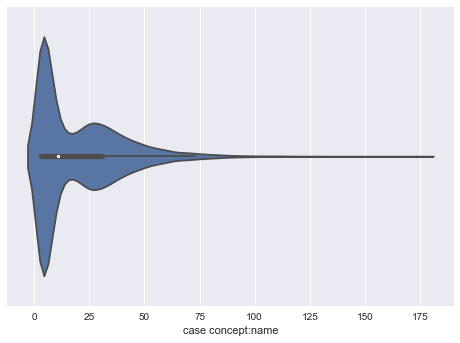

In [10]:
print(df_encoded['case concept:name'].value_counts().describe())
sns.violinplot(x=df_encoded['case concept:name'].value_counts())

In [51]:
def sliding_window


size = 3
window = 3
start = 0
X = []
Y = []


traces = df_encoded['case concept:name'].unique()

for i in traces[:4]:
    trace = df_encoded[df_encoded['case concept:name']==i]
    if len(trace) > size * window +1:
        for j in range(1,window+1):
            display(trace.iloc[start:start+window+1])
            curr_window = trace.iloc[start:start+window+1]
            X.append(np.concatenate(curr_window.iloc[:3].to_numpy()))
            display(curr_window.iloc[:3])
            Y.append(curr_window.iloc[3]['event concept:name'])
            start += 1
            break
        break
        start = 0
    else:
        # what to do if traces are shorter than window?
        continue

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,9,2011-10-01,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,2011-10-01,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,2011-10-01,0,0
3,3,173688,2011-10-01T00:38:44.546+02:00,20000,19,2011-10-01,1,0


,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
0,0,173688,2011-10-01T00:38:44.546+02:00,20000,9,2011-10-01,0,0
1,1,173688,2011-10-01T00:38:44.546+02:00,20000,6,2011-10-01,0,0
2,2,173688,2011-10-01T00:38:44.546+02:00,20000,7,2011-10-01,0,0


19

Note: Y value in this case is the actual next event. With input x1,x2,x3... where X consists of all columns from last row and all columns from current row excluding Y. The Y value from last row acts as a predictor x for current row to predict Y next event

In [24]:
df_encoded[df_encoded['case concept:name']==173694]

,eventID,case concept:name,case REG_DATE,case AMOUNT_REQ,event concept:name,event time:timestamp,Lifecycle_SCHEDULE,Lifecycle_START
8,8589934592,173694,2011-10-01T08:10:30.287+02:00,7000,9,2011-10-01,0,0
9,8589934593,173694,2011-10-01T08:10:30.287+02:00,7000,6,2011-10-01,0,0
12,8589934594,173694,2011-10-01T08:10:30.287+02:00,7000,7,2011-10-01,0,0
13,8589934595,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-01,1,0
86,8589934596,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-01,0,1
88,8589934597,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-01,0,0
890,8589934598,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-03,0,1
909,8589934599,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-03,0,0
1097,8589934600,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-03,0,1
1124,8589934601,173694,2011-10-01T08:10:30.287+02:00,7000,19,2011-10-03,0,0


# TEST: We split the data illegally, not thinking about traces. 

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# Training and fitting dctree on X and predicting on Y 
d_tree = tree.DecisionTreeClassifier()
d_tree.fit(x_train, y_train)

y_pred = d_tree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.4722973441508911

Text(0, 0.5, 'WCSS')

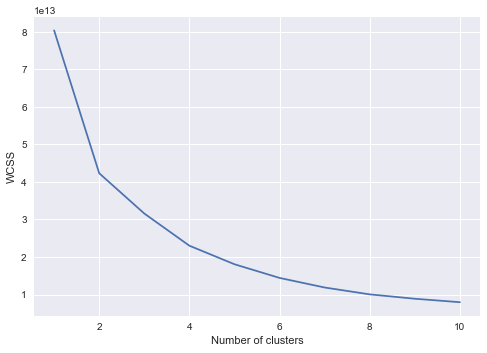

In [49]:
# look for optimal amount of clusters (elbow)
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 

In [104]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

In [105]:
kmeans

KMeans(n_clusters=6, random_state=42)

In [106]:
from sklearn.metrics import pairwise_distances
X = np.array(X)

n = 5000

distances = pairwise_distances(kmeans.cluster_centers_, x_train, metric='euclidean')
ind = [np.argpartition(i, n)[:n] for i in distances]
closest_x = [x_train[indexes] for indexes in ind]
closest_y = [y_train[indexes] for indexes in ind]


In [107]:
closest_x = [item for sublist in closest_x for item in sublist]
closest_y = [item for sublist in closest_y for item in sublist]

In [108]:
d_tree = tree.DecisionTreeClassifier()
d_tree.fit(closest_x, closest_y)

y_pred = d_tree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.4102928599496105